# Prep

Setting up some prior functionality

In [1]:
import os
import json
from PIL import Image
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.5.1+cu101 True


# Load a model

First we have to decide if our model should be pretrained. 

This greatly depends on the size of a dataset. Smaller datasets rely more on finetuning. 

In [2]:
pretrained = True

if pretrained:
    # Get pretrained weights
    checkpoint = torch.hub.load_state_dict_from_url(
                url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
                map_location='cpu',
                check_hash=True)

    # Remove class weights
    del checkpoint["model"]["class_embed.weight"]
    del checkpoint["model"]["class_embed.bias"]

    # SaveOGH
    torch.save(checkpoint,
               'detr-r50_no-class-head.pth')

# Dataset

Our dataset should be loadable as a COCO format

This allows us to use the pycocotools to load the data dict for the main python script

In [38]:
# alternatively, implement your own coco-type dataset loader in datasets and add this "key" to datasets/__init__.py
dataset_file = "coco_petct" 

# should lead to a directory with a train2017 and val2017 folder as well as an annotations folder
#dataDir='/COCO_dataset/' 
#dataDir = '/media/storage/Joy/datasets/DETR_MIP/FDG-PET-CT-Lesions/'
# dataDir = '/gpfs/fs0/data/stanford_data/petct/DETR_MIP/FDG-PET-CT-Lesions/'
dataDir = '/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/'

# this int should be the actual number of classes + 1 (for no class)
num_classes = 2

outDir = 'outputs'

resume = "detr-r50_no-class-head.pth" if pretrained else ""

In [4]:
!ls /gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/annotations/

detr_test.json	detr_train.json  detr_val.json


In [5]:
!ls $dataDir

annotations  images


# Visualize

In [6]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from pathlib import Path
from PIL import Image
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [7]:
mode = 'train'
annFile='{}annotations/detr_{}.json'.format(dataDir,mode)
print(annFile)

# https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
# initialize COCO api for instance annotations
coco=COCO(annFile)

/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/annotations/detr_train.json
loading annotations into memory...
Done (t=2.74s)
creating index...
index created!


In [8]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['background', 'tumor']
Super-categories: {'tumor', 'background'}


In [9]:
# load and display image
catIds = coco.getCatIds(catNms=['tumor']);
imgIds = coco.getImgIds(catIds=catIds );

In [10]:
def _load_image_npy(coco, img_folder, img_id):
    npy_name = coco.loadImgs(img_id)[0]["file_name"] # loads a .npy file by image_id
    img_ann_path = img_folder/Path(npy_name)
    print(img_ann_path)
    with open(img_ann_path, 'rb') as f:
        suv_img = np.load(f) # this is a single channel suv values image, dtype numpy float64
    return suv_img

def _suv_to_greyPIL(suv_img, suv_max):
    # Assuming eval mode
    norm = plt.Normalize(vmin = 0, vmax = suv_max) # normally radiologists view images at this suv norm
    # Color map to gray images, output has 3 channels
    cmap = plt.cm.Greys
    img = cmap(norm(suv_img))[:,:,:3].copy() # drop the alpha channel that we don't need. has shape (H x W x 3C) 
    #img = torch.as_tensor(img, dtype=torch.float64) # the transforms latera will turn the numpy array to a tensor (C x H x W)
    img = Image.fromarray(np.uint8(img*255), 'RGB') # expected input by transforms
    return img

     

Image n°0
Image name: /gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions//annotations/train/0.npy
/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/images/train/0.npy


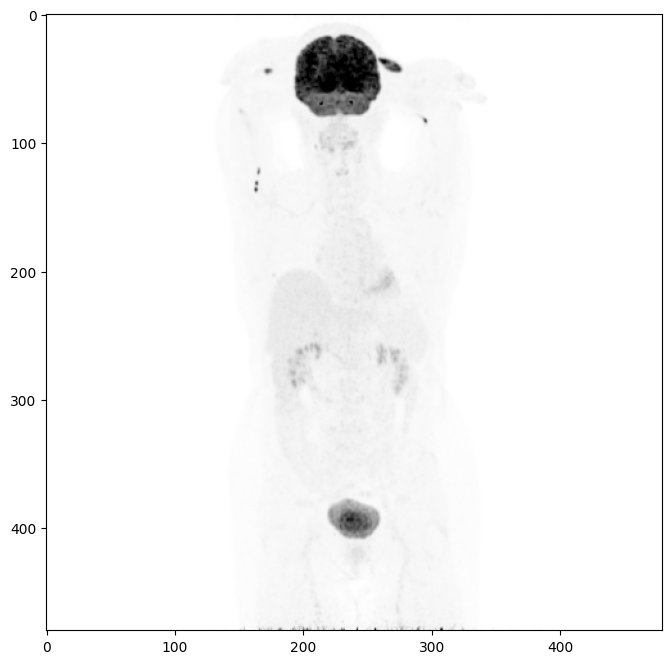

In [15]:
#img_id = imgIds[np.random.randint(0,len(imgIds))]
img_id = 0
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s/%s'%(dataDir, 'annotations', mode, img['file_name'])
print('Image name: {}'.format(img_name))

img_folder = Path(dataDir)/Path('images')/Path(mode)
suv_img = _load_image_npy(coco, img_folder, img_id)
suv_max = 20
I = _suv_to_greyPIL(suv_img, suv_max)

#I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [16]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

print(len(anns))

5


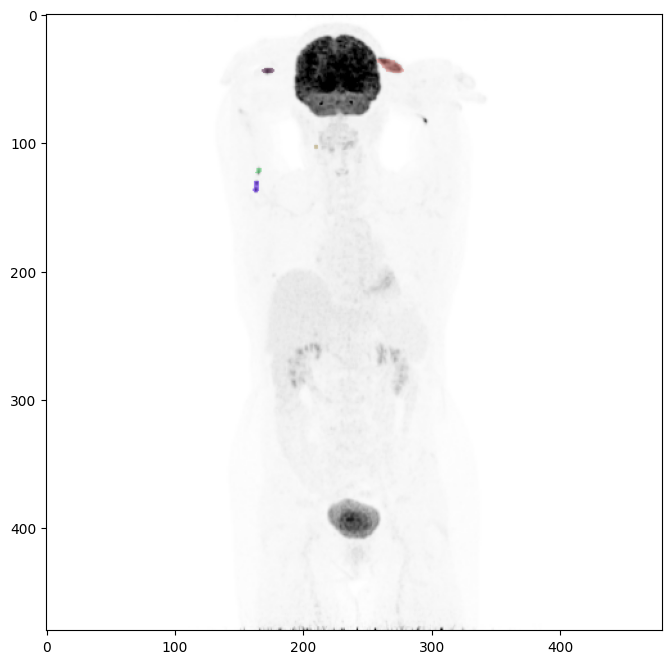

In [17]:
# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

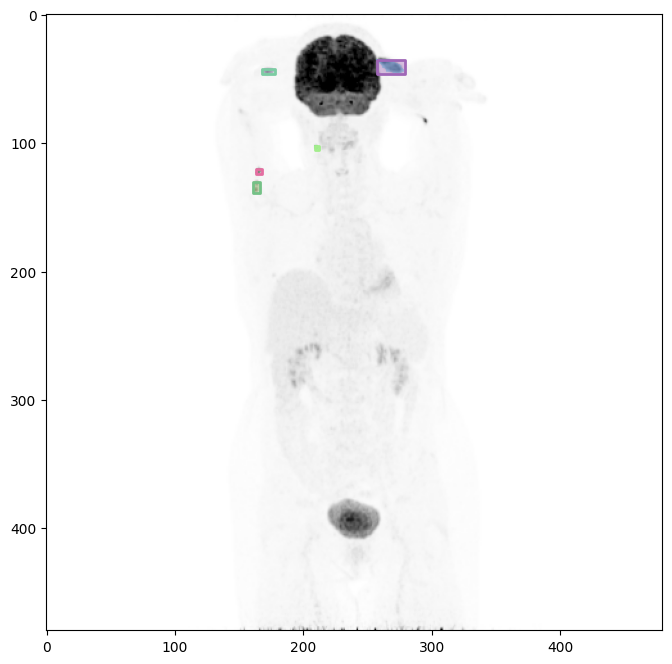

In [18]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

# Dataset Statistics

### Almost all images have < 100 objects

i.e. Makes sense to keep object queries to 100.

In [19]:
max_anno = 0
min_anno = 1
freq_anno = []
for imgID in imgIds:
    annIds = coco.getAnnIds(imgIds=imgID, catIds=[1])
    anns = coco.loadAnns(annIds)
    num = len(anns)
    if num > max_anno:
        max_anno = num
    if num < min_anno:
        min_anno = num
    if num > 1:
        freq_anno.append(num)
print(max_anno) 
print(min_anno) 
print(len(freq_anno))
print(len([f for f in freq_anno if f < 50]))

261
1
15955
15580


(array([2.777e+03, 2.514e+03, 1.679e+03, 1.556e+03, 1.015e+03, 8.130e+02,
        7.420e+02, 6.010e+02, 5.460e+02, 4.300e+02, 2.880e+02, 2.400e+02,
        1.160e+02, 1.230e+02, 1.520e+02, 1.600e+02, 1.310e+02, 1.330e+02,
        1.090e+02, 8.500e+01, 8.900e+01, 9.300e+01, 7.100e+01, 8.000e+01,
        7.300e+01, 8.500e+01, 8.000e+01, 8.000e+01, 8.200e+01, 6.200e+01,
        4.200e+01, 3.000e+01, 1.700e+01, 3.000e+01, 3.100e+01, 4.200e+01,
        3.100e+01, 3.000e+01, 5.000e+01, 3.200e+01, 3.900e+01, 4.200e+01,
        3.400e+01, 3.500e+01, 2.700e+01, 2.000e+01, 1.700e+01, 2.600e+01,
        2.300e+01, 2.300e+01, 1.700e+01, 1.400e+01, 2.500e+01, 2.100e+01,
        7.000e+00, 6.000e+00, 2.000e+00, 1.000e+01, 7.000e+00, 7.000e+00,
        1.100e+01, 4.000e+00, 1.600e+01, 1.300e+01, 1.000e+01, 1.400e+01,
        7.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 5.000e+00, 6.000e+00,
        4.000e+00, 4.000e+00, 5.000e+00, 6.000e+00, 1.300e+01, 5.000e+00,
        3.000e+00, 4.000e+00, 2.000e+0

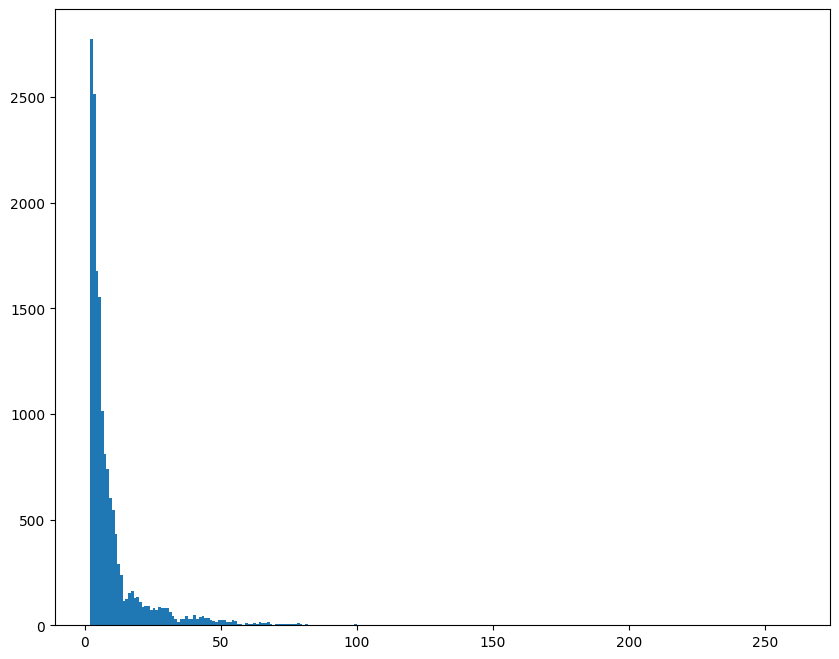

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import *

data = np.asarray(freq_anno)
plt.hist(data, bins=np.arange(data.min(), data.max()+1))


In [60]:
print('Number of images with more than 100 tumor lesions:',len([f for f in freq_anno if f > 100]))

55


### Small, medium and large objects likely different for petct datset

https://github.com/cocodataset/cocoapi/issues/325

In [57]:
areas = []
AnnIds = coco.getAnnIds(catIds=catIds)
print(len(AnnIds))

annotations = coco.loadAnns(ids=AnnIds)
print(len(annotations))
print(annotations[0])

for ann in annotations: # {'annot_id...': {'area',...}, }
    area = ann['area']
    areas.append(area)
    
print(len(areas))
sizes = [np.sqrt(a) for a in areas]

161716
161716
{'image_id': 0, 'id': 0, 'segmentation': {'counts': [123395, 1, 479, 3, 477, 3, 477, 4, 476, 5, 475, 7, 473, 7, 473, 8, 472, 10, 470, 10, 470, 10, 471, 9, 471, 9, 471, 10, 470, 10, 472, 8, 472, 8, 473, 7, 473, 7, 474, 6, 476, 3, 478, 2, 96915], 'size': [480, 480]}, 'area': 147, 'iscrowd': 0, 'bbox': [257, 35, 22, 11], 'category_id': 1}
161716


(array([8.3780e+03, 1.7409e+04, 1.8601e+04, 1.9154e+04, 1.7318e+04,
        1.4347e+04, 1.0809e+04, 8.2030e+03, 6.4720e+03, 5.3630e+03,
        4.0700e+03, 3.4710e+03, 2.7080e+03, 2.0280e+03, 2.0400e+03,
        1.4350e+03, 1.2500e+03, 1.2840e+03, 1.2160e+03, 1.2670e+03,
        1.1240e+03, 7.9400e+02, 7.6400e+02, 7.6200e+02, 6.9000e+02,
        5.2900e+02, 6.3000e+02, 5.5600e+02, 5.7100e+02, 4.7500e+02,
        5.1700e+02, 5.5000e+02, 4.4000e+02, 3.4200e+02, 3.8000e+02,
        3.2300e+02, 3.3500e+02, 3.3600e+02, 3.3100e+02, 3.1600e+02,
        3.2500e+02, 3.3100e+02, 2.4800e+02, 1.7400e+02, 1.4300e+02,
        1.8700e+02, 1.5200e+02, 1.1200e+02, 8.4000e+01, 9.1000e+01,
        1.4700e+02, 1.4900e+02, 1.7400e+02, 1.3700e+02, 1.4300e+02,
        1.2700e+02, 1.2700e+02, 9.7000e+01, 7.6000e+01, 9.7000e+01,
        8.3000e+01, 6.8000e+01, 4.1000e+01, 3.4000e+01, 2.4000e+01,
        2.8000e+01, 2.8000e+01, 4.2000e+01, 2.7000e+01, 3.2000e+01,
        2.2000e+01, 2.7000e+01, 2.3000e+01, 1.70

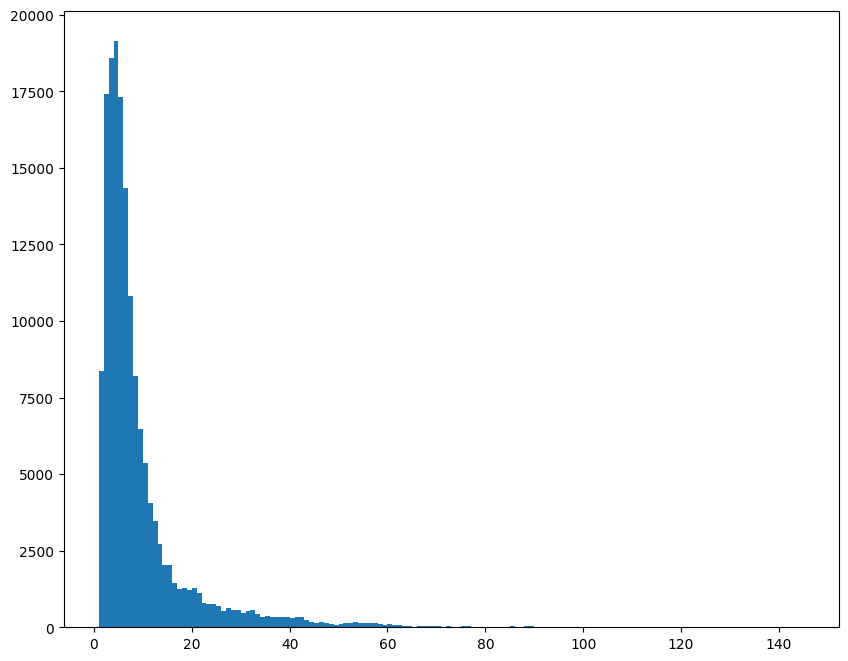

In [58]:
data = np.asarray(sizes)
plt.hist(data, bins=np.arange(data.min(), data.max()+1))

In [73]:
print('A good split for sizes of objects would be:')
print('Small (0**2 to {}**2):'.format(4), len([s for s in sizes if s < 4 ])/len(sizes))
print('Medium ({}**2 to {}**2):'.format(4,8), len([s for s in sizes if (s >= 4)&(s < 8) ])/len(sizes))
print('Large ({}**2 to 1e5**2):'.format(8), len([s for s in sizes if s >= 8 ])/len(sizes))

A good split for sizes of objects would be:
Small (0**2 to 4**2): 0.2744811892453437
Medium (4**2 to 8**2): 0.3810878329911697
Large (8**2 to 1e5**2): 0.3444309777634866


# Training

We use the main_petct.py script to run our training

Training log for DETR
https://gist.github.com/szagoruyko/b4c3b2c3627294fc369b899987385a3f

In [40]:
experiment = 'baseline'
outDir_baseline = '/'.join([outDir,experiment])
print(outDir_baseline)

outputs/baseline


In [42]:
!/home/joywu/anaconda3/envs/detr_py38/bin/python main_petct.py \
  --dataset_file $dataset_file \
  --coco_petct_path $dataDir \
  --output_dir $outDir_baseline \
  --resume $resume \
  --num_classes $num_classes \
  --lr 1e-5 \
  --lr_backbone 1e-6 \
  --epochs 1 \
  --experiment $experiment 

Not using distributed mode
git:
  sha: a53f78bcf41f7cc805923a434f645a81519386ac, status: has uncommited changes, branch: master

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path=None, coco_petct_path='/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/', cross_val=False, dataset_file='coco_petct', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, early_stopping=False, enc_layers=6, eos_coef=0.1, epochs=1, eval=False, experiment='baseline', frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=1e-05, lr_backbone=1e-06, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=2, num_queries=100, num_workers=2, output_dir='outputs/baseline', patience=10, position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=

Epoch: [0]  [   40/19488]  eta: 1:07:11  lr: 0.000010  class_error: 0.00  loss: 31.6264 (30.1438)  loss_ce: 0.7552 (1.0503)  loss_bbox: 2.2221 (2.0680)  loss_giou: 1.9943 (1.7886)  loss_ce_0: 1.0263 (1.2076)  loss_bbox_0: 2.8517 (2.1864)  loss_giou_0: 2.0239 (1.7850)  loss_ce_1: 0.9049 (1.1706)  loss_bbox_1: 2.3984 (2.0786)  loss_giou_1: 1.9946 (1.8228)  loss_ce_2: 0.8627 (1.1372)  loss_bbox_2: 2.1635 (2.0919)  loss_giou_2: 1.9841 (1.7903)  loss_ce_3: 0.8011 (1.1177)  loss_bbox_3: 2.3181 (2.1058)  loss_giou_3: 1.9939 (1.7942)  loss_ce_4: 0.7674 (1.0835)  loss_bbox_4: 2.2643 (2.0755)  loss_giou_4: 1.9939 (1.7899)  loss_ce_unscaled: 0.7552 (1.0503)  class_error_unscaled: 0.0000 (31.7073)  loss_bbox_unscaled: 0.4444 (0.4136)  loss_giou_unscaled: 0.9972 (0.8943)  cardinality_error_unscaled: 30.5000 (63.7927)  loss_ce_0_unscaled: 1.0263 (1.2076)  loss_bbox_0_unscaled: 0.5703 (0.4373)  loss_giou_0_unscaled: 1.0120 (0.8925)  cardinality_error_0_unscaled: 83.5000 (87.4756)  loss_ce_1_unscaled:

Epoch: [0]  [   90/19488]  eta: 1:06:47  lr: 0.000010  class_error: 0.00  loss: 21.6133 (25.4992)  loss_ce: 0.3537 (0.7534)  loss_bbox: 1.3066 (1.7453)  loss_giou: 1.9498 (1.6197)  loss_ce_0: 0.5584 (0.9215)  loss_bbox_0: 1.6808 (1.8924)  loss_giou_0: 1.9641 (1.6407)  loss_ce_1: 0.5111 (0.8878)  loss_bbox_1: 1.2947 (1.8031)  loss_giou_1: 1.9308 (1.6426)  loss_ce_2: 0.4479 (0.8359)  loss_bbox_2: 1.6047 (1.7798)  loss_giou_2: 1.8570 (1.6280)  loss_ce_3: 0.4187 (0.8062)  loss_bbox_3: 1.3345 (1.7710)  loss_giou_3: 1.8501 (1.6240)  loss_ce_4: 0.3867 (0.7766)  loss_bbox_4: 1.3314 (1.7438)  loss_giou_4: 1.8638 (1.6274)  loss_ce_unscaled: 0.3537 (0.7534)  class_error_unscaled: 0.0000 (31.3516)  loss_bbox_unscaled: 0.2613 (0.3491)  loss_giou_unscaled: 0.9749 (0.8099)  cardinality_error_unscaled: 1.0000 (31.2747)  loss_ce_0_unscaled: 0.5584 (0.9215)  loss_bbox_0_unscaled: 0.3362 (0.3785)  loss_giou_0_unscaled: 0.9821 (0.8204)  cardinality_error_0_unscaled: 4.0000 (53.0110)  loss_ce_1_unscaled: 0

Epoch: [0]  [  140/19488]  eta: 1:06:17  lr: 0.000010  class_error: 0.00  loss: 19.5333 (22.3569)  loss_ce: 0.4377 (0.6693)  loss_bbox: 0.6869 (1.3885)  loss_giou: 2.0283 (1.5592)  loss_ce_0: 0.4009 (0.7694)  loss_bbox_0: 1.2219 (1.6066)  loss_giou_0: 1.9061 (1.5848)  loss_ce_1: 0.4032 (0.7499)  loss_bbox_1: 1.0058 (1.4924)  loss_giou_1: 1.8657 (1.5627)  loss_ce_2: 0.3902 (0.7120)  loss_bbox_2: 0.7456 (1.4306)  loss_giou_2: 1.8941 (1.5615)  loss_ce_3: 0.4012 (0.6937)  loss_bbox_3: 0.7498 (1.4143)  loss_giou_3: 1.8405 (1.5476)  loss_ce_4: 0.3901 (0.6714)  loss_bbox_4: 0.6235 (1.3779)  loss_giou_4: 1.9737 (1.5651)  loss_ce_unscaled: 0.4377 (0.6693)  class_error_unscaled: 0.0000 (30.2567)  loss_bbox_unscaled: 0.1374 (0.2777)  loss_giou_unscaled: 1.0141 (0.7796)  cardinality_error_unscaled: 1.5000 (21.1418)  loss_ce_0_unscaled: 0.4009 (0.7694)  loss_bbox_0_unscaled: 0.2444 (0.3213)  loss_giou_0_unscaled: 0.9531 (0.7924)  cardinality_error_0_unscaled: 1.5000 (35.2376)  loss_ce_1_unscaled: 0

Epoch: [0]  [  190/19488]  eta: 1:05:42  lr: 0.000010  class_error: 0.00  loss: 20.6098 (20.1340)  loss_ce: 0.6144 (0.6579)  loss_bbox: 0.5486 (1.1357)  loss_giou: 1.9078 (1.4917)  loss_ce_0: 0.4314 (0.6913)  loss_bbox_0: 0.9607 (1.3556)  loss_giou_0: 1.9471 (1.5090)  loss_ce_1: 0.4688 (0.6817)  loss_bbox_1: 0.6345 (1.2286)  loss_giou_1: 1.9198 (1.4957)  loss_ce_2: 0.5233 (0.6646)  loss_bbox_2: 0.5323 (1.1699)  loss_giou_2: 1.9287 (1.4949)  loss_ce_3: 0.5442 (0.6590)  loss_bbox_3: 0.6025 (1.1572)  loss_giou_3: 1.8367 (1.4797)  loss_ce_4: 0.5474 (0.6441)  loss_bbox_4: 0.5437 (1.1222)  loss_giou_4: 1.9567 (1.4953)  loss_ce_unscaled: 0.6144 (0.6579)  class_error_unscaled: 0.0000 (32.4543)  loss_bbox_unscaled: 0.1097 (0.2271)  loss_giou_unscaled: 0.9539 (0.7459)  cardinality_error_unscaled: 1.5000 (16.3613)  loss_ce_0_unscaled: 0.4314 (0.6913)  loss_bbox_0_unscaled: 0.1921 (0.2711)  loss_giou_0_unscaled: 0.9735 (0.7545)  cardinality_error_0_unscaled: 1.5000 (26.7670)  loss_ce_1_unscaled: 0

Epoch: [0]  [  240/19488]  eta: 1:05:43  lr: 0.000010  class_error: 0.00  loss: 20.1865 (19.0748)  loss_ce: 0.7173 (0.7041)  loss_bbox: 0.4653 (0.9818)  loss_giou: 1.9423 (1.4584)  loss_ce_0: 0.4705 (0.6716)  loss_bbox_0: 0.7494 (1.2086)  loss_giou_0: 1.9770 (1.4646)  loss_ce_1: 0.5255 (0.6764)  loss_bbox_1: 0.6175 (1.0700)  loss_giou_1: 1.9678 (1.4540)  loss_ce_2: 0.6364 (0.6771)  loss_bbox_2: 0.6095 (1.0147)  loss_giou_2: 1.9970 (1.4558)  loss_ce_3: 0.6542 (0.6853)  loss_bbox_3: 0.5751 (1.0015)  loss_giou_3: 1.9920 (1.4483)  loss_ce_4: 0.6541 (0.6750)  loss_bbox_4: 0.4632 (0.9684)  loss_giou_4: 1.9674 (1.4593)  loss_ce_unscaled: 0.7173 (0.7041)  class_error_unscaled: 0.0000 (33.3606)  loss_bbox_unscaled: 0.0931 (0.1964)  loss_giou_unscaled: 0.9712 (0.7292)  cardinality_error_unscaled: 1.5000 (13.7282)  loss_ce_0_unscaled: 0.4705 (0.6716)  loss_bbox_0_unscaled: 0.1499 (0.2417)  loss_giou_0_unscaled: 0.9885 (0.7323)  cardinality_error_0_unscaled: 1.5000 (21.9751)  loss_ce_1_unscaled: 0

Epoch: [0]  [  290/19488]  eta: 1:05:28  lr: 0.000010  class_error: 0.00  loss: 19.6851 (18.9212)  loss_ce: 1.0578 (0.7642)  loss_bbox: 0.4030 (0.8835)  loss_giou: 1.7993 (1.4957)  loss_ce_0: 0.7655 (0.6775)  loss_bbox_0: 0.5248 (1.1081)  loss_giou_0: 2.0351 (1.5057)  loss_ce_1: 0.8246 (0.6987)  loss_bbox_1: 0.4503 (0.9669)  loss_giou_1: 1.9414 (1.4925)  loss_ce_2: 0.8615 (0.7132)  loss_bbox_2: 0.3828 (0.9125)  loss_giou_2: 1.9172 (1.4938)  loss_ce_3: 0.9557 (0.7327)  loss_bbox_3: 0.4073 (0.9009)  loss_giou_3: 1.7847 (1.4821)  loss_ce_4: 0.9484 (0.7243)  loss_bbox_4: 0.4008 (0.8725)  loss_giou_4: 1.8155 (1.4963)  loss_ce_unscaled: 1.0578 (0.7642)  class_error_unscaled: 0.0000 (29.7591)  loss_bbox_unscaled: 0.0806 (0.1767)  loss_giou_unscaled: 0.8997 (0.7478)  cardinality_error_unscaled: 3.0000 (12.0687)  loss_ce_0_unscaled: 0.7655 (0.6775)  loss_bbox_0_unscaled: 0.1050 (0.2216)  loss_giou_0_unscaled: 1.0176 (0.7529)  cardinality_error_0_unscaled: 3.0000 (18.8986)  loss_ce_1_unscaled: 0

Epoch: [0]  [  340/19488]  eta: 1:05:17  lr: 0.000010  class_error: 0.00  loss: 20.3811 (18.4905)  loss_ce: 0.8060 (0.7896)  loss_bbox: 0.4005 (0.8095)  loss_giou: 1.8619 (1.4836)  loss_ce_0: 0.5951 (0.6756)  loss_bbox_0: 0.5567 (1.0227)  loss_giou_0: 1.9128 (1.4994)  loss_ce_1: 0.6616 (0.7063)  loss_bbox_1: 0.4581 (0.8865)  loss_giou_1: 1.9474 (1.4874)  loss_ce_2: 0.6871 (0.7279)  loss_bbox_2: 0.3933 (0.8319)  loss_giou_2: 1.9335 (1.4872)  loss_ce_3: 0.7687 (0.7534)  loss_bbox_3: 0.3803 (0.8227)  loss_giou_3: 1.8775 (1.4737)  loss_ce_4: 0.7864 (0.7458)  loss_bbox_4: 0.3995 (0.8009)  loss_giou_4: 1.8314 (1.4864)  loss_ce_unscaled: 0.8060 (0.7896)  class_error_unscaled: 0.0000 (28.9146)  loss_bbox_unscaled: 0.0801 (0.1619)  loss_giou_unscaled: 0.9310 (0.7418)  cardinality_error_unscaled: 2.0000 (11.0293)  loss_ce_0_unscaled: 0.5951 (0.6756)  loss_bbox_0_unscaled: 0.1113 (0.2045)  loss_giou_0_unscaled: 0.9564 (0.7497)  cardinality_error_0_unscaled: 2.0000 (16.8578)  loss_ce_1_unscaled: 0

Epoch: [0]  [  390/19488]  eta: 1:04:52  lr: 0.000010  class_error: 100.00  loss: 14.3456 (18.0722)  loss_ce: 0.4073 (0.8048)  loss_bbox: 0.3389 (0.7478)  loss_giou: 1.5838 (1.4706)  loss_ce_0: 0.2822 (0.6729)  loss_bbox_0: 0.4203 (0.9449)  loss_giou_0: 1.6425 (1.4877)  loss_ce_1: 0.3124 (0.7118)  loss_bbox_1: 0.3351 (0.8190)  loss_giou_1: 1.5958 (1.4761)  loss_ce_2: 0.3283 (0.7369)  loss_bbox_2: 0.2930 (0.7686)  loss_giou_2: 1.6608 (1.4735)  loss_ce_3: 0.3370 (0.7661)  loss_bbox_3: 0.3007 (0.7605)  loss_giou_3: 1.4686 (1.4597)  loss_ce_4: 0.3363 (0.7586)  loss_bbox_4: 0.3124 (0.7407)  loss_giou_4: 1.5471 (1.4721)  loss_ce_unscaled: 0.4073 (0.8048)  class_error_unscaled: 0.0000 (28.2862)  loss_bbox_unscaled: 0.0678 (0.1496)  loss_giou_unscaled: 0.7919 (0.7353)  cardinality_error_unscaled: 1.0000 (10.2225)  loss_ce_0_unscaled: 0.2822 (0.6729)  loss_bbox_0_unscaled: 0.0841 (0.1890)  loss_giou_0_unscaled: 0.8212 (0.7439)  cardinality_error_0_unscaled: 1.0000 (15.3056)  loss_ce_1_unscaled:

Epoch: [0]  [  440/19488]  eta: 1:04:28  lr: 0.000010  class_error: 0.00  loss: 16.4099 (17.7315)  loss_ce: 0.5325 (0.8160)  loss_bbox: 0.3063 (0.6967)  loss_giou: 1.7240 (1.4620)  loss_ce_0: 0.4394 (0.6750)  loss_bbox_0: 0.4238 (0.8827)  loss_giou_0: 1.7455 (1.4765)  loss_ce_1: 0.4711 (0.7183)  loss_bbox_1: 0.3732 (0.7636)  loss_giou_1: 1.7996 (1.4625)  loss_ce_2: 0.5170 (0.7454)  loss_bbox_2: 0.3728 (0.7168)  loss_giou_2: 1.7242 (1.4609)  loss_ce_3: 0.4945 (0.7766)  loss_bbox_3: 0.3214 (0.7088)  loss_giou_3: 1.6374 (1.4494)  loss_ce_4: 0.5041 (0.7692)  loss_bbox_4: 0.2863 (0.6904)  loss_giou_4: 1.6325 (1.4609)  loss_ce_unscaled: 0.5325 (0.8160)  class_error_unscaled: 0.0000 (27.8002)  loss_bbox_unscaled: 0.0613 (0.1393)  loss_giou_unscaled: 0.8620 (0.7310)  cardinality_error_unscaled: 2.0000 (9.6111)  loss_ce_0_unscaled: 0.4394 (0.6750)  loss_bbox_0_unscaled: 0.0848 (0.1765)  loss_giou_0_unscaled: 0.8728 (0.7382)  cardinality_error_0_unscaled: 2.0000 (14.1168)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  490/19488]  eta: 1:04:18  lr: 0.000010  class_error: 0.00  loss: 12.0795 (17.4211)  loss_ce: 0.2062 (0.8141)  loss_bbox: 0.2504 (0.6560)  loss_giou: 1.4444 (1.4544)  loss_ce_0: 0.1893 (0.6678)  loss_bbox_0: 0.2961 (0.8322)  loss_giou_0: 1.6138 (1.4748)  loss_ce_1: 0.1863 (0.7153)  loss_bbox_1: 0.2633 (0.7186)  loss_giou_1: 1.4465 (1.4592)  loss_ce_2: 0.2419 (0.7420)  loss_bbox_2: 0.2812 (0.6759)  loss_giou_2: 1.4575 (1.4549)  loss_ce_3: 0.2141 (0.7737)  loss_bbox_3: 0.2818 (0.6673)  loss_giou_3: 1.5575 (1.4412)  loss_ce_4: 0.2105 (0.7679)  loss_bbox_4: 0.2977 (0.6510)  loss_giou_4: 1.4244 (1.4547)  loss_ce_unscaled: 0.2062 (0.8141)  class_error_unscaled: 0.0000 (27.2096)  loss_bbox_unscaled: 0.0501 (0.1312)  loss_giou_unscaled: 0.7222 (0.7272)  cardinality_error_unscaled: 0.5000 (9.1385)  loss_ce_0_unscaled: 0.1893 (0.6678)  loss_bbox_0_unscaled: 0.0592 (0.1664)  loss_giou_0_unscaled: 0.8069 (0.7374)  cardinality_error_0_unscaled: 0.5000 (13.1670)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  540/19488]  eta: 1:04:02  lr: 0.000010  class_error: 0.00  loss: 0.4537 (16.8404)  loss_ce: 0.0561 (0.7823)  loss_bbox: 0.0000 (0.6186)  loss_giou: 0.0000 (1.4263)  loss_ce_0: 0.1155 (0.6411)  loss_bbox_0: 0.0000 (0.7855)  loss_giou_0: 0.0000 (1.4477)  loss_ce_1: 0.0764 (0.6884)  loss_bbox_1: 0.0000 (0.6794)  loss_giou_1: 0.0000 (1.4319)  loss_ce_2: 0.0737 (0.7133)  loss_bbox_2: 0.0000 (0.6371)  loss_giou_2: 0.0000 (1.4267)  loss_ce_3: 0.0679 (0.7428)  loss_bbox_3: 0.0000 (0.6288)  loss_giou_3: 0.0000 (1.4121)  loss_ce_4: 0.0641 (0.7385)  loss_bbox_4: 0.0000 (0.6144)  loss_giou_4: 0.0000 (1.4255)  loss_ce_unscaled: 0.0561 (0.7823)  class_error_unscaled: 0.0000 (27.2826)  loss_bbox_unscaled: 0.0000 (0.1237)  loss_giou_unscaled: 0.0000 (0.7132)  cardinality_error_unscaled: 0.0000 (8.5656)  loss_ce_0_unscaled: 0.1155 (0.6411)  loss_bbox_0_unscaled: 0.0000 (0.1571)  loss_giou_0_unscaled: 0.0000 (0.7239)  cardinality_error_0_unscaled: 0.0000 (12.1867)  loss_ce_1_unscaled: 0.0

Epoch: [0]  [  590/19488]  eta: 1:03:58  lr: 0.000010  class_error: 100.00  loss: 18.0248 (16.5861)  loss_ce: 1.0758 (0.7867)  loss_bbox: 0.3068 (0.5915)  loss_giou: 1.5378 (1.4107)  loss_ce_0: 0.7882 (0.6398)  loss_bbox_0: 0.3931 (0.7516)  loss_giou_0: 1.5788 (1.4341)  loss_ce_1: 0.9470 (0.6907)  loss_bbox_1: 0.3220 (0.6481)  loss_giou_1: 1.6902 (1.4163)  loss_ce_2: 1.0024 (0.7162)  loss_bbox_2: 0.3222 (0.6082)  loss_giou_2: 1.6134 (1.4101)  loss_ce_3: 0.9101 (0.7456)  loss_bbox_3: 0.3228 (0.6007)  loss_giou_3: 1.6327 (1.3962)  loss_ce_4: 1.0131 (0.7426)  loss_bbox_4: 0.3171 (0.5878)  loss_giou_4: 1.6040 (1.4091)  loss_ce_unscaled: 1.0758 (0.7867)  class_error_unscaled: 0.0000 (27.6817)  loss_bbox_unscaled: 0.0614 (0.1183)  loss_giou_unscaled: 0.7689 (0.7054)  cardinality_error_unscaled: 3.0000 (8.2377)  loss_ce_0_unscaled: 0.7882 (0.6398)  loss_bbox_0_unscaled: 0.0786 (0.1503)  loss_giou_0_unscaled: 0.7894 (0.7171)  cardinality_error_0_unscaled: 3.0000 (11.5152)  loss_ce_1_unscaled: 

Epoch: [0]  [  640/19488]  eta: 1:03:38  lr: 0.000010  class_error: 100.00  loss: 16.1797 (16.3356)  loss_ce: 0.5086 (0.7779)  loss_bbox: 0.3118 (0.5702)  loss_giou: 1.5328 (1.3992)  loss_ce_0: 0.4353 (0.6306)  loss_bbox_0: 0.3147 (0.7246)  loss_giou_0: 1.7184 (1.4243)  loss_ce_1: 0.4443 (0.6831)  loss_bbox_1: 0.3401 (0.6239)  loss_giou_1: 1.6085 (1.4056)  loss_ce_2: 0.4656 (0.7082)  loss_bbox_2: 0.2866 (0.5863)  loss_giou_2: 1.6415 (1.3995)  loss_ce_3: 0.4600 (0.7364)  loss_bbox_3: 0.2989 (0.5781)  loss_giou_3: 1.5780 (1.3879)  loss_ce_4: 0.4944 (0.7354)  loss_bbox_4: 0.3232 (0.5667)  loss_giou_4: 1.5835 (1.3981)  loss_ce_unscaled: 0.5086 (0.7779)  class_error_unscaled: 0.0000 (27.5505)  loss_bbox_unscaled: 0.0624 (0.1140)  loss_giou_unscaled: 0.7664 (0.6996)  cardinality_error_unscaled: 1.5000 (7.9821)  loss_ce_0_unscaled: 0.4353 (0.6306)  loss_bbox_0_unscaled: 0.0629 (0.1449)  loss_giou_0_unscaled: 0.8592 (0.7121)  cardinality_error_0_unscaled: 1.5000 (10.9969)  loss_ce_1_unscaled: 

Epoch: [0]  [  690/19488]  eta: 1:03:32  lr: 0.000010  class_error: 0.00  loss: 12.3488 (16.0866)  loss_ce: 0.3941 (0.7658)  loss_bbox: 0.2410 (0.5495)  loss_giou: 1.3260 (1.3903)  loss_ce_0: 0.3577 (0.6202)  loss_bbox_0: 0.2836 (0.6974)  loss_giou_0: 1.2924 (1.4157)  loss_ce_1: 0.3459 (0.6732)  loss_bbox_1: 0.2661 (0.6015)  loss_giou_1: 1.4218 (1.3975)  loss_ce_2: 0.3804 (0.6974)  loss_bbox_2: 0.2577 (0.5653)  loss_giou_2: 1.3408 (1.3906)  loss_ce_3: 0.3624 (0.7249)  loss_bbox_3: 0.2594 (0.5581)  loss_giou_3: 1.3432 (1.3791)  loss_ce_4: 0.3784 (0.7252)  loss_bbox_4: 0.2559 (0.5468)  loss_giou_4: 1.3017 (1.3881)  loss_ce_unscaled: 0.3941 (0.7658)  class_error_unscaled: 0.0000 (27.0042)  loss_bbox_unscaled: 0.0482 (0.1099)  loss_giou_unscaled: 0.6630 (0.6952)  cardinality_error_unscaled: 1.0000 (7.7952)  loss_ce_0_unscaled: 0.3577 (0.6202)  loss_bbox_0_unscaled: 0.0567 (0.1395)  loss_giou_0_unscaled: 0.6462 (0.7079)  cardinality_error_0_unscaled: 1.0000 (10.5318)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  740/19488]  eta: 1:03:23  lr: 0.000010  class_error: 100.00  loss: 12.8000 (15.8189)  loss_ce: 0.3349 (0.7464)  loss_bbox: 0.2720 (0.5312)  loss_giou: 1.4395 (1.3816)  loss_ce_0: 0.3353 (0.6072)  loss_bbox_0: 0.2783 (0.6709)  loss_giou_0: 1.3416 (1.4082)  loss_ce_1: 0.3455 (0.6592)  loss_bbox_1: 0.2363 (0.5800)  loss_giou_1: 1.4488 (1.3909)  loss_ce_2: 0.3765 (0.6826)  loss_bbox_2: 0.2521 (0.5456)  loss_giou_2: 1.4271 (1.3816)  loss_ce_3: 0.3016 (0.7074)  loss_bbox_3: 0.2736 (0.5394)  loss_giou_3: 1.4320 (1.3706)  loss_ce_4: 0.3213 (0.7079)  loss_bbox_4: 0.2673 (0.5285)  loss_giou_4: 1.4437 (1.3796)  loss_ce_unscaled: 0.3349 (0.7464)  class_error_unscaled: 0.0000 (26.6665)  loss_bbox_unscaled: 0.0544 (0.1062)  loss_giou_unscaled: 0.7197 (0.6908)  cardinality_error_unscaled: 1.5000 (7.9791)  loss_ce_0_unscaled: 0.3353 (0.6072)  loss_bbox_0_unscaled: 0.0557 (0.1342)  loss_giou_0_unscaled: 0.6708 (0.7041)  cardinality_error_0_unscaled: 1.5000 (10.4750)  loss_ce_1_unscaled: 

Epoch: [0]  [  790/19488]  eta: 1:03:14  lr: 0.000010  class_error: 0.00  loss: 14.5804 (15.5821)  loss_ce: 0.4760 (0.7346)  loss_bbox: 0.3567 (0.5164)  loss_giou: 1.4341 (1.3703)  loss_ce_0: 0.4248 (0.5973)  loss_bbox_0: 0.3831 (0.6513)  loss_giou_0: 1.5254 (1.3953)  loss_ce_1: 0.4935 (0.6496)  loss_bbox_1: 0.3579 (0.5630)  loss_giou_1: 1.6580 (1.3777)  loss_ce_2: 0.4920 (0.6721)  loss_bbox_2: 0.3423 (0.5299)  loss_giou_2: 1.4252 (1.3690)  loss_ce_3: 0.4841 (0.6959)  loss_bbox_3: 0.3424 (0.5238)  loss_giou_3: 1.4425 (1.3573)  loss_ce_4: 0.4603 (0.6973)  loss_bbox_4: 0.3639 (0.5138)  loss_giou_4: 1.4200 (1.3675)  loss_ce_unscaled: 0.4760 (0.7346)  class_error_unscaled: 0.0000 (26.4980)  loss_bbox_unscaled: 0.0713 (0.1033)  loss_giou_unscaled: 0.7171 (0.6851)  cardinality_error_unscaled: 1.5000 (7.8236)  loss_ce_0_unscaled: 0.4248 (0.5973)  loss_bbox_0_unscaled: 0.0766 (0.1303)  loss_giou_0_unscaled: 0.7627 (0.6976)  cardinality_error_0_unscaled: 1.5000 (10.1125)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  840/19488]  eta: 1:03:01  lr: 0.000010  class_error: 0.00  loss: 13.1980 (15.3072)  loss_ce: 0.2882 (0.7170)  loss_bbox: 0.2199 (0.4998)  loss_giou: 1.4111 (1.3567)  loss_ce_0: 0.2934 (0.5838)  loss_bbox_0: 0.3237 (0.6306)  loss_giou_0: 1.7051 (1.3854)  loss_ce_1: 0.3077 (0.6351)  loss_bbox_1: 0.2596 (0.5451)  loss_giou_1: 1.5404 (1.3653)  loss_ce_2: 0.3230 (0.6572)  loss_bbox_2: 0.2209 (0.5138)  loss_giou_2: 1.4319 (1.3546)  loss_ce_3: 0.2669 (0.6798)  loss_bbox_3: 0.2535 (0.5075)  loss_giou_3: 1.3987 (1.3443)  loss_ce_4: 0.2884 (0.6814)  loss_bbox_4: 0.2084 (0.4973)  loss_giou_4: 1.3964 (1.3528)  loss_ce_unscaled: 0.2882 (0.7170)  class_error_unscaled: 0.0000 (26.5873)  loss_bbox_unscaled: 0.0440 (0.1000)  loss_giou_unscaled: 0.7055 (0.6783)  cardinality_error_unscaled: 1.0000 (7.7128)  loss_ce_0_unscaled: 0.2934 (0.5838)  loss_bbox_0_unscaled: 0.0647 (0.1261)  loss_giou_0_unscaled: 0.8525 (0.6927)  cardinality_error_0_unscaled: 1.0000 (9.8264)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [  890/19488]  eta: 1:02:48  lr: 0.000010  class_error: 100.00  loss: 12.7584 (15.2000)  loss_ce: 0.4459 (0.7155)  loss_bbox: 0.2106 (0.4881)  loss_giou: 1.3730 (1.3528)  loss_ce_0: 0.3429 (0.5824)  loss_bbox_0: 0.2223 (0.6167)  loss_giou_0: 1.4187 (1.3792)  loss_ce_1: 0.3718 (0.6354)  loss_bbox_1: 0.2213 (0.5318)  loss_giou_1: 1.3775 (1.3595)  loss_ce_2: 0.4362 (0.6569)  loss_bbox_2: 0.2031 (0.5015)  loss_giou_2: 1.4246 (1.3499)  loss_ce_3: 0.4365 (0.6787)  loss_bbox_3: 0.2277 (0.4948)  loss_giou_3: 1.4087 (1.3413)  loss_ce_4: 0.4451 (0.6810)  loss_bbox_4: 0.2161 (0.4862)  loss_giou_4: 1.3746 (1.3482)  loss_ce_unscaled: 0.4459 (0.7155)  class_error_unscaled: 0.0000 (26.6665)  loss_bbox_unscaled: 0.0421 (0.0976)  loss_giou_unscaled: 0.6865 (0.6764)  cardinality_error_unscaled: 1.5000 (7.4938)  loss_ce_0_unscaled: 0.3429 (0.5824)  loss_bbox_0_unscaled: 0.0445 (0.1233)  loss_giou_0_unscaled: 0.7094 (0.6896)  cardinality_error_0_unscaled: 1.0000 (9.4641)  loss_ce_1_unscaled: 0

Epoch: [0]  [  940/19488]  eta: 1:02:35  lr: 0.000010  class_error: 0.00  loss: 15.2801 (15.0873)  loss_ce: 0.4418 (0.7075)  loss_bbox: 0.2886 (0.4779)  loss_giou: 1.6619 (1.3513)  loss_ce_0: 0.3828 (0.5777)  loss_bbox_0: 0.3016 (0.6021)  loss_giou_0: 1.5794 (1.3773)  loss_ce_1: 0.3973 (0.6301)  loss_bbox_1: 0.2861 (0.5204)  loss_giou_1: 1.6181 (1.3573)  loss_ce_2: 0.4169 (0.6514)  loss_bbox_2: 0.3016 (0.4910)  loss_giou_2: 1.6340 (1.3502)  loss_ce_3: 0.4298 (0.6720)  loss_bbox_3: 0.3032 (0.4838)  loss_giou_3: 1.6889 (1.3402)  loss_ce_4: 0.4334 (0.6748)  loss_bbox_4: 0.3050 (0.4760)  loss_giou_4: 1.6139 (1.3464)  loss_ce_unscaled: 0.4418 (0.7075)  class_error_unscaled: 0.0000 (26.4186)  loss_bbox_unscaled: 0.0577 (0.0956)  loss_giou_unscaled: 0.8310 (0.6756)  cardinality_error_unscaled: 4.0000 (7.5871)  loss_ce_0_unscaled: 0.3828 (0.5777)  loss_bbox_0_unscaled: 0.0603 (0.1204)  loss_giou_0_unscaled: 0.7897 (0.6886)  cardinality_error_0_unscaled: 2.5000 (9.3427)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [  990/19488]  eta: 1:02:25  lr: 0.000010  class_error: 0.00  loss: 12.4808 (14.9300)  loss_ce: 0.4192 (0.6983)  loss_bbox: 0.1894 (0.4658)  loss_giou: 1.3497 (1.3462)  loss_ce_0: 0.3355 (0.5710)  loss_bbox_0: 0.2144 (0.5864)  loss_giou_0: 1.4676 (1.3720)  loss_ce_1: 0.3771 (0.6227)  loss_bbox_1: 0.2182 (0.5071)  loss_giou_1: 1.4130 (1.3527)  loss_ce_2: 0.3781 (0.6433)  loss_bbox_2: 0.2093 (0.4787)  loss_giou_2: 1.3004 (1.3447)  loss_ce_3: 0.3953 (0.6636)  loss_bbox_3: 0.1865 (0.4710)  loss_giou_3: 1.3229 (1.3346)  loss_ce_4: 0.4068 (0.6669)  loss_bbox_4: 0.1823 (0.4639)  loss_giou_4: 1.3478 (1.3412)  loss_ce_unscaled: 0.4192 (0.6983)  class_error_unscaled: 0.0000 (26.2966)  loss_bbox_unscaled: 0.0379 (0.0932)  loss_giou_unscaled: 0.6749 (0.6731)  cardinality_error_unscaled: 2.0000 (7.6211)  loss_ce_0_unscaled: 0.3355 (0.5710)  loss_bbox_0_unscaled: 0.0429 (0.1173)  loss_giou_0_unscaled: 0.7338 (0.6860)  cardinality_error_0_unscaled: 1.0000 (9.1705)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1040/19488]  eta: 1:02:13  lr: 0.000010  class_error: 0.00  loss: 15.4320 (14.8481)  loss_ce: 0.5238 (0.6921)  loss_bbox: 0.2883 (0.4578)  loss_giou: 1.6065 (1.3451)  loss_ce_0: 0.5320 (0.5669)  loss_bbox_0: 0.3409 (0.5752)  loss_giou_0: 1.6742 (1.3741)  loss_ce_1: 0.5340 (0.6186)  loss_bbox_1: 0.3017 (0.4984)  loss_giou_1: 1.6053 (1.3532)  loss_ce_2: 0.4962 (0.6381)  loss_bbox_2: 0.3168 (0.4706)  loss_giou_2: 1.5811 (1.3442)  loss_ce_3: 0.4770 (0.6578)  loss_bbox_3: 0.2866 (0.4626)  loss_giou_3: 1.6178 (1.3348)  loss_ce_4: 0.4933 (0.6616)  loss_bbox_4: 0.2947 (0.4561)  loss_giou_4: 1.5920 (1.3408)  loss_ce_unscaled: 0.5238 (0.6921)  class_error_unscaled: 0.0000 (25.8020)  loss_bbox_unscaled: 0.0577 (0.0916)  loss_giou_unscaled: 0.8033 (0.6726)  cardinality_error_unscaled: 3.0000 (7.7848)  loss_ce_0_unscaled: 0.5320 (0.5669)  loss_bbox_0_unscaled: 0.0682 (0.1150)  loss_giou_0_unscaled: 0.8371 (0.6870)  cardinality_error_0_unscaled: 3.0000 (9.1422)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1090/19488]  eta: 1:02:05  lr: 0.000010  class_error: 100.00  loss: 13.4368 (14.6773)  loss_ce: 0.4143 (0.6829)  loss_bbox: 0.2116 (0.4483)  loss_giou: 1.4035 (1.3345)  loss_ce_0: 0.4496 (0.5603)  loss_bbox_0: 0.2541 (0.5622)  loss_giou_0: 1.4015 (1.3624)  loss_ce_1: 0.4915 (0.6115)  loss_bbox_1: 0.2564 (0.4873)  loss_giou_1: 1.2903 (1.3429)  loss_ce_2: 0.4574 (0.6302)  loss_bbox_2: 0.2402 (0.4608)  loss_giou_2: 1.3359 (1.3353)  loss_ce_3: 0.4297 (0.6492)  loss_bbox_3: 0.2092 (0.4530)  loss_giou_3: 1.3928 (1.3255)  loss_ce_4: 0.4330 (0.6534)  loss_bbox_4: 0.2125 (0.4470)  loss_giou_4: 1.3885 (1.3307)  loss_ce_unscaled: 0.4143 (0.6829)  class_error_unscaled: 0.0000 (25.9027)  loss_bbox_unscaled: 0.0423 (0.0897)  loss_giou_unscaled: 0.7018 (0.6672)  cardinality_error_unscaled: 2.5000 (7.7374)  loss_ce_0_unscaled: 0.4496 (0.5603)  loss_bbox_0_unscaled: 0.0508 (0.1124)  loss_giou_0_unscaled: 0.7008 (0.6812)  cardinality_error_0_unscaled: 2.0000 (8.9684)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1140/19488]  eta: 1:01:53  lr: 0.000010  class_error: 100.00  loss: 13.0340 (14.5198)  loss_ce: 0.5439 (0.6747)  loss_bbox: 0.2563 (0.4389)  loss_giou: 1.3106 (1.3246)  loss_ce_0: 0.4752 (0.5546)  loss_bbox_0: 0.2535 (0.5497)  loss_giou_0: 1.4537 (1.3541)  loss_ce_1: 0.5052 (0.6051)  loss_bbox_1: 0.2701 (0.4764)  loss_giou_1: 1.4193 (1.3333)  loss_ce_2: 0.5052 (0.6233)  loss_bbox_2: 0.2312 (0.4513)  loss_giou_2: 1.4292 (1.3268)  loss_ce_3: 0.5115 (0.6415)  loss_bbox_3: 0.2506 (0.4434)  loss_giou_3: 1.3426 (1.3167)  loss_ce_4: 0.5309 (0.6463)  loss_bbox_4: 0.2555 (0.4375)  loss_giou_4: 1.3785 (1.3216)  loss_ce_unscaled: 0.5439 (0.6747)  class_error_unscaled: 0.0000 (25.9946)  loss_bbox_unscaled: 0.0513 (0.0878)  loss_giou_unscaled: 0.6553 (0.6623)  cardinality_error_unscaled: 2.0000 (7.8024)  loss_ce_0_unscaled: 0.4752 (0.5546)  loss_bbox_0_unscaled: 0.0507 (0.1099)  loss_giou_0_unscaled: 0.7269 (0.6770)  cardinality_error_0_unscaled: 2.0000 (8.8646)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1190/19488]  eta: 1:01:46  lr: 0.000010  class_error: 0.00  loss: 15.4152 (14.4009)  loss_ce: 0.7302 (0.6696)  loss_bbox: 0.2586 (0.4316)  loss_giou: 1.4250 (1.3165)  loss_ce_0: 0.5615 (0.5504)  loss_bbox_0: 0.3070 (0.5395)  loss_giou_0: 1.4483 (1.3480)  loss_ce_1: 0.6341 (0.6010)  loss_bbox_1: 0.2994 (0.4676)  loss_giou_1: 1.4019 (1.3273)  loss_ce_2: 0.6628 (0.6188)  loss_bbox_2: 0.2795 (0.4433)  loss_giou_2: 1.4270 (1.3207)  loss_ce_3: 0.6757 (0.6365)  loss_bbox_3: 0.2624 (0.4351)  loss_giou_3: 1.4329 (1.3094)  loss_ce_4: 0.6950 (0.6417)  loss_bbox_4: 0.2862 (0.4296)  loss_giou_4: 1.4230 (1.3143)  loss_ce_unscaled: 0.7302 (0.6696)  class_error_unscaled: 0.0000 (26.0788)  loss_bbox_unscaled: 0.0517 (0.0863)  loss_giou_unscaled: 0.7125 (0.6582)  cardinality_error_unscaled: 2.0000 (7.7620)  loss_ce_0_unscaled: 0.5615 (0.5504)  loss_bbox_0_unscaled: 0.0614 (0.1079)  loss_giou_0_unscaled: 0.7241 (0.6740)  cardinality_error_0_unscaled: 2.0000 (8.7019)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 1240/19488]  eta: 1:01:41  lr: 0.000010  class_error: 0.00  loss: 14.1843 (14.2689)  loss_ce: 0.4011 (0.6640)  loss_bbox: 0.2213 (0.4226)  loss_giou: 1.4484 (1.3085)  loss_ce_0: 0.3812 (0.5468)  loss_bbox_0: 0.2624 (0.5275)  loss_giou_0: 1.4789 (1.3401)  loss_ce_1: 0.4076 (0.5972)  loss_bbox_1: 0.2162 (0.4580)  loss_giou_1: 1.4696 (1.3191)  loss_ce_2: 0.4045 (0.6142)  loss_bbox_2: 0.2165 (0.4344)  loss_giou_2: 1.4381 (1.3132)  loss_ce_3: 0.3932 (0.6315)  loss_bbox_3: 0.2220 (0.4263)  loss_giou_3: 1.4795 (1.3018)  loss_ce_4: 0.4025 (0.6371)  loss_bbox_4: 0.2143 (0.4209)  loss_giou_4: 1.4774 (1.3060)  loss_ce_unscaled: 0.4011 (0.6640)  class_error_unscaled: 0.0000 (26.1562)  loss_bbox_unscaled: 0.0443 (0.0845)  loss_giou_unscaled: 0.7242 (0.6542)  cardinality_error_unscaled: 3.5000 (7.8529)  loss_ce_0_unscaled: 0.3812 (0.5468)  loss_bbox_0_unscaled: 0.0525 (0.1055)  loss_giou_0_unscaled: 0.7394 (0.6700)  cardinality_error_0_unscaled: 3.0000 (8.6688)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1290/19488]  eta: 1:01:33  lr: 0.000010  class_error: 0.00  loss: 13.5378 (14.1873)  loss_ce: 0.5178 (0.6603)  loss_bbox: 0.2349 (0.4163)  loss_giou: 1.3988 (1.3047)  loss_ce_0: 0.4448 (0.5445)  loss_bbox_0: 0.2798 (0.5198)  loss_giou_0: 1.4666 (1.3381)  loss_ce_1: 0.4903 (0.5948)  loss_bbox_1: 0.2512 (0.4506)  loss_giou_1: 1.3456 (1.3151)  loss_ce_2: 0.4911 (0.6110)  loss_bbox_2: 0.2412 (0.4272)  loss_giou_2: 1.5089 (1.3097)  loss_ce_3: 0.4951 (0.6278)  loss_bbox_3: 0.2204 (0.4190)  loss_giou_3: 1.4088 (1.2974)  loss_ce_4: 0.5234 (0.6340)  loss_bbox_4: 0.2404 (0.4149)  loss_giou_4: 1.4091 (1.3022)  loss_ce_unscaled: 0.5178 (0.6603)  class_error_unscaled: 0.0000 (25.8404)  loss_bbox_unscaled: 0.0470 (0.0833)  loss_giou_unscaled: 0.6994 (0.6523)  cardinality_error_unscaled: 2.0000 (7.9140)  loss_ce_0_unscaled: 0.4448 (0.5445)  loss_bbox_0_unscaled: 0.0560 (0.1040)  loss_giou_0_unscaled: 0.7333 (0.6690)  cardinality_error_0_unscaled: 1.5000 (8.6204)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1340/19488]  eta: 1:01:25  lr: 0.000010  class_error: 100.00  loss: 13.8529 (13.9931)  loss_ce: 0.2310 (0.6506)  loss_bbox: 0.2174 (0.4080)  loss_giou: 1.2669 (1.2895)  loss_ce_0: 0.2745 (0.5374)  loss_bbox_0: 0.2511 (0.5094)  loss_giou_0: 1.3622 (1.3234)  loss_ce_1: 0.2827 (0.5867)  loss_bbox_1: 0.2295 (0.4414)  loss_giou_1: 1.3321 (1.3004)  loss_ce_2: 0.2669 (0.6024)  loss_bbox_2: 0.2126 (0.4186)  loss_giou_2: 1.2534 (1.2947)  loss_ce_3: 0.2489 (0.6189)  loss_bbox_3: 0.2257 (0.4105)  loss_giou_3: 1.2700 (1.2827)  loss_ce_4: 0.2336 (0.6250)  loss_bbox_4: 0.2231 (0.4066)  loss_giou_4: 1.2979 (1.2870)  loss_ce_unscaled: 0.2310 (0.6506)  class_error_unscaled: 0.0000 (26.4429)  loss_bbox_unscaled: 0.0435 (0.0816)  loss_giou_unscaled: 0.6334 (0.6447)  cardinality_error_unscaled: 1.0000 (7.8576)  loss_ce_0_unscaled: 0.2745 (0.5374)  loss_bbox_0_unscaled: 0.0502 (0.1019)  loss_giou_0_unscaled: 0.6811 (0.6617)  cardinality_error_0_unscaled: 1.0000 (8.4952)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1390/19488]  eta: 1:01:16  lr: 0.000010  class_error: 0.00  loss: 14.7386 (14.0288)  loss_ce: 0.4047 (0.6556)  loss_bbox: 0.2051 (0.4038)  loss_giou: 1.5519 (1.2936)  loss_ce_0: 0.4152 (0.5423)  loss_bbox_0: 0.3384 (0.5058)  loss_giou_0: 1.7152 (1.3279)  loss_ce_1: 0.4488 (0.5920)  loss_bbox_1: 0.2741 (0.4372)  loss_giou_1: 1.4447 (1.3057)  loss_ce_2: 0.4635 (0.6075)  loss_bbox_2: 0.2485 (0.4153)  loss_giou_2: 1.5073 (1.2994)  loss_ce_3: 0.4759 (0.6237)  loss_bbox_3: 0.2154 (0.4069)  loss_giou_3: 1.4859 (1.2885)  loss_ce_4: 0.4443 (0.6302)  loss_bbox_4: 0.2191 (0.4029)  loss_giou_4: 1.5551 (1.2906)  loss_ce_unscaled: 0.4047 (0.6556)  class_error_unscaled: 0.0000 (26.0675)  loss_bbox_unscaled: 0.0410 (0.0808)  loss_giou_unscaled: 0.7759 (0.6468)  cardinality_error_unscaled: 1.5000 (7.8242)  loss_ce_0_unscaled: 0.4152 (0.5423)  loss_bbox_0_unscaled: 0.0677 (0.1012)  loss_giou_0_unscaled: 0.8576 (0.6639)  cardinality_error_0_unscaled: 1.5000 (8.4073)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1440/19488]  eta: 1:01:05  lr: 0.000010  class_error: 0.00  loss: 13.1895 (13.9748)  loss_ce: 0.4037 (0.6530)  loss_bbox: 0.2502 (0.3980)  loss_giou: 1.5537 (1.2928)  loss_ce_0: 0.3271 (0.5414)  loss_bbox_0: 0.2730 (0.4981)  loss_giou_0: 1.6262 (1.3258)  loss_ce_1: 0.3513 (0.5913)  loss_bbox_1: 0.2721 (0.4307)  loss_giou_1: 1.6031 (1.3057)  loss_ce_2: 0.3620 (0.6059)  loss_bbox_2: 0.2274 (0.4092)  loss_giou_2: 1.4622 (1.2977)  loss_ce_3: 0.3705 (0.6216)  loss_bbox_3: 0.2370 (0.4007)  loss_giou_3: 1.4296 (1.2877)  loss_ce_4: 0.3805 (0.6283)  loss_bbox_4: 0.2518 (0.3971)  loss_giou_4: 1.5519 (1.2898)  loss_ce_unscaled: 0.4037 (0.6530)  class_error_unscaled: 0.0000 (25.9958)  loss_bbox_unscaled: 0.0500 (0.0796)  loss_giou_unscaled: 0.7769 (0.6464)  cardinality_error_unscaled: 1.0000 (7.9757)  loss_ce_0_unscaled: 0.3271 (0.5414)  loss_bbox_0_unscaled: 0.0546 (0.0996)  loss_giou_0_unscaled: 0.8131 (0.6629)  cardinality_error_0_unscaled: 0.5000 (8.4545)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1490/19488]  eta: 1:00:57  lr: 0.000010  class_error: 0.00  loss: 12.3836 (13.9003)  loss_ce: 0.3346 (0.6509)  loss_bbox: 0.1475 (0.3920)  loss_giou: 1.0835 (1.2881)  loss_ce_0: 0.3036 (0.5405)  loss_bbox_0: 0.1884 (0.4908)  loss_giou_0: 1.4583 (1.3215)  loss_ce_1: 0.3024 (0.5900)  loss_bbox_1: 0.1822 (0.4241)  loss_giou_1: 1.4102 (1.3013)  loss_ce_2: 0.3029 (0.6042)  loss_bbox_2: 0.1813 (0.4028)  loss_giou_2: 1.4437 (1.2933)  loss_ce_3: 0.3272 (0.6196)  loss_bbox_3: 0.1290 (0.3945)  loss_giou_3: 1.1772 (1.2836)  loss_ce_4: 0.3534 (0.6265)  loss_bbox_4: 0.1408 (0.3911)  loss_giou_4: 1.0540 (1.2853)  loss_ce_unscaled: 0.3346 (0.6509)  class_error_unscaled: 0.0000 (26.1300)  loss_bbox_unscaled: 0.0295 (0.0784)  loss_giou_unscaled: 0.5418 (0.6441)  cardinality_error_unscaled: 0.5000 (7.9953)  loss_ce_0_unscaled: 0.3036 (0.5405)  loss_bbox_0_unscaled: 0.0377 (0.0982)  loss_giou_0_unscaled: 0.7291 (0.6608)  cardinality_error_0_unscaled: 1.5000 (8.3655)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1540/19488]  eta: 1:00:45  lr: 0.000010  class_error: 0.00  loss: 13.1615 (13.8500)  loss_ce: 0.3901 (0.6500)  loss_bbox: 0.2154 (0.3868)  loss_giou: 1.3881 (1.2853)  loss_ce_0: 0.3302 (0.5408)  loss_bbox_0: 0.3148 (0.4855)  loss_giou_0: 1.4976 (1.3194)  loss_ce_1: 0.4261 (0.5903)  loss_bbox_1: 0.2848 (0.4187)  loss_giou_1: 1.4664 (1.2981)  loss_ce_2: 0.4093 (0.6040)  loss_bbox_2: 0.2359 (0.3979)  loss_giou_2: 1.4155 (1.2900)  loss_ce_3: 0.3770 (0.6187)  loss_bbox_3: 0.2305 (0.3889)  loss_giou_3: 1.4538 (1.2806)  loss_ce_4: 0.4083 (0.6260)  loss_bbox_4: 0.2178 (0.3859)  loss_giou_4: 1.3740 (1.2830)  loss_ce_unscaled: 0.3901 (0.6500)  class_error_unscaled: 0.0000 (26.0609)  loss_bbox_unscaled: 0.0431 (0.0774)  loss_giou_unscaled: 0.6940 (0.6426)  cardinality_error_unscaled: 1.5000 (7.9886)  loss_ce_0_unscaled: 0.3302 (0.5408)  loss_bbox_0_unscaled: 0.0630 (0.0971)  loss_giou_0_unscaled: 0.7488 (0.6597)  cardinality_error_0_unscaled: 2.0000 (8.2777)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1590/19488]  eta: 1:00:35  lr: 0.000010  class_error: 100.00  loss: 9.7510 (13.7313)  loss_ce: 0.2331 (0.6458)  loss_bbox: 0.1450 (0.3809)  loss_giou: 1.0882 (1.2751)  loss_ce_0: 0.2056 (0.5381)  loss_bbox_0: 0.1606 (0.4771)  loss_giou_0: 1.2459 (1.3100)  loss_ce_1: 0.2213 (0.5875)  loss_bbox_1: 0.1431 (0.4119)  loss_giou_1: 0.9344 (1.2887)  loss_ce_2: 0.2236 (0.6007)  loss_bbox_2: 0.1467 (0.3913)  loss_giou_2: 1.0514 (1.2802)  loss_ce_3: 0.2039 (0.6150)  loss_bbox_3: 0.1492 (0.3825)  loss_giou_3: 1.0403 (1.2712)  loss_ce_4: 0.2330 (0.6224)  loss_bbox_4: 0.1560 (0.3797)  loss_giou_4: 1.1750 (1.2732)  loss_ce_unscaled: 0.2331 (0.6458)  class_error_unscaled: 0.0000 (26.3104)  loss_bbox_unscaled: 0.0290 (0.0762)  loss_giou_unscaled: 0.5441 (0.6376)  cardinality_error_unscaled: 1.0000 (8.0874)  loss_ce_0_unscaled: 0.2056 (0.5381)  loss_bbox_0_unscaled: 0.0321 (0.0954)  loss_giou_0_unscaled: 0.6229 (0.6550)  cardinality_error_0_unscaled: 1.0000 (8.2879)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 1640/19488]  eta: 1:00:21  lr: 0.000010  class_error: 0.00  loss: 13.0116 (13.6657)  loss_ce: 0.4162 (0.6413)  loss_bbox: 0.2279 (0.3769)  loss_giou: 1.2109 (1.2738)  loss_ce_0: 0.4125 (0.5355)  loss_bbox_0: 0.2386 (0.4707)  loss_giou_0: 1.2791 (1.3074)  loss_ce_1: 0.4116 (0.5842)  loss_bbox_1: 0.2214 (0.4067)  loss_giou_1: 1.3545 (1.2861)  loss_ce_2: 0.4314 (0.5969)  loss_bbox_2: 0.2707 (0.3867)  loss_giou_2: 1.2133 (1.2778)  loss_ce_3: 0.4102 (0.6108)  loss_bbox_3: 0.2146 (0.3778)  loss_giou_3: 1.2166 (1.2691)  loss_ce_4: 0.4142 (0.6184)  loss_bbox_4: 0.1975 (0.3754)  loss_giou_4: 1.2171 (1.2704)  loss_ce_unscaled: 0.4162 (0.6413)  class_error_unscaled: 0.0000 (26.1182)  loss_bbox_unscaled: 0.0456 (0.0754)  loss_giou_unscaled: 0.6055 (0.6369)  cardinality_error_unscaled: 2.0000 (8.1776)  loss_ce_0_unscaled: 0.4125 (0.5355)  loss_bbox_0_unscaled: 0.0477 (0.0941)  loss_giou_0_unscaled: 0.6396 (0.6537)  cardinality_error_0_unscaled: 1.5000 (8.3114)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1690/19488]  eta: 1:00:11  lr: 0.000010  class_error: 100.00  loss: 14.4671 (13.6195)  loss_ce: 0.4604 (0.6420)  loss_bbox: 0.2246 (0.3722)  loss_giou: 1.3883 (1.2700)  loss_ce_0: 0.4654 (0.5371)  loss_bbox_0: 0.2533 (0.4637)  loss_giou_0: 1.5513 (1.3047)  loss_ce_1: 0.4771 (0.5857)  loss_bbox_1: 0.2545 (0.4011)  loss_giou_1: 1.3367 (1.2817)  loss_ce_2: 0.4768 (0.5979)  loss_bbox_2: 0.2251 (0.3819)  loss_giou_2: 1.4027 (1.2741)  loss_ce_3: 0.4699 (0.6115)  loss_bbox_3: 0.2560 (0.3732)  loss_giou_3: 1.3699 (1.2654)  loss_ce_4: 0.4392 (0.6194)  loss_bbox_4: 0.2439 (0.3709)  loss_giou_4: 1.3707 (1.2670)  loss_ce_unscaled: 0.4604 (0.6420)  class_error_unscaled: 0.0000 (26.0555)  loss_bbox_unscaled: 0.0449 (0.0744)  loss_giou_unscaled: 0.6942 (0.6350)  cardinality_error_unscaled: 3.0000 (8.1215)  loss_ce_0_unscaled: 0.4654 (0.5371)  loss_bbox_0_unscaled: 0.0507 (0.0927)  loss_giou_0_unscaled: 0.7757 (0.6524)  cardinality_error_0_unscaled: 3.0000 (8.2413)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1740/19488]  eta: 1:00:03  lr: 0.000010  class_error: 0.00  loss: 17.2042 (13.5869)  loss_ce: 0.4715 (0.6384)  loss_bbox: 0.3482 (0.3704)  loss_giou: 1.6356 (1.2703)  loss_ce_0: 0.4257 (0.5350)  loss_bbox_0: 0.3819 (0.4609)  loss_giou_0: 1.7127 (1.3041)  loss_ce_1: 0.4442 (0.5831)  loss_bbox_1: 0.4089 (0.3988)  loss_giou_1: 1.6969 (1.2809)  loss_ce_2: 0.4449 (0.5949)  loss_bbox_2: 0.3573 (0.3803)  loss_giou_2: 1.7618 (1.2732)  loss_ce_3: 0.4322 (0.6082)  loss_bbox_3: 0.3266 (0.3712)  loss_giou_3: 1.7543 (1.2656)  loss_ce_4: 0.4914 (0.6160)  loss_bbox_4: 0.3290 (0.3689)  loss_giou_4: 1.7979 (1.2666)  loss_ce_unscaled: 0.4715 (0.6384)  class_error_unscaled: 0.0000 (26.1114)  loss_bbox_unscaled: 0.0696 (0.0741)  loss_giou_unscaled: 0.8178 (0.6351)  cardinality_error_unscaled: 1.0000 (8.1407)  loss_ce_0_unscaled: 0.4257 (0.5350)  loss_bbox_0_unscaled: 0.0764 (0.0922)  loss_giou_0_unscaled: 0.8563 (0.6521)  cardinality_error_0_unscaled: 1.5000 (8.2220)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1790/19488]  eta: 0:59:56  lr: 0.000010  class_error: 0.00  loss: 12.1708 (13.5170)  loss_ce: 0.3868 (0.6361)  loss_bbox: 0.2263 (0.3662)  loss_giou: 1.1877 (1.2639)  loss_ce_0: 0.3217 (0.5345)  loss_bbox_0: 0.2063 (0.4556)  loss_giou_0: 1.2157 (1.2987)  loss_ce_1: 0.3506 (0.5824)  loss_bbox_1: 0.2494 (0.3943)  loss_giou_1: 1.2628 (1.2752)  loss_ce_2: 0.3470 (0.5937)  loss_bbox_2: 0.2758 (0.3759)  loss_giou_2: 1.4682 (1.2676)  loss_ce_3: 0.3527 (0.6061)  loss_bbox_3: 0.2249 (0.3671)  loss_giou_3: 1.2756 (1.2600)  loss_ce_4: 0.3609 (0.6142)  loss_bbox_4: 0.2409 (0.3647)  loss_giou_4: 1.2376 (1.2606)  loss_ce_unscaled: 0.3868 (0.6361)  class_error_unscaled: 0.0000 (26.2758)  loss_bbox_unscaled: 0.0453 (0.0732)  loss_giou_unscaled: 0.5938 (0.6320)  cardinality_error_unscaled: 1.5000 (8.1753)  loss_ce_0_unscaled: 0.3217 (0.5345)  loss_bbox_0_unscaled: 0.0413 (0.0911)  loss_giou_0_unscaled: 0.6078 (0.6494)  cardinality_error_0_unscaled: 1.5000 (8.2208)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1840/19488]  eta: 0:59:46  lr: 0.000010  class_error: 0.00  loss: 8.1199 (13.4399)  loss_ce: 0.1326 (0.6326)  loss_bbox: 0.0467 (0.3618)  loss_giou: 0.8125 (1.2581)  loss_ce_0: 0.1309 (0.5323)  loss_bbox_0: 0.1112 (0.4496)  loss_giou_0: 0.9542 (1.2928)  loss_ce_1: 0.1533 (0.5799)  loss_bbox_1: 0.1207 (0.3894)  loss_giou_1: 1.0440 (1.2702)  loss_ce_2: 0.1520 (0.5909)  loss_bbox_2: 0.1464 (0.3713)  loss_giou_2: 1.1074 (1.2625)  loss_ce_3: 0.1307 (0.6029)  loss_bbox_3: 0.1706 (0.3626)  loss_giou_3: 1.2414 (1.2555)  loss_ce_4: 0.1324 (0.6110)  loss_bbox_4: 0.1005 (0.3604)  loss_giou_4: 1.0230 (1.2561)  loss_ce_unscaled: 0.1326 (0.6326)  class_error_unscaled: 0.0000 (26.3769)  loss_bbox_unscaled: 0.0093 (0.0724)  loss_giou_unscaled: 0.4062 (0.6291)  cardinality_error_unscaled: 0.5000 (8.1863)  loss_ce_0_unscaled: 0.1309 (0.5323)  loss_bbox_0_unscaled: 0.0222 (0.0899)  loss_giou_0_unscaled: 0.4771 (0.6464)  cardinality_error_0_unscaled: 0.5000 (8.1733)  loss_ce_1_unscaled: 0.15

Epoch: [0]  [ 1890/19488]  eta: 0:59:35  lr: 0.000010  class_error: 0.00  loss: 13.9690 (13.3757)  loss_ce: 0.5850 (0.6306)  loss_bbox: 0.1976 (0.3580)  loss_giou: 1.1497 (1.2530)  loss_ce_0: 0.5560 (0.5315)  loss_bbox_0: 0.2647 (0.4445)  loss_giou_0: 1.5003 (1.2887)  loss_ce_1: 0.5845 (0.5788)  loss_bbox_1: 0.2084 (0.3851)  loss_giou_1: 1.4080 (1.2655)  loss_ce_2: 0.5601 (0.5895)  loss_bbox_2: 0.1947 (0.3669)  loss_giou_2: 1.2654 (1.2574)  loss_ce_3: 0.5571 (0.6011)  loss_bbox_3: 0.1864 (0.3585)  loss_giou_3: 1.1862 (1.2503)  loss_ce_4: 0.5856 (0.6092)  loss_bbox_4: 0.1910 (0.3564)  loss_giou_4: 1.2052 (1.2508)  loss_ce_unscaled: 0.5850 (0.6306)  class_error_unscaled: 0.0000 (26.4198)  loss_bbox_unscaled: 0.0395 (0.0716)  loss_giou_unscaled: 0.5748 (0.6265)  cardinality_error_unscaled: 2.5000 (8.2054)  loss_ce_0_unscaled: 0.5560 (0.5315)  loss_bbox_0_unscaled: 0.0529 (0.0889)  loss_giou_0_unscaled: 0.7502 (0.6443)  cardinality_error_0_unscaled: 3.0000 (8.1623)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1940/19488]  eta: 0:59:23  lr: 0.000010  class_error: 0.00  loss: 9.2413 (13.3432)  loss_ce: 0.1709 (0.6312)  loss_bbox: 0.1133 (0.3546)  loss_giou: 1.0345 (1.2495)  loss_ce_0: 0.2188 (0.5329)  loss_bbox_0: 0.1376 (0.4404)  loss_giou_0: 1.1228 (1.2861)  loss_ce_1: 0.1804 (0.5800)  loss_bbox_1: 0.1301 (0.3815)  loss_giou_1: 0.9808 (1.2628)  loss_ce_2: 0.1895 (0.5903)  loss_bbox_2: 0.0810 (0.3635)  loss_giou_2: 1.0203 (1.2551)  loss_ce_3: 0.1662 (0.6016)  loss_bbox_3: 0.1186 (0.3553)  loss_giou_3: 0.9363 (1.2479)  loss_ce_4: 0.1909 (0.6101)  loss_bbox_4: 0.1241 (0.3531)  loss_giou_4: 1.1392 (1.2474)  loss_ce_unscaled: 0.1709 (0.6312)  class_error_unscaled: 0.0000 (26.4090)  loss_bbox_unscaled: 0.0227 (0.0709)  loss_giou_unscaled: 0.5172 (0.6247)  cardinality_error_unscaled: 0.5000 (8.2056)  loss_ce_0_unscaled: 0.2188 (0.5329)  loss_bbox_0_unscaled: 0.0275 (0.0881)  loss_giou_0_unscaled: 0.5614 (0.6431)  cardinality_error_0_unscaled: 0.5000 (8.1182)  loss_ce_1_unscaled: 0.18

Epoch: [0]  [ 1990/19488]  eta: 0:59:14  lr: 0.000010  class_error: 0.00  loss: 14.0151 (13.3413)  loss_ce: 0.5341 (0.6328)  loss_bbox: 0.2336 (0.3525)  loss_giou: 1.3930 (1.2488)  loss_ce_0: 0.5460 (0.5356)  loss_bbox_0: 0.3024 (0.4376)  loss_giou_0: 1.6290 (1.2859)  loss_ce_1: 0.5841 (0.5826)  loss_bbox_1: 0.2410 (0.3795)  loss_giou_1: 1.4743 (1.2626)  loss_ce_2: 0.5500 (0.5924)  loss_bbox_2: 0.2197 (0.3612)  loss_giou_2: 1.4632 (1.2548)  loss_ce_3: 0.5466 (0.6034)  loss_bbox_3: 0.2226 (0.3531)  loss_giou_3: 1.4543 (1.2475)  loss_ce_4: 0.5350 (0.6121)  loss_bbox_4: 0.2505 (0.3514)  loss_giou_4: 1.4029 (1.2475)  loss_ce_unscaled: 0.5341 (0.6328)  class_error_unscaled: 0.0000 (26.2481)  loss_bbox_unscaled: 0.0467 (0.0705)  loss_giou_unscaled: 0.6965 (0.6244)  cardinality_error_unscaled: 2.5000 (8.1680)  loss_ce_0_unscaled: 0.5460 (0.5356)  loss_bbox_0_unscaled: 0.0605 (0.0875)  loss_giou_0_unscaled: 0.8145 (0.6429)  cardinality_error_0_unscaled: 2.5000 (8.0625)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 2040/19488]  eta: 0:59:02  lr: 0.000010  class_error: 100.00  loss: 10.0494 (13.2360)  loss_ce: 0.3752 (0.6271)  loss_bbox: 0.1206 (0.3486)  loss_giou: 0.9893 (1.2407)  loss_ce_0: 0.3682 (0.5314)  loss_bbox_0: 0.1549 (0.4322)  loss_giou_0: 1.1670 (1.2776)  loss_ce_1: 0.3862 (0.5779)  loss_bbox_1: 0.1255 (0.3751)  loss_giou_1: 0.9942 (1.2544)  loss_ce_2: 0.3733 (0.5873)  loss_bbox_2: 0.1465 (0.3571)  loss_giou_2: 1.0487 (1.2463)  loss_ce_3: 0.3773 (0.5980)  loss_bbox_3: 0.1289 (0.3491)  loss_giou_3: 1.0563 (1.2395)  loss_ce_4: 0.3732 (0.6067)  loss_bbox_4: 0.1309 (0.3475)  loss_giou_4: 1.0884 (1.2393)  loss_ce_unscaled: 0.3752 (0.6271)  class_error_unscaled: 0.0000 (26.4870)  loss_bbox_unscaled: 0.0241 (0.0697)  loss_giou_unscaled: 0.4947 (0.6204)  cardinality_error_unscaled: 2.0000 (8.1862)  loss_ce_0_unscaled: 0.3682 (0.5314)  loss_bbox_0_unscaled: 0.0310 (0.0864)  loss_giou_0_unscaled: 0.5835 (0.6388)  cardinality_error_0_unscaled: 3.0000 (8.0243)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2090/19488]  eta: 0:58:50  lr: 0.000010  class_error: 0.00  loss: 15.1995 (13.1824)  loss_ce: 0.5294 (0.6241)  loss_bbox: 0.2945 (0.3459)  loss_giou: 1.4440 (1.2379)  loss_ce_0: 0.5441 (0.5295)  loss_bbox_0: 0.3014 (0.4286)  loss_giou_0: 1.4568 (1.2739)  loss_ce_1: 0.5519 (0.5757)  loss_bbox_1: 0.3021 (0.3719)  loss_giou_1: 1.4407 (1.2506)  loss_ce_2: 0.5317 (0.5847)  loss_bbox_2: 0.2792 (0.3542)  loss_giou_2: 1.5926 (1.2427)  loss_ce_3: 0.5416 (0.5953)  loss_bbox_3: 0.2669 (0.3460)  loss_giou_3: 1.5291 (1.2365)  loss_ce_4: 0.5385 (0.6040)  loss_bbox_4: 0.3189 (0.3447)  loss_giou_4: 1.5233 (1.2363)  loss_ce_unscaled: 0.5294 (0.6241)  class_error_unscaled: 0.0000 (26.6188)  loss_bbox_unscaled: 0.0589 (0.0692)  loss_giou_unscaled: 0.7220 (0.6190)  cardinality_error_unscaled: 2.0000 (8.1834)  loss_ce_0_unscaled: 0.5441 (0.5295)  loss_bbox_0_unscaled: 0.0603 (0.0857)  loss_giou_0_unscaled: 0.7284 (0.6370)  cardinality_error_0_unscaled: 2.0000 (7.9873)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 2140/19488]  eta: 0:58:41  lr: 0.000010  class_error: 0.00  loss: 11.9769 (13.1007)  loss_ce: 0.4282 (0.6205)  loss_bbox: 0.1481 (0.3421)  loss_giou: 1.1287 (1.2305)  loss_ce_0: 0.4112 (0.5274)  loss_bbox_0: 0.1858 (0.4241)  loss_giou_0: 1.2522 (1.2672)  loss_ce_1: 0.4293 (0.5729)  loss_bbox_1: 0.1792 (0.3679)  loss_giou_1: 1.1093 (1.2436)  loss_ce_2: 0.4199 (0.5818)  loss_bbox_2: 0.1326 (0.3503)  loss_giou_2: 1.1843 (1.2364)  loss_ce_3: 0.4539 (0.5921)  loss_bbox_3: 0.1456 (0.3423)  loss_giou_3: 1.2555 (1.2299)  loss_ce_4: 0.4191 (0.6007)  loss_bbox_4: 0.1425 (0.3411)  loss_giou_4: 1.1854 (1.2298)  loss_ce_unscaled: 0.4282 (0.6205)  class_error_unscaled: 0.0000 (26.7912)  loss_bbox_unscaled: 0.0296 (0.0684)  loss_giou_unscaled: 0.5643 (0.6153)  cardinality_error_unscaled: 1.0000 (8.1555)  loss_ce_0_unscaled: 0.4112 (0.5274)  loss_bbox_0_unscaled: 0.0372 (0.0848)  loss_giou_0_unscaled: 0.6261 (0.6336)  cardinality_error_0_unscaled: 1.0000 (7.9274)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2190/19488]  eta: 0:58:29  lr: 0.000010  class_error: 0.00  loss: 12.5488 (13.0651)  loss_ce: 0.4502 (0.6190)  loss_bbox: 0.2203 (0.3397)  loss_giou: 1.1692 (1.2283)  loss_ce_0: 0.4719 (0.5271)  loss_bbox_0: 0.2473 (0.4214)  loss_giou_0: 1.2018 (1.2653)  loss_ce_1: 0.4792 (0.5723)  loss_bbox_1: 0.2257 (0.3651)  loss_giou_1: 1.1334 (1.2410)  loss_ce_2: 0.4582 (0.5810)  loss_bbox_2: 0.2028 (0.3476)  loss_giou_2: 1.2129 (1.2335)  loss_ce_3: 0.4712 (0.5912)  loss_bbox_3: 0.2014 (0.3396)  loss_giou_3: 1.1153 (1.2268)  loss_ce_4: 0.4757 (0.5997)  loss_bbox_4: 0.2396 (0.3387)  loss_giou_4: 1.1843 (1.2275)  loss_ce_unscaled: 0.4502 (0.6190)  class_error_unscaled: 0.0000 (26.6818)  loss_bbox_unscaled: 0.0441 (0.0679)  loss_giou_unscaled: 0.5846 (0.6141)  cardinality_error_unscaled: 1.0000 (8.2296)  loss_ce_0_unscaled: 0.4719 (0.5271)  loss_bbox_0_unscaled: 0.0495 (0.0843)  loss_giou_0_unscaled: 0.6009 (0.6327)  cardinality_error_0_unscaled: 1.5000 (7.9626)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2240/19488]  eta: 0:58:17  lr: 0.000010  class_error: 0.00  loss: 6.3070 (13.0080)  loss_ce: 0.1964 (0.6171)  loss_bbox: 0.0562 (0.3366)  loss_giou: 0.6572 (1.2237)  loss_ce_0: 0.1494 (0.5262)  loss_bbox_0: 0.0396 (0.4174)  loss_giou_0: 0.4977 (1.2605)  loss_ce_1: 0.1682 (0.5711)  loss_bbox_1: 0.0814 (0.3619)  loss_giou_1: 0.7528 (1.2368)  loss_ce_2: 0.1385 (0.5795)  loss_bbox_2: 0.0586 (0.3444)  loss_giou_2: 0.6444 (1.2283)  loss_ce_3: 0.1828 (0.5895)  loss_bbox_3: 0.0445 (0.3366)  loss_giou_3: 0.6424 (1.2217)  loss_ce_4: 0.1926 (0.5980)  loss_bbox_4: 0.0349 (0.3359)  loss_giou_4: 0.5426 (1.2226)  loss_ce_unscaled: 0.1964 (0.6171)  class_error_unscaled: 0.0000 (26.8451)  loss_bbox_unscaled: 0.0112 (0.0673)  loss_giou_unscaled: 0.3286 (0.6119)  cardinality_error_unscaled: 0.5000 (8.2697)  loss_ce_0_unscaled: 0.1494 (0.5262)  loss_bbox_0_unscaled: 0.0079 (0.0835)  loss_giou_0_unscaled: 0.2488 (0.6303)  cardinality_error_0_unscaled: 0.5000 (7.9683)  loss_ce_1_unscaled: 0.16

Epoch: [0]  [ 2290/19488]  eta: 0:58:05  lr: 0.000010  class_error: 0.00  loss: 12.3928 (12.9697)  loss_ce: 0.4523 (0.6176)  loss_bbox: 0.1776 (0.3340)  loss_giou: 1.4171 (1.2194)  loss_ce_0: 0.4122 (0.5272)  loss_bbox_0: 0.2062 (0.4138)  loss_giou_0: 1.4676 (1.2570)  loss_ce_1: 0.4223 (0.5720)  loss_bbox_1: 0.2249 (0.3590)  loss_giou_1: 1.3555 (1.2324)  loss_ce_2: 0.4741 (0.5802)  loss_bbox_2: 0.1966 (0.3414)  loss_giou_2: 1.3340 (1.2243)  loss_ce_3: 0.4318 (0.5901)  loss_bbox_3: 0.1904 (0.3338)  loss_giou_3: 1.2718 (1.2175)  loss_ce_4: 0.4692 (0.5987)  loss_bbox_4: 0.1691 (0.3332)  loss_giou_4: 1.0952 (1.2182)  loss_ce_unscaled: 0.4523 (0.6176)  class_error_unscaled: 0.0000 (26.9140)  loss_bbox_unscaled: 0.0355 (0.0668)  loss_giou_unscaled: 0.7086 (0.6097)  cardinality_error_unscaled: 1.0000 (8.2213)  loss_ce_0_unscaled: 0.4122 (0.5272)  loss_bbox_0_unscaled: 0.0412 (0.0828)  loss_giou_0_unscaled: 0.7338 (0.6285)  cardinality_error_0_unscaled: 1.0000 (7.9057)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2340/19488]  eta: 0:57:53  lr: 0.000010  class_error: 100.00  loss: 9.4785 (12.8685)  loss_ce: 0.2386 (0.6114)  loss_bbox: 0.1927 (0.3307)  loss_giou: 0.6824 (1.2118)  loss_ce_0: 0.2356 (0.5225)  loss_bbox_0: 0.2649 (0.4095)  loss_giou_0: 1.0884 (1.2502)  loss_ce_1: 0.2446 (0.5666)  loss_bbox_1: 0.1745 (0.3553)  loss_giou_1: 0.8971 (1.2241)  loss_ce_2: 0.2319 (0.5747)  loss_bbox_2: 0.2321 (0.3380)  loss_giou_2: 0.7998 (1.2162)  loss_ce_3: 0.2300 (0.5845)  loss_bbox_3: 0.1717 (0.3305)  loss_giou_3: 0.6767 (1.2095)  loss_ce_4: 0.2554 (0.5929)  loss_bbox_4: 0.1957 (0.3299)  loss_giou_4: 0.6843 (1.2102)  loss_ce_unscaled: 0.2386 (0.6114)  class_error_unscaled: 0.0000 (27.1080)  loss_bbox_unscaled: 0.0385 (0.0661)  loss_giou_unscaled: 0.3412 (0.6059)  cardinality_error_unscaled: 0.5000 (8.1734)  loss_ce_0_unscaled: 0.2356 (0.5225)  loss_bbox_0_unscaled: 0.0530 (0.0819)  loss_giou_0_unscaled: 0.5442 (0.6251)  cardinality_error_0_unscaled: 0.5000 (7.8550)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2390/19488]  eta: 0:57:40  lr: 0.000010  class_error: 0.00  loss: 14.5098 (12.8728)  loss_ce: 0.4824 (0.6121)  loss_bbox: 0.2610 (0.3292)  loss_giou: 1.5392 (1.2129)  loss_ce_0: 0.4876 (0.5237)  loss_bbox_0: 0.2973 (0.4072)  loss_giou_0: 1.6132 (1.2517)  loss_ce_1: 0.4579 (0.5675)  loss_bbox_1: 0.2545 (0.3538)  loss_giou_1: 1.5352 (1.2259)  loss_ce_2: 0.4641 (0.5755)  loss_bbox_2: 0.2655 (0.3371)  loss_giou_2: 1.5138 (1.2179)  loss_ce_3: 0.4501 (0.5851)  loss_bbox_3: 0.2582 (0.3295)  loss_giou_3: 1.5345 (1.2107)  loss_ce_4: 0.4831 (0.5936)  loss_bbox_4: 0.2571 (0.3283)  loss_giou_4: 1.5428 (1.2112)  loss_ce_unscaled: 0.4824 (0.6121)  class_error_unscaled: 0.0000 (26.8339)  loss_bbox_unscaled: 0.0522 (0.0658)  loss_giou_unscaled: 0.7696 (0.6065)  cardinality_error_unscaled: 2.0000 (8.1955)  loss_ce_0_unscaled: 0.4876 (0.5237)  loss_bbox_0_unscaled: 0.0595 (0.0814)  loss_giou_0_unscaled: 0.8066 (0.6259)  cardinality_error_0_unscaled: 2.5000 (7.8459)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2440/19488]  eta: 0:57:28  lr: 0.000010  class_error: 0.00  loss: 9.7780 (12.8246)  loss_ce: 0.2724 (0.6079)  loss_bbox: 0.0991 (0.3266)  loss_giou: 1.1844 (1.2113)  loss_ce_0: 0.2401 (0.5209)  loss_bbox_0: 0.1128 (0.4032)  loss_giou_0: 1.0797 (1.2502)  loss_ce_1: 0.2794 (0.5645)  loss_bbox_1: 0.1155 (0.3509)  loss_giou_1: 1.2485 (1.2241)  loss_ce_2: 0.2883 (0.5721)  loss_bbox_2: 0.0975 (0.3345)  loss_giou_2: 1.1942 (1.2163)  loss_ce_3: 0.2499 (0.5813)  loss_bbox_3: 0.1082 (0.3272)  loss_giou_3: 1.0216 (1.2089)  loss_ce_4: 0.2654 (0.5898)  loss_bbox_4: 0.0966 (0.3257)  loss_giou_4: 1.0531 (1.2093)  loss_ce_unscaled: 0.2724 (0.6079)  class_error_unscaled: 0.0000 (26.7759)  loss_bbox_unscaled: 0.0198 (0.0653)  loss_giou_unscaled: 0.5922 (0.6057)  cardinality_error_unscaled: 1.0000 (8.2102)  loss_ce_0_unscaled: 0.2401 (0.5209)  loss_bbox_0_unscaled: 0.0226 (0.0806)  loss_giou_0_unscaled: 0.5398 (0.6251)  cardinality_error_0_unscaled: 1.0000 (7.8322)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [ 2490/19488]  eta: 0:57:15  lr: 0.000010  class_error: 100.00  loss: 5.8116 (12.7757)  loss_ce: 0.2123 (0.6052)  loss_bbox: 0.0462 (0.3239)  loss_giou: 0.7286 (1.2080)  loss_ce_0: 0.1923 (0.5191)  loss_bbox_0: 0.0514 (0.3996)  loss_giou_0: 0.6161 (1.2474)  loss_ce_1: 0.2059 (0.5626)  loss_bbox_1: 0.0712 (0.3480)  loss_giou_1: 0.6849 (1.2211)  loss_ce_2: 0.2197 (0.5700)  loss_bbox_2: 0.0708 (0.3317)  loss_giou_2: 0.6873 (1.2133)  loss_ce_3: 0.2004 (0.5790)  loss_bbox_3: 0.0620 (0.3248)  loss_giou_3: 0.5866 (1.2054)  loss_ce_4: 0.2021 (0.5872)  loss_bbox_4: 0.0404 (0.3233)  loss_giou_4: 0.5477 (1.2060)  loss_ce_unscaled: 0.2123 (0.6052)  class_error_unscaled: 0.0000 (26.8004)  loss_bbox_unscaled: 0.0092 (0.0648)  loss_giou_unscaled: 0.3643 (0.6040)  cardinality_error_unscaled: 1.0000 (8.2489)  loss_ce_0_unscaled: 0.1923 (0.5191)  loss_bbox_0_unscaled: 0.0103 (0.0799)  loss_giou_0_unscaled: 0.3081 (0.6237)  cardinality_error_0_unscaled: 0.5000 (7.8487)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2540/19488]  eta: 0:57:03  lr: 0.000010  class_error: 100.00  loss: 11.7219 (12.7636)  loss_ce: 0.4059 (0.6051)  loss_bbox: 0.1989 (0.3231)  loss_giou: 1.2496 (1.2068)  loss_ce_0: 0.3845 (0.5198)  loss_bbox_0: 0.2657 (0.3982)  loss_giou_0: 1.3426 (1.2465)  loss_ce_1: 0.4089 (0.5630)  loss_bbox_1: 0.2551 (0.3468)  loss_giou_1: 1.3175 (1.2197)  loss_ce_2: 0.3998 (0.5702)  loss_bbox_2: 0.2407 (0.3306)  loss_giou_2: 1.2274 (1.2119)  loss_ce_3: 0.4266 (0.5791)  loss_bbox_3: 0.2259 (0.3239)  loss_giou_3: 1.2550 (1.2040)  loss_ce_4: 0.4295 (0.5875)  loss_bbox_4: 0.2058 (0.3224)  loss_giou_4: 1.2309 (1.2049)  loss_ce_unscaled: 0.4059 (0.6051)  class_error_unscaled: 0.0000 (26.7847)  loss_bbox_unscaled: 0.0398 (0.0646)  loss_giou_unscaled: 0.6248 (0.6034)  cardinality_error_unscaled: 2.0000 (8.2792)  loss_ce_0_unscaled: 0.3845 (0.5198)  loss_bbox_0_unscaled: 0.0531 (0.0796)  loss_giou_0_unscaled: 0.6713 (0.6233)  cardinality_error_0_unscaled: 1.0000 (7.8670)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2590/19488]  eta: 0:56:51  lr: 0.000010  class_error: 100.00  loss: 9.5379 (12.7215)  loss_ce: 0.3926 (0.6028)  loss_bbox: 0.1696 (0.3211)  loss_giou: 1.0102 (1.2038)  loss_ce_0: 0.3888 (0.5184)  loss_bbox_0: 0.2278 (0.3951)  loss_giou_0: 1.1271 (1.2435)  loss_ce_1: 0.3823 (0.5612)  loss_bbox_1: 0.1656 (0.3443)  loss_giou_1: 1.0727 (1.2169)  loss_ce_2: 0.3943 (0.5682)  loss_bbox_2: 0.1627 (0.3286)  loss_giou_2: 1.1051 (1.2093)  loss_ce_3: 0.3910 (0.5771)  loss_bbox_3: 0.1694 (0.3220)  loss_giou_3: 0.9966 (1.2014)  loss_ce_4: 0.3845 (0.5852)  loss_bbox_4: 0.1751 (0.3205)  loss_giou_4: 0.9869 (1.2021)  loss_ce_unscaled: 0.3926 (0.6028)  class_error_unscaled: 0.0000 (26.8853)  loss_bbox_unscaled: 0.0339 (0.0642)  loss_giou_unscaled: 0.5051 (0.6019)  cardinality_error_unscaled: 1.0000 (8.2563)  loss_ce_0_unscaled: 0.3888 (0.5184)  loss_bbox_0_unscaled: 0.0456 (0.0790)  loss_giou_0_unscaled: 0.5636 (0.6217)  cardinality_error_0_unscaled: 1.5000 (7.8421)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2640/19488]  eta: 0:56:40  lr: 0.000010  class_error: 0.00  loss: 13.8280 (12.7126)  loss_ce: 0.5135 (0.6047)  loss_bbox: 0.1923 (0.3192)  loss_giou: 1.3770 (1.2022)  loss_ce_0: 0.4675 (0.5209)  loss_bbox_0: 0.2491 (0.3926)  loss_giou_0: 1.5210 (1.2426)  loss_ce_1: 0.5377 (0.5637)  loss_bbox_1: 0.2197 (0.3422)  loss_giou_1: 1.3999 (1.2147)  loss_ce_2: 0.5007 (0.5702)  loss_bbox_2: 0.2004 (0.3264)  loss_giou_2: 1.3817 (1.2079)  loss_ce_3: 0.4978 (0.5790)  loss_bbox_3: 0.2022 (0.3199)  loss_giou_3: 1.3386 (1.1999)  loss_ce_4: 0.5024 (0.5873)  loss_bbox_4: 0.1933 (0.3185)  loss_giou_4: 1.3962 (1.2007)  loss_ce_unscaled: 0.5135 (0.6047)  class_error_unscaled: 0.0000 (26.8686)  loss_bbox_unscaled: 0.0385 (0.0638)  loss_giou_unscaled: 0.6885 (0.6011)  cardinality_error_unscaled: 2.0000 (8.2656)  loss_ce_0_unscaled: 0.4675 (0.5209)  loss_bbox_0_unscaled: 0.0498 (0.0785)  loss_giou_0_unscaled: 0.7605 (0.6213)  cardinality_error_0_unscaled: 2.0000 (7.8387)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 2690/19488]  eta: 0:56:30  lr: 0.000010  class_error: 0.00  loss: 10.4352 (12.6612)  loss_ce: 0.3354 (0.6020)  loss_bbox: 0.1332 (0.3165)  loss_giou: 1.2472 (1.1986)  loss_ce_0: 0.3049 (0.5191)  loss_bbox_0: 0.1360 (0.3891)  loss_giou_0: 1.3671 (1.2396)  loss_ce_1: 0.3373 (0.5617)  loss_bbox_1: 0.1066 (0.3395)  loss_giou_1: 1.1372 (1.2113)  loss_ce_2: 0.3356 (0.5680)  loss_bbox_2: 0.1137 (0.3235)  loss_giou_2: 1.1824 (1.2043)  loss_ce_3: 0.3387 (0.5767)  loss_bbox_3: 0.1173 (0.3172)  loss_giou_3: 1.0539 (1.1962)  loss_ce_4: 0.3414 (0.5848)  loss_bbox_4: 0.1066 (0.3159)  loss_giou_4: 1.1689 (1.1973)  loss_ce_unscaled: 0.3354 (0.6020)  class_error_unscaled: 0.0000 (26.8524)  loss_bbox_unscaled: 0.0266 (0.0633)  loss_giou_unscaled: 0.6236 (0.5993)  cardinality_error_unscaled: 1.0000 (8.2932)  loss_ce_0_unscaled: 0.3049 (0.5191)  loss_bbox_0_unscaled: 0.0272 (0.0778)  loss_giou_0_unscaled: 0.6835 (0.6198)  cardinality_error_0_unscaled: 1.0000 (7.8450)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 2740/19488]  eta: 0:56:19  lr: 0.000010  class_error: 100.00  loss: 12.4635 (12.6422)  loss_ce: 0.3590 (0.6005)  loss_bbox: 0.2154 (0.3154)  loss_giou: 1.2637 (1.1979)  loss_ce_0: 0.3641 (0.5185)  loss_bbox_0: 0.2645 (0.3874)  loss_giou_0: 1.2231 (1.2388)  loss_ce_1: 0.3857 (0.5608)  loss_bbox_1: 0.2187 (0.3380)  loss_giou_1: 1.2357 (1.2107)  loss_ce_2: 0.3733 (0.5669)  loss_bbox_2: 0.1884 (0.3221)  loss_giou_2: 1.2790 (1.2037)  loss_ce_3: 0.3629 (0.5755)  loss_bbox_3: 0.1949 (0.3157)  loss_giou_3: 1.2800 (1.1954)  loss_ce_4: 0.3754 (0.5834)  loss_bbox_4: 0.2079 (0.3146)  loss_giou_4: 1.3211 (1.1968)  loss_ce_unscaled: 0.3590 (0.6005)  class_error_unscaled: 0.0000 (26.7274)  loss_bbox_unscaled: 0.0431 (0.0631)  loss_giou_unscaled: 0.6318 (0.5990)  cardinality_error_unscaled: 2.0000 (8.3148)  loss_ce_0_unscaled: 0.3641 (0.5185)  loss_bbox_0_unscaled: 0.0529 (0.0775)  loss_giou_0_unscaled: 0.6116 (0.6194)  cardinality_error_0_unscaled: 3.0000 (7.8657)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2790/19488]  eta: 0:56:10  lr: 0.000010  class_error: 100.00  loss: 11.7093 (12.6252)  loss_ce: 0.4482 (0.5990)  loss_bbox: 0.1602 (0.3136)  loss_giou: 1.1598 (1.1980)  loss_ce_0: 0.4568 (0.5179)  loss_bbox_0: 0.2096 (0.3852)  loss_giou_0: 1.2358 (1.2398)  loss_ce_1: 0.4166 (0.5600)  loss_bbox_1: 0.1982 (0.3362)  loss_giou_1: 1.1246 (1.2112)  loss_ce_2: 0.4169 (0.5659)  loss_bbox_2: 0.1623 (0.3203)  loss_giou_2: 1.2263 (1.2031)  loss_ce_3: 0.4400 (0.5744)  loss_bbox_3: 0.1880 (0.3138)  loss_giou_3: 1.1778 (1.1950)  loss_ce_4: 0.4242 (0.5821)  loss_bbox_4: 0.1707 (0.3127)  loss_giou_4: 1.1683 (1.1970)  loss_ce_unscaled: 0.4482 (0.5990)  class_error_unscaled: 0.0000 (26.5353)  loss_bbox_unscaled: 0.0320 (0.0627)  loss_giou_unscaled: 0.5799 (0.5990)  cardinality_error_unscaled: 1.5000 (8.2970)  loss_ce_0_unscaled: 0.4568 (0.5179)  loss_bbox_0_unscaled: 0.0419 (0.0770)  loss_giou_0_unscaled: 0.6179 (0.6199)  cardinality_error_0_unscaled: 1.5000 (7.8508)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2840/19488]  eta: 0:56:00  lr: 0.000010  class_error: 100.00  loss: 13.4502 (12.6106)  loss_ce: 0.4001 (0.5976)  loss_bbox: 0.2256 (0.3121)  loss_giou: 1.3439 (1.1982)  loss_ce_0: 0.3631 (0.5173)  loss_bbox_0: 0.2164 (0.3830)  loss_giou_0: 1.5597 (1.2409)  loss_ce_1: 0.4036 (0.5589)  loss_bbox_1: 0.2311 (0.3345)  loss_giou_1: 1.4865 (1.2115)  loss_ce_2: 0.3970 (0.5647)  loss_bbox_2: 0.2170 (0.3188)  loss_giou_2: 1.5643 (1.2034)  loss_ce_3: 0.3735 (0.5731)  loss_bbox_3: 0.2231 (0.3124)  loss_giou_3: 1.3576 (1.1952)  loss_ce_4: 0.3862 (0.5807)  loss_bbox_4: 0.2176 (0.3113)  loss_giou_4: 1.4293 (1.1971)  loss_ce_unscaled: 0.4001 (0.5976)  class_error_unscaled: 0.0000 (26.4202)  loss_bbox_unscaled: 0.0451 (0.0624)  loss_giou_unscaled: 0.6719 (0.5991)  cardinality_error_unscaled: 2.5000 (8.3004)  loss_ce_0_unscaled: 0.3631 (0.5173)  loss_bbox_0_unscaled: 0.0433 (0.0766)  loss_giou_0_unscaled: 0.7798 (0.6205)  cardinality_error_0_unscaled: 2.5000 (7.8578)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2890/19488]  eta: 0:55:50  lr: 0.000010  class_error: 100.00  loss: 11.5114 (12.5825)  loss_ce: 0.3790 (0.5944)  loss_bbox: 0.1628 (0.3108)  loss_giou: 1.2652 (1.1979)  loss_ce_0: 0.3911 (0.5151)  loss_bbox_0: 0.1912 (0.3810)  loss_giou_0: 1.4177 (1.2406)  loss_ce_1: 0.4100 (0.5564)  loss_bbox_1: 0.1657 (0.3331)  loss_giou_1: 1.2536 (1.2105)  loss_ce_2: 0.3871 (0.5620)  loss_bbox_2: 0.1497 (0.3175)  loss_giou_2: 1.2894 (1.2030)  loss_ce_3: 0.3808 (0.5702)  loss_bbox_3: 0.1412 (0.3111)  loss_giou_3: 1.3007 (1.1944)  loss_ce_4: 0.3804 (0.5777)  loss_bbox_4: 0.1365 (0.3101)  loss_giou_4: 1.3232 (1.1967)  loss_ce_unscaled: 0.3790 (0.5944)  class_error_unscaled: 0.0000 (26.2746)  loss_bbox_unscaled: 0.0326 (0.0622)  loss_giou_unscaled: 0.6326 (0.5990)  cardinality_error_unscaled: 4.5000 (8.3658)  loss_ce_0_unscaled: 0.3911 (0.5151)  loss_bbox_0_unscaled: 0.0382 (0.0762)  loss_giou_0_unscaled: 0.7089 (0.6203)  cardinality_error_0_unscaled: 4.5000 (7.9185)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2940/19488]  eta: 0:55:42  lr: 0.000010  class_error: 0.00  loss: 13.4491 (12.5395)  loss_ce: 0.5262 (0.5935)  loss_bbox: 0.1688 (0.3090)  loss_giou: 1.3148 (1.1932)  loss_ce_0: 0.4983 (0.5147)  loss_bbox_0: 0.2258 (0.3784)  loss_giou_0: 1.4373 (1.2360)  loss_ce_1: 0.4716 (0.5558)  loss_bbox_1: 0.2001 (0.3312)  loss_giou_1: 1.3212 (1.2065)  loss_ce_2: 0.4801 (0.5612)  loss_bbox_2: 0.1800 (0.3159)  loss_giou_2: 1.3831 (1.1985)  loss_ce_3: 0.4881 (0.5694)  loss_bbox_3: 0.1934 (0.3092)  loss_giou_3: 1.3946 (1.1897)  loss_ce_4: 0.4993 (0.5769)  loss_bbox_4: 0.1680 (0.3085)  loss_giou_4: 1.2479 (1.1919)  loss_ce_unscaled: 0.5262 (0.5935)  class_error_unscaled: 0.0000 (26.3719)  loss_bbox_unscaled: 0.0338 (0.0618)  loss_giou_unscaled: 0.6574 (0.5966)  cardinality_error_unscaled: 1.5000 (8.2950)  loss_ce_0_unscaled: 0.4983 (0.5147)  loss_bbox_0_unscaled: 0.0452 (0.0757)  loss_giou_0_unscaled: 0.7186 (0.6180)  cardinality_error_0_unscaled: 0.5000 (7.8543)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2990/19488]  eta: 0:55:34  lr: 0.000010  class_error: 100.00  loss: 10.8830 (12.4981)  loss_ce: 0.2460 (0.5904)  loss_bbox: 0.1100 (0.3073)  loss_giou: 1.0705 (1.1909)  loss_ce_0: 0.2368 (0.5125)  loss_bbox_0: 0.0941 (0.3761)  loss_giou_0: 1.3221 (1.2331)  loss_ce_1: 0.2804 (0.5535)  loss_bbox_1: 0.0916 (0.3293)  loss_giou_1: 1.3130 (1.2042)  loss_ce_2: 0.2567 (0.5586)  loss_bbox_2: 0.0907 (0.3141)  loss_giou_2: 1.2310 (1.1962)  loss_ce_3: 0.3026 (0.5666)  loss_bbox_3: 0.1165 (0.3075)  loss_giou_3: 0.9875 (1.1873)  loss_ce_4: 0.2170 (0.5739)  loss_bbox_4: 0.1150 (0.3068)  loss_giou_4: 1.1189 (1.1897)  loss_ce_unscaled: 0.2460 (0.5904)  class_error_unscaled: 0.0000 (26.4660)  loss_bbox_unscaled: 0.0220 (0.0615)  loss_giou_unscaled: 0.5353 (0.5955)  cardinality_error_unscaled: 0.5000 (8.3459)  loss_ce_0_unscaled: 0.2368 (0.5125)  loss_bbox_0_unscaled: 0.0188 (0.0752)  loss_giou_0_unscaled: 0.6611 (0.6166)  cardinality_error_0_unscaled: 0.5000 (7.8845)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 3040/19488]  eta: 0:55:27  lr: 0.000010  class_error: 0.00  loss: 8.8113 (12.4699)  loss_ce: 0.3777 (0.5885)  loss_bbox: 0.1533 (0.3055)  loss_giou: 0.7732 (1.1895)  loss_ce_0: 0.3788 (0.5115)  loss_bbox_0: 0.1503 (0.3738)  loss_giou_0: 1.1488 (1.2324)  loss_ce_1: 0.3863 (0.5522)  loss_bbox_1: 0.1659 (0.3272)  loss_giou_1: 1.0736 (1.2030)  loss_ce_2: 0.3974 (0.5571)  loss_bbox_2: 0.1679 (0.3122)  loss_giou_2: 1.1665 (1.1953)  loss_ce_3: 0.3894 (0.5649)  loss_bbox_3: 0.1640 (0.3057)  loss_giou_3: 1.0286 (1.1860)  loss_ce_4: 0.3699 (0.5720)  loss_bbox_4: 0.1461 (0.3049)  loss_giou_4: 0.7849 (1.1882)  loss_ce_unscaled: 0.3777 (0.5885)  class_error_unscaled: 0.0000 (26.3926)  loss_bbox_unscaled: 0.0307 (0.0611)  loss_giou_unscaled: 0.3866 (0.5947)  cardinality_error_unscaled: 9.5000 (8.3910)  loss_ce_0_unscaled: 0.3788 (0.5115)  loss_bbox_0_unscaled: 0.0301 (0.0748)  loss_giou_0_unscaled: 0.5744 (0.6162)  cardinality_error_0_unscaled: 13.5000 (7.9168)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3090/19488]  eta: 0:55:17  lr: 0.000010  class_error: 0.00  loss: 11.0328 (12.4446)  loss_ce: 0.3694 (0.5878)  loss_bbox: 0.1712 (0.3039)  loss_giou: 1.1350 (1.1874)  loss_ce_0: 0.3739 (0.5113)  loss_bbox_0: 0.2091 (0.3717)  loss_giou_0: 1.3175 (1.2305)  loss_ce_1: 0.4023 (0.5518)  loss_bbox_1: 0.1786 (0.3254)  loss_giou_1: 1.2464 (1.2010)  loss_ce_2: 0.4011 (0.5568)  loss_bbox_2: 0.1878 (0.3104)  loss_giou_2: 1.2943 (1.1932)  loss_ce_3: 0.3859 (0.5644)  loss_bbox_3: 0.2340 (0.3041)  loss_giou_3: 1.3052 (1.1841)  loss_ce_4: 0.3814 (0.5714)  loss_bbox_4: 0.1698 (0.3033)  loss_giou_4: 1.1905 (1.1861)  loss_ce_unscaled: 0.3694 (0.5878)  class_error_unscaled: 0.0000 (26.3862)  loss_bbox_unscaled: 0.0342 (0.0608)  loss_giou_unscaled: 0.5675 (0.5937)  cardinality_error_unscaled: 1.5000 (8.3869)  loss_ce_0_unscaled: 0.3739 (0.5113)  loss_bbox_0_unscaled: 0.0418 (0.0743)  loss_giou_0_unscaled: 0.6587 (0.6153)  cardinality_error_0_unscaled: 1.5000 (7.9110)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3140/19488]  eta: 0:55:09  lr: 0.000010  class_error: 0.00  loss: 8.1956 (12.4257)  loss_ce: 0.2531 (0.5870)  loss_bbox: 0.0950 (0.3025)  loss_giou: 0.9167 (1.1862)  loss_ce_0: 0.2546 (0.5113)  loss_bbox_0: 0.0905 (0.3695)  loss_giou_0: 1.1970 (1.2292)  loss_ce_1: 0.2889 (0.5516)  loss_bbox_1: 0.0573 (0.3236)  loss_giou_1: 0.5892 (1.1998)  loss_ce_2: 0.3287 (0.5564)  loss_bbox_2: 0.1219 (0.3088)  loss_giou_2: 1.1116 (1.1927)  loss_ce_3: 0.2481 (0.5640)  loss_bbox_3: 0.1081 (0.3027)  loss_giou_3: 0.9551 (1.1828)  loss_ce_4: 0.2611 (0.5708)  loss_bbox_4: 0.1205 (0.3018)  loss_giou_4: 1.0629 (1.1851)  loss_ce_unscaled: 0.2531 (0.5870)  class_error_unscaled: 0.0000 (26.3483)  loss_bbox_unscaled: 0.0190 (0.0605)  loss_giou_unscaled: 0.4583 (0.5931)  cardinality_error_unscaled: 2.0000 (8.4105)  loss_ce_0_unscaled: 0.2546 (0.5113)  loss_bbox_0_unscaled: 0.0181 (0.0739)  loss_giou_0_unscaled: 0.5985 (0.6146)  cardinality_error_0_unscaled: 2.0000 (7.9247)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [ 3190/19488]  eta: 0:55:00  lr: 0.000010  class_error: 0.00  loss: 12.4161 (12.4107)  loss_ce: 0.4534 (0.5878)  loss_bbox: 0.2113 (0.3006)  loss_giou: 1.3153 (1.1849)  loss_ce_0: 0.4488 (0.5125)  loss_bbox_0: 0.2072 (0.3674)  loss_giou_0: 1.5253 (1.2275)  loss_ce_1: 0.4536 (0.5526)  loss_bbox_1: 0.1635 (0.3216)  loss_giou_1: 1.2623 (1.1978)  loss_ce_2: 0.4572 (0.5574)  loss_bbox_2: 0.2029 (0.3070)  loss_giou_2: 1.3217 (1.1908)  loss_ce_3: 0.4481 (0.5649)  loss_bbox_3: 0.2163 (0.3010)  loss_giou_3: 1.2162 (1.1810)  loss_ce_4: 0.4410 (0.5717)  loss_bbox_4: 0.2257 (0.3001)  loss_giou_4: 1.3294 (1.1839)  loss_ce_unscaled: 0.4534 (0.5878)  class_error_unscaled: 0.0000 (26.3741)  loss_bbox_unscaled: 0.0423 (0.0601)  loss_giou_unscaled: 0.6576 (0.5924)  cardinality_error_unscaled: 2.5000 (8.3866)  loss_ce_0_unscaled: 0.4488 (0.5125)  loss_bbox_0_unscaled: 0.0414 (0.0735)  loss_giou_0_unscaled: 0.7627 (0.6138)  cardinality_error_0_unscaled: 2.5000 (7.9054)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3240/19488]  eta: 0:54:52  lr: 0.000010  class_error: 100.00  loss: 10.7991 (12.3834)  loss_ce: 0.3873 (0.5861)  loss_bbox: 0.1449 (0.2991)  loss_giou: 1.3154 (1.1837)  loss_ce_0: 0.3544 (0.5115)  loss_bbox_0: 0.1620 (0.3648)  loss_giou_0: 1.3545 (1.2265)  loss_ce_1: 0.3545 (0.5513)  loss_bbox_1: 0.1562 (0.3195)  loss_giou_1: 1.1984 (1.1963)  loss_ce_2: 0.3418 (0.5559)  loss_bbox_2: 0.1351 (0.3048)  loss_giou_2: 1.2405 (1.1893)  loss_ce_3: 0.3397 (0.5635)  loss_bbox_3: 0.1487 (0.2992)  loss_giou_3: 1.2996 (1.1803)  loss_ce_4: 0.3461 (0.5701)  loss_bbox_4: 0.1389 (0.2984)  loss_giou_4: 1.3235 (1.1832)  loss_ce_unscaled: 0.3873 (0.5861)  class_error_unscaled: 0.0000 (26.3375)  loss_bbox_unscaled: 0.0290 (0.0598)  loss_giou_unscaled: 0.6577 (0.5918)  cardinality_error_unscaled: 1.5000 (8.3416)  loss_ce_0_unscaled: 0.3544 (0.5115)  loss_bbox_0_unscaled: 0.0324 (0.0730)  loss_giou_0_unscaled: 0.6772 (0.6132)  cardinality_error_0_unscaled: 1.5000 (7.8718)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 3290/19488]  eta: 0:54:42  lr: 0.000010  class_error: 100.00  loss: 8.1098 (12.3685)  loss_ce: 0.2080 (0.5859)  loss_bbox: 0.0671 (0.2980)  loss_giou: 0.7772 (1.1823)  loss_ce_0: 0.2258 (0.5119)  loss_bbox_0: 0.0924 (0.3631)  loss_giou_0: 0.9022 (1.2251)  loss_ce_1: 0.2152 (0.5514)  loss_bbox_1: 0.0800 (0.3182)  loss_giou_1: 0.8720 (1.1949)  loss_ce_2: 0.1799 (0.5560)  loss_bbox_2: 0.0854 (0.3038)  loss_giou_2: 0.9069 (1.1882)  loss_ce_3: 0.1906 (0.5635)  loss_bbox_3: 0.0824 (0.2980)  loss_giou_3: 0.8929 (1.1789)  loss_ce_4: 0.2002 (0.5700)  loss_bbox_4: 0.0637 (0.2972)  loss_giou_4: 0.8231 (1.1821)  loss_ce_unscaled: 0.2080 (0.5859)  class_error_unscaled: 0.0000 (26.4539)  loss_bbox_unscaled: 0.0134 (0.0596)  loss_giou_unscaled: 0.3886 (0.5912)  cardinality_error_unscaled: 1.0000 (8.3159)  loss_ce_0_unscaled: 0.2258 (0.5119)  loss_bbox_0_unscaled: 0.0185 (0.0726)  loss_giou_0_unscaled: 0.4511 (0.6125)  cardinality_error_0_unscaled: 1.0000 (7.8502)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3340/19488]  eta: 0:54:34  lr: 0.000010  class_error: 100.00  loss: 6.1344 (12.3416)  loss_ce: 0.1326 (0.5850)  loss_bbox: 0.0597 (0.2961)  loss_giou: 0.5750 (1.1805)  loss_ce_0: 0.1732 (0.5118)  loss_bbox_0: 0.1320 (0.3606)  loss_giou_0: 0.9509 (1.2234)  loss_ce_1: 0.1518 (0.5510)  loss_bbox_1: 0.0837 (0.3161)  loss_giou_1: 0.8042 (1.1930)  loss_ce_2: 0.1477 (0.5554)  loss_bbox_2: 0.0585 (0.3019)  loss_giou_2: 0.6251 (1.1860)  loss_ce_3: 0.1404 (0.5629)  loss_bbox_3: 0.0772 (0.2962)  loss_giou_3: 0.6462 (1.1768)  loss_ce_4: 0.1318 (0.5694)  loss_bbox_4: 0.0618 (0.2953)  loss_giou_4: 0.6864 (1.1804)  loss_ce_unscaled: 0.1326 (0.5850)  class_error_unscaled: 0.0000 (26.4172)  loss_bbox_unscaled: 0.0119 (0.0592)  loss_giou_unscaled: 0.2875 (0.5902)  cardinality_error_unscaled: 1.0000 (8.3477)  loss_ce_0_unscaled: 0.1732 (0.5118)  loss_bbox_0_unscaled: 0.0264 (0.0721)  loss_giou_0_unscaled: 0.4755 (0.6117)  cardinality_error_0_unscaled: 1.0000 (7.8782)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3390/19488]  eta: 0:54:26  lr: 0.000010  class_error: 0.00  loss: 11.0571 (12.3236)  loss_ce: 0.3027 (0.5837)  loss_bbox: 0.1156 (0.2953)  loss_giou: 1.1067 (1.1799)  loss_ce_0: 0.2918 (0.5112)  loss_bbox_0: 0.1608 (0.3590)  loss_giou_0: 1.2772 (1.2221)  loss_ce_1: 0.3236 (0.5500)  loss_bbox_1: 0.1080 (0.3150)  loss_giou_1: 1.2244 (1.1921)  loss_ce_2: 0.3372 (0.5545)  loss_bbox_2: 0.0993 (0.3008)  loss_giou_2: 1.1528 (1.1851)  loss_ce_3: 0.3247 (0.5617)  loss_bbox_3: 0.1055 (0.2953)  loss_giou_3: 1.2030 (1.1760)  loss_ce_4: 0.3299 (0.5682)  loss_bbox_4: 0.0968 (0.2943)  loss_giou_4: 1.0546 (1.1796)  loss_ce_unscaled: 0.3027 (0.5837)  class_error_unscaled: 0.0000 (26.4111)  loss_bbox_unscaled: 0.0231 (0.0591)  loss_giou_unscaled: 0.5533 (0.5899)  cardinality_error_unscaled: 2.0000 (8.3413)  loss_ce_0_unscaled: 0.2918 (0.5112)  loss_bbox_0_unscaled: 0.0322 (0.0718)  loss_giou_0_unscaled: 0.6386 (0.6110)  cardinality_error_0_unscaled: 2.5000 (7.8791)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3440/19488]  eta: 0:54:15  lr: 0.000010  class_error: 0.00  loss: 12.8628 (12.2962)  loss_ce: 0.4119 (0.5826)  loss_bbox: 0.1896 (0.2939)  loss_giou: 1.2642 (1.1774)  loss_ce_0: 0.4336 (0.5109)  loss_bbox_0: 0.2057 (0.3571)  loss_giou_0: 1.3153 (1.2199)  loss_ce_1: 0.4131 (0.5493)  loss_bbox_1: 0.2240 (0.3136)  loss_giou_1: 1.3331 (1.1899)  loss_ce_2: 0.4439 (0.5537)  loss_bbox_2: 0.2134 (0.2994)  loss_giou_2: 1.2794 (1.1827)  loss_ce_3: 0.4070 (0.5609)  loss_bbox_3: 0.1753 (0.2940)  loss_giou_3: 1.1940 (1.1736)  loss_ce_4: 0.3738 (0.5672)  loss_bbox_4: 0.1836 (0.2930)  loss_giou_4: 1.2817 (1.1772)  loss_ce_unscaled: 0.4119 (0.5826)  class_error_unscaled: 0.0000 (26.4632)  loss_bbox_unscaled: 0.0379 (0.0588)  loss_giou_unscaled: 0.6321 (0.5887)  cardinality_error_unscaled: 2.0000 (8.3073)  loss_ce_0_unscaled: 0.4336 (0.5109)  loss_bbox_0_unscaled: 0.0411 (0.0714)  loss_giou_0_unscaled: 0.6576 (0.6100)  cardinality_error_0_unscaled: 2.0000 (7.8528)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3490/19488]  eta: 0:54:06  lr: 0.000010  class_error: 0.00  loss: 12.5292 (12.2895)  loss_ce: 0.5113 (0.5826)  loss_bbox: 0.1877 (0.2925)  loss_giou: 1.3342 (1.1770)  loss_ce_0: 0.4843 (0.5115)  loss_bbox_0: 0.1990 (0.3555)  loss_giou_0: 1.3896 (1.2205)  loss_ce_1: 0.5070 (0.5498)  loss_bbox_1: 0.1834 (0.3121)  loss_giou_1: 1.3417 (1.1899)  loss_ce_2: 0.5228 (0.5541)  loss_bbox_2: 0.1866 (0.2979)  loss_giou_2: 1.2863 (1.1826)  loss_ce_3: 0.5196 (0.5612)  loss_bbox_3: 0.1956 (0.2925)  loss_giou_3: 1.3414 (1.1735)  loss_ce_4: 0.5146 (0.5675)  loss_bbox_4: 0.2085 (0.2915)  loss_giou_4: 1.3497 (1.1770)  loss_ce_unscaled: 0.5113 (0.5826)  class_error_unscaled: 0.0000 (26.3420)  loss_bbox_unscaled: 0.0375 (0.0585)  loss_giou_unscaled: 0.6671 (0.5885)  cardinality_error_unscaled: 2.5000 (8.3573)  loss_ce_0_unscaled: 0.4843 (0.5115)  loss_bbox_0_unscaled: 0.0398 (0.0711)  loss_giou_0_unscaled: 0.6948 (0.6102)  cardinality_error_0_unscaled: 2.5000 (7.9012)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 3540/19488]  eta: 0:53:58  lr: 0.000010  class_error: 100.00  loss: 6.1575 (12.2503)  loss_ce: 0.2196 (0.5803)  loss_bbox: 0.0342 (0.2911)  loss_giou: 0.6707 (1.1744)  loss_ce_0: 0.1976 (0.5099)  loss_bbox_0: 0.0610 (0.3535)  loss_giou_0: 1.0832 (1.2177)  loss_ce_1: 0.2191 (0.5480)  loss_bbox_1: 0.0437 (0.3103)  loss_giou_1: 0.9072 (1.1871)  loss_ce_2: 0.2231 (0.5521)  loss_bbox_2: 0.0331 (0.2963)  loss_giou_2: 0.7852 (1.1793)  loss_ce_3: 0.2390 (0.5592)  loss_bbox_3: 0.0323 (0.2909)  loss_giou_3: 0.5042 (1.1706)  loss_ce_4: 0.1891 (0.5653)  loss_bbox_4: 0.0240 (0.2899)  loss_giou_4: 0.4861 (1.1743)  loss_ce_unscaled: 0.2196 (0.5803)  class_error_unscaled: 0.0000 (26.3936)  loss_bbox_unscaled: 0.0068 (0.0582)  loss_giou_unscaled: 0.3354 (0.5872)  cardinality_error_unscaled: 0.5000 (8.3582)  loss_ce_0_unscaled: 0.1976 (0.5099)  loss_bbox_0_unscaled: 0.0122 (0.0707)  loss_giou_0_unscaled: 0.5416 (0.6088)  cardinality_error_0_unscaled: 0.5000 (7.9084)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3590/19488]  eta: 0:53:49  lr: 0.000010  class_error: 0.00  loss: 12.6352 (12.2296)  loss_ce: 0.5706 (0.5802)  loss_bbox: 0.1968 (0.2896)  loss_giou: 1.3274 (1.1727)  loss_ce_0: 0.5256 (0.5104)  loss_bbox_0: 0.1994 (0.3515)  loss_giou_0: 1.2692 (1.2157)  loss_ce_1: 0.6172 (0.5484)  loss_bbox_1: 0.2080 (0.3083)  loss_giou_1: 1.3084 (1.1851)  loss_ce_2: 0.5663 (0.5524)  loss_bbox_2: 0.2024 (0.2946)  loss_giou_2: 1.2922 (1.1775)  loss_ce_3: 0.5830 (0.5593)  loss_bbox_3: 0.1857 (0.2893)  loss_giou_3: 1.2649 (1.1684)  loss_ce_4: 0.5635 (0.5652)  loss_bbox_4: 0.2013 (0.2883)  loss_giou_4: 1.3306 (1.1727)  loss_ce_unscaled: 0.5706 (0.5802)  class_error_unscaled: 0.0000 (26.3603)  loss_bbox_unscaled: 0.0394 (0.0579)  loss_giou_unscaled: 0.6637 (0.5864)  cardinality_error_unscaled: 2.5000 (8.3512)  loss_ce_0_unscaled: 0.5256 (0.5104)  loss_bbox_0_unscaled: 0.0399 (0.0703)  loss_giou_0_unscaled: 0.6346 (0.6079)  cardinality_error_0_unscaled: 2.5000 (7.9095)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 3640/19488]  eta: 0:53:40  lr: 0.000010  class_error: 0.00  loss: 11.4055 (12.1857)  loss_ce: 0.3130 (0.5771)  loss_bbox: 0.1835 (0.2881)  loss_giou: 1.3158 (1.1699)  loss_ce_0: 0.3720 (0.5083)  loss_bbox_0: 0.2081 (0.3493)  loss_giou_0: 1.3709 (1.2129)  loss_ce_1: 0.3303 (0.5460)  loss_bbox_1: 0.2014 (0.3065)  loss_giou_1: 1.3450 (1.1821)  loss_ce_2: 0.3112 (0.5497)  loss_bbox_2: 0.1892 (0.2929)  loss_giou_2: 1.2647 (1.1745)  loss_ce_3: 0.3250 (0.5566)  loss_bbox_3: 0.1845 (0.2876)  loss_giou_3: 1.2151 (1.1653)  loss_ce_4: 0.3037 (0.5623)  loss_bbox_4: 0.1825 (0.2867)  loss_giou_4: 1.2173 (1.1697)  loss_ce_unscaled: 0.3130 (0.5771)  class_error_unscaled: 0.0000 (26.3828)  loss_bbox_unscaled: 0.0367 (0.0576)  loss_giou_unscaled: 0.6579 (0.5850)  cardinality_error_unscaled: 3.5000 (8.3606)  loss_ce_0_unscaled: 0.3720 (0.5083)  loss_bbox_0_unscaled: 0.0416 (0.0699)  loss_giou_0_unscaled: 0.6854 (0.6064)  cardinality_error_0_unscaled: 6.5000 (7.9408)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3690/19488]  eta: 0:53:32  lr: 0.000010  class_error: 100.00  loss: 7.6683 (12.1614)  loss_ce: 0.2859 (0.5761)  loss_bbox: 0.1089 (0.2864)  loss_giou: 0.8240 (1.1678)  loss_ce_0: 0.2842 (0.5079)  loss_bbox_0: 0.1082 (0.3473)  loss_giou_0: 0.9945 (1.2116)  loss_ce_1: 0.2896 (0.5453)  loss_bbox_1: 0.1093 (0.3049)  loss_giou_1: 0.7522 (1.1806)  loss_ce_2: 0.3161 (0.5490)  loss_bbox_2: 0.1357 (0.2914)  loss_giou_2: 0.9986 (1.1731)  loss_ce_3: 0.3055 (0.5559)  loss_bbox_3: 0.0979 (0.2860)  loss_giou_3: 0.8243 (1.1636)  loss_ce_4: 0.2853 (0.5615)  loss_bbox_4: 0.1127 (0.2851)  loss_giou_4: 0.7982 (1.1678)  loss_ce_unscaled: 0.2859 (0.5761)  class_error_unscaled: 0.0000 (26.3776)  loss_bbox_unscaled: 0.0218 (0.0573)  loss_giou_unscaled: 0.4120 (0.5839)  cardinality_error_unscaled: 1.5000 (8.3392)  loss_ce_0_unscaled: 0.2842 (0.5079)  loss_bbox_0_unscaled: 0.0216 (0.0695)  loss_giou_0_unscaled: 0.4972 (0.6058)  cardinality_error_0_unscaled: 1.5000 (7.9302)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3740/19488]  eta: 0:53:22  lr: 0.000010  class_error: 0.00  loss: 11.1607 (12.1444)  loss_ce: 0.3154 (0.5741)  loss_bbox: 0.1918 (0.2855)  loss_giou: 1.2832 (1.1678)  loss_ce_0: 0.2847 (0.5067)  loss_bbox_0: 0.2319 (0.3460)  loss_giou_0: 1.3413 (1.2115)  loss_ce_1: 0.2997 (0.5439)  loss_bbox_1: 0.2328 (0.3039)  loss_giou_1: 1.3159 (1.1806)  loss_ce_2: 0.3001 (0.5474)  loss_bbox_2: 0.1914 (0.2903)  loss_giou_2: 1.2305 (1.1730)  loss_ce_3: 0.3263 (0.5541)  loss_bbox_3: 0.1733 (0.2851)  loss_giou_3: 1.2593 (1.1632)  loss_ce_4: 0.3210 (0.5596)  loss_bbox_4: 0.1855 (0.2841)  loss_giou_4: 1.2800 (1.1676)  loss_ce_unscaled: 0.3154 (0.5741)  class_error_unscaled: 0.0000 (26.2657)  loss_bbox_unscaled: 0.0384 (0.0571)  loss_giou_unscaled: 0.6416 (0.5839)  cardinality_error_unscaled: 2.0000 (8.3416)  loss_ce_0_unscaled: 0.2847 (0.5067)  loss_bbox_0_unscaled: 0.0464 (0.0692)  loss_giou_0_unscaled: 0.6706 (0.6058)  cardinality_error_0_unscaled: 1.5000 (7.9429)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 3790/19488]  eta: 0:53:13  lr: 0.000010  class_error: 0.00  loss: 11.0250 (12.1227)  loss_ce: 0.4159 (0.5726)  loss_bbox: 0.1774 (0.2845)  loss_giou: 1.2112 (1.1667)  loss_ce_0: 0.4156 (0.5059)  loss_bbox_0: 0.1805 (0.3444)  loss_giou_0: 1.2341 (1.2108)  loss_ce_1: 0.4179 (0.5428)  loss_bbox_1: 0.1924 (0.3027)  loss_giou_1: 1.2086 (1.1795)  loss_ce_2: 0.4451 (0.5462)  loss_bbox_2: 0.1524 (0.2891)  loss_giou_2: 1.2409 (1.1716)  loss_ce_3: 0.4444 (0.5527)  loss_bbox_3: 0.1662 (0.2840)  loss_giou_3: 1.2155 (1.1618)  loss_ce_4: 0.4387 (0.5581)  loss_bbox_4: 0.1805 (0.2830)  loss_giou_4: 1.2356 (1.1664)  loss_ce_unscaled: 0.4159 (0.5726)  class_error_unscaled: 0.0000 (26.1567)  loss_bbox_unscaled: 0.0355 (0.0569)  loss_giou_unscaled: 0.6056 (0.5833)  cardinality_error_unscaled: 6.0000 (8.3867)  loss_ce_0_unscaled: 0.4156 (0.5059)  loss_bbox_0_unscaled: 0.0361 (0.0689)  loss_giou_0_unscaled: 0.6171 (0.6054)  cardinality_error_0_unscaled: 8.0000 (7.9881)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3840/19488]  eta: 0:53:04  lr: 0.000010  class_error: 100.00  loss: 11.0474 (12.0987)  loss_ce: 0.3703 (0.5709)  loss_bbox: 0.2172 (0.2835)  loss_giou: 1.1830 (1.1649)  loss_ce_0: 0.4271 (0.5051)  loss_bbox_0: 0.2143 (0.3431)  loss_giou_0: 1.2513 (1.2093)  loss_ce_1: 0.4225 (0.5418)  loss_bbox_1: 0.2253 (0.3016)  loss_giou_1: 1.1797 (1.1778)  loss_ce_2: 0.4413 (0.5450)  loss_bbox_2: 0.1941 (0.2881)  loss_giou_2: 1.1741 (1.1696)  loss_ce_3: 0.4022 (0.5514)  loss_bbox_3: 0.1760 (0.2830)  loss_giou_3: 1.2102 (1.1600)  loss_ce_4: 0.3824 (0.5567)  loss_bbox_4: 0.2099 (0.2819)  loss_giou_4: 1.2120 (1.1648)  loss_ce_unscaled: 0.3703 (0.5709)  class_error_unscaled: 0.0000 (26.1025)  loss_bbox_unscaled: 0.0434 (0.0567)  loss_giou_unscaled: 0.5915 (0.5824)  cardinality_error_unscaled: 11.5000 (8.4102)  loss_ce_0_unscaled: 0.4271 (0.5051)  loss_bbox_0_unscaled: 0.0429 (0.0686)  loss_giou_0_unscaled: 0.6256 (0.6047)  cardinality_error_0_unscaled: 14.5000 (8.0186)  loss_ce_1_unscaled:

Epoch: [0]  [ 3890/19488]  eta: 0:52:54  lr: 0.000010  class_error: 0.00  loss: 11.4552 (12.0655)  loss_ce: 0.3290 (0.5688)  loss_bbox: 0.1170 (0.2822)  loss_giou: 1.0376 (1.1626)  loss_ce_0: 0.2795 (0.5036)  loss_bbox_0: 0.1645 (0.3415)  loss_giou_0: 1.0994 (1.2070)  loss_ce_1: 0.3202 (0.5400)  loss_bbox_1: 0.1305 (0.3003)  loss_giou_1: 1.0372 (1.1755)  loss_ce_2: 0.3185 (0.5432)  loss_bbox_2: 0.1327 (0.2867)  loss_giou_2: 1.0312 (1.1672)  loss_ce_3: 0.3210 (0.5495)  loss_bbox_3: 0.0999 (0.2817)  loss_giou_3: 0.9526 (1.1577)  loss_ce_4: 0.3092 (0.5547)  loss_bbox_4: 0.1217 (0.2806)  loss_giou_4: 1.0381 (1.1624)  loss_ce_unscaled: 0.3290 (0.5688)  class_error_unscaled: 0.0000 (26.1783)  loss_bbox_unscaled: 0.0234 (0.0564)  loss_giou_unscaled: 0.5188 (0.5813)  cardinality_error_unscaled: 1.0000 (8.3720)  loss_ce_0_unscaled: 0.2795 (0.5036)  loss_bbox_0_unscaled: 0.0329 (0.0683)  loss_giou_0_unscaled: 0.5497 (0.6035)  cardinality_error_0_unscaled: 0.5000 (7.9859)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3940/19488]  eta: 0:52:45  lr: 0.000010  class_error: 0.00  loss: 10.4301 (12.0246)  loss_ce: 0.3039 (0.5665)  loss_bbox: 0.1252 (0.2809)  loss_giou: 1.1278 (1.1592)  loss_ce_0: 0.2907 (0.5018)  loss_bbox_0: 0.1338 (0.3394)  loss_giou_0: 1.2338 (1.2039)  loss_ce_1: 0.3067 (0.5381)  loss_bbox_1: 0.1420 (0.2988)  loss_giou_1: 1.1701 (1.1726)  loss_ce_2: 0.3242 (0.5412)  loss_bbox_2: 0.1264 (0.2851)  loss_giou_2: 1.0770 (1.1639)  loss_ce_3: 0.3568 (0.5475)  loss_bbox_3: 0.1303 (0.2803)  loss_giou_3: 1.1664 (1.1544)  loss_ce_4: 0.3318 (0.5526)  loss_bbox_4: 0.1253 (0.2792)  loss_giou_4: 1.1479 (1.1593)  loss_ce_unscaled: 0.3039 (0.5665)  class_error_unscaled: 0.0000 (26.2268)  loss_bbox_unscaled: 0.0250 (0.0562)  loss_giou_unscaled: 0.5639 (0.5796)  cardinality_error_unscaled: 1.0000 (8.3513)  loss_ce_0_unscaled: 0.2907 (0.5018)  loss_bbox_0_unscaled: 0.0268 (0.0679)  loss_giou_0_unscaled: 0.6169 (0.6019)  cardinality_error_0_unscaled: 1.0000 (7.9668)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3990/19488]  eta: 0:52:35  lr: 0.000010  class_error: 100.00  loss: 7.3421 (11.9877)  loss_ce: 0.3109 (0.5641)  loss_bbox: 0.1398 (0.2798)  loss_giou: 0.8532 (1.1565)  loss_ce_0: 0.3351 (0.5000)  loss_bbox_0: 0.1431 (0.3378)  loss_giou_0: 0.9274 (1.2013)  loss_ce_1: 0.3426 (0.5362)  loss_bbox_1: 0.1090 (0.2975)  loss_giou_1: 0.8975 (1.1697)  loss_ce_2: 0.3111 (0.5392)  loss_bbox_2: 0.0960 (0.2838)  loss_giou_2: 0.8703 (1.1610)  loss_ce_3: 0.2792 (0.5453)  loss_bbox_3: 0.1057 (0.2789)  loss_giou_3: 0.8621 (1.1519)  loss_ce_4: 0.3165 (0.5503)  loss_bbox_4: 0.1044 (0.2778)  loss_giou_4: 0.8814 (1.1566)  loss_ce_unscaled: 0.3109 (0.5641)  class_error_unscaled: 0.0000 (26.2991)  loss_bbox_unscaled: 0.0280 (0.0560)  loss_giou_unscaled: 0.4266 (0.5782)  cardinality_error_unscaled: 0.5000 (8.3810)  loss_ce_0_unscaled: 0.3351 (0.5000)  loss_bbox_0_unscaled: 0.0286 (0.0676)  loss_giou_0_unscaled: 0.4637 (0.6007)  cardinality_error_0_unscaled: 0.5000 (7.9942)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4040/19488]  eta: 0:52:26  lr: 0.000010  class_error: 100.00  loss: 11.4751 (11.9705)  loss_ce: 0.3763 (0.5628)  loss_bbox: 0.1456 (0.2787)  loss_giou: 1.2061 (1.1557)  loss_ce_0: 0.3437 (0.4994)  loss_bbox_0: 0.1824 (0.3365)  loss_giou_0: 1.2889 (1.2010)  loss_ce_1: 0.3618 (0.5353)  loss_bbox_1: 0.1561 (0.2963)  loss_giou_1: 1.2042 (1.1689)  loss_ce_2: 0.3280 (0.5382)  loss_bbox_2: 0.1470 (0.2827)  loss_giou_2: 1.1258 (1.1601)  loss_ce_3: 0.3566 (0.5442)  loss_bbox_3: 0.1577 (0.2780)  loss_giou_3: 1.1772 (1.1509)  loss_ce_4: 0.3543 (0.5491)  loss_bbox_4: 0.1342 (0.2768)  loss_giou_4: 1.1277 (1.1558)  loss_ce_unscaled: 0.3763 (0.5628)  class_error_unscaled: 0.0000 (26.1965)  loss_bbox_unscaled: 0.0291 (0.0557)  loss_giou_unscaled: 0.6031 (0.5778)  cardinality_error_unscaled: 1.5000 (8.4014)  loss_ce_0_unscaled: 0.3437 (0.4994)  loss_bbox_0_unscaled: 0.0365 (0.0673)  loss_giou_0_unscaled: 0.6444 (0.6005)  cardinality_error_0_unscaled: 1.5000 (8.0088)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4090/19488]  eta: 0:52:16  lr: 0.000010  class_error: 100.00  loss: 12.2914 (11.9609)  loss_ce: 0.3817 (0.5628)  loss_bbox: 0.1748 (0.2778)  loss_giou: 1.3040 (1.1548)  loss_ce_0: 0.4279 (0.4998)  loss_bbox_0: 0.2513 (0.3354)  loss_giou_0: 1.4063 (1.2002)  loss_ce_1: 0.4298 (0.5357)  loss_bbox_1: 0.2303 (0.2954)  loss_giou_1: 1.2850 (1.1677)  loss_ce_2: 0.4219 (0.5384)  loss_bbox_2: 0.1947 (0.2821)  loss_giou_2: 1.3749 (1.1593)  loss_ce_3: 0.3688 (0.5443)  loss_bbox_3: 0.1763 (0.2773)  loss_giou_3: 1.3310 (1.1499)  loss_ce_4: 0.3709 (0.5491)  loss_bbox_4: 0.1931 (0.2760)  loss_giou_4: 1.3646 (1.1549)  loss_ce_unscaled: 0.3817 (0.5628)  class_error_unscaled: 0.0000 (26.0963)  loss_bbox_unscaled: 0.0350 (0.0556)  loss_giou_unscaled: 0.6520 (0.5774)  cardinality_error_unscaled: 3.0000 (8.4023)  loss_ce_0_unscaled: 0.4279 (0.4998)  loss_bbox_0_unscaled: 0.0503 (0.0671)  loss_giou_0_unscaled: 0.7031 (0.6001)  cardinality_error_0_unscaled: 3.0000 (8.0298)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4140/19488]  eta: 0:52:08  lr: 0.000010  class_error: 100.00  loss: 6.1401 (11.9160)  loss_ce: 0.1886 (0.5600)  loss_bbox: 0.0862 (0.2764)  loss_giou: 0.6539 (1.1514)  loss_ce_0: 0.1902 (0.4977)  loss_bbox_0: 0.0895 (0.3336)  loss_giou_0: 0.4991 (1.1970)  loss_ce_1: 0.1954 (0.5333)  loss_bbox_1: 0.0948 (0.2939)  loss_giou_1: 0.6258 (1.1644)  loss_ce_2: 0.2021 (0.5360)  loss_bbox_2: 0.0732 (0.2805)  loss_giou_2: 0.4668 (1.1556)  loss_ce_3: 0.1982 (0.5417)  loss_bbox_3: 0.0850 (0.2759)  loss_giou_3: 0.5656 (1.1463)  loss_ce_4: 0.1997 (0.5464)  loss_bbox_4: 0.0849 (0.2746)  loss_giou_4: 0.6648 (1.1515)  loss_ce_unscaled: 0.1886 (0.5600)  class_error_unscaled: 0.0000 (26.1676)  loss_bbox_unscaled: 0.0172 (0.0553)  loss_giou_unscaled: 0.3269 (0.5757)  cardinality_error_unscaled: 0.5000 (8.3867)  loss_ce_0_unscaled: 0.1902 (0.4977)  loss_bbox_0_unscaled: 0.0179 (0.0667)  loss_giou_0_unscaled: 0.2496 (0.5985)  cardinality_error_0_unscaled: 0.0000 (8.0275)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4190/19488]  eta: 0:51:59  lr: 0.000010  class_error: 100.00  loss: 9.5970 (11.9107)  loss_ce: 0.3414 (0.5615)  loss_bbox: 0.1179 (0.2753)  loss_giou: 0.9951 (1.1498)  loss_ce_0: 0.3251 (0.4996)  loss_bbox_0: 0.1536 (0.3323)  loss_giou_0: 1.0554 (1.1955)  loss_ce_1: 0.3221 (0.5353)  loss_bbox_1: 0.1315 (0.2928)  loss_giou_1: 1.0726 (1.1630)  loss_ce_2: 0.3330 (0.5377)  loss_bbox_2: 0.1301 (0.2795)  loss_giou_2: 1.0854 (1.1540)  loss_ce_3: 0.3245 (0.5434)  loss_bbox_3: 0.1458 (0.2748)  loss_giou_3: 0.9932 (1.1447)  loss_ce_4: 0.3149 (0.5481)  loss_bbox_4: 0.1196 (0.2734)  loss_giou_4: 0.9650 (1.1500)  loss_ce_unscaled: 0.3414 (0.5615)  class_error_unscaled: 0.0000 (26.1178)  loss_bbox_unscaled: 0.0236 (0.0551)  loss_giou_unscaled: 0.4975 (0.5749)  cardinality_error_unscaled: 1.0000 (8.3741)  loss_ce_0_unscaled: 0.3251 (0.4996)  loss_bbox_0_unscaled: 0.0307 (0.0665)  loss_giou_0_unscaled: 0.5277 (0.5977)  cardinality_error_0_unscaled: 1.0000 (8.0196)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4240/19488]  eta: 0:51:49  lr: 0.000010  class_error: 0.00  loss: 13.8552 (11.8908)  loss_ce: 0.3802 (0.5603)  loss_bbox: 0.2319 (0.2743)  loss_giou: 1.3146 (1.1485)  loss_ce_0: 0.4082 (0.4989)  loss_bbox_0: 0.2369 (0.3310)  loss_giou_0: 1.4796 (1.1945)  loss_ce_1: 0.4063 (0.5344)  loss_bbox_1: 0.2120 (0.2917)  loss_giou_1: 1.3875 (1.1615)  loss_ce_2: 0.3818 (0.5368)  loss_bbox_2: 0.1780 (0.2784)  loss_giou_2: 1.3933 (1.1527)  loss_ce_3: 0.3945 (0.5424)  loss_bbox_3: 0.1834 (0.2737)  loss_giou_3: 1.4656 (1.1433)  loss_ce_4: 0.3994 (0.5470)  loss_bbox_4: 0.2306 (0.2724)  loss_giou_4: 1.3179 (1.1488)  loss_ce_unscaled: 0.3802 (0.5603)  class_error_unscaled: 0.0000 (26.1400)  loss_bbox_unscaled: 0.0464 (0.0549)  loss_giou_unscaled: 0.6573 (0.5743)  cardinality_error_unscaled: 1.5000 (8.3849)  loss_ce_0_unscaled: 0.4082 (0.4989)  loss_bbox_0_unscaled: 0.0474 (0.0662)  loss_giou_0_unscaled: 0.7398 (0.5972)  cardinality_error_0_unscaled: 1.5000 (8.0324)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4290/19488]  eta: 0:51:40  lr: 0.000010  class_error: 0.00  loss: 13.5620 (11.8671)  loss_ce: 0.4210 (0.5591)  loss_bbox: 0.1746 (0.2730)  loss_giou: 1.2590 (1.1470)  loss_ce_0: 0.5230 (0.4981)  loss_bbox_0: 0.2231 (0.3294)  loss_giou_0: 1.4066 (1.1931)  loss_ce_1: 0.4584 (0.5336)  loss_bbox_1: 0.2002 (0.2903)  loss_giou_1: 1.2358 (1.1600)  loss_ce_2: 0.4712 (0.5359)  loss_bbox_2: 0.1847 (0.2771)  loss_giou_2: 1.2537 (1.1511)  loss_ce_3: 0.4281 (0.5414)  loss_bbox_3: 0.1852 (0.2724)  loss_giou_3: 1.2994 (1.1414)  loss_ce_4: 0.4511 (0.5460)  loss_bbox_4: 0.1862 (0.2711)  loss_giou_4: 1.2274 (1.1470)  loss_ce_unscaled: 0.4210 (0.5591)  class_error_unscaled: 0.0000 (26.1850)  loss_bbox_unscaled: 0.0349 (0.0546)  loss_giou_unscaled: 0.6295 (0.5735)  cardinality_error_unscaled: 1.5000 (8.3759)  loss_ce_0_unscaled: 0.5230 (0.4981)  loss_bbox_0_unscaled: 0.0446 (0.0659)  loss_giou_0_unscaled: 0.7033 (0.5965)  cardinality_error_0_unscaled: 2.0000 (8.0393)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4340/19488]  eta: 0:51:31  lr: 0.000010  class_error: 0.00  loss: 12.5627 (11.8337)  loss_ce: 0.3951 (0.5575)  loss_bbox: 0.1689 (0.2716)  loss_giou: 1.3759 (1.1444)  loss_ce_0: 0.3558 (0.4971)  loss_bbox_0: 0.2089 (0.3276)  loss_giou_0: 1.3069 (1.1904)  loss_ce_1: 0.4029 (0.5324)  loss_bbox_1: 0.1665 (0.2888)  loss_giou_1: 1.1070 (1.1571)  loss_ce_2: 0.3901 (0.5346)  loss_bbox_2: 0.1864 (0.2757)  loss_giou_2: 1.1807 (1.1483)  loss_ce_3: 0.3889 (0.5400)  loss_bbox_3: 0.1599 (0.2710)  loss_giou_3: 1.3007 (1.1387)  loss_ce_4: 0.3927 (0.5445)  loss_bbox_4: 0.1774 (0.2697)  loss_giou_4: 1.3530 (1.1443)  loss_ce_unscaled: 0.3951 (0.5575)  class_error_unscaled: 0.0000 (26.2520)  loss_bbox_unscaled: 0.0338 (0.0543)  loss_giou_unscaled: 0.6879 (0.5722)  cardinality_error_unscaled: 1.5000 (8.3567)  loss_ce_0_unscaled: 0.3558 (0.4971)  loss_bbox_0_unscaled: 0.0418 (0.0655)  loss_giou_0_unscaled: 0.6535 (0.5952)  cardinality_error_0_unscaled: 3.0000 (8.0308)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4390/19488]  eta: 0:51:21  lr: 0.000010  class_error: 0.00  loss: 12.0177 (11.8076)  loss_ce: 0.3987 (0.5558)  loss_bbox: 0.2049 (0.2706)  loss_giou: 1.4217 (1.1424)  loss_ce_0: 0.4175 (0.4961)  loss_bbox_0: 0.2106 (0.3261)  loss_giou_0: 1.4315 (1.1889)  loss_ce_1: 0.4359 (0.5312)  loss_bbox_1: 0.2166 (0.2876)  loss_giou_1: 1.4660 (1.1551)  loss_ce_2: 0.4280 (0.5333)  loss_bbox_2: 0.2120 (0.2746)  loss_giou_2: 1.4521 (1.1463)  loss_ce_3: 0.4226 (0.5386)  loss_bbox_3: 0.2127 (0.2700)  loss_giou_3: 1.3193 (1.1368)  loss_ce_4: 0.4291 (0.5430)  loss_bbox_4: 0.2096 (0.2687)  loss_giou_4: 1.4166 (1.1425)  loss_ce_unscaled: 0.3987 (0.5558)  class_error_unscaled: 0.0000 (26.2947)  loss_bbox_unscaled: 0.0410 (0.0541)  loss_giou_unscaled: 0.7108 (0.5712)  cardinality_error_unscaled: 3.5000 (8.3774)  loss_ce_0_unscaled: 0.4175 (0.4961)  loss_bbox_0_unscaled: 0.0421 (0.0652)  loss_giou_0_unscaled: 0.7158 (0.5944)  cardinality_error_0_unscaled: 4.5000 (8.0515)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4440/19488]  eta: 0:51:13  lr: 0.000010  class_error: 0.00  loss: 11.7850 (11.7754)  loss_ce: 0.3766 (0.5539)  loss_bbox: 0.1790 (0.2694)  loss_giou: 1.1635 (1.1398)  loss_ce_0: 0.3351 (0.4947)  loss_bbox_0: 0.2013 (0.3247)  loss_giou_0: 1.2973 (1.1866)  loss_ce_1: 0.4056 (0.5296)  loss_bbox_1: 0.1587 (0.2864)  loss_giou_1: 1.2555 (1.1528)  loss_ce_2: 0.3783 (0.5316)  loss_bbox_2: 0.1613 (0.2734)  loss_giou_2: 1.1937 (1.1439)  loss_ce_3: 0.3716 (0.5368)  loss_bbox_3: 0.1708 (0.2688)  loss_giou_3: 1.1645 (1.1344)  loss_ce_4: 0.3850 (0.5411)  loss_bbox_4: 0.1734 (0.2675)  loss_giou_4: 1.2273 (1.1400)  loss_ce_unscaled: 0.3766 (0.5539)  class_error_unscaled: 0.0000 (26.3364)  loss_bbox_unscaled: 0.0358 (0.0539)  loss_giou_unscaled: 0.5817 (0.5699)  cardinality_error_unscaled: 1.0000 (8.3611)  loss_ce_0_unscaled: 0.3351 (0.4947)  loss_bbox_0_unscaled: 0.0403 (0.0649)  loss_giou_0_unscaled: 0.6486 (0.5933)  cardinality_error_0_unscaled: 3.0000 (8.0521)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4490/19488]  eta: 0:51:02  lr: 0.000010  class_error: 100.00  loss: 10.9183 (11.7638)  loss_ce: 0.4205 (0.5533)  loss_bbox: 0.1754 (0.2686)  loss_giou: 1.2114 (1.1388)  loss_ce_0: 0.4812 (0.4946)  loss_bbox_0: 0.1940 (0.3236)  loss_giou_0: 1.2079 (1.1860)  loss_ce_1: 0.4961 (0.5295)  loss_bbox_1: 0.1654 (0.2856)  loss_giou_1: 1.2887 (1.1521)  loss_ce_2: 0.4642 (0.5315)  loss_bbox_2: 0.1780 (0.2727)  loss_giou_2: 1.2421 (1.1430)  loss_ce_3: 0.4658 (0.5365)  loss_bbox_3: 0.1935 (0.2681)  loss_giou_3: 1.1918 (1.1335)  loss_ce_4: 0.4290 (0.5407)  loss_bbox_4: 0.1527 (0.2668)  loss_giou_4: 1.2229 (1.1390)  loss_ce_unscaled: 0.4205 (0.5533)  class_error_unscaled: 0.0000 (26.2658)  loss_bbox_unscaled: 0.0351 (0.0537)  loss_giou_unscaled: 0.6057 (0.5694)  cardinality_error_unscaled: 2.0000 (8.3981)  loss_ce_0_unscaled: 0.4812 (0.4946)  loss_bbox_0_unscaled: 0.0388 (0.0647)  loss_giou_0_unscaled: 0.6040 (0.5930)  cardinality_error_0_unscaled: 2.0000 (8.1124)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4540/19488]  eta: 0:50:52  lr: 0.000010  class_error: 100.00  loss: 11.5405 (11.7547)  loss_ce: 0.3407 (0.5533)  loss_bbox: 0.2323 (0.2680)  loss_giou: 1.3310 (1.1377)  loss_ce_0: 0.3482 (0.4952)  loss_bbox_0: 0.2436 (0.3229)  loss_giou_0: 1.3947 (1.1848)  loss_ce_1: 0.4043 (0.5300)  loss_bbox_1: 0.2564 (0.2850)  loss_giou_1: 1.3658 (1.1509)  loss_ce_2: 0.3591 (0.5318)  loss_bbox_2: 0.2374 (0.2721)  loss_giou_2: 1.2834 (1.1418)  loss_ce_3: 0.3493 (0.5367)  loss_bbox_3: 0.2408 (0.2675)  loss_giou_3: 1.3227 (1.1321)  loss_ce_4: 0.3388 (0.5408)  loss_bbox_4: 0.2365 (0.2662)  loss_giou_4: 1.2713 (1.1379)  loss_ce_unscaled: 0.3407 (0.5533)  class_error_unscaled: 0.0000 (26.3070)  loss_bbox_unscaled: 0.0465 (0.0536)  loss_giou_unscaled: 0.6655 (0.5689)  cardinality_error_unscaled: 2.0000 (8.4120)  loss_ce_0_unscaled: 0.3482 (0.4952)  loss_bbox_0_unscaled: 0.0487 (0.0646)  loss_giou_0_unscaled: 0.6974 (0.5924)  cardinality_error_0_unscaled: 2.0000 (8.1325)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4590/19488]  eta: 0:50:43  lr: 0.000010  class_error: 0.00  loss: 0.3970 (11.7171)  loss_ce: 0.0515 (0.5517)  loss_bbox: 0.0000 (0.2669)  loss_giou: 0.0000 (1.1344)  loss_ce_0: 0.0962 (0.4940)  loss_bbox_0: 0.0000 (0.3215)  loss_giou_0: 0.0000 (1.1814)  loss_ce_1: 0.0746 (0.5287)  loss_bbox_1: 0.0000 (0.2836)  loss_giou_1: 0.0000 (1.1472)  loss_ce_2: 0.0626 (0.5303)  loss_bbox_2: 0.0000 (0.2708)  loss_giou_2: 0.0000 (1.1380)  loss_ce_3: 0.0610 (0.5352)  loss_bbox_3: 0.0000 (0.2662)  loss_giou_3: 0.0000 (1.1287)  loss_ce_4: 0.0510 (0.5392)  loss_bbox_4: 0.0000 (0.2649)  loss_giou_4: 0.0000 (1.1344)  loss_ce_unscaled: 0.0515 (0.5517)  class_error_unscaled: 0.0000 (26.4343)  loss_bbox_unscaled: 0.0000 (0.0534)  loss_giou_unscaled: 0.0000 (0.5672)  cardinality_error_unscaled: 0.0000 (8.3921)  loss_ce_0_unscaled: 0.0962 (0.4940)  loss_bbox_0_unscaled: 0.0000 (0.0643)  loss_giou_0_unscaled: 0.0000 (0.5907)  cardinality_error_0_unscaled: 0.5000 (8.1198)  loss_ce_1_unscaled: 0.07

Epoch: [0]  [ 4640/19488]  eta: 0:50:33  lr: 0.000010  class_error: 0.00  loss: 7.0591 (11.6903)  loss_ce: 0.3525 (0.5505)  loss_bbox: 0.1338 (0.2657)  loss_giou: 0.8668 (1.1322)  loss_ce_0: 0.3128 (0.4932)  loss_bbox_0: 0.1494 (0.3200)  loss_giou_0: 0.9307 (1.1794)  loss_ce_1: 0.3742 (0.5278)  loss_bbox_1: 0.1700 (0.2822)  loss_giou_1: 0.9433 (1.1452)  loss_ce_2: 0.3064 (0.5293)  loss_bbox_2: 0.1106 (0.2696)  loss_giou_2: 0.6623 (1.1357)  loss_ce_3: 0.3763 (0.5342)  loss_bbox_3: 0.1430 (0.2649)  loss_giou_3: 0.8516 (1.1263)  loss_ce_4: 0.3456 (0.5382)  loss_bbox_4: 0.1105 (0.2637)  loss_giou_4: 0.8378 (1.1321)  loss_ce_unscaled: 0.3525 (0.5505)  class_error_unscaled: 0.0000 (26.4512)  loss_bbox_unscaled: 0.0268 (0.0531)  loss_giou_unscaled: 0.4334 (0.5661)  cardinality_error_unscaled: 1.0000 (8.3722)  loss_ce_0_unscaled: 0.3128 (0.4932)  loss_bbox_0_unscaled: 0.0299 (0.0640)  loss_giou_0_unscaled: 0.4653 (0.5897)  cardinality_error_0_unscaled: 1.5000 (8.1146)  loss_ce_1_unscaled: 0.37

Epoch: [0]  [ 4690/19488]  eta: 0:50:25  lr: 0.000010  class_error: 0.00  loss: 10.1789 (11.6600)  loss_ce: 0.3733 (0.5494)  loss_bbox: 0.1514 (0.2646)  loss_giou: 0.9825 (1.1294)  loss_ce_0: 0.3590 (0.4925)  loss_bbox_0: 0.2014 (0.3187)  loss_giou_0: 1.0075 (1.1764)  loss_ce_1: 0.3645 (0.5270)  loss_bbox_1: 0.1850 (0.2810)  loss_giou_1: 1.0351 (1.1424)  loss_ce_2: 0.3631 (0.5283)  loss_bbox_2: 0.1479 (0.2684)  loss_giou_2: 1.0281 (1.1327)  loss_ce_3: 0.3647 (0.5331)  loss_bbox_3: 0.1640 (0.2638)  loss_giou_3: 1.0321 (1.1235)  loss_ce_4: 0.3633 (0.5371)  loss_bbox_4: 0.1644 (0.2626)  loss_giou_4: 0.9917 (1.1291)  loss_ce_unscaled: 0.3733 (0.5494)  class_error_unscaled: 0.0000 (26.5530)  loss_bbox_unscaled: 0.0303 (0.0529)  loss_giou_unscaled: 0.4913 (0.5647)  cardinality_error_unscaled: 1.5000 (8.3375)  loss_ce_0_unscaled: 0.3590 (0.4925)  loss_bbox_0_unscaled: 0.0403 (0.0637)  loss_giou_0_unscaled: 0.5037 (0.5882)  cardinality_error_0_unscaled: 1.5000 (8.0867)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4740/19488]  eta: 0:50:15  lr: 0.000010  class_error: 100.00  loss: 12.5612 (11.6466)  loss_ce: 0.3743 (0.5477)  loss_bbox: 0.2208 (0.2640)  loss_giou: 1.4406 (1.1291)  loss_ce_0: 0.3801 (0.4913)  loss_bbox_0: 0.2387 (0.3176)  loss_giou_0: 1.4604 (1.1765)  loss_ce_1: 0.4291 (0.5257)  loss_bbox_1: 0.1908 (0.2802)  loss_giou_1: 1.4099 (1.1422)  loss_ce_2: 0.4159 (0.5269)  loss_bbox_2: 0.2201 (0.2677)  loss_giou_2: 1.4037 (1.1329)  loss_ce_3: 0.3978 (0.5316)  loss_bbox_3: 0.2203 (0.2632)  loss_giou_3: 1.4157 (1.1234)  loss_ce_4: 0.3841 (0.5355)  loss_bbox_4: 0.1977 (0.2619)  loss_giou_4: 1.4087 (1.1289)  loss_ce_unscaled: 0.3743 (0.5477)  class_error_unscaled: 0.0000 (26.4838)  loss_bbox_unscaled: 0.0442 (0.0528)  loss_giou_unscaled: 0.7203 (0.5646)  cardinality_error_unscaled: 1.5000 (8.3445)  loss_ce_0_unscaled: 0.3801 (0.4913)  loss_bbox_0_unscaled: 0.0477 (0.0635)  loss_giou_0_unscaled: 0.7302 (0.5882)  cardinality_error_0_unscaled: 2.0000 (8.1025)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4790/19488]  eta: 0:50:06  lr: 0.000010  class_error: 0.00  loss: 11.9413 (11.6299)  loss_ce: 0.4231 (0.5468)  loss_bbox: 0.2105 (0.2632)  loss_giou: 1.2102 (1.1279)  loss_ce_0: 0.4351 (0.4908)  loss_bbox_0: 0.2052 (0.3165)  loss_giou_0: 1.2842 (1.1756)  loss_ce_1: 0.4544 (0.5251)  loss_bbox_1: 0.1989 (0.2792)  loss_giou_1: 1.1478 (1.1410)  loss_ce_2: 0.4269 (0.5262)  loss_bbox_2: 0.2016 (0.2667)  loss_giou_2: 1.1563 (1.1318)  loss_ce_3: 0.4457 (0.5308)  loss_bbox_3: 0.2151 (0.2623)  loss_giou_3: 1.2709 (1.1225)  loss_ce_4: 0.4225 (0.5347)  loss_bbox_4: 0.2185 (0.2610)  loss_giou_4: 1.3196 (1.1278)  loss_ce_unscaled: 0.4231 (0.5468)  class_error_unscaled: 0.0000 (26.4997)  loss_bbox_unscaled: 0.0421 (0.0526)  loss_giou_unscaled: 0.6051 (0.5639)  cardinality_error_unscaled: 1.5000 (8.3334)  loss_ce_0_unscaled: 0.4351 (0.4908)  loss_bbox_0_unscaled: 0.0410 (0.0633)  loss_giou_0_unscaled: 0.6421 (0.5878)  cardinality_error_0_unscaled: 1.5000 (8.0999)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4840/19488]  eta: 0:49:56  lr: 0.000010  class_error: 100.00  loss: 10.4272 (11.6126)  loss_ce: 0.3049 (0.5460)  loss_bbox: 0.1268 (0.2622)  loss_giou: 0.9388 (1.1266)  loss_ce_0: 0.2836 (0.4905)  loss_bbox_0: 0.1555 (0.3152)  loss_giou_0: 1.2098 (1.1743)  loss_ce_1: 0.2915 (0.5246)  loss_bbox_1: 0.1326 (0.2781)  loss_giou_1: 1.0279 (1.1397)  loss_ce_2: 0.2919 (0.5257)  loss_bbox_2: 0.1266 (0.2657)  loss_giou_2: 1.0710 (1.1306)  loss_ce_3: 0.3029 (0.5302)  loss_bbox_3: 0.1305 (0.2612)  loss_giou_3: 1.0607 (1.1213)  loss_ce_4: 0.2977 (0.5340)  loss_bbox_4: 0.1319 (0.2600)  loss_giou_4: 0.9716 (1.1265)  loss_ce_unscaled: 0.3049 (0.5460)  class_error_unscaled: 0.0000 (26.5358)  loss_bbox_unscaled: 0.0254 (0.0524)  loss_giou_unscaled: 0.4694 (0.5633)  cardinality_error_unscaled: 1.0000 (8.3222)  loss_ce_0_unscaled: 0.2836 (0.4905)  loss_bbox_0_unscaled: 0.0311 (0.0630)  loss_giou_0_unscaled: 0.6049 (0.5872)  cardinality_error_0_unscaled: 2.5000 (8.1017)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4890/19488]  eta: 0:49:46  lr: 0.000010  class_error: 0.00  loss: 9.3900 (11.5952)  loss_ce: 0.2450 (0.5446)  loss_bbox: 0.1549 (0.2615)  loss_giou: 1.1384 (1.1255)  loss_ce_0: 0.2717 (0.4895)  loss_bbox_0: 0.1601 (0.3145)  loss_giou_0: 1.1148 (1.1735)  loss_ce_1: 0.2479 (0.5235)  loss_bbox_1: 0.1341 (0.2773)  loss_giou_1: 1.1348 (1.1388)  loss_ce_2: 0.2653 (0.5245)  loss_bbox_2: 0.1385 (0.2651)  loss_giou_2: 1.0833 (1.1296)  loss_ce_3: 0.2750 (0.5289)  loss_bbox_3: 0.1241 (0.2606)  loss_giou_3: 1.0533 (1.1204)  loss_ce_4: 0.2800 (0.5327)  loss_bbox_4: 0.1578 (0.2594)  loss_giou_4: 1.0810 (1.1255)  loss_ce_unscaled: 0.2450 (0.5446)  class_error_unscaled: 0.0000 (26.5303)  loss_bbox_unscaled: 0.0310 (0.0523)  loss_giou_unscaled: 0.5692 (0.5628)  cardinality_error_unscaled: 1.5000 (8.3347)  loss_ce_0_unscaled: 0.2717 (0.4895)  loss_bbox_0_unscaled: 0.0320 (0.0629)  loss_giou_0_unscaled: 0.5574 (0.5867)  cardinality_error_0_unscaled: 1.0000 (8.1259)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [ 4940/19488]  eta: 0:49:37  lr: 0.000010  class_error: 0.00  loss: 10.1724 (11.5655)  loss_ce: 0.3767 (0.5430)  loss_bbox: 0.1224 (0.2605)  loss_giou: 0.9948 (1.1230)  loss_ce_0: 0.3374 (0.4884)  loss_bbox_0: 0.1548 (0.3131)  loss_giou_0: 1.2058 (1.1713)  loss_ce_1: 0.3537 (0.5223)  loss_bbox_1: 0.1179 (0.2762)  loss_giou_1: 1.0814 (1.1363)  loss_ce_2: 0.3410 (0.5231)  loss_bbox_2: 0.1027 (0.2639)  loss_giou_2: 1.0175 (1.1271)  loss_ce_3: 0.3522 (0.5275)  loss_bbox_3: 0.1051 (0.2595)  loss_giou_3: 1.0059 (1.1178)  loss_ce_4: 0.3670 (0.5312)  loss_bbox_4: 0.1096 (0.2584)  loss_giou_4: 1.0370 (1.1231)  loss_ce_unscaled: 0.3767 (0.5430)  class_error_unscaled: 0.0000 (26.6059)  loss_bbox_unscaled: 0.0245 (0.0521)  loss_giou_unscaled: 0.4974 (0.5615)  cardinality_error_unscaled: 1.0000 (8.3025)  loss_ce_0_unscaled: 0.3374 (0.4884)  loss_bbox_0_unscaled: 0.0310 (0.0626)  loss_giou_0_unscaled: 0.6029 (0.5856)  cardinality_error_0_unscaled: 1.0000 (8.1060)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4990/19488]  eta: 0:49:26  lr: 0.000010  class_error: 0.00  loss: 13.6995 (11.5459)  loss_ce: 0.4486 (0.5422)  loss_bbox: 0.2346 (0.2596)  loss_giou: 1.5040 (1.1212)  loss_ce_0: 0.4303 (0.4880)  loss_bbox_0: 0.2574 (0.3120)  loss_giou_0: 1.5651 (1.1695)  loss_ce_1: 0.4599 (0.5217)  loss_bbox_1: 0.2249 (0.2753)  loss_giou_1: 1.4451 (1.1345)  loss_ce_2: 0.4848 (0.5225)  loss_bbox_2: 0.2197 (0.2630)  loss_giou_2: 1.4539 (1.1253)  loss_ce_3: 0.4103 (0.5269)  loss_bbox_3: 0.2366 (0.2586)  loss_giou_3: 1.3754 (1.1160)  loss_ce_4: 0.4487 (0.5306)  loss_bbox_4: 0.2191 (0.2575)  loss_giou_4: 1.4844 (1.1212)  loss_ce_unscaled: 0.4486 (0.5422)  class_error_unscaled: 0.0000 (26.7000)  loss_bbox_unscaled: 0.0469 (0.0519)  loss_giou_unscaled: 0.7520 (0.5606)  cardinality_error_unscaled: 1.5000 (8.2719)  loss_ce_0_unscaled: 0.4303 (0.4880)  loss_bbox_0_unscaled: 0.0515 (0.0624)  loss_giou_0_unscaled: 0.7825 (0.5847)  cardinality_error_0_unscaled: 2.0000 (8.0763)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5040/19488]  eta: 0:49:14  lr: 0.000010  class_error: 100.00  loss: 10.0499 (11.5368)  loss_ce: 0.3815 (0.5434)  loss_bbox: 0.1291 (0.2586)  loss_giou: 1.1338 (1.1192)  loss_ce_0: 0.4158 (0.4896)  loss_bbox_0: 0.1465 (0.3111)  loss_giou_0: 1.1259 (1.1677)  loss_ce_1: 0.4386 (0.5232)  loss_bbox_1: 0.1195 (0.2743)  loss_giou_1: 1.0594 (1.1327)  loss_ce_2: 0.4468 (0.5240)  loss_bbox_2: 0.1938 (0.2621)  loss_giou_2: 1.1946 (1.1236)  loss_ce_3: 0.3944 (0.5282)  loss_bbox_3: 0.1974 (0.2577)  loss_giou_3: 1.1972 (1.1141)  loss_ce_4: 0.3837 (0.5317)  loss_bbox_4: 0.1380 (0.2565)  loss_giou_4: 1.1552 (1.1191)  loss_ce_unscaled: 0.3815 (0.5434)  class_error_unscaled: 0.0000 (26.7923)  loss_bbox_unscaled: 0.0258 (0.0517)  loss_giou_unscaled: 0.5669 (0.5596)  cardinality_error_unscaled: 1.5000 (8.2745)  loss_ce_0_unscaled: 0.4158 (0.4896)  loss_bbox_0_unscaled: 0.0293 (0.0622)  loss_giou_0_unscaled: 0.5629 (0.5839)  cardinality_error_0_unscaled: 1.5000 (8.0812)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5090/19488]  eta: 0:49:04  lr: 0.000010  class_error: 0.00  loss: 12.1374 (11.5395)  loss_ce: 0.3584 (0.5428)  loss_bbox: 0.1823 (0.2581)  loss_giou: 1.2979 (1.1205)  loss_ce_0: 0.3670 (0.4897)  loss_bbox_0: 0.2295 (0.3104)  loss_giou_0: 1.3803 (1.1691)  loss_ce_1: 0.4041 (0.5231)  loss_bbox_1: 0.2206 (0.2737)  loss_giou_1: 1.3811 (1.1337)  loss_ce_2: 0.3716 (0.5237)  loss_bbox_2: 0.2018 (0.2616)  loss_giou_2: 1.3627 (1.1250)  loss_ce_3: 0.3576 (0.5278)  loss_bbox_3: 0.1967 (0.2573)  loss_giou_3: 1.3599 (1.1154)  loss_ce_4: 0.3518 (0.5313)  loss_bbox_4: 0.1914 (0.2560)  loss_giou_4: 1.3200 (1.1204)  loss_ce_unscaled: 0.3584 (0.5428)  class_error_unscaled: 0.0000 (26.6470)  loss_bbox_unscaled: 0.0365 (0.0516)  loss_giou_unscaled: 0.6489 (0.5603)  cardinality_error_unscaled: 4.5000 (8.3167)  loss_ce_0_unscaled: 0.3670 (0.4897)  loss_bbox_0_unscaled: 0.0459 (0.0621)  loss_giou_0_unscaled: 0.6902 (0.5846)  cardinality_error_0_unscaled: 10.5000 (8.1174)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5140/19488]  eta: 0:48:52  lr: 0.000010  class_error: 100.00  loss: 9.3297 (11.5153)  loss_ce: 0.3259 (0.5413)  loss_bbox: 0.0799 (0.2571)  loss_giou: 1.0966 (1.1188)  loss_ce_0: 0.3725 (0.4887)  loss_bbox_0: 0.0994 (0.3092)  loss_giou_0: 1.2734 (1.1675)  loss_ce_1: 0.4012 (0.5219)  loss_bbox_1: 0.0718 (0.2726)  loss_giou_1: 1.0856 (1.1318)  loss_ce_2: 0.3855 (0.5224)  loss_bbox_2: 0.0784 (0.2607)  loss_giou_2: 1.0582 (1.1232)  loss_ce_3: 0.3930 (0.5265)  loss_bbox_3: 0.0719 (0.2563)  loss_giou_3: 1.0176 (1.1136)  loss_ce_4: 0.3527 (0.5299)  loss_bbox_4: 0.0753 (0.2551)  loss_giou_4: 0.9971 (1.1188)  loss_ce_unscaled: 0.3259 (0.5413)  class_error_unscaled: 0.0000 (26.6602)  loss_bbox_unscaled: 0.0160 (0.0514)  loss_giou_unscaled: 0.5483 (0.5594)  cardinality_error_unscaled: 1.5000 (8.3117)  loss_ce_0_unscaled: 0.3725 (0.4887)  loss_bbox_0_unscaled: 0.0199 (0.0618)  loss_giou_0_unscaled: 0.6367 (0.5838)  cardinality_error_0_unscaled: 1.5000 (8.1152)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5190/19488]  eta: 0:48:41  lr: 0.000010  class_error: 0.00  loss: 0.0003 (11.4847)  loss_ce: 0.0000 (0.5397)  loss_bbox: 0.0000 (0.2561)  loss_giou: 0.0000 (1.1162)  loss_ce_0: 0.0001 (0.4876)  loss_bbox_0: 0.0000 (0.3078)  loss_giou_0: 0.0000 (1.1649)  loss_ce_1: 0.0001 (0.5207)  loss_bbox_1: 0.0000 (0.2715)  loss_giou_1: 0.0000 (1.1291)  loss_ce_2: 0.0001 (0.5211)  loss_bbox_2: 0.0000 (0.2597)  loss_giou_2: 0.0000 (1.1206)  loss_ce_3: 0.0000 (0.5250)  loss_bbox_3: 0.0000 (0.2553)  loss_giou_3: 0.0000 (1.1109)  loss_ce_4: 0.0000 (0.5283)  loss_bbox_4: 0.0000 (0.2541)  loss_giou_4: 0.0000 (1.1162)  loss_ce_unscaled: 0.0000 (0.5397)  class_error_unscaled: 100.0000 (26.7887)  loss_bbox_unscaled: 0.0000 (0.0512)  loss_giou_unscaled: 0.0000 (0.5581)  cardinality_error_unscaled: 0.0000 (8.3029)  loss_ce_0_unscaled: 0.0001 (0.4876)  loss_bbox_0_unscaled: 0.0000 (0.0616)  loss_giou_0_unscaled: 0.0000 (0.5825)  cardinality_error_0_unscaled: 0.0000 (8.1175)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5240/19488]  eta: 0:48:30  lr: 0.000010  class_error: 0.00  loss: 8.6047 (11.4647)  loss_ce: 0.3687 (0.5400)  loss_bbox: 0.1067 (0.2550)  loss_giou: 0.9280 (1.1135)  loss_ce_0: 0.4161 (0.4881)  loss_bbox_0: 0.1247 (0.3065)  loss_giou_0: 1.1237 (1.1626)  loss_ce_1: 0.3953 (0.5211)  loss_bbox_1: 0.1057 (0.2703)  loss_giou_1: 1.0362 (1.1263)  loss_ce_2: 0.3864 (0.5215)  loss_bbox_2: 0.0998 (0.2585)  loss_giou_2: 0.8956 (1.1180)  loss_ce_3: 0.3740 (0.5254)  loss_bbox_3: 0.1698 (0.2542)  loss_giou_3: 1.0815 (1.1084)  loss_ce_4: 0.3606 (0.5286)  loss_bbox_4: 0.1114 (0.2530)  loss_giou_4: 0.8206 (1.1136)  loss_ce_unscaled: 0.3687 (0.5400)  class_error_unscaled: 0.0000 (26.8574)  loss_bbox_unscaled: 0.0213 (0.0510)  loss_giou_unscaled: 0.4640 (0.5568)  cardinality_error_unscaled: 1.5000 (8.2933)  loss_ce_0_unscaled: 0.4161 (0.4881)  loss_bbox_0_unscaled: 0.0249 (0.0613)  loss_giou_0_unscaled: 0.5618 (0.5813)  cardinality_error_0_unscaled: 1.0000 (8.1086)  loss_ce_1_unscaled: 0.39

Epoch: [0]  [ 5290/19488]  eta: 0:48:19  lr: 0.000010  class_error: 0.00  loss: 13.8497 (11.4619)  loss_ce: 0.5400 (0.5399)  loss_bbox: 0.2730 (0.2546)  loss_giou: 1.3581 (1.1134)  loss_ce_0: 0.5289 (0.4884)  loss_bbox_0: 0.3278 (0.3059)  loss_giou_0: 1.4521 (1.1627)  loss_ce_1: 0.5089 (0.5212)  loss_bbox_1: 0.2592 (0.2698)  loss_giou_1: 1.3674 (1.1262)  loss_ce_2: 0.5221 (0.5216)  loss_bbox_2: 0.2721 (0.2581)  loss_giou_2: 1.4147 (1.1180)  loss_ce_3: 0.5255 (0.5254)  loss_bbox_3: 0.2582 (0.2539)  loss_giou_3: 1.4194 (1.1082)  loss_ce_4: 0.5155 (0.5286)  loss_bbox_4: 0.2611 (0.2526)  loss_giou_4: 1.4166 (1.1133)  loss_ce_unscaled: 0.5400 (0.5399)  class_error_unscaled: 0.0000 (26.7737)  loss_bbox_unscaled: 0.0546 (0.0509)  loss_giou_unscaled: 0.6790 (0.5567)  cardinality_error_unscaled: 3.5000 (8.2837)  loss_ce_0_unscaled: 0.5289 (0.4884)  loss_bbox_0_unscaled: 0.0656 (0.0612)  loss_giou_0_unscaled: 0.7261 (0.5814)  cardinality_error_0_unscaled: 5.0000 (8.1083)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 5340/19488]  eta: 0:48:08  lr: 0.000010  class_error: 0.00  loss: 11.9845 (11.4629)  loss_ce: 0.3680 (0.5390)  loss_bbox: 0.1481 (0.2543)  loss_giou: 1.4026 (1.1147)  loss_ce_0: 0.3199 (0.4879)  loss_bbox_0: 0.1796 (0.3053)  loss_giou_0: 1.4474 (1.1643)  loss_ce_1: 0.3750 (0.5207)  loss_bbox_1: 0.1799 (0.2693)  loss_giou_1: 1.4258 (1.1273)  loss_ce_2: 0.3788 (0.5208)  loss_bbox_2: 0.1767 (0.2577)  loss_giou_2: 1.4157 (1.1192)  loss_ce_3: 0.3730 (0.5246)  loss_bbox_3: 0.1605 (0.2536)  loss_giou_3: 1.4329 (1.1095)  loss_ce_4: 0.3607 (0.5277)  loss_bbox_4: 0.1398 (0.2524)  loss_giou_4: 1.3936 (1.1146)  loss_ce_unscaled: 0.3680 (0.5390)  class_error_unscaled: 0.0000 (26.6729)  loss_bbox_unscaled: 0.0296 (0.0509)  loss_giou_unscaled: 0.7013 (0.5574)  cardinality_error_unscaled: 5.0000 (8.3076)  loss_ce_0_unscaled: 0.3199 (0.4879)  loss_bbox_0_unscaled: 0.0359 (0.0611)  loss_giou_0_unscaled: 0.7237 (0.5822)  cardinality_error_0_unscaled: 9.5000 (8.1516)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5390/19488]  eta: 0:47:57  lr: 0.000010  class_error: 0.00  loss: 10.6197 (11.4458)  loss_ce: 0.2613 (0.5378)  loss_bbox: 0.1826 (0.2536)  loss_giou: 1.1490 (1.1136)  loss_ce_0: 0.2842 (0.4870)  loss_bbox_0: 0.1959 (0.3045)  loss_giou_0: 1.2726 (1.1634)  loss_ce_1: 0.3139 (0.5198)  loss_bbox_1: 0.1794 (0.2686)  loss_giou_1: 1.2103 (1.1261)  loss_ce_2: 0.2964 (0.5199)  loss_bbox_2: 0.1769 (0.2570)  loss_giou_2: 1.2413 (1.1180)  loss_ce_3: 0.2747 (0.5235)  loss_bbox_3: 0.2034 (0.2530)  loss_giou_3: 1.2422 (1.1083)  loss_ce_4: 0.2657 (0.5266)  loss_bbox_4: 0.1674 (0.2517)  loss_giou_4: 1.2236 (1.1134)  loss_ce_unscaled: 0.2613 (0.5378)  class_error_unscaled: 0.0000 (26.6666)  loss_bbox_unscaled: 0.0365 (0.0507)  loss_giou_unscaled: 0.5745 (0.5568)  cardinality_error_unscaled: 1.0000 (8.2831)  loss_ce_0_unscaled: 0.2842 (0.4870)  loss_bbox_0_unscaled: 0.0392 (0.0609)  loss_giou_0_unscaled: 0.6363 (0.5817)  cardinality_error_0_unscaled: 2.0000 (8.1474)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5440/19488]  eta: 0:47:46  lr: 0.000010  class_error: 0.00  loss: 10.7801 (11.4302)  loss_ce: 0.2547 (0.5368)  loss_bbox: 0.1100 (0.2528)  loss_giou: 1.1191 (1.1125)  loss_ce_0: 0.2669 (0.4865)  loss_bbox_0: 0.1490 (0.3035)  loss_giou_0: 1.2316 (1.1626)  loss_ce_1: 0.2640 (0.5192)  loss_bbox_1: 0.1407 (0.2678)  loss_giou_1: 1.2583 (1.1249)  loss_ce_2: 0.2687 (0.5191)  loss_bbox_2: 0.1091 (0.2563)  loss_giou_2: 1.2125 (1.1168)  loss_ce_3: 0.2514 (0.5227)  loss_bbox_3: 0.1320 (0.2522)  loss_giou_3: 1.1026 (1.1073)  loss_ce_4: 0.2561 (0.5257)  loss_bbox_4: 0.1142 (0.2510)  loss_giou_4: 1.1106 (1.1124)  loss_ce_unscaled: 0.2547 (0.5368)  class_error_unscaled: 0.0000 (26.6789)  loss_bbox_unscaled: 0.0220 (0.0506)  loss_giou_unscaled: 0.5596 (0.5563)  cardinality_error_unscaled: 1.0000 (8.2925)  loss_ce_0_unscaled: 0.2669 (0.4865)  loss_bbox_0_unscaled: 0.0298 (0.0607)  loss_giou_0_unscaled: 0.6158 (0.5813)  cardinality_error_0_unscaled: 1.5000 (8.1638)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 5490/19488]  eta: 0:47:35  lr: 0.000010  class_error: 0.00  loss: 8.3796 (11.3992)  loss_ce: 0.1983 (0.5349)  loss_bbox: 0.0976 (0.2519)  loss_giou: 0.9423 (1.1101)  loss_ce_0: 0.2279 (0.4850)  loss_bbox_0: 0.1068 (0.3023)  loss_giou_0: 0.9783 (1.1603)  loss_ce_1: 0.2576 (0.5175)  loss_bbox_1: 0.0741 (0.2667)  loss_giou_1: 1.0542 (1.1228)  loss_ce_2: 0.2370 (0.5174)  loss_bbox_2: 0.0914 (0.2552)  loss_giou_2: 0.8936 (1.1143)  loss_ce_3: 0.2617 (0.5209)  loss_bbox_3: 0.0895 (0.2512)  loss_giou_3: 0.9123 (1.1049)  loss_ce_4: 0.2385 (0.5238)  loss_bbox_4: 0.1124 (0.2501)  loss_giou_4: 0.8982 (1.1099)  loss_ce_unscaled: 0.1983 (0.5349)  class_error_unscaled: 0.0000 (26.6909)  loss_bbox_unscaled: 0.0195 (0.0504)  loss_giou_unscaled: 0.4712 (0.5550)  cardinality_error_unscaled: 1.0000 (8.2699)  loss_ce_0_unscaled: 0.2279 (0.4850)  loss_bbox_0_unscaled: 0.0214 (0.0605)  loss_giou_0_unscaled: 0.4892 (0.5802)  cardinality_error_0_unscaled: 5.0000 (8.1657)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [ 5540/19488]  eta: 0:47:25  lr: 0.000010  class_error: 0.00  loss: 10.9685 (11.3923)  loss_ce: 0.3563 (0.5340)  loss_bbox: 0.2640 (0.2514)  loss_giou: 1.2499 (1.1100)  loss_ce_0: 0.3447 (0.4846)  loss_bbox_0: 0.1820 (0.3017)  loss_giou_0: 1.3290 (1.1605)  loss_ce_1: 0.3710 (0.5170)  loss_bbox_1: 0.2168 (0.2662)  loss_giou_1: 1.2372 (1.1227)  loss_ce_2: 0.3172 (0.5167)  loss_bbox_2: 0.2462 (0.2548)  loss_giou_2: 1.2497 (1.1144)  loss_ce_3: 0.3403 (0.5202)  loss_bbox_3: 0.2555 (0.2507)  loss_giou_3: 1.3220 (1.1049)  loss_ce_4: 0.3460 (0.5230)  loss_bbox_4: 0.2588 (0.2496)  loss_giou_4: 1.2649 (1.1099)  loss_ce_unscaled: 0.3563 (0.5340)  class_error_unscaled: 0.0000 (26.6125)  loss_bbox_unscaled: 0.0528 (0.0503)  loss_giou_unscaled: 0.6250 (0.5550)  cardinality_error_unscaled: 1.5000 (8.2583)  loss_ce_0_unscaled: 0.3447 (0.4846)  loss_bbox_0_unscaled: 0.0364 (0.0603)  loss_giou_0_unscaled: 0.6645 (0.5802)  cardinality_error_0_unscaled: 4.0000 (8.1689)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5590/19488]  eta: 0:47:14  lr: 0.000010  class_error: 0.00  loss: 13.8235 (11.3933)  loss_ce: 0.4055 (0.5336)  loss_bbox: 0.2962 (0.2515)  loss_giou: 1.4499 (1.1103)  loss_ce_0: 0.3943 (0.4844)  loss_bbox_0: 0.2984 (0.3017)  loss_giou_0: 1.5400 (1.1610)  loss_ce_1: 0.4215 (0.5167)  loss_bbox_1: 0.2688 (0.2659)  loss_giou_1: 1.4750 (1.1233)  loss_ce_2: 0.3921 (0.5164)  loss_bbox_2: 0.2646 (0.2547)  loss_giou_2: 1.4535 (1.1150)  loss_ce_3: 0.4015 (0.5199)  loss_bbox_3: 0.2621 (0.2505)  loss_giou_3: 1.4822 (1.1055)  loss_ce_4: 0.4021 (0.5227)  loss_bbox_4: 0.2571 (0.2497)  loss_giou_4: 1.4090 (1.1103)  loss_ce_unscaled: 0.4055 (0.5336)  class_error_unscaled: 0.0000 (26.5534)  loss_bbox_unscaled: 0.0592 (0.0503)  loss_giou_unscaled: 0.7250 (0.5552)  cardinality_error_unscaled: 2.5000 (8.2322)  loss_ce_0_unscaled: 0.3943 (0.4844)  loss_bbox_0_unscaled: 0.0597 (0.0603)  loss_giou_0_unscaled: 0.7700 (0.5805)  cardinality_error_0_unscaled: 2.0000 (8.1568)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5640/19488]  eta: 0:47:04  lr: 0.000010  class_error: 0.00  loss: 11.6236 (11.3833)  loss_ce: 0.3205 (0.5332)  loss_bbox: 0.1751 (0.2508)  loss_giou: 1.2096 (1.1097)  loss_ce_0: 0.3649 (0.4843)  loss_bbox_0: 0.2306 (0.3008)  loss_giou_0: 1.1405 (1.1603)  loss_ce_1: 0.3935 (0.5165)  loss_bbox_1: 0.1623 (0.2652)  loss_giou_1: 1.2379 (1.1227)  loss_ce_2: 0.3282 (0.5161)  loss_bbox_2: 0.1746 (0.2541)  loss_giou_2: 1.2418 (1.1141)  loss_ce_3: 0.3383 (0.5195)  loss_bbox_3: 0.1737 (0.2499)  loss_giou_3: 1.2435 (1.1049)  loss_ce_4: 0.3198 (0.5223)  loss_bbox_4: 0.1697 (0.2491)  loss_giou_4: 1.2080 (1.1097)  loss_ce_unscaled: 0.3205 (0.5332)  class_error_unscaled: 0.0000 (26.5130)  loss_bbox_unscaled: 0.0350 (0.0502)  loss_giou_unscaled: 0.6048 (0.5548)  cardinality_error_unscaled: 2.5000 (8.2139)  loss_ce_0_unscaled: 0.3649 (0.4843)  loss_bbox_0_unscaled: 0.0461 (0.0602)  loss_giou_0_unscaled: 0.5702 (0.5801)  cardinality_error_0_unscaled: 2.5000 (8.1553)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5690/19488]  eta: 0:46:53  lr: 0.000010  class_error: 0.00  loss: 12.6974 (11.3781)  loss_ce: 0.3787 (0.5327)  loss_bbox: 0.2111 (0.2504)  loss_giou: 1.2779 (1.1093)  loss_ce_0: 0.3909 (0.4843)  loss_bbox_0: 0.2498 (0.3006)  loss_giou_0: 1.4767 (1.1604)  loss_ce_1: 0.3966 (0.5163)  loss_bbox_1: 0.2367 (0.2648)  loss_giou_1: 1.4771 (1.1227)  loss_ce_2: 0.4196 (0.5158)  loss_bbox_2: 0.2145 (0.2536)  loss_giou_2: 1.3867 (1.1140)  loss_ce_3: 0.3816 (0.5192)  loss_bbox_3: 0.2515 (0.2496)  loss_giou_3: 1.2901 (1.1045)  loss_ce_4: 0.3787 (0.5219)  loss_bbox_4: 0.2585 (0.2488)  loss_giou_4: 1.2848 (1.1094)  loss_ce_unscaled: 0.3787 (0.5327)  class_error_unscaled: 0.0000 (26.4734)  loss_bbox_unscaled: 0.0422 (0.0501)  loss_giou_unscaled: 0.6390 (0.5546)  cardinality_error_unscaled: 1.5000 (8.1991)  loss_ce_0_unscaled: 0.3909 (0.4843)  loss_bbox_0_unscaled: 0.0500 (0.0601)  loss_giou_0_unscaled: 0.7384 (0.5802)  cardinality_error_0_unscaled: 1.5000 (8.1529)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5740/19488]  eta: 0:46:43  lr: 0.000010  class_error: 0.00  loss: 9.9628 (11.3413)  loss_ce: 0.2989 (0.5307)  loss_bbox: 0.0899 (0.2491)  loss_giou: 1.0031 (1.1061)  loss_ce_0: 0.3307 (0.4827)  loss_bbox_0: 0.1067 (0.2990)  loss_giou_0: 1.2731 (1.1577)  loss_ce_1: 0.3508 (0.5146)  loss_bbox_1: 0.0858 (0.2634)  loss_giou_1: 1.2205 (1.1197)  loss_ce_2: 0.2854 (0.5141)  loss_bbox_2: 0.0979 (0.2523)  loss_giou_2: 1.0087 (1.1108)  loss_ce_3: 0.3117 (0.5174)  loss_bbox_3: 0.1101 (0.2483)  loss_giou_3: 1.0232 (1.1016)  loss_ce_4: 0.3157 (0.5201)  loss_bbox_4: 0.0932 (0.2475)  loss_giou_4: 1.0762 (1.1063)  loss_ce_unscaled: 0.2989 (0.5307)  class_error_unscaled: 0.0000 (26.5912)  loss_bbox_unscaled: 0.0180 (0.0498)  loss_giou_unscaled: 0.5016 (0.5530)  cardinality_error_unscaled: 0.5000 (8.1623)  loss_ce_0_unscaled: 0.3307 (0.4827)  loss_bbox_0_unscaled: 0.0213 (0.0598)  loss_giou_0_unscaled: 0.6366 (0.5788)  cardinality_error_0_unscaled: 0.5000 (8.1299)  loss_ce_1_unscaled: 0.35

Epoch: [0]  [ 5790/19488]  eta: 0:46:32  lr: 0.000010  class_error: 0.00  loss: 0.2361 (11.3301)  loss_ce: 0.0384 (0.5302)  loss_bbox: 0.0000 (0.2485)  loss_giou: 0.0000 (1.1051)  loss_ce_0: 0.0450 (0.4827)  loss_bbox_0: 0.0000 (0.2983)  loss_giou_0: 0.0000 (1.1568)  loss_ce_1: 0.0397 (0.5144)  loss_bbox_1: 0.0000 (0.2627)  loss_giou_1: 0.0000 (1.1188)  loss_ce_2: 0.0371 (0.5138)  loss_bbox_2: 0.0000 (0.2517)  loss_giou_2: 0.0000 (1.1099)  loss_ce_3: 0.0391 (0.5170)  loss_bbox_3: 0.0000 (0.2477)  loss_giou_3: 0.0000 (1.1007)  loss_ce_4: 0.0367 (0.5196)  loss_bbox_4: 0.0000 (0.2469)  loss_giou_4: 0.0000 (1.1053)  loss_ce_unscaled: 0.0384 (0.5302)  class_error_unscaled: 100.0000 (26.6379)  loss_bbox_unscaled: 0.0000 (0.0497)  loss_giou_unscaled: 0.0000 (0.5525)  cardinality_error_unscaled: 0.0000 (8.1537)  loss_ce_0_unscaled: 0.0450 (0.4827)  loss_bbox_0_unscaled: 0.0000 (0.0597)  loss_giou_0_unscaled: 0.0000 (0.5784)  cardinality_error_0_unscaled: 0.0000 (8.1327)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5840/19488]  eta: 0:46:21  lr: 0.000010  class_error: 0.00  loss: 7.5115 (11.3138)  loss_ce: 0.2487 (0.5291)  loss_bbox: 0.1209 (0.2477)  loss_giou: 0.8899 (1.1039)  loss_ce_0: 0.2964 (0.4819)  loss_bbox_0: 0.0915 (0.2973)  loss_giou_0: 0.8782 (1.1557)  loss_ce_1: 0.3016 (0.5135)  loss_bbox_1: 0.0680 (0.2619)  loss_giou_1: 0.8696 (1.1180)  loss_ce_2: 0.2604 (0.5128)  loss_bbox_2: 0.1311 (0.2510)  loss_giou_2: 0.8895 (1.1092)  loss_ce_3: 0.2566 (0.5160)  loss_bbox_3: 0.1127 (0.2470)  loss_giou_3: 0.8782 (1.0997)  loss_ce_4: 0.2493 (0.5186)  loss_bbox_4: 0.1119 (0.2462)  loss_giou_4: 0.9689 (1.1043)  loss_ce_unscaled: 0.2487 (0.5291)  class_error_unscaled: 0.0000 (26.6495)  loss_bbox_unscaled: 0.0242 (0.0495)  loss_giou_unscaled: 0.4449 (0.5520)  cardinality_error_unscaled: 1.0000 (8.1383)  loss_ce_0_unscaled: 0.2964 (0.4819)  loss_bbox_0_unscaled: 0.0183 (0.0595)  loss_giou_0_unscaled: 0.4391 (0.5779)  cardinality_error_0_unscaled: 1.0000 (8.1201)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 5890/19488]  eta: 0:46:11  lr: 0.000010  class_error: 0.00  loss: 9.6149 (11.3217)  loss_ce: 0.2800 (0.5308)  loss_bbox: 0.1201 (0.2472)  loss_giou: 1.1093 (1.1038)  loss_ce_0: 0.3009 (0.4838)  loss_bbox_0: 0.1236 (0.2966)  loss_giou_0: 1.2782 (1.1556)  loss_ce_1: 0.3121 (0.5154)  loss_bbox_1: 0.1162 (0.2614)  loss_giou_1: 1.2454 (1.1181)  loss_ce_2: 0.3151 (0.5147)  loss_bbox_2: 0.1113 (0.2506)  loss_giou_2: 1.1335 (1.1092)  loss_ce_3: 0.2756 (0.5179)  loss_bbox_3: 0.1256 (0.2466)  loss_giou_3: 1.0986 (1.0996)  loss_ce_4: 0.2820 (0.5204)  loss_bbox_4: 0.1236 (0.2457)  loss_giou_4: 1.1013 (1.1042)  loss_ce_unscaled: 0.2800 (0.5308)  class_error_unscaled: 0.0000 (26.5931)  loss_bbox_unscaled: 0.0240 (0.0494)  loss_giou_unscaled: 0.5546 (0.5519)  cardinality_error_unscaled: 4.5000 (8.1354)  loss_ce_0_unscaled: 0.3009 (0.4838)  loss_bbox_0_unscaled: 0.0247 (0.0593)  loss_giou_0_unscaled: 0.6391 (0.5778)  cardinality_error_0_unscaled: 9.5000 (8.1275)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [ 5940/19488]  eta: 0:46:01  lr: 0.000010  class_error: 100.00  loss: 6.1523 (11.3037)  loss_ce: 0.2053 (0.5293)  loss_bbox: 0.1159 (0.2465)  loss_giou: 0.9083 (1.1028)  loss_ce_0: 0.2351 (0.4827)  loss_bbox_0: 0.1533 (0.2959)  loss_giou_0: 0.9899 (1.1545)  loss_ce_1: 0.2183 (0.5142)  loss_bbox_1: 0.0838 (0.2606)  loss_giou_1: 0.9155 (1.1171)  loss_ce_2: 0.2354 (0.5135)  loss_bbox_2: 0.0986 (0.2499)  loss_giou_2: 0.7698 (1.1081)  loss_ce_3: 0.2330 (0.5165)  loss_bbox_3: 0.0734 (0.2459)  loss_giou_3: 0.6094 (1.0988)  loss_ce_4: 0.1949 (0.5190)  loss_bbox_4: 0.1341 (0.2450)  loss_giou_4: 0.6708 (1.1034)  loss_ce_unscaled: 0.2053 (0.5293)  class_error_unscaled: 0.0000 (26.5881)  loss_bbox_unscaled: 0.0232 (0.0493)  loss_giou_unscaled: 0.4541 (0.5514)  cardinality_error_unscaled: 0.5000 (8.1338)  loss_ce_0_unscaled: 0.2351 (0.4827)  loss_bbox_0_unscaled: 0.0307 (0.0592)  loss_giou_0_unscaled: 0.4949 (0.5773)  cardinality_error_0_unscaled: 1.0000 (8.1336)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5990/19488]  eta: 0:45:52  lr: 0.000010  class_error: 0.00  loss: 11.1665 (11.2883)  loss_ce: 0.3729 (0.5281)  loss_bbox: 0.1400 (0.2459)  loss_giou: 1.1761 (1.1020)  loss_ce_0: 0.3678 (0.4818)  loss_bbox_0: 0.1472 (0.2951)  loss_giou_0: 1.1274 (1.1537)  loss_ce_1: 0.4005 (0.5132)  loss_bbox_1: 0.1027 (0.2597)  loss_giou_1: 1.2347 (1.1164)  loss_ce_2: 0.3928 (0.5124)  loss_bbox_2: 0.0860 (0.2491)  loss_giou_2: 1.2198 (1.1075)  loss_ce_3: 0.3651 (0.5154)  loss_bbox_3: 0.1203 (0.2452)  loss_giou_3: 1.2973 (1.0983)  loss_ce_4: 0.3966 (0.5179)  loss_bbox_4: 0.1133 (0.2443)  loss_giou_4: 1.1887 (1.1024)  loss_ce_unscaled: 0.3729 (0.5281)  class_error_unscaled: 0.0000 (26.6166)  loss_bbox_unscaled: 0.0280 (0.0492)  loss_giou_unscaled: 0.5880 (0.5510)  cardinality_error_unscaled: 2.5000 (8.1201)  loss_ce_0_unscaled: 0.3678 (0.4818)  loss_bbox_0_unscaled: 0.0294 (0.0590)  loss_giou_0_unscaled: 0.5637 (0.5769)  cardinality_error_0_unscaled: 2.5000 (8.1335)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6040/19488]  eta: 0:45:43  lr: 0.000010  class_error: 0.00  loss: 8.0983 (11.2786)  loss_ce: 0.2646 (0.5276)  loss_bbox: 0.1076 (0.2455)  loss_giou: 0.7849 (1.1011)  loss_ce_0: 0.2297 (0.4817)  loss_bbox_0: 0.1376 (0.2946)  loss_giou_0: 1.0075 (1.1531)  loss_ce_1: 0.2482 (0.5129)  loss_bbox_1: 0.0803 (0.2593)  loss_giou_1: 0.8404 (1.1156)  loss_ce_2: 0.2409 (0.5120)  loss_bbox_2: 0.1257 (0.2486)  loss_giou_2: 0.9210 (1.1066)  loss_ce_3: 0.2574 (0.5150)  loss_bbox_3: 0.0755 (0.2447)  loss_giou_3: 0.7613 (1.0975)  loss_ce_4: 0.2679 (0.5175)  loss_bbox_4: 0.0812 (0.2438)  loss_giou_4: 0.7771 (1.1014)  loss_ce_unscaled: 0.2646 (0.5276)  class_error_unscaled: 0.0000 (26.6115)  loss_bbox_unscaled: 0.0215 (0.0491)  loss_giou_unscaled: 0.3925 (0.5505)  cardinality_error_unscaled: 0.5000 (8.1035)  loss_ce_0_unscaled: 0.2297 (0.4817)  loss_bbox_0_unscaled: 0.0275 (0.0589)  loss_giou_0_unscaled: 0.5037 (0.5765)  cardinality_error_0_unscaled: 0.5000 (8.1337)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [ 6090/19488]  eta: 0:45:33  lr: 0.000010  class_error: 100.00  loss: 8.4344 (11.2577)  loss_ce: 0.1597 (0.5267)  loss_bbox: 0.1068 (0.2447)  loss_giou: 0.8889 (1.0991)  loss_ce_0: 0.2246 (0.4811)  loss_bbox_0: 0.1143 (0.2936)  loss_giou_0: 0.9469 (1.1510)  loss_ce_1: 0.1951 (0.5122)  loss_bbox_1: 0.0941 (0.2586)  loss_giou_1: 0.8916 (1.1136)  loss_ce_2: 0.1740 (0.5113)  loss_bbox_2: 0.1050 (0.2479)  loss_giou_2: 0.8600 (1.1048)  loss_ce_3: 0.1710 (0.5143)  loss_bbox_3: 0.0983 (0.2440)  loss_giou_3: 0.8206 (1.0955)  loss_ce_4: 0.1608 (0.5167)  loss_bbox_4: 0.1030 (0.2431)  loss_giou_4: 0.8289 (1.0995)  loss_ce_unscaled: 0.1597 (0.5267)  class_error_unscaled: 0.0000 (26.7050)  loss_bbox_unscaled: 0.0214 (0.0489)  loss_giou_unscaled: 0.4445 (0.5495)  cardinality_error_unscaled: 0.5000 (8.0629)  loss_ce_0_unscaled: 0.2246 (0.4811)  loss_bbox_0_unscaled: 0.0229 (0.0587)  loss_giou_0_unscaled: 0.4734 (0.5755)  cardinality_error_0_unscaled: 0.5000 (8.1164)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 6140/19488]  eta: 0:45:23  lr: 0.000010  class_error: 100.00  loss: 11.1609 (11.2479)  loss_ce: 0.4325 (0.5256)  loss_bbox: 0.1654 (0.2443)  loss_giou: 1.1371 (1.0988)  loss_ce_0: 0.3807 (0.4803)  loss_bbox_0: 0.1894 (0.2930)  loss_giou_0: 1.2885 (1.1508)  loss_ce_1: 0.4119 (0.5114)  loss_bbox_1: 0.1762 (0.2580)  loss_giou_1: 1.2566 (1.1133)  loss_ce_2: 0.3659 (0.5103)  loss_bbox_2: 0.1815 (0.2474)  loss_giou_2: 1.2620 (1.1048)  loss_ce_3: 0.3867 (0.5132)  loss_bbox_3: 0.1734 (0.2436)  loss_giou_3: 1.2234 (1.0956)  loss_ce_4: 0.4326 (0.5157)  loss_bbox_4: 0.1732 (0.2426)  loss_giou_4: 1.2068 (1.0992)  loss_ce_unscaled: 0.4325 (0.5256)  class_error_unscaled: 0.0000 (26.6504)  loss_bbox_unscaled: 0.0331 (0.0489)  loss_giou_unscaled: 0.5685 (0.5494)  cardinality_error_unscaled: 2.0000 (8.0469)  loss_ce_0_unscaled: 0.3807 (0.4803)  loss_bbox_0_unscaled: 0.0379 (0.0586)  loss_giou_0_unscaled: 0.6442 (0.5754)  cardinality_error_0_unscaled: 5.0000 (8.1247)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6190/19488]  eta: 0:45:13  lr: 0.000010  class_error: 0.00  loss: 9.2256 (11.2316)  loss_ce: 0.2790 (0.5243)  loss_bbox: 0.0956 (0.2437)  loss_giou: 1.0151 (1.0978)  loss_ce_0: 0.3340 (0.4796)  loss_bbox_0: 0.1759 (0.2922)  loss_giou_0: 1.1604 (1.1499)  loss_ce_1: 0.3260 (0.5105)  loss_bbox_1: 0.1119 (0.2573)  loss_giou_1: 1.0885 (1.1122)  loss_ce_2: 0.2755 (0.5094)  loss_bbox_2: 0.1127 (0.2468)  loss_giou_2: 1.0010 (1.1037)  loss_ce_3: 0.2660 (0.5121)  loss_bbox_3: 0.1143 (0.2430)  loss_giou_3: 1.0370 (1.0945)  loss_ce_4: 0.2694 (0.5146)  loss_bbox_4: 0.1015 (0.2420)  loss_giou_4: 1.0413 (1.0981)  loss_ce_unscaled: 0.2790 (0.5243)  class_error_unscaled: 0.0000 (26.6451)  loss_bbox_unscaled: 0.0191 (0.0487)  loss_giou_unscaled: 0.5076 (0.5489)  cardinality_error_unscaled: 2.5000 (8.0325)  loss_ce_0_unscaled: 0.3340 (0.4796)  loss_bbox_0_unscaled: 0.0352 (0.0584)  loss_giou_0_unscaled: 0.5802 (0.5749)  cardinality_error_0_unscaled: 3.0000 (8.1286)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [ 6240/19488]  eta: 0:45:04  lr: 0.000010  class_error: 0.00  loss: 10.2588 (11.2252)  loss_ce: 0.2277 (0.5241)  loss_bbox: 0.1589 (0.2432)  loss_giou: 1.1362 (1.0975)  loss_ce_0: 0.2708 (0.4796)  loss_bbox_0: 0.1400 (0.2915)  loss_giou_0: 1.1615 (1.1495)  loss_ce_1: 0.2586 (0.5105)  loss_bbox_1: 0.1406 (0.2567)  loss_giou_1: 1.1633 (1.1116)  loss_ce_2: 0.2341 (0.5092)  loss_bbox_2: 0.1581 (0.2463)  loss_giou_2: 1.1503 (1.1034)  loss_ce_3: 0.2102 (0.5118)  loss_bbox_3: 0.1766 (0.2425)  loss_giou_3: 1.2192 (1.0942)  loss_ce_4: 0.2215 (0.5143)  loss_bbox_4: 0.1731 (0.2415)  loss_giou_4: 1.1611 (1.0977)  loss_ce_unscaled: 0.2277 (0.5241)  class_error_unscaled: 0.0000 (26.6239)  loss_bbox_unscaled: 0.0318 (0.0486)  loss_giou_unscaled: 0.5681 (0.5487)  cardinality_error_unscaled: 1.0000 (8.0179)  loss_ce_0_unscaled: 0.2708 (0.4796)  loss_bbox_0_unscaled: 0.0280 (0.0583)  loss_giou_0_unscaled: 0.5807 (0.5748)  cardinality_error_0_unscaled: 1.0000 (8.1265)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 6290/19488]  eta: 0:44:54  lr: 0.000010  class_error: 100.00  loss: 12.3093 (11.2221)  loss_ce: 0.3753 (0.5240)  loss_bbox: 0.1879 (0.2427)  loss_giou: 1.2912 (1.0974)  loss_ce_0: 0.3699 (0.4800)  loss_bbox_0: 0.1779 (0.2909)  loss_giou_0: 1.2236 (1.1493)  loss_ce_1: 0.4297 (0.5107)  loss_bbox_1: 0.1505 (0.2561)  loss_giou_1: 1.2776 (1.1114)  loss_ce_2: 0.3459 (0.5094)  loss_bbox_2: 0.1642 (0.2458)  loss_giou_2: 1.1452 (1.1036)  loss_ce_3: 0.4095 (0.5119)  loss_bbox_3: 0.1588 (0.2421)  loss_giou_3: 1.1429 (1.0940)  loss_ce_4: 0.3663 (0.5143)  loss_bbox_4: 0.1731 (0.2410)  loss_giou_4: 1.2933 (1.0974)  loss_ce_unscaled: 0.3753 (0.5240)  class_error_unscaled: 0.0000 (26.6190)  loss_bbox_unscaled: 0.0376 (0.0485)  loss_giou_unscaled: 0.6456 (0.5487)  cardinality_error_unscaled: 3.0000 (8.0123)  loss_ce_0_unscaled: 0.3699 (0.4800)  loss_bbox_0_unscaled: 0.0356 (0.0582)  loss_giou_0_unscaled: 0.6118 (0.5746)  cardinality_error_0_unscaled: 5.0000 (8.1475)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6340/19488]  eta: 0:44:44  lr: 0.000010  class_error: 0.00  loss: 12.6353 (11.2180)  loss_ce: 0.3681 (0.5236)  loss_bbox: 0.1738 (0.2425)  loss_giou: 1.3856 (1.0972)  loss_ce_0: 0.3815 (0.4799)  loss_bbox_0: 0.2686 (0.2907)  loss_giou_0: 1.3704 (1.1488)  loss_ce_1: 0.3837 (0.5106)  loss_bbox_1: 0.2227 (0.2558)  loss_giou_1: 1.3540 (1.1112)  loss_ce_2: 0.3769 (0.5091)  loss_bbox_2: 0.2145 (0.2456)  loss_giou_2: 1.3788 (1.1036)  loss_ce_3: 0.3562 (0.5117)  loss_bbox_3: 0.1533 (0.2417)  loss_giou_3: 1.2969 (1.0939)  loss_ce_4: 0.3646 (0.5140)  loss_bbox_4: 0.1983 (0.2408)  loss_giou_4: 1.3780 (1.0973)  loss_ce_unscaled: 0.3681 (0.5236)  class_error_unscaled: 0.0000 (26.5983)  loss_bbox_unscaled: 0.0348 (0.0485)  loss_giou_unscaled: 0.6928 (0.5486)  cardinality_error_unscaled: 2.5000 (8.0023)  loss_ce_0_unscaled: 0.3815 (0.4799)  loss_bbox_0_unscaled: 0.0537 (0.0581)  loss_giou_0_unscaled: 0.6852 (0.5744)  cardinality_error_0_unscaled: 6.5000 (8.1540)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6390/19488]  eta: 0:44:34  lr: 0.000010  class_error: 0.00  loss: 6.5038 (11.2003)  loss_ce: 0.1808 (0.5225)  loss_bbox: 0.0565 (0.2418)  loss_giou: 0.7067 (1.0959)  loss_ce_0: 0.1915 (0.4792)  loss_bbox_0: 0.0665 (0.2898)  loss_giou_0: 0.8434 (1.1475)  loss_ce_1: 0.1803 (0.5097)  loss_bbox_1: 0.0548 (0.2551)  loss_giou_1: 0.8306 (1.1099)  loss_ce_2: 0.1607 (0.5081)  loss_bbox_2: 0.0765 (0.2449)  loss_giou_2: 0.8802 (1.1022)  loss_ce_3: 0.1760 (0.5106)  loss_bbox_3: 0.0639 (0.2411)  loss_giou_3: 0.8156 (1.0927)  loss_ce_4: 0.1935 (0.5130)  loss_bbox_4: 0.0572 (0.2401)  loss_giou_4: 0.8062 (1.0960)  loss_ce_unscaled: 0.1808 (0.5225)  class_error_unscaled: 0.0000 (26.5936)  loss_bbox_unscaled: 0.0113 (0.0484)  loss_giou_unscaled: 0.3533 (0.5480)  cardinality_error_unscaled: 0.5000 (8.0042)  loss_ce_0_unscaled: 0.1915 (0.4792)  loss_bbox_0_unscaled: 0.0133 (0.0580)  loss_giou_0_unscaled: 0.4217 (0.5738)  cardinality_error_0_unscaled: 0.5000 (8.1734)  loss_ce_1_unscaled: 0.18

Epoch: [0]  [ 6440/19488]  eta: 0:44:25  lr: 0.000010  class_error: 100.00  loss: 12.0103 (11.1923)  loss_ce: 0.3705 (0.5214)  loss_bbox: 0.1689 (0.2415)  loss_giou: 1.3223 (1.0956)  loss_ce_0: 0.4283 (0.4784)  loss_bbox_0: 0.1787 (0.2895)  loss_giou_0: 1.3734 (1.1474)  loss_ce_1: 0.4556 (0.5089)  loss_bbox_1: 0.1743 (0.2547)  loss_giou_1: 1.3882 (1.1098)  loss_ce_2: 0.3758 (0.5072)  loss_bbox_2: 0.1604 (0.2446)  loss_giou_2: 1.3495 (1.1023)  loss_ce_3: 0.3580 (0.5097)  loss_bbox_3: 0.1773 (0.2409)  loss_giou_3: 1.3187 (1.0927)  loss_ce_4: 0.3757 (0.5119)  loss_bbox_4: 0.1697 (0.2399)  loss_giou_4: 1.3589 (1.0959)  loss_ce_unscaled: 0.3705 (0.5214)  class_error_unscaled: 0.0000 (26.5735)  loss_bbox_unscaled: 0.0338 (0.0483)  loss_giou_unscaled: 0.6611 (0.5478)  cardinality_error_unscaled: 1.5000 (7.9752)  loss_ce_0_unscaled: 0.4283 (0.4784)  loss_bbox_0_unscaled: 0.0357 (0.0579)  loss_giou_0_unscaled: 0.6867 (0.5737)  cardinality_error_0_unscaled: 5.0000 (8.1716)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6490/19488]  eta: 0:44:14  lr: 0.000010  class_error: 0.00  loss: 0.0003 (11.1628)  loss_ce: 0.0000 (0.5199)  loss_bbox: 0.0000 (0.2405)  loss_giou: 0.0000 (1.0930)  loss_ce_0: 0.0001 (0.4772)  loss_bbox_0: 0.0000 (0.2883)  loss_giou_0: 0.0000 (1.1448)  loss_ce_1: 0.0001 (0.5077)  loss_bbox_1: 0.0000 (0.2537)  loss_giou_1: 0.0000 (1.1071)  loss_ce_2: 0.0001 (0.5058)  loss_bbox_2: 0.0000 (0.2436)  loss_giou_2: 0.0000 (1.0997)  loss_ce_3: 0.0000 (0.5083)  loss_bbox_3: 0.0000 (0.2399)  loss_giou_3: 0.0000 (1.0903)  loss_ce_4: 0.0000 (0.5105)  loss_bbox_4: 0.0000 (0.2389)  loss_giou_4: 0.0000 (1.0934)  loss_ce_unscaled: 0.0000 (0.5199)  class_error_unscaled: 100.0000 (26.7231)  loss_bbox_unscaled: 0.0000 (0.0481)  loss_giou_unscaled: 0.0000 (0.5465)  cardinality_error_unscaled: 0.0000 (7.9477)  loss_ce_0_unscaled: 0.0001 (0.4772)  loss_bbox_0_unscaled: 0.0000 (0.0577)  loss_giou_0_unscaled: 0.0000 (0.5724)  cardinality_error_0_unscaled: 0.0000 (8.1634)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 6540/19488]  eta: 0:44:04  lr: 0.000010  class_error: 0.00  loss: 10.9155 (11.1553)  loss_ce: 0.3124 (0.5196)  loss_bbox: 0.1051 (0.2399)  loss_giou: 1.1079 (1.0927)  loss_ce_0: 0.3370 (0.4773)  loss_bbox_0: 0.1256 (0.2875)  loss_giou_0: 1.0788 (1.1441)  loss_ce_1: 0.3634 (0.5076)  loss_bbox_1: 0.1269 (0.2530)  loss_giou_1: 1.0277 (1.1066)  loss_ce_2: 0.3594 (0.5057)  loss_bbox_2: 0.1126 (0.2430)  loss_giou_2: 0.9726 (1.0991)  loss_ce_3: 0.3266 (0.5081)  loss_bbox_3: 0.1230 (0.2394)  loss_giou_3: 1.0137 (1.0898)  loss_ce_4: 0.3109 (0.5103)  loss_bbox_4: 0.1177 (0.2384)  loss_giou_4: 1.0365 (1.0930)  loss_ce_unscaled: 0.3124 (0.5196)  class_error_unscaled: 0.0000 (26.7176)  loss_bbox_unscaled: 0.0210 (0.0480)  loss_giou_unscaled: 0.5540 (0.5464)  cardinality_error_unscaled: 1.5000 (7.9300)  loss_ce_0_unscaled: 0.3370 (0.4773)  loss_bbox_0_unscaled: 0.0251 (0.0575)  loss_giou_0_unscaled: 0.5394 (0.5721)  cardinality_error_0_unscaled: 1.5000 (8.1582)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6590/19488]  eta: 0:43:54  lr: 0.000010  class_error: 0.00  loss: 9.6853 (11.1384)  loss_ce: 0.2657 (0.5186)  loss_bbox: 0.1892 (0.2394)  loss_giou: 1.1499 (1.0915)  loss_ce_0: 0.2822 (0.4765)  loss_bbox_0: 0.1718 (0.2868)  loss_giou_0: 1.2756 (1.1428)  loss_ce_1: 0.2882 (0.5067)  loss_bbox_1: 0.1820 (0.2524)  loss_giou_1: 1.1947 (1.1053)  loss_ce_2: 0.2993 (0.5047)  loss_bbox_2: 0.1275 (0.2424)  loss_giou_2: 1.0229 (1.0979)  loss_ce_3: 0.2715 (0.5071)  loss_bbox_3: 0.1482 (0.2389)  loss_giou_3: 1.2037 (1.0886)  loss_ce_4: 0.2647 (0.5093)  loss_bbox_4: 0.1568 (0.2378)  loss_giou_4: 1.1759 (1.0917)  loss_ce_unscaled: 0.2657 (0.5186)  class_error_unscaled: 0.0000 (26.7425)  loss_bbox_unscaled: 0.0378 (0.0479)  loss_giou_unscaled: 0.5750 (0.5458)  cardinality_error_unscaled: 1.5000 (7.9130)  loss_ce_0_unscaled: 0.2822 (0.4765)  loss_bbox_0_unscaled: 0.0344 (0.0574)  loss_giou_0_unscaled: 0.6378 (0.5714)  cardinality_error_0_unscaled: 1.5000 (8.1569)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [ 6640/19488]  eta: 0:43:44  lr: 0.000010  class_error: 0.00  loss: 6.6951 (11.1253)  loss_ce: 0.1088 (0.5181)  loss_bbox: 0.0479 (0.2389)  loss_giou: 0.9082 (1.0903)  loss_ce_0: 0.1556 (0.4765)  loss_bbox_0: 0.0523 (0.2860)  loss_giou_0: 0.9045 (1.1417)  loss_ce_1: 0.1752 (0.5065)  loss_bbox_1: 0.0468 (0.2518)  loss_giou_1: 0.8992 (1.1040)  loss_ce_2: 0.1706 (0.5045)  loss_bbox_2: 0.0408 (0.2418)  loss_giou_2: 0.7828 (1.0963)  loss_ce_3: 0.1912 (0.5068)  loss_bbox_3: 0.0469 (0.2384)  loss_giou_3: 0.8864 (1.0873)  loss_ce_4: 0.2149 (0.5089)  loss_bbox_4: 0.0604 (0.2374)  loss_giou_4: 0.8771 (1.0903)  loss_ce_unscaled: 0.1088 (0.5181)  class_error_unscaled: 0.0000 (26.7369)  loss_bbox_unscaled: 0.0096 (0.0478)  loss_giou_unscaled: 0.4541 (0.5451)  cardinality_error_unscaled: 0.5000 (7.9027)  loss_ce_0_unscaled: 0.1556 (0.4765)  loss_bbox_0_unscaled: 0.0105 (0.0572)  loss_giou_0_unscaled: 0.4523 (0.5709)  cardinality_error_0_unscaled: 1.0000 (8.1623)  loss_ce_1_unscaled: 0.17

Epoch: [0]  [ 6690/19488]  eta: 0:43:35  lr: 0.000010  class_error: 0.00  loss: 10.9333 (11.1172)  loss_ce: 0.2873 (0.5177)  loss_bbox: 0.1422 (0.2383)  loss_giou: 1.1767 (1.0898)  loss_ce_0: 0.3396 (0.4765)  loss_bbox_0: 0.1815 (0.2853)  loss_giou_0: 1.3189 (1.1411)  loss_ce_1: 0.3211 (0.5065)  loss_bbox_1: 0.1730 (0.2512)  loss_giou_1: 1.0469 (1.1032)  loss_ce_2: 0.2977 (0.5043)  loss_bbox_2: 0.1453 (0.2412)  loss_giou_2: 1.0982 (1.0957)  loss_ce_3: 0.2913 (0.5064)  loss_bbox_3: 0.1355 (0.2379)  loss_giou_3: 1.1379 (1.0868)  loss_ce_4: 0.3226 (0.5086)  loss_bbox_4: 0.1474 (0.2368)  loss_giou_4: 1.0729 (1.0898)  loss_ce_unscaled: 0.2873 (0.5177)  class_error_unscaled: 0.0000 (26.7314)  loss_bbox_unscaled: 0.0284 (0.0477)  loss_giou_unscaled: 0.5883 (0.5449)  cardinality_error_unscaled: 1.5000 (7.9007)  loss_ce_0_unscaled: 0.3396 (0.4765)  loss_bbox_0_unscaled: 0.0363 (0.0571)  loss_giou_0_unscaled: 0.6594 (0.5706)  cardinality_error_0_unscaled: 3.5000 (8.1736)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6740/19488]  eta: 0:43:25  lr: 0.000010  class_error: 0.00  loss: 10.5385 (11.1066)  loss_ce: 0.2313 (0.5170)  loss_bbox: 0.1609 (0.2378)  loss_giou: 1.1309 (1.0892)  loss_ce_0: 0.2983 (0.4764)  loss_bbox_0: 0.1886 (0.2847)  loss_giou_0: 1.2019 (1.1403)  loss_ce_1: 0.3090 (0.5062)  loss_bbox_1: 0.1413 (0.2505)  loss_giou_1: 1.1343 (1.1024)  loss_ce_2: 0.2481 (0.5038)  loss_bbox_2: 0.1497 (0.2407)  loss_giou_2: 1.1306 (1.0952)  loss_ce_3: 0.2262 (0.5059)  loss_bbox_3: 0.1607 (0.2373)  loss_giou_3: 1.1173 (1.0861)  loss_ce_4: 0.2441 (0.5080)  loss_bbox_4: 0.1645 (0.2362)  loss_giou_4: 1.0598 (1.0889)  loss_ce_unscaled: 0.2313 (0.5170)  class_error_unscaled: 0.0000 (26.7408)  loss_bbox_unscaled: 0.0322 (0.0476)  loss_giou_unscaled: 0.5655 (0.5446)  cardinality_error_unscaled: 1.0000 (7.8754)  loss_ce_0_unscaled: 0.2983 (0.4764)  loss_bbox_0_unscaled: 0.0377 (0.0569)  loss_giou_0_unscaled: 0.6010 (0.5701)  cardinality_error_0_unscaled: 2.0000 (8.1558)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6790/19488]  eta: 0:43:14  lr: 0.000010  class_error: 0.00  loss: 10.7600 (11.0961)  loss_ce: 0.3874 (0.5160)  loss_bbox: 0.1474 (0.2373)  loss_giou: 1.1685 (1.0888)  loss_ce_0: 0.3724 (0.4757)  loss_bbox_0: 0.1779 (0.2841)  loss_giou_0: 1.2259 (1.1399)  loss_ce_1: 0.3878 (0.5054)  loss_bbox_1: 0.1477 (0.2500)  loss_giou_1: 1.1921 (1.1021)  loss_ce_2: 0.3552 (0.5029)  loss_bbox_2: 0.1656 (0.2403)  loss_giou_2: 1.2891 (1.0948)  loss_ce_3: 0.3436 (0.5049)  loss_bbox_3: 0.1736 (0.2369)  loss_giou_3: 1.2309 (1.0857)  loss_ce_4: 0.3436 (0.5070)  loss_bbox_4: 0.1566 (0.2358)  loss_giou_4: 1.1597 (1.0885)  loss_ce_unscaled: 0.3874 (0.5160)  class_error_unscaled: 0.0000 (26.7206)  loss_bbox_unscaled: 0.0295 (0.0475)  loss_giou_unscaled: 0.5842 (0.5444)  cardinality_error_unscaled: 2.0000 (7.8762)  loss_ce_0_unscaled: 0.3724 (0.4757)  loss_bbox_0_unscaled: 0.0356 (0.0568)  loss_giou_0_unscaled: 0.6130 (0.5700)  cardinality_error_0_unscaled: 2.0000 (8.1663)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6840/19488]  eta: 0:43:05  lr: 0.000010  class_error: 100.00  loss: 11.0451 (11.0881)  loss_ce: 0.3281 (0.5151)  loss_bbox: 0.1389 (0.2367)  loss_giou: 1.1602 (1.0887)  loss_ce_0: 0.3099 (0.4753)  loss_bbox_0: 0.2142 (0.2834)  loss_giou_0: 1.2653 (1.1399)  loss_ce_1: 0.3305 (0.5049)  loss_bbox_1: 0.1784 (0.2493)  loss_giou_1: 1.1219 (1.1018)  loss_ce_2: 0.2967 (0.5023)  loss_bbox_2: 0.1634 (0.2396)  loss_giou_2: 1.1664 (1.0948)  loss_ce_3: 0.2821 (0.5042)  loss_bbox_3: 0.1566 (0.2363)  loss_giou_3: 1.2014 (1.0858)  loss_ce_4: 0.3101 (0.5063)  loss_bbox_4: 0.1406 (0.2352)  loss_giou_4: 1.1960 (1.0885)  loss_ce_unscaled: 0.3281 (0.5151)  class_error_unscaled: 0.0000 (26.6569)  loss_bbox_unscaled: 0.0278 (0.0473)  loss_giou_unscaled: 0.5801 (0.5443)  cardinality_error_unscaled: 5.0000 (7.8890)  loss_ce_0_unscaled: 0.3099 (0.4753)  loss_bbox_0_unscaled: 0.0428 (0.0567)  loss_giou_0_unscaled: 0.6326 (0.5699)  cardinality_error_0_unscaled: 8.0000 (8.1962)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6890/19488]  eta: 0:42:54  lr: 0.000010  class_error: 100.00  loss: 11.5132 (11.0803)  loss_ce: 0.3018 (0.5141)  loss_bbox: 0.1594 (0.2363)  loss_giou: 1.1871 (1.0886)  loss_ce_0: 0.3664 (0.4746)  loss_bbox_0: 0.1725 (0.2828)  loss_giou_0: 1.4174 (1.1399)  loss_ce_1: 0.3533 (0.5040)  loss_bbox_1: 0.1741 (0.2489)  loss_giou_1: 1.3382 (1.1018)  loss_ce_2: 0.3492 (0.5014)  loss_bbox_2: 0.1759 (0.2392)  loss_giou_2: 1.3075 (1.0947)  loss_ce_3: 0.3526 (0.5033)  loss_bbox_3: 0.1772 (0.2360)  loss_giou_3: 1.2929 (1.0860)  loss_ce_4: 0.3024 (0.5054)  loss_bbox_4: 0.1640 (0.2349)  loss_giou_4: 1.2044 (1.0885)  loss_ce_unscaled: 0.3018 (0.5141)  class_error_unscaled: 0.0000 (26.6521)  loss_bbox_unscaled: 0.0319 (0.0473)  loss_giou_unscaled: 0.5936 (0.5443)  cardinality_error_unscaled: 2.0000 (7.8656)  loss_ce_0_unscaled: 0.3664 (0.4746)  loss_bbox_0_unscaled: 0.0345 (0.0566)  loss_giou_0_unscaled: 0.7087 (0.5699)  cardinality_error_0_unscaled: 3.5000 (8.1899)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6940/19488]  eta: 0:42:43  lr: 0.000010  class_error: 0.00  loss: 14.2527 (11.0715)  loss_ce: 0.4469 (0.5139)  loss_bbox: 0.2445 (0.2358)  loss_giou: 1.4924 (1.0877)  loss_ce_0: 0.4598 (0.4748)  loss_bbox_0: 0.2727 (0.2821)  loss_giou_0: 1.6386 (1.1390)  loss_ce_1: 0.5087 (0.5041)  loss_bbox_1: 0.2444 (0.2484)  loss_giou_1: 1.4763 (1.1008)  loss_ce_2: 0.4837 (0.5013)  loss_bbox_2: 0.2593 (0.2389)  loss_giou_2: 1.4897 (1.0938)  loss_ce_3: 0.4721 (0.5032)  loss_bbox_3: 0.2452 (0.2356)  loss_giou_3: 1.4789 (1.0850)  loss_ce_4: 0.4491 (0.5052)  loss_bbox_4: 0.2775 (0.2345)  loss_giou_4: 1.5060 (1.0875)  loss_ce_unscaled: 0.4469 (0.5139)  class_error_unscaled: 0.0000 (26.7051)  loss_bbox_unscaled: 0.0489 (0.0472)  loss_giou_unscaled: 0.7462 (0.5438)  cardinality_error_unscaled: 3.0000 (7.8555)  loss_ce_0_unscaled: 0.4598 (0.4748)  loss_bbox_0_unscaled: 0.0545 (0.0564)  loss_giou_0_unscaled: 0.8193 (0.5695)  cardinality_error_0_unscaled: 4.0000 (8.1843)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 6990/19488]  eta: 0:42:34  lr: 0.000010  class_error: 0.00  loss: 12.1966 (11.0744)  loss_ce: 0.3828 (0.5143)  loss_bbox: 0.2039 (0.2354)  loss_giou: 1.2058 (1.0881)  loss_ce_0: 0.4353 (0.4754)  loss_bbox_0: 0.1935 (0.2816)  loss_giou_0: 1.2202 (1.1396)  loss_ce_1: 0.4068 (0.5047)  loss_bbox_1: 0.2015 (0.2479)  loss_giou_1: 1.2431 (1.1011)  loss_ce_2: 0.3937 (0.5018)  loss_bbox_2: 0.1998 (0.2385)  loss_giou_2: 1.2061 (1.0942)  loss_ce_3: 0.3971 (0.5036)  loss_bbox_3: 0.2108 (0.2352)  loss_giou_3: 1.1871 (1.0855)  loss_ce_4: 0.3898 (0.5056)  loss_bbox_4: 0.2137 (0.2341)  loss_giou_4: 1.2607 (1.0878)  loss_ce_unscaled: 0.3828 (0.5143)  class_error_unscaled: 0.0000 (26.6285)  loss_bbox_unscaled: 0.0408 (0.0471)  loss_giou_unscaled: 0.6029 (0.5440)  cardinality_error_unscaled: 6.0000 (7.8605)  loss_ce_0_unscaled: 0.4353 (0.4754)  loss_bbox_0_unscaled: 0.0387 (0.0563)  loss_giou_0_unscaled: 0.6101 (0.5698)  cardinality_error_0_unscaled: 10.5000 (8.1975)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7040/19488]  eta: 0:42:24  lr: 0.000010  class_error: 0.00  loss: 11.6392 (11.0546)  loss_ce: 0.5690 (0.5133)  loss_bbox: 0.1571 (0.2348)  loss_giou: 1.2584 (1.0863)  loss_ce_0: 0.4956 (0.4747)  loss_bbox_0: 0.2275 (0.2809)  loss_giou_0: 1.3564 (1.1381)  loss_ce_1: 0.5846 (0.5039)  loss_bbox_1: 0.1638 (0.2473)  loss_giou_1: 1.2305 (1.0993)  loss_ce_2: 0.5720 (0.5008)  loss_bbox_2: 0.1714 (0.2379)  loss_giou_2: 1.2800 (1.0924)  loss_ce_3: 0.5922 (0.5027)  loss_bbox_3: 0.1632 (0.2347)  loss_giou_3: 1.1915 (1.0836)  loss_ce_4: 0.5801 (0.5047)  loss_bbox_4: 0.1698 (0.2334)  loss_giou_4: 1.2065 (1.0859)  loss_ce_unscaled: 0.5690 (0.5133)  class_error_unscaled: 0.0000 (26.6524)  loss_bbox_unscaled: 0.0314 (0.0470)  loss_giou_unscaled: 0.6292 (0.5431)  cardinality_error_unscaled: 2.0000 (7.8333)  loss_ce_0_unscaled: 0.4956 (0.4747)  loss_bbox_0_unscaled: 0.0455 (0.0562)  loss_giou_0_unscaled: 0.6782 (0.5690)  cardinality_error_0_unscaled: 2.0000 (8.1825)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 7090/19488]  eta: 0:42:15  lr: 0.000010  class_error: 100.00  loss: 11.2941 (11.0509)  loss_ce: 0.3563 (0.5136)  loss_bbox: 0.1590 (0.2345)  loss_giou: 1.1654 (1.0858)  loss_ce_0: 0.3855 (0.4753)  loss_bbox_0: 0.1541 (0.2804)  loss_giou_0: 1.0982 (1.1375)  loss_ce_1: 0.3575 (0.5044)  loss_bbox_1: 0.1776 (0.2469)  loss_giou_1: 1.2037 (1.0988)  loss_ce_2: 0.3741 (0.5013)  loss_bbox_2: 0.1772 (0.2374)  loss_giou_2: 1.1198 (1.0916)  loss_ce_3: 0.3687 (0.5031)  loss_bbox_3: 0.1711 (0.2342)  loss_giou_3: 1.0660 (1.0829)  loss_ce_4: 0.3303 (0.5050)  loss_bbox_4: 0.1547 (0.2330)  loss_giou_4: 1.2163 (1.0854)  loss_ce_unscaled: 0.3563 (0.5136)  class_error_unscaled: 0.0000 (26.6478)  loss_bbox_unscaled: 0.0318 (0.0469)  loss_giou_unscaled: 0.5827 (0.5429)  cardinality_error_unscaled: 2.0000 (7.8106)  loss_ce_0_unscaled: 0.3855 (0.4753)  loss_bbox_0_unscaled: 0.0308 (0.0561)  loss_giou_0_unscaled: 0.5491 (0.5687)  cardinality_error_0_unscaled: 3.0000 (8.1691)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7140/19488]  eta: 0:42:06  lr: 0.000010  class_error: 100.00  loss: 7.5399 (11.0407)  loss_ce: 0.2631 (0.5133)  loss_bbox: 0.1100 (0.2342)  loss_giou: 0.9868 (1.0847)  loss_ce_0: 0.2766 (0.4753)  loss_bbox_0: 0.1033 (0.2800)  loss_giou_0: 0.9302 (1.1363)  loss_ce_1: 0.3001 (0.5043)  loss_bbox_1: 0.0995 (0.2464)  loss_giou_1: 0.8646 (1.0975)  loss_ce_2: 0.2860 (0.5011)  loss_bbox_2: 0.1007 (0.2371)  loss_giou_2: 0.8636 (1.0905)  loss_ce_3: 0.2630 (0.5028)  loss_bbox_3: 0.1105 (0.2339)  loss_giou_3: 0.7801 (1.0817)  loss_ce_4: 0.2644 (0.5047)  loss_bbox_4: 0.1156 (0.2328)  loss_giou_4: 1.0011 (1.0843)  loss_ce_unscaled: 0.2631 (0.5133)  class_error_unscaled: 0.0000 (26.6713)  loss_bbox_unscaled: 0.0220 (0.0468)  loss_giou_unscaled: 0.4934 (0.5424)  cardinality_error_unscaled: 1.0000 (7.7905)  loss_ce_0_unscaled: 0.2766 (0.4753)  loss_bbox_0_unscaled: 0.0207 (0.0560)  loss_giou_0_unscaled: 0.4651 (0.5682)  cardinality_error_0_unscaled: 3.0000 (8.1571)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7190/19488]  eta: 0:41:57  lr: 0.000010  class_error: 0.00  loss: 8.2787 (11.0321)  loss_ce: 0.2640 (0.5126)  loss_bbox: 0.0752 (0.2337)  loss_giou: 0.9913 (1.0845)  loss_ce_0: 0.3196 (0.4748)  loss_bbox_0: 0.0846 (0.2793)  loss_giou_0: 0.9376 (1.1361)  loss_ce_1: 0.3192 (0.5037)  loss_bbox_1: 0.0778 (0.2459)  loss_giou_1: 0.8469 (1.0970)  loss_ce_2: 0.2846 (0.5004)  loss_bbox_2: 0.1070 (0.2367)  loss_giou_2: 0.9592 (1.0901)  loss_ce_3: 0.2704 (0.5021)  loss_bbox_3: 0.0789 (0.2334)  loss_giou_3: 0.9242 (1.0816)  loss_ce_4: 0.2873 (0.5039)  loss_bbox_4: 0.0761 (0.2324)  loss_giou_4: 0.8749 (1.0840)  loss_ce_unscaled: 0.2640 (0.5126)  class_error_unscaled: 0.0000 (26.6388)  loss_bbox_unscaled: 0.0150 (0.0467)  loss_giou_unscaled: 0.4956 (0.5422)  cardinality_error_unscaled: 2.0000 (7.7813)  loss_ce_0_unscaled: 0.3196 (0.4748)  loss_bbox_0_unscaled: 0.0169 (0.0559)  loss_giou_0_unscaled: 0.4688 (0.5681)  cardinality_error_0_unscaled: 5.0000 (8.1660)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [ 7240/19488]  eta: 0:41:48  lr: 0.000010  class_error: 0.00  loss: 9.0518 (11.0202)  loss_ce: 0.2470 (0.5118)  loss_bbox: 0.0900 (0.2331)  loss_giou: 1.1227 (1.0837)  loss_ce_0: 0.2570 (0.4744)  loss_bbox_0: 0.0958 (0.2786)  loss_giou_0: 1.1788 (1.1353)  loss_ce_1: 0.2543 (0.5032)  loss_bbox_1: 0.1070 (0.2453)  loss_giou_1: 1.2030 (1.0962)  loss_ce_2: 0.2600 (0.4998)  loss_bbox_2: 0.1062 (0.2360)  loss_giou_2: 1.2017 (1.0893)  loss_ce_3: 0.2867 (0.5014)  loss_bbox_3: 0.0858 (0.2328)  loss_giou_3: 0.9887 (1.0809)  loss_ce_4: 0.2386 (0.5032)  loss_bbox_4: 0.0991 (0.2318)  loss_giou_4: 1.1680 (1.0833)  loss_ce_unscaled: 0.2470 (0.5118)  class_error_unscaled: 0.0000 (26.6620)  loss_bbox_unscaled: 0.0180 (0.0466)  loss_giou_unscaled: 0.5614 (0.5418)  cardinality_error_unscaled: 0.5000 (7.7510)  loss_ce_0_unscaled: 0.2570 (0.4744)  loss_bbox_0_unscaled: 0.0192 (0.0557)  loss_giou_0_unscaled: 0.5894 (0.5677)  cardinality_error_0_unscaled: 0.5000 (8.1426)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [ 7290/19488]  eta: 0:41:38  lr: 0.000010  class_error: 100.00  loss: 2.4380 (10.9981)  loss_ce: 0.0693 (0.5105)  loss_bbox: 0.0470 (0.2323)  loss_giou: 0.2548 (1.0820)  loss_ce_0: 0.0696 (0.4733)  loss_bbox_0: 0.0519 (0.2776)  loss_giou_0: 0.3760 (1.1338)  loss_ce_1: 0.0611 (0.5021)  loss_bbox_1: 0.0479 (0.2445)  loss_giou_1: 0.1818 (1.0947)  loss_ce_2: 0.0545 (0.4986)  loss_bbox_2: 0.0423 (0.2352)  loss_giou_2: 0.3805 (1.0878)  loss_ce_3: 0.0737 (0.5002)  loss_bbox_3: 0.0362 (0.2320)  loss_giou_3: 0.2182 (1.0792)  loss_ce_4: 0.0736 (0.5019)  loss_bbox_4: 0.0388 (0.2310)  loss_giou_4: 0.2251 (1.0815)  loss_ce_unscaled: 0.0693 (0.5105)  class_error_unscaled: 0.0000 (26.7124)  loss_bbox_unscaled: 0.0094 (0.0465)  loss_giou_unscaled: 0.1274 (0.5410)  cardinality_error_unscaled: 0.0000 (7.7244)  loss_ce_0_unscaled: 0.0696 (0.4733)  loss_bbox_0_unscaled: 0.0104 (0.0555)  loss_giou_0_unscaled: 0.1880 (0.5669)  cardinality_error_0_unscaled: 0.5000 (8.1197)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7340/19488]  eta: 0:41:29  lr: 0.000010  class_error: 0.00  loss: 8.4153 (10.9890)  loss_ce: 0.1370 (0.5101)  loss_bbox: 0.1548 (0.2318)  loss_giou: 1.0175 (1.0813)  loss_ce_0: 0.2188 (0.4731)  loss_bbox_0: 0.1531 (0.2770)  loss_giou_0: 1.1945 (1.1333)  loss_ce_1: 0.2410 (0.5017)  loss_bbox_1: 0.1670 (0.2439)  loss_giou_1: 0.9600 (1.0940)  loss_ce_2: 0.1810 (0.4981)  loss_bbox_2: 0.1479 (0.2347)  loss_giou_2: 0.8541 (1.0871)  loss_ce_3: 0.1851 (0.4998)  loss_bbox_3: 0.1485 (0.2315)  loss_giou_3: 0.9546 (1.0787)  loss_ce_4: 0.1955 (0.5014)  loss_bbox_4: 0.1551 (0.2305)  loss_giou_4: 0.9940 (1.0809)  loss_ce_unscaled: 0.1370 (0.5101)  class_error_unscaled: 0.0000 (26.6803)  loss_bbox_unscaled: 0.0310 (0.0464)  loss_giou_unscaled: 0.5088 (0.5406)  cardinality_error_unscaled: 0.5000 (7.7087)  loss_ce_0_unscaled: 0.2188 (0.4731)  loss_bbox_0_unscaled: 0.0306 (0.0554)  loss_giou_0_unscaled: 0.5972 (0.5667)  cardinality_error_0_unscaled: 1.5000 (8.1117)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [ 7390/19488]  eta: 0:41:20  lr: 0.000010  class_error: 0.00  loss: 8.7734 (10.9817)  loss_ce: 0.1959 (0.5094)  loss_bbox: 0.1041 (0.2314)  loss_giou: 1.0694 (1.0811)  loss_ce_0: 0.2094 (0.4728)  loss_bbox_0: 0.1098 (0.2765)  loss_giou_0: 1.1168 (1.1330)  loss_ce_1: 0.1919 (0.5014)  loss_bbox_1: 0.0958 (0.2434)  loss_giou_1: 1.0137 (1.0936)  loss_ce_2: 0.1750 (0.4977)  loss_bbox_2: 0.1074 (0.2341)  loss_giou_2: 0.9857 (1.0868)  loss_ce_3: 0.1776 (0.4993)  loss_bbox_3: 0.1023 (0.2311)  loss_giou_3: 1.0985 (1.0784)  loss_ce_4: 0.1576 (0.5008)  loss_bbox_4: 0.1104 (0.2300)  loss_giou_4: 1.0609 (1.0808)  loss_ce_unscaled: 0.1959 (0.5094)  class_error_unscaled: 0.0000 (26.6621)  loss_bbox_unscaled: 0.0208 (0.0463)  loss_giou_unscaled: 0.5347 (0.5405)  cardinality_error_unscaled: 1.0000 (7.6840)  loss_ce_0_unscaled: 0.2094 (0.4728)  loss_bbox_0_unscaled: 0.0220 (0.0553)  loss_giou_0_unscaled: 0.5584 (0.5665)  cardinality_error_0_unscaled: 2.0000 (8.1043)  loss_ce_1_unscaled: 0.19

Epoch: [0]  [ 7440/19488]  eta: 0:41:10  lr: 0.000010  class_error: 0.00  loss: 7.7700 (10.9788)  loss_ce: 0.2636 (0.5098)  loss_bbox: 0.1368 (0.2310)  loss_giou: 0.8828 (1.0807)  loss_ce_0: 0.2563 (0.4734)  loss_bbox_0: 0.1070 (0.2761)  loss_giou_0: 0.9420 (1.1323)  loss_ce_1: 0.2543 (0.5020)  loss_bbox_1: 0.1502 (0.2430)  loss_giou_1: 0.8232 (1.0931)  loss_ce_2: 0.2364 (0.4981)  loss_bbox_2: 0.1203 (0.2337)  loss_giou_2: 0.8306 (1.0861)  loss_ce_3: 0.2455 (0.4997)  loss_bbox_3: 0.1373 (0.2308)  loss_giou_3: 0.9649 (1.0780)  loss_ce_4: 0.2567 (0.5012)  loss_bbox_4: 0.1398 (0.2297)  loss_giou_4: 0.8465 (1.0803)  loss_ce_unscaled: 0.2636 (0.5098)  class_error_unscaled: 0.0000 (26.6846)  loss_bbox_unscaled: 0.0274 (0.0462)  loss_giou_unscaled: 0.4414 (0.5404)  cardinality_error_unscaled: 2.0000 (7.6701)  loss_ce_0_unscaled: 0.2563 (0.4734)  loss_bbox_0_unscaled: 0.0214 (0.0552)  loss_giou_0_unscaled: 0.4710 (0.5661)  cardinality_error_0_unscaled: 1.0000 (8.1023)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [ 7490/19488]  eta: 0:41:00  lr: 0.000010  class_error: 0.00  loss: 7.8801 (10.9642)  loss_ce: 0.2614 (0.5086)  loss_bbox: 0.0877 (0.2306)  loss_giou: 0.8750 (1.0801)  loss_ce_0: 0.2773 (0.4726)  loss_bbox_0: 0.1156 (0.2753)  loss_giou_0: 1.0015 (1.1313)  loss_ce_1: 0.3144 (0.5011)  loss_bbox_1: 0.0946 (0.2423)  loss_giou_1: 0.9311 (1.0921)  loss_ce_2: 0.2912 (0.4971)  loss_bbox_2: 0.1018 (0.2332)  loss_giou_2: 0.8080 (1.0851)  loss_ce_3: 0.2485 (0.4986)  loss_bbox_3: 0.0925 (0.2302)  loss_giou_3: 0.8816 (1.0772)  loss_ce_4: 0.2582 (0.5001)  loss_bbox_4: 0.0862 (0.2291)  loss_giou_4: 0.8935 (1.0794)  loss_ce_unscaled: 0.2614 (0.5086)  class_error_unscaled: 0.0000 (26.6800)  loss_bbox_unscaled: 0.0175 (0.0461)  loss_giou_unscaled: 0.4375 (0.5400)  cardinality_error_unscaled: 1.0000 (7.6534)  loss_ce_0_unscaled: 0.2773 (0.4726)  loss_bbox_0_unscaled: 0.0231 (0.0551)  loss_giou_0_unscaled: 0.5008 (0.5657)  cardinality_error_0_unscaled: 3.0000 (8.0991)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [ 7540/19488]  eta: 0:40:50  lr: 0.000010  class_error: 0.00  loss: 12.1349 (10.9557)  loss_ce: 0.3445 (0.5075)  loss_bbox: 0.1869 (0.2302)  loss_giou: 1.3510 (1.0800)  loss_ce_0: 0.3813 (0.4719)  loss_bbox_0: 0.2009 (0.2748)  loss_giou_0: 1.3703 (1.1312)  loss_ce_1: 0.3684 (0.5003)  loss_bbox_1: 0.2105 (0.2418)  loss_giou_1: 1.3097 (1.0920)  loss_ce_2: 0.3421 (0.4962)  loss_bbox_2: 0.1851 (0.2328)  loss_giou_2: 1.2917 (1.0850)  loss_ce_3: 0.3242 (0.4977)  loss_bbox_3: 0.2032 (0.2298)  loss_giou_3: 1.4675 (1.0773)  loss_ce_4: 0.3345 (0.4991)  loss_bbox_4: 0.2013 (0.2287)  loss_giou_4: 1.3855 (1.0794)  loss_ce_unscaled: 0.3445 (0.5075)  class_error_unscaled: 0.0000 (26.5959)  loss_bbox_unscaled: 0.0374 (0.0460)  loss_giou_unscaled: 0.6755 (0.5400)  cardinality_error_unscaled: 2.5000 (7.6375)  loss_ce_0_unscaled: 0.3813 (0.4719)  loss_bbox_0_unscaled: 0.0402 (0.0550)  loss_giou_0_unscaled: 0.6851 (0.5656)  cardinality_error_0_unscaled: 5.5000 (8.1074)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7590/19488]  eta: 0:40:39  lr: 0.000010  class_error: 0.00  loss: 10.7559 (10.9450)  loss_ce: 0.3096 (0.5066)  loss_bbox: 0.2004 (0.2299)  loss_giou: 1.2239 (1.0794)  loss_ce_0: 0.3042 (0.4712)  loss_bbox_0: 0.2230 (0.2744)  loss_giou_0: 1.2549 (1.1307)  loss_ce_1: 0.3671 (0.4995)  loss_bbox_1: 0.1888 (0.2414)  loss_giou_1: 1.1600 (1.0914)  loss_ce_2: 0.3205 (0.4954)  loss_bbox_2: 0.1935 (0.2324)  loss_giou_2: 1.1971 (1.0843)  loss_ce_3: 0.2871 (0.4968)  loss_bbox_3: 0.1819 (0.2295)  loss_giou_3: 1.2356 (1.0766)  loss_ce_4: 0.2923 (0.4982)  loss_bbox_4: 0.1949 (0.2284)  loss_giou_4: 1.2708 (1.0788)  loss_ce_unscaled: 0.3096 (0.5066)  class_error_unscaled: 0.0000 (26.6052)  loss_bbox_unscaled: 0.0401 (0.0460)  loss_giou_unscaled: 0.6119 (0.5397)  cardinality_error_unscaled: 1.0000 (7.6180)  loss_ce_0_unscaled: 0.3042 (0.4712)  loss_bbox_0_unscaled: 0.0446 (0.0549)  loss_giou_0_unscaled: 0.6274 (0.5654)  cardinality_error_0_unscaled: 1.5000 (8.1004)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7640/19488]  eta: 0:40:28  lr: 0.000010  class_error: 0.00  loss: 11.9593 (10.9330)  loss_ce: 0.3851 (0.5062)  loss_bbox: 0.1553 (0.2295)  loss_giou: 1.2812 (1.0781)  loss_ce_0: 0.3537 (0.4710)  loss_bbox_0: 0.1900 (0.2738)  loss_giou_0: 1.3739 (1.1296)  loss_ce_1: 0.3969 (0.4992)  loss_bbox_1: 0.1639 (0.2410)  loss_giou_1: 1.3214 (1.0903)  loss_ce_2: 0.3659 (0.4950)  loss_bbox_2: 0.1589 (0.2319)  loss_giou_2: 1.2614 (1.0832)  loss_ce_3: 0.3783 (0.4964)  loss_bbox_3: 0.1614 (0.2291)  loss_giou_3: 1.2785 (1.0754)  loss_ce_4: 0.3879 (0.4978)  loss_bbox_4: 0.1553 (0.2280)  loss_giou_4: 1.2931 (1.0776)  loss_ce_unscaled: 0.3851 (0.5062)  class_error_unscaled: 0.0000 (26.6405)  loss_bbox_unscaled: 0.0311 (0.0459)  loss_giou_unscaled: 0.6406 (0.5391)  cardinality_error_unscaled: 2.5000 (7.5949)  loss_ce_0_unscaled: 0.3537 (0.4710)  loss_bbox_0_unscaled: 0.0380 (0.0548)  loss_giou_0_unscaled: 0.6870 (0.5648)  cardinality_error_0_unscaled: 3.5000 (8.0905)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7690/19488]  eta: 0:40:18  lr: 0.000010  class_error: 0.00  loss: 12.0261 (10.9293)  loss_ce: 0.4100 (0.5061)  loss_bbox: 0.2000 (0.2291)  loss_giou: 1.3284 (1.0777)  loss_ce_0: 0.3573 (0.4711)  loss_bbox_0: 0.2200 (0.2734)  loss_giou_0: 1.5264 (1.1295)  loss_ce_1: 0.4239 (0.4993)  loss_bbox_1: 0.1996 (0.2406)  loss_giou_1: 1.3658 (1.0901)  loss_ce_2: 0.4146 (0.4950)  loss_bbox_2: 0.1833 (0.2315)  loss_giou_2: 1.3823 (1.0831)  loss_ce_3: 0.3893 (0.4963)  loss_bbox_3: 0.1767 (0.2288)  loss_giou_3: 1.3396 (1.0752)  loss_ce_4: 0.4218 (0.4978)  loss_bbox_4: 0.1972 (0.2276)  loss_giou_4: 1.3382 (1.0772)  loss_ce_unscaled: 0.4100 (0.5061)  class_error_unscaled: 0.0000 (26.6363)  loss_bbox_unscaled: 0.0400 (0.0458)  loss_giou_unscaled: 0.6642 (0.5389)  cardinality_error_unscaled: 3.0000 (7.5874)  loss_ce_0_unscaled: 0.3573 (0.4711)  loss_bbox_0_unscaled: 0.0440 (0.0547)  loss_giou_0_unscaled: 0.7632 (0.5648)  cardinality_error_0_unscaled: 4.5000 (8.0957)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7740/19488]  eta: 0:40:07  lr: 0.000010  class_error: 100.00  loss: 0.0001 (10.9068)  loss_ce: 0.0000 (0.5054)  loss_bbox: 0.0000 (0.2285)  loss_giou: 0.0000 (1.0752)  loss_ce_0: 0.0000 (0.4706)  loss_bbox_0: 0.0000 (0.2726)  loss_giou_0: 0.0000 (1.1274)  loss_ce_1: 0.0000 (0.4987)  loss_bbox_1: 0.0000 (0.2398)  loss_giou_1: 0.0000 (1.0875)  loss_ce_2: 0.0000 (0.4943)  loss_bbox_2: 0.0000 (0.2308)  loss_giou_2: 0.0000 (1.0806)  loss_ce_3: 0.0000 (0.4956)  loss_bbox_3: 0.0000 (0.2281)  loss_giou_3: 0.0000 (1.0728)  loss_ce_4: 0.0000 (0.4970)  loss_bbox_4: 0.0000 (0.2269)  loss_giou_4: 0.0000 (1.0748)  loss_ce_unscaled: 0.0000 (0.5054)  class_error_unscaled: 100.0000 (26.7485)  loss_bbox_unscaled: 0.0000 (0.0457)  loss_giou_unscaled: 0.0000 (0.5376)  cardinality_error_unscaled: 0.0000 (7.5570)  loss_ce_0_unscaled: 0.0000 (0.4706)  loss_bbox_0_unscaled: 0.0000 (0.0545)  loss_giou_0_unscaled: 0.0000 (0.5637)  cardinality_error_0_unscaled: 0.0000 (8.0698)  loss_ce_1_unscaled: 

Epoch: [0]  [ 7790/19488]  eta: 0:39:56  lr: 0.000010  class_error: 100.00  loss: 9.3802 (10.8935)  loss_ce: 0.3078 (0.5048)  loss_bbox: 0.1268 (0.2281)  loss_giou: 1.0715 (1.0741)  loss_ce_0: 0.3246 (0.4702)  loss_bbox_0: 0.1929 (0.2720)  loss_giou_0: 1.2088 (1.1261)  loss_ce_1: 0.3308 (0.4981)  loss_bbox_1: 0.1602 (0.2393)  loss_giou_1: 1.0971 (1.0862)  loss_ce_2: 0.3593 (0.4937)  loss_bbox_2: 0.1651 (0.2304)  loss_giou_2: 0.9386 (1.0794)  loss_ce_3: 0.3078 (0.4950)  loss_bbox_3: 0.1735 (0.2277)  loss_giou_3: 0.9579 (1.0717)  loss_ce_4: 0.3057 (0.4965)  loss_bbox_4: 0.1213 (0.2265)  loss_giou_4: 1.0659 (1.0736)  loss_ce_unscaled: 0.3078 (0.5048)  class_error_unscaled: 0.0000 (26.8078)  loss_bbox_unscaled: 0.0254 (0.0456)  loss_giou_unscaled: 0.5358 (0.5370)  cardinality_error_unscaled: 2.5000 (7.5386)  loss_ce_0_unscaled: 0.3246 (0.4702)  loss_bbox_0_unscaled: 0.0386 (0.0544)  loss_giou_0_unscaled: 0.6044 (0.5631)  cardinality_error_0_unscaled: 2.5000 (8.0631)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7840/19488]  eta: 0:39:45  lr: 0.000010  class_error: 0.00  loss: 12.6629 (10.8886)  loss_ce: 0.3980 (0.5042)  loss_bbox: 0.2299 (0.2277)  loss_giou: 1.4296 (1.0742)  loss_ce_0: 0.4237 (0.4699)  loss_bbox_0: 0.2461 (0.2716)  loss_giou_0: 1.3859 (1.1261)  loss_ce_1: 0.4432 (0.4977)  loss_bbox_1: 0.2106 (0.2389)  loss_giou_1: 1.3850 (1.0863)  loss_ce_2: 0.4365 (0.4933)  loss_bbox_2: 0.2235 (0.2300)  loss_giou_2: 1.4388 (1.0796)  loss_ce_3: 0.4189 (0.4945)  loss_bbox_3: 0.1974 (0.2272)  loss_giou_3: 1.3475 (1.0719)  loss_ce_4: 0.3981 (0.4959)  loss_bbox_4: 0.2236 (0.2261)  loss_giou_4: 1.3692 (1.0736)  loss_ce_unscaled: 0.3980 (0.5042)  class_error_unscaled: 0.0000 (26.8154)  loss_bbox_unscaled: 0.0460 (0.0455)  loss_giou_unscaled: 0.7148 (0.5371)  cardinality_error_unscaled: 2.5000 (7.5274)  loss_ce_0_unscaled: 0.4237 (0.4699)  loss_bbox_0_unscaled: 0.0492 (0.0543)  loss_giou_0_unscaled: 0.6929 (0.5630)  cardinality_error_0_unscaled: 2.0000 (8.0586)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7890/19488]  eta: 0:39:35  lr: 0.000010  class_error: 100.00  loss: 9.8756 (10.8808)  loss_ce: 0.3029 (0.5036)  loss_bbox: 0.1146 (0.2273)  loss_giou: 1.2095 (1.0738)  loss_ce_0: 0.2574 (0.4695)  loss_bbox_0: 0.1847 (0.2710)  loss_giou_0: 1.4482 (1.1257)  loss_ce_1: 0.2752 (0.4972)  loss_bbox_1: 0.1584 (0.2385)  loss_giou_1: 1.3082 (1.0860)  loss_ce_2: 0.2641 (0.4927)  loss_bbox_2: 0.1570 (0.2297)  loss_giou_2: 1.3304 (1.0793)  loss_ce_3: 0.2562 (0.4939)  loss_bbox_3: 0.1742 (0.2269)  loss_giou_3: 1.3599 (1.0715)  loss_ce_4: 0.2549 (0.4953)  loss_bbox_4: 0.1601 (0.2257)  loss_giou_4: 1.2099 (1.0732)  loss_ce_unscaled: 0.3029 (0.5036)  class_error_unscaled: 0.0000 (26.7976)  loss_bbox_unscaled: 0.0229 (0.0455)  loss_giou_unscaled: 0.6047 (0.5369)  cardinality_error_unscaled: 0.5000 (7.5383)  loss_ce_0_unscaled: 0.2574 (0.4695)  loss_bbox_0_unscaled: 0.0369 (0.0542)  loss_giou_0_unscaled: 0.7241 (0.5629)  cardinality_error_0_unscaled: 0.5000 (8.0790)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7940/19488]  eta: 0:39:25  lr: 0.000010  class_error: 100.00  loss: 13.2997 (10.8748)  loss_ce: 0.3675 (0.5032)  loss_bbox: 0.2427 (0.2270)  loss_giou: 1.3811 (1.0734)  loss_ce_0: 0.4081 (0.4694)  loss_bbox_0: 0.2358 (0.2706)  loss_giou_0: 1.3309 (1.1252)  loss_ce_1: 0.3873 (0.4969)  loss_bbox_1: 0.2509 (0.2382)  loss_giou_1: 1.4282 (1.0856)  loss_ce_2: 0.3655 (0.4923)  loss_bbox_2: 0.2582 (0.2294)  loss_giou_2: 1.3247 (1.0790)  loss_ce_3: 0.3875 (0.4935)  loss_bbox_3: 0.2544 (0.2266)  loss_giou_3: 1.4301 (1.0712)  loss_ce_4: 0.3609 (0.4949)  loss_bbox_4: 0.2510 (0.2254)  loss_giou_4: 1.3479 (1.0729)  loss_ce_unscaled: 0.3675 (0.5032)  class_error_unscaled: 0.0000 (26.8052)  loss_bbox_unscaled: 0.0485 (0.0454)  loss_giou_unscaled: 0.6905 (0.5367)  cardinality_error_unscaled: 2.0000 (7.5368)  loss_ce_0_unscaled: 0.4081 (0.4694)  loss_bbox_0_unscaled: 0.0472 (0.0541)  loss_giou_0_unscaled: 0.6654 (0.5626)  cardinality_error_0_unscaled: 2.5000 (8.0848)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7990/19488]  eta: 0:39:15  lr: 0.000010  class_error: -0.00  loss: 11.7163 (10.8675)  loss_ce: 0.2385 (0.5027)  loss_bbox: 0.1394 (0.2266)  loss_giou: 1.1580 (1.0729)  loss_ce_0: 0.3546 (0.4692)  loss_bbox_0: 0.1757 (0.2700)  loss_giou_0: 1.3242 (1.1248)  loss_ce_1: 0.3357 (0.4966)  loss_bbox_1: 0.1521 (0.2378)  loss_giou_1: 1.3642 (1.0852)  loss_ce_2: 0.2617 (0.4919)  loss_bbox_2: 0.1619 (0.2291)  loss_giou_2: 1.1753 (1.0784)  loss_ce_3: 0.2396 (0.4931)  loss_bbox_3: 0.1654 (0.2263)  loss_giou_3: 1.3484 (1.0707)  loss_ce_4: 0.2381 (0.4944)  loss_bbox_4: 0.1420 (0.2251)  loss_giou_4: 1.1446 (1.0724)  loss_ce_unscaled: 0.2385 (0.5027)  class_error_unscaled: 0.0000 (26.7751)  loss_bbox_unscaled: 0.0279 (0.0453)  loss_giou_unscaled: 0.5790 (0.5365)  cardinality_error_unscaled: 1.5000 (7.5282)  loss_ce_0_unscaled: 0.3546 (0.4692)  loss_bbox_0_unscaled: 0.0351 (0.0540)  loss_giou_0_unscaled: 0.6621 (0.5624)  cardinality_error_0_unscaled: 2.5000 (8.0915)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8040/19488]  eta: 0:39:04  lr: 0.000010  class_error: 100.00  loss: 8.9289 (10.8585)  loss_ce: 0.2711 (0.5022)  loss_bbox: 0.1208 (0.2262)  loss_giou: 1.0004 (1.0722)  loss_ce_0: 0.2933 (0.4691)  loss_bbox_0: 0.1521 (0.2695)  loss_giou_0: 1.0195 (1.1241)  loss_ce_1: 0.2969 (0.4964)  loss_bbox_1: 0.1222 (0.2373)  loss_giou_1: 0.9387 (1.0846)  loss_ce_2: 0.2855 (0.4915)  loss_bbox_2: 0.1328 (0.2286)  loss_giou_2: 1.1244 (1.0778)  loss_ce_3: 0.2736 (0.4927)  loss_bbox_3: 0.1563 (0.2259)  loss_giou_3: 1.0175 (1.0701)  loss_ce_4: 0.2798 (0.4940)  loss_bbox_4: 0.1199 (0.2246)  loss_giou_4: 0.9432 (1.0717)  loss_ce_unscaled: 0.2711 (0.5022)  class_error_unscaled: 0.0000 (26.8076)  loss_bbox_unscaled: 0.0242 (0.0452)  loss_giou_unscaled: 0.5002 (0.5361)  cardinality_error_unscaled: 2.0000 (7.5133)  loss_ce_0_unscaled: 0.2933 (0.4691)  loss_bbox_0_unscaled: 0.0304 (0.0539)  loss_giou_0_unscaled: 0.5097 (0.5620)  cardinality_error_0_unscaled: 2.0000 (8.0857)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8090/19488]  eta: 0:38:54  lr: 0.000010  class_error: 0.00  loss: 9.5745 (10.8469)  loss_ce: 0.2449 (0.5014)  loss_bbox: 0.1395 (0.2257)  loss_giou: 1.0868 (1.0715)  loss_ce_0: 0.2850 (0.4685)  loss_bbox_0: 0.1626 (0.2689)  loss_giou_0: 1.2164 (1.1235)  loss_ce_1: 0.3427 (0.4957)  loss_bbox_1: 0.1435 (0.2368)  loss_giou_1: 1.0427 (1.0840)  loss_ce_2: 0.3502 (0.4909)  loss_bbox_2: 0.1432 (0.2282)  loss_giou_2: 1.1007 (1.0771)  loss_ce_3: 0.3519 (0.4919)  loss_bbox_3: 0.1434 (0.2254)  loss_giou_3: 1.0424 (1.0694)  loss_ce_4: 0.2511 (0.4932)  loss_bbox_4: 0.1378 (0.2241)  loss_giou_4: 1.0407 (1.0709)  loss_ce_unscaled: 0.2449 (0.5014)  class_error_unscaled: 0.0000 (26.7902)  loss_bbox_unscaled: 0.0279 (0.0451)  loss_giou_unscaled: 0.5434 (0.5357)  cardinality_error_unscaled: 1.5000 (7.4911)  loss_ce_0_unscaled: 0.2850 (0.4685)  loss_bbox_0_unscaled: 0.0325 (0.0538)  loss_giou_0_unscaled: 0.6082 (0.5617)  cardinality_error_0_unscaled: 1.5000 (8.0752)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [ 8140/19488]  eta: 0:38:44  lr: 0.000010  class_error: 0.00  loss: 6.6607 (10.8335)  loss_ce: 0.2699 (0.5003)  loss_bbox: 0.0846 (0.2251)  loss_giou: 0.8981 (1.0708)  loss_ce_0: 0.3242 (0.4677)  loss_bbox_0: 0.1144 (0.2682)  loss_giou_0: 0.9358 (1.1228)  loss_ce_1: 0.3198 (0.4948)  loss_bbox_1: 0.0894 (0.2362)  loss_giou_1: 0.9202 (1.0833)  loss_ce_2: 0.3045 (0.4900)  loss_bbox_2: 0.0937 (0.2276)  loss_giou_2: 0.9428 (1.0764)  loss_ce_3: 0.2718 (0.4909)  loss_bbox_3: 0.0896 (0.2249)  loss_giou_3: 0.9143 (1.0686)  loss_ce_4: 0.2813 (0.4922)  loss_bbox_4: 0.0884 (0.2236)  loss_giou_4: 0.9593 (1.0701)  loss_ce_unscaled: 0.2699 (0.5003)  class_error_unscaled: 0.0000 (26.7977)  loss_bbox_unscaled: 0.0169 (0.0450)  loss_giou_unscaled: 0.4491 (0.5354)  cardinality_error_unscaled: 1.5000 (7.4811)  loss_ce_0_unscaled: 0.3242 (0.4677)  loss_bbox_0_unscaled: 0.0229 (0.0536)  loss_giou_0_unscaled: 0.4679 (0.5614)  cardinality_error_0_unscaled: 2.0000 (8.0754)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [ 8190/19488]  eta: 0:38:33  lr: 0.000010  class_error: 0.00  loss: 9.3356 (10.8207)  loss_ce: 0.3110 (0.4993)  loss_bbox: 0.1237 (0.2248)  loss_giou: 0.9722 (1.0698)  loss_ce_0: 0.3929 (0.4670)  loss_bbox_0: 0.1459 (0.2677)  loss_giou_0: 0.9510 (1.1219)  loss_ce_1: 0.3691 (0.4940)  loss_bbox_1: 0.1404 (0.2358)  loss_giou_1: 1.0072 (1.0826)  loss_ce_2: 0.3571 (0.4890)  loss_bbox_2: 0.1335 (0.2273)  loss_giou_2: 0.8711 (1.0756)  loss_ce_3: 0.2954 (0.4899)  loss_bbox_3: 0.1258 (0.2246)  loss_giou_3: 0.9774 (1.0678)  loss_ce_4: 0.2857 (0.4912)  loss_bbox_4: 0.1345 (0.2233)  loss_giou_4: 0.9267 (1.0692)  loss_ce_unscaled: 0.3110 (0.4993)  class_error_unscaled: 0.0000 (26.7806)  loss_bbox_unscaled: 0.0247 (0.0450)  loss_giou_unscaled: 0.4861 (0.5349)  cardinality_error_unscaled: 5.5000 (7.4787)  loss_ce_0_unscaled: 0.3929 (0.4670)  loss_bbox_0_unscaled: 0.0292 (0.0535)  loss_giou_0_unscaled: 0.4755 (0.5610)  cardinality_error_0_unscaled: 9.5000 (8.0916)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [ 8240/19488]  eta: 0:38:23  lr: 0.000010  class_error: 0.00  loss: 9.2165 (10.8091)  loss_ce: 0.1614 (0.4985)  loss_bbox: 0.1418 (0.2243)  loss_giou: 1.1281 (1.0692)  loss_ce_0: 0.1831 (0.4664)  loss_bbox_0: 0.1415 (0.2670)  loss_giou_0: 1.0580 (1.1213)  loss_ce_1: 0.1761 (0.4933)  loss_bbox_1: 0.1127 (0.2353)  loss_giou_1: 0.8365 (1.0819)  loss_ce_2: 0.1628 (0.4883)  loss_bbox_2: 0.1020 (0.2266)  loss_giou_2: 1.0328 (1.0746)  loss_ce_3: 0.2368 (0.4892)  loss_bbox_3: 0.1290 (0.2241)  loss_giou_3: 0.9215 (1.0671)  loss_ce_4: 0.2382 (0.4904)  loss_bbox_4: 0.1209 (0.2228)  loss_giou_4: 1.0273 (1.0687)  loss_ce_unscaled: 0.1614 (0.4985)  class_error_unscaled: 0.0000 (26.8123)  loss_bbox_unscaled: 0.0284 (0.0449)  loss_giou_unscaled: 0.5640 (0.5346)  cardinality_error_unscaled: 0.5000 (7.4612)  loss_ce_0_unscaled: 0.1831 (0.4664)  loss_bbox_0_unscaled: 0.0283 (0.0534)  loss_giou_0_unscaled: 0.5290 (0.5606)  cardinality_error_0_unscaled: 0.5000 (8.0792)  loss_ce_1_unscaled: 0.17

Epoch: [0]  [ 8290/19488]  eta: 0:38:13  lr: 0.000010  class_error: 0.00  loss: 11.7432 (10.8058)  loss_ce: 0.4559 (0.4984)  loss_bbox: 0.1174 (0.2241)  loss_giou: 1.3125 (1.0693)  loss_ce_0: 0.4134 (0.4664)  loss_bbox_0: 0.1377 (0.2667)  loss_giou_0: 1.3463 (1.1208)  loss_ce_1: 0.4590 (0.4933)  loss_bbox_1: 0.1113 (0.2350)  loss_giou_1: 1.1962 (1.0813)  loss_ce_2: 0.4577 (0.4882)  loss_bbox_2: 0.1215 (0.2264)  loss_giou_2: 1.2046 (1.0744)  loss_ce_3: 0.4628 (0.4891)  loss_bbox_3: 0.1119 (0.2238)  loss_giou_3: 1.1856 (1.0670)  loss_ce_4: 0.4727 (0.4903)  loss_bbox_4: 0.1220 (0.2226)  loss_giou_4: 1.2630 (1.0685)  loss_ce_unscaled: 0.4559 (0.4984)  class_error_unscaled: 0.0000 (26.8074)  loss_bbox_unscaled: 0.0235 (0.0448)  loss_giou_unscaled: 0.6563 (0.5346)  cardinality_error_unscaled: 1.5000 (7.4388)  loss_ce_0_unscaled: 0.4134 (0.4664)  loss_bbox_0_unscaled: 0.0275 (0.0533)  loss_giou_0_unscaled: 0.6731 (0.5604)  cardinality_error_0_unscaled: 1.5000 (8.0656)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8340/19488]  eta: 0:38:02  lr: 0.000010  class_error: 0.00  loss: 9.2026 (10.8002)  loss_ce: 0.2426 (0.4977)  loss_bbox: 0.0867 (0.2238)  loss_giou: 1.1365 (1.0693)  loss_ce_0: 0.2964 (0.4660)  loss_bbox_0: 0.1405 (0.2663)  loss_giou_0: 1.1411 (1.1209)  loss_ce_1: 0.3059 (0.4928)  loss_bbox_1: 0.1591 (0.2346)  loss_giou_1: 1.1737 (1.0812)  loss_ce_2: 0.2777 (0.4877)  loss_bbox_2: 0.1378 (0.2261)  loss_giou_2: 1.1691 (1.0743)  loss_ce_3: 0.2693 (0.4885)  loss_bbox_3: 0.0876 (0.2235)  loss_giou_3: 1.1497 (1.0671)  loss_ce_4: 0.2460 (0.4897)  loss_bbox_4: 0.0918 (0.2223)  loss_giou_4: 1.0957 (1.0685)  loss_ce_unscaled: 0.2426 (0.4977)  class_error_unscaled: 0.0000 (26.7426)  loss_bbox_unscaled: 0.0173 (0.0448)  loss_giou_unscaled: 0.5683 (0.5347)  cardinality_error_unscaled: 1.5000 (7.4257)  loss_ce_0_unscaled: 0.2964 (0.4660)  loss_bbox_0_unscaled: 0.0281 (0.0533)  loss_giou_0_unscaled: 0.5706 (0.5604)  cardinality_error_0_unscaled: 1.5000 (8.0703)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 8390/19488]  eta: 0:37:52  lr: 0.000010  class_error: 0.00  loss: 9.9074 (10.7913)  loss_ce: 0.2979 (0.4970)  loss_bbox: 0.1047 (0.2233)  loss_giou: 1.0281 (1.0689)  loss_ce_0: 0.3267 (0.4655)  loss_bbox_0: 0.1157 (0.2657)  loss_giou_0: 1.0848 (1.1204)  loss_ce_1: 0.3372 (0.4922)  loss_bbox_1: 0.1061 (0.2341)  loss_giou_1: 1.2760 (1.0808)  loss_ce_2: 0.2836 (0.4871)  loss_bbox_2: 0.1081 (0.2256)  loss_giou_2: 1.1208 (1.0740)  loss_ce_3: 0.2975 (0.4879)  loss_bbox_3: 0.0969 (0.2231)  loss_giou_3: 1.0431 (1.0666)  loss_ce_4: 0.2778 (0.4890)  loss_bbox_4: 0.1056 (0.2218)  loss_giou_4: 1.0196 (1.0682)  loss_ce_unscaled: 0.2979 (0.4970)  class_error_unscaled: 0.0000 (26.7501)  loss_bbox_unscaled: 0.0209 (0.0447)  loss_giou_unscaled: 0.5141 (0.5345)  cardinality_error_unscaled: 2.0000 (7.4166)  loss_ce_0_unscaled: 0.3267 (0.4655)  loss_bbox_0_unscaled: 0.0231 (0.0531)  loss_giou_0_unscaled: 0.5424 (0.5602)  cardinality_error_0_unscaled: 2.5000 (8.0747)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [ 8440/19488]  eta: 0:37:42  lr: 0.000010  class_error: 100.00  loss: 9.0707 (10.7810)  loss_ce: 0.3704 (0.4962)  loss_bbox: 0.0994 (0.2229)  loss_giou: 0.8281 (1.0685)  loss_ce_0: 0.3678 (0.4647)  loss_bbox_0: 0.1008 (0.2652)  loss_giou_0: 1.1654 (1.1198)  loss_ce_1: 0.3804 (0.4914)  loss_bbox_1: 0.1064 (0.2337)  loss_giou_1: 1.0499 (1.0803)  loss_ce_2: 0.3375 (0.4863)  loss_bbox_2: 0.1162 (0.2252)  loss_giou_2: 1.0150 (1.0737)  loss_ce_3: 0.3619 (0.4870)  loss_bbox_3: 0.0830 (0.2228)  loss_giou_3: 0.9122 (1.0660)  loss_ce_4: 0.3536 (0.4881)  loss_bbox_4: 0.0929 (0.2215)  loss_giou_4: 0.7811 (1.0677)  loss_ce_unscaled: 0.3704 (0.4962)  class_error_unscaled: 0.0000 (26.7693)  loss_bbox_unscaled: 0.0199 (0.0446)  loss_giou_unscaled: 0.4140 (0.5342)  cardinality_error_unscaled: 1.0000 (7.4113)  loss_ce_0_unscaled: 0.3678 (0.4647)  loss_bbox_0_unscaled: 0.0202 (0.0530)  loss_giou_0_unscaled: 0.5827 (0.5599)  cardinality_error_0_unscaled: 1.0000 (8.0821)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8490/19488]  eta: 0:37:31  lr: 0.000010  class_error: 0.00  loss: 11.2488 (10.7703)  loss_ce: 0.2722 (0.4953)  loss_bbox: 0.1397 (0.2225)  loss_giou: 1.2922 (1.0679)  loss_ce_0: 0.3363 (0.4640)  loss_bbox_0: 0.1707 (0.2646)  loss_giou_0: 1.4388 (1.1194)  loss_ce_1: 0.3658 (0.4907)  loss_bbox_1: 0.1395 (0.2332)  loss_giou_1: 1.3059 (1.0797)  loss_ce_2: 0.3814 (0.4855)  loss_bbox_2: 0.1600 (0.2248)  loss_giou_2: 1.3402 (1.0731)  loss_ce_3: 0.3247 (0.4863)  loss_bbox_3: 0.1569 (0.2223)  loss_giou_3: 1.2580 (1.0654)  loss_ce_4: 0.2759 (0.4873)  loss_bbox_4: 0.1470 (0.2210)  loss_giou_4: 1.2826 (1.0671)  loss_ce_unscaled: 0.2722 (0.4953)  class_error_unscaled: 0.0000 (26.7884)  loss_bbox_unscaled: 0.0279 (0.0445)  loss_giou_unscaled: 0.6461 (0.5339)  cardinality_error_unscaled: 1.5000 (7.3886)  loss_ce_0_unscaled: 0.3363 (0.4640)  loss_bbox_0_unscaled: 0.0341 (0.0529)  loss_giou_0_unscaled: 0.7194 (0.5597)  cardinality_error_0_unscaled: 1.5000 (8.0670)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8540/19488]  eta: 0:37:21  lr: 0.000010  class_error: 0.00  loss: 10.8784 (10.7563)  loss_ce: 0.3735 (0.4945)  loss_bbox: 0.0920 (0.2220)  loss_giou: 1.0879 (1.0669)  loss_ce_0: 0.3448 (0.4634)  loss_bbox_0: 0.1507 (0.2640)  loss_giou_0: 1.2977 (1.1183)  loss_ce_1: 0.4111 (0.4900)  loss_bbox_1: 0.1039 (0.2327)  loss_giou_1: 1.2109 (1.0787)  loss_ce_2: 0.3961 (0.4848)  loss_bbox_2: 0.0900 (0.2242)  loss_giou_2: 1.1669 (1.0721)  loss_ce_3: 0.3714 (0.4854)  loss_bbox_3: 0.0989 (0.2218)  loss_giou_3: 1.1525 (1.0644)  loss_ce_4: 0.3604 (0.4865)  loss_bbox_4: 0.1174 (0.2205)  loss_giou_4: 1.1578 (1.0662)  loss_ce_unscaled: 0.3735 (0.4945)  class_error_unscaled: 0.0000 (26.8189)  loss_bbox_unscaled: 0.0184 (0.0444)  loss_giou_unscaled: 0.5439 (0.5334)  cardinality_error_unscaled: 4.5000 (7.3813)  loss_ce_0_unscaled: 0.3448 (0.4634)  loss_bbox_0_unscaled: 0.0301 (0.0528)  loss_giou_0_unscaled: 0.6488 (0.5592)  cardinality_error_0_unscaled: 6.0000 (8.0722)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8590/19488]  eta: 0:37:11  lr: 0.000010  class_error: 0.00  loss: 12.8127 (10.7621)  loss_ce: 0.4271 (0.4948)  loss_bbox: 0.2156 (0.2219)  loss_giou: 1.3276 (1.0676)  loss_ce_0: 0.4577 (0.4639)  loss_bbox_0: 0.2408 (0.2638)  loss_giou_0: 1.5056 (1.1189)  loss_ce_1: 0.4881 (0.4905)  loss_bbox_1: 0.2190 (0.2325)  loss_giou_1: 1.1955 (1.0792)  loss_ce_2: 0.4417 (0.4853)  loss_bbox_2: 0.1945 (0.2241)  loss_giou_2: 1.2872 (1.0727)  loss_ce_3: 0.4456 (0.4859)  loss_bbox_3: 0.2414 (0.2217)  loss_giou_3: 1.2471 (1.0650)  loss_ce_4: 0.4364 (0.4869)  loss_bbox_4: 0.2189 (0.2205)  loss_giou_4: 1.3249 (1.0669)  loss_ce_unscaled: 0.4271 (0.4948)  class_error_unscaled: 0.0000 (26.7908)  loss_bbox_unscaled: 0.0431 (0.0444)  loss_giou_unscaled: 0.6638 (0.5338)  cardinality_error_unscaled: 3.0000 (7.3828)  loss_ce_0_unscaled: 0.4577 (0.4639)  loss_bbox_0_unscaled: 0.0482 (0.0528)  loss_giou_0_unscaled: 0.7528 (0.5594)  cardinality_error_0_unscaled: 3.5000 (8.0773)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8640/19488]  eta: 0:37:00  lr: 0.000010  class_error: 0.00  loss: 11.0730 (10.7564)  loss_ce: 0.3305 (0.4939)  loss_bbox: 0.1672 (0.2218)  loss_giou: 1.2131 (1.0677)  loss_ce_0: 0.3834 (0.4632)  loss_bbox_0: 0.2045 (0.2635)  loss_giou_0: 1.2838 (1.1189)  loss_ce_1: 0.3679 (0.4898)  loss_bbox_1: 0.1922 (0.2322)  loss_giou_1: 1.1679 (1.0793)  loss_ce_2: 0.4084 (0.4845)  loss_bbox_2: 0.1623 (0.2238)  loss_giou_2: 1.0995 (1.0727)  loss_ce_3: 0.4039 (0.4851)  loss_bbox_3: 0.1646 (0.2215)  loss_giou_3: 1.1275 (1.0651)  loss_ce_4: 0.3136 (0.4860)  loss_bbox_4: 0.1677 (0.2203)  loss_giou_4: 1.1308 (1.0670)  loss_ce_unscaled: 0.3305 (0.4939)  class_error_unscaled: 0.0000 (26.7631)  loss_bbox_unscaled: 0.0334 (0.0444)  loss_giou_unscaled: 0.6065 (0.5338)  cardinality_error_unscaled: 0.5000 (7.3692)  loss_ce_0_unscaled: 0.3834 (0.4632)  loss_bbox_0_unscaled: 0.0409 (0.0527)  loss_giou_0_unscaled: 0.6419 (0.5594)  cardinality_error_0_unscaled: 0.5000 (8.0703)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8690/19488]  eta: 0:36:50  lr: 0.000010  class_error: 0.00  loss: 8.4859 (10.7466)  loss_ce: 0.2026 (0.4929)  loss_bbox: 0.1532 (0.2217)  loss_giou: 0.9935 (1.0673)  loss_ce_0: 0.2602 (0.4625)  loss_bbox_0: 0.1743 (0.2631)  loss_giou_0: 1.0734 (1.1182)  loss_ce_1: 0.2457 (0.4889)  loss_bbox_1: 0.1354 (0.2320)  loss_giou_1: 0.9656 (1.0787)  loss_ce_2: 0.2200 (0.4836)  loss_bbox_2: 0.1321 (0.2237)  loss_giou_2: 1.0169 (1.0721)  loss_ce_3: 0.2582 (0.4841)  loss_bbox_3: 0.1576 (0.2214)  loss_giou_3: 0.9732 (1.0645)  loss_ce_4: 0.1933 (0.4850)  loss_bbox_4: 0.1658 (0.2203)  loss_giou_4: 1.0316 (1.0665)  loss_ce_unscaled: 0.2026 (0.4929)  class_error_unscaled: 0.0000 (26.7702)  loss_bbox_unscaled: 0.0306 (0.0443)  loss_giou_unscaled: 0.4968 (0.5336)  cardinality_error_unscaled: 2.5000 (7.3626)  loss_ce_0_unscaled: 0.2602 (0.4625)  loss_bbox_0_unscaled: 0.0349 (0.0526)  loss_giou_0_unscaled: 0.5367 (0.5591)  cardinality_error_0_unscaled: 4.0000 (8.0735)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [ 8740/19488]  eta: 0:36:39  lr: 0.000010  class_error: 0.00  loss: 11.5238 (10.7468)  loss_ce: 0.3155 (0.4926)  loss_bbox: 0.2513 (0.2215)  loss_giou: 1.1762 (1.0675)  loss_ce_0: 0.3213 (0.4626)  loss_bbox_0: 0.2777 (0.2630)  loss_giou_0: 1.5120 (1.1188)  loss_ce_1: 0.3000 (0.4890)  loss_bbox_1: 0.2417 (0.2319)  loss_giou_1: 1.0998 (1.0789)  loss_ce_2: 0.3306 (0.4835)  loss_bbox_2: 0.2112 (0.2236)  loss_giou_2: 1.1823 (1.0722)  loss_ce_3: 0.2943 (0.4839)  loss_bbox_3: 0.1969 (0.2213)  loss_giou_3: 1.0201 (1.0647)  loss_ce_4: 0.3094 (0.4848)  loss_bbox_4: 0.1879 (0.2202)  loss_giou_4: 1.1603 (1.0667)  loss_ce_unscaled: 0.3155 (0.4926)  class_error_unscaled: 0.0000 (26.7086)  loss_bbox_unscaled: 0.0503 (0.0443)  loss_giou_unscaled: 0.5881 (0.5337)  cardinality_error_unscaled: 1.5000 (7.3607)  loss_ce_0_unscaled: 0.3213 (0.4626)  loss_bbox_0_unscaled: 0.0555 (0.0526)  loss_giou_0_unscaled: 0.7560 (0.5594)  cardinality_error_0_unscaled: 2.0000 (8.0790)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8790/19488]  eta: 0:36:29  lr: 0.000010  class_error: 100.00  loss: 14.0334 (10.7386)  loss_ce: 0.3404 (0.4919)  loss_bbox: 0.1959 (0.2212)  loss_giou: 1.4361 (1.0671)  loss_ce_0: 0.3730 (0.4622)  loss_bbox_0: 0.2097 (0.2624)  loss_giou_0: 1.4772 (1.1184)  loss_ce_1: 0.3841 (0.4885)  loss_bbox_1: 0.2102 (0.2316)  loss_giou_1: 1.3819 (1.0784)  loss_ce_2: 0.3404 (0.4831)  loss_bbox_2: 0.1897 (0.2232)  loss_giou_2: 1.3354 (1.0717)  loss_ce_3: 0.3178 (0.4833)  loss_bbox_3: 0.1969 (0.2210)  loss_giou_3: 1.3669 (1.0642)  loss_ce_4: 0.3247 (0.4842)  loss_bbox_4: 0.1924 (0.2198)  loss_giou_4: 1.4033 (1.0663)  loss_ce_unscaled: 0.3404 (0.4919)  class_error_unscaled: 0.0000 (26.7273)  loss_bbox_unscaled: 0.0392 (0.0442)  loss_giou_unscaled: 0.7180 (0.5336)  cardinality_error_unscaled: 2.0000 (7.3646)  loss_ce_0_unscaled: 0.3730 (0.4622)  loss_bbox_0_unscaled: 0.0419 (0.0525)  loss_giou_0_unscaled: 0.7386 (0.5592)  cardinality_error_0_unscaled: 3.5000 (8.0933)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8840/19488]  eta: 0:36:18  lr: 0.000010  class_error: 0.00  loss: 8.6666 (10.7236)  loss_ce: 0.1983 (0.4910)  loss_bbox: 0.1069 (0.2208)  loss_giou: 1.0841 (1.0660)  loss_ce_0: 0.2038 (0.4614)  loss_bbox_0: 0.0984 (0.2619)  loss_giou_0: 1.1280 (1.1172)  loss_ce_1: 0.2016 (0.4876)  loss_bbox_1: 0.1155 (0.2312)  loss_giou_1: 0.8261 (1.0773)  loss_ce_2: 0.2345 (0.4822)  loss_bbox_2: 0.0819 (0.2228)  loss_giou_2: 0.9333 (1.0705)  loss_ce_3: 0.2477 (0.4824)  loss_bbox_3: 0.1038 (0.2206)  loss_giou_3: 0.8199 (1.0630)  loss_ce_4: 0.2350 (0.4833)  loss_bbox_4: 0.1059 (0.2194)  loss_giou_4: 0.9154 (1.0651)  loss_ce_unscaled: 0.1983 (0.4910)  class_error_unscaled: 0.0000 (26.7798)  loss_bbox_unscaled: 0.0214 (0.0442)  loss_giou_unscaled: 0.5421 (0.5330)  cardinality_error_unscaled: 0.5000 (7.3540)  loss_ce_0_unscaled: 0.2038 (0.4614)  loss_bbox_0_unscaled: 0.0197 (0.0524)  loss_giou_0_unscaled: 0.5640 (0.5586)  cardinality_error_0_unscaled: 0.5000 (8.0919)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [ 8890/19488]  eta: 0:36:08  lr: 0.000010  class_error: 100.00  loss: 9.8609 (10.7203)  loss_ce: 0.3621 (0.4916)  loss_bbox: 0.1413 (0.2205)  loss_giou: 0.9051 (1.0652)  loss_ce_0: 0.4190 (0.4623)  loss_bbox_0: 0.1445 (0.2614)  loss_giou_0: 1.1218 (1.1162)  loss_ce_1: 0.4227 (0.4883)  loss_bbox_1: 0.1723 (0.2308)  loss_giou_1: 1.0014 (1.0762)  loss_ce_2: 0.3969 (0.4829)  loss_bbox_2: 0.1713 (0.2225)  loss_giou_2: 1.0198 (1.0695)  loss_ce_3: 0.3440 (0.4831)  loss_bbox_3: 0.1676 (0.2203)  loss_giou_3: 1.0156 (1.0620)  loss_ce_4: 0.3546 (0.4839)  loss_bbox_4: 0.1549 (0.2192)  loss_giou_4: 0.9160 (1.0643)  loss_ce_unscaled: 0.3621 (0.4916)  class_error_unscaled: 0.0000 (26.8204)  loss_bbox_unscaled: 0.0283 (0.0441)  loss_giou_unscaled: 0.4526 (0.5326)  cardinality_error_unscaled: 1.0000 (7.3365)  loss_ce_0_unscaled: 0.4190 (0.4623)  loss_bbox_0_unscaled: 0.0289 (0.0523)  loss_giou_0_unscaled: 0.5609 (0.5581)  cardinality_error_0_unscaled: 2.0000 (8.0755)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 8940/19488]  eta: 0:35:58  lr: 0.000010  class_error: 0.00  loss: 10.7743 (10.7096)  loss_ce: 0.3430 (0.4908)  loss_bbox: 0.1448 (0.2202)  loss_giou: 1.1374 (1.0645)  loss_ce_0: 0.2946 (0.4617)  loss_bbox_0: 0.1797 (0.2610)  loss_giou_0: 1.3525 (1.1153)  loss_ce_1: 0.4141 (0.4876)  loss_bbox_1: 0.1529 (0.2305)  loss_giou_1: 1.1104 (1.0755)  loss_ce_2: 0.3509 (0.4821)  loss_bbox_2: 0.1408 (0.2222)  loss_giou_2: 1.3312 (1.0688)  loss_ce_3: 0.3406 (0.4824)  loss_bbox_3: 0.1575 (0.2200)  loss_giou_3: 1.3694 (1.0612)  loss_ce_4: 0.3665 (0.4831)  loss_bbox_4: 0.1573 (0.2189)  loss_giou_4: 1.1904 (1.0637)  loss_ce_unscaled: 0.3430 (0.4908)  class_error_unscaled: 0.0000 (26.8158)  loss_bbox_unscaled: 0.0290 (0.0440)  loss_giou_unscaled: 0.5687 (0.5323)  cardinality_error_unscaled: 1.0000 (7.3180)  loss_ce_0_unscaled: 0.2946 (0.4617)  loss_bbox_0_unscaled: 0.0359 (0.0522)  loss_giou_0_unscaled: 0.6763 (0.5577)  cardinality_error_0_unscaled: 2.0000 (8.0725)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8990/19488]  eta: 0:35:48  lr: 0.000010  class_error: 0.00  loss: 8.3501 (10.7027)  loss_ce: 0.2719 (0.4903)  loss_bbox: 0.1149 (0.2198)  loss_giou: 0.9632 (1.0640)  loss_ce_0: 0.2747 (0.4613)  loss_bbox_0: 0.1417 (0.2605)  loss_giou_0: 1.0717 (1.1150)  loss_ce_1: 0.3029 (0.4872)  loss_bbox_1: 0.1153 (0.2300)  loss_giou_1: 1.0750 (1.0753)  loss_ce_2: 0.2657 (0.4817)  loss_bbox_2: 0.1310 (0.2219)  loss_giou_2: 0.9861 (1.0688)  loss_ce_3: 0.2542 (0.4819)  loss_bbox_3: 0.1138 (0.2196)  loss_giou_3: 0.9014 (1.0609)  loss_ce_4: 0.2583 (0.4827)  loss_bbox_4: 0.1092 (0.2185)  loss_giou_4: 0.9299 (1.0633)  loss_ce_unscaled: 0.2719 (0.4903)  class_error_unscaled: 0.0000 (26.7779)  loss_bbox_unscaled: 0.0230 (0.0440)  loss_giou_unscaled: 0.4816 (0.5320)  cardinality_error_unscaled: 3.0000 (7.2934)  loss_ce_0_unscaled: 0.2747 (0.4613)  loss_bbox_0_unscaled: 0.0283 (0.0521)  loss_giou_0_unscaled: 0.5359 (0.5575)  cardinality_error_0_unscaled: 3.0000 (8.0512)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 9040/19488]  eta: 0:35:37  lr: 0.000010  class_error: 100.00  loss: 11.7022 (10.7029)  loss_ce: 0.3041 (0.4906)  loss_bbox: 0.1436 (0.2195)  loss_giou: 1.2335 (1.0639)  loss_ce_0: 0.3188 (0.4617)  loss_bbox_0: 0.1596 (0.2601)  loss_giou_0: 1.2328 (1.1148)  loss_ce_1: 0.3749 (0.4876)  loss_bbox_1: 0.1396 (0.2297)  loss_giou_1: 1.3075 (1.0752)  loss_ce_2: 0.3414 (0.4822)  loss_bbox_2: 0.1537 (0.2217)  loss_giou_2: 1.3459 (1.0687)  loss_ce_3: 0.3136 (0.4822)  loss_bbox_3: 0.1389 (0.2194)  loss_giou_3: 1.3064 (1.0608)  loss_ce_4: 0.3068 (0.4830)  loss_bbox_4: 0.1447 (0.2184)  loss_giou_4: 1.1874 (1.0632)  loss_ce_unscaled: 0.3041 (0.4906)  class_error_unscaled: 0.0000 (26.7846)  loss_bbox_unscaled: 0.0287 (0.0439)  loss_giou_unscaled: 0.6167 (0.5319)  cardinality_error_unscaled: 1.0000 (7.2756)  loss_ce_0_unscaled: 0.3188 (0.4617)  loss_bbox_0_unscaled: 0.0319 (0.0520)  loss_giou_0_unscaled: 0.6164 (0.5574)  cardinality_error_0_unscaled: 1.0000 (8.0388)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9090/19488]  eta: 0:35:27  lr: 0.000010  class_error: 100.00  loss: 10.9993 (10.6884)  loss_ce: 0.3985 (0.4898)  loss_bbox: 0.1748 (0.2191)  loss_giou: 1.1711 (1.0628)  loss_ce_0: 0.4195 (0.4610)  loss_bbox_0: 0.1798 (0.2595)  loss_giou_0: 1.2046 (1.1136)  loss_ce_1: 0.4378 (0.4869)  loss_bbox_1: 0.1695 (0.2292)  loss_giou_1: 1.2123 (1.0740)  loss_ce_2: 0.3843 (0.4814)  loss_bbox_2: 0.1807 (0.2212)  loss_giou_2: 1.1426 (1.0675)  loss_ce_3: 0.4530 (0.4814)  loss_bbox_3: 0.1780 (0.2190)  loss_giou_3: 1.1958 (1.0598)  loss_ce_4: 0.3785 (0.4822)  loss_bbox_4: 0.1826 (0.2179)  loss_giou_4: 1.1752 (1.0621)  loss_ce_unscaled: 0.3985 (0.4898)  class_error_unscaled: 0.0000 (26.8353)  loss_bbox_unscaled: 0.0350 (0.0438)  loss_giou_unscaled: 0.5856 (0.5314)  cardinality_error_unscaled: 1.5000 (7.2615)  loss_ce_0_unscaled: 0.4195 (0.4610)  loss_bbox_0_unscaled: 0.0360 (0.0519)  loss_giou_0_unscaled: 0.6023 (0.5568)  cardinality_error_0_unscaled: 1.5000 (8.0274)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9140/19488]  eta: 0:35:16  lr: 0.000010  class_error: 100.00  loss: 9.7098 (10.6791)  loss_ce: 0.2808 (0.4890)  loss_bbox: 0.1199 (0.2186)  loss_giou: 1.1795 (1.0625)  loss_ce_0: 0.2974 (0.4604)  loss_bbox_0: 0.1484 (0.2590)  loss_giou_0: 1.2892 (1.1133)  loss_ce_1: 0.3259 (0.4862)  loss_bbox_1: 0.1164 (0.2287)  loss_giou_1: 1.1586 (1.0736)  loss_ce_2: 0.3524 (0.4807)  loss_bbox_2: 0.1005 (0.2207)  loss_giou_2: 1.1218 (1.0671)  loss_ce_3: 0.3000 (0.4807)  loss_bbox_3: 0.1324 (0.2186)  loss_giou_3: 1.1675 (1.0593)  loss_ce_4: 0.3147 (0.4814)  loss_bbox_4: 0.1176 (0.2175)  loss_giou_4: 1.1780 (1.0618)  loss_ce_unscaled: 0.2808 (0.4890)  class_error_unscaled: 0.0000 (26.8417)  loss_bbox_unscaled: 0.0240 (0.0437)  loss_giou_unscaled: 0.5898 (0.5312)  cardinality_error_unscaled: 1.0000 (7.2504)  loss_ce_0_unscaled: 0.2974 (0.4604)  loss_bbox_0_unscaled: 0.0297 (0.0518)  loss_giou_0_unscaled: 0.6446 (0.5566)  cardinality_error_0_unscaled: 1.5000 (8.0238)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9190/19488]  eta: 0:35:06  lr: 0.000010  class_error: 100.00  loss: 10.7610 (10.6746)  loss_ce: 0.2794 (0.4884)  loss_bbox: 0.1925 (0.2184)  loss_giou: 1.2334 (1.0625)  loss_ce_0: 0.3164 (0.4601)  loss_bbox_0: 0.2189 (0.2586)  loss_giou_0: 1.1099 (1.1133)  loss_ce_1: 0.3089 (0.4858)  loss_bbox_1: 0.2033 (0.2284)  loss_giou_1: 1.2782 (1.0736)  loss_ce_2: 0.3054 (0.4802)  loss_bbox_2: 0.2156 (0.2205)  loss_giou_2: 1.1377 (1.0672)  loss_ce_3: 0.3010 (0.4803)  loss_bbox_3: 0.1962 (0.2183)  loss_giou_3: 1.3090 (1.0594)  loss_ce_4: 0.2859 (0.4809)  loss_bbox_4: 0.1902 (0.2173)  loss_giou_4: 1.2250 (1.0617)  loss_ce_unscaled: 0.2794 (0.4884)  class_error_unscaled: 0.0000 (26.8154)  loss_bbox_unscaled: 0.0385 (0.0437)  loss_giou_unscaled: 0.6167 (0.5312)  cardinality_error_unscaled: 1.5000 (7.2433)  loss_ce_0_unscaled: 0.3164 (0.4601)  loss_bbox_0_unscaled: 0.0438 (0.0517)  loss_giou_0_unscaled: 0.5549 (0.5566)  cardinality_error_0_unscaled: 1.5000 (8.0160)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9240/19488]  eta: 0:34:55  lr: 0.000010  class_error: 0.00  loss: 12.1239 (10.6714)  loss_ce: 0.3248 (0.4879)  loss_bbox: 0.1950 (0.2182)  loss_giou: 1.2749 (1.0624)  loss_ce_0: 0.3690 (0.4598)  loss_bbox_0: 0.2366 (0.2584)  loss_giou_0: 1.2748 (1.1135)  loss_ce_1: 0.3596 (0.4854)  loss_bbox_1: 0.2322 (0.2283)  loss_giou_1: 1.2479 (1.0737)  loss_ce_2: 0.3565 (0.4798)  loss_bbox_2: 0.2262 (0.2204)  loss_giou_2: 1.2723 (1.0672)  loss_ce_3: 0.3449 (0.4798)  loss_bbox_3: 0.2264 (0.2182)  loss_giou_3: 1.1662 (1.0593)  loss_ce_4: 0.3263 (0.4804)  loss_bbox_4: 0.2029 (0.2171)  loss_giou_4: 1.2863 (1.0617)  loss_ce_unscaled: 0.3248 (0.4879)  class_error_unscaled: 0.0000 (26.8001)  loss_bbox_unscaled: 0.0390 (0.0436)  loss_giou_unscaled: 0.6374 (0.5312)  cardinality_error_unscaled: 1.5000 (7.2455)  loss_ce_0_unscaled: 0.3690 (0.4598)  loss_bbox_0_unscaled: 0.0473 (0.0517)  loss_giou_0_unscaled: 0.6374 (0.5567)  cardinality_error_0_unscaled: 3.0000 (8.0251)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9290/19488]  eta: 0:34:45  lr: 0.000010  class_error: 0.00  loss: 12.0362 (10.6642)  loss_ce: 0.3920 (0.4877)  loss_bbox: 0.1830 (0.2179)  loss_giou: 1.2649 (1.0618)  loss_ce_0: 0.4291 (0.4597)  loss_bbox_0: 0.2316 (0.2579)  loss_giou_0: 1.3129 (1.1127)  loss_ce_1: 0.4614 (0.4853)  loss_bbox_1: 0.2080 (0.2279)  loss_giou_1: 1.2863 (1.0729)  loss_ce_2: 0.4237 (0.4797)  loss_bbox_2: 0.1863 (0.2201)  loss_giou_2: 1.3224 (1.0665)  loss_ce_3: 0.3584 (0.4797)  loss_bbox_3: 0.2067 (0.2179)  loss_giou_3: 1.3002 (1.0586)  loss_ce_4: 0.4099 (0.4802)  loss_bbox_4: 0.1853 (0.2168)  loss_giou_4: 1.3299 (1.0610)  loss_ce_unscaled: 0.3920 (0.4877)  class_error_unscaled: 0.0000 (26.8281)  loss_bbox_unscaled: 0.0366 (0.0436)  loss_giou_unscaled: 0.6325 (0.5309)  cardinality_error_unscaled: 2.0000 (7.2256)  loss_ce_0_unscaled: 0.4291 (0.4597)  loss_bbox_0_unscaled: 0.0463 (0.0516)  loss_giou_0_unscaled: 0.6564 (0.5563)  cardinality_error_0_unscaled: 2.0000 (8.0093)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9340/19488]  eta: 0:34:35  lr: 0.000010  class_error: 0.00  loss: 9.2692 (10.6587)  loss_ce: 0.2245 (0.4873)  loss_bbox: 0.1184 (0.2176)  loss_giou: 1.0596 (1.0615)  loss_ce_0: 0.3131 (0.4594)  loss_bbox_0: 0.1356 (0.2576)  loss_giou_0: 1.2721 (1.1125)  loss_ce_1: 0.2682 (0.4849)  loss_bbox_1: 0.1625 (0.2277)  loss_giou_1: 1.1400 (1.0727)  loss_ce_2: 0.2242 (0.4792)  loss_bbox_2: 0.1305 (0.2199)  loss_giou_2: 1.0267 (1.0662)  loss_ce_3: 0.2156 (0.4792)  loss_bbox_3: 0.1316 (0.2176)  loss_giou_3: 1.0352 (1.0582)  loss_ce_4: 0.2221 (0.4798)  loss_bbox_4: 0.1126 (0.2165)  loss_giou_4: 1.1966 (1.0607)  loss_ce_unscaled: 0.2245 (0.4873)  class_error_unscaled: 0.0000 (26.8237)  loss_bbox_unscaled: 0.0237 (0.0435)  loss_giou_unscaled: 0.5298 (0.5308)  cardinality_error_unscaled: 1.0000 (7.2256)  loss_ce_0_unscaled: 0.3131 (0.4594)  loss_bbox_0_unscaled: 0.0271 (0.0515)  loss_giou_0_unscaled: 0.6361 (0.5563)  cardinality_error_0_unscaled: 2.5000 (8.0173)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [ 9390/19488]  eta: 0:34:25  lr: 0.000010  class_error: 0.00  loss: 4.5838 (10.6475)  loss_ce: 0.1872 (0.4868)  loss_bbox: 0.0568 (0.2173)  loss_giou: 0.4766 (1.0606)  loss_ce_0: 0.2576 (0.4591)  loss_bbox_0: 0.0829 (0.2571)  loss_giou_0: 0.6701 (1.1115)  loss_ce_1: 0.2643 (0.4845)  loss_bbox_1: 0.0708 (0.2272)  loss_giou_1: 0.5735 (1.0716)  loss_ce_2: 0.2784 (0.4789)  loss_bbox_2: 0.0656 (0.2195)  loss_giou_2: 0.5139 (1.0650)  loss_ce_3: 0.1813 (0.4788)  loss_bbox_3: 0.0780 (0.2172)  loss_giou_3: 0.5506 (1.0572)  loss_ce_4: 0.1922 (0.4794)  loss_bbox_4: 0.0538 (0.2161)  loss_giou_4: 0.5024 (1.0596)  loss_ce_unscaled: 0.1872 (0.4868)  class_error_unscaled: 0.0000 (26.8619)  loss_bbox_unscaled: 0.0114 (0.0435)  loss_giou_unscaled: 0.2383 (0.5303)  cardinality_error_unscaled: 1.0000 (7.2106)  loss_ce_0_unscaled: 0.2576 (0.4591)  loss_bbox_0_unscaled: 0.0166 (0.0514)  loss_giou_0_unscaled: 0.3350 (0.5557)  cardinality_error_0_unscaled: 0.5000 (8.0046)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [ 9440/19488]  eta: 0:34:14  lr: 0.000010  class_error: 0.00  loss: 7.7673 (10.6362)  loss_ce: 0.1449 (0.4859)  loss_bbox: 0.0742 (0.2169)  loss_giou: 0.9145 (1.0600)  loss_ce_0: 0.1810 (0.4583)  loss_bbox_0: 0.0976 (0.2566)  loss_giou_0: 0.9665 (1.1108)  loss_ce_1: 0.2000 (0.4838)  loss_bbox_1: 0.0839 (0.2268)  loss_giou_1: 0.7737 (1.0709)  loss_ce_2: 0.1722 (0.4781)  loss_bbox_2: 0.0997 (0.2191)  loss_giou_2: 0.9569 (1.0645)  loss_ce_3: 0.1762 (0.4780)  loss_bbox_3: 0.0726 (0.2169)  loss_giou_3: 0.8971 (1.0565)  loss_ce_4: 0.1497 (0.4785)  loss_bbox_4: 0.0906 (0.2158)  loss_giou_4: 0.9179 (1.0589)  loss_ce_unscaled: 0.1449 (0.4859)  class_error_unscaled: 0.0000 (26.8785)  loss_bbox_unscaled: 0.0148 (0.0434)  loss_giou_unscaled: 0.4573 (0.5300)  cardinality_error_unscaled: 0.5000 (7.2010)  loss_ce_0_unscaled: 0.1810 (0.4583)  loss_bbox_0_unscaled: 0.0195 (0.0513)  loss_giou_0_unscaled: 0.4832 (0.5554)  cardinality_error_0_unscaled: 0.5000 (8.0038)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [ 9490/19488]  eta: 0:34:04  lr: 0.000010  class_error: 0.00  loss: 10.2419 (10.6295)  loss_ce: 0.2886 (0.4858)  loss_bbox: 0.1669 (0.2165)  loss_giou: 1.0760 (1.0594)  loss_ce_0: 0.3014 (0.4584)  loss_bbox_0: 0.1946 (0.2562)  loss_giou_0: 1.2569 (1.1102)  loss_ce_1: 0.3257 (0.4837)  loss_bbox_1: 0.1764 (0.2263)  loss_giou_1: 1.1076 (1.0702)  loss_ce_2: 0.3293 (0.4781)  loss_bbox_2: 0.1815 (0.2187)  loss_giou_2: 1.0555 (1.0638)  loss_ce_3: 0.3113 (0.4779)  loss_bbox_3: 0.1721 (0.2165)  loss_giou_3: 1.0847 (1.0558)  loss_ce_4: 0.2812 (0.4784)  loss_bbox_4: 0.1712 (0.2154)  loss_giou_4: 1.0332 (1.0583)  loss_ce_unscaled: 0.2886 (0.4858)  class_error_unscaled: 0.0000 (26.8844)  loss_bbox_unscaled: 0.0334 (0.0433)  loss_giou_unscaled: 0.5380 (0.5297)  cardinality_error_unscaled: 1.5000 (7.1879)  loss_ce_0_unscaled: 0.3014 (0.4584)  loss_bbox_0_unscaled: 0.0389 (0.0512)  loss_giou_0_unscaled: 0.6284 (0.5551)  cardinality_error_0_unscaled: 2.0000 (7.9974)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9540/19488]  eta: 0:33:53  lr: 0.000010  class_error: 100.00  loss: 9.5096 (10.6242)  loss_ce: 0.2750 (0.4860)  loss_bbox: 0.1549 (0.2162)  loss_giou: 1.1763 (1.0586)  loss_ce_0: 0.2745 (0.4587)  loss_bbox_0: 0.1848 (0.2557)  loss_giou_0: 1.2258 (1.1094)  loss_ce_1: 0.3054 (0.4840)  loss_bbox_1: 0.1377 (0.2259)  loss_giou_1: 1.1892 (1.0695)  loss_ce_2: 0.3151 (0.4784)  loss_bbox_2: 0.1637 (0.2183)  loss_giou_2: 1.1981 (1.0630)  loss_ce_3: 0.3036 (0.4782)  loss_bbox_3: 0.1702 (0.2161)  loss_giou_3: 1.1141 (1.0551)  loss_ce_4: 0.2978 (0.4786)  loss_bbox_4: 0.1651 (0.2151)  loss_giou_4: 1.1272 (1.0576)  loss_ce_unscaled: 0.2750 (0.4860)  class_error_unscaled: 0.0000 (26.9112)  loss_bbox_unscaled: 0.0310 (0.0432)  loss_giou_unscaled: 0.5881 (0.5293)  cardinality_error_unscaled: 2.0000 (7.1798)  loss_ce_0_unscaled: 0.2745 (0.4587)  loss_bbox_0_unscaled: 0.0370 (0.0511)  loss_giou_0_unscaled: 0.6129 (0.5547)  cardinality_error_0_unscaled: 2.5000 (7.9929)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9590/19488]  eta: 0:33:43  lr: 0.000010  class_error: 100.00  loss: 9.7294 (10.6154)  loss_ce: 0.2804 (0.4853)  loss_bbox: 0.0892 (0.2158)  loss_giou: 0.9783 (1.0580)  loss_ce_0: 0.3399 (0.4583)  loss_bbox_0: 0.0914 (0.2552)  loss_giou_0: 0.9634 (1.1090)  loss_ce_1: 0.3464 (0.4835)  loss_bbox_1: 0.0727 (0.2255)  loss_giou_1: 0.9937 (1.0689)  loss_ce_2: 0.3460 (0.4778)  loss_bbox_2: 0.0914 (0.2179)  loss_giou_2: 0.9943 (1.0625)  loss_ce_3: 0.3052 (0.4776)  loss_bbox_3: 0.0931 (0.2158)  loss_giou_3: 0.9385 (1.0546)  loss_ce_4: 0.3084 (0.4779)  loss_bbox_4: 0.0959 (0.2147)  loss_giou_4: 1.0425 (1.0571)  loss_ce_unscaled: 0.2804 (0.4853)  class_error_unscaled: 0.0000 (26.8960)  loss_bbox_unscaled: 0.0178 (0.0432)  loss_giou_unscaled: 0.4891 (0.5290)  cardinality_error_unscaled: 1.5000 (7.1782)  loss_ce_0_unscaled: 0.3399 (0.4583)  loss_bbox_0_unscaled: 0.0183 (0.0510)  loss_giou_0_unscaled: 0.4817 (0.5545)  cardinality_error_0_unscaled: 1.0000 (7.9995)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9640/19488]  eta: 0:33:33  lr: 0.000010  class_error: 0.00  loss: 12.8658 (10.6120)  loss_ce: 0.4302 (0.4852)  loss_bbox: 0.1801 (0.2156)  loss_giou: 1.0991 (1.0577)  loss_ce_0: 0.4445 (0.4583)  loss_bbox_0: 0.1953 (0.2549)  loss_giou_0: 1.3275 (1.1087)  loss_ce_1: 0.4512 (0.4834)  loss_bbox_1: 0.1606 (0.2253)  loss_giou_1: 1.1307 (1.0688)  loss_ce_2: 0.4243 (0.4777)  loss_bbox_2: 0.1784 (0.2177)  loss_giou_2: 1.1480 (1.0623)  loss_ce_3: 0.3736 (0.4775)  loss_bbox_3: 0.1865 (0.2155)  loss_giou_3: 1.2249 (1.0542)  loss_ce_4: 0.4291 (0.4779)  loss_bbox_4: 0.1673 (0.2145)  loss_giou_4: 1.1969 (1.0568)  loss_ce_unscaled: 0.4302 (0.4852)  class_error_unscaled: 0.0000 (26.8914)  loss_bbox_unscaled: 0.0360 (0.0431)  loss_giou_unscaled: 0.5495 (0.5289)  cardinality_error_unscaled: 1.5000 (7.1591)  loss_ce_0_unscaled: 0.4445 (0.4583)  loss_bbox_0_unscaled: 0.0391 (0.0510)  loss_giou_0_unscaled: 0.6637 (0.5543)  cardinality_error_0_unscaled: 1.5000 (7.9820)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 9690/19488]  eta: 0:33:22  lr: 0.000010  class_error: 0.00  loss: 13.7391 (10.6158)  loss_ce: 0.4213 (0.4849)  loss_bbox: 0.1816 (0.2155)  loss_giou: 1.5402 (1.0587)  loss_ce_0: 0.4214 (0.4581)  loss_bbox_0: 0.2303 (0.2547)  loss_giou_0: 1.6522 (1.1096)  loss_ce_1: 0.4241 (0.4833)  loss_bbox_1: 0.2135 (0.2251)  loss_giou_1: 1.6583 (1.0699)  loss_ce_2: 0.4258 (0.4775)  loss_bbox_2: 0.1873 (0.2176)  loss_giou_2: 1.6029 (1.0633)  loss_ce_3: 0.4197 (0.4773)  loss_bbox_3: 0.1907 (0.2154)  loss_giou_3: 1.4481 (1.0553)  loss_ce_4: 0.4132 (0.4776)  loss_bbox_4: 0.1916 (0.2145)  loss_giou_4: 1.5140 (1.0577)  loss_ce_unscaled: 0.4213 (0.4849)  class_error_unscaled: 0.0000 (26.8249)  loss_bbox_unscaled: 0.0363 (0.0431)  loss_giou_unscaled: 0.7701 (0.5293)  cardinality_error_unscaled: 10.0000 (7.1609)  loss_ce_0_unscaled: 0.4214 (0.4581)  loss_bbox_0_unscaled: 0.0461 (0.0509)  loss_giou_0_unscaled: 0.8261 (0.5548)  cardinality_error_0_unscaled: 10.0000 (7.9914)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9740/19488]  eta: 0:33:11  lr: 0.000010  class_error: 0.00  loss: 7.9224 (10.6017)  loss_ce: 0.1369 (0.4838)  loss_bbox: 0.0721 (0.2151)  loss_giou: 0.9289 (1.0577)  loss_ce_0: 0.1540 (0.4573)  loss_bbox_0: 0.0993 (0.2541)  loss_giou_0: 1.0816 (1.1087)  loss_ce_1: 0.1465 (0.4824)  loss_bbox_1: 0.0760 (0.2247)  loss_giou_1: 1.0657 (1.0689)  loss_ce_2: 0.1341 (0.4765)  loss_bbox_2: 0.0758 (0.2172)  loss_giou_2: 0.9055 (1.0623)  loss_ce_3: 0.1318 (0.4763)  loss_bbox_3: 0.0758 (0.2150)  loss_giou_3: 0.8516 (1.0543)  loss_ce_4: 0.1349 (0.4766)  loss_bbox_4: 0.0824 (0.2141)  loss_giou_4: 0.8564 (1.0568)  loss_ce_unscaled: 0.1369 (0.4838)  class_error_unscaled: 0.0000 (26.8617)  loss_bbox_unscaled: 0.0144 (0.0430)  loss_giou_unscaled: 0.4644 (0.5288)  cardinality_error_unscaled: 1.5000 (7.1458)  loss_ce_0_unscaled: 0.1540 (0.4573)  loss_bbox_0_unscaled: 0.0199 (0.0508)  loss_giou_0_unscaled: 0.5408 (0.5543)  cardinality_error_0_unscaled: 2.0000 (7.9873)  loss_ce_1_unscaled: 0.14

Epoch: [0]  [ 9790/19488]  eta: 0:33:01  lr: 0.000010  class_error: 0.00  loss: 10.4138 (10.5985)  loss_ce: 0.3104 (0.4840)  loss_bbox: 0.1359 (0.2149)  loss_giou: 1.2300 (1.0573)  loss_ce_0: 0.3304 (0.4575)  loss_bbox_0: 0.1212 (0.2538)  loss_giou_0: 1.3016 (1.1083)  loss_ce_1: 0.3812 (0.4826)  loss_bbox_1: 0.1355 (0.2244)  loss_giou_1: 1.2025 (1.0683)  loss_ce_2: 0.3609 (0.4767)  loss_bbox_2: 0.1333 (0.2169)  loss_giou_2: 1.2203 (1.0619)  loss_ce_3: 0.3405 (0.4765)  loss_bbox_3: 0.1397 (0.2147)  loss_giou_3: 1.2302 (1.0539)  loss_ce_4: 0.3118 (0.4767)  loss_bbox_4: 0.1327 (0.2138)  loss_giou_4: 1.2335 (1.0563)  loss_ce_unscaled: 0.3104 (0.4840)  class_error_unscaled: 0.0000 (26.8675)  loss_bbox_unscaled: 0.0272 (0.0430)  loss_giou_unscaled: 0.6150 (0.5286)  cardinality_error_unscaled: 0.5000 (7.1327)  loss_ce_0_unscaled: 0.3304 (0.4575)  loss_bbox_0_unscaled: 0.0242 (0.0508)  loss_giou_0_unscaled: 0.6508 (0.5541)  cardinality_error_0_unscaled: 1.5000 (7.9778)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9840/19488]  eta: 0:32:51  lr: 0.000010  class_error: 0.00  loss: 8.8992 (10.5952)  loss_ce: 0.2390 (0.4844)  loss_bbox: 0.0803 (0.2146)  loss_giou: 1.0709 (1.0565)  loss_ce_0: 0.2936 (0.4581)  loss_bbox_0: 0.1017 (0.2535)  loss_giou_0: 1.1816 (1.1075)  loss_ce_1: 0.2674 (0.4830)  loss_bbox_1: 0.0896 (0.2241)  loss_giou_1: 1.1571 (1.0676)  loss_ce_2: 0.2497 (0.4772)  loss_bbox_2: 0.0927 (0.2166)  loss_giou_2: 1.1059 (1.0613)  loss_ce_3: 0.2086 (0.4769)  loss_bbox_3: 0.1007 (0.2144)  loss_giou_3: 0.9432 (1.0532)  loss_ce_4: 0.2252 (0.4771)  loss_bbox_4: 0.0860 (0.2135)  loss_giou_4: 1.0826 (1.0556)  loss_ce_unscaled: 0.2390 (0.4844)  class_error_unscaled: 0.0000 (26.8834)  loss_bbox_unscaled: 0.0161 (0.0429)  loss_giou_unscaled: 0.5355 (0.5283)  cardinality_error_unscaled: 4.5000 (7.1242)  loss_ce_0_unscaled: 0.2936 (0.4581)  loss_bbox_0_unscaled: 0.0203 (0.0507)  loss_giou_0_unscaled: 0.5908 (0.5538)  cardinality_error_0_unscaled: 7.5000 (7.9742)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [ 9890/19488]  eta: 0:32:40  lr: 0.000010  class_error: 0.00  loss: 0.0036 (10.5873)  loss_ce: 0.0006 (0.4840)  loss_bbox: 0.0000 (0.2143)  loss_giou: 0.0000 (1.0559)  loss_ce_0: 0.0007 (0.4578)  loss_bbox_0: 0.0000 (0.2531)  loss_giou_0: 0.0000 (1.1069)  loss_ce_1: 0.0006 (0.4827)  loss_bbox_1: 0.0000 (0.2237)  loss_giou_1: 0.0000 (1.0669)  loss_ce_2: 0.0006 (0.4768)  loss_bbox_2: 0.0000 (0.2162)  loss_giou_2: 0.0000 (1.0606)  loss_ce_3: 0.0006 (0.4766)  loss_bbox_3: 0.0000 (0.2141)  loss_giou_3: 0.0000 (1.0527)  loss_ce_4: 0.0006 (0.4767)  loss_bbox_4: 0.0000 (0.2132)  loss_giou_4: 0.0000 (1.0550)  loss_ce_unscaled: 0.0006 (0.4840)  class_error_unscaled: 100.0000 (26.9093)  loss_bbox_unscaled: 0.0000 (0.0429)  loss_giou_unscaled: 0.0000 (0.5280)  cardinality_error_unscaled: 0.0000 (7.1128)  loss_ce_0_unscaled: 0.0007 (0.4578)  loss_bbox_0_unscaled: 0.0000 (0.0506)  loss_giou_0_unscaled: 0.0000 (0.5535)  cardinality_error_0_unscaled: 0.0000 (7.9690)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9940/19488]  eta: 0:32:30  lr: 0.000010  class_error: 100.00  loss: 4.8692 (10.5770)  loss_ce: 0.0544 (0.4837)  loss_bbox: 0.0898 (0.2140)  loss_giou: 0.4510 (1.0548)  loss_ce_0: 0.0939 (0.4575)  loss_bbox_0: 0.1718 (0.2527)  loss_giou_0: 0.6254 (1.1058)  loss_ce_1: 0.0750 (0.4824)  loss_bbox_1: 0.1404 (0.2234)  loss_giou_1: 0.5936 (1.0658)  loss_ce_2: 0.0587 (0.4765)  loss_bbox_2: 0.1331 (0.2159)  loss_giou_2: 0.6799 (1.0595)  loss_ce_3: 0.0531 (0.4763)  loss_bbox_3: 0.1375 (0.2138)  loss_giou_3: 0.6194 (1.0516)  loss_ce_4: 0.0551 (0.4764)  loss_bbox_4: 0.1455 (0.2130)  loss_giou_4: 0.6263 (1.0539)  loss_ce_unscaled: 0.0544 (0.4837)  class_error_unscaled: 0.0000 (26.9751)  loss_bbox_unscaled: 0.0180 (0.0428)  loss_giou_unscaled: 0.2255 (0.5274)  cardinality_error_unscaled: 0.5000 (7.0941)  loss_ce_0_unscaled: 0.0939 (0.4575)  loss_bbox_0_unscaled: 0.0344 (0.0505)  loss_giou_0_unscaled: 0.3127 (0.5529)  cardinality_error_0_unscaled: 0.0000 (7.9531)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9990/19488]  eta: 0:32:20  lr: 0.000010  class_error: 0.00  loss: 9.3604 (10.5669)  loss_ce: 0.1711 (0.4832)  loss_bbox: 0.1012 (0.2136)  loss_giou: 1.0858 (1.0540)  loss_ce_0: 0.2048 (0.4572)  loss_bbox_0: 0.1202 (0.2522)  loss_giou_0: 1.0203 (1.1051)  loss_ce_1: 0.1847 (0.4820)  loss_bbox_1: 0.0934 (0.2229)  loss_giou_1: 0.9091 (1.0649)  loss_ce_2: 0.1798 (0.4761)  loss_bbox_2: 0.0974 (0.2155)  loss_giou_2: 1.0341 (1.0587)  loss_ce_3: 0.1719 (0.4759)  loss_bbox_3: 0.1067 (0.2134)  loss_giou_3: 1.0304 (1.0508)  loss_ce_4: 0.1681 (0.4759)  loss_bbox_4: 0.1031 (0.2126)  loss_giou_4: 1.0760 (1.0531)  loss_ce_unscaled: 0.1711 (0.4832)  class_error_unscaled: 0.0000 (27.0003)  loss_bbox_unscaled: 0.0202 (0.0427)  loss_giou_unscaled: 0.5429 (0.5270)  cardinality_error_unscaled: 1.5000 (7.0843)  loss_ce_0_unscaled: 0.2048 (0.4572)  loss_bbox_0_unscaled: 0.0240 (0.0504)  loss_giou_0_unscaled: 0.5101 (0.5526)  cardinality_error_0_unscaled: 1.5000 (7.9496)  loss_ce_1_unscaled: 0.18

Epoch: [0]  [10040/19488]  eta: 0:32:10  lr: 0.000010  class_error: 100.00  loss: 9.1493 (10.5646)  loss_ce: 0.2526 (0.4829)  loss_bbox: 0.0822 (0.2134)  loss_giou: 0.9072 (1.0540)  loss_ce_0: 0.3260 (0.4570)  loss_bbox_0: 0.0955 (0.2520)  loss_giou_0: 1.0037 (1.1051)  loss_ce_1: 0.2927 (0.4819)  loss_bbox_1: 0.1023 (0.2228)  loss_giou_1: 1.0629 (1.0650)  loss_ce_2: 0.2690 (0.4759)  loss_bbox_2: 0.0818 (0.2153)  loss_giou_2: 0.9865 (1.0586)  loss_ce_3: 0.2354 (0.4757)  loss_bbox_3: 0.0941 (0.2132)  loss_giou_3: 1.0514 (1.0507)  loss_ce_4: 0.2679 (0.4757)  loss_bbox_4: 0.0863 (0.2124)  loss_giou_4: 0.9720 (1.0530)  loss_ce_unscaled: 0.2526 (0.4829)  class_error_unscaled: 0.0000 (26.9754)  loss_bbox_unscaled: 0.0164 (0.0427)  loss_giou_unscaled: 0.4536 (0.5270)  cardinality_error_unscaled: 1.0000 (7.0795)  loss_ce_0_unscaled: 0.3260 (0.4570)  loss_bbox_0_unscaled: 0.0191 (0.0504)  loss_giou_0_unscaled: 0.5018 (0.5525)  cardinality_error_0_unscaled: 2.0000 (7.9506)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10090/19488]  eta: 0:32:00  lr: 0.000010  class_error: 0.00  loss: 10.1612 (10.5624)  loss_ce: 0.3057 (0.4829)  loss_bbox: 0.1289 (0.2132)  loss_giou: 1.1376 (1.0538)  loss_ce_0: 0.3655 (0.4571)  loss_bbox_0: 0.1823 (0.2517)  loss_giou_0: 1.0617 (1.1049)  loss_ce_1: 0.3798 (0.4820)  loss_bbox_1: 0.1587 (0.2225)  loss_giou_1: 1.1441 (1.0649)  loss_ce_2: 0.3712 (0.4759)  loss_bbox_2: 0.1525 (0.2151)  loss_giou_2: 1.0433 (1.0585)  loss_ce_3: 0.3509 (0.4757)  loss_bbox_3: 0.1253 (0.2130)  loss_giou_3: 1.0781 (1.0506)  loss_ce_4: 0.3120 (0.4757)  loss_bbox_4: 0.1519 (0.2122)  loss_giou_4: 1.0728 (1.0528)  loss_ce_unscaled: 0.3057 (0.4829)  class_error_unscaled: 0.0000 (26.9904)  loss_bbox_unscaled: 0.0258 (0.0426)  loss_giou_unscaled: 0.5688 (0.5269)  cardinality_error_unscaled: 1.0000 (7.0683)  loss_ce_0_unscaled: 0.3655 (0.4571)  loss_bbox_0_unscaled: 0.0365 (0.0503)  loss_giou_0_unscaled: 0.5308 (0.5524)  cardinality_error_0_unscaled: 1.5000 (7.9451)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10140/19488]  eta: 0:31:50  lr: 0.000010  class_error: 0.00  loss: 10.7115 (10.5580)  loss_ce: 0.3311 (0.4827)  loss_bbox: 0.1769 (0.2130)  loss_giou: 1.1311 (1.0533)  loss_ce_0: 0.3547 (0.4570)  loss_bbox_0: 0.1861 (0.2514)  loss_giou_0: 1.1652 (1.1044)  loss_ce_1: 0.3759 (0.4819)  loss_bbox_1: 0.1629 (0.2223)  loss_giou_1: 1.0943 (1.0644)  loss_ce_2: 0.3467 (0.4758)  loss_bbox_2: 0.1679 (0.2149)  loss_giou_2: 1.1139 (1.0581)  loss_ce_3: 0.3296 (0.4755)  loss_bbox_3: 0.1822 (0.2128)  loss_giou_3: 1.1045 (1.0502)  loss_ce_4: 0.3330 (0.4755)  loss_bbox_4: 0.1772 (0.2121)  loss_giou_4: 1.1253 (1.0524)  loss_ce_unscaled: 0.3311 (0.4827)  class_error_unscaled: 0.0000 (27.0052)  loss_bbox_unscaled: 0.0354 (0.0426)  loss_giou_unscaled: 0.5656 (0.5267)  cardinality_error_unscaled: 2.5000 (7.0612)  loss_ce_0_unscaled: 0.3547 (0.4570)  loss_bbox_0_unscaled: 0.0372 (0.0503)  loss_giou_0_unscaled: 0.5826 (0.5522)  cardinality_error_0_unscaled: 3.0000 (7.9393)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10190/19488]  eta: 0:31:39  lr: 0.000010  class_error: 0.00  loss: 9.4950 (10.5560)  loss_ce: 0.2811 (0.4822)  loss_bbox: 0.1306 (0.2127)  loss_giou: 1.1565 (1.0538)  loss_ce_0: 0.3331 (0.4568)  loss_bbox_0: 0.1294 (0.2510)  loss_giou_0: 1.2346 (1.1048)  loss_ce_1: 0.3533 (0.4816)  loss_bbox_1: 0.1386 (0.2220)  loss_giou_1: 1.2027 (1.0648)  loss_ce_2: 0.3172 (0.4754)  loss_bbox_2: 0.1253 (0.2146)  loss_giou_2: 1.1864 (1.0585)  loss_ce_3: 0.3205 (0.4751)  loss_bbox_3: 0.1446 (0.2126)  loss_giou_3: 1.1146 (1.0506)  loss_ce_4: 0.2940 (0.4749)  loss_bbox_4: 0.1299 (0.2118)  loss_giou_4: 1.1890 (1.0528)  loss_ce_unscaled: 0.2811 (0.4822)  class_error_unscaled: 0.0000 (26.9512)  loss_bbox_unscaled: 0.0261 (0.0425)  loss_giou_unscaled: 0.5783 (0.5269)  cardinality_error_unscaled: 6.0000 (7.0763)  loss_ce_0_unscaled: 0.3331 (0.4568)  loss_bbox_0_unscaled: 0.0259 (0.0502)  loss_giou_0_unscaled: 0.6173 (0.5524)  cardinality_error_0_unscaled: 12.5000 (7.9714)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10240/19488]  eta: 0:31:28  lr: 0.000010  class_error: 0.00  loss: 13.7487 (10.5561)  loss_ce: 0.4595 (0.4822)  loss_bbox: 0.2294 (0.2125)  loss_giou: 1.5346 (1.0539)  loss_ce_0: 0.3596 (0.4568)  loss_bbox_0: 0.2372 (0.2507)  loss_giou_0: 1.6153 (1.1052)  loss_ce_1: 0.4329 (0.4817)  loss_bbox_1: 0.2553 (0.2217)  loss_giou_1: 1.5228 (1.0650)  loss_ce_2: 0.4155 (0.4754)  loss_bbox_2: 0.2579 (0.2144)  loss_giou_2: 1.4817 (1.0588)  loss_ce_3: 0.4491 (0.4750)  loss_bbox_3: 0.2291 (0.2124)  loss_giou_3: 1.5329 (1.0509)  loss_ce_4: 0.4221 (0.4749)  loss_bbox_4: 0.2320 (0.2116)  loss_giou_4: 1.5112 (1.0531)  loss_ce_unscaled: 0.4595 (0.4822)  class_error_unscaled: 0.0000 (26.8978)  loss_bbox_unscaled: 0.0459 (0.0425)  loss_giou_unscaled: 0.7673 (0.5269)  cardinality_error_unscaled: 3.0000 (7.0665)  loss_ce_0_unscaled: 0.3596 (0.4568)  loss_bbox_0_unscaled: 0.0474 (0.0501)  loss_giou_0_unscaled: 0.8077 (0.5526)  cardinality_error_0_unscaled: 6.0000 (7.9734)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10290/19488]  eta: 0:31:17  lr: 0.000010  class_error: 0.00  loss: 8.8846 (10.5535)  loss_ce: 0.2860 (0.4816)  loss_bbox: 0.1252 (0.2123)  loss_giou: 1.0921 (1.0541)  loss_ce_0: 0.2976 (0.4565)  loss_bbox_0: 0.1597 (0.2504)  loss_giou_0: 1.2788 (1.1054)  loss_ce_1: 0.3425 (0.4813)  loss_bbox_1: 0.1493 (0.2215)  loss_giou_1: 1.0962 (1.0651)  loss_ce_2: 0.2855 (0.4751)  loss_bbox_2: 0.1415 (0.2142)  loss_giou_2: 1.1445 (1.0591)  loss_ce_3: 0.3409 (0.4746)  loss_bbox_3: 0.1290 (0.2122)  loss_giou_3: 1.0225 (1.0511)  loss_ce_4: 0.3040 (0.4744)  loss_bbox_4: 0.1468 (0.2114)  loss_giou_4: 1.0670 (1.0532)  loss_ce_unscaled: 0.2860 (0.4816)  class_error_unscaled: 0.0000 (26.8642)  loss_bbox_unscaled: 0.0250 (0.0425)  loss_giou_unscaled: 0.5461 (0.5270)  cardinality_error_unscaled: 2.0000 (7.0726)  loss_ce_0_unscaled: 0.2976 (0.4565)  loss_bbox_0_unscaled: 0.0319 (0.0501)  loss_giou_0_unscaled: 0.6394 (0.5527)  cardinality_error_0_unscaled: 4.5000 (7.9838)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [10340/19488]  eta: 0:31:07  lr: 0.000010  class_error: 0.00  loss: 12.7248 (10.5516)  loss_ce: 0.3883 (0.4814)  loss_bbox: 0.2056 (0.2121)  loss_giou: 1.4176 (1.0542)  loss_ce_0: 0.4295 (0.4563)  loss_bbox_0: 0.2714 (0.2502)  loss_giou_0: 1.5433 (1.1055)  loss_ce_1: 0.4404 (0.4811)  loss_bbox_1: 0.2333 (0.2213)  loss_giou_1: 1.4567 (1.0651)  loss_ce_2: 0.4120 (0.4749)  loss_bbox_2: 0.1985 (0.2140)  loss_giou_2: 1.3849 (1.0590)  loss_ce_3: 0.4077 (0.4744)  loss_bbox_3: 0.2148 (0.2120)  loss_giou_3: 1.4590 (1.0512)  loss_ce_4: 0.4012 (0.4742)  loss_bbox_4: 0.2185 (0.2112)  loss_giou_4: 1.4568 (1.0533)  loss_ce_unscaled: 0.3883 (0.4814)  class_error_unscaled: 0.0000 (26.8407)  loss_bbox_unscaled: 0.0411 (0.0424)  loss_giou_unscaled: 0.7088 (0.5271)  cardinality_error_unscaled: 1.5000 (7.0655)  loss_ce_0_unscaled: 0.4295 (0.4563)  loss_bbox_0_unscaled: 0.0543 (0.0500)  loss_giou_0_unscaled: 0.7716 (0.5528)  cardinality_error_0_unscaled: 1.5000 (7.9818)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10390/19488]  eta: 0:30:56  lr: 0.000010  class_error: 0.00  loss: 10.9554 (10.5421)  loss_ce: 0.2378 (0.4806)  loss_bbox: 0.1262 (0.2118)  loss_giou: 1.2204 (1.0536)  loss_ce_0: 0.3019 (0.4557)  loss_bbox_0: 0.1426 (0.2498)  loss_giou_0: 1.2648 (1.1049)  loss_ce_1: 0.3221 (0.4804)  loss_bbox_1: 0.1342 (0.2209)  loss_giou_1: 1.2571 (1.0647)  loss_ce_2: 0.3007 (0.4742)  loss_bbox_2: 0.1339 (0.2136)  loss_giou_2: 1.1760 (1.0585)  loss_ce_3: 0.2556 (0.4737)  loss_bbox_3: 0.1474 (0.2117)  loss_giou_3: 1.1852 (1.0508)  loss_ce_4: 0.2532 (0.4734)  loss_bbox_4: 0.1307 (0.2109)  loss_giou_4: 1.2302 (1.0530)  loss_ce_unscaled: 0.2378 (0.4806)  class_error_unscaled: 0.0000 (26.8559)  loss_bbox_unscaled: 0.0252 (0.0424)  loss_giou_unscaled: 0.6102 (0.5268)  cardinality_error_unscaled: 1.5000 (7.0510)  loss_ce_0_unscaled: 0.3019 (0.4557)  loss_bbox_0_unscaled: 0.0285 (0.0500)  loss_giou_0_unscaled: 0.6324 (0.5524)  cardinality_error_0_unscaled: 2.5000 (7.9719)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10440/19488]  eta: 0:30:46  lr: 0.000010  class_error: 0.00  loss: 10.9080 (10.5378)  loss_ce: 0.3163 (0.4803)  loss_bbox: 0.1477 (0.2115)  loss_giou: 1.1321 (1.0535)  loss_ce_0: 0.3205 (0.4556)  loss_bbox_0: 0.1375 (0.2494)  loss_giou_0: 1.1376 (1.1044)  loss_ce_1: 0.3260 (0.4802)  loss_bbox_1: 0.1169 (0.2206)  loss_giou_1: 0.9648 (1.0644)  loss_ce_2: 0.3054 (0.4740)  loss_bbox_2: 0.1111 (0.2134)  loss_giou_2: 1.1206 (1.0582)  loss_ce_3: 0.3888 (0.4735)  loss_bbox_3: 0.1163 (0.2115)  loss_giou_3: 0.9823 (1.0506)  loss_ce_4: 0.3372 (0.4732)  loss_bbox_4: 0.1244 (0.2106)  loss_giou_4: 0.8862 (1.0529)  loss_ce_unscaled: 0.3163 (0.4803)  class_error_unscaled: 0.0000 (26.8422)  loss_bbox_unscaled: 0.0295 (0.0423)  loss_giou_unscaled: 0.5661 (0.5267)  cardinality_error_unscaled: 1.0000 (7.0397)  loss_ce_0_unscaled: 0.3205 (0.4556)  loss_bbox_0_unscaled: 0.0275 (0.0499)  loss_giou_0_unscaled: 0.5688 (0.5522)  cardinality_error_0_unscaled: 1.5000 (7.9634)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10490/19488]  eta: 0:30:35  lr: 0.000010  class_error: 0.00  loss: 10.5398 (10.5333)  loss_ce: 0.3092 (0.4801)  loss_bbox: 0.1427 (0.2113)  loss_giou: 1.1946 (1.0532)  loss_ce_0: 0.2979 (0.4555)  loss_bbox_0: 0.1328 (0.2491)  loss_giou_0: 1.3197 (1.1041)  loss_ce_1: 0.3283 (0.4801)  loss_bbox_1: 0.1467 (0.2204)  loss_giou_1: 1.2357 (1.0640)  loss_ce_2: 0.3032 (0.4738)  loss_bbox_2: 0.1141 (0.2132)  loss_giou_2: 1.2411 (1.0578)  loss_ce_3: 0.2913 (0.4733)  loss_bbox_3: 0.1139 (0.2112)  loss_giou_3: 1.2167 (1.0503)  loss_ce_4: 0.3005 (0.4730)  loss_bbox_4: 0.1258 (0.2104)  loss_giou_4: 1.2182 (1.0525)  loss_ce_unscaled: 0.3092 (0.4801)  class_error_unscaled: 0.0000 (26.8287)  loss_bbox_unscaled: 0.0285 (0.0423)  loss_giou_unscaled: 0.5973 (0.5266)  cardinality_error_unscaled: 2.0000 (7.0347)  loss_ce_0_unscaled: 0.2979 (0.4555)  loss_bbox_0_unscaled: 0.0266 (0.0498)  loss_giou_0_unscaled: 0.6598 (0.5520)  cardinality_error_0_unscaled: 2.0000 (7.9643)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10540/19488]  eta: 0:30:25  lr: 0.000010  class_error: 100.00  loss: 8.8309 (10.5287)  loss_ce: 0.2488 (0.4796)  loss_bbox: 0.0915 (0.2110)  loss_giou: 1.0361 (1.0531)  loss_ce_0: 0.2634 (0.4552)  loss_bbox_0: 0.1297 (0.2488)  loss_giou_0: 1.0740 (1.1041)  loss_ce_1: 0.2881 (0.4797)  loss_bbox_1: 0.1006 (0.2202)  loss_giou_1: 1.0688 (1.0640)  loss_ce_2: 0.3002 (0.4734)  loss_bbox_2: 0.0966 (0.2129)  loss_giou_2: 0.9823 (1.0577)  loss_ce_3: 0.2531 (0.4728)  loss_bbox_3: 0.1111 (0.2109)  loss_giou_3: 0.9855 (1.0502)  loss_ce_4: 0.2520 (0.4725)  loss_bbox_4: 0.1083 (0.2101)  loss_giou_4: 1.0294 (1.0525)  loss_ce_unscaled: 0.2488 (0.4796)  class_error_unscaled: 0.0000 (26.7963)  loss_bbox_unscaled: 0.0183 (0.0422)  loss_giou_unscaled: 0.5181 (0.5265)  cardinality_error_unscaled: 1.0000 (7.0322)  loss_ce_0_unscaled: 0.2634 (0.4552)  loss_bbox_0_unscaled: 0.0259 (0.0498)  loss_giou_0_unscaled: 0.5370 (0.5520)  cardinality_error_0_unscaled: 1.0000 (7.9621)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10590/19488]  eta: 0:30:15  lr: 0.000010  class_error: 0.00  loss: 9.1308 (10.5210)  loss_ce: 0.2303 (0.4789)  loss_bbox: 0.1125 (0.2107)  loss_giou: 1.0183 (1.0527)  loss_ce_0: 0.2411 (0.4547)  loss_bbox_0: 0.1453 (0.2485)  loss_giou_0: 1.1759 (1.1037)  loss_ce_1: 0.2795 (0.4792)  loss_bbox_1: 0.1348 (0.2199)  loss_giou_1: 1.1319 (1.0635)  loss_ce_2: 0.2211 (0.4729)  loss_bbox_2: 0.1195 (0.2126)  loss_giou_2: 1.0783 (1.0571)  loss_ce_3: 0.2123 (0.4722)  loss_bbox_3: 0.1227 (0.2107)  loss_giou_3: 1.0818 (1.0499)  loss_ce_4: 0.2293 (0.4719)  loss_bbox_4: 0.1206 (0.2099)  loss_giou_4: 0.9766 (1.0520)  loss_ce_unscaled: 0.2303 (0.4789)  class_error_unscaled: 0.0000 (26.8020)  loss_bbox_unscaled: 0.0225 (0.0421)  loss_giou_unscaled: 0.5091 (0.5264)  cardinality_error_unscaled: 1.0000 (7.0251)  loss_ce_0_unscaled: 0.2411 (0.4547)  loss_bbox_0_unscaled: 0.0291 (0.0497)  loss_giou_0_unscaled: 0.5879 (0.5518)  cardinality_error_0_unscaled: 1.0000 (7.9577)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [10640/19488]  eta: 0:30:05  lr: 0.000010  class_error: 0.00  loss: 12.1801 (10.5237)  loss_ce: 0.3627 (0.4786)  loss_bbox: 0.1756 (0.2107)  loss_giou: 1.2993 (1.0536)  loss_ce_0: 0.3704 (0.4546)  loss_bbox_0: 0.1943 (0.2483)  loss_giou_0: 1.3567 (1.1044)  loss_ce_1: 0.3828 (0.4790)  loss_bbox_1: 0.1757 (0.2198)  loss_giou_1: 1.3177 (1.0644)  loss_ce_2: 0.3547 (0.4726)  loss_bbox_2: 0.1401 (0.2126)  loss_giou_2: 1.2561 (1.0578)  loss_ce_3: 0.3565 (0.4719)  loss_bbox_3: 0.1460 (0.2106)  loss_giou_3: 1.3407 (1.0506)  loss_ce_4: 0.3674 (0.4716)  loss_bbox_4: 0.1715 (0.2098)  loss_giou_4: 1.3169 (1.0528)  loss_ce_unscaled: 0.3627 (0.4786)  class_error_unscaled: 0.0000 (26.7324)  loss_bbox_unscaled: 0.0351 (0.0421)  loss_giou_unscaled: 0.6497 (0.5268)  cardinality_error_unscaled: 11.5000 (7.0413)  loss_ce_0_unscaled: 0.3704 (0.4546)  loss_bbox_0_unscaled: 0.0389 (0.0497)  loss_giou_0_unscaled: 0.6784 (0.5522)  cardinality_error_0_unscaled: 22.0000 (7.9790)  loss_ce_1_unscaled: 0

Epoch: [0]  [10690/19488]  eta: 0:29:54  lr: 0.000010  class_error: 100.00  loss: 8.6667 (10.5213)  loss_ce: 0.2958 (0.4788)  loss_bbox: 0.0834 (0.2103)  loss_giou: 1.2006 (1.0533)  loss_ce_0: 0.2885 (0.4548)  loss_bbox_0: 0.1119 (0.2480)  loss_giou_0: 1.1558 (1.1044)  loss_ce_1: 0.3299 (0.4791)  loss_bbox_1: 0.0815 (0.2195)  loss_giou_1: 1.1897 (1.0642)  loss_ce_2: 0.3209 (0.4728)  loss_bbox_2: 0.0844 (0.2123)  loss_giou_2: 1.0934 (1.0574)  loss_ce_3: 0.2891 (0.4721)  loss_bbox_3: 0.0971 (0.2103)  loss_giou_3: 1.0061 (1.0502)  loss_ce_4: 0.3006 (0.4718)  loss_bbox_4: 0.0874 (0.2095)  loss_giou_4: 1.2711 (1.0525)  loss_ce_unscaled: 0.2958 (0.4788)  class_error_unscaled: 0.0000 (26.7290)  loss_bbox_unscaled: 0.0167 (0.0421)  loss_giou_unscaled: 0.6003 (0.5266)  cardinality_error_unscaled: 1.0000 (7.0286)  loss_ce_0_unscaled: 0.2885 (0.4548)  loss_bbox_0_unscaled: 0.0224 (0.0496)  loss_giou_0_unscaled: 0.5779 (0.5522)  cardinality_error_0_unscaled: 1.0000 (7.9681)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10740/19488]  eta: 0:29:44  lr: 0.000010  class_error: 0.00  loss: 9.8171 (10.5171)  loss_ce: 0.3496 (0.4784)  loss_bbox: 0.1380 (0.2101)  loss_giou: 1.1552 (1.0533)  loss_ce_0: 0.3169 (0.4545)  loss_bbox_0: 0.1524 (0.2476)  loss_giou_0: 1.1216 (1.1043)  loss_ce_1: 0.3526 (0.4788)  loss_bbox_1: 0.1481 (0.2193)  loss_giou_1: 1.0577 (1.0641)  loss_ce_2: 0.3266 (0.4724)  loss_bbox_2: 0.1496 (0.2120)  loss_giou_2: 1.0355 (1.0572)  loss_ce_3: 0.3387 (0.4717)  loss_bbox_3: 0.1281 (0.2100)  loss_giou_3: 1.1494 (1.0501)  loss_ce_4: 0.3443 (0.4714)  loss_bbox_4: 0.1372 (0.2093)  loss_giou_4: 1.1348 (1.0525)  loss_ce_unscaled: 0.3496 (0.4784)  class_error_unscaled: 0.0000 (26.6977)  loss_bbox_unscaled: 0.0276 (0.0420)  loss_giou_unscaled: 0.5776 (0.5266)  cardinality_error_unscaled: 2.0000 (7.0217)  loss_ce_0_unscaled: 0.3169 (0.4545)  loss_bbox_0_unscaled: 0.0305 (0.0495)  loss_giou_0_unscaled: 0.5608 (0.5522)  cardinality_error_0_unscaled: 3.0000 (7.9615)  loss_ce_1_unscaled: 0.35

Epoch: [0]  [10790/19488]  eta: 0:29:34  lr: 0.000010  class_error: 0.00  loss: 8.7217 (10.5120)  loss_ce: 0.2979 (0.4778)  loss_bbox: 0.0799 (0.2099)  loss_giou: 0.9932 (1.0532)  loss_ce_0: 0.2657 (0.4541)  loss_bbox_0: 0.1125 (0.2473)  loss_giou_0: 0.7780 (1.1043)  loss_ce_1: 0.3210 (0.4783)  loss_bbox_1: 0.1130 (0.2190)  loss_giou_1: 0.8323 (1.0640)  loss_ce_2: 0.3238 (0.4719)  loss_bbox_2: 0.0866 (0.2118)  loss_giou_2: 0.9212 (1.0571)  loss_ce_3: 0.3106 (0.4712)  loss_bbox_3: 0.0893 (0.2098)  loss_giou_3: 0.8718 (1.0500)  loss_ce_4: 0.2950 (0.4708)  loss_bbox_4: 0.0798 (0.2091)  loss_giou_4: 0.9584 (1.0524)  loss_ce_unscaled: 0.2979 (0.4778)  class_error_unscaled: 0.0000 (26.6667)  loss_bbox_unscaled: 0.0160 (0.0420)  loss_giou_unscaled: 0.4966 (0.5266)  cardinality_error_unscaled: 1.5000 (7.0170)  loss_ce_0_unscaled: 0.2657 (0.4541)  loss_bbox_0_unscaled: 0.0225 (0.0495)  loss_giou_0_unscaled: 0.3890 (0.5521)  cardinality_error_0_unscaled: 1.5000 (7.9608)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [10840/19488]  eta: 0:29:24  lr: 0.000010  class_error: 0.00  loss: 9.1579 (10.5059)  loss_ce: 0.1954 (0.4775)  loss_bbox: 0.1136 (0.2096)  loss_giou: 0.8549 (1.0528)  loss_ce_0: 0.2465 (0.4539)  loss_bbox_0: 0.1101 (0.2470)  loss_giou_0: 1.0859 (1.1038)  loss_ce_1: 0.2407 (0.4782)  loss_bbox_1: 0.1107 (0.2187)  loss_giou_1: 0.9199 (1.0634)  loss_ce_2: 0.2107 (0.4717)  loss_bbox_2: 0.1076 (0.2115)  loss_giou_2: 0.9632 (1.0565)  loss_ce_3: 0.2138 (0.4710)  loss_bbox_3: 0.1174 (0.2095)  loss_giou_3: 0.9853 (1.0494)  loss_ce_4: 0.1856 (0.4706)  loss_bbox_4: 0.1221 (0.2088)  loss_giou_4: 0.9244 (1.0519)  loss_ce_unscaled: 0.1954 (0.4775)  class_error_unscaled: 0.0000 (26.6636)  loss_bbox_unscaled: 0.0227 (0.0419)  loss_giou_unscaled: 0.4275 (0.5264)  cardinality_error_unscaled: 1.0000 (7.0101)  loss_ce_0_unscaled: 0.2465 (0.4539)  loss_bbox_0_unscaled: 0.0220 (0.0494)  loss_giou_0_unscaled: 0.5429 (0.5519)  cardinality_error_0_unscaled: 1.0000 (7.9564)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [10890/19488]  eta: 0:29:14  lr: 0.000010  class_error: 0.00  loss: 9.0645 (10.4993)  loss_ce: 0.2888 (0.4769)  loss_bbox: 0.1102 (0.2093)  loss_giou: 0.9136 (1.0525)  loss_ce_0: 0.2653 (0.4534)  loss_bbox_0: 0.1808 (0.2467)  loss_giou_0: 1.3283 (1.1035)  loss_ce_1: 0.2658 (0.4776)  loss_bbox_1: 0.1688 (0.2185)  loss_giou_1: 1.1800 (1.0632)  loss_ce_2: 0.2452 (0.4711)  loss_bbox_2: 0.1857 (0.2113)  loss_giou_2: 1.2004 (1.0563)  loss_ce_3: 0.2713 (0.4704)  loss_bbox_3: 0.1365 (0.2092)  loss_giou_3: 1.0532 (1.0492)  loss_ce_4: 0.2555 (0.4700)  loss_bbox_4: 0.1372 (0.2085)  loss_giou_4: 0.9751 (1.0516)  loss_ce_unscaled: 0.2888 (0.4769)  class_error_unscaled: 0.0000 (26.6697)  loss_bbox_unscaled: 0.0220 (0.0419)  loss_giou_unscaled: 0.4568 (0.5262)  cardinality_error_unscaled: 0.5000 (7.0006)  loss_ce_0_unscaled: 0.2653 (0.4534)  loss_bbox_0_unscaled: 0.0362 (0.0493)  loss_giou_0_unscaled: 0.6641 (0.5518)  cardinality_error_0_unscaled: 1.0000 (7.9465)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [10940/19488]  eta: 0:29:03  lr: 0.000010  class_error: 0.00  loss: 9.0964 (10.4940)  loss_ce: 0.2834 (0.4767)  loss_bbox: 0.1500 (0.2090)  loss_giou: 1.0928 (1.0520)  loss_ce_0: 0.3484 (0.4534)  loss_bbox_0: 0.1634 (0.2464)  loss_giou_0: 1.0793 (1.1030)  loss_ce_1: 0.3911 (0.4775)  loss_bbox_1: 0.1486 (0.2183)  loss_giou_1: 1.0973 (1.0627)  loss_ce_2: 0.3456 (0.4710)  loss_bbox_2: 0.1613 (0.2111)  loss_giou_2: 1.2458 (1.0559)  loss_ce_3: 0.3158 (0.4702)  loss_bbox_3: 0.1399 (0.2089)  loss_giou_3: 1.1156 (1.0488)  loss_ce_4: 0.2882 (0.4698)  loss_bbox_4: 0.1510 (0.2082)  loss_giou_4: 1.1065 (1.0511)  loss_ce_unscaled: 0.2834 (0.4767)  class_error_unscaled: 0.0000 (26.7032)  loss_bbox_unscaled: 0.0300 (0.0418)  loss_giou_unscaled: 0.5464 (0.5260)  cardinality_error_unscaled: 1.5000 (6.9968)  loss_ce_0_unscaled: 0.3484 (0.4534)  loss_bbox_0_unscaled: 0.0327 (0.0493)  loss_giou_0_unscaled: 0.5396 (0.5515)  cardinality_error_0_unscaled: 1.5000 (7.9513)  loss_ce_1_unscaled: 0.39

Epoch: [0]  [10990/19488]  eta: 0:28:54  lr: 0.000010  class_error: 0.00  loss: 10.3004 (10.4886)  loss_ce: 0.3057 (0.4760)  loss_bbox: 0.1063 (0.2088)  loss_giou: 1.2046 (1.0520)  loss_ce_0: 0.3394 (0.4529)  loss_bbox_0: 0.1251 (0.2460)  loss_giou_0: 1.0321 (1.1028)  loss_ce_1: 0.3366 (0.4769)  loss_bbox_1: 0.1205 (0.2180)  loss_giou_1: 1.1618 (1.0626)  loss_ce_2: 0.2913 (0.4704)  loss_bbox_2: 0.1072 (0.2108)  loss_giou_2: 1.2995 (1.0559)  loss_ce_3: 0.2987 (0.4696)  loss_bbox_3: 0.1274 (0.2087)  loss_giou_3: 1.1874 (1.0487)  loss_ce_4: 0.2940 (0.4692)  loss_bbox_4: 0.1207 (0.2080)  loss_giou_4: 1.1168 (1.0511)  loss_ce_unscaled: 0.3057 (0.4760)  class_error_unscaled: 0.0000 (26.6818)  loss_bbox_unscaled: 0.0213 (0.0418)  loss_giou_unscaled: 0.6023 (0.5260)  cardinality_error_unscaled: 2.0000 (7.0015)  loss_ce_0_unscaled: 0.3394 (0.4529)  loss_bbox_0_unscaled: 0.0250 (0.0492)  loss_giou_0_unscaled: 0.5160 (0.5514)  cardinality_error_0_unscaled: 4.0000 (7.9650)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11040/19488]  eta: 0:28:43  lr: 0.000010  class_error: 0.00  loss: 10.4642 (10.4821)  loss_ce: 0.3399 (0.4755)  loss_bbox: 0.1416 (0.2086)  loss_giou: 1.2302 (1.0519)  loss_ce_0: 0.3138 (0.4525)  loss_bbox_0: 0.1506 (0.2456)  loss_giou_0: 1.1582 (1.1023)  loss_ce_1: 0.3414 (0.4765)  loss_bbox_1: 0.1429 (0.2176)  loss_giou_1: 1.0747 (1.0621)  loss_ce_2: 0.3604 (0.4700)  loss_bbox_2: 0.1477 (0.2106)  loss_giou_2: 1.1631 (1.0555)  loss_ce_3: 0.2995 (0.4692)  loss_bbox_3: 0.1324 (0.2084)  loss_giou_3: 1.2196 (1.0485)  loss_ce_4: 0.3589 (0.4688)  loss_bbox_4: 0.1472 (0.2078)  loss_giou_4: 1.2551 (1.0508)  loss_ce_unscaled: 0.3399 (0.4755)  class_error_unscaled: 0.0000 (26.6968)  loss_bbox_unscaled: 0.0283 (0.0417)  loss_giou_unscaled: 0.6151 (0.5259)  cardinality_error_unscaled: 1.0000 (6.9933)  loss_ce_0_unscaled: 0.3138 (0.4525)  loss_bbox_0_unscaled: 0.0301 (0.0491)  loss_giou_0_unscaled: 0.5791 (0.5512)  cardinality_error_0_unscaled: 1.5000 (7.9623)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11090/19488]  eta: 0:28:33  lr: 0.000010  class_error: 0.00  loss: 8.9092 (10.4831)  loss_ce: 0.4078 (0.4757)  loss_bbox: 0.1610 (0.2084)  loss_giou: 0.9209 (1.0522)  loss_ce_0: 0.3598 (0.4527)  loss_bbox_0: 0.1953 (0.2454)  loss_giou_0: 0.9548 (1.1025)  loss_ce_1: 0.3900 (0.4767)  loss_bbox_1: 0.0845 (0.2174)  loss_giou_1: 0.8221 (1.0621)  loss_ce_2: 0.3905 (0.4701)  loss_bbox_2: 0.1655 (0.2104)  loss_giou_2: 0.9618 (1.0557)  loss_ce_3: 0.3569 (0.4693)  loss_bbox_3: 0.0837 (0.2083)  loss_giou_3: 1.0334 (1.0486)  loss_ce_4: 0.4077 (0.4689)  loss_bbox_4: 0.0884 (0.2076)  loss_giou_4: 0.9357 (1.0510)  loss_ce_unscaled: 0.4078 (0.4757)  class_error_unscaled: 0.0000 (26.6576)  loss_bbox_unscaled: 0.0322 (0.0417)  loss_giou_unscaled: 0.4604 (0.5261)  cardinality_error_unscaled: 1.0000 (6.9921)  loss_ce_0_unscaled: 0.3598 (0.4527)  loss_bbox_0_unscaled: 0.0391 (0.0491)  loss_giou_0_unscaled: 0.4774 (0.5513)  cardinality_error_0_unscaled: 1.5000 (7.9635)  loss_ce_1_unscaled: 0.39

Epoch: [0]  [11140/19488]  eta: 0:28:23  lr: 0.000010  class_error: 0.00  loss: 11.4504 (10.4764)  loss_ce: 0.3018 (0.4752)  loss_bbox: 0.1341 (0.2081)  loss_giou: 1.2372 (1.0518)  loss_ce_0: 0.3257 (0.4523)  loss_bbox_0: 0.2100 (0.2451)  loss_giou_0: 1.3081 (1.1021)  loss_ce_1: 0.3107 (0.4762)  loss_bbox_1: 0.1873 (0.2171)  loss_giou_1: 1.2800 (1.0618)  loss_ce_2: 0.2695 (0.4696)  loss_bbox_2: 0.1731 (0.2102)  loss_giou_2: 1.2528 (1.0553)  loss_ce_3: 0.2739 (0.4688)  loss_bbox_3: 0.1727 (0.2080)  loss_giou_3: 1.2497 (1.0483)  loss_ce_4: 0.2997 (0.4684)  loss_bbox_4: 0.1712 (0.2074)  loss_giou_4: 1.2381 (1.0506)  loss_ce_unscaled: 0.3018 (0.4752)  class_error_unscaled: 0.0000 (26.6726)  loss_bbox_unscaled: 0.0268 (0.0416)  loss_giou_unscaled: 0.6186 (0.5259)  cardinality_error_unscaled: 2.0000 (6.9895)  loss_ce_0_unscaled: 0.3257 (0.4523)  loss_bbox_0_unscaled: 0.0420 (0.0490)  loss_giou_0_unscaled: 0.6540 (0.5511)  cardinality_error_0_unscaled: 4.0000 (7.9674)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11190/19488]  eta: 0:28:12  lr: 0.000010  class_error: 0.00  loss: 12.1793 (10.4766)  loss_ce: 0.3359 (0.4749)  loss_bbox: 0.1608 (0.2081)  loss_giou: 1.3388 (1.0525)  loss_ce_0: 0.2911 (0.4522)  loss_bbox_0: 0.1991 (0.2449)  loss_giou_0: 1.5392 (1.1026)  loss_ce_1: 0.4073 (0.4760)  loss_bbox_1: 0.1708 (0.2169)  loss_giou_1: 1.4748 (1.0620)  loss_ce_2: 0.3581 (0.4694)  loss_bbox_2: 0.1419 (0.2100)  loss_giou_2: 1.4778 (1.0556)  loss_ce_3: 0.3128 (0.4686)  loss_bbox_3: 0.1238 (0.2078)  loss_giou_3: 1.3608 (1.0486)  loss_ce_4: 0.3315 (0.4682)  loss_bbox_4: 0.1639 (0.2072)  loss_giou_4: 1.3101 (1.0511)  loss_ce_unscaled: 0.3359 (0.4749)  class_error_unscaled: 0.0000 (26.6339)  loss_bbox_unscaled: 0.0322 (0.0416)  loss_giou_unscaled: 0.6694 (0.5263)  cardinality_error_unscaled: 0.5000 (6.9883)  loss_ce_0_unscaled: 0.2911 (0.4522)  loss_bbox_0_unscaled: 0.0398 (0.0490)  loss_giou_0_unscaled: 0.7696 (0.5513)  cardinality_error_0_unscaled: 1.0000 (7.9718)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [11240/19488]  eta: 0:28:02  lr: 0.000010  class_error: 0.00  loss: 9.8109 (10.4693)  loss_ce: 0.2671 (0.4747)  loss_bbox: 0.1307 (0.2077)  loss_giou: 1.0879 (1.0519)  loss_ce_0: 0.3612 (0.4521)  loss_bbox_0: 0.1260 (0.2444)  loss_giou_0: 1.1661 (1.1020)  loss_ce_1: 0.3699 (0.4759)  loss_bbox_1: 0.1250 (0.2165)  loss_giou_1: 1.0552 (1.0613)  loss_ce_2: 0.2776 (0.4693)  loss_bbox_2: 0.1124 (0.2095)  loss_giou_2: 1.0179 (1.0550)  loss_ce_3: 0.3478 (0.4684)  loss_bbox_3: 0.1269 (0.2074)  loss_giou_3: 1.0426 (1.0479)  loss_ce_4: 0.2536 (0.4680)  loss_bbox_4: 0.1286 (0.2068)  loss_giou_4: 1.1094 (1.0504)  loss_ce_unscaled: 0.2671 (0.4747)  class_error_unscaled: 0.0000 (26.6489)  loss_bbox_unscaled: 0.0261 (0.0415)  loss_giou_unscaled: 0.5440 (0.5260)  cardinality_error_unscaled: 1.5000 (6.9726)  loss_ce_0_unscaled: 0.3612 (0.4521)  loss_bbox_0_unscaled: 0.0252 (0.0489)  loss_giou_0_unscaled: 0.5830 (0.5510)  cardinality_error_0_unscaled: 1.5000 (7.9626)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [11290/19488]  eta: 0:27:52  lr: 0.000010  class_error: 0.00  loss: 6.9910 (10.4555)  loss_ce: 0.1532 (0.4739)  loss_bbox: 0.1017 (0.2074)  loss_giou: 0.6977 (1.0508)  loss_ce_0: 0.1754 (0.4514)  loss_bbox_0: 0.1284 (0.2440)  loss_giou_0: 0.9187 (1.1009)  loss_ce_1: 0.1660 (0.4751)  loss_bbox_1: 0.0760 (0.2161)  loss_giou_1: 0.8079 (1.0602)  loss_ce_2: 0.1490 (0.4684)  loss_bbox_2: 0.1713 (0.2092)  loss_giou_2: 0.7898 (1.0538)  loss_ce_3: 0.1492 (0.4675)  loss_bbox_3: 0.1109 (0.2070)  loss_giou_3: 0.8329 (1.0468)  loss_ce_4: 0.1543 (0.4672)  loss_bbox_4: 0.1119 (0.2065)  loss_giou_4: 0.6531 (1.0493)  loss_ce_unscaled: 0.1532 (0.4739)  class_error_unscaled: 0.0000 (26.6814)  loss_bbox_unscaled: 0.0203 (0.0415)  loss_giou_unscaled: 0.3489 (0.5254)  cardinality_error_unscaled: 0.5000 (6.9608)  loss_ce_0_unscaled: 0.1754 (0.4514)  loss_bbox_0_unscaled: 0.0257 (0.0488)  loss_giou_0_unscaled: 0.4594 (0.5505)  cardinality_error_0_unscaled: 0.5000 (7.9520)  loss_ce_1_unscaled: 0.16

Epoch: [0]  [11340/19488]  eta: 0:27:42  lr: 0.000010  class_error: 0.00  loss: 9.0206 (10.4502)  loss_ce: 0.2211 (0.4737)  loss_bbox: 0.0932 (0.2074)  loss_giou: 0.9928 (1.0505)  loss_ce_0: 0.2516 (0.4513)  loss_bbox_0: 0.1252 (0.2437)  loss_giou_0: 1.0847 (1.1002)  loss_ce_1: 0.2810 (0.4750)  loss_bbox_1: 0.1202 (0.2158)  loss_giou_1: 1.1038 (1.0595)  loss_ce_2: 0.2480 (0.4683)  loss_bbox_2: 0.1029 (0.2090)  loss_giou_2: 1.2178 (1.0533)  loss_ce_3: 0.2182 (0.4674)  loss_bbox_3: 0.1029 (0.2068)  loss_giou_3: 1.1276 (1.0462)  loss_ce_4: 0.2279 (0.4670)  loss_bbox_4: 0.0930 (0.2063)  loss_giou_4: 1.1045 (1.0487)  loss_ce_unscaled: 0.2211 (0.4737)  class_error_unscaled: 0.0000 (26.7049)  loss_bbox_unscaled: 0.0186 (0.0415)  loss_giou_unscaled: 0.4964 (0.5253)  cardinality_error_unscaled: 1.0000 (6.9497)  loss_ce_0_unscaled: 0.2516 (0.4513)  loss_bbox_0_unscaled: 0.0250 (0.0487)  loss_giou_0_unscaled: 0.5423 (0.5501)  cardinality_error_0_unscaled: 1.0000 (7.9459)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [11390/19488]  eta: 0:27:32  lr: 0.000010  class_error: 0.00  loss: 10.5627 (10.4449)  loss_ce: 0.4138 (0.4734)  loss_bbox: 0.1725 (0.2072)  loss_giou: 1.1650 (1.0501)  loss_ce_0: 0.4194 (0.4512)  loss_bbox_0: 0.1942 (0.2434)  loss_giou_0: 1.1900 (1.0998)  loss_ce_1: 0.4179 (0.4748)  loss_bbox_1: 0.1616 (0.2156)  loss_giou_1: 1.2187 (1.0592)  loss_ce_2: 0.4439 (0.4681)  loss_bbox_2: 0.1457 (0.2088)  loss_giou_2: 1.0917 (1.0528)  loss_ce_3: 0.3894 (0.4671)  loss_bbox_3: 0.1534 (0.2066)  loss_giou_3: 1.1808 (1.0458)  loss_ce_4: 0.4049 (0.4668)  loss_bbox_4: 0.1496 (0.2061)  loss_giou_4: 1.1214 (1.0483)  loss_ce_unscaled: 0.4138 (0.4734)  class_error_unscaled: 0.0000 (26.7193)  loss_bbox_unscaled: 0.0345 (0.0414)  loss_giou_unscaled: 0.5825 (0.5251)  cardinality_error_unscaled: 2.5000 (6.9489)  loss_ce_0_unscaled: 0.4194 (0.4512)  loss_bbox_0_unscaled: 0.0388 (0.0487)  loss_giou_0_unscaled: 0.5950 (0.5499)  cardinality_error_0_unscaled: 2.5000 (7.9449)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [11440/19488]  eta: 0:27:22  lr: 0.000010  class_error: 0.00  loss: 9.9579 (10.4391)  loss_ce: 0.3043 (0.4729)  loss_bbox: 0.1462 (0.2071)  loss_giou: 1.0405 (1.0497)  loss_ce_0: 0.3230 (0.4508)  loss_bbox_0: 0.2046 (0.2433)  loss_giou_0: 1.2001 (1.0994)  loss_ce_1: 0.3222 (0.4743)  loss_bbox_1: 0.1997 (0.2156)  loss_giou_1: 1.1113 (1.0588)  loss_ce_2: 0.2931 (0.4675)  loss_bbox_2: 0.1593 (0.2087)  loss_giou_2: 1.0567 (1.0524)  loss_ce_3: 0.2773 (0.4666)  loss_bbox_3: 0.1552 (0.2066)  loss_giou_3: 1.0630 (1.0454)  loss_ce_4: 0.3039 (0.4662)  loss_bbox_4: 0.1577 (0.2061)  loss_giou_4: 1.0883 (1.0478)  loss_ce_unscaled: 0.3043 (0.4729)  class_error_unscaled: 0.0000 (26.6987)  loss_bbox_unscaled: 0.0292 (0.0414)  loss_giou_unscaled: 0.5202 (0.5248)  cardinality_error_unscaled: 7.0000 (6.9493)  loss_ce_0_unscaled: 0.3230 (0.4508)  loss_bbox_0_unscaled: 0.0409 (0.0487)  loss_giou_0_unscaled: 0.6001 (0.5497)  cardinality_error_0_unscaled: 12.0000 (7.9543)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11490/19488]  eta: 0:27:12  lr: 0.000010  class_error: 100.00  loss: 8.2031 (10.4381)  loss_ce: 0.2710 (0.4733)  loss_bbox: 0.0381 (0.2070)  loss_giou: 0.7536 (1.0493)  loss_ce_0: 0.2132 (0.4512)  loss_bbox_0: 0.0738 (0.2431)  loss_giou_0: 0.9986 (1.0990)  loss_ce_1: 0.2417 (0.4747)  loss_bbox_1: 0.0792 (0.2154)  loss_giou_1: 0.6628 (1.0583)  loss_ce_2: 0.2465 (0.4679)  loss_bbox_2: 0.0512 (0.2087)  loss_giou_2: 0.7310 (1.0520)  loss_ce_3: 0.2724 (0.4669)  loss_bbox_3: 0.0326 (0.2065)  loss_giou_3: 0.2312 (1.0450)  loss_ce_4: 0.2728 (0.4666)  loss_bbox_4: 0.0488 (0.2059)  loss_giou_4: 0.9188 (1.0474)  loss_ce_unscaled: 0.2710 (0.4733)  class_error_unscaled: 0.0000 (26.7218)  loss_bbox_unscaled: 0.0076 (0.0414)  loss_giou_unscaled: 0.3768 (0.5246)  cardinality_error_unscaled: 0.5000 (6.9422)  loss_ce_0_unscaled: 0.2132 (0.4512)  loss_bbox_0_unscaled: 0.0148 (0.0486)  loss_giou_0_unscaled: 0.4993 (0.5495)  cardinality_error_0_unscaled: 1.0000 (7.9465)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11540/19488]  eta: 0:27:02  lr: 0.000010  class_error: 100.00  loss: 7.9107 (10.4327)  loss_ce: 0.1713 (0.4728)  loss_bbox: 0.1174 (0.2068)  loss_giou: 0.9998 (1.0490)  loss_ce_0: 0.2591 (0.4509)  loss_bbox_0: 0.1310 (0.2428)  loss_giou_0: 0.9715 (1.0987)  loss_ce_1: 0.2598 (0.4744)  loss_bbox_1: 0.1126 (0.2152)  loss_giou_1: 1.0008 (1.0580)  loss_ce_2: 0.2361 (0.4675)  loss_bbox_2: 0.1142 (0.2085)  loss_giou_2: 0.8953 (1.0516)  loss_ce_3: 0.1909 (0.4666)  loss_bbox_3: 0.1346 (0.2063)  loss_giou_3: 1.0297 (1.0447)  loss_ce_4: 0.1748 (0.4662)  loss_bbox_4: 0.1171 (0.2058)  loss_giou_4: 0.9686 (1.0471)  loss_ce_unscaled: 0.1713 (0.4728)  class_error_unscaled: 0.0000 (26.7186)  loss_bbox_unscaled: 0.0235 (0.0414)  loss_giou_unscaled: 0.4999 (0.5245)  cardinality_error_unscaled: 0.5000 (6.9303)  loss_ce_0_unscaled: 0.2591 (0.4509)  loss_bbox_0_unscaled: 0.0262 (0.0486)  loss_giou_0_unscaled: 0.4858 (0.5493)  cardinality_error_0_unscaled: 1.5000 (7.9398)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11590/19488]  eta: 0:26:52  lr: 0.000010  class_error: 0.00  loss: 10.5179 (10.4313)  loss_ce: 0.2920 (0.4723)  loss_bbox: 0.1304 (0.2067)  loss_giou: 1.0783 (1.0493)  loss_ce_0: 0.2933 (0.4506)  loss_bbox_0: 0.1184 (0.2425)  loss_giou_0: 1.2537 (1.0991)  loss_ce_1: 0.2720 (0.4740)  loss_bbox_1: 0.1380 (0.2150)  loss_giou_1: 1.1489 (1.0583)  loss_ce_2: 0.2740 (0.4671)  loss_bbox_2: 0.1422 (0.2083)  loss_giou_2: 1.0942 (1.0519)  loss_ce_3: 0.2875 (0.4661)  loss_bbox_3: 0.1257 (0.2062)  loss_giou_3: 1.0773 (1.0450)  loss_ce_4: 0.2858 (0.4657)  loss_bbox_4: 0.1358 (0.2057)  loss_giou_4: 1.0239 (1.0475)  loss_ce_unscaled: 0.2920 (0.4723)  class_error_unscaled: 0.0000 (26.6552)  loss_bbox_unscaled: 0.0261 (0.0413)  loss_giou_unscaled: 0.5391 (0.5247)  cardinality_error_unscaled: 1.0000 (6.9297)  loss_ce_0_unscaled: 0.2933 (0.4506)  loss_bbox_0_unscaled: 0.0237 (0.0485)  loss_giou_0_unscaled: 0.6269 (0.5495)  cardinality_error_0_unscaled: 1.5000 (7.9448)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [11640/19488]  eta: 0:26:42  lr: 0.000010  class_error: 100.00  loss: 3.4544 (10.4193)  loss_ce: 0.0977 (0.4714)  loss_bbox: 0.0762 (0.2065)  loss_giou: 0.4261 (1.0484)  loss_ce_0: 0.1372 (0.4499)  loss_bbox_0: 0.0787 (0.2422)  loss_giou_0: 0.3844 (1.0981)  loss_ce_1: 0.1380 (0.4731)  loss_bbox_1: 0.0796 (0.2147)  loss_giou_1: 0.3946 (1.0574)  loss_ce_2: 0.1110 (0.4662)  loss_bbox_2: 0.0835 (0.2081)  loss_giou_2: 0.3204 (1.0511)  loss_ce_3: 0.1112 (0.4652)  loss_bbox_3: 0.0825 (0.2059)  loss_giou_3: 0.3461 (1.0441)  loss_ce_4: 0.0960 (0.4648)  loss_bbox_4: 0.0826 (0.2054)  loss_giou_4: 0.3893 (1.0467)  loss_ce_unscaled: 0.0977 (0.4714)  class_error_unscaled: 0.0000 (26.6609)  loss_bbox_unscaled: 0.0152 (0.0413)  loss_giou_unscaled: 0.2131 (0.5242)  cardinality_error_unscaled: 1.0000 (6.9098)  loss_ce_0_unscaled: 0.1372 (0.4499)  loss_bbox_0_unscaled: 0.0157 (0.0484)  loss_giou_0_unscaled: 0.1922 (0.5490)  cardinality_error_0_unscaled: 0.5000 (7.9233)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11690/19488]  eta: 0:26:32  lr: 0.000010  class_error: 100.00  loss: 5.4467 (10.4145)  loss_ce: 0.2402 (0.4712)  loss_bbox: 0.0870 (0.2063)  loss_giou: 0.5539 (1.0479)  loss_ce_0: 0.2153 (0.4499)  loss_bbox_0: 0.1192 (0.2418)  loss_giou_0: 0.5451 (1.0977)  loss_ce_1: 0.2911 (0.4731)  loss_bbox_1: 0.1135 (0.2144)  loss_giou_1: 0.4667 (1.0568)  loss_ce_2: 0.2444 (0.4662)  loss_bbox_2: 0.1049 (0.2078)  loss_giou_2: 0.5238 (1.0506)  loss_ce_3: 0.2443 (0.4650)  loss_bbox_3: 0.0945 (0.2057)  loss_giou_3: 0.5550 (1.0437)  loss_ce_4: 0.2339 (0.4647)  loss_bbox_4: 0.0930 (0.2052)  loss_giou_4: 0.5151 (1.0462)  loss_ce_unscaled: 0.2402 (0.4712)  class_error_unscaled: 0.0000 (26.6496)  loss_bbox_unscaled: 0.0174 (0.0413)  loss_giou_unscaled: 0.2769 (0.5240)  cardinality_error_unscaled: 0.5000 (6.8954)  loss_ce_0_unscaled: 0.2153 (0.4499)  loss_bbox_0_unscaled: 0.0238 (0.0484)  loss_giou_0_unscaled: 0.2725 (0.5489)  cardinality_error_0_unscaled: 1.0000 (7.9104)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11740/19488]  eta: 0:26:22  lr: 0.000010  class_error: 100.00  loss: 7.6749 (10.4106)  loss_ce: 0.1939 (0.4710)  loss_bbox: 0.1224 (0.2061)  loss_giou: 0.6879 (1.0477)  loss_ce_0: 0.2666 (0.4497)  loss_bbox_0: 0.1395 (0.2416)  loss_giou_0: 0.8348 (1.0974)  loss_ce_1: 0.2811 (0.4729)  loss_bbox_1: 0.1017 (0.2142)  loss_giou_1: 0.7749 (1.0566)  loss_ce_2: 0.2370 (0.4660)  loss_bbox_2: 0.1008 (0.2076)  loss_giou_2: 0.8440 (1.0504)  loss_ce_3: 0.2812 (0.4648)  loss_bbox_3: 0.0990 (0.2056)  loss_giou_3: 0.6511 (1.0434)  loss_ce_4: 0.1926 (0.4645)  loss_bbox_4: 0.1122 (0.2051)  loss_giou_4: 0.6925 (1.0460)  loss_ce_unscaled: 0.1939 (0.4710)  class_error_unscaled: 0.0000 (26.6297)  loss_bbox_unscaled: 0.0245 (0.0412)  loss_giou_unscaled: 0.3439 (0.5239)  cardinality_error_unscaled: 2.0000 (6.8869)  loss_ce_0_unscaled: 0.2666 (0.4497)  loss_bbox_0_unscaled: 0.0279 (0.0483)  loss_giou_0_unscaled: 0.4174 (0.5487)  cardinality_error_0_unscaled: 2.0000 (7.9041)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11790/19488]  eta: 0:26:12  lr: 0.000010  class_error: 0.00  loss: 8.4356 (10.4018)  loss_ce: 0.2911 (0.4703)  loss_bbox: 0.1626 (0.2059)  loss_giou: 0.8377 (1.0472)  loss_ce_0: 0.3132 (0.4492)  loss_bbox_0: 0.1809 (0.2412)  loss_giou_0: 1.0864 (1.0969)  loss_ce_1: 0.3345 (0.4723)  loss_bbox_1: 0.1478 (0.2139)  loss_giou_1: 0.8248 (1.0560)  loss_ce_2: 0.3034 (0.4653)  loss_bbox_2: 0.1563 (0.2074)  loss_giou_2: 0.8416 (1.0498)  loss_ce_3: 0.3087 (0.4641)  loss_bbox_3: 0.1621 (0.2053)  loss_giou_3: 0.8120 (1.0429)  loss_ce_4: 0.2773 (0.4638)  loss_bbox_4: 0.1574 (0.2048)  loss_giou_4: 0.8458 (1.0455)  loss_ce_unscaled: 0.2911 (0.4703)  class_error_unscaled: 0.0000 (26.6186)  loss_bbox_unscaled: 0.0325 (0.0412)  loss_giou_unscaled: 0.4188 (0.5236)  cardinality_error_unscaled: 2.0000 (6.8877)  loss_ce_0_unscaled: 0.3132 (0.4492)  loss_bbox_0_unscaled: 0.0362 (0.0482)  loss_giou_0_unscaled: 0.5432 (0.5484)  cardinality_error_0_unscaled: 1.5000 (7.9037)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [11840/19488]  eta: 0:26:02  lr: 0.000010  class_error: 0.00  loss: 8.9348 (10.3981)  loss_ce: 0.3084 (0.4701)  loss_bbox: 0.1431 (0.2057)  loss_giou: 1.0761 (1.0469)  loss_ce_0: 0.3798 (0.4491)  loss_bbox_0: 0.1416 (0.2409)  loss_giou_0: 1.1458 (1.0968)  loss_ce_1: 0.3551 (0.4722)  loss_bbox_1: 0.1321 (0.2137)  loss_giou_1: 1.0399 (1.0559)  loss_ce_2: 0.3420 (0.4652)  loss_bbox_2: 0.1122 (0.2072)  loss_giou_2: 1.0278 (1.0495)  loss_ce_3: 0.3103 (0.4639)  loss_bbox_3: 0.1262 (0.2051)  loss_giou_3: 0.9792 (1.0426)  loss_ce_4: 0.3028 (0.4636)  loss_bbox_4: 0.1477 (0.2046)  loss_giou_4: 1.0119 (1.0452)  loss_ce_unscaled: 0.3084 (0.4701)  class_error_unscaled: 0.0000 (26.6075)  loss_bbox_unscaled: 0.0286 (0.0411)  loss_giou_unscaled: 0.5381 (0.5235)  cardinality_error_unscaled: 9.0000 (6.8933)  loss_ce_0_unscaled: 0.3798 (0.4491)  loss_bbox_0_unscaled: 0.0283 (0.0482)  loss_giou_0_unscaled: 0.5729 (0.5484)  cardinality_error_0_unscaled: 9.5000 (7.9086)  loss_ce_1_unscaled: 0.35

Epoch: [0]  [11890/19488]  eta: 0:25:52  lr: 0.000010  class_error: 0.00  loss: 9.8961 (10.3891)  loss_ce: 0.2761 (0.4694)  loss_bbox: 0.1197 (0.2053)  loss_giou: 1.0296 (1.0464)  loss_ce_0: 0.3085 (0.4486)  loss_bbox_0: 0.1819 (0.2405)  loss_giou_0: 1.2676 (1.0963)  loss_ce_1: 0.3435 (0.4716)  loss_bbox_1: 0.1168 (0.2133)  loss_giou_1: 0.9737 (1.0553)  loss_ce_2: 0.3326 (0.4646)  loss_bbox_2: 0.1373 (0.2068)  loss_giou_2: 1.0012 (1.0489)  loss_ce_3: 0.3166 (0.4633)  loss_bbox_3: 0.1123 (0.2048)  loss_giou_3: 1.0088 (1.0421)  loss_ce_4: 0.2834 (0.4629)  loss_bbox_4: 0.1154 (0.2043)  loss_giou_4: 1.0518 (1.0447)  loss_ce_unscaled: 0.2761 (0.4694)  class_error_unscaled: 0.0000 (26.6050)  loss_bbox_unscaled: 0.0239 (0.0411)  loss_giou_unscaled: 0.5148 (0.5232)  cardinality_error_unscaled: 1.5000 (6.8853)  loss_ce_0_unscaled: 0.3085 (0.4486)  loss_bbox_0_unscaled: 0.0364 (0.0481)  loss_giou_0_unscaled: 0.6338 (0.5481)  cardinality_error_0_unscaled: 2.5000 (7.9084)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [11940/19488]  eta: 0:25:42  lr: 0.000010  class_error: 100.00  loss: 8.7019 (10.3837)  loss_ce: 0.2220 (0.4692)  loss_bbox: 0.1219 (0.2050)  loss_giou: 1.0168 (1.0460)  loss_ce_0: 0.2843 (0.4485)  loss_bbox_0: 0.1601 (0.2401)  loss_giou_0: 0.9606 (1.0958)  loss_ce_1: 0.2634 (0.4714)  loss_bbox_1: 0.0892 (0.2131)  loss_giou_1: 0.9472 (1.0549)  loss_ce_2: 0.2612 (0.4644)  loss_bbox_2: 0.0995 (0.2066)  loss_giou_2: 0.9298 (1.0484)  loss_ce_3: 0.2311 (0.4631)  loss_bbox_3: 0.0927 (0.2045)  loss_giou_3: 0.8690 (1.0416)  loss_ce_4: 0.2135 (0.4627)  loss_bbox_4: 0.1281 (0.2040)  loss_giou_4: 0.9408 (1.0442)  loss_ce_unscaled: 0.2220 (0.4692)  class_error_unscaled: 0.0000 (26.6025)  loss_bbox_unscaled: 0.0244 (0.0410)  loss_giou_unscaled: 0.5084 (0.5230)  cardinality_error_unscaled: 2.0000 (6.8805)  loss_ce_0_unscaled: 0.2843 (0.4485)  loss_bbox_0_unscaled: 0.0320 (0.0480)  loss_giou_0_unscaled: 0.4803 (0.5479)  cardinality_error_0_unscaled: 1.5000 (7.9053)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11990/19488]  eta: 0:25:32  lr: 0.000010  class_error: 0.00  loss: 13.8257 (10.3818)  loss_ce: 0.4698 (0.4693)  loss_bbox: 0.1690 (0.2048)  loss_giou: 1.2463 (1.0456)  loss_ce_0: 0.4710 (0.4487)  loss_bbox_0: 0.2367 (0.2399)  loss_giou_0: 1.3030 (1.0957)  loss_ce_1: 0.4447 (0.4716)  loss_bbox_1: 0.1948 (0.2129)  loss_giou_1: 1.3116 (1.0547)  loss_ce_2: 0.4163 (0.4646)  loss_bbox_2: 0.2072 (0.2064)  loss_giou_2: 1.2478 (1.0481)  loss_ce_3: 0.4740 (0.4633)  loss_bbox_3: 0.2070 (0.2043)  loss_giou_3: 1.1740 (1.0412)  loss_ce_4: 0.4527 (0.4629)  loss_bbox_4: 0.2026 (0.2038)  loss_giou_4: 1.1702 (1.0439)  loss_ce_unscaled: 0.4698 (0.4693)  class_error_unscaled: 0.0000 (26.5916)  loss_bbox_unscaled: 0.0338 (0.0410)  loss_giou_unscaled: 0.6232 (0.5228)  cardinality_error_unscaled: 2.0000 (6.8701)  loss_ce_0_unscaled: 0.4710 (0.4487)  loss_bbox_0_unscaled: 0.0473 (0.0480)  loss_giou_0_unscaled: 0.6515 (0.5479)  cardinality_error_0_unscaled: 2.0000 (7.8945)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [12040/19488]  eta: 0:25:22  lr: 0.000010  class_error: 100.00  loss: 5.9423 (10.3716)  loss_ce: 0.1767 (0.4685)  loss_bbox: 0.0852 (0.2044)  loss_giou: 0.7051 (1.0450)  loss_ce_0: 0.2092 (0.4480)  loss_bbox_0: 0.1009 (0.2395)  loss_giou_0: 0.8513 (1.0951)  loss_ce_1: 0.2104 (0.4709)  loss_bbox_1: 0.0788 (0.2125)  loss_giou_1: 0.5767 (1.0540)  loss_ce_2: 0.2286 (0.4638)  loss_bbox_2: 0.0808 (0.2061)  loss_giou_2: 0.7908 (1.0476)  loss_ce_3: 0.1820 (0.4625)  loss_bbox_3: 0.0818 (0.2040)  loss_giou_3: 0.7903 (1.0407)  loss_ce_4: 0.1782 (0.4621)  loss_bbox_4: 0.0867 (0.2034)  loss_giou_4: 0.7573 (1.0434)  loss_ce_unscaled: 0.1767 (0.4685)  class_error_unscaled: 0.0000 (26.5808)  loss_bbox_unscaled: 0.0170 (0.0409)  loss_giou_unscaled: 0.3525 (0.5225)  cardinality_error_unscaled: 2.0000 (6.8692)  loss_ce_0_unscaled: 0.2092 (0.4480)  loss_bbox_0_unscaled: 0.0202 (0.0479)  loss_giou_0_unscaled: 0.4257 (0.5476)  cardinality_error_0_unscaled: 1.5000 (7.8981)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12090/19488]  eta: 0:25:12  lr: 0.000010  class_error: 0.00  loss: 10.4479 (10.3644)  loss_ce: 0.2514 (0.4678)  loss_bbox: 0.1389 (0.2043)  loss_giou: 1.1742 (1.0446)  loss_ce_0: 0.3102 (0.4476)  loss_bbox_0: 0.1655 (0.2393)  loss_giou_0: 1.1865 (1.0948)  loss_ce_1: 0.2835 (0.4704)  loss_bbox_1: 0.1589 (0.2123)  loss_giou_1: 1.1307 (1.0537)  loss_ce_2: 0.2546 (0.4632)  loss_bbox_2: 0.1413 (0.2059)  loss_giou_2: 1.1300 (1.0472)  loss_ce_3: 0.2604 (0.4619)  loss_bbox_3: 0.1347 (0.2038)  loss_giou_3: 1.0264 (1.0403)  loss_ce_4: 0.2478 (0.4614)  loss_bbox_4: 0.1424 (0.2032)  loss_giou_4: 1.0176 (1.0429)  loss_ce_unscaled: 0.2514 (0.4678)  class_error_unscaled: 0.0000 (26.5950)  loss_bbox_unscaled: 0.0278 (0.0409)  loss_giou_unscaled: 0.5871 (0.5223)  cardinality_error_unscaled: 2.5000 (6.8693)  loss_ce_0_unscaled: 0.3102 (0.4476)  loss_bbox_0_unscaled: 0.0331 (0.0479)  loss_giou_0_unscaled: 0.5933 (0.5474)  cardinality_error_0_unscaled: 2.5000 (7.9022)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [12140/19488]  eta: 0:25:02  lr: 0.000010  class_error: 0.00  loss: 10.6919 (10.3578)  loss_ce: 0.3195 (0.4674)  loss_bbox: 0.1384 (0.2040)  loss_giou: 1.0243 (1.0442)  loss_ce_0: 0.3505 (0.4473)  loss_bbox_0: 0.1269 (0.2389)  loss_giou_0: 1.2614 (1.0942)  loss_ce_1: 0.3922 (0.4701)  loss_bbox_1: 0.1148 (0.2120)  loss_giou_1: 1.0208 (1.0531)  loss_ce_2: 0.3798 (0.4629)  loss_bbox_2: 0.1331 (0.2056)  loss_giou_2: 0.9586 (1.0466)  loss_ce_3: 0.3203 (0.4615)  loss_bbox_3: 0.1353 (0.2035)  loss_giou_3: 1.1223 (1.0398)  loss_ce_4: 0.3356 (0.4611)  loss_bbox_4: 0.1278 (0.2030)  loss_giou_4: 1.0534 (1.0425)  loss_ce_unscaled: 0.3195 (0.4674)  class_error_unscaled: 0.0000 (26.6090)  loss_bbox_unscaled: 0.0277 (0.0408)  loss_giou_unscaled: 0.5122 (0.5221)  cardinality_error_unscaled: 2.0000 (6.8617)  loss_ce_0_unscaled: 0.3505 (0.4473)  loss_bbox_0_unscaled: 0.0254 (0.0478)  loss_giou_0_unscaled: 0.6307 (0.5471)  cardinality_error_0_unscaled: 3.0000 (7.8985)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12190/19488]  eta: 0:24:52  lr: 0.000010  class_error: 0.00  loss: 11.7145 (10.3623)  loss_ce: 0.2420 (0.4678)  loss_bbox: 0.1915 (0.2040)  loss_giou: 1.2335 (1.0445)  loss_ce_0: 0.3013 (0.4478)  loss_bbox_0: 0.2190 (0.2388)  loss_giou_0: 1.3227 (1.0945)  loss_ce_1: 0.3091 (0.4705)  loss_bbox_1: 0.1832 (0.2120)  loss_giou_1: 1.2611 (1.0536)  loss_ce_2: 0.2965 (0.4633)  loss_bbox_2: 0.2044 (0.2056)  loss_giou_2: 1.2081 (1.0470)  loss_ce_3: 0.3148 (0.4619)  loss_bbox_3: 0.1930 (0.2035)  loss_giou_3: 1.2414 (1.0402)  loss_ce_4: 0.2549 (0.4615)  loss_bbox_4: 0.1859 (0.2030)  loss_giou_4: 1.2987 (1.0428)  loss_ce_unscaled: 0.2420 (0.4678)  class_error_unscaled: 0.0000 (26.5819)  loss_bbox_unscaled: 0.0383 (0.0408)  loss_giou_unscaled: 0.6168 (0.5223)  cardinality_error_unscaled: 3.5000 (6.8686)  loss_ce_0_unscaled: 0.3013 (0.4478)  loss_bbox_0_unscaled: 0.0438 (0.0478)  loss_giou_0_unscaled: 0.6613 (0.5472)  cardinality_error_0_unscaled: 8.0000 (7.9125)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12240/19488]  eta: 0:24:43  lr: 0.000010  class_error: 0.00  loss: 11.7887 (10.3575)  loss_ce: 0.3666 (0.4676)  loss_bbox: 0.1515 (0.2037)  loss_giou: 1.1630 (1.0442)  loss_ce_0: 0.5165 (0.4477)  loss_bbox_0: 0.2040 (0.2385)  loss_giou_0: 1.3592 (1.0942)  loss_ce_1: 0.4705 (0.4703)  loss_bbox_1: 0.1632 (0.2118)  loss_giou_1: 1.3587 (1.0533)  loss_ce_2: 0.3866 (0.4632)  loss_bbox_2: 0.1643 (0.2053)  loss_giou_2: 1.3990 (1.0466)  loss_ce_3: 0.4097 (0.4617)  loss_bbox_3: 0.1641 (0.2033)  loss_giou_3: 1.1862 (1.0399)  loss_ce_4: 0.3933 (0.4613)  loss_bbox_4: 0.1698 (0.2027)  loss_giou_4: 1.2160 (1.0424)  loss_ce_unscaled: 0.3666 (0.4676)  class_error_unscaled: 0.0000 (26.5713)  loss_bbox_unscaled: 0.0303 (0.0407)  loss_giou_unscaled: 0.5815 (0.5221)  cardinality_error_unscaled: 3.0000 (6.8630)  loss_ce_0_unscaled: 0.5165 (0.4477)  loss_bbox_0_unscaled: 0.0408 (0.0477)  loss_giou_0_unscaled: 0.6796 (0.5471)  cardinality_error_0_unscaled: 4.5000 (7.9124)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [12290/19488]  eta: 0:24:33  lr: 0.000010  class_error: 0.00  loss: 9.0986 (10.3503)  loss_ce: 0.2698 (0.4671)  loss_bbox: 0.1299 (0.2034)  loss_giou: 1.0214 (1.0437)  loss_ce_0: 0.2720 (0.4473)  loss_bbox_0: 0.1890 (0.2382)  loss_giou_0: 1.0243 (1.0936)  loss_ce_1: 0.2925 (0.4699)  loss_bbox_1: 0.1373 (0.2115)  loss_giou_1: 1.0902 (1.0528)  loss_ce_2: 0.2989 (0.4627)  loss_bbox_2: 0.1407 (0.2050)  loss_giou_2: 0.9895 (1.0462)  loss_ce_3: 0.2655 (0.4612)  loss_bbox_3: 0.1357 (0.2030)  loss_giou_3: 1.0267 (1.0395)  loss_ce_4: 0.2696 (0.4608)  loss_bbox_4: 0.1394 (0.2025)  loss_giou_4: 1.0284 (1.0419)  loss_ce_unscaled: 0.2698 (0.4671)  class_error_unscaled: 0.0000 (26.5934)  loss_bbox_unscaled: 0.0260 (0.0407)  loss_giou_unscaled: 0.5107 (0.5218)  cardinality_error_unscaled: 1.0000 (6.8549)  loss_ce_0_unscaled: 0.2720 (0.4473)  loss_bbox_0_unscaled: 0.0378 (0.0476)  loss_giou_0_unscaled: 0.5121 (0.5468)  cardinality_error_0_unscaled: 1.0000 (7.9109)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [12340/19488]  eta: 0:24:23  lr: 0.000010  class_error: 0.00  loss: 7.5618 (10.3459)  loss_ce: 0.2020 (0.4668)  loss_bbox: 0.1003 (0.2032)  loss_giou: 0.9493 (1.0434)  loss_ce_0: 0.2952 (0.4472)  loss_bbox_0: 0.1287 (0.2379)  loss_giou_0: 1.0187 (1.0934)  loss_ce_1: 0.3039 (0.4698)  loss_bbox_1: 0.0981 (0.2112)  loss_giou_1: 0.7540 (1.0526)  loss_ce_2: 0.2601 (0.4625)  loss_bbox_2: 0.1099 (0.2047)  loss_giou_2: 0.8093 (1.0459)  loss_ce_3: 0.2713 (0.4610)  loss_bbox_3: 0.1039 (0.2028)  loss_giou_3: 0.8641 (1.0392)  loss_ce_4: 0.2659 (0.4605)  loss_bbox_4: 0.0936 (0.2022)  loss_giou_4: 0.9053 (1.0417)  loss_ce_unscaled: 0.2020 (0.4668)  class_error_unscaled: 0.0000 (26.5505)  loss_bbox_unscaled: 0.0201 (0.0406)  loss_giou_unscaled: 0.4747 (0.5217)  cardinality_error_unscaled: 2.0000 (6.8491)  loss_ce_0_unscaled: 0.2952 (0.4472)  loss_bbox_0_unscaled: 0.0257 (0.0476)  loss_giou_0_unscaled: 0.5094 (0.5467)  cardinality_error_0_unscaled: 2.5000 (7.9067)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [12390/19488]  eta: 0:24:13  lr: 0.000010  class_error: 0.00  loss: 10.1665 (10.3365)  loss_ce: 0.2209 (0.4661)  loss_bbox: 0.1326 (0.2028)  loss_giou: 1.1709 (1.0429)  loss_ce_0: 0.2980 (0.4466)  loss_bbox_0: 0.1234 (0.2376)  loss_giou_0: 1.1867 (1.0927)  loss_ce_1: 0.2841 (0.4691)  loss_bbox_1: 0.1077 (0.2108)  loss_giou_1: 1.1389 (1.0519)  loss_ce_2: 0.2731 (0.4619)  loss_bbox_2: 0.1037 (0.2044)  loss_giou_2: 1.1784 (1.0453)  loss_ce_3: 0.2425 (0.4603)  loss_bbox_3: 0.1305 (0.2025)  loss_giou_3: 1.2210 (1.0387)  loss_ce_4: 0.2279 (0.4598)  loss_bbox_4: 0.1178 (0.2019)  loss_giou_4: 1.1719 (1.0411)  loss_ce_unscaled: 0.2209 (0.4661)  class_error_unscaled: 0.0000 (26.5644)  loss_bbox_unscaled: 0.0265 (0.0406)  loss_giou_unscaled: 0.5854 (0.5214)  cardinality_error_unscaled: 1.0000 (6.8306)  loss_ce_0_unscaled: 0.2980 (0.4466)  loss_bbox_0_unscaled: 0.0247 (0.0475)  loss_giou_0_unscaled: 0.5934 (0.5463)  cardinality_error_0_unscaled: 1.5000 (7.8936)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [12440/19488]  eta: 0:24:03  lr: 0.000010  class_error: 0.00  loss: 11.5924 (10.3288)  loss_ce: 0.3410 (0.4658)  loss_bbox: 0.1209 (0.2025)  loss_giou: 1.2386 (1.0422)  loss_ce_0: 0.3398 (0.4464)  loss_bbox_0: 0.1245 (0.2372)  loss_giou_0: 1.1865 (1.0919)  loss_ce_1: 0.3551 (0.4689)  loss_bbox_1: 0.1106 (0.2106)  loss_giou_1: 1.2149 (1.0511)  loss_ce_2: 0.3421 (0.4616)  loss_bbox_2: 0.1080 (0.2041)  loss_giou_2: 1.2369 (1.0446)  loss_ce_3: 0.3602 (0.4601)  loss_bbox_3: 0.1217 (0.2022)  loss_giou_3: 1.2187 (1.0380)  loss_ce_4: 0.3468 (0.4595)  loss_bbox_4: 0.1204 (0.2016)  loss_giou_4: 1.2281 (1.0404)  loss_ce_unscaled: 0.3410 (0.4658)  class_error_unscaled: 0.0000 (26.6024)  loss_bbox_unscaled: 0.0242 (0.0405)  loss_giou_unscaled: 0.6193 (0.5211)  cardinality_error_unscaled: 1.5000 (6.8185)  loss_ce_0_unscaled: 0.3398 (0.4464)  loss_bbox_0_unscaled: 0.0249 (0.0474)  loss_giou_0_unscaled: 0.5933 (0.5459)  cardinality_error_0_unscaled: 1.5000 (7.8799)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12490/19488]  eta: 0:23:53  lr: 0.000010  class_error: 100.00  loss: 12.5256 (10.3200)  loss_ce: 0.4757 (0.4655)  loss_bbox: 0.1873 (0.2022)  loss_giou: 1.1948 (1.0413)  loss_ce_0: 0.5102 (0.4463)  loss_bbox_0: 0.1684 (0.2368)  loss_giou_0: 1.2660 (1.0909)  loss_ce_1: 0.5437 (0.4687)  loss_bbox_1: 0.1735 (0.2102)  loss_giou_1: 1.1685 (1.0501)  loss_ce_2: 0.4927 (0.4614)  loss_bbox_2: 0.1974 (0.2038)  loss_giou_2: 1.2245 (1.0437)  loss_ce_3: 0.5378 (0.4598)  loss_bbox_3: 0.1694 (0.2019)  loss_giou_3: 1.1858 (1.0371)  loss_ce_4: 0.4749 (0.4593)  loss_bbox_4: 0.2059 (0.2013)  loss_giou_4: 1.1548 (1.0395)  loss_ce_unscaled: 0.4757 (0.4655)  class_error_unscaled: 0.0000 (26.6560)  loss_bbox_unscaled: 0.0375 (0.0404)  loss_giou_unscaled: 0.5974 (0.5206)  cardinality_error_unscaled: 1.0000 (6.8123)  loss_ce_0_unscaled: 0.5102 (0.4463)  loss_bbox_0_unscaled: 0.0337 (0.0474)  loss_giou_0_unscaled: 0.6330 (0.5455)  cardinality_error_0_unscaled: 1.5000 (7.8728)  loss_ce_1_unscaled: 0

Epoch: [0]  [12540/19488]  eta: 0:23:43  lr: 0.000010  class_error: 100.00  loss: 6.8677 (10.3100)  loss_ce: 0.1338 (0.4650)  loss_bbox: 0.0699 (0.2020)  loss_giou: 0.6755 (1.0404)  loss_ce_0: 0.2412 (0.4459)  loss_bbox_0: 0.0895 (0.2365)  loss_giou_0: 0.6829 (1.0901)  loss_ce_1: 0.1852 (0.4682)  loss_bbox_1: 0.0763 (0.2099)  loss_giou_1: 0.7572 (1.0492)  loss_ce_2: 0.1620 (0.4608)  loss_bbox_2: 0.0710 (0.2035)  loss_giou_2: 0.7683 (1.0429)  loss_ce_3: 0.1403 (0.4593)  loss_bbox_3: 0.0626 (0.2017)  loss_giou_3: 0.7221 (1.0362)  loss_ce_4: 0.1341 (0.4587)  loss_bbox_4: 0.0540 (0.2011)  loss_giou_4: 0.5541 (1.0386)  loss_ce_unscaled: 0.1338 (0.4650)  class_error_unscaled: 0.0000 (26.7012)  loss_bbox_unscaled: 0.0140 (0.0404)  loss_giou_unscaled: 0.3377 (0.5202)  cardinality_error_unscaled: 0.5000 (6.8102)  loss_ce_0_unscaled: 0.2412 (0.4459)  loss_bbox_0_unscaled: 0.0179 (0.0473)  loss_giou_0_unscaled: 0.3414 (0.5451)  cardinality_error_0_unscaled: 0.5000 (7.8745)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12590/19488]  eta: 0:23:33  lr: 0.000010  class_error: 100.00  loss: 7.4529 (10.3012)  loss_ce: 0.2790 (0.4645)  loss_bbox: 0.0697 (0.2016)  loss_giou: 0.7901 (1.0396)  loss_ce_0: 0.2503 (0.4456)  loss_bbox_0: 0.1039 (0.2361)  loss_giou_0: 1.0063 (1.0895)  loss_ce_1: 0.2397 (0.4678)  loss_bbox_1: 0.0984 (0.2096)  loss_giou_1: 0.8455 (1.0485)  loss_ce_2: 0.2597 (0.4605)  loss_bbox_2: 0.0923 (0.2032)  loss_giou_2: 0.7277 (1.0421)  loss_ce_3: 0.2507 (0.4589)  loss_bbox_3: 0.0909 (0.2013)  loss_giou_3: 0.7904 (1.0355)  loss_ce_4: 0.2720 (0.4583)  loss_bbox_4: 0.0629 (0.2007)  loss_giou_4: 0.8734 (1.0379)  loss_ce_unscaled: 0.2790 (0.4645)  class_error_unscaled: 0.0000 (26.6905)  loss_bbox_unscaled: 0.0139 (0.0403)  loss_giou_unscaled: 0.3951 (0.5198)  cardinality_error_unscaled: 1.5000 (6.8093)  loss_ce_0_unscaled: 0.2503 (0.4456)  loss_bbox_0_unscaled: 0.0208 (0.0472)  loss_giou_0_unscaled: 0.5031 (0.5448)  cardinality_error_0_unscaled: 0.5000 (7.8750)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12640/19488]  eta: 0:23:22  lr: 0.000010  class_error: 100.00  loss: 9.8376 (10.2996)  loss_ce: 0.2883 (0.4639)  loss_bbox: 0.1409 (0.2016)  loss_giou: 0.9742 (1.0399)  loss_ce_0: 0.2976 (0.4453)  loss_bbox_0: 0.1449 (0.2360)  loss_giou_0: 1.0806 (1.0896)  loss_ce_1: 0.3117 (0.4674)  loss_bbox_1: 0.1426 (0.2096)  loss_giou_1: 1.0868 (1.0488)  loss_ce_2: 0.3329 (0.4600)  loss_bbox_2: 0.1382 (0.2032)  loss_giou_2: 1.0087 (1.0424)  loss_ce_3: 0.2888 (0.4583)  loss_bbox_3: 0.1657 (0.2014)  loss_giou_3: 0.9793 (1.0358)  loss_ce_4: 0.2922 (0.4578)  loss_bbox_4: 0.1441 (0.2007)  loss_giou_4: 1.0247 (1.0381)  loss_ce_unscaled: 0.2883 (0.4639)  class_error_unscaled: 0.0000 (26.6403)  loss_bbox_unscaled: 0.0282 (0.0403)  loss_giou_unscaled: 0.4871 (0.5200)  cardinality_error_unscaled: 4.0000 (6.8056)  loss_ce_0_unscaled: 0.2976 (0.4453)  loss_bbox_0_unscaled: 0.0290 (0.0472)  loss_giou_0_unscaled: 0.5403 (0.5448)  cardinality_error_0_unscaled: 4.0000 (7.8786)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12690/19488]  eta: 0:23:12  lr: 0.000010  class_error: 0.00  loss: 9.7076 (10.2904)  loss_ce: 0.3507 (0.4635)  loss_bbox: 0.1046 (0.2014)  loss_giou: 0.8828 (1.0390)  loss_ce_0: 0.4015 (0.4450)  loss_bbox_0: 0.1268 (0.2356)  loss_giou_0: 0.9912 (1.0887)  loss_ce_1: 0.3662 (0.4670)  loss_bbox_1: 0.1099 (0.2093)  loss_giou_1: 0.8118 (1.0479)  loss_ce_2: 0.3840 (0.4596)  loss_bbox_2: 0.1000 (0.2030)  loss_giou_2: 0.8643 (1.0415)  loss_ce_3: 0.3599 (0.4579)  loss_bbox_3: 0.1032 (0.2011)  loss_giou_3: 0.9362 (1.0349)  loss_ce_4: 0.3580 (0.4573)  loss_bbox_4: 0.1178 (0.2005)  loss_giou_4: 0.8580 (1.0372)  loss_ce_unscaled: 0.3507 (0.4635)  class_error_unscaled: 0.0000 (26.6772)  loss_bbox_unscaled: 0.0209 (0.0403)  loss_giou_unscaled: 0.4414 (0.5195)  cardinality_error_unscaled: 1.0000 (6.7978)  loss_ce_0_unscaled: 0.4015 (0.4450)  loss_bbox_0_unscaled: 0.0254 (0.0471)  loss_giou_0_unscaled: 0.4956 (0.5444)  cardinality_error_0_unscaled: 3.0000 (7.8800)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [12740/19488]  eta: 0:23:01  lr: 0.000010  class_error: 100.00  loss: 9.6238 (10.2884)  loss_ce: 0.1837 (0.4633)  loss_bbox: 0.1219 (0.2012)  loss_giou: 1.0727 (1.0389)  loss_ce_0: 0.2208 (0.4450)  loss_bbox_0: 0.1488 (0.2355)  loss_giou_0: 0.9245 (1.0886)  loss_ce_1: 0.2203 (0.4670)  loss_bbox_1: 0.1474 (0.2091)  loss_giou_1: 1.0376 (1.0478)  loss_ce_2: 0.1906 (0.4595)  loss_bbox_2: 0.1095 (0.2028)  loss_giou_2: 0.9670 (1.0414)  loss_ce_3: 0.1866 (0.4577)  loss_bbox_3: 0.1556 (0.2010)  loss_giou_3: 0.9886 (1.0349)  loss_ce_4: 0.1878 (0.4572)  loss_bbox_4: 0.1591 (0.2004)  loss_giou_4: 0.9812 (1.0371)  loss_ce_unscaled: 0.1837 (0.4633)  class_error_unscaled: 0.0000 (26.6745)  loss_bbox_unscaled: 0.0244 (0.0402)  loss_giou_unscaled: 0.5363 (0.5194)  cardinality_error_unscaled: 1.5000 (6.7993)  loss_ce_0_unscaled: 0.2208 (0.4450)  loss_bbox_0_unscaled: 0.0298 (0.0471)  loss_giou_0_unscaled: 0.4622 (0.5443)  cardinality_error_0_unscaled: 1.5000 (7.8871)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12790/19488]  eta: 0:22:51  lr: 0.000010  class_error: 0.00  loss: 10.8180 (10.2815)  loss_ce: 0.2565 (0.4628)  loss_bbox: 0.1738 (0.2010)  loss_giou: 1.1684 (1.0384)  loss_ce_0: 0.2802 (0.4447)  loss_bbox_0: 0.1965 (0.2352)  loss_giou_0: 1.2214 (1.0880)  loss_ce_1: 0.3112 (0.4666)  loss_bbox_1: 0.1917 (0.2089)  loss_giou_1: 1.2146 (1.0473)  loss_ce_2: 0.2975 (0.4591)  loss_bbox_2: 0.1665 (0.2026)  loss_giou_2: 1.1881 (1.0409)  loss_ce_3: 0.2652 (0.4573)  loss_bbox_3: 0.1668 (0.2008)  loss_giou_3: 1.1883 (1.0344)  loss_ce_4: 0.2793 (0.4567)  loss_bbox_4: 0.1830 (0.2002)  loss_giou_4: 1.1608 (1.0366)  loss_ce_unscaled: 0.2565 (0.4628)  class_error_unscaled: 0.0000 (26.6562)  loss_bbox_unscaled: 0.0348 (0.0402)  loss_giou_unscaled: 0.5842 (0.5192)  cardinality_error_unscaled: 1.5000 (6.7892)  loss_ce_0_unscaled: 0.2802 (0.4447)  loss_bbox_0_unscaled: 0.0393 (0.0470)  loss_giou_0_unscaled: 0.6107 (0.5440)  cardinality_error_0_unscaled: 1.5000 (7.8837)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12840/19488]  eta: 0:22:41  lr: 0.000010  class_error: 0.00  loss: 0.0697 (10.2765)  loss_ce: 0.0109 (0.4626)  loss_bbox: 0.0000 (0.2008)  loss_giou: 0.0000 (1.0380)  loss_ce_0: 0.0152 (0.4445)  loss_bbox_0: 0.0000 (0.2349)  loss_giou_0: 0.0000 (1.0876)  loss_ce_1: 0.0131 (0.4663)  loss_bbox_1: 0.0000 (0.2087)  loss_giou_1: 0.0000 (1.0469)  loss_ce_2: 0.0097 (0.4589)  loss_bbox_2: 0.0000 (0.2024)  loss_giou_2: 0.0000 (1.0405)  loss_ce_3: 0.0102 (0.4571)  loss_bbox_3: 0.0000 (0.2006)  loss_giou_3: 0.0000 (1.0340)  loss_ce_4: 0.0105 (0.4566)  loss_bbox_4: 0.0000 (0.1999)  loss_giou_4: 0.0000 (1.0362)  loss_ce_unscaled: 0.0109 (0.4626)  class_error_unscaled: 0.0000 (26.6770)  loss_bbox_unscaled: 0.0000 (0.0402)  loss_giou_unscaled: 0.0000 (0.5190)  cardinality_error_unscaled: 0.0000 (6.7825)  loss_ce_0_unscaled: 0.0152 (0.4445)  loss_bbox_0_unscaled: 0.0000 (0.0470)  loss_giou_0_unscaled: 0.0000 (0.5438)  cardinality_error_0_unscaled: 0.0000 (7.8779)  loss_ce_1_unscaled: 0.01

Epoch: [0]  [12890/19488]  eta: 0:22:31  lr: 0.000010  class_error: 100.00  loss: 10.3809 (10.2716)  loss_ce: 0.3655 (0.4625)  loss_bbox: 0.1182 (0.2006)  loss_giou: 1.0484 (1.0374)  loss_ce_0: 0.3804 (0.4445)  loss_bbox_0: 0.1062 (0.2346)  loss_giou_0: 1.1008 (1.0870)  loss_ce_1: 0.3727 (0.4662)  loss_bbox_1: 0.0839 (0.2084)  loss_giou_1: 1.0329 (1.0463)  loss_ce_2: 0.3458 (0.4588)  loss_bbox_2: 0.1326 (0.2022)  loss_giou_2: 1.0621 (1.0400)  loss_ce_3: 0.3031 (0.4569)  loss_bbox_3: 0.1196 (0.2005)  loss_giou_3: 1.1105 (1.0336)  loss_ce_4: 0.2816 (0.4564)  loss_bbox_4: 0.1250 (0.1998)  loss_giou_4: 1.2108 (1.0357)  loss_ce_unscaled: 0.3655 (0.4625)  class_error_unscaled: 0.0000 (26.6899)  loss_bbox_unscaled: 0.0236 (0.0401)  loss_giou_unscaled: 0.5242 (0.5187)  cardinality_error_unscaled: 1.0000 (6.7733)  loss_ce_0_unscaled: 0.3804 (0.4445)  loss_bbox_0_unscaled: 0.0212 (0.0469)  loss_giou_0_unscaled: 0.5504 (0.5435)  cardinality_error_0_unscaled: 1.0000 (7.8731)  loss_ce_1_unscaled: 0

Epoch: [0]  [12940/19488]  eta: 0:22:21  lr: 0.000010  class_error: 0.00  loss: 8.9902 (10.2691)  loss_ce: 0.2504 (0.4624)  loss_bbox: 0.1392 (0.2004)  loss_giou: 1.0679 (1.0373)  loss_ce_0: 0.3041 (0.4446)  loss_bbox_0: 0.1285 (0.2345)  loss_giou_0: 1.1881 (1.0869)  loss_ce_1: 0.2435 (0.4662)  loss_bbox_1: 0.1359 (0.2082)  loss_giou_1: 1.0326 (1.0461)  loss_ce_2: 0.2705 (0.4588)  loss_bbox_2: 0.1441 (0.2020)  loss_giou_2: 1.0362 (1.0397)  loss_ce_3: 0.2562 (0.4568)  loss_bbox_3: 0.1462 (0.2003)  loss_giou_3: 1.0878 (1.0334)  loss_ce_4: 0.2373 (0.4563)  loss_bbox_4: 0.1442 (0.1996)  loss_giou_4: 1.0037 (1.0355)  loss_ce_unscaled: 0.2504 (0.4624)  class_error_unscaled: 0.0000 (26.6873)  loss_bbox_unscaled: 0.0278 (0.0401)  loss_giou_unscaled: 0.5340 (0.5186)  cardinality_error_unscaled: 1.0000 (6.7618)  loss_ce_0_unscaled: 0.3041 (0.4446)  loss_bbox_0_unscaled: 0.0257 (0.0469)  loss_giou_0_unscaled: 0.5940 (0.5434)  cardinality_error_0_unscaled: 1.5000 (7.8687)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [12990/19488]  eta: 0:22:11  lr: 0.000010  class_error: 0.00  loss: 11.3253 (10.2667)  loss_ce: 0.2591 (0.4620)  loss_bbox: 0.1499 (0.2003)  loss_giou: 1.1284 (1.0373)  loss_ce_0: 0.3125 (0.4444)  loss_bbox_0: 0.2237 (0.2343)  loss_giou_0: 1.2362 (1.0871)  loss_ce_1: 0.3019 (0.4659)  loss_bbox_1: 0.1646 (0.2080)  loss_giou_1: 1.2515 (1.0462)  loss_ce_2: 0.2876 (0.4585)  loss_bbox_2: 0.1608 (0.2018)  loss_giou_2: 1.2483 (1.0397)  loss_ce_3: 0.2578 (0.4565)  loss_bbox_3: 0.1594 (0.2002)  loss_giou_3: 1.2336 (1.0335)  loss_ce_4: 0.2597 (0.4559)  loss_bbox_4: 0.1627 (0.1995)  loss_giou_4: 1.1745 (1.0356)  loss_ce_unscaled: 0.2591 (0.4620)  class_error_unscaled: 0.0000 (26.6538)  loss_bbox_unscaled: 0.0300 (0.0401)  loss_giou_unscaled: 0.5642 (0.5186)  cardinality_error_unscaled: 3.5000 (6.7585)  loss_ce_0_unscaled: 0.3125 (0.4444)  loss_bbox_0_unscaled: 0.0447 (0.0469)  loss_giou_0_unscaled: 0.6181 (0.5436)  cardinality_error_0_unscaled: 7.5000 (7.8830)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13040/19488]  eta: 0:22:01  lr: 0.000010  class_error: 100.00  loss: 10.5015 (10.2605)  loss_ce: 0.2987 (0.4616)  loss_bbox: 0.1326 (0.2001)  loss_giou: 1.0500 (1.0368)  loss_ce_0: 0.2728 (0.4441)  loss_bbox_0: 0.1312 (0.2341)  loss_giou_0: 1.2033 (1.0867)  loss_ce_1: 0.2688 (0.4655)  loss_bbox_1: 0.1542 (0.2079)  loss_giou_1: 0.9724 (1.0457)  loss_ce_2: 0.2081 (0.4581)  loss_bbox_2: 0.1370 (0.2017)  loss_giou_2: 0.9830 (1.0392)  loss_ce_3: 0.3444 (0.4561)  loss_bbox_3: 0.1242 (0.2000)  loss_giou_3: 1.0016 (1.0330)  loss_ce_4: 0.2121 (0.4555)  loss_bbox_4: 0.1268 (0.1993)  loss_giou_4: 0.9522 (1.0351)  loss_ce_unscaled: 0.2987 (0.4616)  class_error_unscaled: 0.0000 (26.6437)  loss_bbox_unscaled: 0.0265 (0.0400)  loss_giou_unscaled: 0.5250 (0.5184)  cardinality_error_unscaled: 1.0000 (6.7529)  loss_ce_0_unscaled: 0.2728 (0.4441)  loss_bbox_0_unscaled: 0.0262 (0.0468)  loss_giou_0_unscaled: 0.6017 (0.5434)  cardinality_error_0_unscaled: 2.0000 (7.8864)  loss_ce_1_unscaled: 0

Epoch: [0]  [13090/19488]  eta: 0:21:51  lr: 0.000010  class_error: 0.00  loss: 6.9260 (10.2537)  loss_ce: 0.2403 (0.4612)  loss_bbox: 0.0561 (0.1998)  loss_giou: 0.7170 (1.0363)  loss_ce_0: 0.2287 (0.4437)  loss_bbox_0: 0.0634 (0.2337)  loss_giou_0: 0.6624 (1.0864)  loss_ce_1: 0.2442 (0.4651)  loss_bbox_1: 0.0610 (0.2076)  loss_giou_1: 0.8564 (1.0454)  loss_ce_2: 0.2017 (0.4577)  loss_bbox_2: 0.0527 (0.2013)  loss_giou_2: 0.7124 (1.0388)  loss_ce_3: 0.2495 (0.4558)  loss_bbox_3: 0.0543 (0.1997)  loss_giou_3: 0.6551 (1.0325)  loss_ce_4: 0.1692 (0.4551)  loss_bbox_4: 0.0566 (0.1990)  loss_giou_4: 0.7367 (1.0346)  loss_ce_unscaled: 0.2403 (0.4612)  class_error_unscaled: 0.0000 (26.6565)  loss_bbox_unscaled: 0.0112 (0.0400)  loss_giou_unscaled: 0.3585 (0.5182)  cardinality_error_unscaled: 0.5000 (6.7425)  loss_ce_0_unscaled: 0.2287 (0.4437)  loss_bbox_0_unscaled: 0.0127 (0.0467)  loss_giou_0_unscaled: 0.3312 (0.5432)  cardinality_error_0_unscaled: 0.5000 (7.8774)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [13140/19488]  eta: 0:21:41  lr: 0.000010  class_error: 100.00  loss: 4.9542 (10.2448)  loss_ce: 0.1286 (0.4606)  loss_bbox: 0.0463 (0.1995)  loss_giou: 0.6129 (1.0357)  loss_ce_0: 0.1552 (0.4432)  loss_bbox_0: 0.0624 (0.2334)  loss_giou_0: 0.7127 (1.0859)  loss_ce_1: 0.1355 (0.4646)  loss_bbox_1: 0.0510 (0.2072)  loss_giou_1: 0.5805 (1.0447)  loss_ce_2: 0.1234 (0.4571)  loss_bbox_2: 0.0508 (0.2010)  loss_giou_2: 0.7406 (1.0383)  loss_ce_3: 0.1308 (0.4552)  loss_bbox_3: 0.0449 (0.1994)  loss_giou_3: 0.6414 (1.0318)  loss_ce_4: 0.1354 (0.4545)  loss_bbox_4: 0.0450 (0.1987)  loss_giou_4: 0.6688 (1.0340)  loss_ce_unscaled: 0.1286 (0.4606)  class_error_unscaled: 0.0000 (26.6692)  loss_bbox_unscaled: 0.0093 (0.0399)  loss_giou_unscaled: 0.3064 (0.5178)  cardinality_error_unscaled: 0.5000 (6.7406)  loss_ce_0_unscaled: 0.1552 (0.4432)  loss_bbox_0_unscaled: 0.0125 (0.0467)  loss_giou_0_unscaled: 0.3563 (0.5429)  cardinality_error_0_unscaled: 0.5000 (7.8787)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13190/19488]  eta: 0:21:31  lr: 0.000010  class_error: 100.00  loss: 8.8788 (10.2435)  loss_ce: 0.2184 (0.4605)  loss_bbox: 0.1061 (0.1993)  loss_giou: 1.0522 (1.0357)  loss_ce_0: 0.2171 (0.4432)  loss_bbox_0: 0.1340 (0.2332)  loss_giou_0: 1.1142 (1.0860)  loss_ce_1: 0.2282 (0.4646)  loss_bbox_1: 0.1041 (0.2070)  loss_giou_1: 1.0184 (1.0446)  loss_ce_2: 0.1927 (0.4570)  loss_bbox_2: 0.0993 (0.2009)  loss_giou_2: 1.1270 (1.0383)  loss_ce_3: 0.2160 (0.4551)  loss_bbox_3: 0.1268 (0.1993)  loss_giou_3: 1.0601 (1.0318)  loss_ce_4: 0.2224 (0.4544)  loss_bbox_4: 0.1287 (0.1986)  loss_giou_4: 1.0669 (1.0340)  loss_ce_unscaled: 0.2184 (0.4605)  class_error_unscaled: 0.0000 (26.6439)  loss_bbox_unscaled: 0.0212 (0.0399)  loss_giou_unscaled: 0.5261 (0.5179)  cardinality_error_unscaled: 3.0000 (6.7420)  loss_ce_0_unscaled: 0.2171 (0.4432)  loss_bbox_0_unscaled: 0.0268 (0.0466)  loss_giou_0_unscaled: 0.5571 (0.5430)  cardinality_error_0_unscaled: 2.0000 (7.8793)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13240/19488]  eta: 0:21:21  lr: 0.000010  class_error: 100.00  loss: 9.0366 (10.2388)  loss_ce: 0.3320 (0.4600)  loss_bbox: 0.1081 (0.1991)  loss_giou: 0.8810 (1.0355)  loss_ce_0: 0.3293 (0.4428)  loss_bbox_0: 0.1703 (0.2330)  loss_giou_0: 1.2047 (1.0859)  loss_ce_1: 0.3435 (0.4641)  loss_bbox_1: 0.1426 (0.2068)  loss_giou_1: 1.0141 (1.0445)  loss_ce_2: 0.3156 (0.4566)  loss_bbox_2: 0.1288 (0.2007)  loss_giou_2: 0.9183 (1.0382)  loss_ce_3: 0.3243 (0.4546)  loss_bbox_3: 0.1265 (0.1991)  loss_giou_3: 0.9340 (1.0317)  loss_ce_4: 0.3297 (0.4539)  loss_bbox_4: 0.1369 (0.1984)  loss_giou_4: 0.9131 (1.0339)  loss_ce_unscaled: 0.3320 (0.4600)  class_error_unscaled: 0.0000 (26.6339)  loss_bbox_unscaled: 0.0216 (0.0398)  loss_giou_unscaled: 0.4405 (0.5178)  cardinality_error_unscaled: 1.0000 (6.7383)  loss_ce_0_unscaled: 0.3293 (0.4428)  loss_bbox_0_unscaled: 0.0341 (0.0466)  loss_giou_0_unscaled: 0.6024 (0.5429)  cardinality_error_0_unscaled: 1.0000 (7.8750)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13290/19488]  eta: 0:21:10  lr: 0.000010  class_error: 0.00  loss: 11.5207 (10.2341)  loss_ce: 0.3165 (0.4599)  loss_bbox: 0.1620 (0.1989)  loss_giou: 1.0594 (1.0350)  loss_ce_0: 0.3760 (0.4428)  loss_bbox_0: 0.1894 (0.2327)  loss_giou_0: 1.3271 (1.0854)  loss_ce_1: 0.4137 (0.4641)  loss_bbox_1: 0.1303 (0.2066)  loss_giou_1: 1.1475 (1.0441)  loss_ce_2: 0.3921 (0.4565)  loss_bbox_2: 0.1292 (0.2004)  loss_giou_2: 1.1092 (1.0377)  loss_ce_3: 0.3753 (0.4545)  loss_bbox_3: 0.1384 (0.1989)  loss_giou_3: 1.1624 (1.0312)  loss_ce_4: 0.2879 (0.4538)  loss_bbox_4: 0.1316 (0.1981)  loss_giou_4: 1.1474 (1.0335)  loss_ce_unscaled: 0.3165 (0.4599)  class_error_unscaled: 0.0000 (26.6541)  loss_bbox_unscaled: 0.0324 (0.0398)  loss_giou_unscaled: 0.5297 (0.5175)  cardinality_error_unscaled: 1.5000 (6.7306)  loss_ce_0_unscaled: 0.3760 (0.4428)  loss_bbox_0_unscaled: 0.0379 (0.0465)  loss_giou_0_unscaled: 0.6635 (0.5427)  cardinality_error_0_unscaled: 2.0000 (7.8686)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13340/19488]  eta: 0:21:00  lr: 0.000010  class_error: 0.00  loss: 9.0594 (10.2283)  loss_ce: 0.2537 (0.4593)  loss_bbox: 0.1384 (0.1987)  loss_giou: 1.0067 (1.0348)  loss_ce_0: 0.3541 (0.4424)  loss_bbox_0: 0.1459 (0.2324)  loss_giou_0: 1.0343 (1.0851)  loss_ce_1: 0.3314 (0.4636)  loss_bbox_1: 0.1549 (0.2064)  loss_giou_1: 1.1238 (1.0438)  loss_ce_2: 0.2649 (0.4560)  loss_bbox_2: 0.1520 (0.2002)  loss_giou_2: 1.1013 (1.0374)  loss_ce_3: 0.2964 (0.4540)  loss_bbox_3: 0.1381 (0.1987)  loss_giou_3: 1.0451 (1.0310)  loss_ce_4: 0.2437 (0.4532)  loss_bbox_4: 0.1321 (0.1979)  loss_giou_4: 1.0021 (1.0333)  loss_ce_unscaled: 0.2537 (0.4593)  class_error_unscaled: 0.0000 (26.6367)  loss_bbox_unscaled: 0.0277 (0.0397)  loss_giou_unscaled: 0.5033 (0.5174)  cardinality_error_unscaled: 3.0000 (6.7342)  loss_ce_0_unscaled: 0.3541 (0.4424)  loss_bbox_0_unscaled: 0.0292 (0.0465)  loss_giou_0_unscaled: 0.5172 (0.5426)  cardinality_error_0_unscaled: 3.0000 (7.8802)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [13390/19488]  eta: 0:20:50  lr: 0.000010  class_error: 0.00  loss: 12.6357 (10.2232)  loss_ce: 0.3432 (0.4590)  loss_bbox: 0.1356 (0.1985)  loss_giou: 1.0989 (1.0344)  loss_ce_0: 0.4036 (0.4422)  loss_bbox_0: 0.1610 (0.2322)  loss_giou_0: 1.3917 (1.0848)  loss_ce_1: 0.3393 (0.4633)  loss_bbox_1: 0.1596 (0.2062)  loss_giou_1: 1.2988 (1.0435)  loss_ce_2: 0.3367 (0.4557)  loss_bbox_2: 0.1698 (0.2000)  loss_giou_2: 1.2686 (1.0371)  loss_ce_3: 0.3506 (0.4537)  loss_bbox_3: 0.1724 (0.1985)  loss_giou_3: 1.2093 (1.0306)  loss_ce_4: 0.3366 (0.4529)  loss_bbox_4: 0.1574 (0.1977)  loss_giou_4: 1.2490 (1.0329)  loss_ce_unscaled: 0.3432 (0.4590)  class_error_unscaled: 0.0000 (26.6418)  loss_bbox_unscaled: 0.0271 (0.0397)  loss_giou_unscaled: 0.5494 (0.5172)  cardinality_error_unscaled: 1.0000 (6.7244)  loss_ce_0_unscaled: 0.4036 (0.4422)  loss_bbox_0_unscaled: 0.0322 (0.0464)  loss_giou_0_unscaled: 0.6958 (0.5424)  cardinality_error_0_unscaled: 1.0000 (7.8690)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13440/19488]  eta: 0:20:40  lr: 0.000010  class_error: 0.00  loss: 9.5946 (10.2183)  loss_ce: 0.3875 (0.4588)  loss_bbox: 0.1057 (0.1983)  loss_giou: 0.9689 (1.0339)  loss_ce_0: 0.3956 (0.4422)  loss_bbox_0: 0.1389 (0.2319)  loss_giou_0: 1.0959 (1.0843)  loss_ce_1: 0.4307 (0.4632)  loss_bbox_1: 0.1114 (0.2059)  loss_giou_1: 1.0466 (1.0431)  loss_ce_2: 0.3807 (0.4556)  loss_bbox_2: 0.1039 (0.1997)  loss_giou_2: 1.1740 (1.0367)  loss_ce_3: 0.4272 (0.4536)  loss_bbox_3: 0.0979 (0.1983)  loss_giou_3: 0.9794 (1.0302)  loss_ce_4: 0.3300 (0.4527)  loss_bbox_4: 0.0977 (0.1975)  loss_giou_4: 0.9269 (1.0324)  loss_ce_unscaled: 0.3875 (0.4588)  class_error_unscaled: 0.0000 (26.6319)  loss_bbox_unscaled: 0.0211 (0.0397)  loss_giou_unscaled: 0.4844 (0.5170)  cardinality_error_unscaled: 1.0000 (6.7121)  loss_ce_0_unscaled: 0.3956 (0.4422)  loss_bbox_0_unscaled: 0.0278 (0.0464)  loss_giou_0_unscaled: 0.5480 (0.5422)  cardinality_error_0_unscaled: 1.5000 (7.8616)  loss_ce_1_unscaled: 0.43

Epoch: [0]  [13490/19488]  eta: 0:20:30  lr: 0.000010  class_error: 0.00  loss: 11.1960 (10.2159)  loss_ce: 0.3165 (0.4585)  loss_bbox: 0.1509 (0.1981)  loss_giou: 1.3150 (1.0339)  loss_ce_0: 0.3244 (0.4419)  loss_bbox_0: 0.1680 (0.2317)  loss_giou_0: 1.3881 (1.0844)  loss_ce_1: 0.3486 (0.4629)  loss_bbox_1: 0.1582 (0.2057)  loss_giou_1: 1.2950 (1.0431)  loss_ce_2: 0.3089 (0.4553)  loss_bbox_2: 0.1529 (0.1996)  loss_giou_2: 1.2549 (1.0367)  loss_ce_3: 0.3009 (0.4533)  loss_bbox_3: 0.1598 (0.1981)  loss_giou_3: 1.2685 (1.0303)  loss_ce_4: 0.3076 (0.4524)  loss_bbox_4: 0.1542 (0.1973)  loss_giou_4: 1.2534 (1.0325)  loss_ce_unscaled: 0.3165 (0.4585)  class_error_unscaled: 0.0000 (26.6074)  loss_bbox_unscaled: 0.0302 (0.0396)  loss_giou_unscaled: 0.6575 (0.5170)  cardinality_error_unscaled: 2.0000 (6.7121)  loss_ce_0_unscaled: 0.3244 (0.4419)  loss_bbox_0_unscaled: 0.0336 (0.0463)  loss_giou_0_unscaled: 0.6940 (0.5422)  cardinality_error_0_unscaled: 1.5000 (7.8692)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13540/19488]  eta: 0:20:20  lr: 0.000010  class_error: 0.00  loss: 10.1549 (10.2123)  loss_ce: 0.3848 (0.4580)  loss_bbox: 0.1739 (0.1980)  loss_giou: 1.2828 (1.0339)  loss_ce_0: 0.3695 (0.4415)  loss_bbox_0: 0.1842 (0.2316)  loss_giou_0: 1.2718 (1.0845)  loss_ce_1: 0.3582 (0.4624)  loss_bbox_1: 0.1928 (0.2056)  loss_giou_1: 1.2406 (1.0431)  loss_ce_2: 0.3499 (0.4548)  loss_bbox_2: 0.1736 (0.1996)  loss_giou_2: 1.2389 (1.0367)  loss_ce_3: 0.3232 (0.4527)  loss_bbox_3: 0.1754 (0.1980)  loss_giou_3: 1.2542 (1.0303)  loss_ce_4: 0.3821 (0.4519)  loss_bbox_4: 0.1528 (0.1972)  loss_giou_4: 1.2787 (1.0325)  loss_ce_unscaled: 0.3848 (0.4580)  class_error_unscaled: 0.0000 (26.5903)  loss_bbox_unscaled: 0.0348 (0.0396)  loss_giou_unscaled: 0.6414 (0.5170)  cardinality_error_unscaled: 3.5000 (6.7096)  loss_ce_0_unscaled: 0.3695 (0.4415)  loss_bbox_0_unscaled: 0.0368 (0.0463)  loss_giou_0_unscaled: 0.6359 (0.5422)  cardinality_error_0_unscaled: 2.5000 (7.8676)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13590/19488]  eta: 0:20:10  lr: 0.000010  class_error: 0.00  loss: 12.3698 (10.2108)  loss_ce: 0.3085 (0.4581)  loss_bbox: 0.1867 (0.1978)  loss_giou: 1.4084 (1.0337)  loss_ce_0: 0.3850 (0.4416)  loss_bbox_0: 0.2436 (0.2314)  loss_giou_0: 1.5323 (1.0842)  loss_ce_1: 0.4158 (0.4625)  loss_bbox_1: 0.1772 (0.2055)  loss_giou_1: 1.3957 (1.0430)  loss_ce_2: 0.3584 (0.4549)  loss_bbox_2: 0.1770 (0.1995)  loss_giou_2: 1.4588 (1.0365)  loss_ce_3: 0.3194 (0.4528)  loss_bbox_3: 0.2250 (0.1979)  loss_giou_3: 1.4874 (1.0301)  loss_ce_4: 0.3180 (0.4519)  loss_bbox_4: 0.1952 (0.1971)  loss_giou_4: 1.4223 (1.0323)  loss_ce_unscaled: 0.3085 (0.4581)  class_error_unscaled: 0.0000 (26.5955)  loss_bbox_unscaled: 0.0373 (0.0396)  loss_giou_unscaled: 0.7042 (0.5168)  cardinality_error_unscaled: 2.5000 (6.7052)  loss_ce_0_unscaled: 0.3850 (0.4416)  loss_bbox_0_unscaled: 0.0487 (0.0463)  loss_giou_0_unscaled: 0.7662 (0.5421)  cardinality_error_0_unscaled: 2.5000 (7.8611)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13640/19488]  eta: 0:20:00  lr: 0.000010  class_error: 0.00  loss: 7.6302 (10.2056)  loss_ce: 0.2994 (0.4582)  loss_bbox: 0.1261 (0.1976)  loss_giou: 1.0807 (1.0329)  loss_ce_0: 0.3433 (0.4418)  loss_bbox_0: 0.1656 (0.2311)  loss_giou_0: 1.2400 (1.0835)  loss_ce_1: 0.3612 (0.4626)  loss_bbox_1: 0.0934 (0.2053)  loss_giou_1: 0.9391 (1.0423)  loss_ce_2: 0.3095 (0.4551)  loss_bbox_2: 0.1403 (0.1992)  loss_giou_2: 1.1119 (1.0357)  loss_ce_3: 0.3197 (0.4530)  loss_bbox_3: 0.1047 (0.1977)  loss_giou_3: 0.9017 (1.0293)  loss_ce_4: 0.3048 (0.4520)  loss_bbox_4: 0.1452 (0.1968)  loss_giou_4: 1.0249 (1.0315)  loss_ce_unscaled: 0.2994 (0.4582)  class_error_unscaled: 0.0000 (26.6300)  loss_bbox_unscaled: 0.0252 (0.0395)  loss_giou_unscaled: 0.5403 (0.5164)  cardinality_error_unscaled: 2.0000 (6.6987)  loss_ce_0_unscaled: 0.3433 (0.4418)  loss_bbox_0_unscaled: 0.0331 (0.0462)  loss_giou_0_unscaled: 0.6200 (0.5418)  cardinality_error_0_unscaled: 1.5000 (7.8523)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [13690/19488]  eta: 0:19:50  lr: 0.000010  class_error: 0.00  loss: 9.8803 (10.2028)  loss_ce: 0.2498 (0.4581)  loss_bbox: 0.1437 (0.1976)  loss_giou: 1.1806 (1.0325)  loss_ce_0: 0.2540 (0.4418)  loss_bbox_0: 0.1574 (0.2309)  loss_giou_0: 1.1479 (1.0831)  loss_ce_1: 0.2804 (0.4626)  loss_bbox_1: 0.1664 (0.2052)  loss_giou_1: 1.1490 (1.0420)  loss_ce_2: 0.2546 (0.4551)  loss_bbox_2: 0.1495 (0.1991)  loss_giou_2: 1.1532 (1.0354)  loss_ce_3: 0.2376 (0.4529)  loss_bbox_3: 0.1402 (0.1976)  loss_giou_3: 1.1277 (1.0290)  loss_ce_4: 0.2499 (0.4520)  loss_bbox_4: 0.1434 (0.1967)  loss_giou_4: 1.0561 (1.0311)  loss_ce_unscaled: 0.2498 (0.4581)  class_error_unscaled: 0.0000 (26.6423)  loss_bbox_unscaled: 0.0287 (0.0395)  loss_giou_unscaled: 0.5903 (0.5163)  cardinality_error_unscaled: 0.5000 (6.6897)  loss_ce_0_unscaled: 0.2540 (0.4418)  loss_bbox_0_unscaled: 0.0315 (0.0462)  loss_giou_0_unscaled: 0.5740 (0.5416)  cardinality_error_0_unscaled: 2.0000 (7.8438)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [13740/19488]  eta: 0:19:40  lr: 0.000010  class_error: 0.00  loss: 11.5387 (10.2017)  loss_ce: 0.4318 (0.4581)  loss_bbox: 0.1187 (0.1974)  loss_giou: 1.1073 (1.0324)  loss_ce_0: 0.4723 (0.4420)  loss_bbox_0: 0.1707 (0.2308)  loss_giou_0: 1.2998 (1.0831)  loss_ce_1: 0.4974 (0.4626)  loss_bbox_1: 0.1379 (0.2050)  loss_giou_1: 1.2056 (1.0420)  loss_ce_2: 0.4496 (0.4551)  loss_bbox_2: 0.1251 (0.1990)  loss_giou_2: 1.1248 (1.0353)  loss_ce_3: 0.4139 (0.4529)  loss_bbox_3: 0.1224 (0.1974)  loss_giou_3: 1.0675 (1.0290)  loss_ce_4: 0.4010 (0.4520)  loss_bbox_4: 0.1343 (0.1966)  loss_giou_4: 1.0983 (1.0310)  loss_ce_unscaled: 0.4318 (0.4581)  class_error_unscaled: 0.0000 (26.6254)  loss_bbox_unscaled: 0.0237 (0.0395)  loss_giou_unscaled: 0.5536 (0.5162)  cardinality_error_unscaled: 7.5000 (6.6958)  loss_ce_0_unscaled: 0.4723 (0.4420)  loss_bbox_0_unscaled: 0.0341 (0.0462)  loss_giou_0_unscaled: 0.6499 (0.5415)  cardinality_error_0_unscaled: 10.0000 (7.8510)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13790/19488]  eta: 0:19:30  lr: 0.000010  class_error: 0.00  loss: 8.7914 (10.1989)  loss_ce: 0.2311 (0.4581)  loss_bbox: 0.1315 (0.1972)  loss_giou: 1.2023 (1.0321)  loss_ce_0: 0.2611 (0.4421)  loss_bbox_0: 0.2108 (0.2305)  loss_giou_0: 1.0856 (1.0828)  loss_ce_1: 0.2989 (0.4627)  loss_bbox_1: 0.1251 (0.2049)  loss_giou_1: 1.1108 (1.0417)  loss_ce_2: 0.2390 (0.4551)  loss_bbox_2: 0.1323 (0.1988)  loss_giou_2: 1.0314 (1.0350)  loss_ce_3: 0.2501 (0.4529)  loss_bbox_3: 0.1226 (0.1973)  loss_giou_3: 1.0703 (1.0286)  loss_ce_4: 0.1988 (0.4520)  loss_bbox_4: 0.1139 (0.1964)  loss_giou_4: 1.1148 (1.0307)  loss_ce_unscaled: 0.2311 (0.4581)  class_error_unscaled: 0.0000 (26.6304)  loss_bbox_unscaled: 0.0263 (0.0394)  loss_giou_unscaled: 0.6011 (0.5160)  cardinality_error_unscaled: 1.0000 (6.6978)  loss_ce_0_unscaled: 0.2611 (0.4421)  loss_bbox_0_unscaled: 0.0422 (0.0461)  loss_giou_0_unscaled: 0.5428 (0.5414)  cardinality_error_0_unscaled: 1.0000 (7.8516)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [13840/19488]  eta: 0:19:21  lr: 0.000010  class_error: 0.00  loss: 8.4620 (10.1971)  loss_ce: 0.2376 (0.4583)  loss_bbox: 0.0825 (0.1970)  loss_giou: 0.8797 (1.0317)  loss_ce_0: 0.3192 (0.4424)  loss_bbox_0: 0.1066 (0.2302)  loss_giou_0: 1.2108 (1.0825)  loss_ce_1: 0.3018 (0.4630)  loss_bbox_1: 0.0831 (0.2046)  loss_giou_1: 0.9315 (1.0414)  loss_ce_2: 0.2916 (0.4554)  loss_bbox_2: 0.0904 (0.1985)  loss_giou_2: 0.9844 (1.0347)  loss_ce_3: 0.2682 (0.4532)  loss_bbox_3: 0.0764 (0.1970)  loss_giou_3: 0.8434 (1.0283)  loss_ce_4: 0.2909 (0.4523)  loss_bbox_4: 0.0749 (0.1962)  loss_giou_4: 0.8555 (1.0303)  loss_ce_unscaled: 0.2376 (0.4583)  class_error_unscaled: 0.0000 (26.6281)  loss_bbox_unscaled: 0.0165 (0.0394)  loss_giou_unscaled: 0.4398 (0.5159)  cardinality_error_unscaled: 2.5000 (6.7003)  loss_ce_0_unscaled: 0.3192 (0.4424)  loss_bbox_0_unscaled: 0.0213 (0.0460)  loss_giou_0_unscaled: 0.6054 (0.5413)  cardinality_error_0_unscaled: 2.5000 (7.8613)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [13890/19488]  eta: 0:19:11  lr: 0.000010  class_error: 100.00  loss: 13.0538 (10.2003)  loss_ce: 0.3904 (0.4584)  loss_bbox: 0.1817 (0.1970)  loss_giou: 1.3181 (1.0322)  loss_ce_0: 0.3685 (0.4426)  loss_bbox_0: 0.2454 (0.2301)  loss_giou_0: 1.4639 (1.0829)  loss_ce_1: 0.3926 (0.4631)  loss_bbox_1: 0.1845 (0.2046)  loss_giou_1: 1.3272 (1.0419)  loss_ce_2: 0.3917 (0.4555)  loss_bbox_2: 0.1894 (0.1985)  loss_giou_2: 1.4011 (1.0352)  loss_ce_3: 0.3629 (0.4533)  loss_bbox_3: 0.2083 (0.1970)  loss_giou_3: 1.3744 (1.0288)  loss_ce_4: 0.3737 (0.4523)  loss_bbox_4: 0.1900 (0.1962)  loss_giou_4: 1.3960 (1.0308)  loss_ce_unscaled: 0.3904 (0.4584)  class_error_unscaled: 0.0000 (26.5899)  loss_bbox_unscaled: 0.0363 (0.0394)  loss_giou_unscaled: 0.6590 (0.5161)  cardinality_error_unscaled: 2.5000 (6.6942)  loss_ce_0_unscaled: 0.3685 (0.4426)  loss_bbox_0_unscaled: 0.0491 (0.0460)  loss_giou_0_unscaled: 0.7319 (0.5415)  cardinality_error_0_unscaled: 2.0000 (7.8553)  loss_ce_1_unscaled: 0

Epoch: [0]  [13940/19488]  eta: 0:19:01  lr: 0.000010  class_error: 0.00  loss: 12.3933 (10.1995)  loss_ce: 0.3761 (0.4582)  loss_bbox: 0.1408 (0.1968)  loss_giou: 1.2602 (1.0324)  loss_ce_0: 0.3793 (0.4425)  loss_bbox_0: 0.1770 (0.2299)  loss_giou_0: 1.4583 (1.0831)  loss_ce_1: 0.3739 (0.4630)  loss_bbox_1: 0.1778 (0.2044)  loss_giou_1: 1.2531 (1.0420)  loss_ce_2: 0.3428 (0.4554)  loss_bbox_2: 0.1468 (0.1984)  loss_giou_2: 1.3519 (1.0353)  loss_ce_3: 0.3647 (0.4532)  loss_bbox_3: 0.1465 (0.1969)  loss_giou_3: 1.3210 (1.0290)  loss_ce_4: 0.3663 (0.4522)  loss_bbox_4: 0.1327 (0.1960)  loss_giou_4: 1.2935 (1.0310)  loss_ce_unscaled: 0.3761 (0.4582)  class_error_unscaled: 0.0000 (26.5662)  loss_bbox_unscaled: 0.0282 (0.0394)  loss_giou_unscaled: 0.6301 (0.5162)  cardinality_error_unscaled: 2.5000 (6.6920)  loss_ce_0_unscaled: 0.3793 (0.4425)  loss_bbox_0_unscaled: 0.0354 (0.0460)  loss_giou_0_unscaled: 0.7291 (0.5415)  cardinality_error_0_unscaled: 3.0000 (7.8538)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13990/19488]  eta: 0:18:51  lr: 0.000010  class_error: 0.00  loss: 0.0272 (10.1940)  loss_ce: 0.0040 (0.4580)  loss_bbox: 0.0000 (0.1966)  loss_giou: 0.0000 (1.0318)  loss_ce_0: 0.0064 (0.4424)  loss_bbox_0: 0.0000 (0.2297)  loss_giou_0: 0.0000 (1.0826)  loss_ce_1: 0.0044 (0.4628)  loss_bbox_1: 0.0000 (0.2042)  loss_giou_1: 0.0000 (1.0414)  loss_ce_2: 0.0042 (0.4552)  loss_bbox_2: 0.0000 (0.1982)  loss_giou_2: 0.0000 (1.0348)  loss_ce_3: 0.0038 (0.4530)  loss_bbox_3: 0.0000 (0.1967)  loss_giou_3: 0.0000 (1.0284)  loss_ce_4: 0.0044 (0.4520)  loss_bbox_4: 0.0000 (0.1958)  loss_giou_4: 0.0000 (1.0304)  loss_ce_unscaled: 0.0040 (0.4580)  class_error_unscaled: 0.0000 (26.6071)  loss_bbox_unscaled: 0.0000 (0.0393)  loss_giou_unscaled: 0.0000 (0.5159)  cardinality_error_unscaled: 0.0000 (6.6799)  loss_ce_0_unscaled: 0.0064 (0.4424)  loss_bbox_0_unscaled: 0.0000 (0.0459)  loss_giou_0_unscaled: 0.0000 (0.5413)  cardinality_error_0_unscaled: 0.0000 (7.8412)  loss_ce_1_unscaled: 0.00

Epoch: [0]  [14040/19488]  eta: 0:18:41  lr: 0.000010  class_error: 0.00  loss: 9.5223 (10.1917)  loss_ce: 0.2610 (0.4580)  loss_bbox: 0.0949 (0.1964)  loss_giou: 0.9894 (1.0316)  loss_ce_0: 0.2588 (0.4425)  loss_bbox_0: 0.1706 (0.2295)  loss_giou_0: 1.2077 (1.0826)  loss_ce_1: 0.2572 (0.4628)  loss_bbox_1: 0.1313 (0.2040)  loss_giou_1: 1.0276 (1.0412)  loss_ce_2: 0.2570 (0.4552)  loss_bbox_2: 0.1161 (0.1980)  loss_giou_2: 0.7856 (1.0345)  loss_ce_3: 0.2675 (0.4530)  loss_bbox_3: 0.1093 (0.1965)  loss_giou_3: 0.7971 (1.0281)  loss_ce_4: 0.2804 (0.4520)  loss_bbox_4: 0.0824 (0.1956)  loss_giou_4: 0.8544 (1.0302)  loss_ce_unscaled: 0.2610 (0.4580)  class_error_unscaled: 0.0000 (26.5978)  loss_bbox_unscaled: 0.0190 (0.0393)  loss_giou_unscaled: 0.4947 (0.5158)  cardinality_error_unscaled: 1.0000 (6.6819)  loss_ce_0_unscaled: 0.2588 (0.4425)  loss_bbox_0_unscaled: 0.0341 (0.0459)  loss_giou_0_unscaled: 0.6039 (0.5413)  cardinality_error_0_unscaled: 1.0000 (7.8453)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [14090/19488]  eta: 0:18:31  lr: 0.000010  class_error: 100.00  loss: 9.3903 (10.1864)  loss_ce: 0.3013 (0.4576)  loss_bbox: 0.1767 (0.1963)  loss_giou: 1.1198 (1.0313)  loss_ce_0: 0.3101 (0.4422)  loss_bbox_0: 0.1905 (0.2293)  loss_giou_0: 1.2079 (1.0821)  loss_ce_1: 0.3424 (0.4625)  loss_bbox_1: 0.1534 (0.2038)  loss_giou_1: 1.0121 (1.0408)  loss_ce_2: 0.3174 (0.4548)  loss_bbox_2: 0.1593 (0.1979)  loss_giou_2: 1.2267 (1.0341)  loss_ce_3: 0.3531 (0.4526)  loss_bbox_3: 0.1593 (0.1964)  loss_giou_3: 1.1319 (1.0277)  loss_ce_4: 0.2996 (0.4516)  loss_bbox_4: 0.1512 (0.1955)  loss_giou_4: 1.1609 (1.0298)  loss_ce_unscaled: 0.3013 (0.4576)  class_error_unscaled: 0.0000 (26.6028)  loss_bbox_unscaled: 0.0353 (0.0393)  loss_giou_unscaled: 0.5599 (0.5156)  cardinality_error_unscaled: 1.5000 (6.6729)  loss_ce_0_unscaled: 0.3101 (0.4422)  loss_bbox_0_unscaled: 0.0381 (0.0459)  loss_giou_0_unscaled: 0.6039 (0.5411)  cardinality_error_0_unscaled: 1.5000 (7.8373)  loss_ce_1_unscaled: 0.

Epoch: [0]  [14140/19488]  eta: 0:18:21  lr: 0.000010  class_error: 0.00  loss: 10.6694 (10.1873)  loss_ce: 0.3084 (0.4576)  loss_bbox: 0.1250 (0.1962)  loss_giou: 1.2403 (1.0314)  loss_ce_0: 0.3401 (0.4424)  loss_bbox_0: 0.1749 (0.2292)  loss_giou_0: 1.1976 (1.0823)  loss_ce_1: 0.3513 (0.4626)  loss_bbox_1: 0.1612 (0.2038)  loss_giou_1: 1.2152 (1.0410)  loss_ce_2: 0.3213 (0.4549)  loss_bbox_2: 0.1271 (0.1978)  loss_giou_2: 1.2355 (1.0343)  loss_ce_3: 0.3181 (0.4527)  loss_bbox_3: 0.1172 (0.1963)  loss_giou_3: 1.1722 (1.0278)  loss_ce_4: 0.3090 (0.4517)  loss_bbox_4: 0.1182 (0.1954)  loss_giou_4: 1.2258 (1.0299)  loss_ce_unscaled: 0.3084 (0.4576)  class_error_unscaled: 0.0000 (26.5724)  loss_bbox_unscaled: 0.0250 (0.0392)  loss_giou_unscaled: 0.6201 (0.5157)  cardinality_error_unscaled: 1.0000 (6.6637)  loss_ce_0_unscaled: 0.3401 (0.4424)  loss_bbox_0_unscaled: 0.0350 (0.0458)  loss_giou_0_unscaled: 0.5988 (0.5411)  cardinality_error_0_unscaled: 1.5000 (7.8290)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14190/19488]  eta: 0:18:11  lr: 0.000010  class_error: 0.00  loss: 11.6595 (10.1893)  loss_ce: 0.3092 (0.4574)  loss_bbox: 0.1684 (0.1963)  loss_giou: 1.2453 (1.0319)  loss_ce_0: 0.3532 (0.4422)  loss_bbox_0: 0.2311 (0.2291)  loss_giou_0: 1.3384 (1.0829)  loss_ce_1: 0.3347 (0.4625)  loss_bbox_1: 0.1444 (0.2038)  loss_giou_1: 1.2180 (1.0415)  loss_ce_2: 0.3196 (0.4546)  loss_bbox_2: 0.1793 (0.1978)  loss_giou_2: 1.2193 (1.0348)  loss_ce_3: 0.3088 (0.4525)  loss_bbox_3: 0.1900 (0.1964)  loss_giou_3: 1.1858 (1.0282)  loss_ce_4: 0.3084 (0.4515)  loss_bbox_4: 0.1733 (0.1954)  loss_giou_4: 1.2109 (1.0304)  loss_ce_unscaled: 0.3092 (0.4574)  class_error_unscaled: 0.0000 (26.5281)  loss_bbox_unscaled: 0.0337 (0.0393)  loss_giou_unscaled: 0.6226 (0.5160)  cardinality_error_unscaled: 6.5000 (6.6773)  loss_ce_0_unscaled: 0.3532 (0.4422)  loss_bbox_0_unscaled: 0.0462 (0.0458)  loss_giou_0_unscaled: 0.6692 (0.5415)  cardinality_error_0_unscaled: 9.5000 (7.8428)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14240/19488]  eta: 0:18:00  lr: 0.000010  class_error: 0.00  loss: 6.5223 (10.1834)  loss_ce: 0.1777 (0.4568)  loss_bbox: 0.0597 (0.1961)  loss_giou: 0.7055 (1.0315)  loss_ce_0: 0.2379 (0.4418)  loss_bbox_0: 0.0975 (0.2290)  loss_giou_0: 0.9351 (1.0828)  loss_ce_1: 0.2269 (0.4619)  loss_bbox_1: 0.0727 (0.2036)  loss_giou_1: 0.8678 (1.0413)  loss_ce_2: 0.2520 (0.4541)  loss_bbox_2: 0.0679 (0.1977)  loss_giou_2: 0.8323 (1.0345)  loss_ce_3: 0.2081 (0.4519)  loss_bbox_3: 0.0671 (0.1963)  loss_giou_3: 0.7992 (1.0279)  loss_ce_4: 0.1768 (0.4509)  loss_bbox_4: 0.0614 (0.1953)  loss_giou_4: 0.7211 (1.0300)  loss_ce_unscaled: 0.1777 (0.4568)  class_error_unscaled: 0.0000 (26.5052)  loss_bbox_unscaled: 0.0119 (0.0392)  loss_giou_unscaled: 0.3527 (0.5157)  cardinality_error_unscaled: 0.5000 (6.6717)  loss_ce_0_unscaled: 0.2379 (0.4418)  loss_bbox_0_unscaled: 0.0195 (0.0458)  loss_giou_0_unscaled: 0.4675 (0.5414)  cardinality_error_0_unscaled: 1.0000 (7.8377)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [14290/19488]  eta: 0:17:50  lr: 0.000010  class_error: 0.00  loss: 10.9973 (10.1839)  loss_ce: 0.1959 (0.4565)  loss_bbox: 0.1352 (0.1961)  loss_giou: 1.2966 (1.0318)  loss_ce_0: 0.2238 (0.4416)  loss_bbox_0: 0.1513 (0.2288)  loss_giou_0: 1.3141 (1.0831)  loss_ce_1: 0.2309 (0.4617)  loss_bbox_1: 0.1636 (0.2036)  loss_giou_1: 1.2790 (1.0418)  loss_ce_2: 0.1967 (0.4539)  loss_bbox_2: 0.1371 (0.1977)  loss_giou_2: 1.3281 (1.0349)  loss_ce_3: 0.2028 (0.4517)  loss_bbox_3: 0.1403 (0.1963)  loss_giou_3: 1.3515 (1.0283)  loss_ce_4: 0.2282 (0.4506)  loss_bbox_4: 0.1378 (0.1952)  loss_giou_4: 1.3116 (1.0303)  loss_ce_unscaled: 0.1959 (0.4565)  class_error_unscaled: 0.0000 (26.4754)  loss_bbox_unscaled: 0.0270 (0.0392)  loss_giou_unscaled: 0.6483 (0.5159)  cardinality_error_unscaled: 1.0000 (6.6731)  loss_ce_0_unscaled: 0.2238 (0.4416)  loss_bbox_0_unscaled: 0.0303 (0.0458)  loss_giou_0_unscaled: 0.6570 (0.5416)  cardinality_error_0_unscaled: 1.0000 (7.8388)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14340/19488]  eta: 0:17:40  lr: 0.000010  class_error: 0.00  loss: 9.1513 (10.1825)  loss_ce: 0.3605 (0.4562)  loss_bbox: 0.1316 (0.1960)  loss_giou: 1.0507 (1.0319)  loss_ce_0: 0.3950 (0.4414)  loss_bbox_0: 0.1664 (0.2287)  loss_giou_0: 1.1717 (1.0833)  loss_ce_1: 0.3938 (0.4614)  loss_bbox_1: 0.1332 (0.2035)  loss_giou_1: 0.9564 (1.0420)  loss_ce_2: 0.3889 (0.4536)  loss_bbox_2: 0.1386 (0.1976)  loss_giou_2: 0.8729 (1.0349)  loss_ce_3: 0.3383 (0.4514)  loss_bbox_3: 0.1532 (0.1962)  loss_giou_3: 1.0672 (1.0284)  loss_ce_4: 0.3667 (0.4503)  loss_bbox_4: 0.1472 (0.1952)  loss_giou_4: 1.0491 (1.0305)  loss_ce_unscaled: 0.3605 (0.4562)  class_error_unscaled: 0.0000 (26.4458)  loss_bbox_unscaled: 0.0263 (0.0392)  loss_giou_unscaled: 0.5253 (0.5160)  cardinality_error_unscaled: 3.0000 (6.6721)  loss_ce_0_unscaled: 0.3950 (0.4414)  loss_bbox_0_unscaled: 0.0333 (0.0457)  loss_giou_0_unscaled: 0.5858 (0.5417)  cardinality_error_0_unscaled: 2.5000 (7.8429)  loss_ce_1_unscaled: 0.39

Epoch: [0]  [14390/19488]  eta: 0:17:30  lr: 0.000010  class_error: 100.00  loss: 9.4701 (10.1792)  loss_ce: 0.2151 (0.4557)  loss_bbox: 0.1098 (0.1959)  loss_giou: 1.1182 (1.0319)  loss_ce_0: 0.1959 (0.4410)  loss_bbox_0: 0.0715 (0.2286)  loss_giou_0: 1.2340 (1.0833)  loss_ce_1: 0.2184 (0.4610)  loss_bbox_1: 0.1113 (0.2034)  loss_giou_1: 1.0914 (1.0419)  loss_ce_2: 0.2263 (0.4532)  loss_bbox_2: 0.1319 (0.1975)  loss_giou_2: 1.1460 (1.0349)  loss_ce_3: 0.2075 (0.4509)  loss_bbox_3: 0.1079 (0.1961)  loss_giou_3: 1.1200 (1.0284)  loss_ce_4: 0.2110 (0.4498)  loss_bbox_4: 0.1049 (0.1951)  loss_giou_4: 1.1248 (1.0304)  loss_ce_unscaled: 0.2151 (0.4557)  class_error_unscaled: 0.0000 (26.4235)  loss_bbox_unscaled: 0.0220 (0.0392)  loss_giou_unscaled: 0.5591 (0.5159)  cardinality_error_unscaled: 1.0000 (6.6724)  loss_ce_0_unscaled: 0.1959 (0.4410)  loss_bbox_0_unscaled: 0.0143 (0.0457)  loss_giou_0_unscaled: 0.6170 (0.5416)  cardinality_error_0_unscaled: 1.5000 (7.8489)  loss_ce_1_unscaled: 0.

Epoch: [0]  [14440/19488]  eta: 0:17:20  lr: 0.000010  class_error: 0.00  loss: 8.7296 (10.1774)  loss_ce: 0.2533 (0.4557)  loss_bbox: 0.1235 (0.1957)  loss_giou: 1.1438 (1.0317)  loss_ce_0: 0.2392 (0.4412)  loss_bbox_0: 0.1730 (0.2284)  loss_giou_0: 1.1735 (1.0830)  loss_ce_1: 0.2292 (0.4611)  loss_bbox_1: 0.1771 (0.2032)  loss_giou_1: 1.1370 (1.0417)  loss_ce_2: 0.2775 (0.4533)  loss_bbox_2: 0.1399 (0.1974)  loss_giou_2: 1.1231 (1.0347)  loss_ce_3: 0.2496 (0.4510)  loss_bbox_3: 0.1419 (0.1960)  loss_giou_3: 1.1425 (1.0282)  loss_ce_4: 0.2276 (0.4499)  loss_bbox_4: 0.1234 (0.1949)  loss_giou_4: 1.1170 (1.0303)  loss_ce_unscaled: 0.2533 (0.4557)  class_error_unscaled: 0.0000 (26.4081)  loss_bbox_unscaled: 0.0247 (0.0391)  loss_giou_unscaled: 0.5719 (0.5158)  cardinality_error_unscaled: 1.0000 (6.6624)  loss_ce_0_unscaled: 0.2392 (0.4412)  loss_bbox_0_unscaled: 0.0346 (0.0457)  loss_giou_0_unscaled: 0.5867 (0.5415)  cardinality_error_0_unscaled: 2.0000 (7.8392)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [14490/19488]  eta: 0:17:10  lr: 0.000010  class_error: 0.00  loss: 9.9015 (10.1708)  loss_ce: 0.2681 (0.4553)  loss_bbox: 0.1470 (0.1955)  loss_giou: 1.1277 (1.0312)  loss_ce_0: 0.2858 (0.4409)  loss_bbox_0: 0.1872 (0.2281)  loss_giou_0: 1.1459 (1.0827)  loss_ce_1: 0.3185 (0.4607)  loss_bbox_1: 0.1405 (0.2030)  loss_giou_1: 1.0980 (1.0412)  loss_ce_2: 0.3040 (0.4529)  loss_bbox_2: 0.1526 (0.1972)  loss_giou_2: 1.0917 (1.0343)  loss_ce_3: 0.2786 (0.4505)  loss_bbox_3: 0.1395 (0.1958)  loss_giou_3: 1.0709 (1.0277)  loss_ce_4: 0.2739 (0.4494)  loss_bbox_4: 0.1437 (0.1947)  loss_giou_4: 1.1229 (1.0298)  loss_ce_unscaled: 0.2681 (0.4553)  class_error_unscaled: 0.0000 (26.3998)  loss_bbox_unscaled: 0.0294 (0.0391)  loss_giou_unscaled: 0.5639 (0.5156)  cardinality_error_unscaled: 1.5000 (6.6562)  loss_ce_0_unscaled: 0.2858 (0.4409)  loss_bbox_0_unscaled: 0.0374 (0.0456)  loss_giou_0_unscaled: 0.5730 (0.5413)  cardinality_error_0_unscaled: 2.0000 (7.8350)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [14540/19488]  eta: 0:16:59  lr: 0.000010  class_error: 0.00  loss: 7.1409 (10.1622)  loss_ce: 0.1698 (0.4548)  loss_bbox: 0.1002 (0.1953)  loss_giou: 0.9131 (1.0304)  loss_ce_0: 0.2226 (0.4405)  loss_bbox_0: 0.1326 (0.2278)  loss_giou_0: 1.0386 (1.0819)  loss_ce_1: 0.2208 (0.4603)  loss_bbox_1: 0.0993 (0.2028)  loss_giou_1: 0.8896 (1.0404)  loss_ce_2: 0.1829 (0.4524)  loss_bbox_2: 0.0934 (0.1969)  loss_giou_2: 0.8254 (1.0335)  loss_ce_3: 0.1688 (0.4501)  loss_bbox_3: 0.1019 (0.1955)  loss_giou_3: 0.8412 (1.0269)  loss_ce_4: 0.1866 (0.4490)  loss_bbox_4: 0.0929 (0.1944)  loss_giou_4: 0.8973 (1.0290)  loss_ce_unscaled: 0.1698 (0.4548)  class_error_unscaled: 0.0000 (26.4397)  loss_bbox_unscaled: 0.0200 (0.0391)  loss_giou_unscaled: 0.4565 (0.5152)  cardinality_error_unscaled: 0.5000 (6.6475)  loss_ce_0_unscaled: 0.2226 (0.4405)  loss_bbox_0_unscaled: 0.0265 (0.0456)  loss_giou_0_unscaled: 0.5193 (0.5409)  cardinality_error_0_unscaled: 1.5000 (7.8274)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [14590/19488]  eta: 0:16:49  lr: 0.000010  class_error: 0.00  loss: 8.7626 (10.1582)  loss_ce: 0.1797 (0.4546)  loss_bbox: 0.1209 (0.1951)  loss_giou: 1.0541 (1.0301)  loss_ce_0: 0.2266 (0.4404)  loss_bbox_0: 0.1450 (0.2276)  loss_giou_0: 1.1566 (1.0816)  loss_ce_1: 0.2198 (0.4601)  loss_bbox_1: 0.1073 (0.2026)  loss_giou_1: 1.0093 (1.0401)  loss_ce_2: 0.2358 (0.4523)  loss_bbox_2: 0.1172 (0.1968)  loss_giou_2: 0.9461 (1.0332)  loss_ce_3: 0.1780 (0.4500)  loss_bbox_3: 0.1459 (0.1954)  loss_giou_3: 1.0727 (1.0265)  loss_ce_4: 0.1824 (0.4488)  loss_bbox_4: 0.1153 (0.1943)  loss_giou_4: 1.1237 (1.0287)  loss_ce_unscaled: 0.1797 (0.4546)  class_error_unscaled: 0.0000 (26.4382)  loss_bbox_unscaled: 0.0242 (0.0390)  loss_giou_unscaled: 0.5271 (0.5151)  cardinality_error_unscaled: 1.5000 (6.6432)  loss_ce_0_unscaled: 0.2266 (0.4404)  loss_bbox_0_unscaled: 0.0290 (0.0455)  loss_giou_0_unscaled: 0.5783 (0.5408)  cardinality_error_0_unscaled: 2.0000 (7.8273)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [14640/19488]  eta: 0:16:39  lr: 0.000010  class_error: 100.00  loss: 10.0395 (10.1557)  loss_ce: 0.3567 (0.4546)  loss_bbox: 0.1423 (0.1950)  loss_giou: 0.9529 (1.0298)  loss_ce_0: 0.3312 (0.4407)  loss_bbox_0: 0.1512 (0.2274)  loss_giou_0: 1.0982 (1.0813)  loss_ce_1: 0.3705 (0.4602)  loss_bbox_1: 0.1397 (0.2024)  loss_giou_1: 1.0698 (1.0397)  loss_ce_2: 0.3441 (0.4524)  loss_bbox_2: 0.1474 (0.1966)  loss_giou_2: 0.9561 (1.0328)  loss_ce_3: 0.3016 (0.4500)  loss_bbox_3: 0.1483 (0.1952)  loss_giou_3: 0.9877 (1.0263)  loss_ce_4: 0.3491 (0.4489)  loss_bbox_4: 0.1460 (0.1941)  loss_giou_4: 1.0192 (1.0284)  loss_ce_unscaled: 0.3567 (0.4546)  class_error_unscaled: 0.0000 (26.4367)  loss_bbox_unscaled: 0.0285 (0.0390)  loss_giou_unscaled: 0.4764 (0.5149)  cardinality_error_unscaled: 3.5000 (6.6349)  loss_ce_0_unscaled: 0.3312 (0.4407)  loss_bbox_0_unscaled: 0.0302 (0.0455)  loss_giou_0_unscaled: 0.5491 (0.5406)  cardinality_error_0_unscaled: 1.5000 (7.8234)  loss_ce_1_unscaled: 0

Epoch: [0]  [14690/19488]  eta: 0:16:29  lr: 0.000010  class_error: 0.00  loss: 10.0500 (10.1531)  loss_ce: 0.2999 (0.4545)  loss_bbox: 0.1634 (0.1948)  loss_giou: 1.1434 (1.0296)  loss_ce_0: 0.3087 (0.4406)  loss_bbox_0: 0.1944 (0.2272)  loss_giou_0: 1.1828 (1.0812)  loss_ce_1: 0.3314 (0.4601)  loss_bbox_1: 0.1693 (0.2022)  loss_giou_1: 1.0656 (1.0396)  loss_ce_2: 0.2879 (0.4522)  loss_bbox_2: 0.1789 (0.1965)  loss_giou_2: 1.0853 (1.0327)  loss_ce_3: 0.2821 (0.4498)  loss_bbox_3: 0.1652 (0.1951)  loss_giou_3: 1.0926 (1.0261)  loss_ce_4: 0.2667 (0.4487)  loss_bbox_4: 0.1618 (0.1940)  loss_giou_4: 1.1789 (1.0282)  loss_ce_unscaled: 0.2999 (0.4545)  class_error_unscaled: 0.0000 (26.4216)  loss_bbox_unscaled: 0.0327 (0.0390)  loss_giou_unscaled: 0.5717 (0.5148)  cardinality_error_unscaled: 1.5000 (6.6279)  loss_ce_0_unscaled: 0.3087 (0.4406)  loss_bbox_0_unscaled: 0.0389 (0.0454)  loss_giou_0_unscaled: 0.5914 (0.5406)  cardinality_error_0_unscaled: 1.5000 (7.8224)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14740/19488]  eta: 0:16:18  lr: 0.000010  class_error: 100.00  loss: 10.8780 (10.1456)  loss_ce: 0.3709 (0.4541)  loss_bbox: 0.1533 (0.1945)  loss_giou: 1.1395 (1.0289)  loss_ce_0: 0.3709 (0.4403)  loss_bbox_0: 0.2027 (0.2270)  loss_giou_0: 1.3474 (1.0806)  loss_ce_1: 0.3696 (0.4598)  loss_bbox_1: 0.1872 (0.2020)  loss_giou_1: 1.2899 (1.0389)  loss_ce_2: 0.3838 (0.4519)  loss_bbox_2: 0.1396 (0.1962)  loss_giou_2: 1.1268 (1.0319)  loss_ce_3: 0.3572 (0.4495)  loss_bbox_3: 0.1536 (0.1949)  loss_giou_3: 1.1583 (1.0255)  loss_ce_4: 0.3726 (0.4484)  loss_bbox_4: 0.1615 (0.1937)  loss_giou_4: 1.1228 (1.0276)  loss_ce_unscaled: 0.3709 (0.4541)  class_error_unscaled: 0.0000 (26.4541)  loss_bbox_unscaled: 0.0307 (0.0389)  loss_giou_unscaled: 0.5698 (0.5144)  cardinality_error_unscaled: 2.0000 (6.6252)  loss_ce_0_unscaled: 0.3709 (0.4403)  loss_bbox_0_unscaled: 0.0405 (0.0454)  loss_giou_0_unscaled: 0.6737 (0.5403)  cardinality_error_0_unscaled: 2.5000 (7.8209)  loss_ce_1_unscaled: 0

Epoch: [0]  [14790/19488]  eta: 0:16:08  lr: 0.000010  class_error: 0.00  loss: 11.3417 (10.1430)  loss_ce: 0.2404 (0.4537)  loss_bbox: 0.1971 (0.1944)  loss_giou: 1.3769 (1.0288)  loss_ce_0: 0.2801 (0.4400)  loss_bbox_0: 0.1848 (0.2268)  loss_giou_0: 1.2850 (1.0805)  loss_ce_1: 0.2790 (0.4595)  loss_bbox_1: 0.2315 (0.2019)  loss_giou_1: 1.3098 (1.0389)  loss_ce_2: 0.2484 (0.4517)  loss_bbox_2: 0.2093 (0.1961)  loss_giou_2: 1.3076 (1.0319)  loss_ce_3: 0.2223 (0.4492)  loss_bbox_3: 0.2240 (0.1948)  loss_giou_3: 1.3652 (1.0255)  loss_ce_4: 0.2461 (0.4480)  loss_bbox_4: 0.2004 (0.1936)  loss_giou_4: 1.3525 (1.0275)  loss_ce_unscaled: 0.2404 (0.4537)  class_error_unscaled: 0.0000 (26.4526)  loss_bbox_unscaled: 0.0394 (0.0389)  loss_giou_unscaled: 0.6885 (0.5144)  cardinality_error_unscaled: 2.0000 (6.6242)  loss_ce_0_unscaled: 0.2801 (0.4400)  loss_bbox_0_unscaled: 0.0370 (0.0454)  loss_giou_0_unscaled: 0.6425 (0.5402)  cardinality_error_0_unscaled: 2.0000 (7.8217)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14840/19488]  eta: 0:15:58  lr: 0.000010  class_error: 0.00  loss: 7.7830 (10.1366)  loss_ce: 0.2131 (0.4531)  loss_bbox: 0.1035 (0.1943)  loss_giou: 1.0412 (1.0286)  loss_ce_0: 0.2171 (0.4395)  loss_bbox_0: 0.1334 (0.2266)  loss_giou_0: 1.1224 (1.0802)  loss_ce_1: 0.2539 (0.4590)  loss_bbox_1: 0.1054 (0.2017)  loss_giou_1: 1.0057 (1.0385)  loss_ce_2: 0.2168 (0.4511)  loss_bbox_2: 0.1123 (0.1959)  loss_giou_2: 0.9673 (1.0317)  loss_ce_3: 0.1996 (0.4486)  loss_bbox_3: 0.1054 (0.1946)  loss_giou_3: 1.0089 (1.0252)  loss_ce_4: 0.2098 (0.4474)  loss_bbox_4: 0.1076 (0.1935)  loss_giou_4: 1.0532 (1.0272)  loss_ce_unscaled: 0.2131 (0.4531)  class_error_unscaled: 0.0000 (26.4510)  loss_bbox_unscaled: 0.0207 (0.0389)  loss_giou_unscaled: 0.5206 (0.5143)  cardinality_error_unscaled: 1.0000 (6.6262)  loss_ce_0_unscaled: 0.2171 (0.4395)  loss_bbox_0_unscaled: 0.0267 (0.0453)  loss_giou_0_unscaled: 0.5612 (0.5401)  cardinality_error_0_unscaled: 3.5000 (7.8299)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [14890/19488]  eta: 0:15:48  lr: 0.000010  class_error: 0.00  loss: 7.8551 (10.1327)  loss_ce: 0.2284 (0.4527)  loss_bbox: 0.0818 (0.1941)  loss_giou: 0.8411 (1.0284)  loss_ce_0: 0.2379 (0.4393)  loss_bbox_0: 0.1087 (0.2264)  loss_giou_0: 1.0635 (1.0802)  loss_ce_1: 0.2645 (0.4587)  loss_bbox_1: 0.0853 (0.2015)  loss_giou_1: 1.0373 (1.0383)  loss_ce_2: 0.1993 (0.4507)  loss_bbox_2: 0.0837 (0.1957)  loss_giou_2: 1.0218 (1.0315)  loss_ce_3: 0.2129 (0.4482)  loss_bbox_3: 0.0821 (0.1945)  loss_giou_3: 0.8599 (1.0251)  loss_ce_4: 0.2373 (0.4470)  loss_bbox_4: 0.0830 (0.1933)  loss_giou_4: 0.8485 (1.0271)  loss_ce_unscaled: 0.2284 (0.4527)  class_error_unscaled: 0.0000 (26.4227)  loss_bbox_unscaled: 0.0164 (0.0388)  loss_giou_unscaled: 0.4205 (0.5142)  cardinality_error_unscaled: 1.0000 (6.6233)  loss_ce_0_unscaled: 0.2379 (0.4393)  loss_bbox_0_unscaled: 0.0217 (0.0453)  loss_giou_0_unscaled: 0.5318 (0.5401)  cardinality_error_0_unscaled: 1.5000 (7.8338)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [14940/19488]  eta: 0:15:37  lr: 0.000010  class_error: 100.00  loss: 10.7436 (10.1312)  loss_ce: 0.2500 (0.4522)  loss_bbox: 0.1250 (0.1941)  loss_giou: 1.3347 (1.0286)  loss_ce_0: 0.2601 (0.4389)  loss_bbox_0: 0.1672 (0.2263)  loss_giou_0: 1.4621 (1.0804)  loss_ce_1: 0.2327 (0.4582)  loss_bbox_1: 0.1890 (0.2015)  loss_giou_1: 1.3092 (1.0386)  loss_ce_2: 0.2498 (0.4502)  loss_bbox_2: 0.1562 (0.1957)  loss_giou_2: 1.3959 (1.0318)  loss_ce_3: 0.2088 (0.4477)  loss_bbox_3: 0.1693 (0.1944)  loss_giou_3: 1.3019 (1.0253)  loss_ce_4: 0.2352 (0.4465)  loss_bbox_4: 0.1537 (0.1933)  loss_giou_4: 1.3290 (1.0273)  loss_ce_unscaled: 0.2500 (0.4522)  class_error_unscaled: 0.0000 (26.4012)  loss_bbox_unscaled: 0.0250 (0.0388)  loss_giou_unscaled: 0.6674 (0.5143)  cardinality_error_unscaled: 2.0000 (6.6132)  loss_ce_0_unscaled: 0.2601 (0.4389)  loss_bbox_0_unscaled: 0.0334 (0.0453)  loss_giou_0_unscaled: 0.7311 (0.5402)  cardinality_error_0_unscaled: 3.5000 (7.8249)  loss_ce_1_unscaled: 0

Epoch: [0]  [14990/19488]  eta: 0:15:27  lr: 0.000010  class_error: 0.00  loss: 12.2818 (10.1335)  loss_ce: 0.3525 (0.4524)  loss_bbox: 0.1658 (0.1940)  loss_giou: 1.2637 (1.0289)  loss_ce_0: 0.3569 (0.4391)  loss_bbox_0: 0.1632 (0.2262)  loss_giou_0: 1.3855 (1.0808)  loss_ce_1: 0.3716 (0.4584)  loss_bbox_1: 0.1690 (0.2014)  loss_giou_1: 1.3592 (1.0389)  loss_ce_2: 0.3758 (0.4504)  loss_bbox_2: 0.1570 (0.1956)  loss_giou_2: 1.4324 (1.0322)  loss_ce_3: 0.3295 (0.4478)  loss_bbox_3: 0.1620 (0.1944)  loss_giou_3: 1.2318 (1.0257)  loss_ce_4: 0.3582 (0.4467)  loss_bbox_4: 0.1697 (0.1932)  loss_giou_4: 1.2782 (1.0275)  loss_ce_unscaled: 0.3525 (0.4524)  class_error_unscaled: 0.0000 (26.3732)  loss_bbox_unscaled: 0.0332 (0.0388)  loss_giou_unscaled: 0.6319 (0.5145)  cardinality_error_unscaled: 2.0000 (6.6145)  loss_ce_0_unscaled: 0.3569 (0.4391)  loss_bbox_0_unscaled: 0.0326 (0.0452)  loss_giou_0_unscaled: 0.6927 (0.5404)  cardinality_error_0_unscaled: 2.5000 (7.8274)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15040/19488]  eta: 0:15:17  lr: 0.000010  class_error: 0.00  loss: 10.1033 (10.1289)  loss_ce: 0.2376 (0.4520)  loss_bbox: 0.1203 (0.1938)  loss_giou: 1.2128 (1.0287)  loss_ce_0: 0.2586 (0.4389)  loss_bbox_0: 0.1438 (0.2260)  loss_giou_0: 1.2512 (1.0805)  loss_ce_1: 0.2969 (0.4581)  loss_bbox_1: 0.1585 (0.2012)  loss_giou_1: 1.2411 (1.0386)  loss_ce_2: 0.2665 (0.4500)  loss_bbox_2: 0.1435 (0.1954)  loss_giou_2: 1.1975 (1.0320)  loss_ce_3: 0.2726 (0.4475)  loss_bbox_3: 0.1605 (0.1942)  loss_giou_3: 1.3011 (1.0255)  loss_ce_4: 0.2105 (0.4463)  loss_bbox_4: 0.1248 (0.1930)  loss_giou_4: 1.3107 (1.0273)  loss_ce_unscaled: 0.2376 (0.4520)  class_error_unscaled: 0.0000 (26.3786)  loss_bbox_unscaled: 0.0241 (0.0388)  loss_giou_unscaled: 0.6064 (0.5144)  cardinality_error_unscaled: 1.0000 (6.6091)  loss_ce_0_unscaled: 0.2586 (0.4389)  loss_bbox_0_unscaled: 0.0288 (0.0452)  loss_giou_0_unscaled: 0.6256 (0.5403)  cardinality_error_0_unscaled: 3.0000 (7.8301)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [15090/19488]  eta: 0:15:07  lr: 0.000010  class_error: 0.00  loss: 8.9647 (10.1201)  loss_ce: 0.2052 (0.4514)  loss_bbox: 0.0635 (0.1936)  loss_giou: 1.0703 (1.0279)  loss_ce_0: 0.2431 (0.4384)  loss_bbox_0: 0.0850 (0.2257)  loss_giou_0: 1.1747 (1.0798)  loss_ce_1: 0.2257 (0.4575)  loss_bbox_1: 0.0817 (0.2010)  loss_giou_1: 1.0653 (1.0379)  loss_ce_2: 0.2189 (0.4495)  loss_bbox_2: 0.0867 (0.1952)  loss_giou_2: 1.1150 (1.0313)  loss_ce_3: 0.2077 (0.4470)  loss_bbox_3: 0.0704 (0.1940)  loss_giou_3: 1.0500 (1.0247)  loss_ce_4: 0.2005 (0.4458)  loss_bbox_4: 0.0635 (0.1928)  loss_giou_4: 1.0689 (1.0265)  loss_ce_unscaled: 0.2052 (0.4514)  class_error_unscaled: 0.0000 (26.4237)  loss_bbox_unscaled: 0.0127 (0.0387)  loss_giou_unscaled: 0.5351 (0.5140)  cardinality_error_unscaled: 0.5000 (6.6068)  loss_ce_0_unscaled: 0.2431 (0.4384)  loss_bbox_0_unscaled: 0.0170 (0.0451)  loss_giou_0_unscaled: 0.5873 (0.5399)  cardinality_error_0_unscaled: 1.0000 (7.8277)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [15140/19488]  eta: 0:14:56  lr: 0.000010  class_error: 100.00  loss: 9.2639 (10.1198)  loss_ce: 0.2675 (0.4513)  loss_bbox: 0.1217 (0.1935)  loss_giou: 1.2126 (1.0281)  loss_ce_0: 0.3178 (0.4383)  loss_bbox_0: 0.1388 (0.2256)  loss_giou_0: 1.2882 (1.0800)  loss_ce_1: 0.3320 (0.4574)  loss_bbox_1: 0.1449 (0.2009)  loss_giou_1: 1.2527 (1.0382)  loss_ce_2: 0.3337 (0.4494)  loss_bbox_2: 0.1183 (0.1951)  loss_giou_2: 1.1387 (1.0315)  loss_ce_3: 0.2949 (0.4468)  loss_bbox_3: 0.1363 (0.1939)  loss_giou_3: 1.0534 (1.0248)  loss_ce_4: 0.2790 (0.4457)  loss_bbox_4: 0.1278 (0.1927)  loss_giou_4: 1.0933 (1.0266)  loss_ce_unscaled: 0.2675 (0.4513)  class_error_unscaled: 0.0000 (26.4091)  loss_bbox_unscaled: 0.0243 (0.0387)  loss_giou_unscaled: 0.6063 (0.5140)  cardinality_error_unscaled: 1.5000 (6.6106)  loss_ce_0_unscaled: 0.3178 (0.4383)  loss_bbox_0_unscaled: 0.0278 (0.0451)  loss_giou_0_unscaled: 0.6441 (0.5400)  cardinality_error_0_unscaled: 7.0000 (7.8341)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15190/19488]  eta: 0:14:46  lr: 0.000010  class_error: 0.00  loss: 3.0407 (10.1154)  loss_ce: 0.0470 (0.4511)  loss_bbox: 0.0504 (0.1933)  loss_giou: 0.3934 (1.0277)  loss_ce_0: 0.0904 (0.4382)  loss_bbox_0: 0.0506 (0.2253)  loss_giou_0: 0.3703 (1.0797)  loss_ce_1: 0.0649 (0.4573)  loss_bbox_1: 0.0731 (0.2007)  loss_giou_1: 0.3623 (1.0378)  loss_ce_2: 0.0496 (0.4493)  loss_bbox_2: 0.0461 (0.1949)  loss_giou_2: 0.2802 (1.0312)  loss_ce_3: 0.0464 (0.4466)  loss_bbox_3: 0.0174 (0.1936)  loss_giou_3: 0.3620 (1.0244)  loss_ce_4: 0.0465 (0.4455)  loss_bbox_4: 0.0392 (0.1925)  loss_giou_4: 0.4459 (1.0263)  loss_ce_unscaled: 0.0470 (0.4511)  class_error_unscaled: 0.0000 (26.4341)  loss_bbox_unscaled: 0.0101 (0.0387)  loss_giou_unscaled: 0.1967 (0.5139)  cardinality_error_unscaled: 0.5000 (6.5998)  loss_ce_0_unscaled: 0.0904 (0.4382)  loss_bbox_0_unscaled: 0.0101 (0.0451)  loss_giou_0_unscaled: 0.1852 (0.5398)  cardinality_error_0_unscaled: 0.5000 (7.8216)  loss_ce_1_unscaled: 0.06

Epoch: [0]  [15240/19488]  eta: 0:14:36  lr: 0.000010  class_error: 0.00  loss: 8.6285 (10.1115)  loss_ce: 0.2015 (0.4508)  loss_bbox: 0.1126 (0.1932)  loss_giou: 0.9311 (1.0274)  loss_ce_0: 0.2159 (0.4381)  loss_bbox_0: 0.1483 (0.2252)  loss_giou_0: 0.8702 (1.0793)  loss_ce_1: 0.2130 (0.4571)  loss_bbox_1: 0.1054 (0.2006)  loss_giou_1: 0.8777 (1.0375)  loss_ce_2: 0.2225 (0.4490)  loss_bbox_2: 0.1105 (0.1948)  loss_giou_2: 0.7980 (1.0308)  loss_ce_3: 0.2018 (0.4464)  loss_bbox_3: 0.1080 (0.1936)  loss_giou_3: 0.8408 (1.0240)  loss_ce_4: 0.1996 (0.4453)  loss_bbox_4: 0.1504 (0.1924)  loss_giou_4: 0.9619 (1.0260)  loss_ce_unscaled: 0.2015 (0.4508)  class_error_unscaled: 0.0000 (26.4458)  loss_bbox_unscaled: 0.0225 (0.0386)  loss_giou_unscaled: 0.4656 (0.5137)  cardinality_error_unscaled: 1.0000 (6.5972)  loss_ce_0_unscaled: 0.2159 (0.4381)  loss_bbox_0_unscaled: 0.0297 (0.0450)  loss_giou_0_unscaled: 0.4351 (0.5396)  cardinality_error_0_unscaled: 1.0000 (7.8185)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [15290/19488]  eta: 0:14:26  lr: 0.000010  class_error: 0.00  loss: 8.8494 (10.1061)  loss_ce: 0.2720 (0.4506)  loss_bbox: 0.1180 (0.1930)  loss_giou: 0.7587 (1.0269)  loss_ce_0: 0.3102 (0.4379)  loss_bbox_0: 0.1409 (0.2250)  loss_giou_0: 0.9745 (1.0788)  loss_ce_1: 0.3442 (0.4568)  loss_bbox_1: 0.1289 (0.2004)  loss_giou_1: 0.8840 (1.0370)  loss_ce_2: 0.3141 (0.4488)  loss_bbox_2: 0.1500 (0.1946)  loss_giou_2: 0.8262 (1.0304)  loss_ce_3: 0.3266 (0.4462)  loss_bbox_3: 0.1318 (0.1934)  loss_giou_3: 0.7372 (1.0235)  loss_ce_4: 0.2860 (0.4450)  loss_bbox_4: 0.1137 (0.1922)  loss_giou_4: 0.7023 (1.0255)  loss_ce_unscaled: 0.2720 (0.4506)  class_error_unscaled: 0.0000 (26.4508)  loss_bbox_unscaled: 0.0236 (0.0386)  loss_giou_unscaled: 0.3793 (0.5135)  cardinality_error_unscaled: 1.5000 (6.5840)  loss_ce_0_unscaled: 0.3102 (0.4379)  loss_bbox_0_unscaled: 0.0282 (0.0450)  loss_giou_0_unscaled: 0.4873 (0.5394)  cardinality_error_0_unscaled: 1.5000 (7.8078)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [15340/19488]  eta: 0:14:15  lr: 0.000010  class_error: 100.00  loss: 11.4021 (10.1024)  loss_ce: 0.2830 (0.4503)  loss_bbox: 0.1697 (0.1928)  loss_giou: 1.1967 (1.0267)  loss_ce_0: 0.2935 (0.4377)  loss_bbox_0: 0.1902 (0.2248)  loss_giou_0: 1.3515 (1.0786)  loss_ce_1: 0.3192 (0.4566)  loss_bbox_1: 0.1759 (0.2003)  loss_giou_1: 1.2845 (1.0368)  loss_ce_2: 0.2774 (0.4486)  loss_bbox_2: 0.1658 (0.1945)  loss_giou_2: 1.3121 (1.0302)  loss_ce_3: 0.2751 (0.4459)  loss_bbox_3: 0.1657 (0.1932)  loss_giou_3: 1.2541 (1.0232)  loss_ce_4: 0.2908 (0.4448)  loss_bbox_4: 0.1573 (0.1920)  loss_giou_4: 1.2909 (1.0253)  loss_ce_unscaled: 0.2830 (0.4503)  class_error_unscaled: 0.0000 (26.4494)  loss_bbox_unscaled: 0.0339 (0.0386)  loss_giou_unscaled: 0.5983 (0.5134)  cardinality_error_unscaled: 1.0000 (6.5762)  loss_ce_0_unscaled: 0.2935 (0.4377)  loss_bbox_0_unscaled: 0.0380 (0.0450)  loss_giou_0_unscaled: 0.6758 (0.5393)  cardinality_error_0_unscaled: 1.5000 (7.8020)  loss_ce_1_unscaled: 0

Epoch: [0]  [15390/19488]  eta: 0:14:05  lr: 0.000010  class_error: 100.00  loss: 8.7133 (10.1015)  loss_ce: 0.2621 (0.4502)  loss_bbox: 0.0845 (0.1927)  loss_giou: 0.9477 (1.0268)  loss_ce_0: 0.2867 (0.4377)  loss_bbox_0: 0.0808 (0.2246)  loss_giou_0: 1.1229 (1.0787)  loss_ce_1: 0.2873 (0.4565)  loss_bbox_1: 0.0738 (0.2001)  loss_giou_1: 0.9833 (1.0369)  loss_ce_2: 0.3076 (0.4484)  loss_bbox_2: 0.0933 (0.1944)  loss_giou_2: 1.0262 (1.0303)  loss_ce_3: 0.2394 (0.4458)  loss_bbox_3: 0.0899 (0.1931)  loss_giou_3: 0.9874 (1.0233)  loss_ce_4: 0.2526 (0.4446)  loss_bbox_4: 0.0835 (0.1919)  loss_giou_4: 0.9784 (1.0254)  loss_ce_unscaled: 0.2621 (0.4502)  class_error_unscaled: 0.0000 (26.4349)  loss_bbox_unscaled: 0.0169 (0.0385)  loss_giou_unscaled: 0.4738 (0.5134)  cardinality_error_unscaled: 1.5000 (6.5723)  loss_ce_0_unscaled: 0.2867 (0.4377)  loss_bbox_0_unscaled: 0.0162 (0.0449)  loss_giou_0_unscaled: 0.5614 (0.5394)  cardinality_error_0_unscaled: 1.0000 (7.8014)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15440/19488]  eta: 0:13:55  lr: 0.000010  class_error: 100.00  loss: 9.5980 (10.0952)  loss_ce: 0.2530 (0.4498)  loss_bbox: 0.1105 (0.1925)  loss_giou: 1.1206 (1.0263)  loss_ce_0: 0.3438 (0.4374)  loss_bbox_0: 0.1384 (0.2243)  loss_giou_0: 1.1846 (1.0783)  loss_ce_1: 0.2969 (0.4562)  loss_bbox_1: 0.1114 (0.1999)  loss_giou_1: 1.0780 (1.0364)  loss_ce_2: 0.2956 (0.4481)  loss_bbox_2: 0.1099 (0.1941)  loss_giou_2: 1.1403 (1.0297)  loss_ce_3: 0.2616 (0.4455)  loss_bbox_3: 0.1013 (0.1929)  loss_giou_3: 1.1197 (1.0228)  loss_ce_4: 0.2291 (0.4442)  loss_bbox_4: 0.1391 (0.1917)  loss_giou_4: 1.1585 (1.0249)  loss_ce_unscaled: 0.2530 (0.4498)  class_error_unscaled: 0.0000 (26.4335)  loss_bbox_unscaled: 0.0221 (0.0385)  loss_giou_unscaled: 0.5603 (0.5132)  cardinality_error_unscaled: 1.5000 (6.5674)  loss_ce_0_unscaled: 0.3438 (0.4374)  loss_bbox_0_unscaled: 0.0277 (0.0449)  loss_giou_0_unscaled: 0.5923 (0.5392)  cardinality_error_0_unscaled: 1.5000 (7.8001)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15490/19488]  eta: 0:13:45  lr: 0.000010  class_error: 0.00  loss: 7.5808 (10.0902)  loss_ce: 0.2237 (0.4494)  loss_bbox: 0.0801 (0.1924)  loss_giou: 1.0486 (1.0260)  loss_ce_0: 0.1854 (0.4371)  loss_bbox_0: 0.1046 (0.2241)  loss_giou_0: 0.8947 (1.0779)  loss_ce_1: 0.1829 (0.4558)  loss_bbox_1: 0.0632 (0.1998)  loss_giou_1: 0.5876 (1.0361)  loss_ce_2: 0.1969 (0.4477)  loss_bbox_2: 0.0546 (0.1940)  loss_giou_2: 0.5725 (1.0293)  loss_ce_3: 0.2318 (0.4451)  loss_bbox_3: 0.0733 (0.1928)  loss_giou_3: 0.6442 (1.0225)  loss_ce_4: 0.2200 (0.4439)  loss_bbox_4: 0.0910 (0.1916)  loss_giou_4: 0.9888 (1.0246)  loss_ce_unscaled: 0.2237 (0.4494)  class_error_unscaled: 0.0000 (26.4579)  loss_bbox_unscaled: 0.0160 (0.0385)  loss_giou_unscaled: 0.5243 (0.5130)  cardinality_error_unscaled: 0.0000 (6.5616)  loss_ce_0_unscaled: 0.1854 (0.4371)  loss_bbox_0_unscaled: 0.0209 (0.0448)  loss_giou_0_unscaled: 0.4474 (0.5390)  cardinality_error_0_unscaled: 0.5000 (7.7937)  loss_ce_1_unscaled: 0.18

Epoch: [0]  [15540/19488]  eta: 0:13:34  lr: 0.000010  class_error: 0.00  loss: 11.4642 (10.0902)  loss_ce: 0.3521 (0.4495)  loss_bbox: 0.1442 (0.1923)  loss_giou: 1.2861 (1.0260)  loss_ce_0: 0.3923 (0.4373)  loss_bbox_0: 0.1502 (0.2240)  loss_giou_0: 1.3246 (1.0779)  loss_ce_1: 0.3858 (0.4559)  loss_bbox_1: 0.1498 (0.1997)  loss_giou_1: 1.3462 (1.0361)  loss_ce_2: 0.3561 (0.4478)  loss_bbox_2: 0.1308 (0.1939)  loss_giou_2: 1.2562 (1.0294)  loss_ce_3: 0.3885 (0.4452)  loss_bbox_3: 0.1443 (0.1927)  loss_giou_3: 1.2764 (1.0226)  loss_ce_4: 0.3566 (0.4439)  loss_bbox_4: 0.1626 (0.1915)  loss_giou_4: 1.3301 (1.0247)  loss_ce_unscaled: 0.3521 (0.4495)  class_error_unscaled: 0.0000 (26.4500)  loss_bbox_unscaled: 0.0288 (0.0385)  loss_giou_unscaled: 0.6431 (0.5130)  cardinality_error_unscaled: 2.0000 (6.5599)  loss_ce_0_unscaled: 0.3923 (0.4373)  loss_bbox_0_unscaled: 0.0300 (0.0448)  loss_giou_0_unscaled: 0.6623 (0.5390)  cardinality_error_0_unscaled: 5.5000 (7.7953)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15590/19488]  eta: 0:13:24  lr: 0.000010  class_error: 100.00  loss: 8.5787 (10.0803)  loss_ce: 0.2452 (0.4491)  loss_bbox: 0.0518 (0.1921)  loss_giou: 0.9233 (1.0250)  loss_ce_0: 0.2480 (0.4369)  loss_bbox_0: 0.0687 (0.2237)  loss_giou_0: 0.9507 (1.0768)  loss_ce_1: 0.2511 (0.4555)  loss_bbox_1: 0.0651 (0.1994)  loss_giou_1: 0.8575 (1.0350)  loss_ce_2: 0.1904 (0.4474)  loss_bbox_2: 0.0543 (0.1937)  loss_giou_2: 0.9298 (1.0284)  loss_ce_3: 0.2509 (0.4448)  loss_bbox_3: 0.0521 (0.1925)  loss_giou_3: 0.9024 (1.0215)  loss_ce_4: 0.2503 (0.4435)  loss_bbox_4: 0.0529 (0.1913)  loss_giou_4: 0.9500 (1.0236)  loss_ce_unscaled: 0.2452 (0.4491)  class_error_unscaled: 0.0000 (26.5063)  loss_bbox_unscaled: 0.0104 (0.0384)  loss_giou_unscaled: 0.4616 (0.5125)  cardinality_error_unscaled: 1.0000 (6.5466)  loss_ce_0_unscaled: 0.2480 (0.4369)  loss_bbox_0_unscaled: 0.0137 (0.0447)  loss_giou_0_unscaled: 0.4754 (0.5384)  cardinality_error_0_unscaled: 1.0000 (7.7820)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15640/19488]  eta: 0:13:14  lr: 0.000010  class_error: 0.00  loss: 10.6972 (10.0777)  loss_ce: 0.3657 (0.4489)  loss_bbox: 0.1773 (0.1920)  loss_giou: 1.2552 (1.0248)  loss_ce_0: 0.3240 (0.4368)  loss_bbox_0: 0.2062 (0.2236)  loss_giou_0: 1.2695 (1.0766)  loss_ce_1: 0.3246 (0.4554)  loss_bbox_1: 0.1958 (0.1994)  loss_giou_1: 1.2676 (1.0348)  loss_ce_2: 0.3280 (0.4472)  loss_bbox_2: 0.1962 (0.1936)  loss_giou_2: 1.2402 (1.0282)  loss_ce_3: 0.3387 (0.4447)  loss_bbox_3: 0.1862 (0.1924)  loss_giou_3: 1.2536 (1.0213)  loss_ce_4: 0.3654 (0.4434)  loss_bbox_4: 0.1858 (0.1912)  loss_giou_4: 1.2082 (1.0234)  loss_ce_unscaled: 0.3657 (0.4489)  class_error_unscaled: 0.0000 (26.5047)  loss_bbox_unscaled: 0.0355 (0.0384)  loss_giou_unscaled: 0.6276 (0.5124)  cardinality_error_unscaled: 2.5000 (6.5461)  loss_ce_0_unscaled: 0.3240 (0.4368)  loss_bbox_0_unscaled: 0.0412 (0.0447)  loss_giou_0_unscaled: 0.6347 (0.5383)  cardinality_error_0_unscaled: 4.0000 (7.7812)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15690/19488]  eta: 0:13:04  lr: 0.000010  class_error: 0.00  loss: 11.0551 (10.0772)  loss_ce: 0.3141 (0.4487)  loss_bbox: 0.1365 (0.1919)  loss_giou: 1.2762 (1.0250)  loss_ce_0: 0.3201 (0.4367)  loss_bbox_0: 0.1785 (0.2235)  loss_giou_0: 1.2529 (1.0767)  loss_ce_1: 0.3363 (0.4552)  loss_bbox_1: 0.1438 (0.1993)  loss_giou_1: 1.1613 (1.0349)  loss_ce_2: 0.3065 (0.4470)  loss_bbox_2: 0.1480 (0.1935)  loss_giou_2: 1.3511 (1.0285)  loss_ce_3: 0.3364 (0.4445)  loss_bbox_3: 0.1325 (0.1923)  loss_giou_3: 1.2670 (1.0215)  loss_ce_4: 0.3331 (0.4432)  loss_bbox_4: 0.1345 (0.1911)  loss_giou_4: 1.2443 (1.0236)  loss_ce_unscaled: 0.3141 (0.4487)  class_error_unscaled: 0.0000 (26.5031)  loss_bbox_unscaled: 0.0273 (0.0384)  loss_giou_unscaled: 0.6381 (0.5125)  cardinality_error_unscaled: 2.5000 (6.5423)  loss_ce_0_unscaled: 0.3201 (0.4367)  loss_bbox_0_unscaled: 0.0357 (0.0447)  loss_giou_0_unscaled: 0.6265 (0.5384)  cardinality_error_0_unscaled: 2.5000 (7.7806)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15740/19488]  eta: 0:12:54  lr: 0.000010  class_error: 0.00  loss: 8.5305 (10.0721)  loss_ce: 0.1480 (0.4484)  loss_bbox: 0.0610 (0.1918)  loss_giou: 0.9551 (1.0245)  loss_ce_0: 0.1403 (0.4365)  loss_bbox_0: 0.1442 (0.2234)  loss_giou_0: 1.0125 (1.0763)  loss_ce_1: 0.1751 (0.4550)  loss_bbox_1: 0.0792 (0.1992)  loss_giou_1: 0.9895 (1.0344)  loss_ce_2: 0.1446 (0.4468)  loss_bbox_2: 0.0928 (0.1934)  loss_giou_2: 0.9853 (1.0281)  loss_ce_3: 0.1241 (0.4442)  loss_bbox_3: 0.0483 (0.1922)  loss_giou_3: 0.8935 (1.0210)  loss_ce_4: 0.1472 (0.4429)  loss_bbox_4: 0.0735 (0.1910)  loss_giou_4: 0.9615 (1.0232)  loss_ce_unscaled: 0.1480 (0.4484)  class_error_unscaled: 0.0000 (26.5078)  loss_bbox_unscaled: 0.0122 (0.0384)  loss_giou_unscaled: 0.4776 (0.5123)  cardinality_error_unscaled: 1.0000 (6.5393)  loss_ce_0_unscaled: 0.1403 (0.4365)  loss_bbox_0_unscaled: 0.0288 (0.0447)  loss_giou_0_unscaled: 0.5063 (0.5381)  cardinality_error_0_unscaled: 1.0000 (7.7805)  loss_ce_1_unscaled: 0.17

Epoch: [0]  [15790/19488]  eta: 0:12:44  lr: 0.000010  class_error: 100.00  loss: 8.7044 (10.0681)  loss_ce: 0.2935 (0.4484)  loss_bbox: 0.1247 (0.1916)  loss_giou: 0.8177 (1.0240)  loss_ce_0: 0.3115 (0.4365)  loss_bbox_0: 0.1522 (0.2232)  loss_giou_0: 1.0898 (1.0759)  loss_ce_1: 0.3089 (0.4549)  loss_bbox_1: 0.1528 (0.1990)  loss_giou_1: 1.2049 (1.0340)  loss_ce_2: 0.3153 (0.4468)  loss_bbox_2: 0.1087 (0.1932)  loss_giou_2: 0.9247 (1.0276)  loss_ce_3: 0.2931 (0.4442)  loss_bbox_3: 0.1219 (0.1920)  loss_giou_3: 0.7318 (1.0205)  loss_ce_4: 0.2737 (0.4429)  loss_bbox_4: 0.1189 (0.1908)  loss_giou_4: 0.9746 (1.0227)  loss_ce_unscaled: 0.2935 (0.4484)  class_error_unscaled: 0.0000 (26.5189)  loss_bbox_unscaled: 0.0249 (0.0383)  loss_giou_unscaled: 0.4088 (0.5120)  cardinality_error_unscaled: 2.0000 (6.5379)  loss_ce_0_unscaled: 0.3115 (0.4365)  loss_bbox_0_unscaled: 0.0304 (0.0446)  loss_giou_0_unscaled: 0.5449 (0.5379)  cardinality_error_0_unscaled: 2.0000 (7.7765)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15840/19488]  eta: 0:12:34  lr: 0.000010  class_error: 0.00  loss: 5.6896 (10.0651)  loss_ce: 0.0857 (0.4481)  loss_bbox: 0.0674 (0.1914)  loss_giou: 0.8477 (1.0239)  loss_ce_0: 0.1449 (0.4363)  loss_bbox_0: 0.0521 (0.2230)  loss_giou_0: 0.6280 (1.0758)  loss_ce_1: 0.1104 (0.4546)  loss_bbox_1: 0.0579 (0.1988)  loss_giou_1: 0.4923 (1.0340)  loss_ce_2: 0.0879 (0.4465)  loss_bbox_2: 0.0669 (0.1931)  loss_giou_2: 0.7872 (1.0275)  loss_ce_3: 0.0770 (0.4439)  loss_bbox_3: 0.0658 (0.1919)  loss_giou_3: 0.6863 (1.0205)  loss_ce_4: 0.0743 (0.4426)  loss_bbox_4: 0.0666 (0.1906)  loss_giou_4: 0.8509 (1.0226)  loss_ce_unscaled: 0.0857 (0.4481)  class_error_unscaled: 0.0000 (26.5109)  loss_bbox_unscaled: 0.0135 (0.0383)  loss_giou_unscaled: 0.4238 (0.5120)  cardinality_error_unscaled: 0.5000 (6.5425)  loss_ce_0_unscaled: 0.1449 (0.4363)  loss_bbox_0_unscaled: 0.0104 (0.0446)  loss_giou_0_unscaled: 0.3140 (0.5379)  cardinality_error_0_unscaled: 1.5000 (7.7817)  loss_ce_1_unscaled: 0.11

Epoch: [0]  [15890/19488]  eta: 0:12:23  lr: 0.000010  class_error: 100.00  loss: 9.8724 (10.0597)  loss_ce: 0.2203 (0.4479)  loss_bbox: 0.1023 (0.1912)  loss_giou: 0.8316 (1.0233)  loss_ce_0: 0.2988 (0.4363)  loss_bbox_0: 0.1099 (0.2227)  loss_giou_0: 1.0138 (1.0753)  loss_ce_1: 0.2420 (0.4545)  loss_bbox_1: 0.1129 (0.1986)  loss_giou_1: 1.0414 (1.0334)  loss_ce_2: 0.2412 (0.4464)  loss_bbox_2: 0.1095 (0.1928)  loss_giou_2: 0.9210 (1.0270)  loss_ce_3: 0.2193 (0.4437)  loss_bbox_3: 0.1016 (0.1916)  loss_giou_3: 0.8898 (1.0199)  loss_ce_4: 0.2177 (0.4425)  loss_bbox_4: 0.1005 (0.1904)  loss_giou_4: 0.9049 (1.0221)  loss_ce_unscaled: 0.2203 (0.4479)  class_error_unscaled: 0.0000 (26.5345)  loss_bbox_unscaled: 0.0205 (0.0382)  loss_giou_unscaled: 0.4158 (0.5117)  cardinality_error_unscaled: 1.0000 (6.5415)  loss_ce_0_unscaled: 0.2988 (0.4363)  loss_bbox_0_unscaled: 0.0220 (0.0445)  loss_giou_0_unscaled: 0.5069 (0.5376)  cardinality_error_0_unscaled: 2.0000 (7.7816)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15940/19488]  eta: 0:12:13  lr: 0.000010  class_error: 100.00  loss: 11.0309 (10.0581)  loss_ce: 0.3692 (0.4476)  loss_bbox: 0.1562 (0.1911)  loss_giou: 1.2591 (1.0234)  loss_ce_0: 0.4170 (0.4361)  loss_bbox_0: 0.1747 (0.2226)  loss_giou_0: 1.3386 (1.0753)  loss_ce_1: 0.4131 (0.4543)  loss_bbox_1: 0.1652 (0.1985)  loss_giou_1: 1.2794 (1.0335)  loss_ce_2: 0.3987 (0.4461)  loss_bbox_2: 0.1571 (0.1928)  loss_giou_2: 1.1836 (1.0270)  loss_ce_3: 0.3928 (0.4435)  loss_bbox_3: 0.1595 (0.1916)  loss_giou_3: 1.2874 (1.0200)  loss_ce_4: 0.3741 (0.4422)  loss_bbox_4: 0.1587 (0.1903)  loss_giou_4: 1.2698 (1.0221)  loss_ce_unscaled: 0.3692 (0.4476)  class_error_unscaled: 0.0000 (26.5140)  loss_bbox_unscaled: 0.0312 (0.0382)  loss_giou_unscaled: 0.6295 (0.5117)  cardinality_error_unscaled: 3.0000 (6.5395)  loss_ce_0_unscaled: 0.4170 (0.4361)  loss_bbox_0_unscaled: 0.0349 (0.0445)  loss_giou_0_unscaled: 0.6693 (0.5376)  cardinality_error_0_unscaled: 4.0000 (7.7804)  loss_ce_1_unscaled: 0

Epoch: [0]  [15990/19488]  eta: 0:12:03  lr: 0.000010  class_error: 100.00  loss: 7.1197 (10.0546)  loss_ce: 0.1044 (0.4474)  loss_bbox: 0.1293 (0.1910)  loss_giou: 0.8721 (1.0232)  loss_ce_0: 0.1877 (0.4359)  loss_bbox_0: 0.1422 (0.2224)  loss_giou_0: 0.8309 (1.0750)  loss_ce_1: 0.2047 (0.4541)  loss_bbox_1: 0.1020 (0.1984)  loss_giou_1: 1.0314 (1.0332)  loss_ce_2: 0.1248 (0.4459)  loss_bbox_2: 0.1467 (0.1926)  loss_giou_2: 1.1459 (1.0268)  loss_ce_3: 0.1124 (0.4433)  loss_bbox_3: 0.1260 (0.1914)  loss_giou_3: 1.0394 (1.0198)  loss_ce_4: 0.1074 (0.4420)  loss_bbox_4: 0.1443 (0.1902)  loss_giou_4: 0.9153 (1.0219)  loss_ce_unscaled: 0.1044 (0.4474)  class_error_unscaled: 0.0000 (26.5124)  loss_bbox_unscaled: 0.0259 (0.0382)  loss_giou_unscaled: 0.4361 (0.5116)  cardinality_error_unscaled: 0.5000 (6.5286)  loss_ce_0_unscaled: 0.1877 (0.4359)  loss_bbox_0_unscaled: 0.0284 (0.0445)  loss_giou_0_unscaled: 0.4155 (0.5375)  cardinality_error_0_unscaled: 1.0000 (7.7713)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16040/19488]  eta: 0:11:53  lr: 0.000010  class_error: 0.00  loss: 10.5235 (10.0531)  loss_ce: 0.2688 (0.4473)  loss_bbox: 0.1203 (0.1909)  loss_giou: 1.2100 (1.0231)  loss_ce_0: 0.3184 (0.4359)  loss_bbox_0: 0.1408 (0.2223)  loss_giou_0: 1.3280 (1.0750)  loss_ce_1: 0.2802 (0.4540)  loss_bbox_1: 0.1364 (0.1983)  loss_giou_1: 1.2601 (1.0332)  loss_ce_2: 0.3117 (0.4458)  loss_bbox_2: 0.1369 (0.1925)  loss_giou_2: 1.3284 (1.0268)  loss_ce_3: 0.2794 (0.4432)  loss_bbox_3: 0.1276 (0.1913)  loss_giou_3: 1.2105 (1.0197)  loss_ce_4: 0.2655 (0.4419)  loss_bbox_4: 0.1225 (0.1901)  loss_giou_4: 1.2501 (1.0219)  loss_ce_unscaled: 0.2688 (0.4473)  class_error_unscaled: 0.0000 (26.4859)  loss_bbox_unscaled: 0.0241 (0.0382)  loss_giou_unscaled: 0.6050 (0.5116)  cardinality_error_unscaled: 1.5000 (6.5202)  loss_ce_0_unscaled: 0.3184 (0.4359)  loss_bbox_0_unscaled: 0.0282 (0.0445)  loss_giou_0_unscaled: 0.6640 (0.5375)  cardinality_error_0_unscaled: 2.0000 (7.7637)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16090/19488]  eta: 0:11:43  lr: 0.000010  class_error: 0.00  loss: 9.3862 (10.0515)  loss_ce: 0.3033 (0.4470)  loss_bbox: 0.1255 (0.1907)  loss_giou: 1.0076 (1.0232)  loss_ce_0: 0.3215 (0.4357)  loss_bbox_0: 0.1358 (0.2221)  loss_giou_0: 1.1425 (1.0752)  loss_ce_1: 0.3455 (0.4538)  loss_bbox_1: 0.1346 (0.1982)  loss_giou_1: 1.1199 (1.0333)  loss_ce_2: 0.2859 (0.4455)  loss_bbox_2: 0.1230 (0.1924)  loss_giou_2: 1.0601 (1.0270)  loss_ce_3: 0.2850 (0.4429)  loss_bbox_3: 0.1266 (0.1911)  loss_giou_3: 1.0590 (1.0198)  loss_ce_4: 0.2834 (0.4416)  loss_bbox_4: 0.1276 (0.1899)  loss_giou_4: 1.0380 (1.0220)  loss_ce_unscaled: 0.3033 (0.4470)  class_error_unscaled: 0.0000 (26.4595)  loss_bbox_unscaled: 0.0251 (0.0381)  loss_giou_unscaled: 0.5038 (0.5116)  cardinality_error_unscaled: 2.5000 (6.5158)  loss_ce_0_unscaled: 0.3215 (0.4357)  loss_bbox_0_unscaled: 0.0272 (0.0444)  loss_giou_0_unscaled: 0.5712 (0.5376)  cardinality_error_0_unscaled: 2.5000 (7.7660)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [16140/19488]  eta: 0:11:33  lr: 0.000010  class_error: 0.00  loss: 8.6416 (10.0523)  loss_ce: 0.2528 (0.4469)  loss_bbox: 0.1456 (0.1907)  loss_giou: 0.9714 (1.0233)  loss_ce_0: 0.2079 (0.4358)  loss_bbox_0: 0.2082 (0.2221)  loss_giou_0: 1.2270 (1.0754)  loss_ce_1: 0.2449 (0.4537)  loss_bbox_1: 0.1461 (0.1981)  loss_giou_1: 1.1636 (1.0335)  loss_ce_2: 0.2417 (0.4455)  loss_bbox_2: 0.1212 (0.1924)  loss_giou_2: 1.0305 (1.0271)  loss_ce_3: 0.2086 (0.4428)  loss_bbox_3: 0.1378 (0.1911)  loss_giou_3: 1.0164 (1.0200)  loss_ce_4: 0.1956 (0.4415)  loss_bbox_4: 0.1509 (0.1899)  loss_giou_4: 1.0863 (1.0222)  loss_ce_unscaled: 0.2528 (0.4469)  class_error_unscaled: 0.0000 (26.4271)  loss_bbox_unscaled: 0.0291 (0.0381)  loss_giou_unscaled: 0.4857 (0.5117)  cardinality_error_unscaled: 1.5000 (6.5151)  loss_ce_0_unscaled: 0.2079 (0.4358)  loss_bbox_0_unscaled: 0.0416 (0.0444)  loss_giou_0_unscaled: 0.6135 (0.5377)  cardinality_error_0_unscaled: 2.5000 (7.7662)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [16190/19488]  eta: 0:11:23  lr: 0.000010  class_error: 0.00  loss: 10.4226 (10.0550)  loss_ce: 0.3363 (0.4471)  loss_bbox: 0.1566 (0.1907)  loss_giou: 1.0840 (1.0237)  loss_ce_0: 0.3926 (0.4361)  loss_bbox_0: 0.1430 (0.2220)  loss_giou_0: 1.1204 (1.0756)  loss_ce_1: 0.3717 (0.4540)  loss_bbox_1: 0.1537 (0.1981)  loss_giou_1: 1.1109 (1.0338)  loss_ce_2: 0.3637 (0.4457)  loss_bbox_2: 0.1511 (0.1924)  loss_giou_2: 1.0405 (1.0274)  loss_ce_3: 0.3133 (0.4430)  loss_bbox_3: 0.1487 (0.1911)  loss_giou_3: 1.0060 (1.0203)  loss_ce_4: 0.3314 (0.4417)  loss_bbox_4: 0.1555 (0.1899)  loss_giou_4: 0.9934 (1.0225)  loss_ce_unscaled: 0.3363 (0.4471)  class_error_unscaled: 0.0000 (26.4073)  loss_bbox_unscaled: 0.0313 (0.0381)  loss_giou_unscaled: 0.5420 (0.5118)  cardinality_error_unscaled: 1.0000 (6.5093)  loss_ce_0_unscaled: 0.3926 (0.4361)  loss_bbox_0_unscaled: 0.0286 (0.0444)  loss_giou_0_unscaled: 0.5602 (0.5378)  cardinality_error_0_unscaled: 2.5000 (7.7632)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16240/19488]  eta: 0:11:13  lr: 0.000010  class_error: 100.00  loss: 9.2728 (10.0494)  loss_ce: 0.3425 (0.4470)  loss_bbox: 0.1456 (0.1905)  loss_giou: 1.0091 (1.0230)  loss_ce_0: 0.3717 (0.4360)  loss_bbox_0: 0.1699 (0.2218)  loss_giou_0: 1.0937 (1.0750)  loss_ce_1: 0.4197 (0.4539)  loss_bbox_1: 0.1345 (0.1979)  loss_giou_1: 0.9784 (1.0331)  loss_ce_2: 0.3717 (0.4457)  loss_bbox_2: 0.1549 (0.1922)  loss_giou_2: 0.7508 (1.0267)  loss_ce_3: 0.3315 (0.4430)  loss_bbox_3: 0.1256 (0.1909)  loss_giou_3: 0.9328 (1.0196)  loss_ce_4: 0.3197 (0.4416)  loss_bbox_4: 0.1462 (0.1897)  loss_giou_4: 0.9559 (1.0218)  loss_ce_unscaled: 0.3425 (0.4470)  class_error_unscaled: 0.0000 (26.4368)  loss_bbox_unscaled: 0.0291 (0.0381)  loss_giou_unscaled: 0.5045 (0.5115)  cardinality_error_unscaled: 1.0000 (6.4999)  loss_ce_0_unscaled: 0.3717 (0.4360)  loss_bbox_0_unscaled: 0.0340 (0.0444)  loss_giou_0_unscaled: 0.5468 (0.5375)  cardinality_error_0_unscaled: 1.0000 (7.7535)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16290/19488]  eta: 0:11:03  lr: 0.000010  class_error: 100.00  loss: 7.3472 (10.0465)  loss_ce: 0.2203 (0.4468)  loss_bbox: 0.0845 (0.1904)  loss_giou: 0.9016 (1.0228)  loss_ce_0: 0.2705 (0.4359)  loss_bbox_0: 0.1138 (0.2216)  loss_giou_0: 0.9963 (1.0749)  loss_ce_1: 0.2414 (0.4537)  loss_bbox_1: 0.0938 (0.1978)  loss_giou_1: 0.8925 (1.0330)  loss_ce_2: 0.2494 (0.4455)  loss_bbox_2: 0.0727 (0.1920)  loss_giou_2: 0.8992 (1.0265)  loss_ce_3: 0.2328 (0.4428)  loss_bbox_3: 0.0992 (0.1907)  loss_giou_3: 0.8039 (1.0194)  loss_ce_4: 0.2352 (0.4414)  loss_bbox_4: 0.1167 (0.1896)  loss_giou_4: 0.8862 (1.0217)  loss_ce_unscaled: 0.2203 (0.4468)  class_error_unscaled: 0.0000 (26.4170)  loss_bbox_unscaled: 0.0169 (0.0381)  loss_giou_unscaled: 0.4508 (0.5114)  cardinality_error_unscaled: 2.5000 (6.4938)  loss_ce_0_unscaled: 0.2705 (0.4359)  loss_bbox_0_unscaled: 0.0228 (0.0443)  loss_giou_0_unscaled: 0.4982 (0.5374)  cardinality_error_0_unscaled: 4.0000 (7.7512)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16340/19488]  eta: 0:10:52  lr: 0.000010  class_error: 100.00  loss: 6.9557 (10.0422)  loss_ce: 0.1823 (0.4463)  loss_bbox: 0.1112 (0.1903)  loss_giou: 0.8331 (1.0226)  loss_ce_0: 0.2712 (0.4355)  loss_bbox_0: 0.1226 (0.2215)  loss_giou_0: 1.0032 (1.0746)  loss_ce_1: 0.2497 (0.4533)  loss_bbox_1: 0.1292 (0.1977)  loss_giou_1: 0.9308 (1.0328)  loss_ce_2: 0.2077 (0.4450)  loss_bbox_2: 0.1190 (0.1920)  loss_giou_2: 0.9483 (1.0263)  loss_ce_3: 0.2032 (0.4423)  loss_bbox_3: 0.1170 (0.1907)  loss_giou_3: 0.7716 (1.0192)  loss_ce_4: 0.1870 (0.4410)  loss_bbox_4: 0.1119 (0.1895)  loss_giou_4: 0.8466 (1.0215)  loss_ce_unscaled: 0.1823 (0.4463)  class_error_unscaled: 0.0000 (26.4219)  loss_bbox_unscaled: 0.0222 (0.0381)  loss_giou_unscaled: 0.4166 (0.5113)  cardinality_error_unscaled: 1.5000 (6.4953)  loss_ce_0_unscaled: 0.2712 (0.4355)  loss_bbox_0_unscaled: 0.0245 (0.0443)  loss_giou_0_unscaled: 0.5016 (0.5373)  cardinality_error_0_unscaled: 1.5000 (7.7524)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16390/19488]  eta: 0:10:42  lr: 0.000010  class_error: 0.00  loss: 10.4448 (10.0409)  loss_ce: 0.3226 (0.4461)  loss_bbox: 0.1528 (0.1903)  loss_giou: 1.1395 (1.0227)  loss_ce_0: 0.3263 (0.4354)  loss_bbox_0: 0.1606 (0.2213)  loss_giou_0: 1.3269 (1.0748)  loss_ce_1: 0.3319 (0.4531)  loss_bbox_1: 0.1522 (0.1976)  loss_giou_1: 1.1102 (1.0328)  loss_ce_2: 0.3027 (0.4448)  loss_bbox_2: 0.1516 (0.1919)  loss_giou_2: 1.3076 (1.0265)  loss_ce_3: 0.2931 (0.4421)  loss_bbox_3: 0.1484 (0.1906)  loss_giou_3: 1.1803 (1.0193)  loss_ce_4: 0.2928 (0.4408)  loss_bbox_4: 0.1403 (0.1894)  loss_giou_4: 1.2064 (1.0215)  loss_ce_unscaled: 0.3226 (0.4461)  class_error_unscaled: 0.0000 (26.3962)  loss_bbox_unscaled: 0.0306 (0.0381)  loss_giou_unscaled: 0.5697 (0.5113)  cardinality_error_unscaled: 2.5000 (6.5002)  loss_ce_0_unscaled: 0.3263 (0.4354)  loss_bbox_0_unscaled: 0.0321 (0.0443)  loss_giou_0_unscaled: 0.6634 (0.5374)  cardinality_error_0_unscaled: 3.0000 (7.7577)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16440/19488]  eta: 0:10:32  lr: 0.000010  class_error: 0.00  loss: 10.5061 (10.0395)  loss_ce: 0.2755 (0.4459)  loss_bbox: 0.1807 (0.1902)  loss_giou: 1.1118 (1.0227)  loss_ce_0: 0.3075 (0.4352)  loss_bbox_0: 0.1980 (0.2212)  loss_giou_0: 1.1787 (1.0748)  loss_ce_1: 0.3428 (0.4529)  loss_bbox_1: 0.2062 (0.1975)  loss_giou_1: 1.1085 (1.0329)  loss_ce_2: 0.2951 (0.4446)  loss_bbox_2: 0.1534 (0.1918)  loss_giou_2: 1.1425 (1.0266)  loss_ce_3: 0.2925 (0.4419)  loss_bbox_3: 0.1632 (0.1905)  loss_giou_3: 1.0766 (1.0193)  loss_ce_4: 0.2839 (0.4405)  loss_bbox_4: 0.1938 (0.1894)  loss_giou_4: 1.0843 (1.0215)  loss_ce_unscaled: 0.2755 (0.4459)  class_error_unscaled: 0.0000 (26.3828)  loss_bbox_unscaled: 0.0361 (0.0380)  loss_giou_unscaled: 0.5559 (0.5114)  cardinality_error_unscaled: 1.5000 (6.5004)  loss_ce_0_unscaled: 0.3075 (0.4352)  loss_bbox_0_unscaled: 0.0396 (0.0442)  loss_giou_0_unscaled: 0.5894 (0.5374)  cardinality_error_0_unscaled: 3.0000 (7.7588)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16490/19488]  eta: 0:10:22  lr: 0.000010  class_error: 0.00  loss: 10.7070 (10.0326)  loss_ce: 0.3380 (0.4455)  loss_bbox: 0.0917 (0.1901)  loss_giou: 1.1093 (1.0221)  loss_ce_0: 0.3530 (0.4350)  loss_bbox_0: 0.1329 (0.2210)  loss_giou_0: 1.2952 (1.0741)  loss_ce_1: 0.3633 (0.4525)  loss_bbox_1: 0.1340 (0.1973)  loss_giou_1: 1.1473 (1.0322)  loss_ce_2: 0.3549 (0.4442)  loss_bbox_2: 0.1335 (0.1916)  loss_giou_2: 1.0578 (1.0259)  loss_ce_3: 0.3535 (0.4416)  loss_bbox_3: 0.0923 (0.1904)  loss_giou_3: 1.1543 (1.0187)  loss_ce_4: 0.3343 (0.4402)  loss_bbox_4: 0.0915 (0.1892)  loss_giou_4: 1.1839 (1.0209)  loss_ce_unscaled: 0.3380 (0.4455)  class_error_unscaled: 0.0000 (26.4362)  loss_bbox_unscaled: 0.0183 (0.0380)  loss_giou_unscaled: 0.5546 (0.5110)  cardinality_error_unscaled: 1.0000 (6.4984)  loss_ce_0_unscaled: 0.3530 (0.4350)  loss_bbox_0_unscaled: 0.0266 (0.0442)  loss_giou_0_unscaled: 0.6476 (0.5370)  cardinality_error_0_unscaled: 1.5000 (7.7579)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16540/19488]  eta: 0:10:11  lr: 0.000010  class_error: 0.00  loss: 11.2986 (10.0288)  loss_ce: 0.2880 (0.4454)  loss_bbox: 0.1847 (0.1899)  loss_giou: 1.3977 (1.0217)  loss_ce_0: 0.2923 (0.4349)  loss_bbox_0: 0.1752 (0.2208)  loss_giou_0: 1.3617 (1.0737)  loss_ce_1: 0.3157 (0.4525)  loss_bbox_1: 0.1475 (0.1972)  loss_giou_1: 1.3369 (1.0319)  loss_ce_2: 0.2953 (0.4442)  loss_bbox_2: 0.1439 (0.1914)  loss_giou_2: 1.2359 (1.0254)  loss_ce_3: 0.3009 (0.4415)  loss_bbox_3: 0.1685 (0.1902)  loss_giou_3: 1.3194 (1.0184)  loss_ce_4: 0.2729 (0.4401)  loss_bbox_4: 0.1726 (0.1890)  loss_giou_4: 1.3742 (1.0205)  loss_ce_unscaled: 0.2880 (0.4454)  class_error_unscaled: 0.0000 (26.4410)  loss_bbox_unscaled: 0.0369 (0.0380)  loss_giou_unscaled: 0.6989 (0.5109)  cardinality_error_unscaled: 2.5000 (6.4904)  loss_ce_0_unscaled: 0.2923 (0.4349)  loss_bbox_0_unscaled: 0.0350 (0.0442)  loss_giou_0_unscaled: 0.6809 (0.5369)  cardinality_error_0_unscaled: 5.5000 (7.7501)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16590/19488]  eta: 0:10:01  lr: 0.000010  class_error: 0.00  loss: 9.6022 (10.0227)  loss_ce: 0.2446 (0.4449)  loss_bbox: 0.1598 (0.1897)  loss_giou: 0.6907 (1.0213)  loss_ce_0: 0.2744 (0.4345)  loss_bbox_0: 0.1600 (0.2206)  loss_giou_0: 1.1022 (1.0733)  loss_ce_1: 0.2353 (0.4520)  loss_bbox_1: 0.1567 (0.1970)  loss_giou_1: 1.0460 (1.0315)  loss_ce_2: 0.2287 (0.4437)  loss_bbox_2: 0.1580 (0.1913)  loss_giou_2: 0.8172 (1.0250)  loss_ce_3: 0.2171 (0.4410)  loss_bbox_3: 0.1392 (0.1901)  loss_giou_3: 0.7611 (1.0181)  loss_ce_4: 0.2155 (0.4396)  loss_bbox_4: 0.1719 (0.1889)  loss_giou_4: 0.6979 (1.0201)  loss_ce_unscaled: 0.2446 (0.4449)  class_error_unscaled: 0.0000 (26.4517)  loss_bbox_unscaled: 0.0320 (0.0379)  loss_giou_unscaled: 0.3453 (0.5107)  cardinality_error_unscaled: 2.0000 (6.4898)  loss_ce_0_unscaled: 0.2744 (0.4345)  loss_bbox_0_unscaled: 0.0320 (0.0441)  loss_giou_0_unscaled: 0.5511 (0.5366)  cardinality_error_0_unscaled: 2.0000 (7.7520)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [16640/19488]  eta: 0:09:51  lr: 0.000010  class_error: 0.00  loss: 12.2395 (10.0223)  loss_ce: 0.2444 (0.4447)  loss_bbox: 0.1822 (0.1897)  loss_giou: 1.2547 (1.0214)  loss_ce_0: 0.2954 (0.4345)  loss_bbox_0: 0.2293 (0.2205)  loss_giou_0: 1.4179 (1.0734)  loss_ce_1: 0.2928 (0.4519)  loss_bbox_1: 0.1873 (0.1970)  loss_giou_1: 1.3661 (1.0317)  loss_ce_2: 0.2312 (0.4436)  loss_bbox_2: 0.2026 (0.1912)  loss_giou_2: 1.1016 (1.0251)  loss_ce_3: 0.2345 (0.4408)  loss_bbox_3: 0.1982 (0.1900)  loss_giou_3: 1.0993 (1.0181)  loss_ce_4: 0.2427 (0.4394)  loss_bbox_4: 0.1877 (0.1889)  loss_giou_4: 1.2507 (1.0203)  loss_ce_unscaled: 0.2444 (0.4447)  class_error_unscaled: 0.0000 (26.4323)  loss_bbox_unscaled: 0.0364 (0.0379)  loss_giou_unscaled: 0.6273 (0.5107)  cardinality_error_unscaled: 3.0000 (6.4939)  loss_ce_0_unscaled: 0.2954 (0.4345)  loss_bbox_0_unscaled: 0.0459 (0.0441)  loss_giou_0_unscaled: 0.7089 (0.5367)  cardinality_error_0_unscaled: 6.5000 (7.7616)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16690/19488]  eta: 0:09:41  lr: 0.000010  class_error: 0.00  loss: 7.1888 (10.0132)  loss_ce: 0.2240 (0.4441)  loss_bbox: 0.0725 (0.1894)  loss_giou: 0.8387 (1.0207)  loss_ce_0: 0.1988 (0.4340)  loss_bbox_0: 0.0801 (0.2203)  loss_giou_0: 0.8295 (1.0727)  loss_ce_1: 0.2112 (0.4514)  loss_bbox_1: 0.0688 (0.1967)  loss_giou_1: 0.8524 (1.0309)  loss_ce_2: 0.1730 (0.4430)  loss_bbox_2: 0.0734 (0.1910)  loss_giou_2: 0.9013 (1.0245)  loss_ce_3: 0.1585 (0.4402)  loss_bbox_3: 0.0790 (0.1898)  loss_giou_3: 0.7374 (1.0175)  loss_ce_4: 0.1533 (0.4388)  loss_bbox_4: 0.0696 (0.1886)  loss_giou_4: 0.8117 (1.0195)  loss_ce_unscaled: 0.2240 (0.4441)  class_error_unscaled: 0.0000 (26.4490)  loss_bbox_unscaled: 0.0145 (0.0379)  loss_giou_unscaled: 0.4194 (0.5104)  cardinality_error_unscaled: 0.5000 (6.4833)  loss_ce_0_unscaled: 0.1988 (0.4340)  loss_bbox_0_unscaled: 0.0160 (0.0441)  loss_giou_0_unscaled: 0.4148 (0.5363)  cardinality_error_0_unscaled: 0.5000 (7.7558)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [16740/19488]  eta: 0:09:30  lr: 0.000010  class_error: 0.00  loss: 9.9705 (10.0084)  loss_ce: 0.3256 (0.4438)  loss_bbox: 0.1697 (0.1893)  loss_giou: 1.0100 (1.0204)  loss_ce_0: 0.3413 (0.4337)  loss_bbox_0: 0.1869 (0.2201)  loss_giou_0: 1.0887 (1.0724)  loss_ce_1: 0.3104 (0.4510)  loss_bbox_1: 0.1832 (0.1966)  loss_giou_1: 1.0290 (1.0306)  loss_ce_2: 0.3180 (0.4427)  loss_bbox_2: 0.1733 (0.1909)  loss_giou_2: 0.9957 (1.0242)  loss_ce_3: 0.3109 (0.4398)  loss_bbox_3: 0.1721 (0.1896)  loss_giou_3: 1.0977 (1.0172)  loss_ce_4: 0.3099 (0.4385)  loss_bbox_4: 0.1732 (0.1885)  loss_giou_4: 0.9802 (1.0192)  loss_ce_unscaled: 0.3256 (0.4438)  class_error_unscaled: 0.0000 (26.4536)  loss_bbox_unscaled: 0.0339 (0.0379)  loss_giou_unscaled: 0.5050 (0.5102)  cardinality_error_unscaled: 2.0000 (6.4795)  loss_ce_0_unscaled: 0.3413 (0.4337)  loss_bbox_0_unscaled: 0.0374 (0.0440)  loss_giou_0_unscaled: 0.5443 (0.5362)  cardinality_error_0_unscaled: 3.0000 (7.7530)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [16790/19488]  eta: 0:09:20  lr: 0.000010  class_error: 100.00  loss: 11.1618 (10.0065)  loss_ce: 0.3503 (0.4436)  loss_bbox: 0.1793 (0.1892)  loss_giou: 1.1888 (1.0203)  loss_ce_0: 0.3534 (0.4336)  loss_bbox_0: 0.2091 (0.2200)  loss_giou_0: 1.3309 (1.0722)  loss_ce_1: 0.3762 (0.4509)  loss_bbox_1: 0.1822 (0.1965)  loss_giou_1: 1.2655 (1.0304)  loss_ce_2: 0.3520 (0.4425)  loss_bbox_2: 0.1742 (0.1908)  loss_giou_2: 1.2399 (1.0241)  loss_ce_3: 0.3170 (0.4397)  loss_bbox_3: 0.2007 (0.1896)  loss_giou_3: 1.3174 (1.0172)  loss_ce_4: 0.3590 (0.4383)  loss_bbox_4: 0.1909 (0.1884)  loss_giou_4: 1.2257 (1.0192)  loss_ce_unscaled: 0.3503 (0.4436)  class_error_unscaled: 0.0000 (26.4582)  loss_bbox_unscaled: 0.0359 (0.0378)  loss_giou_unscaled: 0.5944 (0.5101)  cardinality_error_unscaled: 1.0000 (6.4799)  loss_ce_0_unscaled: 0.3534 (0.4336)  loss_bbox_0_unscaled: 0.0418 (0.0440)  loss_giou_0_unscaled: 0.6654 (0.5361)  cardinality_error_0_unscaled: 1.5000 (7.7546)  loss_ce_1_unscaled: 0

Epoch: [0]  [16840/19488]  eta: 0:09:10  lr: 0.000010  class_error: 0.00  loss: 9.8615 (10.0030)  loss_ce: 0.2984 (0.4432)  loss_bbox: 0.1160 (0.1891)  loss_giou: 1.2615 (1.0202)  loss_ce_0: 0.3446 (0.4333)  loss_bbox_0: 0.1355 (0.2198)  loss_giou_0: 1.2883 (1.0722)  loss_ce_1: 0.3500 (0.4506)  loss_bbox_1: 0.1206 (0.1964)  loss_giou_1: 1.3009 (1.0304)  loss_ce_2: 0.2961 (0.4422)  loss_bbox_2: 0.0922 (0.1906)  loss_giou_2: 1.0933 (1.0240)  loss_ce_3: 0.3486 (0.4394)  loss_bbox_3: 0.1101 (0.1894)  loss_giou_3: 1.2306 (1.0171)  loss_ce_4: 0.2958 (0.4380)  loss_bbox_4: 0.1167 (0.1883)  loss_giou_4: 1.1561 (1.0190)  loss_ce_unscaled: 0.2984 (0.4432)  class_error_unscaled: 0.0000 (26.4272)  loss_bbox_unscaled: 0.0232 (0.0378)  loss_giou_unscaled: 0.6308 (0.5101)  cardinality_error_unscaled: 0.5000 (6.4736)  loss_ce_0_unscaled: 0.3446 (0.4333)  loss_bbox_0_unscaled: 0.0271 (0.0440)  loss_giou_0_unscaled: 0.6442 (0.5361)  cardinality_error_0_unscaled: 2.0000 (7.7548)  loss_ce_1_unscaled: 0.35

Epoch: [0]  [16890/19488]  eta: 0:08:59  lr: 0.000010  class_error: 0.00  loss: 11.5154 (10.0014)  loss_ce: 0.3130 (0.4430)  loss_bbox: 0.2000 (0.1890)  loss_giou: 1.2347 (1.0202)  loss_ce_0: 0.3287 (0.4332)  loss_bbox_0: 0.2235 (0.2197)  loss_giou_0: 1.4062 (1.0722)  loss_ce_1: 0.3389 (0.4504)  loss_bbox_1: 0.1733 (0.1962)  loss_giou_1: 1.3063 (1.0303)  loss_ce_2: 0.3325 (0.4421)  loss_bbox_2: 0.1823 (0.1905)  loss_giou_2: 1.2830 (1.0240)  loss_ce_3: 0.3027 (0.4391)  loss_bbox_3: 0.2038 (0.1893)  loss_giou_3: 1.3052 (1.0171)  loss_ce_4: 0.3102 (0.4378)  loss_bbox_4: 0.1962 (0.1882)  loss_giou_4: 1.2310 (1.0191)  loss_ce_unscaled: 0.3130 (0.4430)  class_error_unscaled: 0.0000 (26.4141)  loss_bbox_unscaled: 0.0400 (0.0378)  loss_giou_unscaled: 0.6173 (0.5101)  cardinality_error_unscaled: 3.0000 (6.4640)  loss_ce_0_unscaled: 0.3287 (0.4332)  loss_bbox_0_unscaled: 0.0447 (0.0439)  loss_giou_0_unscaled: 0.7031 (0.5361)  cardinality_error_0_unscaled: 4.5000 (7.7513)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16940/19488]  eta: 0:08:49  lr: 0.000010  class_error: 0.00  loss: 8.4617 (9.9956)  loss_ce: 0.1897 (0.4426)  loss_bbox: 0.1020 (0.1888)  loss_giou: 0.8416 (1.0198)  loss_ce_0: 0.2030 (0.4328)  loss_bbox_0: 0.1219 (0.2195)  loss_giou_0: 1.0749 (1.0718)  loss_ce_1: 0.1851 (0.4501)  loss_bbox_1: 0.0703 (0.1960)  loss_giou_1: 1.0254 (1.0299)  loss_ce_2: 0.1727 (0.4417)  loss_bbox_2: 0.1111 (0.1903)  loss_giou_2: 0.8507 (1.0236)  loss_ce_3: 0.2062 (0.4387)  loss_bbox_3: 0.1262 (0.1891)  loss_giou_3: 0.9321 (1.0168)  loss_ce_4: 0.1873 (0.4373)  loss_bbox_4: 0.1008 (0.1880)  loss_giou_4: 0.8145 (1.0188)  loss_ce_unscaled: 0.1897 (0.4426)  class_error_unscaled: 0.0000 (26.4305)  loss_bbox_unscaled: 0.0204 (0.0378)  loss_giou_unscaled: 0.4208 (0.5099)  cardinality_error_unscaled: 1.0000 (6.4574)  loss_ce_0_unscaled: 0.2030 (0.4328)  loss_bbox_0_unscaled: 0.0244 (0.0439)  loss_giou_0_unscaled: 0.5374 (0.5359)  cardinality_error_0_unscaled: 1.5000 (7.7497)  loss_ce_1_unscaled: 0.185

Epoch: [0]  [16990/19488]  eta: 0:08:39  lr: 0.000010  class_error: 0.00  loss: 9.8277 (9.9954)  loss_ce: 0.3307 (0.4426)  loss_bbox: 0.1860 (0.1887)  loss_giou: 1.0258 (1.0198)  loss_ce_0: 0.3098 (0.4329)  loss_bbox_0: 0.1830 (0.2194)  loss_giou_0: 1.0765 (1.0717)  loss_ce_1: 0.2646 (0.4502)  loss_bbox_1: 0.1564 (0.1960)  loss_giou_1: 1.1144 (1.0299)  loss_ce_2: 0.3018 (0.4417)  loss_bbox_2: 0.1567 (0.1903)  loss_giou_2: 1.0998 (1.0236)  loss_ce_3: 0.2913 (0.4388)  loss_bbox_3: 0.1766 (0.1891)  loss_giou_3: 1.0756 (1.0168)  loss_ce_4: 0.3001 (0.4374)  loss_bbox_4: 0.1772 (0.1880)  loss_giou_4: 1.0475 (1.0187)  loss_ce_unscaled: 0.3307 (0.4426)  class_error_unscaled: 0.0000 (26.4234)  loss_bbox_unscaled: 0.0372 (0.0377)  loss_giou_unscaled: 0.5129 (0.5099)  cardinality_error_unscaled: 1.0000 (6.4533)  loss_ce_0_unscaled: 0.3098 (0.4329)  loss_bbox_0_unscaled: 0.0366 (0.0439)  loss_giou_0_unscaled: 0.5383 (0.5358)  cardinality_error_0_unscaled: 1.5000 (7.7485)  loss_ce_1_unscaled: 0.264

Epoch: [0]  [17040/19488]  eta: 0:08:28  lr: 0.000010  class_error: 0.00  loss: 12.4987 (9.9930)  loss_ce: 0.4356 (0.4424)  loss_bbox: 0.1804 (0.1886)  loss_giou: 1.1437 (1.0197)  loss_ce_0: 0.4247 (0.4327)  loss_bbox_0: 0.1920 (0.2192)  loss_giou_0: 1.3382 (1.0716)  loss_ce_1: 0.4501 (0.4499)  loss_bbox_1: 0.1940 (0.1959)  loss_giou_1: 1.2215 (1.0298)  loss_ce_2: 0.4330 (0.4415)  loss_bbox_2: 0.1632 (0.1902)  loss_giou_2: 1.2356 (1.0236)  loss_ce_3: 0.3850 (0.4385)  loss_bbox_3: 0.1491 (0.1890)  loss_giou_3: 1.1547 (1.0167)  loss_ce_4: 0.4305 (0.4371)  loss_bbox_4: 0.1587 (0.1878)  loss_giou_4: 1.1463 (1.0186)  loss_ce_unscaled: 0.4356 (0.4424)  class_error_unscaled: 0.0000 (26.4163)  loss_bbox_unscaled: 0.0361 (0.0377)  loss_giou_unscaled: 0.5718 (0.5098)  cardinality_error_unscaled: 4.5000 (6.4477)  loss_ce_0_unscaled: 0.4247 (0.4327)  loss_bbox_0_unscaled: 0.0384 (0.0438)  loss_giou_0_unscaled: 0.6691 (0.5358)  cardinality_error_0_unscaled: 13.0000 (7.7498)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [17090/19488]  eta: 0:08:18  lr: 0.000010  class_error: 0.00  loss: 12.7086 (9.9949)  loss_ce: 0.3808 (0.4422)  loss_bbox: 0.1815 (0.1886)  loss_giou: 1.2055 (1.0201)  loss_ce_0: 0.4314 (0.4326)  loss_bbox_0: 0.1619 (0.2192)  loss_giou_0: 1.4346 (1.0721)  loss_ce_1: 0.3800 (0.4499)  loss_bbox_1: 0.1269 (0.1959)  loss_giou_1: 1.2028 (1.0302)  loss_ce_2: 0.4328 (0.4414)  loss_bbox_2: 0.1371 (0.1902)  loss_giou_2: 1.3029 (1.0240)  loss_ce_3: 0.4179 (0.4384)  loss_bbox_3: 0.1923 (0.1890)  loss_giou_3: 1.2091 (1.0171)  loss_ce_4: 0.3753 (0.4370)  loss_bbox_4: 0.1995 (0.1879)  loss_giou_4: 1.2703 (1.0190)  loss_ce_unscaled: 0.3808 (0.4422)  class_error_unscaled: 0.0000 (26.3800)  loss_bbox_unscaled: 0.0363 (0.0377)  loss_giou_unscaled: 0.6027 (0.5101)  cardinality_error_unscaled: 1.5000 (6.4405)  loss_ce_0_unscaled: 0.4314 (0.4326)  loss_bbox_0_unscaled: 0.0324 (0.0438)  loss_giou_0_unscaled: 0.7173 (0.5360)  cardinality_error_0_unscaled: 1.5000 (7.7447)  loss_ce_1_unscaled: 0.38

Epoch: [0]  [17140/19488]  eta: 0:08:08  lr: 0.000010  class_error: 0.00  loss: 8.8946 (9.9886)  loss_ce: 0.1963 (0.4420)  loss_bbox: 0.1343 (0.1885)  loss_giou: 0.8414 (1.0195)  loss_ce_0: 0.2323 (0.4325)  loss_bbox_0: 0.1395 (0.2190)  loss_giou_0: 0.9721 (1.0714)  loss_ce_1: 0.2375 (0.4497)  loss_bbox_1: 0.1393 (0.1958)  loss_giou_1: 0.8227 (1.0295)  loss_ce_2: 0.1943 (0.4412)  loss_bbox_2: 0.1168 (0.1900)  loss_giou_2: 0.9826 (1.0233)  loss_ce_3: 0.1817 (0.4382)  loss_bbox_3: 0.1353 (0.1888)  loss_giou_3: 0.8295 (1.0165)  loss_ce_4: 0.1973 (0.4368)  loss_bbox_4: 0.1185 (0.1877)  loss_giou_4: 0.9295 (1.0184)  loss_ce_unscaled: 0.1963 (0.4420)  class_error_unscaled: 0.0000 (26.4139)  loss_bbox_unscaled: 0.0269 (0.0377)  loss_giou_unscaled: 0.4207 (0.5097)  cardinality_error_unscaled: 1.0000 (6.4386)  loss_ce_0_unscaled: 0.2323 (0.4325)  loss_bbox_0_unscaled: 0.0279 (0.0438)  loss_giou_0_unscaled: 0.4861 (0.5357)  cardinality_error_0_unscaled: 0.5000 (7.7459)  loss_ce_1_unscaled: 0.237

Epoch: [0]  [17190/19488]  eta: 0:07:57  lr: 0.000010  class_error: 0.00  loss: 11.2908 (9.9876)  loss_ce: 0.3648 (0.4420)  loss_bbox: 0.1658 (0.1884)  loss_giou: 1.0853 (1.0193)  loss_ce_0: 0.3525 (0.4325)  loss_bbox_0: 0.1626 (0.2189)  loss_giou_0: 1.2646 (1.0712)  loss_ce_1: 0.3995 (0.4497)  loss_bbox_1: 0.1582 (0.1957)  loss_giou_1: 1.2380 (1.0294)  loss_ce_2: 0.3442 (0.4412)  loss_bbox_2: 0.1321 (0.1899)  loss_giou_2: 1.2194 (1.0233)  loss_ce_3: 0.3877 (0.4382)  loss_bbox_3: 0.1354 (0.1888)  loss_giou_3: 1.1613 (1.0164)  loss_ce_4: 0.3788 (0.4368)  loss_bbox_4: 0.1279 (0.1876)  loss_giou_4: 1.0735 (1.0183)  loss_ce_unscaled: 0.3648 (0.4420)  class_error_unscaled: 0.0000 (26.3952)  loss_bbox_unscaled: 0.0332 (0.0377)  loss_giou_unscaled: 0.5427 (0.5097)  cardinality_error_unscaled: 1.5000 (6.4334)  loss_ce_0_unscaled: 0.3525 (0.4325)  loss_bbox_0_unscaled: 0.0325 (0.0438)  loss_giou_0_unscaled: 0.6323 (0.5356)  cardinality_error_0_unscaled: 3.0000 (7.7450)  loss_ce_1_unscaled: 0.39

Epoch: [0]  [17240/19488]  eta: 0:07:47  lr: 0.000010  class_error: 0.00  loss: 9.3340 (9.9864)  loss_ce: 0.2955 (0.4417)  loss_bbox: 0.0979 (0.1883)  loss_giou: 1.0968 (1.0195)  loss_ce_0: 0.3015 (0.4323)  loss_bbox_0: 0.1696 (0.2188)  loss_giou_0: 1.2656 (1.0714)  loss_ce_1: 0.3051 (0.4495)  loss_bbox_1: 0.0906 (0.1956)  loss_giou_1: 1.1350 (1.0296)  loss_ce_2: 0.2980 (0.4410)  loss_bbox_2: 0.0834 (0.1898)  loss_giou_2: 1.1346 (1.0234)  loss_ce_3: 0.2826 (0.4379)  loss_bbox_3: 0.0936 (0.1887)  loss_giou_3: 1.0819 (1.0165)  loss_ce_4: 0.2935 (0.4365)  loss_bbox_4: 0.0875 (0.1875)  loss_giou_4: 1.1153 (1.0184)  loss_ce_unscaled: 0.2955 (0.4417)  class_error_unscaled: 0.0000 (26.3709)  loss_bbox_unscaled: 0.0196 (0.0377)  loss_giou_unscaled: 0.5484 (0.5097)  cardinality_error_unscaled: 1.5000 (6.4339)  loss_ce_0_unscaled: 0.3015 (0.4323)  loss_bbox_0_unscaled: 0.0339 (0.0438)  loss_giou_0_unscaled: 0.6328 (0.5357)  cardinality_error_0_unscaled: 4.5000 (7.7486)  loss_ce_1_unscaled: 0.305

Epoch: [0]  [17290/19488]  eta: 0:07:37  lr: 0.000010  class_error: 0.00  loss: 8.7702 (9.9858)  loss_ce: 0.3186 (0.4414)  loss_bbox: 0.0832 (0.1883)  loss_giou: 0.9260 (1.0197)  loss_ce_0: 0.2840 (0.4321)  loss_bbox_0: 0.1355 (0.2188)  loss_giou_0: 1.0829 (1.0715)  loss_ce_1: 0.3535 (0.4492)  loss_bbox_1: 0.1250 (0.1955)  loss_giou_1: 1.0364 (1.0298)  loss_ce_2: 0.3729 (0.4407)  loss_bbox_2: 0.1302 (0.1898)  loss_giou_2: 1.0390 (1.0236)  loss_ce_3: 0.3194 (0.4377)  loss_bbox_3: 0.1236 (0.1886)  loss_giou_3: 0.9704 (1.0167)  loss_ce_4: 0.2737 (0.4363)  loss_bbox_4: 0.0931 (0.1875)  loss_giou_4: 0.9105 (1.0186)  loss_ce_unscaled: 0.3186 (0.4414)  class_error_unscaled: 0.0000 (26.3466)  loss_bbox_unscaled: 0.0166 (0.0377)  loss_giou_unscaled: 0.4630 (0.5098)  cardinality_error_unscaled: 1.0000 (6.4283)  loss_ce_0_unscaled: 0.2840 (0.4321)  loss_bbox_0_unscaled: 0.0271 (0.0438)  loss_giou_0_unscaled: 0.5414 (0.5358)  cardinality_error_0_unscaled: 1.5000 (7.7458)  loss_ce_1_unscaled: 0.353

Epoch: [0]  [17340/19488]  eta: 0:07:27  lr: 0.000010  class_error: 0.00  loss: 10.8579 (9.9842)  loss_ce: 0.3684 (0.4414)  loss_bbox: 0.1398 (0.1881)  loss_giou: 1.1850 (1.0196)  loss_ce_0: 0.3796 (0.4321)  loss_bbox_0: 0.1789 (0.2186)  loss_giou_0: 1.2790 (1.0714)  loss_ce_1: 0.3882 (0.4493)  loss_bbox_1: 0.1335 (0.1954)  loss_giou_1: 1.2709 (1.0297)  loss_ce_2: 0.3401 (0.4407)  loss_bbox_2: 0.1359 (0.1897)  loss_giou_2: 1.1949 (1.0234)  loss_ce_3: 0.3780 (0.4377)  loss_bbox_3: 0.1389 (0.1885)  loss_giou_3: 1.2042 (1.0166)  loss_ce_4: 0.3363 (0.4362)  loss_bbox_4: 0.1521 (0.1873)  loss_giou_4: 1.1873 (1.0185)  loss_ce_unscaled: 0.3684 (0.4414)  class_error_unscaled: 0.0000 (26.3283)  loss_bbox_unscaled: 0.0280 (0.0376)  loss_giou_unscaled: 0.5925 (0.5098)  cardinality_error_unscaled: 3.5000 (6.4264)  loss_ce_0_unscaled: 0.3796 (0.4321)  loss_bbox_0_unscaled: 0.0358 (0.0437)  loss_giou_0_unscaled: 0.6395 (0.5357)  cardinality_error_0_unscaled: 4.5000 (7.7456)  loss_ce_1_unscaled: 0.38

Epoch: [0]  [17390/19488]  eta: 0:07:16  lr: 0.000010  class_error: 0.00  loss: 6.5818 (9.9798)  loss_ce: 0.0872 (0.4410)  loss_bbox: 0.0979 (0.1881)  loss_giou: 0.4650 (1.0191)  loss_ce_0: 0.1204 (0.4319)  loss_bbox_0: 0.1103 (0.2185)  loss_giou_0: 0.6341 (1.0710)  loss_ce_1: 0.0995 (0.4489)  loss_bbox_1: 0.1075 (0.1954)  loss_giou_1: 0.6947 (1.0293)  loss_ce_2: 0.0789 (0.4404)  loss_bbox_2: 0.0955 (0.1897)  loss_giou_2: 0.6315 (1.0231)  loss_ce_3: 0.0872 (0.4373)  loss_bbox_3: 0.1145 (0.1885)  loss_giou_3: 0.7979 (1.0163)  loss_ce_4: 0.0891 (0.4359)  loss_bbox_4: 0.0993 (0.1873)  loss_giou_4: 0.5058 (1.0182)  loss_ce_unscaled: 0.0872 (0.4410)  class_error_unscaled: 0.0000 (26.3274)  loss_bbox_unscaled: 0.0196 (0.0376)  loss_giou_unscaled: 0.2325 (0.5096)  cardinality_error_unscaled: 0.5000 (6.4243)  loss_ce_0_unscaled: 0.1204 (0.4319)  loss_bbox_0_unscaled: 0.0221 (0.0437)  loss_giou_0_unscaled: 0.3170 (0.5355)  cardinality_error_0_unscaled: 0.5000 (7.7479)  loss_ce_1_unscaled: 0.099

Epoch: [0]  [17440/19488]  eta: 0:07:06  lr: 0.000010  class_error: 0.00  loss: 10.9113 (9.9797)  loss_ce: 0.2519 (0.4408)  loss_bbox: 0.1169 (0.1881)  loss_giou: 1.2878 (1.0193)  loss_ce_0: 0.3019 (0.4318)  loss_bbox_0: 0.1356 (0.2185)  loss_giou_0: 1.3392 (1.0711)  loss_ce_1: 0.3262 (0.4488)  loss_bbox_1: 0.1120 (0.1954)  loss_giou_1: 1.2542 (1.0295)  loss_ce_2: 0.3016 (0.4402)  loss_bbox_2: 0.1247 (0.1896)  loss_giou_2: 1.2854 (1.0233)  loss_ce_3: 0.2704 (0.4371)  loss_bbox_3: 0.1145 (0.1885)  loss_giou_3: 1.2621 (1.0164)  loss_ce_4: 0.2495 (0.4357)  loss_bbox_4: 0.1159 (0.1873)  loss_giou_4: 1.2721 (1.0183)  loss_ce_unscaled: 0.2519 (0.4408)  class_error_unscaled: 0.0000 (26.3207)  loss_bbox_unscaled: 0.0234 (0.0376)  loss_giou_unscaled: 0.6439 (0.5096)  cardinality_error_unscaled: 3.0000 (6.4217)  loss_ce_0_unscaled: 0.3019 (0.4318)  loss_bbox_0_unscaled: 0.0271 (0.0437)  loss_giou_0_unscaled: 0.6696 (0.5355)  cardinality_error_0_unscaled: 5.5000 (7.7462)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [17490/19488]  eta: 0:06:56  lr: 0.000010  class_error: 0.00  loss: 8.6203 (9.9752)  loss_ce: 0.2270 (0.4404)  loss_bbox: 0.0887 (0.1880)  loss_giou: 0.9841 (1.0191)  loss_ce_0: 0.2630 (0.4314)  loss_bbox_0: 0.1120 (0.2183)  loss_giou_0: 1.1489 (1.0708)  loss_ce_1: 0.2821 (0.4484)  loss_bbox_1: 0.0948 (0.1953)  loss_giou_1: 0.9713 (1.0293)  loss_ce_2: 0.2809 (0.4398)  loss_bbox_2: 0.0789 (0.1895)  loss_giou_2: 0.8634 (1.0230)  loss_ce_3: 0.2275 (0.4368)  loss_bbox_3: 0.0958 (0.1883)  loss_giou_3: 0.9995 (1.0162)  loss_ce_4: 0.2159 (0.4353)  loss_bbox_4: 0.0872 (0.1871)  loss_giou_4: 1.0227 (1.0181)  loss_ce_unscaled: 0.2270 (0.4404)  class_error_unscaled: 0.0000 (26.3198)  loss_bbox_unscaled: 0.0177 (0.0376)  loss_giou_unscaled: 0.4920 (0.5096)  cardinality_error_unscaled: 1.5000 (6.4161)  loss_ce_0_unscaled: 0.2630 (0.4314)  loss_bbox_0_unscaled: 0.0224 (0.0437)  loss_giou_0_unscaled: 0.5744 (0.5354)  cardinality_error_0_unscaled: 1.5000 (7.7426)  loss_ce_1_unscaled: 0.282

Epoch: [0]  [17540/19488]  eta: 0:06:45  lr: 0.000010  class_error: 100.00  loss: 12.3904 (9.9782)  loss_ce: 0.2914 (0.4405)  loss_bbox: 0.1421 (0.1880)  loss_giou: 1.2817 (1.0195)  loss_ce_0: 0.3038 (0.4315)  loss_bbox_0: 0.1513 (0.2183)  loss_giou_0: 1.4578 (1.0713)  loss_ce_1: 0.3071 (0.4485)  loss_bbox_1: 0.1286 (0.1953)  loss_giou_1: 1.3516 (1.0297)  loss_ce_2: 0.2718 (0.4399)  loss_bbox_2: 0.1299 (0.1895)  loss_giou_2: 1.1243 (1.0235)  loss_ce_3: 0.2829 (0.4368)  loss_bbox_3: 0.1250 (0.1883)  loss_giou_3: 1.3788 (1.0165)  loss_ce_4: 0.2821 (0.4354)  loss_bbox_4: 0.1363 (0.1871)  loss_giou_4: 1.0435 (1.0184)  loss_ce_unscaled: 0.2914 (0.4405)  class_error_unscaled: 0.0000 (26.2733)  loss_bbox_unscaled: 0.0284 (0.0376)  loss_giou_unscaled: 0.6408 (0.5097)  cardinality_error_unscaled: 4.0000 (6.4221)  loss_ce_0_unscaled: 0.3038 (0.4315)  loss_bbox_0_unscaled: 0.0303 (0.0437)  loss_giou_0_unscaled: 0.7289 (0.5357)  cardinality_error_0_unscaled: 5.5000 (7.7500)  loss_ce_1_unscaled: 0.

Epoch: [0]  [17590/19488]  eta: 0:06:35  lr: 0.000010  class_error: 0.00  loss: 10.9201 (9.9723)  loss_ce: 0.2468 (0.4402)  loss_bbox: 0.1124 (0.1878)  loss_giou: 1.2046 (1.0189)  loss_ce_0: 0.2305 (0.4313)  loss_bbox_0: 0.1085 (0.2181)  loss_giou_0: 0.9832 (1.0707)  loss_ce_1: 0.2470 (0.4483)  loss_bbox_1: 0.0960 (0.1951)  loss_giou_1: 1.1007 (1.0291)  loss_ce_2: 0.2331 (0.4397)  loss_bbox_2: 0.1088 (0.1893)  loss_giou_2: 0.9657 (1.0230)  loss_ce_3: 0.2370 (0.4366)  loss_bbox_3: 0.1115 (0.1881)  loss_giou_3: 1.1542 (1.0160)  loss_ce_4: 0.2360 (0.4351)  loss_bbox_4: 0.1121 (0.1869)  loss_giou_4: 1.2025 (1.0179)  loss_ce_unscaled: 0.2468 (0.4402)  class_error_unscaled: 0.0000 (26.2896)  loss_bbox_unscaled: 0.0225 (0.0376)  loss_giou_unscaled: 0.6023 (0.5095)  cardinality_error_unscaled: 1.0000 (6.4185)  loss_ce_0_unscaled: 0.2305 (0.4313)  loss_bbox_0_unscaled: 0.0217 (0.0436)  loss_giou_0_unscaled: 0.4916 (0.5354)  cardinality_error_0_unscaled: 2.0000 (7.7431)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [17640/19488]  eta: 0:06:25  lr: 0.000010  class_error: 0.00  loss: 9.4791 (9.9694)  loss_ce: 0.2388 (0.4398)  loss_bbox: 0.1474 (0.1877)  loss_giou: 0.9864 (1.0189)  loss_ce_0: 0.2425 (0.4310)  loss_bbox_0: 0.1641 (0.2180)  loss_giou_0: 1.1710 (1.0707)  loss_ce_1: 0.2461 (0.4479)  loss_bbox_1: 0.1415 (0.1950)  loss_giou_1: 1.3017 (1.0291)  loss_ce_2: 0.2596 (0.4393)  loss_bbox_2: 0.1302 (0.1892)  loss_giou_2: 1.1330 (1.0230)  loss_ce_3: 0.2201 (0.4362)  loss_bbox_3: 0.1543 (0.1881)  loss_giou_3: 1.0458 (1.0160)  loss_ce_4: 0.2315 (0.4347)  loss_bbox_4: 0.1529 (0.1869)  loss_giou_4: 1.0589 (1.0179)  loss_ce_unscaled: 0.2388 (0.4398)  class_error_unscaled: 0.0000 (26.2831)  loss_bbox_unscaled: 0.0295 (0.0375)  loss_giou_unscaled: 0.4932 (0.5094)  cardinality_error_unscaled: 2.5000 (6.4135)  loss_ce_0_unscaled: 0.2425 (0.4310)  loss_bbox_0_unscaled: 0.0328 (0.0436)  loss_giou_0_unscaled: 0.5855 (0.5353)  cardinality_error_0_unscaled: 4.0000 (7.7417)  loss_ce_1_unscaled: 0.246

Epoch: [0]  [17690/19488]  eta: 0:06:14  lr: 0.000010  class_error: 0.00  loss: 8.6213 (9.9653)  loss_ce: 0.2556 (0.4396)  loss_bbox: 0.1276 (0.1875)  loss_giou: 0.9735 (1.0185)  loss_ce_0: 0.2361 (0.4309)  loss_bbox_0: 0.1014 (0.2178)  loss_giou_0: 1.0478 (1.0703)  loss_ce_1: 0.2307 (0.4478)  loss_bbox_1: 0.1452 (0.1948)  loss_giou_1: 0.9186 (1.0288)  loss_ce_2: 0.2412 (0.4392)  loss_bbox_2: 0.1352 (0.1891)  loss_giou_2: 0.9651 (1.0226)  loss_ce_3: 0.2493 (0.4360)  loss_bbox_3: 0.1271 (0.1879)  loss_giou_3: 0.9633 (1.0157)  loss_ce_4: 0.2431 (0.4346)  loss_bbox_4: 0.1314 (0.1867)  loss_giou_4: 0.9288 (1.0175)  loss_ce_unscaled: 0.2556 (0.4396)  class_error_unscaled: 0.0000 (26.2823)  loss_bbox_unscaled: 0.0255 (0.0375)  loss_giou_unscaled: 0.4868 (0.5092)  cardinality_error_unscaled: 0.5000 (6.4083)  loss_ce_0_unscaled: 0.2361 (0.4309)  loss_bbox_0_unscaled: 0.0203 (0.0436)  loss_giou_0_unscaled: 0.5239 (0.5351)  cardinality_error_0_unscaled: 1.5000 (7.7392)  loss_ce_1_unscaled: 0.230

Epoch: [0]  [17740/19488]  eta: 0:06:04  lr: 0.000010  class_error: 100.00  loss: 7.5627 (9.9577)  loss_ce: 0.1248 (0.4393)  loss_bbox: 0.1137 (0.1873)  loss_giou: 0.8340 (1.0177)  loss_ce_0: 0.2071 (0.4306)  loss_bbox_0: 0.0994 (0.2176)  loss_giou_0: 0.9044 (1.0695)  loss_ce_1: 0.1528 (0.4475)  loss_bbox_1: 0.1008 (0.1946)  loss_giou_1: 0.9136 (1.0281)  loss_ce_2: 0.1405 (0.4388)  loss_bbox_2: 0.0835 (0.1889)  loss_giou_2: 0.8198 (1.0218)  loss_ce_3: 0.1293 (0.4357)  loss_bbox_3: 0.0835 (0.1877)  loss_giou_3: 0.9006 (1.0149)  loss_ce_4: 0.1248 (0.4343)  loss_bbox_4: 0.0998 (0.1865)  loss_giou_4: 0.9155 (1.0167)  loss_ce_unscaled: 0.1248 (0.4393)  class_error_unscaled: 0.0000 (26.3153)  loss_bbox_unscaled: 0.0227 (0.0375)  loss_giou_unscaled: 0.4170 (0.5088)  cardinality_error_unscaled: 0.0000 (6.3967)  loss_ce_0_unscaled: 0.2071 (0.4306)  loss_bbox_0_unscaled: 0.0199 (0.0435)  loss_giou_0_unscaled: 0.4522 (0.5348)  cardinality_error_0_unscaled: 0.5000 (7.7324)  loss_ce_1_unscaled: 0.1

Epoch: [0]  [17790/19488]  eta: 0:05:54  lr: 0.000010  class_error: 100.00  loss: 0.1197 (9.9493)  loss_ce: 0.0206 (0.4388)  loss_bbox: 0.0000 (0.1871)  loss_giou: 0.0000 (1.0170)  loss_ce_0: 0.0222 (0.4302)  loss_bbox_0: 0.0000 (0.2174)  loss_giou_0: 0.0000 (1.0689)  loss_ce_1: 0.0162 (0.4470)  loss_bbox_1: 0.0000 (0.1944)  loss_giou_1: 0.0000 (1.0274)  loss_ce_2: 0.0188 (0.4384)  loss_bbox_2: 0.0000 (0.1886)  loss_giou_2: 0.0000 (1.0212)  loss_ce_3: 0.0207 (0.4352)  loss_bbox_3: 0.0000 (0.1875)  loss_giou_3: 0.0000 (1.0142)  loss_ce_4: 0.0211 (0.4338)  loss_bbox_4: 0.0000 (0.1863)  loss_giou_4: 0.0000 (1.0160)  loss_ce_unscaled: 0.0206 (0.4388)  class_error_unscaled: 0.0000 (26.3538)  loss_bbox_unscaled: 0.0000 (0.0374)  loss_giou_unscaled: 0.0000 (0.5085)  cardinality_error_unscaled: 0.0000 (6.3925)  loss_ce_0_unscaled: 0.0222 (0.4302)  loss_bbox_0_unscaled: 0.0000 (0.0435)  loss_giou_0_unscaled: 0.0000 (0.5344)  cardinality_error_0_unscaled: 0.0000 (7.7302)  loss_ce_1_unscaled: 0.0

Epoch: [0]  [17840/19488]  eta: 0:05:43  lr: 0.000010  class_error: 0.00  loss: 8.8428 (9.9463)  loss_ce: 0.2927 (0.4388)  loss_bbox: 0.0875 (0.1869)  loss_giou: 0.9917 (1.0167)  loss_ce_0: 0.3047 (0.4302)  loss_bbox_0: 0.1166 (0.2172)  loss_giou_0: 1.0918 (1.0685)  loss_ce_1: 0.3015 (0.4470)  loss_bbox_1: 0.1079 (0.1942)  loss_giou_1: 0.9391 (1.0271)  loss_ce_2: 0.3005 (0.4384)  loss_bbox_2: 0.0963 (0.1885)  loss_giou_2: 0.9873 (1.0209)  loss_ce_3: 0.2978 (0.4352)  loss_bbox_3: 0.1003 (0.1873)  loss_giou_3: 0.9348 (1.0139)  loss_ce_4: 0.2638 (0.4338)  loss_bbox_4: 0.0848 (0.1861)  loss_giou_4: 0.9480 (1.0157)  loss_ce_unscaled: 0.2927 (0.4388)  class_error_unscaled: 0.0000 (26.3472)  loss_bbox_unscaled: 0.0175 (0.0374)  loss_giou_unscaled: 0.4959 (0.5083)  cardinality_error_unscaled: 1.5000 (6.3846)  loss_ce_0_unscaled: 0.3047 (0.4302)  loss_bbox_0_unscaled: 0.0233 (0.0434)  loss_giou_0_unscaled: 0.5459 (0.5343)  cardinality_error_0_unscaled: 3.0000 (7.7279)  loss_ce_1_unscaled: 0.301

Epoch: [0]  [17890/19488]  eta: 0:05:33  lr: 0.000010  class_error: 0.00  loss: 7.9785 (9.9426)  loss_ce: 0.1633 (0.4385)  loss_bbox: 0.0697 (0.1868)  loss_giou: 1.0148 (1.0164)  loss_ce_0: 0.2164 (0.4300)  loss_bbox_0: 0.0736 (0.2170)  loss_giou_0: 1.0080 (1.0683)  loss_ce_1: 0.1743 (0.4468)  loss_bbox_1: 0.0622 (0.1941)  loss_giou_1: 0.8621 (1.0268)  loss_ce_2: 0.1520 (0.4381)  loss_bbox_2: 0.0823 (0.1883)  loss_giou_2: 1.0196 (1.0206)  loss_ce_3: 0.1516 (0.4349)  loss_bbox_3: 0.0804 (0.1872)  loss_giou_3: 1.0278 (1.0137)  loss_ce_4: 0.1572 (0.4335)  loss_bbox_4: 0.0725 (0.1860)  loss_giou_4: 0.9852 (1.0155)  loss_ce_unscaled: 0.1633 (0.4385)  class_error_unscaled: 0.0000 (26.3462)  loss_bbox_unscaled: 0.0139 (0.0374)  loss_giou_unscaled: 0.5074 (0.5082)  cardinality_error_unscaled: 2.5000 (6.3774)  loss_ce_0_unscaled: 0.2164 (0.4300)  loss_bbox_0_unscaled: 0.0147 (0.0434)  loss_giou_0_unscaled: 0.5040 (0.5341)  cardinality_error_0_unscaled: 4.0000 (7.7240)  loss_ce_1_unscaled: 0.174

Epoch: [0]  [17940/19488]  eta: 0:05:22  lr: 0.000010  class_error: 0.00  loss: 8.1394 (9.9397)  loss_ce: 0.2002 (0.4381)  loss_bbox: 0.1142 (0.1867)  loss_giou: 0.9370 (1.0165)  loss_ce_0: 0.2611 (0.4297)  loss_bbox_0: 0.1510 (0.2169)  loss_giou_0: 1.0613 (1.0683)  loss_ce_1: 0.2434 (0.4464)  loss_bbox_1: 0.1303 (0.1940)  loss_giou_1: 0.9753 (1.0268)  loss_ce_2: 0.2312 (0.4377)  loss_bbox_2: 0.1300 (0.1882)  loss_giou_2: 0.8864 (1.0207)  loss_ce_3: 0.2259 (0.4345)  loss_bbox_3: 0.1108 (0.1871)  loss_giou_3: 0.9668 (1.0137)  loss_ce_4: 0.2387 (0.4331)  loss_bbox_4: 0.1130 (0.1859)  loss_giou_4: 0.9575 (1.0154)  loss_ce_unscaled: 0.2002 (0.4381)  class_error_unscaled: 0.0000 (26.3229)  loss_bbox_unscaled: 0.0228 (0.0373)  loss_giou_unscaled: 0.4685 (0.5082)  cardinality_error_unscaled: 1.5000 (6.3761)  loss_ce_0_unscaled: 0.2611 (0.4297)  loss_bbox_0_unscaled: 0.0302 (0.0434)  loss_giou_0_unscaled: 0.5306 (0.5341)  cardinality_error_0_unscaled: 3.5000 (7.7254)  loss_ce_1_unscaled: 0.243

Epoch: [0]  [17990/19488]  eta: 0:05:12  lr: 0.000010  class_error: 0.00  loss: 9.7517 (9.9347)  loss_ce: 0.2688 (0.4378)  loss_bbox: 0.1121 (0.1866)  loss_giou: 1.0093 (1.0160)  loss_ce_0: 0.2678 (0.4294)  loss_bbox_0: 0.1491 (0.2167)  loss_giou_0: 1.1228 (1.0679)  loss_ce_1: 0.2883 (0.4461)  loss_bbox_1: 0.1417 (0.1939)  loss_giou_1: 1.1844 (1.0264)  loss_ce_2: 0.2459 (0.4374)  loss_bbox_2: 0.1417 (0.1881)  loss_giou_2: 1.1290 (1.0203)  loss_ce_3: 0.2216 (0.4342)  loss_bbox_3: 0.1108 (0.1870)  loss_giou_3: 1.0769 (1.0133)  loss_ce_4: 0.2624 (0.4328)  loss_bbox_4: 0.1098 (0.1857)  loss_giou_4: 1.0284 (1.0150)  loss_ce_unscaled: 0.2688 (0.4378)  class_error_unscaled: 0.0000 (26.3387)  loss_bbox_unscaled: 0.0224 (0.0373)  loss_giou_unscaled: 0.5046 (0.5080)  cardinality_error_unscaled: 1.0000 (6.3731)  loss_ce_0_unscaled: 0.2678 (0.4294)  loss_bbox_0_unscaled: 0.0298 (0.0433)  loss_giou_0_unscaled: 0.5614 (0.5340)  cardinality_error_0_unscaled: 0.5000 (7.7245)  loss_ce_1_unscaled: 0.288

Epoch: [0]  [18040/19488]  eta: 0:05:02  lr: 0.000010  class_error: 100.00  loss: 12.6411 (9.9319)  loss_ce: 0.2109 (0.4375)  loss_bbox: 0.2059 (0.1865)  loss_giou: 1.5072 (1.0158)  loss_ce_0: 0.3049 (0.4292)  loss_bbox_0: 0.1870 (0.2166)  loss_giou_0: 1.4855 (1.0678)  loss_ce_1: 0.2743 (0.4459)  loss_bbox_1: 0.2031 (0.1938)  loss_giou_1: 1.5313 (1.0263)  loss_ce_2: 0.2687 (0.4371)  loss_bbox_2: 0.1993 (0.1880)  loss_giou_2: 1.5435 (1.0202)  loss_ce_3: 0.2672 (0.4340)  loss_bbox_3: 0.2027 (0.1869)  loss_giou_3: 1.4090 (1.0131)  loss_ce_4: 0.2424 (0.4326)  loss_bbox_4: 0.1740 (0.1857)  loss_giou_4: 1.4321 (1.0149)  loss_ce_unscaled: 0.2109 (0.4375)  class_error_unscaled: 0.0000 (26.3433)  loss_bbox_unscaled: 0.0412 (0.0373)  loss_giou_unscaled: 0.7536 (0.5079)  cardinality_error_unscaled: 1.0000 (6.3751)  loss_ce_0_unscaled: 0.3049 (0.4292)  loss_bbox_0_unscaled: 0.0374 (0.0433)  loss_giou_0_unscaled: 0.7428 (0.5339)  cardinality_error_0_unscaled: 2.0000 (7.7268)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18090/19488]  eta: 0:04:51  lr: 0.000010  class_error: 100.00  loss: 8.1970 (9.9237)  loss_ce: 0.1426 (0.4369)  loss_bbox: 0.0576 (0.1863)  loss_giou: 0.8470 (1.0153)  loss_ce_0: 0.2437 (0.4287)  loss_bbox_0: 0.1104 (0.2163)  loss_giou_0: 1.1024 (1.0672)  loss_ce_1: 0.2693 (0.4453)  loss_bbox_1: 0.0571 (0.1936)  loss_giou_1: 0.8561 (1.0258)  loss_ce_2: 0.1909 (0.4365)  loss_bbox_2: 0.0500 (0.1878)  loss_giou_2: 0.5512 (1.0196)  loss_ce_3: 0.1550 (0.4334)  loss_bbox_3: 0.0408 (0.1867)  loss_giou_3: 0.5487 (1.0125)  loss_ce_4: 0.1444 (0.4320)  loss_bbox_4: 0.0404 (0.1855)  loss_giou_4: 0.7724 (1.0143)  loss_ce_unscaled: 0.1426 (0.4369)  class_error_unscaled: 0.0000 (26.3590)  loss_bbox_unscaled: 0.0115 (0.0373)  loss_giou_unscaled: 0.4235 (0.5076)  cardinality_error_unscaled: 0.5000 (6.3673)  loss_ce_0_unscaled: 0.2437 (0.4287)  loss_bbox_0_unscaled: 0.0221 (0.0433)  loss_giou_0_unscaled: 0.5512 (0.5336)  cardinality_error_0_unscaled: 0.5000 (7.7233)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [18140/19488]  eta: 0:04:41  lr: 0.000010  class_error: 0.00  loss: 11.1413 (9.9208)  loss_ce: 0.3245 (0.4367)  loss_bbox: 0.1498 (0.1862)  loss_giou: 1.1232 (1.0150)  loss_ce_0: 0.3669 (0.4286)  loss_bbox_0: 0.1809 (0.2162)  loss_giou_0: 1.2986 (1.0670)  loss_ce_1: 0.3307 (0.4452)  loss_bbox_1: 0.1963 (0.1935)  loss_giou_1: 1.2410 (1.0255)  loss_ce_2: 0.2983 (0.4364)  loss_bbox_2: 0.1606 (0.1877)  loss_giou_2: 1.1111 (1.0193)  loss_ce_3: 0.2783 (0.4333)  loss_bbox_3: 0.1678 (0.1866)  loss_giou_3: 1.1662 (1.0123)  loss_ce_4: 0.3299 (0.4318)  loss_bbox_4: 0.1465 (0.1853)  loss_giou_4: 1.1516 (1.0141)  loss_ce_unscaled: 0.3245 (0.4367)  class_error_unscaled: 0.0000 (26.3580)  loss_bbox_unscaled: 0.0300 (0.0372)  loss_giou_unscaled: 0.5616 (0.5075)  cardinality_error_unscaled: 3.0000 (6.3637)  loss_ce_0_unscaled: 0.3669 (0.4286)  loss_bbox_0_unscaled: 0.0362 (0.0432)  loss_giou_0_unscaled: 0.6493 (0.5335)  cardinality_error_0_unscaled: 4.0000 (7.7210)  loss_ce_1_unscaled: 0.33

Epoch: [0]  [18190/19488]  eta: 0:04:30  lr: 0.000010  class_error: 100.00  loss: 0.0142 (9.9139)  loss_ce: 0.0019 (0.4363)  loss_bbox: 0.0000 (0.1860)  loss_giou: 0.0000 (1.0145)  loss_ce_0: 0.0035 (0.4283)  loss_bbox_0: 0.0000 (0.2159)  loss_giou_0: 0.0000 (1.0664)  loss_ce_1: 0.0022 (0.4447)  loss_bbox_1: 0.0000 (0.1933)  loss_giou_1: 0.0000 (1.0250)  loss_ce_2: 0.0024 (0.4360)  loss_bbox_2: 0.0000 (0.1875)  loss_giou_2: 0.0000 (1.0188)  loss_ce_3: 0.0022 (0.4329)  loss_bbox_3: 0.0000 (0.1864)  loss_giou_3: 0.0000 (1.0117)  loss_ce_4: 0.0019 (0.4314)  loss_bbox_4: 0.0000 (0.1851)  loss_giou_4: 0.0000 (1.0135)  loss_ce_unscaled: 0.0019 (0.4363)  class_error_unscaled: 100.0000 (26.3845)  loss_bbox_unscaled: 0.0000 (0.0372)  loss_giou_unscaled: 0.0000 (0.5072)  cardinality_error_unscaled: 0.0000 (6.3572)  loss_ce_0_unscaled: 0.0035 (0.4283)  loss_bbox_0_unscaled: 0.0000 (0.0432)  loss_giou_0_unscaled: 0.0000 (0.5332)  cardinality_error_0_unscaled: 0.0000 (7.7151)  loss_ce_1_unscaled: 0

Epoch: [0]  [18240/19488]  eta: 0:04:20  lr: 0.000010  class_error: 100.00  loss: 9.6910 (9.9110)  loss_ce: 0.3149 (0.4361)  loss_bbox: 0.1527 (0.1859)  loss_giou: 1.0949 (1.0143)  loss_ce_0: 0.3670 (0.4281)  loss_bbox_0: 0.1568 (0.2158)  loss_giou_0: 1.1239 (1.0663)  loss_ce_1: 0.3510 (0.4445)  loss_bbox_1: 0.1390 (0.1931)  loss_giou_1: 1.0805 (1.0249)  loss_ce_2: 0.3305 (0.4358)  loss_bbox_2: 0.1464 (0.1874)  loss_giou_2: 1.0328 (1.0187)  loss_ce_3: 0.3204 (0.4327)  loss_bbox_3: 0.1341 (0.1863)  loss_giou_3: 1.1174 (1.0115)  loss_ce_4: 0.3195 (0.4312)  loss_bbox_4: 0.1417 (0.1850)  loss_giou_4: 1.0804 (1.0134)  loss_ce_unscaled: 0.3149 (0.4361)  class_error_unscaled: 0.0000 (26.3834)  loss_bbox_unscaled: 0.0305 (0.0372)  loss_giou_unscaled: 0.5475 (0.5072)  cardinality_error_unscaled: 1.0000 (6.3530)  loss_ce_0_unscaled: 0.3670 (0.4281)  loss_bbox_0_unscaled: 0.0314 (0.0432)  loss_giou_0_unscaled: 0.5620 (0.5332)  cardinality_error_0_unscaled: 1.5000 (7.7121)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18290/19488]  eta: 0:04:09  lr: 0.000010  class_error: 0.00  loss: 10.9550 (9.9101)  loss_ce: 0.2417 (0.4359)  loss_bbox: 0.1306 (0.1859)  loss_giou: 1.1630 (1.0143)  loss_ce_0: 0.2979 (0.4279)  loss_bbox_0: 0.1514 (0.2158)  loss_giou_0: 1.1204 (1.0664)  loss_ce_1: 0.3067 (0.4443)  loss_bbox_1: 0.1444 (0.1931)  loss_giou_1: 1.2408 (1.0249)  loss_ce_2: 0.2776 (0.4356)  loss_bbox_2: 0.1357 (0.1874)  loss_giou_2: 1.1215 (1.0188)  loss_ce_3: 0.2481 (0.4325)  loss_bbox_3: 0.1415 (0.1863)  loss_giou_3: 1.1580 (1.0115)  loss_ce_4: 0.2406 (0.4310)  loss_bbox_4: 0.1326 (0.1850)  loss_giou_4: 1.1405 (1.0134)  loss_ce_unscaled: 0.2417 (0.4359)  class_error_unscaled: 0.0000 (26.3605)  loss_bbox_unscaled: 0.0261 (0.0372)  loss_giou_unscaled: 0.5815 (0.5072)  cardinality_error_unscaled: 1.0000 (6.3476)  loss_ce_0_unscaled: 0.2979 (0.4279)  loss_bbox_0_unscaled: 0.0303 (0.0432)  loss_giou_0_unscaled: 0.5602 (0.5332)  cardinality_error_0_unscaled: 2.5000 (7.7102)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [18340/19488]  eta: 0:03:59  lr: 0.000010  class_error: 0.00  loss: 10.0602 (9.9055)  loss_ce: 0.2981 (0.4356)  loss_bbox: 0.1668 (0.1858)  loss_giou: 1.2025 (1.0140)  loss_ce_0: 0.2868 (0.4277)  loss_bbox_0: 0.1870 (0.2156)  loss_giou_0: 1.2999 (1.0660)  loss_ce_1: 0.2995 (0.4440)  loss_bbox_1: 0.1788 (0.1930)  loss_giou_1: 1.2447 (1.0246)  loss_ce_2: 0.2350 (0.4352)  loss_bbox_2: 0.1538 (0.1873)  loss_giou_2: 1.1518 (1.0185)  loss_ce_3: 0.2205 (0.4322)  loss_bbox_3: 0.1612 (0.1862)  loss_giou_3: 1.1963 (1.0112)  loss_ce_4: 0.2872 (0.4307)  loss_bbox_4: 0.1668 (0.1849)  loss_giou_4: 1.2101 (1.0130)  loss_ce_unscaled: 0.2981 (0.4356)  class_error_unscaled: 0.0000 (26.3759)  loss_bbox_unscaled: 0.0334 (0.0372)  loss_giou_unscaled: 0.6013 (0.5070)  cardinality_error_unscaled: 1.5000 (6.3486)  loss_ce_0_unscaled: 0.2868 (0.4277)  loss_bbox_0_unscaled: 0.0374 (0.0431)  loss_giou_0_unscaled: 0.6500 (0.5330)  cardinality_error_0_unscaled: 1.0000 (7.7117)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [18390/19488]  eta: 0:03:49  lr: 0.000010  class_error: 0.00  loss: 9.0442 (9.9062)  loss_ce: 0.2368 (0.4357)  loss_bbox: 0.1061 (0.1857)  loss_giou: 1.0813 (1.0140)  loss_ce_0: 0.2226 (0.4279)  loss_bbox_0: 0.1324 (0.2155)  loss_giou_0: 1.1027 (1.0660)  loss_ce_1: 0.3242 (0.4443)  loss_bbox_1: 0.1004 (0.1929)  loss_giou_1: 1.0873 (1.0246)  loss_ce_2: 0.2875 (0.4355)  loss_bbox_2: 0.0916 (0.1872)  loss_giou_2: 1.0929 (1.0184)  loss_ce_3: 0.2506 (0.4324)  loss_bbox_3: 0.0973 (0.1861)  loss_giou_3: 1.0024 (1.0112)  loss_ce_4: 0.2576 (0.4309)  loss_bbox_4: 0.1055 (0.1848)  loss_giou_4: 1.0685 (1.0130)  loss_ce_unscaled: 0.2368 (0.4357)  class_error_unscaled: 0.0000 (26.3694)  loss_bbox_unscaled: 0.0212 (0.0371)  loss_giou_unscaled: 0.5407 (0.5070)  cardinality_error_unscaled: 1.0000 (6.3490)  loss_ce_0_unscaled: 0.2226 (0.4279)  loss_bbox_0_unscaled: 0.0265 (0.0431)  loss_giou_0_unscaled: 0.5514 (0.5330)  cardinality_error_0_unscaled: 1.5000 (7.7146)  loss_ce_1_unscaled: 0.324

Epoch: [0]  [18440/19488]  eta: 0:03:38  lr: 0.000010  class_error: 100.00  loss: 11.5886 (9.9071)  loss_ce: 0.3676 (0.4356)  loss_bbox: 0.1692 (0.1857)  loss_giou: 1.3212 (1.0142)  loss_ce_0: 0.3685 (0.4279)  loss_bbox_0: 0.2045 (0.2155)  loss_giou_0: 1.3072 (1.0662)  loss_ce_1: 0.3942 (0.4442)  loss_bbox_1: 0.1912 (0.1929)  loss_giou_1: 1.1510 (1.0249)  loss_ce_2: 0.4122 (0.4354)  loss_bbox_2: 0.1720 (0.1872)  loss_giou_2: 1.1371 (1.0187)  loss_ce_3: 0.3851 (0.4323)  loss_bbox_3: 0.1617 (0.1861)  loss_giou_3: 1.3292 (1.0115)  loss_ce_4: 0.3629 (0.4308)  loss_bbox_4: 0.1670 (0.1848)  loss_giou_4: 1.3370 (1.0133)  loss_ce_unscaled: 0.3676 (0.4356)  class_error_unscaled: 0.0000 (26.3359)  loss_bbox_unscaled: 0.0338 (0.0371)  loss_giou_unscaled: 0.6606 (0.5071)  cardinality_error_unscaled: 3.0000 (6.3501)  loss_ce_0_unscaled: 0.3685 (0.4279)  loss_bbox_0_unscaled: 0.0409 (0.0431)  loss_giou_0_unscaled: 0.6536 (0.5331)  cardinality_error_0_unscaled: 3.0000 (7.7155)  loss_ce_1_unscaled: 0.

Epoch: [0]  [18490/19488]  eta: 0:03:28  lr: 0.000010  class_error: 0.00  loss: 9.0891 (9.9046)  loss_ce: 0.2331 (0.4353)  loss_bbox: 0.1386 (0.1856)  loss_giou: 1.1698 (1.0142)  loss_ce_0: 0.2500 (0.4276)  loss_bbox_0: 0.1192 (0.2153)  loss_giou_0: 1.1130 (1.0662)  loss_ce_1: 0.2622 (0.4439)  loss_bbox_1: 0.1311 (0.1928)  loss_giou_1: 1.1577 (1.0249)  loss_ce_2: 0.2326 (0.4351)  loss_bbox_2: 0.1272 (0.1871)  loss_giou_2: 1.1763 (1.0187)  loss_ce_3: 0.2371 (0.4319)  loss_bbox_3: 0.1486 (0.1860)  loss_giou_3: 1.1910 (1.0115)  loss_ce_4: 0.2350 (0.4304)  loss_bbox_4: 0.1473 (0.1847)  loss_giou_4: 1.2651 (1.0133)  loss_ce_unscaled: 0.2331 (0.4353)  class_error_unscaled: 0.0000 (26.3187)  loss_bbox_unscaled: 0.0277 (0.0371)  loss_giou_unscaled: 0.5849 (0.5071)  cardinality_error_unscaled: 1.0000 (6.3552)  loss_ce_0_unscaled: 0.2500 (0.4276)  loss_bbox_0_unscaled: 0.0238 (0.0431)  loss_giou_0_unscaled: 0.5565 (0.5331)  cardinality_error_0_unscaled: 2.0000 (7.7189)  loss_ce_1_unscaled: 0.262

Epoch: [0]  [18540/19488]  eta: 0:03:17  lr: 0.000010  class_error: 0.00  loss: 7.7135 (9.9033)  loss_ce: 0.2428 (0.4352)  loss_bbox: 0.0882 (0.1855)  loss_giou: 0.9216 (1.0142)  loss_ce_0: 0.3269 (0.4275)  loss_bbox_0: 0.1081 (0.2153)  loss_giou_0: 1.0567 (1.0662)  loss_ce_1: 0.2607 (0.4438)  loss_bbox_1: 0.1099 (0.1927)  loss_giou_1: 0.9003 (1.0247)  loss_ce_2: 0.3037 (0.4350)  loss_bbox_2: 0.1121 (0.1870)  loss_giou_2: 0.9934 (1.0187)  loss_ce_3: 0.2430 (0.4319)  loss_bbox_3: 0.0913 (0.1859)  loss_giou_3: 0.9184 (1.0115)  loss_ce_4: 0.1865 (0.4303)  loss_bbox_4: 0.0912 (0.1846)  loss_giou_4: 0.9421 (1.0132)  loss_ce_unscaled: 0.2428 (0.4352)  class_error_unscaled: 0.0000 (26.3125)  loss_bbox_unscaled: 0.0176 (0.0371)  loss_giou_unscaled: 0.4608 (0.5071)  cardinality_error_unscaled: 0.5000 (6.3492)  loss_ce_0_unscaled: 0.3269 (0.4275)  loss_bbox_0_unscaled: 0.0216 (0.0431)  loss_giou_0_unscaled: 0.5284 (0.5331)  cardinality_error_0_unscaled: 1.0000 (7.7141)  loss_ce_1_unscaled: 0.260

Epoch: [0]  [18590/19488]  eta: 0:03:07  lr: 0.000010  class_error: 0.00  loss: 9.9274 (9.9008)  loss_ce: 0.2830 (0.4350)  loss_bbox: 0.1112 (0.1854)  loss_giou: 0.9814 (1.0140)  loss_ce_0: 0.2859 (0.4274)  loss_bbox_0: 0.1411 (0.2151)  loss_giou_0: 1.2877 (1.0660)  loss_ce_1: 0.2799 (0.4437)  loss_bbox_1: 0.1189 (0.1927)  loss_giou_1: 1.1094 (1.0246)  loss_ce_2: 0.2834 (0.4348)  loss_bbox_2: 0.1160 (0.1870)  loss_giou_2: 1.1897 (1.0186)  loss_ce_3: 0.3137 (0.4317)  loss_bbox_3: 0.1291 (0.1858)  loss_giou_3: 1.1065 (1.0113)  loss_ce_4: 0.2771 (0.4301)  loss_bbox_4: 0.1113 (0.1845)  loss_giou_4: 1.0432 (1.0131)  loss_ce_unscaled: 0.2830 (0.4350)  class_error_unscaled: 0.0000 (26.2955)  loss_bbox_unscaled: 0.0222 (0.0371)  loss_giou_unscaled: 0.4907 (0.5070)  cardinality_error_unscaled: 1.0000 (6.3465)  loss_ce_0_unscaled: 0.2859 (0.4274)  loss_bbox_0_unscaled: 0.0282 (0.0430)  loss_giou_0_unscaled: 0.6438 (0.5330)  cardinality_error_0_unscaled: 1.5000 (7.7131)  loss_ce_1_unscaled: 0.279

Epoch: [0]  [18640/19488]  eta: 0:02:56  lr: 0.000010  class_error: 0.00  loss: 10.6760 (9.9005)  loss_ce: 0.2735 (0.4349)  loss_bbox: 0.1721 (0.1853)  loss_giou: 1.1958 (1.0140)  loss_ce_0: 0.2765 (0.4273)  loss_bbox_0: 0.1660 (0.2151)  loss_giou_0: 1.3423 (1.0660)  loss_ce_1: 0.3081 (0.4436)  loss_bbox_1: 0.1922 (0.1927)  loss_giou_1: 1.3792 (1.0247)  loss_ce_2: 0.3078 (0.4347)  loss_bbox_2: 0.1756 (0.1869)  loss_giou_2: 1.1861 (1.0186)  loss_ce_3: 0.3023 (0.4316)  loss_bbox_3: 0.1613 (0.1858)  loss_giou_3: 1.1863 (1.0114)  loss_ce_4: 0.2830 (0.4300)  loss_bbox_4: 0.1712 (0.1845)  loss_giou_4: 1.2012 (1.0131)  loss_ce_unscaled: 0.2735 (0.4349)  class_error_unscaled: 0.0000 (26.2786)  loss_bbox_unscaled: 0.0344 (0.0371)  loss_giou_unscaled: 0.5979 (0.5070)  cardinality_error_unscaled: 1.5000 (6.3451)  loss_ce_0_unscaled: 0.2765 (0.4273)  loss_bbox_0_unscaled: 0.0332 (0.0430)  loss_giou_0_unscaled: 0.6711 (0.5330)  cardinality_error_0_unscaled: 3.0000 (7.7135)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [18690/19488]  eta: 0:02:46  lr: 0.000010  class_error: 0.00  loss: 8.9516 (9.8990)  loss_ce: 0.2241 (0.4347)  loss_bbox: 0.1542 (0.1853)  loss_giou: 1.0609 (1.0139)  loss_ce_0: 0.2940 (0.4273)  loss_bbox_0: 0.1540 (0.2150)  loss_giou_0: 1.0630 (1.0659)  loss_ce_1: 0.2623 (0.4435)  loss_bbox_1: 0.1549 (0.1927)  loss_giou_1: 0.9877 (1.0247)  loss_ce_2: 0.2656 (0.4346)  loss_bbox_2: 0.1628 (0.1869)  loss_giou_2: 1.1630 (1.0186)  loss_ce_3: 0.2385 (0.4314)  loss_bbox_3: 0.1564 (0.1858)  loss_giou_3: 0.9384 (1.0113)  loss_ce_4: 0.2284 (0.4299)  loss_bbox_4: 0.1453 (0.1845)  loss_giou_4: 1.0463 (1.0131)  loss_ce_unscaled: 0.2241 (0.4347)  class_error_unscaled: 0.0000 (26.2672)  loss_bbox_unscaled: 0.0308 (0.0371)  loss_giou_unscaled: 0.5304 (0.5070)  cardinality_error_unscaled: 1.5000 (6.3419)  loss_ce_0_unscaled: 0.2940 (0.4273)  loss_bbox_0_unscaled: 0.0308 (0.0430)  loss_giou_0_unscaled: 0.5315 (0.5330)  cardinality_error_0_unscaled: 2.0000 (7.7123)  loss_ce_1_unscaled: 0.262

Epoch: [0]  [18740/19488]  eta: 0:02:36  lr: 0.000010  class_error: 0.00  loss: 10.1535 (9.8946)  loss_ce: 0.4012 (0.4347)  loss_bbox: 0.0858 (0.1852)  loss_giou: 0.9922 (1.0133)  loss_ce_0: 0.4026 (0.4273)  loss_bbox_0: 0.1330 (0.2148)  loss_giou_0: 0.9212 (1.0654)  loss_ce_1: 0.4207 (0.4434)  loss_bbox_1: 0.1228 (0.1926)  loss_giou_1: 0.8768 (1.0241)  loss_ce_2: 0.3847 (0.4346)  loss_bbox_2: 0.1265 (0.1868)  loss_giou_2: 0.9720 (1.0180)  loss_ce_3: 0.4476 (0.4314)  loss_bbox_3: 0.1020 (0.1857)  loss_giou_3: 0.9340 (1.0107)  loss_ce_4: 0.4106 (0.4299)  loss_bbox_4: 0.0903 (0.1844)  loss_giou_4: 0.9761 (1.0125)  loss_ce_unscaled: 0.4012 (0.4347)  class_error_unscaled: 0.0000 (26.2878)  loss_bbox_unscaled: 0.0172 (0.0370)  loss_giou_unscaled: 0.4961 (0.5067)  cardinality_error_unscaled: 0.5000 (6.3307)  loss_ce_0_unscaled: 0.4026 (0.4273)  loss_bbox_0_unscaled: 0.0266 (0.0430)  loss_giou_0_unscaled: 0.4606 (0.5327)  cardinality_error_0_unscaled: 1.0000 (7.7018)  loss_ce_1_unscaled: 0.42

Epoch: [0]  [18790/19488]  eta: 0:02:25  lr: 0.000010  class_error: 0.00  loss: 9.5311 (9.8957)  loss_ce: 0.1950 (0.4348)  loss_bbox: 0.1152 (0.1852)  loss_giou: 0.9295 (1.0134)  loss_ce_0: 0.2229 (0.4274)  loss_bbox_0: 0.1399 (0.2148)  loss_giou_0: 1.0298 (1.0654)  loss_ce_1: 0.1960 (0.4436)  loss_bbox_1: 0.1330 (0.1926)  loss_giou_1: 1.0128 (1.0242)  loss_ce_2: 0.2041 (0.4347)  loss_bbox_2: 0.1490 (0.1868)  loss_giou_2: 1.1378 (1.0182)  loss_ce_3: 0.1930 (0.4315)  loss_bbox_3: 0.1635 (0.1857)  loss_giou_3: 1.0902 (1.0107)  loss_ce_4: 0.1903 (0.4299)  loss_bbox_4: 0.1160 (0.1844)  loss_giou_4: 1.0682 (1.0125)  loss_ce_unscaled: 0.1950 (0.4348)  class_error_unscaled: 0.0000 (26.2658)  loss_bbox_unscaled: 0.0230 (0.0370)  loss_giou_unscaled: 0.4647 (0.5067)  cardinality_error_unscaled: 2.0000 (6.3313)  loss_ce_0_unscaled: 0.2229 (0.4274)  loss_bbox_0_unscaled: 0.0280 (0.0430)  loss_giou_0_unscaled: 0.5149 (0.5327)  cardinality_error_0_unscaled: 3.5000 (7.7019)  loss_ce_1_unscaled: 0.196

Epoch: [0]  [18840/19488]  eta: 0:02:15  lr: 0.000010  class_error: 100.00  loss: 9.7379 (9.8920)  loss_ce: 0.3031 (0.4344)  loss_bbox: 0.1364 (0.1851)  loss_giou: 1.1404 (1.0131)  loss_ce_0: 0.3554 (0.4271)  loss_bbox_0: 0.1143 (0.2147)  loss_giou_0: 1.0875 (1.0652)  loss_ce_1: 0.3440 (0.4433)  loss_bbox_1: 0.1524 (0.1925)  loss_giou_1: 1.1698 (1.0240)  loss_ce_2: 0.3354 (0.4343)  loss_bbox_2: 0.1231 (0.1867)  loss_giou_2: 1.1920 (1.0180)  loss_ce_3: 0.2856 (0.4312)  loss_bbox_3: 0.1366 (0.1856)  loss_giou_3: 1.2010 (1.0106)  loss_ce_4: 0.2924 (0.4296)  loss_bbox_4: 0.1358 (0.1843)  loss_giou_4: 1.2245 (1.0123)  loss_ce_unscaled: 0.3031 (0.4344)  class_error_unscaled: 0.0000 (26.2810)  loss_bbox_unscaled: 0.0273 (0.0370)  loss_giou_unscaled: 0.5702 (0.5066)  cardinality_error_unscaled: 1.0000 (6.3258)  loss_ce_0_unscaled: 0.3554 (0.4271)  loss_bbox_0_unscaled: 0.0229 (0.0429)  loss_giou_0_unscaled: 0.5438 (0.5326)  cardinality_error_0_unscaled: 1.5000 (7.6974)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18890/19488]  eta: 0:02:04  lr: 0.000010  class_error: 0.00  loss: 8.0926 (9.8896)  loss_ce: 0.1768 (0.4341)  loss_bbox: 0.1361 (0.1850)  loss_giou: 0.9738 (1.0131)  loss_ce_0: 0.1654 (0.4269)  loss_bbox_0: 0.0948 (0.2146)  loss_giou_0: 1.1864 (1.0652)  loss_ce_1: 0.1401 (0.4430)  loss_bbox_1: 0.0882 (0.1924)  loss_giou_1: 1.1422 (1.0241)  loss_ce_2: 0.1527 (0.4341)  loss_bbox_2: 0.1138 (0.1866)  loss_giou_2: 0.9297 (1.0179)  loss_ce_3: 0.1646 (0.4309)  loss_bbox_3: 0.1090 (0.1855)  loss_giou_3: 1.0739 (1.0106)  loss_ce_4: 0.1789 (0.4293)  loss_bbox_4: 0.1239 (0.1842)  loss_giou_4: 0.8832 (1.0123)  loss_ce_unscaled: 0.1768 (0.4341)  class_error_unscaled: 0.0000 (26.2644)  loss_bbox_unscaled: 0.0272 (0.0370)  loss_giou_unscaled: 0.4869 (0.5066)  cardinality_error_unscaled: 1.0000 (6.3281)  loss_ce_0_unscaled: 0.1654 (0.4269)  loss_bbox_0_unscaled: 0.0190 (0.0429)  loss_giou_0_unscaled: 0.5932 (0.5326)  cardinality_error_0_unscaled: 1.0000 (7.7001)  loss_ce_1_unscaled: 0.140

Epoch: [0]  [19410/19488]  eta: 0:00:16  lr: 0.000010  class_error: 0.00  loss: 9.2311 (9.8686)  loss_ce: 0.3161 (0.4325)  loss_bbox: 0.1208 (0.1841)  loss_giou: 1.0608 (1.0118)  loss_ce_0: 0.3497 (0.4259)  loss_bbox_0: 0.1125 (0.2135)  loss_giou_0: 1.1357 (1.0642)  loss_ce_1: 0.3687 (0.4416)  loss_bbox_1: 0.1472 (0.1915)  loss_giou_1: 1.0508 (1.0229)  loss_ce_2: 0.2904 (0.4325)  loss_bbox_2: 0.1390 (0.1857)  loss_giou_2: 1.0402 (1.0169)  loss_ce_3: 0.3222 (0.4294)  loss_bbox_3: 0.1355 (0.1846)  loss_giou_3: 1.1173 (1.0095)  loss_ce_4: 0.3292 (0.4278)  loss_bbox_4: 0.1426 (0.1833)  loss_giou_4: 1.0418 (1.0110)  loss_ce_unscaled: 0.3161 (0.4325)  class_error_unscaled: 0.0000 (26.1687)  loss_bbox_unscaled: 0.0242 (0.0368)  loss_giou_unscaled: 0.5304 (0.5059)  cardinality_error_unscaled: 7.5000 (6.3114)  loss_ce_0_unscaled: 0.3497 (0.4259)  loss_bbox_0_unscaled: 0.0225 (0.0427)  loss_giou_0_unscaled: 0.5678 (0.5321)  cardinality_error_0_unscaled: 9.0000 (7.6964)  loss_ce_1_unscaled: 0.368

Epoch: [0]  [19460/19488]  eta: 0:00:05  lr: 0.000010  class_error: 0.00  loss: 0.7824 (9.8625)  loss_ce: 0.0888 (0.4321)  loss_bbox: 0.0000 (0.1839)  loss_giou: 0.0000 (1.0113)  loss_ce_0: 0.1020 (0.4257)  loss_bbox_0: 0.0000 (0.2133)  loss_giou_0: 0.0000 (1.0637)  loss_ce_1: 0.0921 (0.4413)  loss_bbox_1: 0.0000 (0.1913)  loss_giou_1: 0.0000 (1.0224)  loss_ce_2: 0.0814 (0.4322)  loss_bbox_2: 0.0000 (0.1855)  loss_giou_2: 0.0000 (1.0163)  loss_ce_3: 0.0970 (0.4290)  loss_bbox_3: 0.0000 (0.1844)  loss_giou_3: 0.0000 (1.0090)  loss_ce_4: 0.0935 (0.4274)  loss_bbox_4: 0.0000 (0.1831)  loss_giou_4: 0.0000 (1.0105)  loss_ce_unscaled: 0.0888 (0.4321)  class_error_unscaled: 0.0000 (26.2042)  loss_bbox_unscaled: 0.0000 (0.0368)  loss_giou_unscaled: 0.0000 (0.5056)  cardinality_error_unscaled: 0.5000 (6.3097)  loss_ce_0_unscaled: 0.1020 (0.4257)  loss_bbox_0_unscaled: 0.0000 (0.0427)  loss_giou_0_unscaled: 0.0000 (0.5318)  cardinality_error_0_unscaled: 2.0000 (7.6952)  loss_ce_1_unscaled: 0.092

Test:  [   0/2184]  eta: 0:18:04  class_error: 0.00  loss: 12.1550 (12.1550)  loss_ce: 0.5306 (0.5306)  loss_bbox: 0.1323 (0.1323)  loss_giou: 1.2872 (1.2872)  loss_ce_0: 0.4365 (0.4365)  loss_bbox_0: 0.1835 (0.1835)  loss_giou_0: 1.5764 (1.5764)  loss_ce_1: 0.4738 (0.4738)  loss_bbox_1: 0.1774 (0.1774)  loss_giou_1: 1.4569 (1.4569)  loss_ce_2: 0.4748 (0.4748)  loss_bbox_2: 0.1480 (0.1480)  loss_giou_2: 1.3591 (1.3591)  loss_ce_3: 0.4974 (0.4974)  loss_bbox_3: 0.1294 (0.1294)  loss_giou_3: 1.3217 (1.3217)  loss_ce_4: 0.5129 (0.5129)  loss_bbox_4: 0.1355 (0.1355)  loss_giou_4: 1.3216 (1.3216)  loss_ce_unscaled: 0.5306 (0.5306)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0265 (0.0265)  loss_giou_unscaled: 0.6436 (0.6436)  cardinality_error_unscaled: 23.5000 (23.5000)  loss_ce_0_unscaled: 0.4365 (0.4365)  loss_bbox_0_unscaled: 0.0367 (0.0367)  loss_giou_0_unscaled: 0.7882 (0.7882)  cardinality_error_0_unscaled: 37.5000 (37.5000)  loss_ce_1_unscaled: 0.4738 (0.4738)  loss

Test:  [  50/2184]  eta: 0:05:11  class_error: 100.00  loss: 0.0001 (5.6504)  loss_ce: 0.0000 (0.2089)  loss_bbox: 0.0000 (0.0686)  loss_giou: 0.0000 (0.6401)  loss_ce_0: 0.0000 (0.2157)  loss_bbox_0: 0.0000 (0.0819)  loss_giou_0: 0.0000 (0.6863)  loss_ce_1: 0.0000 (0.2336)  loss_bbox_1: 0.0000 (0.0767)  loss_giou_1: 0.0000 (0.6526)  loss_ce_2: 0.0000 (0.2245)  loss_bbox_2: 0.0000 (0.0688)  loss_giou_2: 0.0000 (0.6484)  loss_ce_3: 0.0000 (0.2113)  loss_bbox_3: 0.0000 (0.0694)  loss_giou_3: 0.0000 (0.6472)  loss_ce_4: 0.0000 (0.2105)  loss_bbox_4: 0.0000 (0.0689)  loss_giou_4: 0.0000 (0.6369)  loss_ce_unscaled: 0.0000 (0.2089)  class_error_unscaled: 100.0000 (52.9412)  loss_bbox_unscaled: 0.0000 (0.0137)  loss_giou_unscaled: 0.0000 (0.3201)  cardinality_error_unscaled: 0.0000 (7.8725)  loss_ce_0_unscaled: 0.0000 (0.2157)  loss_bbox_0_unscaled: 0.0000 (0.0164)  loss_giou_0_unscaled: 0.0000 (0.3431)  cardinality_error_0_unscaled: 0.0000 (15.8137)  loss_ce_1_unscaled: 0.0000 (0.2336)  loss

Test:  [ 100/2184]  eta: 0:04:05  class_error: 100.00  loss: 0.0001 (2.8668)  loss_ce: 0.0000 (0.1076)  loss_bbox: 0.0000 (0.0347)  loss_giou: 0.0000 (0.3232)  loss_ce_0: 0.0000 (0.1115)  loss_bbox_0: 0.0000 (0.0413)  loss_giou_0: 0.0000 (0.3465)  loss_ce_1: 0.0000 (0.1203)  loss_bbox_1: 0.0000 (0.0388)  loss_giou_1: 0.0000 (0.3295)  loss_ce_2: 0.0000 (0.1156)  loss_bbox_2: 0.0000 (0.0347)  loss_giou_2: 0.0000 (0.3274)  loss_ce_3: 0.0000 (0.1089)  loss_bbox_3: 0.0000 (0.0351)  loss_giou_3: 0.0000 (0.3268)  loss_ce_4: 0.0000 (0.1084)  loss_bbox_4: 0.0000 (0.0348)  loss_giou_4: 0.0000 (0.3216)  loss_ce_unscaled: 0.0000 (0.1076)  class_error_unscaled: 100.0000 (76.2376)  loss_bbox_unscaled: 0.0000 (0.0069)  loss_giou_unscaled: 0.0000 (0.1616)  cardinality_error_unscaled: 0.0000 (4.0446)  loss_ce_0_unscaled: 0.0000 (0.1115)  loss_bbox_0_unscaled: 0.0000 (0.0083)  loss_giou_0_unscaled: 0.0000 (0.1733)  cardinality_error_0_unscaled: 0.0000 (8.0248)  loss_ce_1_unscaled: 0.0000 (0.1203)  loss_

Test:  [ 150/2184]  eta: 0:03:51  class_error: 0.00  loss: 0.0000 (2.4780)  loss_ce: 0.0000 (0.0950)  loss_bbox: 0.0000 (0.0300)  loss_giou: 0.0000 (0.2719)  loss_ce_0: 0.0000 (0.1049)  loss_bbox_0: 0.0000 (0.0347)  loss_giou_0: 0.0000 (0.3000)  loss_ce_1: 0.0000 (0.1105)  loss_bbox_1: 0.0000 (0.0318)  loss_giou_1: 0.0000 (0.2814)  loss_ce_2: 0.0000 (0.1053)  loss_bbox_2: 0.0000 (0.0292)  loss_giou_2: 0.0000 (0.2780)  loss_ce_3: 0.0000 (0.0984)  loss_bbox_3: 0.0000 (0.0298)  loss_giou_3: 0.0000 (0.2762)  loss_ce_4: 0.0000 (0.0975)  loss_bbox_4: 0.0000 (0.0306)  loss_giou_4: 0.0000 (0.2727)  loss_ce_unscaled: 0.0000 (0.0950)  class_error_unscaled: 100.0000 (79.4702)  loss_bbox_unscaled: 0.0000 (0.0060)  loss_giou_unscaled: 0.0000 (0.1359)  cardinality_error_unscaled: 0.0000 (2.8543)  loss_ce_0_unscaled: 0.0000 (0.1049)  loss_bbox_0_unscaled: 0.0000 (0.0069)  loss_giou_0_unscaled: 0.0000 (0.1500)  cardinality_error_0_unscaled: 0.0000 (5.6457)  loss_ce_1_unscaled: 0.0000 (0.1105)  loss_bb

Test:  [ 200/2184]  eta: 0:03:43  class_error: 0.00  loss: 0.0464 (4.1540)  loss_ce: 0.0063 (0.2294)  loss_bbox: 0.0000 (0.0501)  loss_giou: 0.0000 (0.3904)  loss_ce_0: 0.0106 (0.2453)  loss_bbox_0: 0.0000 (0.0566)  loss_giou_0: 0.0000 (0.4278)  loss_ce_1: 0.0078 (0.2496)  loss_bbox_1: 0.0000 (0.0529)  loss_giou_1: 0.0000 (0.4085)  loss_ce_2: 0.0075 (0.2417)  loss_bbox_2: 0.0000 (0.0489)  loss_giou_2: 0.0000 (0.3982)  loss_ce_3: 0.0071 (0.2332)  loss_bbox_3: 0.0000 (0.0500)  loss_giou_3: 0.0000 (0.3943)  loss_ce_4: 0.0071 (0.2302)  loss_bbox_4: 0.0000 (0.0511)  loss_giou_4: 0.0000 (0.3957)  loss_ce_unscaled: 0.0063 (0.2294)  class_error_unscaled: 100.0000 (71.6418)  loss_bbox_unscaled: 0.0000 (0.0100)  loss_giou_unscaled: 0.0000 (0.1952)  cardinality_error_unscaled: 0.0000 (3.8010)  loss_ce_0_unscaled: 0.0106 (0.2453)  loss_bbox_0_unscaled: 0.0000 (0.0113)  loss_giou_0_unscaled: 0.0000 (0.2139)  cardinality_error_0_unscaled: 0.0000 (6.5274)  loss_ce_1_unscaled: 0.0078 (0.2496)  loss_bb

Test:  [ 250/2184]  eta: 0:03:47  class_error: 100.00  loss: 0.0000 (4.1991)  loss_ce: 0.0000 (0.2110)  loss_bbox: 0.0000 (0.0581)  loss_giou: 0.0000 (0.4111)  loss_ce_0: 0.0000 (0.2250)  loss_bbox_0: 0.0000 (0.0650)  loss_giou_0: 0.0000 (0.4445)  loss_ce_1: 0.0000 (0.2287)  loss_bbox_1: 0.0000 (0.0614)  loss_giou_1: 0.0000 (0.4265)  loss_ce_2: 0.0000 (0.2214)  loss_bbox_2: 0.0000 (0.0574)  loss_giou_2: 0.0000 (0.4175)  loss_ce_3: 0.0000 (0.2137)  loss_bbox_3: 0.0000 (0.0581)  loss_giou_3: 0.0000 (0.4144)  loss_ce_4: 0.0000 (0.2112)  loss_bbox_4: 0.0000 (0.0588)  loss_giou_4: 0.0000 (0.4154)  loss_ce_unscaled: 0.0000 (0.2110)  class_error_unscaled: 100.0000 (71.3147)  loss_bbox_unscaled: 0.0000 (0.0116)  loss_giou_unscaled: 0.0000 (0.2055)  cardinality_error_unscaled: 0.0000 (5.2669)  loss_ce_0_unscaled: 0.0000 (0.2250)  loss_bbox_0_unscaled: 0.0000 (0.0130)  loss_giou_0_unscaled: 0.0000 (0.2222)  cardinality_error_0_unscaled: 0.0000 (7.9920)  loss_ce_1_unscaled: 0.0000 (0.2287)  loss_

Test:  [ 300/2184]  eta: 0:03:36  class_error: 100.00  loss: 0.0000 (4.2498)  loss_ce: 0.0000 (0.2031)  loss_bbox: 0.0000 (0.0606)  loss_giou: 0.0000 (0.4255)  loss_ce_0: 0.0000 (0.2186)  loss_bbox_0: 0.0000 (0.0688)  loss_giou_0: 0.0000 (0.4573)  loss_ce_1: 0.0000 (0.2199)  loss_bbox_1: 0.0000 (0.0638)  loss_giou_1: 0.0000 (0.4388)  loss_ce_2: 0.0000 (0.2130)  loss_bbox_2: 0.0000 (0.0600)  loss_giou_2: 0.0000 (0.4306)  loss_ce_3: 0.0000 (0.2063)  loss_bbox_3: 0.0000 (0.0607)  loss_giou_3: 0.0000 (0.4283)  loss_ce_4: 0.0000 (0.2032)  loss_bbox_4: 0.0000 (0.0613)  loss_giou_4: 0.0000 (0.4298)  loss_ce_unscaled: 0.0000 (0.2031)  class_error_unscaled: 100.0000 (68.1063)  loss_bbox_unscaled: 0.0000 (0.0121)  loss_giou_unscaled: 0.0000 (0.2128)  cardinality_error_unscaled: 0.0000 (4.9568)  loss_ce_0_unscaled: 0.0000 (0.2186)  loss_bbox_0_unscaled: 0.0000 (0.0138)  loss_giou_0_unscaled: 0.0000 (0.2287)  cardinality_error_0_unscaled: 0.0000 (8.2791)  loss_ce_1_unscaled: 0.0000 (0.2199)  loss_

Test:  [ 350/2184]  eta: 0:03:23  class_error: 100.00  loss: 0.0000 (3.6444)  loss_ce: 0.0000 (0.1742)  loss_bbox: 0.0000 (0.0520)  loss_giou: 0.0000 (0.3649)  loss_ce_0: 0.0000 (0.1875)  loss_bbox_0: 0.0000 (0.0590)  loss_giou_0: 0.0000 (0.3922)  loss_ce_1: 0.0000 (0.1886)  loss_bbox_1: 0.0000 (0.0547)  loss_giou_1: 0.0000 (0.3763)  loss_ce_2: 0.0000 (0.1827)  loss_bbox_2: 0.0000 (0.0515)  loss_giou_2: 0.0000 (0.3693)  loss_ce_3: 0.0000 (0.1769)  loss_bbox_3: 0.0000 (0.0520)  loss_giou_3: 0.0000 (0.3673)  loss_ce_4: 0.0000 (0.1743)  loss_bbox_4: 0.0000 (0.0526)  loss_giou_4: 0.0000 (0.3685)  loss_ce_unscaled: 0.0000 (0.1742)  class_error_unscaled: 100.0000 (72.6496)  loss_bbox_unscaled: 0.0000 (0.0104)  loss_giou_unscaled: 0.0000 (0.1824)  cardinality_error_unscaled: 0.0000 (4.2507)  loss_ce_0_unscaled: 0.0000 (0.1875)  loss_bbox_0_unscaled: 0.0000 (0.0118)  loss_giou_0_unscaled: 0.0000 (0.1961)  cardinality_error_0_unscaled: 0.0000 (7.0997)  loss_ce_1_unscaled: 0.0000 (0.1886)  loss_

Test:  [ 400/2184]  eta: 0:03:13  class_error: 100.00  loss: 0.0000 (3.1900)  loss_ce: 0.0000 (0.1525)  loss_bbox: 0.0000 (0.0455)  loss_giou: 0.0000 (0.3194)  loss_ce_0: 0.0000 (0.1641)  loss_bbox_0: 0.0000 (0.0516)  loss_giou_0: 0.0000 (0.3433)  loss_ce_1: 0.0000 (0.1650)  loss_bbox_1: 0.0000 (0.0479)  loss_giou_1: 0.0000 (0.3294)  loss_ce_2: 0.0000 (0.1599)  loss_bbox_2: 0.0000 (0.0451)  loss_giou_2: 0.0000 (0.3232)  loss_ce_3: 0.0000 (0.1549)  loss_bbox_3: 0.0000 (0.0455)  loss_giou_3: 0.0000 (0.3215)  loss_ce_4: 0.0000 (0.1526)  loss_bbox_4: 0.0000 (0.0460)  loss_giou_4: 0.0000 (0.3226)  loss_ce_unscaled: 0.0000 (0.1525)  class_error_unscaled: 100.0000 (76.0599)  loss_bbox_unscaled: 0.0000 (0.0091)  loss_giou_unscaled: 0.0000 (0.1597)  cardinality_error_unscaled: 0.0000 (3.7207)  loss_ce_0_unscaled: 0.0000 (0.1641)  loss_bbox_0_unscaled: 0.0000 (0.0103)  loss_giou_0_unscaled: 0.0000 (0.1716)  cardinality_error_0_unscaled: 0.0000 (6.2145)  loss_ce_1_unscaled: 0.0000 (0.1650)  loss_

Test:  [ 450/2184]  eta: 0:03:05  class_error: 100.00  loss: 0.0000 (3.1541)  loss_ce: 0.0000 (0.1533)  loss_bbox: 0.0000 (0.0438)  loss_giou: 0.0000 (0.3096)  loss_ce_0: 0.0000 (0.1666)  loss_bbox_0: 0.0000 (0.0508)  loss_giou_0: 0.0000 (0.3414)  loss_ce_1: 0.0000 (0.1683)  loss_bbox_1: 0.0000 (0.0471)  loss_giou_1: 0.0000 (0.3278)  loss_ce_2: 0.0000 (0.1606)  loss_bbox_2: 0.0000 (0.0437)  loss_giou_2: 0.0000 (0.3174)  loss_ce_3: 0.0000 (0.1564)  loss_bbox_3: 0.0000 (0.0438)  loss_giou_3: 0.0000 (0.3120)  loss_ce_4: 0.0000 (0.1534)  loss_bbox_4: 0.0000 (0.0444)  loss_giou_4: 0.0000 (0.3138)  loss_ce_unscaled: 0.0000 (0.1533)  class_error_unscaled: 100.0000 (73.3925)  loss_bbox_unscaled: 0.0000 (0.0088)  loss_giou_unscaled: 0.0000 (0.1548)  cardinality_error_unscaled: 0.0000 (3.4024)  loss_ce_0_unscaled: 0.0000 (0.1666)  loss_bbox_0_unscaled: 0.0000 (0.0102)  loss_giou_0_unscaled: 0.0000 (0.1707)  cardinality_error_0_unscaled: 0.0000 (5.6475)  loss_ce_1_unscaled: 0.0000 (0.1683)  loss_

Test:  [ 500/2184]  eta: 0:03:01  class_error: 0.00  loss: 6.8842 (3.6650)  loss_ce: 0.2679 (0.1719)  loss_bbox: 0.0593 (0.0490)  loss_giou: 0.6909 (0.3635)  loss_ce_0: 0.4058 (0.1919)  loss_bbox_0: 0.0649 (0.0583)  loss_giou_0: 0.8312 (0.4047)  loss_ce_1: 0.3579 (0.1935)  loss_bbox_1: 0.0654 (0.0530)  loss_giou_1: 0.7644 (0.3875)  loss_ce_2: 0.3151 (0.1840)  loss_bbox_2: 0.0628 (0.0495)  loss_giou_2: 0.6981 (0.3739)  loss_ce_3: 0.2865 (0.1775)  loss_bbox_3: 0.0636 (0.0491)  loss_giou_3: 0.7225 (0.3678)  loss_ce_4: 0.2655 (0.1722)  loss_bbox_4: 0.0612 (0.0496)  loss_giou_4: 0.6889 (0.3682)  loss_ce_unscaled: 0.2679 (0.1719)  class_error_unscaled: 0.0000 (67.0659)  loss_bbox_unscaled: 0.0119 (0.0098)  loss_giou_unscaled: 0.3454 (0.1818)  cardinality_error_unscaled: 9.0000 (3.6038)  loss_ce_0_unscaled: 0.4058 (0.1919)  loss_bbox_0_unscaled: 0.0130 (0.0117)  loss_giou_0_unscaled: 0.4156 (0.2023)  cardinality_error_0_unscaled: 23.5000 (6.6018)  loss_ce_1_unscaled: 0.3579 (0.1935)  loss_bbo

Test:  [ 550/2184]  eta: 0:02:54  class_error: 0.00  loss: 11.8739 (3.8926)  loss_ce: 0.4048 (0.1785)  loss_bbox: 0.1040 (0.0514)  loss_giou: 1.3431 (0.3922)  loss_ce_0: 0.4765 (0.1992)  loss_bbox_0: 0.1185 (0.0592)  loss_giou_0: 1.4015 (0.4334)  loss_ce_1: 0.4621 (0.2008)  loss_bbox_1: 0.1056 (0.0542)  loss_giou_1: 1.4049 (0.4163)  loss_ce_2: 0.4886 (0.1919)  loss_bbox_2: 0.1065 (0.0516)  loss_giou_2: 1.3817 (0.4036)  loss_ce_3: 0.3753 (0.1839)  loss_bbox_3: 0.1082 (0.0514)  loss_giou_3: 1.3746 (0.3977)  loss_ce_4: 0.3784 (0.1787)  loss_bbox_4: 0.1001 (0.0518)  loss_giou_4: 1.3303 (0.3967)  loss_ce_unscaled: 0.4048 (0.1785)  class_error_unscaled: 0.0000 (65.3358)  loss_bbox_unscaled: 0.0208 (0.0103)  loss_giou_unscaled: 0.6715 (0.1961)  cardinality_error_unscaled: 3.0000 (3.4791)  loss_ce_0_unscaled: 0.4765 (0.1992)  loss_bbox_0_unscaled: 0.0237 (0.0118)  loss_giou_0_unscaled: 0.7007 (0.2167)  cardinality_error_0_unscaled: 3.0000 (6.2477)  loss_ce_1_unscaled: 0.4621 (0.2008)  loss_bbo

Test:  [ 600/2184]  eta: 0:02:50  class_error: 100.00  loss: 10.6124 (4.5744)  loss_ce: 0.4020 (0.2045)  loss_bbox: 0.1074 (0.0636)  loss_giou: 1.1816 (0.4641)  loss_ce_0: 0.4872 (0.2300)  loss_bbox_0: 0.1214 (0.0727)  loss_giou_0: 1.2823 (0.5105)  loss_ce_1: 0.5045 (0.2314)  loss_bbox_1: 0.1237 (0.0672)  loss_giou_1: 1.2323 (0.4886)  loss_ce_2: 0.4508 (0.2199)  loss_bbox_2: 0.1062 (0.0644)  loss_giou_2: 1.2205 (0.4761)  loss_ce_3: 0.4381 (0.2097)  loss_bbox_3: 0.1092 (0.0641)  loss_giou_3: 1.1782 (0.4706)  loss_ce_4: 0.4007 (0.2043)  loss_bbox_4: 0.1071 (0.0641)  loss_giou_4: 1.1890 (0.4686)  loss_ce_unscaled: 0.4020 (0.2045)  class_error_unscaled: 0.0000 (60.0666)  loss_bbox_unscaled: 0.0215 (0.0127)  loss_giou_unscaled: 0.5908 (0.2321)  cardinality_error_unscaled: 7.0000 (3.8927)  loss_ce_0_unscaled: 0.4872 (0.2300)  loss_bbox_0_unscaled: 0.0243 (0.0145)  loss_giou_0_unscaled: 0.6412 (0.2552)  cardinality_error_0_unscaled: 20.0000 (7.8727)  loss_ce_1_unscaled: 0.5045 (0.2314)  loss_

Test:  [ 650/2184]  eta: 0:02:43  class_error: 0.00  loss: 0.0000 (4.2867)  loss_ce: 0.0000 (0.1905)  loss_bbox: 0.0000 (0.0601)  loss_giou: 0.0000 (0.4359)  loss_ce_0: 0.0000 (0.2141)  loss_bbox_0: 0.0000 (0.0685)  loss_giou_0: 0.0000 (0.4793)  loss_ce_1: 0.0000 (0.2155)  loss_bbox_1: 0.0000 (0.0634)  loss_giou_1: 0.0000 (0.4587)  loss_ce_2: 0.0000 (0.2047)  loss_bbox_2: 0.0000 (0.0608)  loss_giou_2: 0.0000 (0.4470)  loss_ce_3: 0.0000 (0.1952)  loss_bbox_3: 0.0000 (0.0606)  loss_giou_3: 0.0000 (0.4419)  loss_ce_4: 0.0000 (0.1902)  loss_bbox_4: 0.0000 (0.0605)  loss_giou_4: 0.0000 (0.4400)  loss_ce_unscaled: 0.0000 (0.1905)  class_error_unscaled: 100.0000 (62.6728)  loss_bbox_unscaled: 0.0000 (0.0120)  loss_giou_unscaled: 0.0000 (0.2179)  cardinality_error_unscaled: 0.0000 (3.7573)  loss_ce_0_unscaled: 0.0000 (0.2141)  loss_bbox_0_unscaled: 0.0000 (0.0137)  loss_giou_0_unscaled: 0.0000 (0.2396)  cardinality_error_0_unscaled: 0.0000 (7.4916)  loss_ce_1_unscaled: 0.0000 (0.2155)  loss_bb

Test:  [ 700/2184]  eta: 0:02:41  class_error: 0.00  loss: 0.0000 (4.4969)  loss_ce: 0.0000 (0.1936)  loss_bbox: 0.0000 (0.0649)  loss_giou: 0.0000 (0.4621)  loss_ce_0: 0.0000 (0.2175)  loss_bbox_0: 0.0000 (0.0735)  loss_giou_0: 0.0000 (0.5088)  loss_ce_1: 0.0000 (0.2183)  loss_bbox_1: 0.0000 (0.0683)  loss_giou_1: 0.0000 (0.4860)  loss_ce_2: 0.0000 (0.2077)  loss_bbox_2: 0.0000 (0.0658)  loss_giou_2: 0.0000 (0.4737)  loss_ce_3: 0.0000 (0.1978)  loss_bbox_3: 0.0000 (0.0657)  loss_giou_3: 0.0000 (0.4685)  loss_ce_4: 0.0000 (0.1932)  loss_bbox_4: 0.0000 (0.0654)  loss_giou_4: 0.0000 (0.4660)  loss_ce_unscaled: 0.0000 (0.1936)  class_error_unscaled: 100.0000 (61.6262)  loss_bbox_unscaled: 0.0000 (0.0130)  loss_giou_unscaled: 0.0000 (0.2311)  cardinality_error_unscaled: 0.0000 (4.7646)  loss_ce_0_unscaled: 0.0000 (0.2175)  loss_bbox_0_unscaled: 0.0000 (0.0147)  loss_giou_0_unscaled: 0.0000 (0.2544)  cardinality_error_0_unscaled: 0.0000 (8.6312)  loss_ce_1_unscaled: 0.0000 (0.2183)  loss_bb

Test:  [ 750/2184]  eta: 0:02:38  class_error: 0.00  loss: 10.6488 (5.1330)  loss_ce: 0.3846 (0.2306)  loss_bbox: 0.1339 (0.0710)  loss_giou: 1.1758 (0.5255)  loss_ce_0: 0.4244 (0.2536)  loss_bbox_0: 0.1674 (0.0800)  loss_giou_0: 1.1777 (0.5722)  loss_ce_1: 0.4471 (0.2568)  loss_bbox_1: 0.1383 (0.0743)  loss_giou_1: 1.1370 (0.5469)  loss_ce_2: 0.3945 (0.2459)  loss_bbox_2: 0.1489 (0.0718)  loss_giou_2: 1.1899 (0.5362)  loss_ce_3: 0.3810 (0.2342)  loss_bbox_3: 0.1536 (0.0721)  loss_giou_3: 1.1943 (0.5313)  loss_ce_4: 0.3951 (0.2296)  loss_bbox_4: 0.1333 (0.0714)  loss_giou_4: 1.2156 (0.5295)  loss_ce_unscaled: 0.3846 (0.2306)  class_error_unscaled: 0.0000 (57.5233)  loss_bbox_unscaled: 0.0268 (0.0142)  loss_giou_unscaled: 0.5879 (0.2628)  cardinality_error_unscaled: 4.0000 (4.9154)  loss_ce_0_unscaled: 0.4244 (0.2536)  loss_bbox_0_unscaled: 0.0335 (0.0160)  loss_giou_0_unscaled: 0.5888 (0.2861)  cardinality_error_0_unscaled: 12.0000 (8.7843)  loss_ce_1_unscaled: 0.4471 (0.2568)  loss_bb

Test:  [ 800/2184]  eta: 0:02:33  class_error: 100.00  loss: 3.8114 (5.1724)  loss_ce: 0.0677 (0.2279)  loss_bbox: 0.0473 (0.0730)  loss_giou: 0.4214 (0.5339)  loss_ce_0: 0.1699 (0.2519)  loss_bbox_0: 0.0506 (0.0810)  loss_giou_0: 0.3667 (0.5764)  loss_ce_1: 0.1276 (0.2536)  loss_bbox_1: 0.0546 (0.0760)  loss_giou_1: 0.4064 (0.5540)  loss_ce_2: 0.0888 (0.2426)  loss_bbox_2: 0.0561 (0.0735)  loss_giou_2: 0.4481 (0.5442)  loss_ce_3: 0.0727 (0.2317)  loss_bbox_3: 0.0534 (0.0740)  loss_giou_3: 0.4468 (0.5400)  loss_ce_4: 0.0708 (0.2270)  loss_bbox_4: 0.0537 (0.0734)  loss_giou_4: 0.4453 (0.5384)  loss_ce_unscaled: 0.0677 (0.2279)  class_error_unscaled: 0.0000 (55.0562)  loss_bbox_unscaled: 0.0095 (0.0146)  loss_giou_unscaled: 0.2107 (0.2670)  cardinality_error_unscaled: 0.0000 (4.7896)  loss_ce_0_unscaled: 0.1699 (0.2519)  loss_bbox_0_unscaled: 0.0101 (0.0162)  loss_giou_0_unscaled: 0.1834 (0.2882)  cardinality_error_0_unscaled: 1.0000 (8.7291)  loss_ce_1_unscaled: 0.1276 (0.2536)  loss_bb

Test:  [ 850/2184]  eta: 0:02:29  class_error: 100.00  loss: 0.0000 (4.8860)  loss_ce: 0.0000 (0.2172)  loss_bbox: 0.0000 (0.0687)  loss_giou: 0.0000 (0.5026)  loss_ce_0: 0.0000 (0.2407)  loss_bbox_0: 0.0000 (0.0762)  loss_giou_0: 0.0000 (0.5426)  loss_ce_1: 0.0000 (0.2416)  loss_bbox_1: 0.0000 (0.0715)  loss_giou_1: 0.0000 (0.5215)  loss_ce_2: 0.0000 (0.2311)  loss_bbox_2: 0.0000 (0.0692)  loss_giou_2: 0.0000 (0.5122)  loss_ce_3: 0.0000 (0.2209)  loss_bbox_3: 0.0000 (0.0696)  loss_giou_3: 0.0000 (0.5082)  loss_ce_4: 0.0000 (0.2164)  loss_bbox_4: 0.0000 (0.0690)  loss_giou_4: 0.0000 (0.5067)  loss_ce_unscaled: 0.0000 (0.2172)  class_error_unscaled: 100.0000 (57.6968)  loss_bbox_unscaled: 0.0000 (0.0137)  loss_giou_unscaled: 0.0000 (0.2513)  cardinality_error_unscaled: 0.0000 (4.5993)  loss_ce_0_unscaled: 0.0000 (0.2407)  loss_bbox_0_unscaled: 0.0000 (0.0152)  loss_giou_0_unscaled: 0.0000 (0.2713)  cardinality_error_0_unscaled: 0.0000 (8.3519)  loss_ce_1_unscaled: 0.0000 (0.2416)  loss_

Test:  [ 900/2184]  eta: 0:02:27  class_error: 100.00  loss: 0.0002 (4.7439)  loss_ce: 0.0000 (0.2138)  loss_bbox: 0.0000 (0.0667)  loss_giou: 0.0000 (0.4857)  loss_ce_0: 0.0000 (0.2358)  loss_bbox_0: 0.0000 (0.0740)  loss_giou_0: 0.0000 (0.5256)  loss_ce_1: 0.0000 (0.2368)  loss_bbox_1: 0.0000 (0.0691)  loss_giou_1: 0.0000 (0.5024)  loss_ce_2: 0.0000 (0.2264)  loss_bbox_2: 0.0000 (0.0670)  loss_giou_2: 0.0000 (0.4938)  loss_ce_3: 0.0000 (0.2174)  loss_bbox_3: 0.0000 (0.0675)  loss_giou_3: 0.0000 (0.4906)  loss_ce_4: 0.0000 (0.2130)  loss_bbox_4: 0.0000 (0.0675)  loss_giou_4: 0.0000 (0.4909)  loss_ce_unscaled: 0.0000 (0.2138)  class_error_unscaled: 100.0000 (57.3807)  loss_bbox_unscaled: 0.0000 (0.0133)  loss_giou_unscaled: 0.0000 (0.2428)  cardinality_error_unscaled: 0.0000 (4.3696)  loss_ce_0_unscaled: 0.0000 (0.2358)  loss_bbox_0_unscaled: 0.0000 (0.0148)  loss_giou_0_unscaled: 0.0000 (0.2628)  cardinality_error_0_unscaled: 0.0000 (7.9195)  loss_ce_1_unscaled: 0.0000 (0.2368)  loss_

Test:  [ 950/2184]  eta: 0:02:20  class_error: 100.00  loss: 0.0000 (4.4956)  loss_ce: 0.0000 (0.2027)  loss_bbox: 0.0000 (0.0632)  loss_giou: 0.0000 (0.4601)  loss_ce_0: 0.0000 (0.2236)  loss_bbox_0: 0.0000 (0.0701)  loss_giou_0: 0.0000 (0.4979)  loss_ce_1: 0.0000 (0.2245)  loss_bbox_1: 0.0000 (0.0654)  loss_giou_1: 0.0000 (0.4759)  loss_ce_2: 0.0000 (0.2147)  loss_bbox_2: 0.0000 (0.0634)  loss_giou_2: 0.0000 (0.4679)  loss_ce_3: 0.0000 (0.2062)  loss_bbox_3: 0.0000 (0.0639)  loss_giou_3: 0.0000 (0.4648)  loss_ce_4: 0.0000 (0.2020)  loss_bbox_4: 0.0000 (0.0639)  loss_giou_4: 0.0000 (0.4651)  loss_ce_unscaled: 0.0000 (0.2027)  class_error_unscaled: 100.0000 (59.6215)  loss_bbox_unscaled: 0.0000 (0.0126)  loss_giou_unscaled: 0.0000 (0.2301)  cardinality_error_unscaled: 0.0000 (4.1456)  loss_ce_0_unscaled: 0.0000 (0.2236)  loss_bbox_0_unscaled: 0.0000 (0.0140)  loss_giou_0_unscaled: 0.0000 (0.2490)  cardinality_error_0_unscaled: 0.0000 (7.5053)  loss_ce_1_unscaled: 0.0000 (0.2245)  loss_

Test:  [1000/2184]  eta: 0:02:14  class_error: 100.00  loss: 0.0000 (4.5895)  loss_ce: 0.0000 (0.2045)  loss_bbox: 0.0000 (0.0632)  loss_giou: 0.0000 (0.4744)  loss_ce_0: 0.0000 (0.2251)  loss_bbox_0: 0.0000 (0.0700)  loss_giou_0: 0.0000 (0.5116)  loss_ce_1: 0.0000 (0.2264)  loss_bbox_1: 0.0000 (0.0653)  loss_giou_1: 0.0000 (0.4891)  loss_ce_2: 0.0000 (0.2169)  loss_bbox_2: 0.0000 (0.0633)  loss_giou_2: 0.0000 (0.4820)  loss_ce_3: 0.0000 (0.2081)  loss_bbox_3: 0.0000 (0.0639)  loss_giou_3: 0.0000 (0.4788)  loss_ce_4: 0.0000 (0.2039)  loss_bbox_4: 0.0000 (0.0639)  loss_giou_4: 0.0000 (0.4789)  loss_ce_unscaled: 0.0000 (0.2045)  class_error_unscaled: 100.0000 (59.2408)  loss_bbox_unscaled: 0.0000 (0.0126)  loss_giou_unscaled: 0.0000 (0.2372)  cardinality_error_unscaled: 0.0000 (4.6778)  loss_ce_0_unscaled: 0.0000 (0.2251)  loss_bbox_0_unscaled: 0.0000 (0.0140)  loss_giou_0_unscaled: 0.0000 (0.2558)  cardinality_error_0_unscaled: 0.0000 (8.2103)  loss_ce_1_unscaled: 0.0000 (0.2264)  loss_

Test:  [1050/2184]  eta: 0:02:08  class_error: 0.00  loss: 11.9281 (4.8722)  loss_ce: 0.8822 (0.2315)  loss_bbox: 0.0404 (0.0622)  loss_giou: 1.0277 (0.4960)  loss_ce_0: 0.8579 (0.2504)  loss_bbox_0: 0.0652 (0.0703)  loss_giou_0: 1.4081 (0.5442)  loss_ce_1: 0.8453 (0.2512)  loss_bbox_1: 0.0556 (0.0648)  loss_giou_1: 1.3172 (0.5184)  loss_ce_2: 0.8255 (0.2416)  loss_bbox_2: 0.0451 (0.0623)  loss_giou_2: 1.1393 (0.5007)  loss_ce_3: 0.8437 (0.2339)  loss_bbox_3: 0.0407 (0.0626)  loss_giou_3: 1.0503 (0.4945)  loss_ce_4: 0.8329 (0.2301)  loss_bbox_4: 0.0424 (0.0627)  loss_giou_4: 1.0344 (0.4949)  loss_ce_unscaled: 0.8822 (0.2315)  class_error_unscaled: 0.0000 (57.0885)  loss_bbox_unscaled: 0.0081 (0.0124)  loss_giou_unscaled: 0.5138 (0.2480)  cardinality_error_unscaled: 1.0000 (4.4962)  loss_ce_0_unscaled: 0.8579 (0.2504)  loss_bbox_0_unscaled: 0.0130 (0.0141)  loss_giou_0_unscaled: 0.7040 (0.2721)  cardinality_error_0_unscaled: 1.0000 (7.8606)  loss_ce_1_unscaled: 0.8453 (0.2512)  loss_bbo

Test:  [1100/2184]  eta: 0:02:02  class_error: 0.00  loss: 19.6693 (5.3740)  loss_ce: 1.7966 (0.2740)  loss_bbox: 0.2441 (0.0669)  loss_giou: 1.3013 (0.5300)  loss_ce_0: 1.9267 (0.2973)  loss_bbox_0: 0.2782 (0.0754)  loss_giou_0: 1.3583 (0.5813)  loss_ce_1: 1.7073 (0.2956)  loss_bbox_1: 0.2807 (0.0700)  loss_giou_1: 1.3304 (0.5534)  loss_ce_2: 1.8047 (0.2851)  loss_bbox_2: 0.2481 (0.0674)  loss_giou_2: 1.3068 (0.5351)  loss_ce_3: 1.7601 (0.2773)  loss_bbox_3: 0.2545 (0.0674)  loss_giou_3: 1.3279 (0.5290)  loss_ce_4: 1.7270 (0.2728)  loss_bbox_4: 0.2614 (0.0672)  loss_giou_4: 1.3107 (0.5288)  loss_ce_unscaled: 1.7966 (0.2740)  class_error_unscaled: 0.0000 (54.4959)  loss_bbox_unscaled: 0.0488 (0.0134)  loss_giou_unscaled: 0.6506 (0.2650)  cardinality_error_unscaled: 3.0000 (5.0863)  loss_ce_0_unscaled: 1.9267 (0.2973)  loss_bbox_0_unscaled: 0.0556 (0.0151)  loss_giou_0_unscaled: 0.6792 (0.2906)  cardinality_error_0_unscaled: 3.5000 (8.6512)  loss_ce_1_unscaled: 1.7073 (0.2956)  loss_bbo

Test:  [1150/2184]  eta: 0:01:56  class_error: 100.00  loss: 0.0000 (5.1820)  loss_ce: 0.0000 (0.2652)  loss_bbox: 0.0000 (0.0645)  loss_giou: 0.0000 (0.5101)  loss_ce_0: 0.0000 (0.2879)  loss_bbox_0: 0.0000 (0.0727)  loss_giou_0: 0.0000 (0.5594)  loss_ce_1: 0.0000 (0.2860)  loss_bbox_1: 0.0000 (0.0675)  loss_giou_1: 0.0000 (0.5326)  loss_ce_2: 0.0000 (0.2758)  loss_bbox_2: 0.0000 (0.0650)  loss_giou_2: 0.0000 (0.5150)  loss_ce_3: 0.0000 (0.2684)  loss_bbox_3: 0.0000 (0.0650)  loss_giou_3: 0.0000 (0.5092)  loss_ce_4: 0.0000 (0.2640)  loss_bbox_4: 0.0000 (0.0648)  loss_giou_4: 0.0000 (0.5090)  loss_ce_unscaled: 0.0000 (0.2652)  class_error_unscaled: 100.0000 (56.2120)  loss_bbox_unscaled: 0.0000 (0.0129)  loss_giou_unscaled: 0.0000 (0.2550)  cardinality_error_unscaled: 0.0000 (4.8766)  loss_ce_0_unscaled: 0.0000 (0.2879)  loss_bbox_0_unscaled: 0.0000 (0.0145)  loss_giou_0_unscaled: 0.0000 (0.2797)  cardinality_error_0_unscaled: 0.0000 (8.3063)  loss_ce_1_unscaled: 0.0000 (0.2860)  loss_

Test:  [1200/2184]  eta: 0:01:51  class_error: 0.00  loss: 0.0000 (4.9710)  loss_ce: 0.0000 (0.2542)  loss_bbox: 0.0000 (0.0619)  loss_giou: 0.0000 (0.4895)  loss_ce_0: 0.0000 (0.2760)  loss_bbox_0: 0.0000 (0.0697)  loss_giou_0: 0.0000 (0.5367)  loss_ce_1: 0.0000 (0.2742)  loss_bbox_1: 0.0000 (0.0648)  loss_giou_1: 0.0000 (0.5111)  loss_ce_2: 0.0000 (0.2644)  loss_bbox_2: 0.0000 (0.0623)  loss_giou_2: 0.0000 (0.4942)  loss_ce_3: 0.0000 (0.2573)  loss_bbox_3: 0.0000 (0.0623)  loss_giou_3: 0.0000 (0.4887)  loss_ce_4: 0.0000 (0.2531)  loss_bbox_4: 0.0000 (0.0622)  loss_giou_4: 0.0000 (0.4884)  loss_ce_unscaled: 0.0000 (0.2542)  class_error_unscaled: 100.0000 (57.9517)  loss_bbox_unscaled: 0.0000 (0.0124)  loss_giou_unscaled: 0.0000 (0.2448)  cardinality_error_unscaled: 0.0000 (4.6744)  loss_ce_0_unscaled: 0.0000 (0.2760)  loss_bbox_0_unscaled: 0.0000 (0.0139)  loss_giou_0_unscaled: 0.0000 (0.2684)  cardinality_error_0_unscaled: 0.0000 (7.9625)  loss_ce_1_unscaled: 0.0000 (0.2742)  loss_bb

Test:  [1250/2184]  eta: 0:01:46  class_error: 0.00  loss: 17.9713 (5.2948)  loss_ce: 0.8490 (0.2699)  loss_bbox: 0.1681 (0.0648)  loss_giou: 1.8446 (0.5249)  loss_ce_0: 0.8334 (0.2916)  loss_bbox_0: 0.2142 (0.0739)  loss_giou_0: 1.8996 (0.5725)  loss_ce_1: 0.8194 (0.2894)  loss_bbox_1: 0.2117 (0.0684)  loss_giou_1: 1.8701 (0.5461)  loss_ce_2: 0.8251 (0.2792)  loss_bbox_2: 0.1611 (0.0653)  loss_giou_2: 1.8015 (0.5288)  loss_ce_3: 0.8427 (0.2725)  loss_bbox_3: 0.1501 (0.0650)  loss_giou_3: 1.8090 (0.5253)  loss_ce_4: 0.8564 (0.2685)  loss_bbox_4: 0.1628 (0.0648)  loss_giou_4: 1.8310 (0.5239)  loss_ce_unscaled: 0.8490 (0.2699)  class_error_unscaled: 0.0000 (55.6355)  loss_bbox_unscaled: 0.0336 (0.0130)  loss_giou_unscaled: 0.9223 (0.2625)  cardinality_error_unscaled: 1.0000 (4.5711)  loss_ce_0_unscaled: 0.8334 (0.2916)  loss_bbox_0_unscaled: 0.0428 (0.0148)  loss_giou_0_unscaled: 0.9498 (0.2862)  cardinality_error_0_unscaled: 1.0000 (7.7854)  loss_ce_1_unscaled: 0.8194 (0.2894)  loss_bbo

Test:  [1300/2184]  eta: 0:01:42  class_error: 0.00  loss: 12.2530 (5.5990)  loss_ce: 0.3468 (0.2789)  loss_bbox: 0.1451 (0.0679)  loss_giou: 1.4008 (0.5600)  loss_ce_0: 0.5175 (0.3038)  loss_bbox_0: 0.1638 (0.0771)  loss_giou_0: 1.5644 (0.6125)  loss_ce_1: 0.4764 (0.3014)  loss_bbox_1: 0.1497 (0.0715)  loss_giou_1: 1.5023 (0.5836)  loss_ce_2: 0.4434 (0.2901)  loss_bbox_2: 0.1559 (0.0686)  loss_giou_2: 1.5013 (0.5663)  loss_ce_3: 0.3937 (0.2821)  loss_bbox_3: 0.1594 (0.0685)  loss_giou_3: 1.4450 (0.5615)  loss_ce_4: 0.3629 (0.2777)  loss_bbox_4: 0.1502 (0.0679)  loss_giou_4: 1.4136 (0.5596)  loss_ce_unscaled: 0.3468 (0.2789)  class_error_unscaled: 0.0000 (53.4973)  loss_bbox_unscaled: 0.0290 (0.0136)  loss_giou_unscaled: 0.7004 (0.2800)  cardinality_error_unscaled: 11.0000 (4.8943)  loss_ce_0_unscaled: 0.5175 (0.3038)  loss_bbox_0_unscaled: 0.0328 (0.0154)  loss_giou_0_unscaled: 0.7822 (0.3062)  cardinality_error_0_unscaled: 19.5000 (8.3520)  loss_ce_1_unscaled: 0.4764 (0.3014)  loss_b

Test:  [1350/2184]  eta: 0:01:38  class_error: 0.00  loss: 13.6027 (5.9507)  loss_ce: 0.4732 (0.2971)  loss_bbox: 0.0823 (0.0693)  loss_giou: 1.5265 (0.5958)  loss_ce_0: 0.5593 (0.3248)  loss_bbox_0: 0.1210 (0.0792)  loss_giou_0: 1.7214 (0.6529)  loss_ce_1: 0.5463 (0.3222)  loss_bbox_1: 0.0921 (0.0731)  loss_giou_1: 1.6091 (0.6207)  loss_ce_2: 0.5412 (0.3101)  loss_bbox_2: 0.0968 (0.0703)  loss_giou_2: 1.6074 (0.6044)  loss_ce_3: 0.5071 (0.3008)  loss_bbox_3: 0.1060 (0.0703)  loss_giou_3: 1.6076 (0.5982)  loss_ce_4: 0.4915 (0.2967)  loss_bbox_4: 0.0992 (0.0695)  loss_giou_4: 1.5569 (0.5952)  loss_ce_unscaled: 0.4732 (0.2971)  class_error_unscaled: 0.0000 (51.5174)  loss_bbox_unscaled: 0.0165 (0.0139)  loss_giou_unscaled: 0.7633 (0.2979)  cardinality_error_unscaled: 11.0000 (5.1495)  loss_ce_0_unscaled: 0.5593 (0.3248)  loss_bbox_0_unscaled: 0.0242 (0.0158)  loss_giou_0_unscaled: 0.8607 (0.3265)  cardinality_error_0_unscaled: 23.5000 (8.8150)  loss_ce_1_unscaled: 0.5463 (0.3222)  loss_b

Test:  [1400/2184]  eta: 0:01:32  class_error: 0.00  loss: 0.4187 (6.0443)  loss_ce: 0.0650 (0.3037)  loss_bbox: 0.0000 (0.0702)  loss_giou: 0.0000 (0.6037)  loss_ce_0: 0.0791 (0.3309)  loss_bbox_0: 0.0000 (0.0801)  loss_giou_0: 0.0000 (0.6604)  loss_ce_1: 0.0657 (0.3288)  loss_bbox_1: 0.0000 (0.0743)  loss_giou_1: 0.0000 (0.6291)  loss_ce_2: 0.0716 (0.3164)  loss_bbox_2: 0.0000 (0.0713)  loss_giou_2: 0.0000 (0.6130)  loss_ce_3: 0.0711 (0.3074)  loss_bbox_3: 0.0000 (0.0713)  loss_giou_3: 0.0000 (0.6067)  loss_ce_4: 0.0662 (0.3034)  loss_bbox_4: 0.0000 (0.0703)  loss_giou_4: 0.0000 (0.6032)  loss_ce_unscaled: 0.0650 (0.3037)  class_error_unscaled: 100.0000 (51.3919)  loss_bbox_unscaled: 0.0000 (0.0140)  loss_giou_unscaled: 0.0000 (0.3018)  cardinality_error_unscaled: 1.0000 (5.2184)  loss_ce_0_unscaled: 0.0791 (0.3309)  loss_bbox_0_unscaled: 0.0000 (0.0160)  loss_giou_0_unscaled: 0.0000 (0.3302)  cardinality_error_0_unscaled: 1.5000 (8.8733)  loss_ce_1_unscaled: 0.0657 (0.3288)  loss_bb

Test:  [1450/2184]  eta: 0:01:27  class_error: 100.00  loss: 0.1451 (6.3445)  loss_ce: 0.0221 (0.3291)  loss_bbox: 0.0000 (0.0744)  loss_giou: 0.0000 (0.6256)  loss_ce_0: 0.0263 (0.3558)  loss_bbox_0: 0.0000 (0.0844)  loss_giou_0: 0.0000 (0.6802)  loss_ce_1: 0.0237 (0.3545)  loss_bbox_1: 0.0000 (0.0788)  loss_giou_1: 0.0000 (0.6484)  loss_ce_2: 0.0262 (0.3415)  loss_bbox_2: 0.0000 (0.0752)  loss_giou_2: 0.0000 (0.6326)  loss_ce_3: 0.0244 (0.3332)  loss_bbox_3: 0.0000 (0.0753)  loss_giou_3: 0.0000 (0.6272)  loss_ce_4: 0.0237 (0.3286)  loss_bbox_4: 0.0000 (0.0746)  loss_giou_4: 0.0000 (0.6251)  loss_ce_unscaled: 0.0221 (0.3291)  class_error_unscaled: 100.0000 (50.3790)  loss_bbox_unscaled: 0.0000 (0.0149)  loss_giou_unscaled: 0.0000 (0.3128)  cardinality_error_unscaled: 0.0000 (5.1385)  loss_ce_0_unscaled: 0.0263 (0.3558)  loss_bbox_0_unscaled: 0.0000 (0.0169)  loss_giou_0_unscaled: 0.0000 (0.3401)  cardinality_error_0_unscaled: 0.0000 (8.7340)  loss_ce_1_unscaled: 0.0237 (0.3545)  loss_

Test:  [1500/2184]  eta: 0:01:21  class_error: 0.00  loss: 14.8005 (6.4825)  loss_ce: 0.5334 (0.3322)  loss_bbox: 0.2290 (0.0772)  loss_giou: 1.6779 (0.6423)  loss_ce_0: 0.6192 (0.3598)  loss_bbox_0: 0.2763 (0.0874)  loss_giou_0: 1.7588 (0.6968)  loss_ce_1: 0.5716 (0.3581)  loss_bbox_1: 0.2730 (0.0817)  loss_giou_1: 1.7435 (0.6653)  loss_ce_2: 0.5744 (0.3448)  loss_bbox_2: 0.2484 (0.0781)  loss_giou_2: 1.7043 (0.6494)  loss_ce_3: 0.5521 (0.3360)  loss_bbox_3: 0.2465 (0.0782)  loss_giou_3: 1.6870 (0.6441)  loss_ce_4: 0.5379 (0.3316)  loss_bbox_4: 0.2369 (0.0774)  loss_giou_4: 1.6846 (0.6418)  loss_ce_unscaled: 0.5334 (0.3322)  class_error_unscaled: 0.0000 (49.5670)  loss_bbox_unscaled: 0.0458 (0.0154)  loss_giou_unscaled: 0.8390 (0.3212)  cardinality_error_unscaled: 10.0000 (5.5310)  loss_ce_0_unscaled: 0.6192 (0.3598)  loss_bbox_0_unscaled: 0.0553 (0.0175)  loss_giou_0_unscaled: 0.8794 (0.3484)  cardinality_error_0_unscaled: 33.5000 (9.5346)  loss_ce_1_unscaled: 0.5716 (0.3581)  loss_b

Test:  [1550/2184]  eta: 0:01:15  class_error: 100.00  loss: 0.0000 (6.6141)  loss_ce: 0.0000 (0.3365)  loss_bbox: 0.0000 (0.0778)  loss_giou: 0.0000 (0.6566)  loss_ce_0: 0.0000 (0.3637)  loss_bbox_0: 0.0000 (0.0888)  loss_giou_0: 0.0000 (0.7172)  loss_ce_1: 0.0000 (0.3618)  loss_bbox_1: 0.0000 (0.0827)  loss_giou_1: 0.0000 (0.6856)  loss_ce_2: 0.0000 (0.3486)  loss_bbox_2: 0.0000 (0.0789)  loss_giou_2: 0.0000 (0.6672)  loss_ce_3: 0.0000 (0.3401)  loss_bbox_3: 0.0000 (0.0789)  loss_giou_3: 0.0000 (0.6584)  loss_ce_4: 0.0000 (0.3359)  loss_bbox_4: 0.0000 (0.0781)  loss_giou_4: 0.0000 (0.6572)  loss_ce_unscaled: 0.0000 (0.3365)  class_error_unscaled: 100.0000 (48.9362)  loss_bbox_unscaled: 0.0000 (0.0156)  loss_giou_unscaled: 0.0000 (0.3283)  cardinality_error_unscaled: 0.0000 (5.4397)  loss_ce_0_unscaled: 0.0000 (0.3637)  loss_bbox_0_unscaled: 0.0000 (0.0178)  loss_giou_0_unscaled: 0.0000 (0.3586)  cardinality_error_0_unscaled: 0.0000 (9.4136)  loss_ce_1_unscaled: 0.0000 (0.3618)  loss_

Test:  [1600/2184]  eta: 0:01:09  class_error: 0.00  loss: 9.2869 (6.5108)  loss_ce: 0.4018 (0.3306)  loss_bbox: 0.1326 (0.0771)  loss_giou: 0.9646 (0.6457)  loss_ce_0: 0.5196 (0.3579)  loss_bbox_0: 0.1638 (0.0885)  loss_giou_0: 0.9989 (0.7064)  loss_ce_1: 0.5130 (0.3559)  loss_bbox_1: 0.1475 (0.0821)  loss_giou_1: 0.9570 (0.6743)  loss_ce_2: 0.4617 (0.3429)  loss_bbox_2: 0.1454 (0.0785)  loss_giou_2: 0.9583 (0.6565)  loss_ce_3: 0.4516 (0.3346)  loss_bbox_3: 0.1318 (0.0782)  loss_giou_3: 0.9415 (0.6474)  loss_ce_4: 0.4306 (0.3303)  loss_bbox_4: 0.1314 (0.0775)  loss_giou_4: 0.9447 (0.6462)  loss_ce_unscaled: 0.4018 (0.3306)  class_error_unscaled: 0.0000 (49.4691)  loss_bbox_unscaled: 0.0265 (0.0154)  loss_giou_unscaled: 0.4823 (0.3228)  cardinality_error_unscaled: 17.5000 (5.4766)  loss_ce_0_unscaled: 0.5196 (0.3579)  loss_bbox_0_unscaled: 0.0328 (0.0177)  loss_giou_0_unscaled: 0.4995 (0.3532)  cardinality_error_0_unscaled: 31.0000 (9.4569)  loss_ce_1_unscaled: 0.5130 (0.3559)  loss_bb

Test:  [1650/2184]  eta: 0:01:02  class_error: 100.00  loss: 0.0000 (6.3535)  loss_ce: 0.0000 (0.3223)  loss_bbox: 0.0000 (0.0757)  loss_giou: 0.0000 (0.6295)  loss_ce_0: 0.0000 (0.3491)  loss_bbox_0: 0.0000 (0.0872)  loss_giou_0: 0.0000 (0.6894)  loss_ce_1: 0.0000 (0.3470)  loss_bbox_1: 0.0000 (0.0808)  loss_giou_1: 0.0000 (0.6577)  loss_ce_2: 0.0000 (0.3344)  loss_bbox_2: 0.0000 (0.0775)  loss_giou_2: 0.0000 (0.6407)  loss_ce_3: 0.0000 (0.3264)  loss_bbox_3: 0.0000 (0.0766)  loss_giou_3: 0.0000 (0.6311)  loss_ce_4: 0.0000 (0.3220)  loss_bbox_4: 0.0000 (0.0760)  loss_giou_4: 0.0000 (0.6300)  loss_ce_unscaled: 0.0000 (0.3223)  class_error_unscaled: 100.0000 (50.5754)  loss_bbox_unscaled: 0.0000 (0.0151)  loss_giou_unscaled: 0.0000 (0.3148)  cardinality_error_unscaled: 0.0000 (5.3710)  loss_ce_0_unscaled: 0.0000 (0.3491)  loss_bbox_0_unscaled: 0.0000 (0.0174)  loss_giou_0_unscaled: 0.0000 (0.3447)  cardinality_error_0_unscaled: 0.0000 (9.2901)  loss_ce_1_unscaled: 0.0000 (0.3470)  loss_

Test:  [1700/2184]  eta: 0:00:57  class_error: 0.00  loss: 12.9558 (6.4723)  loss_ce: 0.3620 (0.3220)  loss_bbox: 0.2251 (0.0780)  loss_giou: 1.4774 (0.6461)  loss_ce_0: 0.4334 (0.3506)  loss_bbox_0: 0.2411 (0.0897)  loss_giou_0: 1.5548 (0.7069)  loss_ce_1: 0.4248 (0.3481)  loss_bbox_1: 0.2292 (0.0832)  loss_giou_1: 1.5157 (0.6746)  loss_ce_2: 0.3995 (0.3351)  loss_bbox_2: 0.2216 (0.0799)  loss_giou_2: 1.5043 (0.6578)  loss_ce_3: 0.3712 (0.3264)  loss_bbox_3: 0.2275 (0.0790)  loss_giou_3: 1.4927 (0.6481)  loss_ce_4: 0.3466 (0.3218)  loss_bbox_4: 0.2276 (0.0783)  loss_giou_4: 1.4756 (0.6468)  loss_ce_unscaled: 0.3620 (0.3220)  class_error_unscaled: 0.0000 (49.3827)  loss_bbox_unscaled: 0.0450 (0.0156)  loss_giou_unscaled: 0.7387 (0.3230)  cardinality_error_unscaled: 34.5000 (5.9718)  loss_ce_0_unscaled: 0.4334 (0.3506)  loss_bbox_0_unscaled: 0.0482 (0.0179)  loss_giou_0_unscaled: 0.7774 (0.3535)  cardinality_error_0_unscaled: 54.0000 (10.4483)  loss_ce_1_unscaled: 0.4248 (0.3481)  loss_

Test:  [1750/2184]  eta: 0:00:51  class_error: 0.00  loss: 6.1778 (6.4428)  loss_ce: 0.1658 (0.3196)  loss_bbox: 0.0785 (0.0784)  loss_giou: 0.7588 (0.6429)  loss_ce_0: 0.2280 (0.3482)  loss_bbox_0: 0.1140 (0.0902)  loss_giou_0: 0.9575 (0.7041)  loss_ce_1: 0.1717 (0.3456)  loss_bbox_1: 0.0905 (0.0833)  loss_giou_1: 0.7200 (0.6713)  loss_ce_2: 0.1706 (0.3327)  loss_bbox_2: 0.0821 (0.0801)  loss_giou_2: 0.7325 (0.6549)  loss_ce_3: 0.1679 (0.3243)  loss_bbox_3: 0.0841 (0.0792)  loss_giou_3: 0.7220 (0.6454)  loss_ce_4: 0.1695 (0.3194)  loss_bbox_4: 0.0851 (0.0790)  loss_giou_4: 0.7881 (0.6443)  loss_ce_unscaled: 0.1658 (0.3196)  class_error_unscaled: 0.0000 (49.3432)  loss_bbox_unscaled: 0.0157 (0.0157)  loss_giou_unscaled: 0.3794 (0.3215)  cardinality_error_unscaled: 2.0000 (5.8901)  loss_ce_0_unscaled: 0.2280 (0.3482)  loss_bbox_0_unscaled: 0.0228 (0.0180)  loss_giou_0_unscaled: 0.4787 (0.3520)  cardinality_error_0_unscaled: 3.0000 (10.3190)  loss_ce_1_unscaled: 0.1717 (0.3456)  loss_bbo

Test:  [1800/2184]  eta: 0:00:45  class_error: 0.00  loss: 22.9178 (6.6150)  loss_ce: 1.5900 (0.3396)  loss_bbox: 0.3864 (0.0820)  loss_giou: 1.6033 (0.6483)  loss_ce_0: 1.7161 (0.3696)  loss_bbox_0: 0.3871 (0.0936)  loss_giou_0: 1.6150 (0.7071)  loss_ce_1: 1.6528 (0.3662)  loss_bbox_1: 0.3776 (0.0869)  loss_giou_1: 1.6097 (0.6755)  loss_ce_2: 1.6086 (0.3519)  loss_bbox_2: 0.3812 (0.0838)  loss_giou_2: 1.6352 (0.6603)  loss_ce_3: 1.6299 (0.3443)  loss_bbox_3: 0.3755 (0.0829)  loss_giou_3: 1.6205 (0.6512)  loss_ce_4: 1.6494 (0.3393)  loss_bbox_4: 0.3745 (0.0825)  loss_giou_4: 1.6145 (0.6499)  loss_ce_unscaled: 1.5900 (0.3396)  class_error_unscaled: 0.0000 (49.3059)  loss_bbox_unscaled: 0.0773 (0.0164)  loss_giou_unscaled: 0.8017 (0.3242)  cardinality_error_unscaled: 4.0000 (5.7782)  loss_ce_0_unscaled: 1.7161 (0.3696)  loss_bbox_0_unscaled: 0.0774 (0.0187)  loss_giou_0_unscaled: 0.8075 (0.3536)  cardinality_error_0_unscaled: 4.0000 (10.0883)  loss_ce_1_unscaled: 1.6528 (0.3662)  loss_bb

Test:  [1850/2184]  eta: 0:00:39  class_error: 0.00  loss: 15.1171 (6.7938)  loss_ce: 0.5496 (0.3430)  loss_bbox: 0.3015 (0.0873)  loss_giou: 1.5240 (0.6689)  loss_ce_0: 0.5426 (0.3741)  loss_bbox_0: 0.3453 (0.0995)  loss_giou_0: 1.6351 (0.7277)  loss_ce_1: 0.5587 (0.3708)  loss_bbox_1: 0.3357 (0.0924)  loss_giou_1: 1.5790 (0.6952)  loss_ce_2: 0.5778 (0.3563)  loss_bbox_2: 0.3302 (0.0893)  loss_giou_2: 1.5456 (0.6804)  loss_ce_3: 0.5731 (0.3481)  loss_bbox_3: 0.3009 (0.0882)  loss_giou_3: 1.5472 (0.6713)  loss_ce_4: 0.5577 (0.3429)  loss_bbox_4: 0.2993 (0.0878)  loss_giou_4: 1.5266 (0.6705)  loss_ce_unscaled: 0.5496 (0.3430)  class_error_unscaled: 0.0000 (47.9741)  loss_bbox_unscaled: 0.0603 (0.0175)  loss_giou_unscaled: 0.7620 (0.3345)  cardinality_error_unscaled: 72.5000 (6.6321)  loss_ce_0_unscaled: 0.5426 (0.3741)  loss_bbox_0_unscaled: 0.0691 (0.0199)  loss_giou_0_unscaled: 0.8175 (0.3639)  cardinality_error_0_unscaled: 69.0000 (10.8911)  loss_ce_1_unscaled: 0.5587 (0.3708)  loss_

Test:  [1900/2184]  eta: 0:00:33  class_error: 100.00  loss: 15.1523 (6.9238)  loss_ce: 1.0891 (0.3510)  loss_bbox: 0.1568 (0.0901)  loss_giou: 1.1470 (0.6797)  loss_ce_0: 1.1271 (0.3827)  loss_bbox_0: 0.2173 (0.1026)  loss_giou_0: 1.3781 (0.7385)  loss_ce_1: 1.1280 (0.3789)  loss_bbox_1: 0.1627 (0.0949)  loss_giou_1: 1.0147 (0.7033)  loss_ce_2: 1.1000 (0.3644)  loss_bbox_2: 0.1535 (0.0920)  loss_giou_2: 1.0022 (0.6896)  loss_ce_3: 1.1133 (0.3563)  loss_bbox_3: 0.1903 (0.0915)  loss_giou_3: 1.3732 (0.6835)  loss_ce_4: 1.0843 (0.3508)  loss_bbox_4: 0.2002 (0.0909)  loss_giou_4: 1.4716 (0.6832)  loss_ce_unscaled: 1.0891 (0.3510)  class_error_unscaled: 0.0000 (46.9753)  loss_bbox_unscaled: 0.0314 (0.0180)  loss_giou_unscaled: 0.5735 (0.3398)  cardinality_error_unscaled: 1.0000 (6.5392)  loss_ce_0_unscaled: 1.1271 (0.3827)  loss_bbox_0_unscaled: 0.0435 (0.0205)  loss_giou_0_unscaled: 0.6891 (0.3692)  cardinality_error_0_unscaled: 1.0000 (10.7543)  loss_ce_1_unscaled: 1.1280 (0.3789)  loss_

Test:  [1950/2184]  eta: 0:00:27  class_error: 100.00  loss: 0.0290 (6.7522)  loss_ce: 0.0047 (0.3429)  loss_bbox: 0.0000 (0.0878)  loss_giou: 0.0000 (0.6622)  loss_ce_0: 0.0046 (0.3740)  loss_bbox_0: 0.0000 (0.1000)  loss_giou_0: 0.0000 (0.7195)  loss_ce_1: 0.0033 (0.3702)  loss_bbox_1: 0.0000 (0.0925)  loss_giou_1: 0.0000 (0.6853)  loss_ce_2: 0.0055 (0.3561)  loss_bbox_2: 0.0000 (0.0896)  loss_giou_2: 0.0000 (0.6719)  loss_ce_3: 0.0056 (0.3481)  loss_bbox_3: 0.0000 (0.0892)  loss_giou_3: 0.0000 (0.6660)  loss_ce_4: 0.0052 (0.3427)  loss_bbox_4: 0.0000 (0.0886)  loss_giou_4: 0.0000 (0.6656)  loss_ce_unscaled: 0.0047 (0.3429)  class_error_unscaled: 100.0000 (48.3342)  loss_bbox_unscaled: 0.0000 (0.0176)  loss_giou_unscaled: 0.0000 (0.3311)  cardinality_error_unscaled: 0.0000 (6.3924)  loss_ce_0_unscaled: 0.0046 (0.3740)  loss_bbox_0_unscaled: 0.0000 (0.0200)  loss_giou_0_unscaled: 0.0000 (0.3598)  cardinality_error_0_unscaled: 0.0000 (10.5105)  loss_ce_1_unscaled: 0.0033 (0.3702)  loss

Test:  [2000/2184]  eta: 0:00:21  class_error: 0.00  loss: 5.1909 (6.6889)  loss_ce: 0.4253 (0.3438)  loss_bbox: 0.0000 (0.0868)  loss_giou: 0.0000 (0.6528)  loss_ce_0: 0.4373 (0.3729)  loss_bbox_0: 0.0000 (0.0988)  loss_giou_0: 0.0000 (0.7092)  loss_ce_1: 0.4132 (0.3695)  loss_bbox_1: 0.0000 (0.0914)  loss_giou_1: 0.0000 (0.6754)  loss_ce_2: 0.4219 (0.3564)  loss_bbox_2: 0.0000 (0.0886)  loss_giou_2: 0.0000 (0.6623)  loss_ce_3: 0.4377 (0.3490)  loss_bbox_3: 0.0000 (0.0881)  loss_giou_3: 0.0000 (0.6565)  loss_ce_4: 0.4312 (0.3436)  loss_bbox_4: 0.0000 (0.0876)  loss_giou_4: 0.0000 (0.6561)  loss_ce_unscaled: 0.4253 (0.3438)  class_error_unscaled: 100.0000 (49.1754)  loss_bbox_unscaled: 0.0000 (0.0174)  loss_giou_unscaled: 0.0000 (0.3264)  cardinality_error_unscaled: 52.5000 (6.9138)  loss_ce_0_unscaled: 0.4373 (0.3729)  loss_bbox_0_unscaled: 0.0000 (0.0198)  loss_giou_0_unscaled: 0.0000 (0.3546)  cardinality_error_0_unscaled: 47.0000 (10.8621)  loss_ce_1_unscaled: 0.4132 (0.3695)  loss

Test:  [2050/2184]  eta: 0:00:15  class_error: 100.00  loss: 0.0001 (6.7496)  loss_ce: 0.0000 (0.3444)  loss_bbox: 0.0000 (0.0873)  loss_giou: 0.0000 (0.6606)  loss_ce_0: 0.0000 (0.3738)  loss_bbox_0: 0.0000 (0.0993)  loss_giou_0: 0.0000 (0.7195)  loss_ce_1: 0.0000 (0.3704)  loss_bbox_1: 0.0000 (0.0920)  loss_giou_1: 0.0000 (0.6850)  loss_ce_2: 0.0000 (0.3571)  loss_bbox_2: 0.0000 (0.0892)  loss_giou_2: 0.0000 (0.6714)  loss_ce_3: 0.0000 (0.3494)  loss_bbox_3: 0.0000 (0.0887)  loss_giou_3: 0.0000 (0.6649)  loss_ce_4: 0.0000 (0.3440)  loss_bbox_4: 0.0000 (0.0881)  loss_giou_4: 0.0000 (0.6644)  loss_ce_unscaled: 0.0000 (0.3444)  class_error_unscaled: 100.0000 (48.5129)  loss_bbox_unscaled: 0.0000 (0.0175)  loss_giou_unscaled: 0.0000 (0.3303)  cardinality_error_unscaled: 0.0000 (7.1819)  loss_ce_0_unscaled: 0.0000 (0.3738)  loss_bbox_0_unscaled: 0.0000 (0.0199)  loss_giou_0_unscaled: 0.0000 (0.3598)  cardinality_error_0_unscaled: 0.0000 (11.0673)  loss_ce_1_unscaled: 0.0000 (0.3704)  loss

Test:  [2100/2184]  eta: 0:00:09  class_error: 0.00  loss: 6.2653 (6.6357)  loss_ce: 0.2758 (0.3381)  loss_bbox: 0.0702 (0.0862)  loss_giou: 0.5049 (0.6492)  loss_ce_0: 0.3767 (0.3675)  loss_bbox_0: 0.0845 (0.0980)  loss_giou_0: 0.5486 (0.7071)  loss_ce_1: 0.3475 (0.3642)  loss_bbox_1: 0.0752 (0.0908)  loss_giou_1: 0.5759 (0.6735)  loss_ce_2: 0.3083 (0.3510)  loss_bbox_2: 0.0721 (0.0880)  loss_giou_2: 0.5520 (0.6600)  loss_ce_3: 0.2889 (0.3432)  loss_bbox_3: 0.0838 (0.0875)  loss_giou_3: 0.5072 (0.6537)  loss_ce_4: 0.2842 (0.3378)  loss_bbox_4: 0.0728 (0.0869)  loss_giou_4: 0.4876 (0.6530)  loss_ce_unscaled: 0.2758 (0.3381)  class_error_unscaled: 0.0000 (49.1195)  loss_bbox_unscaled: 0.0140 (0.0172)  loss_giou_unscaled: 0.2524 (0.3246)  cardinality_error_unscaled: 9.5000 (7.0804)  loss_ce_0_unscaled: 0.3767 (0.3675)  loss_bbox_0_unscaled: 0.0169 (0.0196)  loss_giou_0_unscaled: 0.2743 (0.3536)  cardinality_error_0_unscaled: 17.5000 (10.9324)  loss_ce_1_unscaled: 0.3475 (0.3642)  loss_bb

Test:  [2150/2184]  eta: 0:00:03  class_error: 0.00  loss: 5.2792 (6.5567)  loss_ce: 0.0698 (0.3327)  loss_bbox: 0.0692 (0.0853)  loss_giou: 0.6006 (0.6417)  loss_ce_0: 0.1291 (0.3622)  loss_bbox_0: 0.0762 (0.0972)  loss_giou_0: 0.6975 (0.7007)  loss_ce_1: 0.1063 (0.3586)  loss_bbox_1: 0.0770 (0.0902)  loss_giou_1: 0.7073 (0.6669)  loss_ce_2: 0.0764 (0.3455)  loss_bbox_2: 0.0829 (0.0872)  loss_giou_2: 0.7006 (0.6532)  loss_ce_3: 0.0717 (0.3377)  loss_bbox_3: 0.0816 (0.0868)  loss_giou_3: 0.6740 (0.6468)  loss_ce_4: 0.0737 (0.3325)  loss_bbox_4: 0.0764 (0.0861)  loss_giou_4: 0.6688 (0.6456)  loss_ce_unscaled: 0.0698 (0.3327)  class_error_unscaled: 0.0000 (49.0934)  loss_bbox_unscaled: 0.0138 (0.0171)  loss_giou_unscaled: 0.3003 (0.3208)  cardinality_error_unscaled: 1.5000 (6.9949)  loss_ce_0_unscaled: 0.1291 (0.3622)  loss_bbox_0_unscaled: 0.0152 (0.0194)  loss_giou_0_unscaled: 0.3487 (0.3503)  cardinality_error_0_unscaled: 1.5000 (10.8082)  loss_ce_1_unscaled: 0.1063 (0.3586)  loss_bbo

Test: Total time: 0:04:11 (0.1153 s / it)
Averaged stats: class_error: 100.00  loss: 0.0001 (6.4816)  loss_ce: 0.0000 (0.3282)  loss_bbox: 0.0000 (0.0843)  loss_giou: 0.0000 (0.6346)  loss_ce_0: 0.0000 (0.3575)  loss_bbox_0: 0.0000 (0.0961)  loss_giou_0: 0.0000 (0.6938)  loss_ce_1: 0.0000 (0.3538)  loss_bbox_1: 0.0000 (0.0892)  loss_giou_1: 0.0000 (0.6602)  loss_ce_2: 0.0000 (0.3408)  loss_bbox_2: 0.0000 (0.0863)  loss_giou_2: 0.0000 (0.6463)  loss_ce_3: 0.0000 (0.3331)  loss_bbox_3: 0.0000 (0.0858)  loss_giou_3: 0.0000 (0.6399)  loss_ce_4: 0.0000 (0.3280)  loss_bbox_4: 0.0000 (0.0852)  loss_giou_4: 0.0000 (0.6386)  loss_ce_unscaled: 0.0000 (0.3282)  class_error_unscaled: 100.0000 (49.4505)  loss_bbox_unscaled: 0.0000 (0.0169)  loss_giou_unscaled: 0.0000 (0.3173)  cardinality_error_unscaled: 0.0000 (6.9000)  loss_ce_0_unscaled: 0.0000 (0.3575)  loss_bbox_0_unscaled: 0.0000 (0.0192)  loss_giou_0_unscaled: 0.0000 (0.3469)  cardinality_error_0_unscaled: 0.0000 (10.6637)  loss_ce_1_unscale

In [43]:
experiment = 'new_transforms'
outDir_newtransforms = '/'.join([outDir,experiment])
print(outDir_newtransforms)

outputs/new_transforms


In [44]:
!/home/joywu/anaconda3/envs/detr_py38/bin/python main_petct.py \
  --dataset_file $dataset_file \
  --coco_petct_path $dataDir \
  --output_dir $outDir_newtransforms \
  --resume $resume \
  --num_classes $num_classes \
  --lr 1e-5 \
  --lr_backbone 1e-6 \
  --epochs 1 \
  --experiment $experiment

Not using distributed mode
git:
  sha: a53f78bcf41f7cc805923a434f645a81519386ac, status: has uncommited changes, branch: master

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path=None, coco_petct_path='/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/', cross_val=False, dataset_file='coco_petct', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, early_stopping=False, enc_layers=6, eos_coef=0.1, epochs=1, eval=False, experiment='new_transforms', frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=1e-05, lr_backbone=1e-06, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=2, num_queries=100, num_workers=2, output_dir='outputs/new_transforms', patience=10, position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set

Epoch: [0]  [   40/19488]  eta: 1:00:14  lr: 0.000010  class_error: 0.00  loss: 33.2170 (28.7362)  loss_ce: 0.8091 (1.0812)  loss_bbox: 2.3426 (1.8837)  loss_giou: 2.0633 (1.7174)  loss_ce_0: 1.0457 (1.2376)  loss_bbox_0: 2.2825 (1.8652)  loss_giou_0: 2.1367 (1.8015)  loss_ce_1: 1.0049 (1.1996)  loss_bbox_1: 2.4935 (1.9382)  loss_giou_1: 1.9967 (1.7144)  loss_ce_2: 0.9064 (1.1573)  loss_bbox_2: 2.3106 (1.9209)  loss_giou_2: 2.0144 (1.7184)  loss_ce_3: 0.8839 (1.1429)  loss_bbox_3: 2.3579 (1.9343)  loss_giou_3: 2.0312 (1.6993)  loss_ce_4: 0.8555 (1.1135)  loss_bbox_4: 2.3400 (1.8982)  loss_giou_4: 2.0581 (1.7127)  loss_ce_unscaled: 0.8091 (1.0812)  class_error_unscaled: 0.0000 (31.7073)  loss_bbox_unscaled: 0.4685 (0.3767)  loss_giou_unscaled: 1.0316 (0.8587)  cardinality_error_unscaled: 31.0000 (68.0366)  loss_ce_0_unscaled: 1.0457 (1.2376)  loss_bbox_0_unscaled: 0.4565 (0.3730)  loss_giou_0_unscaled: 1.0683 (0.9008)  cardinality_error_0_unscaled: 88.5000 (89.5000)  loss_ce_1_unscaled:

Epoch: [0]  [   90/19488]  eta: 0:58:22  lr: 0.000010  class_error: 0.00  loss: 20.2872 (24.7088)  loss_ce: 0.3786 (0.7843)  loss_bbox: 0.7516 (1.5942)  loss_giou: 1.7518 (1.6263)  loss_ce_0: 0.6228 (0.9549)  loss_bbox_0: 0.8451 (1.6523)  loss_giou_0: 1.7963 (1.6743)  loss_ce_1: 0.6052 (0.9158)  loss_bbox_1: 0.8137 (1.6641)  loss_giou_1: 1.9402 (1.6252)  loss_ce_2: 0.4967 (0.8582)  loss_bbox_2: 0.8067 (1.6309)  loss_giou_2: 1.9557 (1.6166)  loss_ce_3: 0.4368 (0.8318)  loss_bbox_3: 0.7706 (1.6308)  loss_giou_3: 1.8872 (1.6179)  loss_ce_4: 0.4187 (0.8078)  loss_bbox_4: 0.7735 (1.5990)  loss_giou_4: 1.7738 (1.6246)  loss_ce_unscaled: 0.3786 (0.7843)  class_error_unscaled: 0.0000 (30.9890)  loss_bbox_unscaled: 0.1503 (0.3188)  loss_giou_unscaled: 0.8759 (0.8131)  cardinality_error_unscaled: 1.0000 (33.4835)  loss_ce_0_unscaled: 0.6228 (0.9549)  loss_bbox_0_unscaled: 0.1690 (0.3305)  loss_giou_0_unscaled: 0.8982 (0.8371)  cardinality_error_0_unscaled: 12.0000 (58.0549)  loss_ce_1_unscaled: 

Epoch: [0]  [  140/19488]  eta: 0:59:57  lr: 0.000010  class_error: 0.00  loss: 19.2629 (21.9989)  loss_ce: 0.4615 (0.6918)  loss_bbox: 0.7364 (1.3132)  loss_giou: 1.9436 (1.5662)  loss_ce_0: 0.4297 (0.8026)  loss_bbox_0: 1.1647 (1.4446)  loss_giou_0: 1.9186 (1.6081)  loss_ce_1: 0.4444 (0.7745)  loss_bbox_1: 0.8922 (1.4210)  loss_giou_1: 1.8923 (1.5583)  loss_ce_2: 0.4171 (0.7312)  loss_bbox_2: 0.8361 (1.3595)  loss_giou_2: 1.9009 (1.5487)  loss_ce_3: 0.4157 (0.7130)  loss_bbox_3: 0.7911 (1.3453)  loss_giou_3: 1.8631 (1.5489)  loss_ce_4: 0.4259 (0.6959)  loss_bbox_4: 0.7869 (1.3146)  loss_giou_4: 1.8431 (1.5614)  loss_ce_unscaled: 0.4615 (0.6918)  class_error_unscaled: 0.0000 (30.0079)  loss_bbox_unscaled: 0.1473 (0.2626)  loss_giou_unscaled: 0.9718 (0.7831)  cardinality_error_unscaled: 1.5000 (22.5780)  loss_ce_0_unscaled: 0.4297 (0.8026)  loss_bbox_0_unscaled: 0.2329 (0.2889)  loss_giou_0_unscaled: 0.9593 (0.8041)  cardinality_error_0_unscaled: 1.5000 (38.8298)  loss_ce_1_unscaled: 0

Epoch: [0]  [  190/19488]  eta: 1:00:16  lr: 0.000010  class_error: 0.00  loss: 21.0668 (19.8888)  loss_ce: 0.5663 (0.6823)  loss_bbox: 0.4414 (1.0686)  loss_giou: 1.8920 (1.4858)  loss_ce_0: 0.4276 (0.7228)  loss_bbox_0: 0.8655 (1.2430)  loss_giou_0: 2.0015 (1.5312)  loss_ce_1: 0.4381 (0.7074)  loss_bbox_1: 0.5817 (1.1829)  loss_giou_1: 1.8576 (1.4909)  loss_ce_2: 0.4753 (0.6845)  loss_bbox_2: 0.5398 (1.1204)  loss_giou_2: 1.9068 (1.4821)  loss_ce_3: 0.5095 (0.6798)  loss_bbox_3: 0.4403 (1.1070)  loss_giou_3: 1.8631 (1.4761)  loss_ce_4: 0.5018 (0.6689)  loss_bbox_4: 0.4718 (1.0721)  loss_giou_4: 1.9181 (1.4831)  loss_ce_unscaled: 0.5663 (0.6823)  class_error_unscaled: 0.0000 (31.9654)  loss_bbox_unscaled: 0.0883 (0.2137)  loss_giou_unscaled: 0.9460 (0.7429)  cardinality_error_unscaled: 1.5000 (17.4476)  loss_ce_0_unscaled: 0.4276 (0.7228)  loss_bbox_0_unscaled: 0.1731 (0.2486)  loss_giou_0_unscaled: 1.0007 (0.7656)  cardinality_error_0_unscaled: 1.5000 (29.5131)  loss_ce_1_unscaled: 0

Epoch: [0]  [  240/19488]  eta: 1:01:12  lr: 0.000010  class_error: 4.00  loss: 19.7683 (18.7963)  loss_ce: 0.7004 (0.7139)  loss_bbox: 0.4738 (0.9272)  loss_giou: 1.8078 (1.4485)  loss_ce_0: 0.4692 (0.6930)  loss_bbox_0: 0.7732 (1.1123)  loss_giou_0: 1.8400 (1.4781)  loss_ce_1: 0.5421 (0.6917)  loss_bbox_1: 0.6297 (1.0304)  loss_giou_1: 1.8746 (1.4476)  loss_ce_2: 0.5804 (0.6864)  loss_bbox_2: 0.5466 (0.9741)  loss_giou_2: 1.8617 (1.4430)  loss_ce_3: 0.6329 (0.6936)  loss_bbox_3: 0.4858 (0.9598)  loss_giou_3: 1.7899 (1.4329)  loss_ce_4: 0.6766 (0.6870)  loss_bbox_4: 0.5534 (0.9315)  loss_giou_4: 1.8494 (1.4453)  loss_ce_unscaled: 0.7004 (0.7139)  class_error_unscaled: 7.1429 (33.7171)  loss_bbox_unscaled: 0.0948 (0.1854)  loss_giou_unscaled: 0.9039 (0.7243)  cardinality_error_unscaled: 1.5000 (14.5041)  loss_ce_0_unscaled: 0.4692 (0.6930)  loss_bbox_0_unscaled: 0.1546 (0.2225)  loss_giou_0_unscaled: 0.9200 (0.7391)  cardinality_error_0_unscaled: 1.5000 (24.0664)  loss_ce_1_unscaled: 0

Epoch: [0]  [  290/19488]  eta: 1:01:24  lr: 0.000010  class_error: 0.00  loss: 20.1589 (18.7833)  loss_ce: 1.0602 (0.7772)  loss_bbox: 0.4328 (0.8477)  loss_giou: 1.9318 (1.4884)  loss_ce_0: 0.7383 (0.7042)  loss_bbox_0: 0.5745 (1.0384)  loss_giou_0: 1.9422 (1.5191)  loss_ce_1: 0.8272 (0.7169)  loss_bbox_1: 0.4557 (0.9392)  loss_giou_1: 1.8674 (1.4896)  loss_ce_2: 0.9524 (0.7258)  loss_bbox_2: 0.4591 (0.8896)  loss_giou_2: 1.8615 (1.4841)  loss_ce_3: 0.9965 (0.7444)  loss_bbox_3: 0.4220 (0.8720)  loss_giou_3: 1.8731 (1.4725)  loss_ce_4: 0.9456 (0.7389)  loss_bbox_4: 0.4375 (0.8504)  loss_giou_4: 1.9134 (1.4851)  loss_ce_unscaled: 1.0602 (0.7772)  class_error_unscaled: 0.0000 (30.0543)  loss_bbox_unscaled: 0.0866 (0.1695)  loss_giou_unscaled: 0.9659 (0.7442)  cardinality_error_unscaled: 3.0000 (12.6753)  loss_ce_0_unscaled: 0.7383 (0.7042)  loss_bbox_0_unscaled: 0.1149 (0.2077)  loss_giou_0_unscaled: 0.9711 (0.7596)  cardinality_error_0_unscaled: 3.0000 (20.5945)  loss_ce_1_unscaled: 0

Epoch: [0]  [  340/19488]  eta: 1:00:54  lr: 0.000010  class_error: 0.00  loss: 21.4443 (18.6053)  loss_ce: 0.9571 (0.8174)  loss_bbox: 0.3736 (0.7904)  loss_giou: 1.9147 (1.4978)  loss_ce_0: 0.6787 (0.7119)  loss_bbox_0: 0.5710 (0.9696)  loss_giou_0: 1.9763 (1.5214)  loss_ce_1: 0.7868 (0.7374)  loss_bbox_1: 0.4856 (0.8726)  loss_giou_1: 1.9372 (1.4948)  loss_ce_2: 0.7989 (0.7533)  loss_bbox_2: 0.4598 (0.8252)  loss_giou_2: 1.9215 (1.4878)  loss_ce_3: 0.8929 (0.7787)  loss_bbox_3: 0.4575 (0.8101)  loss_giou_3: 1.9396 (1.4765)  loss_ce_4: 0.8595 (0.7740)  loss_bbox_4: 0.4560 (0.7912)  loss_giou_4: 1.9442 (1.4954)  loss_ce_unscaled: 0.9571 (0.8174)  class_error_unscaled: 0.0000 (29.1666)  loss_bbox_unscaled: 0.0747 (0.1581)  loss_giou_unscaled: 0.9573 (0.7489)  cardinality_error_unscaled: 2.5000 (11.5425)  loss_ce_0_unscaled: 0.6787 (0.7119)  loss_bbox_0_unscaled: 0.1142 (0.1939)  loss_giou_0_unscaled: 0.9881 (0.7607)  cardinality_error_0_unscaled: 2.5000 (18.3006)  loss_ce_1_unscaled: 0

Epoch: [0]  [  390/19488]  eta: 0:59:58  lr: 0.000010  class_error: 100.00  loss: 15.4941 (18.3314)  loss_ce: 0.2525 (0.8473)  loss_bbox: 0.3728 (0.7349)  loss_giou: 1.6273 (1.4889)  loss_ce_0: 0.2296 (0.7211)  loss_bbox_0: 0.5078 (0.9062)  loss_giou_0: 1.6657 (1.5091)  loss_ce_1: 0.2299 (0.7561)  loss_bbox_1: 0.3900 (0.8109)  loss_giou_1: 1.7446 (1.4861)  loss_ce_2: 0.2336 (0.7767)  loss_bbox_2: 0.3794 (0.7670)  loss_giou_2: 1.7546 (1.4833)  loss_ce_3: 0.2481 (0.8060)  loss_bbox_3: 0.3781 (0.7514)  loss_giou_3: 1.6053 (1.4662)  loss_ce_4: 0.2386 (0.8001)  loss_bbox_4: 0.3977 (0.7353)  loss_giou_4: 1.5748 (1.4848)  loss_ce_unscaled: 0.2525 (0.8473)  class_error_unscaled: 0.0000 (28.5059)  loss_bbox_unscaled: 0.0746 (0.1470)  loss_giou_unscaled: 0.8137 (0.7445)  cardinality_error_unscaled: 0.5000 (10.6292)  loss_ce_0_unscaled: 0.2296 (0.7211)  loss_bbox_0_unscaled: 0.1016 (0.1812)  loss_giou_0_unscaled: 0.8328 (0.7545)  cardinality_error_0_unscaled: 0.5000 (16.5230)  loss_ce_1_unscaled:

Epoch: [0]  [  440/19488]  eta: 0:59:04  lr: 0.000010  class_error: 0.00  loss: 16.0230 (18.1820)  loss_ce: 0.6789 (0.8818)  loss_bbox: 0.3382 (0.6894)  loss_giou: 1.7040 (1.4789)  loss_ce_0: 0.6258 (0.7375)  loss_bbox_0: 0.4512 (0.8583)  loss_giou_0: 1.7788 (1.5057)  loss_ce_1: 0.6520 (0.7808)  loss_bbox_1: 0.3666 (0.7609)  loss_giou_1: 1.8199 (1.4809)  loss_ce_2: 0.6479 (0.8054)  loss_bbox_2: 0.3584 (0.7210)  loss_giou_2: 1.6996 (1.4820)  loss_ce_3: 0.6624 (0.8382)  loss_bbox_3: 0.3234 (0.7041)  loss_giou_3: 1.6624 (1.4610)  loss_ce_4: 0.6496 (0.8325)  loss_bbox_4: 0.3187 (0.6904)  loss_giou_4: 1.5961 (1.4732)  loss_ce_unscaled: 0.6789 (0.8818)  class_error_unscaled: 0.0000 (28.2218)  loss_bbox_unscaled: 0.0676 (0.1379)  loss_giou_unscaled: 0.8520 (0.7394)  cardinality_error_unscaled: 2.0000 (9.9546)  loss_ce_0_unscaled: 0.6258 (0.7375)  loss_bbox_0_unscaled: 0.0902 (0.1717)  loss_giou_0_unscaled: 0.8894 (0.7529)  cardinality_error_0_unscaled: 2.0000 (15.1803)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  490/19488]  eta: 0:58:14  lr: 0.000010  class_error: 0.00  loss: 14.2537 (18.0695)  loss_ce: 0.2623 (0.9085)  loss_bbox: 0.3305 (0.6546)  loss_giou: 1.6661 (1.4785)  loss_ce_0: 0.2295 (0.7508)  loss_bbox_0: 0.3245 (0.8169)  loss_giou_0: 1.5014 (1.5031)  loss_ce_1: 0.2369 (0.8004)  loss_bbox_1: 0.2963 (0.7188)  loss_giou_1: 1.5287 (1.4780)  loss_ce_2: 0.2359 (0.8275)  loss_bbox_2: 0.2651 (0.6823)  loss_giou_2: 1.4135 (1.4783)  loss_ce_3: 0.2458 (0.8633)  loss_bbox_3: 0.3240 (0.6675)  loss_giou_3: 1.6765 (1.4570)  loss_ce_4: 0.2400 (0.8586)  loss_bbox_4: 0.3573 (0.6546)  loss_giou_4: 1.5514 (1.4708)  loss_ce_unscaled: 0.2623 (0.9085)  class_error_unscaled: 0.0000 (27.7919)  loss_bbox_unscaled: 0.0661 (0.1309)  loss_giou_unscaled: 0.8331 (0.7393)  cardinality_error_unscaled: 0.5000 (9.4114)  loss_ce_0_unscaled: 0.2295 (0.7508)  loss_bbox_0_unscaled: 0.0649 (0.1634)  loss_giou_0_unscaled: 0.7507 (0.7516)  cardinality_error_0_unscaled: 0.5000 (14.1049)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  540/19488]  eta: 0:57:15  lr: 0.000010  class_error: 0.00  loss: 0.1081 (17.7128)  loss_ce: 0.0106 (0.9012)  loss_bbox: 0.0000 (0.6258)  loss_giou: 0.0000 (1.4560)  loss_ce_0: 0.0322 (0.7415)  loss_bbox_0: 0.0000 (0.7815)  loss_giou_0: 0.0000 (1.4877)  loss_ce_1: 0.0191 (0.7933)  loss_bbox_1: 0.0000 (0.6828)  loss_giou_1: 0.0000 (1.4613)  loss_ce_2: 0.0184 (0.8208)  loss_bbox_2: 0.0000 (0.6490)  loss_giou_2: 0.0000 (1.4592)  loss_ce_3: 0.0136 (0.8560)  loss_bbox_3: 0.0000 (0.6350)  loss_giou_3: 0.0000 (1.4355)  loss_ce_4: 0.0141 (0.8528)  loss_bbox_4: 0.0000 (0.6256)  loss_giou_4: 0.0000 (1.4478)  loss_ce_unscaled: 0.0106 (0.9012)  class_error_unscaled: 0.0000 (27.8111)  loss_bbox_unscaled: 0.0000 (0.1252)  loss_giou_unscaled: 0.0000 (0.7280)  cardinality_error_unscaled: 0.0000 (8.8189)  loss_ce_0_unscaled: 0.0322 (0.7415)  loss_bbox_0_unscaled: 0.0000 (0.1563)  loss_giou_0_unscaled: 0.0000 (0.7439)  cardinality_error_0_unscaled: 0.0000 (13.0786)  loss_ce_1_unscaled: 0.0

Epoch: [0]  [  590/19488]  eta: 0:56:32  lr: 0.000010  class_error: 100.00  loss: 21.9161 (17.6084)  loss_ce: 1.6881 (0.9345)  loss_bbox: 0.3232 (0.5991)  loss_giou: 1.7141 (1.4375)  loss_ce_0: 1.2808 (0.7612)  loss_bbox_0: 0.4225 (0.7503)  loss_giou_0: 1.8039 (1.4728)  loss_ce_1: 1.4772 (0.8200)  loss_bbox_1: 0.3815 (0.6515)  loss_giou_1: 1.5789 (1.4432)  loss_ce_2: 1.5194 (0.8490)  loss_bbox_2: 0.3493 (0.6201)  loss_giou_2: 1.6513 (1.4399)  loss_ce_3: 1.6226 (0.8862)  loss_bbox_3: 0.3487 (0.6082)  loss_giou_3: 1.6631 (1.4197)  loss_ce_4: 1.6253 (0.8852)  loss_bbox_4: 0.3816 (0.6009)  loss_giou_4: 1.6738 (1.4290)  loss_ce_unscaled: 1.6881 (0.9345)  class_error_unscaled: 0.0000 (28.1655)  loss_bbox_unscaled: 0.0646 (0.1198)  loss_giou_unscaled: 0.8571 (0.7188)  cardinality_error_unscaled: 4.0000 (8.4772)  loss_ce_0_unscaled: 1.2808 (0.7612)  loss_bbox_0_unscaled: 0.0845 (0.1501)  loss_giou_0_unscaled: 0.9020 (0.7364)  cardinality_error_0_unscaled: 4.0000 (12.3765)  loss_ce_1_unscaled: 

Epoch: [0]  [  640/19488]  eta: 0:56:02  lr: 0.000010  class_error: 100.00  loss: 19.7705 (17.5564)  loss_ce: 0.8172 (0.9537)  loss_bbox: 0.4080 (0.5805)  loss_giou: 1.7761 (1.4299)  loss_ce_0: 0.6186 (0.7726)  loss_bbox_0: 0.4461 (0.7287)  loss_giou_0: 1.7549 (1.4631)  loss_ce_1: 0.6999 (0.8361)  loss_bbox_1: 0.3886 (0.6295)  loss_giou_1: 1.8393 (1.4394)  loss_ce_2: 0.7156 (0.8654)  loss_bbox_2: 0.3935 (0.5992)  loss_giou_2: 1.7632 (1.4374)  loss_ce_3: 0.7856 (0.9032)  loss_bbox_3: 0.4129 (0.5882)  loss_giou_3: 1.7909 (1.4179)  loss_ce_4: 0.7775 (0.9040)  loss_bbox_4: 0.4129 (0.5829)  loss_giou_4: 1.7440 (1.4249)  loss_ce_unscaled: 0.8172 (0.9537)  class_error_unscaled: 0.0000 (27.9966)  loss_bbox_unscaled: 0.0816 (0.1161)  loss_giou_unscaled: 0.8880 (0.7149)  cardinality_error_unscaled: 1.5000 (8.2340)  loss_ce_0_unscaled: 0.6186 (0.7726)  loss_bbox_0_unscaled: 0.0892 (0.1457)  loss_giou_0_unscaled: 0.8774 (0.7315)  cardinality_error_0_unscaled: 1.5000 (11.8292)  loss_ce_1_unscaled: 

Epoch: [0]  [  690/19488]  eta: 0:55:38  lr: 0.000010  class_error: 0.00  loss: 14.2905 (17.5054)  loss_ce: 0.5571 (0.9701)  loss_bbox: 0.3138 (0.5653)  loss_giou: 1.5501 (1.4247)  loss_ce_0: 0.4233 (0.7840)  loss_bbox_0: 0.3716 (0.7074)  loss_giou_0: 1.2380 (1.4548)  loss_ce_1: 0.4640 (0.8511)  loss_bbox_1: 0.2999 (0.6104)  loss_giou_1: 1.4087 (1.4331)  loss_ce_2: 0.4750 (0.8809)  loss_bbox_2: 0.3143 (0.5815)  loss_giou_2: 1.4378 (1.4293)  loss_ce_3: 0.5079 (0.9191)  loss_bbox_3: 0.2773 (0.5729)  loss_giou_3: 1.3717 (1.4109)  loss_ce_4: 0.5399 (0.9215)  loss_bbox_4: 0.3679 (0.5691)  loss_giou_4: 1.4992 (1.4194)  loss_ce_unscaled: 0.5571 (0.9701)  class_error_unscaled: 0.0000 (27.4180)  loss_bbox_unscaled: 0.0628 (0.1131)  loss_giou_unscaled: 0.7750 (0.7123)  cardinality_error_unscaled: 1.0000 (7.9291)  loss_ce_0_unscaled: 0.4233 (0.7840)  loss_bbox_0_unscaled: 0.0743 (0.1415)  loss_giou_0_unscaled: 0.6190 (0.7274)  cardinality_error_0_unscaled: 1.0000 (11.2641)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  740/19488]  eta: 0:55:22  lr: 0.000010  class_error: 100.00  loss: 13.4925 (17.4753)  loss_ce: 0.6212 (0.9843)  loss_bbox: 0.3738 (0.5502)  loss_giou: 1.4499 (1.4175)  loss_ce_0: 0.5262 (0.7969)  loss_bbox_0: 0.4148 (0.6889)  loss_giou_0: 1.5919 (1.4519)  loss_ce_1: 0.5783 (0.8681)  loss_bbox_1: 0.3619 (0.5946)  loss_giou_1: 1.4232 (1.4287)  loss_ce_2: 0.6160 (0.8982)  loss_bbox_2: 0.3118 (0.5651)  loss_giou_2: 1.5235 (1.4254)  loss_ce_3: 0.5849 (0.9341)  loss_bbox_3: 0.2892 (0.5580)  loss_giou_3: 1.5155 (1.4070)  loss_ce_4: 0.6100 (0.9388)  loss_bbox_4: 0.3140 (0.5551)  loss_giou_4: 1.5411 (1.4123)  loss_ce_unscaled: 0.6212 (0.9843)  class_error_unscaled: 0.0000 (27.0524)  loss_bbox_unscaled: 0.0748 (0.1100)  loss_giou_unscaled: 0.7250 (0.7088)  cardinality_error_unscaled: 1.5000 (7.8846)  loss_ce_0_unscaled: 0.5262 (0.7969)  loss_bbox_0_unscaled: 0.0830 (0.1378)  loss_giou_0_unscaled: 0.7960 (0.7260)  cardinality_error_0_unscaled: 1.5000 (10.9946)  loss_ce_1_unscaled: 

Epoch: [0]  [  790/19488]  eta: 0:55:16  lr: 0.000010  class_error: 0.00  loss: 17.8621 (17.3608)  loss_ce: 0.7985 (0.9875)  loss_bbox: 0.4202 (0.5365)  loss_giou: 1.6839 (1.4088)  loss_ce_0: 0.7027 (0.8011)  loss_bbox_0: 0.4984 (0.6713)  loss_giou_0: 1.7881 (1.4432)  loss_ce_1: 0.7584 (0.8744)  loss_bbox_1: 0.4513 (0.5792)  loss_giou_1: 1.7292 (1.4192)  loss_ce_2: 0.7542 (0.9043)  loss_bbox_2: 0.4152 (0.5509)  loss_giou_2: 1.7778 (1.4145)  loss_ce_3: 0.8045 (0.9385)  loss_bbox_3: 0.4364 (0.5447)  loss_giou_3: 1.8008 (1.3979)  loss_ce_4: 0.7705 (0.9441)  loss_bbox_4: 0.4548 (0.5424)  loss_giou_4: 1.7177 (1.4023)  loss_ce_unscaled: 0.7985 (0.9875)  class_error_unscaled: 0.0000 (26.8594)  loss_bbox_unscaled: 0.0840 (0.1073)  loss_giou_unscaled: 0.8419 (0.7044)  cardinality_error_unscaled: 1.5000 (7.6656)  loss_ce_0_unscaled: 0.7027 (0.8011)  loss_bbox_0_unscaled: 0.0997 (0.1343)  loss_giou_0_unscaled: 0.8941 (0.7216)  cardinality_error_0_unscaled: 1.5000 (10.5790)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  840/19488]  eta: 0:55:05  lr: 0.000010  class_error: 0.00  loss: 15.4907 (17.0443)  loss_ce: 0.3222 (0.9629)  loss_bbox: 0.3006 (0.5183)  loss_giou: 1.6307 (1.3951)  loss_ce_0: 0.2813 (0.7829)  loss_bbox_0: 0.3405 (0.6503)  loss_giou_0: 1.7060 (1.4325)  loss_ce_1: 0.2783 (0.8553)  loss_bbox_1: 0.3780 (0.5631)  loss_giou_1: 1.7225 (1.4045)  loss_ce_2: 0.3118 (0.8842)  loss_bbox_2: 0.3033 (0.5345)  loss_giou_2: 1.6467 (1.3994)  loss_ce_3: 0.3068 (0.9157)  loss_bbox_3: 0.3063 (0.5278)  loss_giou_3: 1.4925 (1.3857)  loss_ce_4: 0.3155 (0.9217)  loss_bbox_4: 0.3297 (0.5248)  loss_giou_4: 1.3296 (1.3856)  loss_ce_unscaled: 0.3222 (0.9629)  class_error_unscaled: 0.0000 (26.9272)  loss_bbox_unscaled: 0.0601 (0.1037)  loss_giou_unscaled: 0.8153 (0.6976)  cardinality_error_unscaled: 0.5000 (7.3205)  loss_ce_0_unscaled: 0.2813 (0.7829)  loss_bbox_0_unscaled: 0.0681 (0.1301)  loss_giou_0_unscaled: 0.8530 (0.7162)  cardinality_error_0_unscaled: 0.5000 (10.0606)  loss_ce_1_unscaled: 0.

Epoch: [0]  [  890/19488]  eta: 0:54:50  lr: 0.000010  class_error: 100.00  loss: 19.4249 (16.9212)  loss_ce: 0.7593 (0.9609)  loss_bbox: 0.3281 (0.5046)  loss_giou: 1.7070 (1.3899)  loss_ce_0: 0.6353 (0.7831)  loss_bbox_0: 0.4484 (0.6343)  loss_giou_0: 1.7489 (1.4255)  loss_ce_1: 0.7574 (0.8570)  loss_bbox_1: 0.3798 (0.5486)  loss_giou_1: 1.6144 (1.3984)  loss_ce_2: 0.7931 (0.8849)  loss_bbox_2: 0.3003 (0.5205)  loss_giou_2: 1.6581 (1.3923)  loss_ce_3: 0.8011 (0.9148)  loss_bbox_3: 0.3324 (0.5142)  loss_giou_3: 1.6827 (1.3803)  loss_ce_4: 0.7879 (0.9217)  loss_bbox_4: 0.3579 (0.5119)  loss_giou_4: 1.6350 (1.3784)  loss_ce_unscaled: 0.7593 (0.9609)  class_error_unscaled: 0.0000 (27.0997)  loss_bbox_unscaled: 0.0656 (0.1009)  loss_giou_unscaled: 0.8535 (0.6950)  cardinality_error_unscaled: 1.5000 (7.0864)  loss_ce_0_unscaled: 0.6353 (0.7831)  loss_bbox_0_unscaled: 0.0897 (0.1269)  loss_giou_0_unscaled: 0.8745 (0.7127)  cardinality_error_0_unscaled: 1.5000 (9.6728)  loss_ce_1_unscaled: 0

Epoch: [0]  [  940/19488]  eta: 0:54:28  lr: 0.000010  class_error: 0.00  loss: 17.4655 (16.8923)  loss_ce: 0.5018 (0.9635)  loss_bbox: 0.3409 (0.4948)  loss_giou: 1.6293 (1.3889)  loss_ce_0: 0.5233 (0.7899)  loss_bbox_0: 0.3847 (0.6222)  loss_giou_0: 1.5573 (1.4260)  loss_ce_1: 0.5657 (0.8645)  loss_bbox_1: 0.3924 (0.5377)  loss_giou_1: 1.6265 (1.3975)  loss_ce_2: 0.5790 (0.8924)  loss_bbox_2: 0.3966 (0.5111)  loss_giou_2: 1.4627 (1.3909)  loss_ce_3: 0.4825 (0.9196)  loss_bbox_3: 0.3506 (0.5045)  loss_giou_3: 1.5093 (1.3807)  loss_ce_4: 0.5094 (0.9269)  loss_bbox_4: 0.3726 (0.5032)  loss_giou_4: 1.6091 (1.3781)  loss_ce_unscaled: 0.5018 (0.9635)  class_error_unscaled: 0.0000 (26.8287)  loss_bbox_unscaled: 0.0682 (0.0990)  loss_giou_unscaled: 0.8147 (0.6944)  cardinality_error_unscaled: 2.5000 (7.0537)  loss_ce_0_unscaled: 0.5233 (0.7899)  loss_bbox_0_unscaled: 0.0769 (0.1244)  loss_giou_0_unscaled: 0.7787 (0.7130)  cardinality_error_0_unscaled: 2.5000 (9.5016)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [  990/19488]  eta: 0:54:18  lr: 0.000010  class_error: 0.00  loss: 11.6267 (16.6906)  loss_ce: 0.5204 (0.9467)  loss_bbox: 0.1950 (0.4831)  loss_giou: 1.2738 (1.3827)  loss_ce_0: 0.4692 (0.7792)  loss_bbox_0: 0.2960 (0.6073)  loss_giou_0: 1.4589 (1.4177)  loss_ce_1: 0.5240 (0.8527)  loss_bbox_1: 0.2794 (0.5247)  loss_giou_1: 1.5149 (1.3905)  loss_ce_2: 0.4992 (0.8796)  loss_bbox_2: 0.2261 (0.4990)  loss_giou_2: 1.2993 (1.3836)  loss_ce_3: 0.5132 (0.9045)  loss_bbox_3: 0.2557 (0.4930)  loss_giou_3: 1.2816 (1.3724)  loss_ce_4: 0.5210 (0.9122)  loss_bbox_4: 0.2440 (0.4913)  loss_giou_4: 1.1379 (1.3705)  loss_ce_unscaled: 0.5204 (0.9467)  class_error_unscaled: 0.0000 (26.8878)  loss_bbox_unscaled: 0.0390 (0.0966)  loss_giou_unscaled: 0.6369 (0.6913)  cardinality_error_unscaled: 2.0000 (6.8350)  loss_ce_0_unscaled: 0.4692 (0.7792)  loss_bbox_0_unscaled: 0.0592 (0.1215)  loss_giou_0_unscaled: 0.7295 (0.7088)  cardinality_error_0_unscaled: 2.0000 (9.1463)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1040/19488]  eta: 0:54:14  lr: 0.000010  class_error: 0.00  loss: 15.8298 (16.5470)  loss_ce: 0.5792 (0.9302)  loss_bbox: 0.2494 (0.4736)  loss_giou: 1.5465 (1.3809)  loss_ce_0: 0.4688 (0.7683)  loss_bbox_0: 0.3283 (0.5949)  loss_giou_0: 1.7957 (1.4198)  loss_ce_1: 0.5281 (0.8402)  loss_bbox_1: 0.3145 (0.5145)  loss_giou_1: 1.6671 (1.3909)  loss_ce_2: 0.5282 (0.8663)  loss_bbox_2: 0.3072 (0.4895)  loss_giou_2: 1.5795 (1.3833)  loss_ce_3: 0.5196 (0.8888)  loss_bbox_3: 0.2902 (0.4836)  loss_giou_3: 1.6783 (1.3726)  loss_ce_4: 0.5792 (0.8974)  loss_bbox_4: 0.2858 (0.4820)  loss_giou_4: 1.5778 (1.3705)  loss_ce_unscaled: 0.5792 (0.9302)  class_error_unscaled: 0.0000 (26.3649)  loss_bbox_unscaled: 0.0499 (0.0947)  loss_giou_unscaled: 0.7732 (0.6904)  cardinality_error_unscaled: 3.0000 (6.7834)  loss_ce_0_unscaled: 0.4688 (0.7683)  loss_bbox_0_unscaled: 0.0657 (0.1190)  loss_giou_0_unscaled: 0.8978 (0.7099)  cardinality_error_0_unscaled: 2.0000 (8.9164)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 1090/19488]  eta: 0:54:17  lr: 0.000010  class_error: 100.00  loss: 13.8442 (16.3469)  loss_ce: 0.5141 (0.9148)  loss_bbox: 0.2837 (0.4642)  loss_giou: 1.4885 (1.3709)  loss_ce_0: 0.6229 (0.7580)  loss_bbox_0: 0.3122 (0.5814)  loss_giou_0: 1.5058 (1.4089)  loss_ce_1: 0.6086 (0.8281)  loss_bbox_1: 0.3243 (0.5045)  loss_giou_1: 1.4405 (1.3800)  loss_ce_2: 0.6378 (0.8536)  loss_bbox_2: 0.2946 (0.4800)  loss_giou_2: 1.3387 (1.3737)  loss_ce_3: 0.5114 (0.8749)  loss_bbox_3: 0.2787 (0.4742)  loss_giou_3: 1.3915 (1.3636)  loss_ce_4: 0.5179 (0.8834)  loss_bbox_4: 0.2955 (0.4725)  loss_giou_4: 1.3299 (1.3604)  loss_ce_unscaled: 0.5141 (0.9148)  class_error_unscaled: 0.0000 (26.4398)  loss_bbox_unscaled: 0.0567 (0.0928)  loss_giou_unscaled: 0.7442 (0.6854)  cardinality_error_unscaled: 2.5000 (6.7232)  loss_ce_0_unscaled: 0.6229 (0.7580)  loss_bbox_0_unscaled: 0.0624 (0.1163)  loss_giou_0_unscaled: 0.7529 (0.7044)  cardinality_error_0_unscaled: 2.0000 (8.6829)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1140/19488]  eta: 0:54:10  lr: 0.000010  class_error: 100.00  loss: 14.1382 (16.1359)  loss_ce: 0.6946 (0.8991)  loss_bbox: 0.3015 (0.4537)  loss_giou: 1.5452 (1.3611)  loss_ce_0: 0.7038 (0.7468)  loss_bbox_0: 0.3995 (0.5683)  loss_giou_0: 1.6655 (1.3998)  loss_ce_1: 0.6875 (0.8151)  loss_bbox_1: 0.3027 (0.4933)  loss_giou_1: 1.3549 (1.3685)  loss_ce_2: 0.6997 (0.8405)  loss_bbox_2: 0.2686 (0.4698)  loss_giou_2: 1.4023 (1.3623)  loss_ce_3: 0.6899 (0.8606)  loss_bbox_3: 0.2928 (0.4637)  loss_giou_3: 1.4098 (1.3529)  loss_ce_4: 0.7018 (0.8687)  loss_bbox_4: 0.2650 (0.4624)  loss_giou_4: 1.4164 (1.3493)  loss_ce_unscaled: 0.6946 (0.8991)  class_error_unscaled: 0.0000 (26.5958)  loss_bbox_unscaled: 0.0603 (0.0907)  loss_giou_unscaled: 0.7726 (0.6806)  cardinality_error_unscaled: 2.0000 (6.7090)  loss_ce_0_unscaled: 0.7038 (0.7468)  loss_bbox_0_unscaled: 0.0799 (0.1137)  loss_giou_0_unscaled: 0.8327 (0.6999)  cardinality_error_0_unscaled: 2.0000 (8.5053)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1190/19488]  eta: 0:53:56  lr: 0.000010  class_error: 0.00  loss: 16.8060 (16.0072)  loss_ce: 0.8431 (0.8895)  loss_bbox: 0.3002 (0.4462)  loss_giou: 1.4653 (1.3562)  loss_ce_0: 0.8241 (0.7397)  loss_bbox_0: 0.3354 (0.5586)  loss_giou_0: 1.5254 (1.3957)  loss_ce_1: 0.8343 (0.8075)  loss_bbox_1: 0.3357 (0.4844)  loss_giou_1: 1.5541 (1.3639)  loss_ce_2: 0.8399 (0.8323)  loss_bbox_2: 0.2932 (0.4621)  loss_giou_2: 1.4955 (1.3576)  loss_ce_3: 0.8214 (0.8512)  loss_bbox_3: 0.3124 (0.4559)  loss_giou_3: 1.4499 (1.3482)  loss_ce_4: 0.8513 (0.8598)  loss_bbox_4: 0.3192 (0.4547)  loss_giou_4: 1.5084 (1.3438)  loss_ce_unscaled: 0.8431 (0.8895)  class_error_unscaled: 0.0000 (26.6548)  loss_bbox_unscaled: 0.0600 (0.0892)  loss_giou_unscaled: 0.7326 (0.6781)  cardinality_error_unscaled: 1.5000 (6.6092)  loss_ce_0_unscaled: 0.8241 (0.7397)  loss_bbox_0_unscaled: 0.0671 (0.1117)  loss_giou_0_unscaled: 0.7627 (0.6978)  cardinality_error_0_unscaled: 1.5000 (8.2851)  loss_ce_1_unscaled: 0.8

Epoch: [0]  [ 1240/19488]  eta: 0:53:43  lr: 0.000010  class_error: 0.00  loss: 15.0321 (15.8292)  loss_ce: 0.4194 (0.8747)  loss_bbox: 0.3062 (0.4379)  loss_giou: 1.5904 (1.3477)  loss_ce_0: 0.4387 (0.7298)  loss_bbox_0: 0.3184 (0.5477)  loss_giou_0: 1.7038 (1.3888)  loss_ce_1: 0.4568 (0.7958)  loss_bbox_1: 0.3128 (0.4758)  loss_giou_1: 1.5546 (1.3559)  loss_ce_2: 0.5115 (0.8201)  loss_bbox_2: 0.3099 (0.4533)  loss_giou_2: 1.6133 (1.3496)  loss_ce_3: 0.3985 (0.8373)  loss_bbox_3: 0.3284 (0.4473)  loss_giou_3: 1.6000 (1.3395)  loss_ce_4: 0.4204 (0.8460)  loss_bbox_4: 0.3107 (0.4461)  loss_giou_4: 1.5531 (1.3358)  loss_ce_unscaled: 0.4194 (0.8747)  class_error_unscaled: 0.0000 (26.7090)  loss_bbox_unscaled: 0.0612 (0.0876)  loss_giou_unscaled: 0.7952 (0.6739)  cardinality_error_unscaled: 1.5000 (6.6873)  loss_ce_0_unscaled: 0.4387 (0.7298)  loss_bbox_0_unscaled: 0.0637 (0.1095)  loss_giou_0_unscaled: 0.8519 (0.6944)  cardinality_error_0_unscaled: 2.5000 (8.1680)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1290/19488]  eta: 0:53:34  lr: 0.000010  class_error: 0.00  loss: 15.8486 (15.7082)  loss_ce: 0.6565 (0.8643)  loss_bbox: 0.2955 (0.4316)  loss_giou: 1.6495 (1.3435)  loss_ce_0: 0.5078 (0.7220)  loss_bbox_0: 0.3873 (0.5396)  loss_giou_0: 1.7582 (1.3846)  loss_ce_1: 0.6041 (0.7869)  loss_bbox_1: 0.3438 (0.4690)  loss_giou_1: 1.6743 (1.3520)  loss_ce_2: 0.6389 (0.8109)  loss_bbox_2: 0.3248 (0.4469)  loss_giou_2: 1.7127 (1.3460)  loss_ce_3: 0.6045 (0.8270)  loss_bbox_3: 0.2870 (0.4406)  loss_giou_3: 1.6812 (1.3354)  loss_ce_4: 0.6293 (0.8361)  loss_bbox_4: 0.3074 (0.4403)  loss_giou_4: 1.6650 (1.3315)  loss_ce_unscaled: 0.6565 (0.8643)  class_error_unscaled: 0.0000 (26.4491)  loss_bbox_unscaled: 0.0591 (0.0863)  loss_giou_unscaled: 0.8247 (0.6717)  cardinality_error_unscaled: 2.0000 (6.7231)  loss_ce_0_unscaled: 0.5078 (0.7220)  loss_bbox_0_unscaled: 0.0775 (0.1079)  loss_giou_0_unscaled: 0.8791 (0.6923)  cardinality_error_0_unscaled: 2.0000 (8.0678)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 1340/19488]  eta: 0:53:20  lr: 0.000010  class_error: 100.00  loss: 15.5278 (15.4866)  loss_ce: 0.1985 (0.8493)  loss_bbox: 0.2550 (0.4236)  loss_giou: 1.4744 (1.3292)  loss_ce_0: 0.2959 (0.7102)  loss_bbox_0: 0.3391 (0.5287)  loss_giou_0: 1.4333 (1.3703)  loss_ce_1: 0.2806 (0.7737)  loss_bbox_1: 0.2043 (0.4599)  loss_giou_1: 1.3099 (1.3384)  loss_ce_2: 0.2502 (0.7973)  loss_bbox_2: 0.2343 (0.4381)  loss_giou_2: 1.3421 (1.3316)  loss_ce_3: 0.2403 (0.8127)  loss_bbox_3: 0.2236 (0.4316)  loss_giou_3: 1.4203 (1.3209)  loss_ce_4: 0.2099 (0.8218)  loss_bbox_4: 0.2000 (0.4317)  loss_giou_4: 1.4090 (1.3177)  loss_ce_unscaled: 0.1985 (0.8493)  class_error_unscaled: 0.0000 (27.0289)  loss_bbox_unscaled: 0.0510 (0.0847)  loss_giou_unscaled: 0.7372 (0.6646)  cardinality_error_unscaled: 0.5000 (6.6741)  loss_ce_0_unscaled: 0.2959 (0.7102)  loss_bbox_0_unscaled: 0.0678 (0.1057)  loss_giou_0_unscaled: 0.7166 (0.6851)  cardinality_error_0_unscaled: 0.5000 (7.9176)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1390/19488]  eta: 0:53:05  lr: 0.000010  class_error: 0.00  loss: 14.6766 (15.4601)  loss_ce: 0.4477 (0.8441)  loss_bbox: 0.2976 (0.4207)  loss_giou: 1.5565 (1.3317)  loss_ce_0: 0.3682 (0.7069)  loss_bbox_0: 0.2985 (0.5253)  loss_giou_0: 1.6663 (1.3738)  loss_ce_1: 0.3748 (0.7699)  loss_bbox_1: 0.3147 (0.4567)  loss_giou_1: 1.5649 (1.3414)  loss_ce_2: 0.3962 (0.7929)  loss_bbox_2: 0.2969 (0.4350)  loss_giou_2: 1.5825 (1.3353)  loss_ce_3: 0.4114 (0.8076)  loss_bbox_3: 0.2562 (0.4288)  loss_giou_3: 1.5539 (1.3233)  loss_ce_4: 0.4450 (0.8172)  loss_bbox_4: 0.2760 (0.4292)  loss_giou_4: 1.5632 (1.3205)  loss_ce_unscaled: 0.4477 (0.8441)  class_error_unscaled: 0.0000 (26.7044)  loss_bbox_unscaled: 0.0595 (0.0841)  loss_giou_unscaled: 0.7783 (0.6659)  cardinality_error_unscaled: 1.5000 (6.7175)  loss_ce_0_unscaled: 0.3682 (0.7069)  loss_bbox_0_unscaled: 0.0597 (0.1051)  loss_giou_0_unscaled: 0.8332 (0.6869)  cardinality_error_0_unscaled: 1.5000 (7.8368)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1440/19488]  eta: 0:52:54  lr: 0.000010  class_error: 0.00  loss: 16.0747 (15.3982)  loss_ce: 0.3882 (0.8394)  loss_bbox: 0.2834 (0.4158)  loss_giou: 1.6329 (1.3307)  loss_ce_0: 0.3116 (0.7045)  loss_bbox_0: 0.3239 (0.5186)  loss_giou_0: 1.6375 (1.3731)  loss_ce_1: 0.3083 (0.7672)  loss_bbox_1: 0.3135 (0.4509)  loss_giou_1: 1.5343 (1.3392)  loss_ce_2: 0.3218 (0.7897)  loss_bbox_2: 0.2499 (0.4299)  loss_giou_2: 1.6185 (1.3330)  loss_ce_3: 0.2893 (0.8032)  loss_bbox_3: 0.2839 (0.4234)  loss_giou_3: 1.6020 (1.3227)  loss_ce_4: 0.3454 (0.8131)  loss_bbox_4: 0.2875 (0.4240)  loss_giou_4: 1.5631 (1.3198)  loss_ce_unscaled: 0.3882 (0.8394)  class_error_unscaled: 0.0000 (26.6106)  loss_bbox_unscaled: 0.0567 (0.0832)  loss_giou_unscaled: 0.8165 (0.6653)  cardinality_error_unscaled: 0.5000 (6.8040)  loss_ce_0_unscaled: 0.3116 (0.7045)  loss_bbox_0_unscaled: 0.0648 (0.1037)  loss_giou_0_unscaled: 0.8187 (0.6866)  cardinality_error_0_unscaled: 0.5000 (7.7765)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1490/19488]  eta: 0:52:38  lr: 0.000010  class_error: 0.00  loss: 11.8565 (15.2880)  loss_ce: 0.3608 (0.8309)  loss_bbox: 0.1516 (0.4102)  loss_giou: 1.1628 (1.3245)  loss_ce_0: 0.2714 (0.6985)  loss_bbox_0: 0.1471 (0.5112)  loss_giou_0: 1.5817 (1.3692)  loss_ce_1: 0.3843 (0.7606)  loss_bbox_1: 0.1685 (0.4447)  loss_giou_1: 1.2289 (1.3341)  loss_ce_2: 0.3753 (0.7823)  loss_bbox_2: 0.1410 (0.4244)  loss_giou_2: 1.2493 (1.3278)  loss_ce_3: 0.3872 (0.7953)  loss_bbox_3: 0.1825 (0.4179)  loss_giou_3: 1.2312 (1.3183)  loss_ce_4: 0.3873 (0.8054)  loss_bbox_4: 0.1675 (0.4181)  loss_giou_4: 1.2064 (1.3146)  loss_ce_unscaled: 0.3608 (0.8309)  class_error_unscaled: 0.0000 (26.7242)  loss_bbox_unscaled: 0.0303 (0.0820)  loss_giou_unscaled: 0.5814 (0.6623)  cardinality_error_unscaled: 1.0000 (6.8749)  loss_ce_0_unscaled: 0.2714 (0.6985)  loss_bbox_0_unscaled: 0.0294 (0.1022)  loss_giou_0_unscaled: 0.7909 (0.6846)  cardinality_error_0_unscaled: 1.0000 (7.7106)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1540/19488]  eta: 0:52:22  lr: 0.000010  class_error: 0.00  loss: 14.3028 (15.2091)  loss_ce: 0.4934 (0.8240)  loss_bbox: 0.2801 (0.4056)  loss_giou: 1.5512 (1.3234)  loss_ce_0: 0.4193 (0.6943)  loss_bbox_0: 0.3277 (0.5042)  loss_giou_0: 1.5914 (1.3652)  loss_ce_1: 0.4329 (0.7555)  loss_bbox_1: 0.2469 (0.4387)  loss_giou_1: 1.4801 (1.3320)  loss_ce_2: 0.4634 (0.7764)  loss_bbox_2: 0.3106 (0.4196)  loss_giou_2: 1.5491 (1.3262)  loss_ce_3: 0.4992 (0.7889)  loss_bbox_3: 0.2409 (0.4129)  loss_giou_3: 1.4676 (1.3159)  loss_ce_4: 0.4965 (0.7990)  loss_bbox_4: 0.2864 (0.4134)  loss_giou_4: 1.5568 (1.3139)  loss_ce_unscaled: 0.4934 (0.8240)  class_error_unscaled: 0.0000 (26.6358)  loss_bbox_unscaled: 0.0560 (0.0811)  loss_giou_unscaled: 0.7756 (0.6617)  cardinality_error_unscaled: 1.5000 (6.8115)  loss_ce_0_unscaled: 0.4193 (0.6943)  loss_bbox_0_unscaled: 0.0655 (0.1008)  loss_giou_0_unscaled: 0.7957 (0.6826)  cardinality_error_0_unscaled: 1.0000 (7.5753)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1590/19488]  eta: 0:52:15  lr: 0.000010  class_error: 100.00  loss: 11.7454 (15.1017)  loss_ce: 0.3563 (0.8176)  loss_bbox: 0.1762 (0.4003)  loss_giou: 1.1940 (1.3166)  loss_ce_0: 0.2782 (0.6900)  loss_bbox_0: 0.1811 (0.4972)  loss_giou_0: 1.3048 (1.3584)  loss_ce_1: 0.3197 (0.7503)  loss_bbox_1: 0.1651 (0.4334)  loss_giou_1: 1.2406 (1.3264)  loss_ce_2: 0.3212 (0.7708)  loss_bbox_2: 0.1789 (0.4142)  loss_giou_2: 1.3069 (1.3196)  loss_ce_3: 0.3368 (0.7829)  loss_bbox_3: 0.1501 (0.4075)  loss_giou_3: 1.1719 (1.3084)  loss_ce_4: 0.3530 (0.7932)  loss_bbox_4: 0.1662 (0.4081)  loss_giou_4: 1.0390 (1.3067)  loss_ce_unscaled: 0.3563 (0.8176)  class_error_unscaled: 0.0000 (26.8830)  loss_bbox_unscaled: 0.0352 (0.0801)  loss_giou_unscaled: 0.5970 (0.6583)  cardinality_error_unscaled: 1.0000 (6.8705)  loss_ce_0_unscaled: 0.2782 (0.6900)  loss_bbox_0_unscaled: 0.0362 (0.0994)  loss_giou_0_unscaled: 0.6524 (0.6792)  cardinality_error_0_unscaled: 0.5000 (7.5223)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1640/19488]  eta: 0:52:10  lr: 0.000010  class_error: 0.00  loss: 10.4816 (15.0299)  loss_ce: 0.3720 (0.8101)  loss_bbox: 0.2204 (0.3968)  loss_giou: 1.2027 (1.3155)  loss_ce_0: 0.4029 (0.6843)  loss_bbox_0: 0.2412 (0.4924)  loss_giou_0: 1.2487 (1.3564)  loss_ce_1: 0.4212 (0.7439)  loss_bbox_1: 0.2481 (0.4294)  loss_giou_1: 1.3169 (1.3248)  loss_ce_2: 0.4324 (0.7640)  loss_bbox_2: 0.2534 (0.4107)  loss_giou_2: 1.1458 (1.3183)  loss_ce_3: 0.3673 (0.7757)  loss_bbox_3: 0.2171 (0.4043)  loss_giou_3: 1.2248 (1.3069)  loss_ce_4: 0.3803 (0.7862)  loss_bbox_4: 0.2057 (0.4045)  loss_giou_4: 1.2219 (1.3057)  loss_ce_unscaled: 0.3720 (0.8101)  class_error_unscaled: 0.0000 (26.7342)  loss_bbox_unscaled: 0.0441 (0.0794)  loss_giou_unscaled: 0.6014 (0.6578)  cardinality_error_unscaled: 2.0000 (7.0609)  loss_ce_0_unscaled: 0.4029 (0.6843)  loss_bbox_0_unscaled: 0.0482 (0.0985)  loss_giou_0_unscaled: 0.6243 (0.6782)  cardinality_error_0_unscaled: 1.5000 (7.5728)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1690/19488]  eta: 0:52:04  lr: 0.000010  class_error: 100.00  loss: 15.3845 (14.9609)  loss_ce: 0.4756 (0.8043)  loss_bbox: 0.2722 (0.3931)  loss_giou: 1.6985 (1.3129)  loss_ce_0: 0.5161 (0.6808)  loss_bbox_0: 0.3138 (0.4863)  loss_giou_0: 1.5703 (1.3548)  loss_ce_1: 0.5291 (0.7401)  loss_bbox_1: 0.2893 (0.4244)  loss_giou_1: 1.5643 (1.3229)  loss_ce_2: 0.4860 (0.7593)  loss_bbox_2: 0.2644 (0.4062)  loss_giou_2: 1.7157 (1.3167)  loss_ce_3: 0.4813 (0.7702)  loss_bbox_3: 0.2582 (0.4000)  loss_giou_3: 1.4965 (1.3041)  loss_ce_4: 0.4769 (0.7808)  loss_bbox_4: 0.2708 (0.4003)  loss_giou_4: 1.6933 (1.3038)  loss_ce_unscaled: 0.4756 (0.8043)  class_error_unscaled: 0.0000 (26.6533)  loss_bbox_unscaled: 0.0544 (0.0786)  loss_giou_unscaled: 0.8492 (0.6564)  cardinality_error_unscaled: 3.0000 (7.0801)  loss_ce_0_unscaled: 0.5161 (0.6808)  loss_bbox_0_unscaled: 0.0628 (0.0973)  loss_giou_0_unscaled: 0.7851 (0.6774)  cardinality_error_0_unscaled: 3.0000 (7.5242)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 1740/19488]  eta: 0:51:52  lr: 0.000010  class_error: 0.00  loss: 19.1276 (14.8931)  loss_ce: 0.7760 (0.7997)  loss_bbox: 0.4059 (0.3899)  loss_giou: 1.8218 (1.3096)  loss_ce_0: 0.6263 (0.6781)  loss_bbox_0: 0.5204 (0.4823)  loss_giou_0: 1.9588 (1.3518)  loss_ce_1: 0.7354 (0.7367)  loss_bbox_1: 0.3890 (0.4198)  loss_giou_1: 1.8318 (1.3182)  loss_ce_2: 0.7357 (0.7556)  loss_bbox_2: 0.4097 (0.4023)  loss_giou_2: 1.7952 (1.3124)  loss_ce_3: 0.7389 (0.7661)  loss_bbox_3: 0.3711 (0.3964)  loss_giou_3: 1.6949 (1.3003)  loss_ce_4: 0.8444 (0.7768)  loss_bbox_4: 0.3923 (0.3967)  loss_giou_4: 1.7712 (1.3003)  loss_ce_unscaled: 0.7760 (0.7997)  class_error_unscaled: 0.0000 (26.7495)  loss_bbox_unscaled: 0.0812 (0.0780)  loss_giou_unscaled: 0.9109 (0.6548)  cardinality_error_unscaled: 2.5000 (7.1536)  loss_ce_0_unscaled: 0.6263 (0.6781)  loss_bbox_0_unscaled: 0.1041 (0.0965)  loss_giou_0_unscaled: 0.9794 (0.6759)  cardinality_error_0_unscaled: 2.5000 (7.5112)  loss_ce_1_unscaled: 0.7

Epoch: [0]  [ 1790/19488]  eta: 0:51:37  lr: 0.000010  class_error: 0.00  loss: 11.9057 (14.7697)  loss_ce: 0.4632 (0.7907)  loss_bbox: 0.1996 (0.3850)  loss_giou: 1.1399 (1.3021)  loss_ce_0: 0.3883 (0.6716)  loss_bbox_0: 0.1717 (0.4757)  loss_giou_0: 1.4384 (1.3459)  loss_ce_1: 0.3872 (0.7292)  loss_bbox_1: 0.1707 (0.4140)  loss_giou_1: 1.2436 (1.3111)  loss_ce_2: 0.3898 (0.7474)  loss_bbox_2: 0.2553 (0.3970)  loss_giou_2: 1.4016 (1.3055)  loss_ce_3: 0.4296 (0.7577)  loss_bbox_3: 0.2266 (0.3910)  loss_giou_3: 1.2682 (1.2933)  loss_ce_4: 0.4395 (0.7682)  loss_bbox_4: 0.1973 (0.3915)  loss_giou_4: 1.2348 (1.2929)  loss_ce_unscaled: 0.4632 (0.7907)  class_error_unscaled: 0.0000 (26.9519)  loss_bbox_unscaled: 0.0399 (0.0770)  loss_giou_unscaled: 0.5699 (0.6510)  cardinality_error_unscaled: 0.5000 (7.1910)  loss_ce_0_unscaled: 0.3883 (0.6716)  loss_bbox_0_unscaled: 0.0343 (0.0951)  loss_giou_0_unscaled: 0.7192 (0.6730)  cardinality_error_0_unscaled: 0.5000 (7.4860)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 1840/19488]  eta: 0:51:28  lr: 0.000010  class_error: 0.00  loss: 9.9276 (14.6958)  loss_ce: 0.3278 (0.7880)  loss_bbox: 0.1323 (0.3810)  loss_giou: 1.0493 (1.2964)  loss_ce_0: 0.3042 (0.6699)  loss_bbox_0: 0.1431 (0.4702)  loss_giou_0: 1.3095 (1.3403)  loss_ce_1: 0.3273 (0.7271)  loss_bbox_1: 0.1394 (0.4097)  loss_giou_1: 0.9484 (1.3058)  loss_ce_2: 0.3222 (0.7451)  loss_bbox_2: 0.1360 (0.3928)  loss_giou_2: 0.7899 (1.2994)  loss_ce_3: 0.3427 (0.7551)  loss_bbox_3: 0.1382 (0.3871)  loss_giou_3: 1.1147 (1.2874)  loss_ce_4: 0.3272 (0.7656)  loss_bbox_4: 0.1422 (0.3877)  loss_giou_4: 1.1083 (1.2872)  loss_ce_unscaled: 0.3278 (0.7880)  class_error_unscaled: 0.0000 (27.0890)  loss_bbox_unscaled: 0.0265 (0.0762)  loss_giou_unscaled: 0.5246 (0.6482)  cardinality_error_unscaled: 0.5000 (7.1964)  loss_ce_0_unscaled: 0.3042 (0.6699)  loss_bbox_0_unscaled: 0.0286 (0.0940)  loss_giou_0_unscaled: 0.6548 (0.6701)  cardinality_error_0_unscaled: 0.5000 (7.4443)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [ 1890/19488]  eta: 0:51:15  lr: 0.000010  class_error: 0.00  loss: 14.5091 (14.6393)  loss_ce: 0.4728 (0.7849)  loss_bbox: 0.2925 (0.3774)  loss_giou: 1.5592 (1.2929)  loss_ce_0: 0.4405 (0.6683)  loss_bbox_0: 0.3740 (0.4658)  loss_giou_0: 1.6568 (1.3372)  loss_ce_1: 0.4607 (0.7251)  loss_bbox_1: 0.3204 (0.4058)  loss_giou_1: 1.4821 (1.3025)  loss_ce_2: 0.4810 (0.7427)  loss_bbox_2: 0.3103 (0.3890)  loss_giou_2: 1.4991 (1.2964)  loss_ce_3: 0.4617 (0.7524)  loss_bbox_3: 0.3062 (0.3834)  loss_giou_3: 1.4975 (1.2843)  loss_ce_4: 0.4618 (0.7630)  loss_bbox_4: 0.2857 (0.3838)  loss_giou_4: 1.5404 (1.2841)  loss_ce_unscaled: 0.4728 (0.7849)  class_error_unscaled: 0.0000 (27.1219)  loss_bbox_unscaled: 0.0585 (0.0755)  loss_giou_unscaled: 0.7796 (0.6465)  cardinality_error_unscaled: 3.0000 (7.2615)  loss_ce_0_unscaled: 0.4405 (0.6683)  loss_bbox_0_unscaled: 0.0748 (0.0932)  loss_giou_0_unscaled: 0.8284 (0.6686)  cardinality_error_0_unscaled: 3.0000 (7.4474)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 1940/19488]  eta: 0:51:08  lr: 0.000010  class_error: 0.00  loss: 9.4976 (14.6113)  loss_ce: 0.1985 (0.7843)  loss_bbox: 0.1380 (0.3744)  loss_giou: 0.9056 (1.2914)  loss_ce_0: 0.1696 (0.6688)  loss_bbox_0: 0.1454 (0.4618)  loss_giou_0: 1.1643 (1.3356)  loss_ce_1: 0.1852 (0.7252)  loss_bbox_1: 0.1493 (0.4027)  loss_giou_1: 0.9156 (1.3015)  loss_ce_2: 0.1830 (0.7425)  loss_bbox_2: 0.1522 (0.3858)  loss_giou_2: 1.0168 (1.2956)  loss_ce_3: 0.1964 (0.7519)  loss_bbox_3: 0.1385 (0.3802)  loss_giou_3: 1.0155 (1.2833)  loss_ce_4: 0.2100 (0.7627)  loss_bbox_4: 0.1423 (0.3807)  loss_giou_4: 0.8737 (1.2830)  loss_ce_unscaled: 0.1985 (0.7843)  class_error_unscaled: 0.0000 (27.1445)  loss_bbox_unscaled: 0.0276 (0.0749)  loss_giou_unscaled: 0.4528 (0.6457)  cardinality_error_unscaled: 1.5000 (7.3078)  loss_ce_0_unscaled: 0.1696 (0.6688)  loss_bbox_0_unscaled: 0.0291 (0.0924)  loss_giou_0_unscaled: 0.5821 (0.6678)  cardinality_error_0_unscaled: 0.5000 (7.4410)  loss_ce_1_unscaled: 0.18

Epoch: [0]  [ 1990/19488]  eta: 0:50:58  lr: 0.000010  class_error: 0.00  loss: 16.7141 (14.6257)  loss_ce: 0.6159 (0.7860)  loss_bbox: 0.3101 (0.3745)  loss_giou: 1.6623 (1.2931)  loss_ce_0: 0.6003 (0.6719)  loss_bbox_0: 0.4200 (0.4603)  loss_giou_0: 1.7872 (1.3361)  loss_ce_1: 0.6642 (0.7281)  loss_bbox_1: 0.3770 (0.4013)  loss_giou_1: 1.6699 (1.3030)  loss_ce_2: 0.6736 (0.7451)  loss_bbox_2: 0.3204 (0.3847)  loss_giou_2: 1.7096 (1.2965)  loss_ce_3: 0.6451 (0.7542)  loss_bbox_3: 0.3032 (0.3789)  loss_giou_3: 1.6922 (1.2840)  loss_ce_4: 0.6285 (0.7647)  loss_bbox_4: 0.2716 (0.3795)  loss_giou_4: 1.6774 (1.2839)  loss_ce_unscaled: 0.6159 (0.7860)  class_error_unscaled: 0.0000 (26.9651)  loss_bbox_unscaled: 0.0620 (0.0749)  loss_giou_unscaled: 0.8311 (0.6466)  cardinality_error_unscaled: 2.0000 (7.2582)  loss_ce_0_unscaled: 0.6003 (0.6719)  loss_bbox_0_unscaled: 0.0840 (0.0921)  loss_giou_0_unscaled: 0.8936 (0.6681)  cardinality_error_0_unscaled: 2.0000 (7.3629)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 2040/19488]  eta: 0:50:52  lr: 0.000010  class_error: 100.00  loss: 12.5855 (14.5108)  loss_ce: 0.4018 (0.7779)  loss_bbox: 0.1770 (0.3707)  loss_giou: 1.0979 (1.2857)  loss_ce_0: 0.3628 (0.6656)  loss_bbox_0: 0.2048 (0.4550)  loss_giou_0: 1.3401 (1.3284)  loss_ce_1: 0.4139 (0.7213)  loss_bbox_1: 0.1818 (0.3972)  loss_giou_1: 1.2336 (1.2954)  loss_ce_2: 0.4143 (0.7378)  loss_bbox_2: 0.1915 (0.3806)  loss_giou_2: 1.3049 (1.2886)  loss_ce_3: 0.4020 (0.7467)  loss_bbox_3: 0.1957 (0.3751)  loss_giou_3: 1.2123 (1.2760)  loss_ce_4: 0.4157 (0.7570)  loss_bbox_4: 0.1758 (0.3757)  loss_giou_4: 1.1024 (1.2761)  loss_ce_unscaled: 0.4018 (0.7779)  class_error_unscaled: 0.0000 (27.1864)  loss_bbox_unscaled: 0.0354 (0.0741)  loss_giou_unscaled: 0.5490 (0.6428)  cardinality_error_unscaled: 3.0000 (7.2496)  loss_ce_0_unscaled: 0.3628 (0.6656)  loss_bbox_0_unscaled: 0.0410 (0.0910)  loss_giou_0_unscaled: 0.6700 (0.6642)  cardinality_error_0_unscaled: 2.5000 (7.3226)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2090/19488]  eta: 0:50:45  lr: 0.000010  class_error: 0.00  loss: 16.0620 (14.4670)  loss_ce: 0.7906 (0.7764)  loss_bbox: 0.3278 (0.3681)  loss_giou: 1.5533 (1.2823)  loss_ce_0: 0.7047 (0.6651)  loss_bbox_0: 0.4372 (0.4514)  loss_giou_0: 1.6588 (1.3247)  loss_ce_1: 0.7675 (0.7207)  loss_bbox_1: 0.3202 (0.3944)  loss_giou_1: 1.4869 (1.2923)  loss_ce_2: 0.7612 (0.7370)  loss_bbox_2: 0.3534 (0.3779)  loss_giou_2: 1.4837 (1.2847)  loss_ce_3: 0.7883 (0.7456)  loss_bbox_3: 0.3043 (0.3724)  loss_giou_3: 1.5329 (1.2726)  loss_ce_4: 0.7779 (0.7558)  loss_bbox_4: 0.3529 (0.3728)  loss_giou_4: 1.5213 (1.2729)  loss_ce_unscaled: 0.7906 (0.7764)  class_error_unscaled: 0.0000 (27.3015)  loss_bbox_unscaled: 0.0656 (0.0736)  loss_giou_unscaled: 0.7767 (0.6411)  cardinality_error_unscaled: 2.0000 (7.2532)  loss_ce_0_unscaled: 0.7047 (0.6651)  loss_bbox_0_unscaled: 0.0874 (0.0903)  loss_giou_0_unscaled: 0.8294 (0.6624)  cardinality_error_0_unscaled: 2.0000 (7.2920)  loss_ce_1_unscaled: 0.7

Epoch: [0]  [ 2140/19488]  eta: 0:50:36  lr: 0.000010  class_error: 0.00  loss: 12.3901 (14.3708)  loss_ce: 0.5189 (0.7703)  loss_bbox: 0.1844 (0.3645)  loss_giou: 1.1962 (1.2759)  loss_ce_0: 0.5099 (0.6607)  loss_bbox_0: 0.2780 (0.4468)  loss_giou_0: 1.3033 (1.3194)  loss_ce_1: 0.4838 (0.7152)  loss_bbox_1: 0.1789 (0.3899)  loss_giou_1: 1.3219 (1.2863)  loss_ce_2: 0.4998 (0.7314)  loss_bbox_2: 0.1883 (0.3737)  loss_giou_2: 1.2393 (1.2779)  loss_ce_3: 0.4988 (0.7397)  loss_bbox_3: 0.1674 (0.3682)  loss_giou_3: 1.2007 (1.2654)  loss_ce_4: 0.5011 (0.7499)  loss_bbox_4: 0.1823 (0.3690)  loss_giou_4: 1.1789 (1.2665)  loss_ce_unscaled: 0.5189 (0.7703)  class_error_unscaled: 0.0000 (27.4580)  loss_bbox_unscaled: 0.0369 (0.0729)  loss_giou_unscaled: 0.5981 (0.6380)  cardinality_error_unscaled: 2.0000 (7.1548)  loss_ce_0_unscaled: 0.5099 (0.6607)  loss_bbox_0_unscaled: 0.0556 (0.0894)  loss_giou_0_unscaled: 0.6516 (0.6597)  cardinality_error_0_unscaled: 1.5000 (7.1866)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2190/19488]  eta: 0:50:31  lr: 0.000010  class_error: 0.00  loss: 14.5363 (14.3224)  loss_ce: 0.5580 (0.7659)  loss_bbox: 0.2853 (0.3625)  loss_giou: 1.3281 (1.2740)  loss_ce_0: 0.5645 (0.6580)  loss_bbox_0: 0.2971 (0.4434)  loss_giou_0: 1.2843 (1.3183)  loss_ce_1: 0.5653 (0.7122)  loss_bbox_1: 0.2356 (0.3872)  loss_giou_1: 1.2734 (1.2843)  loss_ce_2: 0.5397 (0.7275)  loss_bbox_2: 0.2497 (0.3712)  loss_giou_2: 1.2374 (1.2763)  loss_ce_3: 0.5252 (0.7357)  loss_bbox_3: 0.2189 (0.3657)  loss_giou_3: 1.2321 (1.2630)  loss_ce_4: 0.5360 (0.7458)  loss_bbox_4: 0.2691 (0.3665)  loss_giou_4: 1.2779 (1.2648)  loss_ce_unscaled: 0.5580 (0.7659)  class_error_unscaled: 0.0000 (27.3334)  loss_bbox_unscaled: 0.0571 (0.0725)  loss_giou_unscaled: 0.6641 (0.6370)  cardinality_error_unscaled: 1.0000 (7.1821)  loss_ce_0_unscaled: 0.5645 (0.6580)  loss_bbox_0_unscaled: 0.0594 (0.0887)  loss_giou_0_unscaled: 0.6421 (0.6592)  cardinality_error_0_unscaled: 1.5000 (7.1709)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 2240/19488]  eta: 0:50:23  lr: 0.000010  class_error: 0.00  loss: 2.1119 (14.2285)  loss_ce: 0.2073 (0.7602)  loss_bbox: 0.0000 (0.3589)  loss_giou: 0.0000 (1.2676)  loss_ce_0: 0.2406 (0.6537)  loss_bbox_0: 0.0000 (0.4390)  loss_giou_0: 0.0000 (1.3117)  loss_ce_1: 0.2203 (0.7073)  loss_bbox_1: 0.0000 (0.3832)  loss_giou_1: 0.0000 (1.2776)  loss_ce_2: 0.2084 (0.7223)  loss_bbox_2: 0.0000 (0.3673)  loss_giou_2: 0.0000 (1.2696)  loss_ce_3: 0.2118 (0.7304)  loss_bbox_3: 0.0000 (0.3619)  loss_giou_3: 0.0000 (1.2563)  loss_ce_4: 0.2040 (0.7405)  loss_bbox_4: 0.0000 (0.3627)  loss_giou_4: 0.0000 (1.2583)  loss_ce_unscaled: 0.2073 (0.7602)  class_error_unscaled: 0.0000 (27.5714)  loss_bbox_unscaled: 0.0000 (0.0718)  loss_giou_unscaled: 0.0000 (0.6338)  cardinality_error_unscaled: 0.5000 (7.2416)  loss_ce_0_unscaled: 0.2406 (0.6537)  loss_bbox_0_unscaled: 0.0000 (0.0878)  loss_giou_0_unscaled: 0.0000 (0.6559)  cardinality_error_0_unscaled: 0.5000 (7.1818)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [ 2290/19488]  eta: 0:50:16  lr: 0.000010  class_error: 0.00  loss: 13.8614 (14.1749)  loss_ce: 0.3750 (0.7579)  loss_bbox: 0.2351 (0.3560)  loss_giou: 1.3948 (1.2640)  loss_ce_0: 0.4257 (0.6525)  loss_bbox_0: 0.2246 (0.4347)  loss_giou_0: 1.5541 (1.3081)  loss_ce_1: 0.4309 (0.7058)  loss_bbox_1: 0.3420 (0.3802)  loss_giou_1: 1.4790 (1.2734)  loss_ce_2: 0.4707 (0.7205)  loss_bbox_2: 0.2698 (0.3640)  loss_giou_2: 1.5114 (1.2657)  loss_ce_3: 0.4222 (0.7284)  loss_bbox_3: 0.2614 (0.3587)  loss_giou_3: 1.3730 (1.2525)  loss_ce_4: 0.3777 (0.7386)  loss_bbox_4: 0.2239 (0.3595)  loss_giou_4: 1.3903 (1.2546)  loss_ce_unscaled: 0.3750 (0.7579)  class_error_unscaled: 0.0000 (27.6244)  loss_bbox_unscaled: 0.0470 (0.0712)  loss_giou_unscaled: 0.6974 (0.6320)  cardinality_error_unscaled: 2.0000 (7.2230)  loss_ce_0_unscaled: 0.4257 (0.6525)  loss_bbox_0_unscaled: 0.0449 (0.0869)  loss_giou_0_unscaled: 0.7771 (0.6540)  cardinality_error_0_unscaled: 1.5000 (7.1397)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2340/19488]  eta: 0:50:11  lr: 0.000010  class_error: 100.00  loss: 9.1842 (14.0687)  loss_ce: 0.2202 (0.7503)  loss_bbox: 0.1562 (0.3532)  loss_giou: 0.8651 (1.2559)  loss_ce_0: 0.2003 (0.6463)  loss_bbox_0: 0.1906 (0.4311)  loss_giou_0: 1.1042 (1.3006)  loss_ce_1: 0.2096 (0.6991)  loss_bbox_1: 0.1402 (0.3773)  loss_giou_1: 0.9536 (1.2656)  loss_ce_2: 0.2350 (0.7135)  loss_bbox_2: 0.1507 (0.3616)  loss_giou_2: 0.8789 (1.2575)  loss_ce_3: 0.2370 (0.7211)  loss_bbox_3: 0.1364 (0.3562)  loss_giou_3: 0.7618 (1.2447)  loss_ce_4: 0.2098 (0.7313)  loss_bbox_4: 0.1708 (0.3566)  loss_giou_4: 0.7709 (1.2469)  loss_ce_unscaled: 0.2202 (0.7503)  class_error_unscaled: 0.0000 (27.8460)  loss_bbox_unscaled: 0.0312 (0.0706)  loss_giou_unscaled: 0.4326 (0.6279)  cardinality_error_unscaled: 0.5000 (7.1833)  loss_ce_0_unscaled: 0.2003 (0.6463)  loss_bbox_0_unscaled: 0.0381 (0.0862)  loss_giou_0_unscaled: 0.5521 (0.6503)  cardinality_error_0_unscaled: 0.5000 (7.0923)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2390/19488]  eta: 0:50:05  lr: 0.000010  class_error: 0.00  loss: 14.2917 (14.0554)  loss_ce: 0.5198 (0.7484)  loss_bbox: 0.2142 (0.3518)  loss_giou: 1.6663 (1.2565)  loss_ce_0: 0.4374 (0.6451)  loss_bbox_0: 0.3263 (0.4288)  loss_giou_0: 1.6908 (1.3023)  loss_ce_1: 0.4692 (0.6980)  loss_bbox_1: 0.3098 (0.3753)  loss_giou_1: 1.5759 (1.2664)  loss_ce_2: 0.5050 (0.7121)  loss_bbox_2: 0.2484 (0.3597)  loss_giou_2: 1.7333 (1.2588)  loss_ce_3: 0.5033 (0.7196)  loss_bbox_3: 0.2336 (0.3543)  loss_giou_3: 1.7076 (1.2461)  loss_ce_4: 0.5182 (0.7297)  loss_bbox_4: 0.2270 (0.3547)  loss_giou_4: 1.7385 (1.2478)  loss_ce_unscaled: 0.5198 (0.7484)  class_error_unscaled: 0.0000 (27.5565)  loss_bbox_unscaled: 0.0428 (0.0704)  loss_giou_unscaled: 0.8331 (0.6283)  cardinality_error_unscaled: 2.0000 (7.1966)  loss_ce_0_unscaled: 0.4374 (0.6451)  loss_bbox_0_unscaled: 0.0653 (0.0858)  loss_giou_0_unscaled: 0.8454 (0.6512)  cardinality_error_0_unscaled: 2.0000 (7.0782)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2440/19488]  eta: 0:50:00  lr: 0.000010  class_error: 0.00  loss: 10.1178 (13.9924)  loss_ce: 0.3548 (0.7429)  loss_bbox: 0.1108 (0.3488)  loss_giou: 1.0632 (1.2538)  loss_ce_0: 0.3351 (0.6412)  loss_bbox_0: 0.1424 (0.4251)  loss_giou_0: 1.1881 (1.2997)  loss_ce_1: 0.3443 (0.6936)  loss_bbox_1: 0.1811 (0.3720)  loss_giou_1: 1.2226 (1.2636)  loss_ce_2: 0.3503 (0.7073)  loss_bbox_2: 0.0964 (0.3567)  loss_giou_2: 1.1562 (1.2561)  loss_ce_3: 0.3311 (0.7146)  loss_bbox_3: 0.1080 (0.3514)  loss_giou_3: 1.0050 (1.2437)  loss_ce_4: 0.3385 (0.7247)  loss_bbox_4: 0.0924 (0.3518)  loss_giou_4: 1.0430 (1.2453)  loss_ce_unscaled: 0.3548 (0.7429)  class_error_unscaled: 0.0000 (27.5246)  loss_bbox_unscaled: 0.0222 (0.0698)  loss_giou_unscaled: 0.5316 (0.6269)  cardinality_error_unscaled: 1.0000 (7.2294)  loss_ce_0_unscaled: 0.3351 (0.6412)  loss_bbox_0_unscaled: 0.0285 (0.0850)  loss_giou_0_unscaled: 0.5940 (0.6499)  cardinality_error_0_unscaled: 1.5000 (7.0893)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 2490/19488]  eta: 0:49:52  lr: 0.000010  class_error: 100.00  loss: 9.4261 (13.9385)  loss_ce: 0.2392 (0.7381)  loss_bbox: 0.0799 (0.3465)  loss_giou: 0.8146 (1.2522)  loss_ce_0: 0.2153 (0.6377)  loss_bbox_0: 0.0351 (0.4218)  loss_giou_0: 1.0458 (1.2972)  loss_ce_1: 0.2374 (0.6898)  loss_bbox_1: 0.0741 (0.3695)  loss_giou_1: 1.0135 (1.2607)  loss_ce_2: 0.2218 (0.7031)  loss_bbox_2: 0.0884 (0.3541)  loss_giou_2: 0.7952 (1.2544)  loss_ce_3: 0.2280 (0.7103)  loss_bbox_3: 0.0630 (0.3487)  loss_giou_3: 0.9736 (1.2417)  loss_ce_4: 0.2493 (0.7202)  loss_bbox_4: 0.0566 (0.3492)  loss_giou_4: 0.7021 (1.2434)  loss_ce_unscaled: 0.2392 (0.7381)  class_error_unscaled: 0.0000 (27.5341)  loss_bbox_unscaled: 0.0160 (0.0693)  loss_giou_unscaled: 0.4073 (0.6261)  cardinality_error_unscaled: 0.5000 (7.2385)  loss_ce_0_unscaled: 0.2153 (0.6377)  loss_bbox_0_unscaled: 0.0070 (0.0844)  loss_giou_0_unscaled: 0.5229 (0.6486)  cardinality_error_0_unscaled: 0.5000 (7.0825)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2540/19488]  eta: 0:49:42  lr: 0.000010  class_error: 100.00  loss: 12.6657 (13.9199)  loss_ce: 0.3619 (0.7360)  loss_bbox: 0.2794 (0.3457)  loss_giou: 1.3765 (1.2512)  loss_ce_0: 0.3175 (0.6368)  loss_bbox_0: 0.2618 (0.4201)  loss_giou_0: 1.2499 (1.2969)  loss_ce_1: 0.3807 (0.6883)  loss_bbox_1: 0.2632 (0.3686)  loss_giou_1: 1.1908 (1.2603)  loss_ce_2: 0.3192 (0.7013)  loss_bbox_2: 0.2746 (0.3535)  loss_giou_2: 1.2601 (1.2540)  loss_ce_3: 0.3423 (0.7083)  loss_bbox_3: 0.2353 (0.3481)  loss_giou_3: 1.2988 (1.2413)  loss_ce_4: 0.3480 (0.7183)  loss_bbox_4: 0.2669 (0.3483)  loss_giou_4: 1.3413 (1.2427)  loss_ce_unscaled: 0.3619 (0.7360)  class_error_unscaled: 0.0000 (27.5039)  loss_bbox_unscaled: 0.0559 (0.0691)  loss_giou_unscaled: 0.6883 (0.6256)  cardinality_error_unscaled: 1.0000 (7.2458)  loss_ce_0_unscaled: 0.3175 (0.6368)  loss_bbox_0_unscaled: 0.0524 (0.0840)  loss_giou_0_unscaled: 0.6250 (0.6484)  cardinality_error_0_unscaled: 1.5000 (7.0765)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2590/19488]  eta: 0:49:28  lr: 0.000010  class_error: 100.00  loss: 8.4969 (13.8578)  loss_ce: 0.2952 (0.7318)  loss_bbox: 0.2088 (0.3436)  loss_giou: 0.7609 (1.2470)  loss_ce_0: 0.2944 (0.6339)  loss_bbox_0: 0.1128 (0.4171)  loss_giou_0: 1.0755 (1.2929)  loss_ce_1: 0.3065 (0.6849)  loss_bbox_1: 0.1087 (0.3661)  loss_giou_1: 0.9435 (1.2557)  loss_ce_2: 0.3211 (0.6975)  loss_bbox_2: 0.0931 (0.3511)  loss_giou_2: 0.8080 (1.2498)  loss_ce_3: 0.3321 (0.7044)  loss_bbox_3: 0.1627 (0.3457)  loss_giou_3: 0.7993 (1.2375)  loss_ce_4: 0.3476 (0.7143)  loss_bbox_4: 0.1745 (0.3460)  loss_giou_4: 0.8178 (1.2384)  loss_ce_unscaled: 0.2952 (0.7318)  class_error_unscaled: 0.0000 (27.6293)  loss_bbox_unscaled: 0.0418 (0.0687)  loss_giou_unscaled: 0.3804 (0.6235)  cardinality_error_unscaled: 2.0000 (7.2408)  loss_ce_0_unscaled: 0.2944 (0.6339)  loss_bbox_0_unscaled: 0.0226 (0.0834)  loss_giou_0_unscaled: 0.5378 (0.6465)  cardinality_error_0_unscaled: 2.0000 (7.0550)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 2640/19488]  eta: 0:49:21  lr: 0.000010  class_error: 0.00  loss: 16.8979 (13.8616)  loss_ce: 0.6162 (0.7339)  loss_bbox: 0.2783 (0.3425)  loss_giou: 1.7363 (1.2462)  loss_ce_0: 0.5350 (0.6364)  loss_bbox_0: 0.3089 (0.4156)  loss_giou_0: 1.8414 (1.2923)  loss_ce_1: 0.6551 (0.6873)  loss_bbox_1: 0.2899 (0.3649)  loss_giou_1: 1.6320 (1.2553)  loss_ce_2: 0.6209 (0.6998)  loss_bbox_2: 0.2921 (0.3502)  loss_giou_2: 1.6222 (1.2490)  loss_ce_3: 0.5941 (0.7065)  loss_bbox_3: 0.2572 (0.3448)  loss_giou_3: 1.6380 (1.2371)  loss_ce_4: 0.6194 (0.7165)  loss_bbox_4: 0.2806 (0.3452)  loss_giou_4: 1.6325 (1.2382)  loss_ce_unscaled: 0.6162 (0.7339)  class_error_unscaled: 0.0000 (27.5984)  loss_bbox_unscaled: 0.0557 (0.0685)  loss_giou_unscaled: 0.8682 (0.6231)  cardinality_error_unscaled: 2.0000 (7.2136)  loss_ce_0_unscaled: 0.5350 (0.6364)  loss_bbox_0_unscaled: 0.0618 (0.0831)  loss_giou_0_unscaled: 0.9207 (0.6461)  cardinality_error_0_unscaled: 2.0000 (7.0206)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 2690/19488]  eta: 0:49:13  lr: 0.000010  class_error: 0.00  loss: 9.0770 (13.8154)  loss_ce: 0.4580 (0.7294)  loss_bbox: 0.1150 (0.3410)  loss_giou: 0.9902 (1.2438)  loss_ce_0: 0.3808 (0.6332)  loss_bbox_0: 0.1489 (0.4135)  loss_giou_0: 1.3249 (1.2907)  loss_ce_1: 0.4263 (0.6837)  loss_bbox_1: 0.1248 (0.3628)  loss_giou_1: 1.0153 (1.2532)  loss_ce_2: 0.4347 (0.6957)  loss_bbox_2: 0.1104 (0.3485)  loss_giou_2: 1.1052 (1.2469)  loss_ce_3: 0.4341 (0.7023)  loss_bbox_3: 0.1442 (0.3433)  loss_giou_3: 1.0193 (1.2358)  loss_ce_4: 0.4496 (0.7124)  loss_bbox_4: 0.1073 (0.3435)  loss_giou_4: 1.0620 (1.2358)  loss_ce_unscaled: 0.4580 (0.7294)  class_error_unscaled: 0.0000 (27.5687)  loss_bbox_unscaled: 0.0230 (0.0682)  loss_giou_unscaled: 0.4951 (0.6219)  cardinality_error_unscaled: 0.5000 (7.2369)  loss_ce_0_unscaled: 0.3808 (0.6332)  loss_bbox_0_unscaled: 0.0298 (0.0827)  loss_giou_0_unscaled: 0.6624 (0.6454)  cardinality_error_0_unscaled: 1.0000 (7.0214)  loss_ce_1_unscaled: 0.42

Epoch: [0]  [ 2740/19488]  eta: 0:49:06  lr: 0.000010  class_error: 100.00  loss: 13.5467 (13.7779)  loss_ce: 0.3787 (0.7254)  loss_bbox: 0.2649 (0.3393)  loss_giou: 1.3145 (1.2425)  loss_ce_0: 0.4231 (0.6306)  loss_bbox_0: 0.2695 (0.4110)  loss_giou_0: 1.4096 (1.2903)  loss_ce_1: 0.3971 (0.6806)  loss_bbox_1: 0.2484 (0.3613)  loss_giou_1: 1.4944 (1.2523)  loss_ce_2: 0.3731 (0.6923)  loss_bbox_2: 0.2791 (0.3469)  loss_giou_2: 1.2734 (1.2456)  loss_ce_3: 0.3665 (0.6986)  loss_bbox_3: 0.2377 (0.3415)  loss_giou_3: 1.3168 (1.2349)  loss_ce_4: 0.3834 (0.7086)  loss_bbox_4: 0.2756 (0.3419)  loss_giou_4: 1.3339 (1.2343)  loss_ce_unscaled: 0.3787 (0.7254)  class_error_unscaled: 0.0000 (27.4672)  loss_bbox_unscaled: 0.0530 (0.0679)  loss_giou_unscaled: 0.6573 (0.6212)  cardinality_error_unscaled: 1.5000 (7.2459)  loss_ce_0_unscaled: 0.4231 (0.6306)  loss_bbox_0_unscaled: 0.0539 (0.0822)  loss_giou_0_unscaled: 0.7048 (0.6452)  cardinality_error_0_unscaled: 2.0000 (7.0213)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2790/19488]  eta: 0:49:00  lr: 0.000010  class_error: 100.00  loss: 12.0998 (13.7417)  loss_ce: 0.4376 (0.7220)  loss_bbox: 0.1906 (0.3373)  loss_giou: 1.3391 (1.2417)  loss_ce_0: 0.4300 (0.6283)  loss_bbox_0: 0.1829 (0.4087)  loss_giou_0: 1.2716 (1.2899)  loss_ce_1: 0.4747 (0.6781)  loss_bbox_1: 0.1656 (0.3591)  loss_giou_1: 1.2871 (1.2511)  loss_ce_2: 0.3877 (0.6895)  loss_bbox_2: 0.1657 (0.3448)  loss_giou_2: 1.2936 (1.2446)  loss_ce_3: 0.4363 (0.6956)  loss_bbox_3: 0.1768 (0.3394)  loss_giou_3: 1.2085 (1.2335)  loss_ce_4: 0.4271 (0.7055)  loss_bbox_4: 0.1862 (0.3397)  loss_giou_4: 1.2955 (1.2330)  loss_ce_unscaled: 0.4376 (0.7220)  class_error_unscaled: 0.0000 (27.2976)  loss_bbox_unscaled: 0.0381 (0.0675)  loss_giou_unscaled: 0.6695 (0.6208)  cardinality_error_unscaled: 1.5000 (7.2639)  loss_ce_0_unscaled: 0.4300 (0.6283)  loss_bbox_0_unscaled: 0.0366 (0.0817)  loss_giou_0_unscaled: 0.6358 (0.6449)  cardinality_error_0_unscaled: 1.5000 (7.0330)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2840/19488]  eta: 0:48:53  lr: 0.000010  class_error: 100.00  loss: 13.6211 (13.7153)  loss_ce: 0.4031 (0.7191)  loss_bbox: 0.2660 (0.3359)  loss_giou: 1.4909 (1.2410)  loss_ce_0: 0.3614 (0.6264)  loss_bbox_0: 0.3151 (0.4064)  loss_giou_0: 1.5781 (1.2900)  loss_ce_1: 0.4259 (0.6760)  loss_bbox_1: 0.2303 (0.3574)  loss_giou_1: 1.4091 (1.2507)  loss_ce_2: 0.4044 (0.6871)  loss_bbox_2: 0.2310 (0.3435)  loss_giou_2: 1.4208 (1.2443)  loss_ce_3: 0.3847 (0.6930)  loss_bbox_3: 0.2476 (0.3379)  loss_giou_3: 1.3945 (1.2329)  loss_ce_4: 0.3811 (0.7027)  loss_bbox_4: 0.2338 (0.3382)  loss_giou_4: 1.3182 (1.2326)  loss_ce_unscaled: 0.4031 (0.7191)  class_error_unscaled: 0.0000 (27.1691)  loss_bbox_unscaled: 0.0532 (0.0672)  loss_giou_unscaled: 0.7455 (0.6205)  cardinality_error_unscaled: 2.0000 (7.2439)  loss_ce_0_unscaled: 0.3614 (0.6264)  loss_bbox_0_unscaled: 0.0630 (0.0813)  loss_giou_0_unscaled: 0.7890 (0.6450)  cardinality_error_0_unscaled: 2.5000 (7.0121)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2890/19488]  eta: 0:48:45  lr: 0.000010  class_error: 100.00  loss: 14.1980 (13.6884)  loss_ce: 0.3885 (0.7154)  loss_bbox: 0.2579 (0.3349)  loss_giou: 1.5210 (1.2406)  loss_ce_0: 0.3948 (0.6240)  loss_bbox_0: 0.3368 (0.4049)  loss_giou_0: 1.5759 (1.2896)  loss_ce_1: 0.3912 (0.6733)  loss_bbox_1: 0.2784 (0.3565)  loss_giou_1: 1.4929 (1.2507)  loss_ce_2: 0.4024 (0.6840)  loss_bbox_2: 0.3201 (0.3429)  loss_giou_2: 1.4325 (1.2437)  loss_ce_3: 0.4254 (0.6898)  loss_bbox_3: 0.3019 (0.3371)  loss_giou_3: 1.4491 (1.2323)  loss_ce_4: 0.3940 (0.6993)  loss_bbox_4: 0.2631 (0.3374)  loss_giou_4: 1.5005 (1.2321)  loss_ce_unscaled: 0.3885 (0.7154)  class_error_unscaled: 0.0000 (27.0105)  loss_bbox_unscaled: 0.0516 (0.0670)  loss_giou_unscaled: 0.7605 (0.6203)  cardinality_error_unscaled: 4.0000 (7.3167)  loss_ce_0_unscaled: 0.3948 (0.6240)  loss_bbox_0_unscaled: 0.0674 (0.0810)  loss_giou_0_unscaled: 0.7879 (0.6448)  cardinality_error_0_unscaled: 4.0000 (7.0617)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 2940/19488]  eta: 0:48:32  lr: 0.000010  class_error: 0.00  loss: 13.6808 (13.6445)  loss_ce: 0.5005 (0.7131)  loss_bbox: 0.2472 (0.3334)  loss_giou: 1.3917 (1.2375)  loss_ce_0: 0.4415 (0.6224)  loss_bbox_0: 0.2635 (0.4026)  loss_giou_0: 1.5422 (1.2855)  loss_ce_1: 0.4686 (0.6713)  loss_bbox_1: 0.2506 (0.3548)  loss_giou_1: 1.3973 (1.2472)  loss_ce_2: 0.4698 (0.6818)  loss_bbox_2: 0.2218 (0.3413)  loss_giou_2: 1.4140 (1.2397)  loss_ce_3: 0.4754 (0.6876)  loss_bbox_3: 0.2057 (0.3354)  loss_giou_3: 1.3276 (1.2290)  loss_ce_4: 0.4943 (0.6971)  loss_bbox_4: 0.2457 (0.3358)  loss_giou_4: 1.3908 (1.2287)  loss_ce_unscaled: 0.5005 (0.7131)  class_error_unscaled: 0.0000 (27.0954)  loss_bbox_unscaled: 0.0494 (0.0667)  loss_giou_unscaled: 0.6959 (0.6188)  cardinality_error_unscaled: 1.5000 (7.2674)  loss_ce_0_unscaled: 0.4415 (0.6224)  loss_bbox_0_unscaled: 0.0527 (0.0805)  loss_giou_0_unscaled: 0.7711 (0.6427)  cardinality_error_0_unscaled: 1.0000 (7.0099)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 2990/19488]  eta: 0:48:26  lr: 0.000010  class_error: 100.00  loss: 7.7624 (13.6132)  loss_ce: 0.1262 (0.7121)  loss_bbox: 0.0454 (0.3321)  loss_giou: 1.0448 (1.2345)  loss_ce_0: 0.2100 (0.6219)  loss_bbox_0: 0.0485 (0.4006)  loss_giou_0: 0.9877 (1.2824)  loss_ce_1: 0.1266 (0.6707)  loss_bbox_1: 0.0831 (0.3533)  loss_giou_1: 1.3900 (1.2446)  loss_ce_2: 0.1408 (0.6811)  loss_bbox_2: 0.0667 (0.3398)  loss_giou_2: 0.9156 (1.2368)  loss_ce_3: 0.1336 (0.6866)  loss_bbox_3: 0.0921 (0.3341)  loss_giou_3: 1.0034 (1.2260)  loss_ce_4: 0.1178 (0.6963)  loss_bbox_4: 0.0711 (0.3345)  loss_giou_4: 1.0126 (1.2259)  loss_ce_unscaled: 0.1262 (0.7121)  class_error_unscaled: 0.0000 (27.1774)  loss_bbox_unscaled: 0.0091 (0.0664)  loss_giou_unscaled: 0.5224 (0.6173)  cardinality_error_unscaled: 0.5000 (7.3088)  loss_ce_0_unscaled: 0.2100 (0.6219)  loss_bbox_0_unscaled: 0.0097 (0.0801)  loss_giou_0_unscaled: 0.4939 (0.6412)  cardinality_error_0_unscaled: 0.5000 (7.0272)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3040/19488]  eta: 0:48:19  lr: 0.000010  class_error: 0.00  loss: 10.7851 (13.5912)  loss_ce: 0.3872 (0.7105)  loss_bbox: 0.2097 (0.3308)  loss_giou: 1.0899 (1.2333)  loss_ce_0: 0.3790 (0.6214)  loss_bbox_0: 0.2328 (0.3988)  loss_giou_0: 1.2977 (1.2815)  loss_ce_1: 0.4027 (0.6697)  loss_bbox_1: 0.2165 (0.3516)  loss_giou_1: 1.2231 (1.2438)  loss_ce_2: 0.3875 (0.6800)  loss_bbox_2: 0.2150 (0.3384)  loss_giou_2: 1.2119 (1.2355)  loss_ce_3: 0.3949 (0.6853)  loss_bbox_3: 0.2481 (0.3328)  loss_giou_3: 1.1369 (1.2249)  loss_ce_4: 0.3811 (0.6949)  loss_bbox_4: 0.2287 (0.3331)  loss_giou_4: 1.2390 (1.2250)  loss_ce_unscaled: 0.3872 (0.7105)  class_error_unscaled: 0.0000 (27.0922)  loss_bbox_unscaled: 0.0419 (0.0662)  loss_giou_unscaled: 0.5450 (0.6167)  cardinality_error_unscaled: 2.0000 (7.3399)  loss_ce_0_unscaled: 0.3790 (0.6214)  loss_bbox_0_unscaled: 0.0466 (0.0798)  loss_giou_0_unscaled: 0.6488 (0.6408)  cardinality_error_0_unscaled: 2.5000 (7.0520)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3090/19488]  eta: 0:48:12  lr: 0.000010  class_error: 0.00  loss: 11.2247 (13.5580)  loss_ce: 0.4308 (0.7078)  loss_bbox: 0.1845 (0.3297)  loss_giou: 1.1038 (1.2309)  loss_ce_0: 0.3770 (0.6195)  loss_bbox_0: 0.2309 (0.3972)  loss_giou_0: 1.4287 (1.2800)  loss_ce_1: 0.4028 (0.6676)  loss_bbox_1: 0.1787 (0.3501)  loss_giou_1: 1.3512 (1.2416)  loss_ce_2: 0.4058 (0.6777)  loss_bbox_2: 0.1942 (0.3370)  loss_giou_2: 1.3817 (1.2336)  loss_ce_3: 0.4158 (0.6829)  loss_bbox_3: 0.1659 (0.3318)  loss_giou_3: 1.1504 (1.2228)  loss_ce_4: 0.4293 (0.6925)  loss_bbox_4: 0.2329 (0.3319)  loss_giou_4: 1.2190 (1.2232)  loss_ce_unscaled: 0.4308 (0.7078)  class_error_unscaled: 0.0000 (27.0746)  loss_bbox_unscaled: 0.0369 (0.0659)  loss_giou_unscaled: 0.5519 (0.6155)  cardinality_error_unscaled: 1.5000 (7.3610)  loss_ce_0_unscaled: 0.3770 (0.6195)  loss_bbox_0_unscaled: 0.0462 (0.0794)  loss_giou_0_unscaled: 0.7144 (0.6400)  cardinality_error_0_unscaled: 1.5000 (7.0615)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3140/19488]  eta: 0:48:08  lr: 0.000010  class_error: 0.00  loss: 9.3198 (13.5334)  loss_ce: 0.2864 (0.7077)  loss_bbox: 0.0749 (0.3282)  loss_giou: 1.0658 (1.2283)  loss_ce_0: 0.2899 (0.6200)  loss_bbox_0: 0.1235 (0.3951)  loss_giou_0: 0.9783 (1.2776)  loss_ce_1: 0.2662 (0.6677)  loss_bbox_1: 0.1464 (0.3486)  loss_giou_1: 1.1177 (1.2394)  loss_ce_2: 0.2954 (0.6778)  loss_bbox_2: 0.1172 (0.3353)  loss_giou_2: 1.0918 (1.2311)  loss_ce_3: 0.2551 (0.6828)  loss_bbox_3: 0.0591 (0.3303)  loss_giou_3: 0.8006 (1.2201)  loss_ce_4: 0.2641 (0.6924)  loss_bbox_4: 0.1441 (0.3304)  loss_giou_4: 1.0797 (1.2205)  loss_ce_unscaled: 0.2864 (0.7077)  class_error_unscaled: 0.0000 (27.0575)  loss_bbox_unscaled: 0.0150 (0.0656)  loss_giou_unscaled: 0.5329 (0.6141)  cardinality_error_unscaled: 0.5000 (7.3825)  loss_ce_0_unscaled: 0.2899 (0.6200)  loss_bbox_0_unscaled: 0.0247 (0.0790)  loss_giou_0_unscaled: 0.4892 (0.6388)  cardinality_error_0_unscaled: 0.5000 (7.0737)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [ 3190/19488]  eta: 0:47:56  lr: 0.000010  class_error: 0.00  loss: 12.6496 (13.5030)  loss_ce: 0.4835 (0.7063)  loss_bbox: 0.2763 (0.3269)  loss_giou: 1.4584 (1.2262)  loss_ce_0: 0.4136 (0.6190)  loss_bbox_0: 0.3401 (0.3933)  loss_giou_0: 1.6117 (1.2755)  loss_ce_1: 0.4692 (0.6666)  loss_bbox_1: 0.2317 (0.3467)  loss_giou_1: 1.5293 (1.2375)  loss_ce_2: 0.4780 (0.6765)  loss_bbox_2: 0.2237 (0.3338)  loss_giou_2: 1.4094 (1.2286)  loss_ce_3: 0.4796 (0.6814)  loss_bbox_3: 0.2798 (0.3288)  loss_giou_3: 1.4658 (1.2179)  loss_ce_4: 0.4781 (0.6911)  loss_bbox_4: 0.2856 (0.3288)  loss_giou_4: 1.3870 (1.2180)  loss_ce_unscaled: 0.4835 (0.7063)  class_error_unscaled: 0.0000 (27.0722)  loss_bbox_unscaled: 0.0553 (0.0654)  loss_giou_unscaled: 0.7292 (0.6131)  cardinality_error_unscaled: 6.0000 (7.3930)  loss_ce_0_unscaled: 0.4136 (0.6190)  loss_bbox_0_unscaled: 0.0680 (0.0787)  loss_giou_0_unscaled: 0.8058 (0.6378)  cardinality_error_0_unscaled: 6.0000 (7.0899)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3240/19488]  eta: 0:47:45  lr: 0.000010  class_error: 100.00  loss: 11.9622 (13.4664)  loss_ce: 0.5452 (0.7030)  loss_bbox: 0.1944 (0.3250)  loss_giou: 1.2841 (1.2248)  loss_ce_0: 0.4476 (0.6166)  loss_bbox_0: 0.1520 (0.3910)  loss_giou_0: 1.2874 (1.2740)  loss_ce_1: 0.4698 (0.6640)  loss_bbox_1: 0.1864 (0.3447)  loss_giou_1: 1.3475 (1.2360)  loss_ce_2: 0.4658 (0.6737)  loss_bbox_2: 0.2084 (0.3322)  loss_giou_2: 1.3675 (1.2276)  loss_ce_3: 0.4591 (0.6784)  loss_bbox_3: 0.2083 (0.3272)  loss_giou_3: 1.3358 (1.2168)  loss_ce_4: 0.5504 (0.6881)  loss_bbox_4: 0.1828 (0.3267)  loss_giou_4: 1.3049 (1.2166)  loss_ce_unscaled: 0.5452 (0.7030)  class_error_unscaled: 0.0000 (27.0248)  loss_bbox_unscaled: 0.0389 (0.0650)  loss_giou_unscaled: 0.6420 (0.6124)  cardinality_error_unscaled: 1.5000 (7.3669)  loss_ce_0_unscaled: 0.4476 (0.6166)  loss_bbox_0_unscaled: 0.0304 (0.0782)  loss_giou_0_unscaled: 0.6437 (0.6370)  cardinality_error_0_unscaled: 1.5000 (7.0685)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 3290/19488]  eta: 0:47:35  lr: 0.000010  class_error: 100.00  loss: 7.3640 (13.4432)  loss_ce: 0.1914 (0.7023)  loss_bbox: 0.0494 (0.3244)  loss_giou: 0.8001 (1.2233)  loss_ce_0: 0.2301 (0.6165)  loss_bbox_0: 0.0800 (0.3892)  loss_giou_0: 1.1813 (1.2721)  loss_ce_1: 0.2303 (0.6637)  loss_bbox_1: 0.0470 (0.3431)  loss_giou_1: 0.7815 (1.2337)  loss_ce_2: 0.2022 (0.6731)  loss_bbox_2: 0.0538 (0.3309)  loss_giou_2: 0.8077 (1.2255)  loss_ce_3: 0.1940 (0.6778)  loss_bbox_3: 0.0511 (0.3258)  loss_giou_3: 0.8473 (1.2146)  loss_ce_4: 0.1997 (0.6875)  loss_bbox_4: 0.0625 (0.3255)  loss_giou_4: 0.8528 (1.2143)  loss_ce_unscaled: 0.1914 (0.7023)  class_error_unscaled: 0.0000 (27.1612)  loss_bbox_unscaled: 0.0099 (0.0649)  loss_giou_unscaled: 0.4000 (0.6116)  cardinality_error_unscaled: 0.5000 (7.3503)  loss_ce_0_unscaled: 0.2301 (0.6165)  loss_bbox_0_unscaled: 0.0160 (0.0778)  loss_giou_0_unscaled: 0.5906 (0.6360)  cardinality_error_0_unscaled: 1.0000 (7.0444)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3340/19488]  eta: 0:47:26  lr: 0.000010  class_error: 100.00  loss: 5.7077 (13.4125)  loss_ce: 0.2059 (0.7009)  loss_bbox: 0.1027 (0.3225)  loss_giou: 0.5367 (1.2210)  loss_ce_0: 0.1846 (0.6156)  loss_bbox_0: 0.1442 (0.3870)  loss_giou_0: 0.7033 (1.2703)  loss_ce_1: 0.1871 (0.6627)  loss_bbox_1: 0.1361 (0.3413)  loss_giou_1: 0.8785 (1.2320)  loss_ce_2: 0.1812 (0.6721)  loss_bbox_2: 0.1061 (0.3290)  loss_giou_2: 0.8521 (1.2230)  loss_ce_3: 0.1791 (0.6764)  loss_bbox_3: 0.1048 (0.3241)  loss_giou_3: 0.6411 (1.2127)  loss_ce_4: 0.1970 (0.6861)  loss_bbox_4: 0.0457 (0.3237)  loss_giou_4: 0.6817 (1.2120)  loss_ce_unscaled: 0.2059 (0.7009)  class_error_unscaled: 0.0000 (27.1139)  loss_bbox_unscaled: 0.0205 (0.0645)  loss_giou_unscaled: 0.2683 (0.6105)  cardinality_error_unscaled: 0.5000 (7.3478)  loss_ce_0_unscaled: 0.1846 (0.6156)  loss_bbox_0_unscaled: 0.0288 (0.0774)  loss_giou_0_unscaled: 0.3516 (0.6352)  cardinality_error_0_unscaled: 1.0000 (7.0453)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3390/19488]  eta: 0:47:17  lr: 0.000010  class_error: 0.00  loss: 11.7027 (13.3778)  loss_ce: 0.3993 (0.6971)  loss_bbox: 0.1285 (0.3219)  loss_giou: 1.1613 (1.2202)  loss_ce_0: 0.3757 (0.6126)  loss_bbox_0: 0.1746 (0.3851)  loss_giou_0: 1.4012 (1.2694)  loss_ce_1: 0.3777 (0.6593)  loss_bbox_1: 0.1843 (0.3397)  loss_giou_1: 1.2574 (1.2311)  loss_ce_2: 0.3540 (0.6684)  loss_bbox_2: 0.1522 (0.3276)  loss_giou_2: 1.2860 (1.2219)  loss_ce_3: 0.3513 (0.6727)  loss_bbox_3: 0.1321 (0.3229)  loss_giou_3: 1.2268 (1.2114)  loss_ce_4: 0.3780 (0.6825)  loss_bbox_4: 0.1196 (0.3228)  loss_giou_4: 1.2513 (1.2111)  loss_ce_unscaled: 0.3993 (0.6971)  class_error_unscaled: 0.0000 (27.0975)  loss_bbox_unscaled: 0.0257 (0.0644)  loss_giou_unscaled: 0.5806 (0.6101)  cardinality_error_unscaled: 2.0000 (7.3593)  loss_ce_0_unscaled: 0.3757 (0.6126)  loss_bbox_0_unscaled: 0.0349 (0.0770)  loss_giou_0_unscaled: 0.7006 (0.6347)  cardinality_error_0_unscaled: 1.5000 (7.0590)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3440/19488]  eta: 0:47:10  lr: 0.000010  class_error: 0.00  loss: 13.4753 (13.3443)  loss_ce: 0.4510 (0.6950)  loss_bbox: 0.2052 (0.3206)  loss_giou: 1.2994 (1.2182)  loss_ce_0: 0.4401 (0.6109)  loss_bbox_0: 0.2307 (0.3832)  loss_giou_0: 1.4415 (1.2672)  loss_ce_1: 0.4352 (0.6575)  loss_bbox_1: 0.1939 (0.3380)  loss_giou_1: 1.2476 (1.2291)  loss_ce_2: 0.4661 (0.6664)  loss_bbox_2: 0.2335 (0.3260)  loss_giou_2: 1.3975 (1.2201)  loss_ce_3: 0.4390 (0.6706)  loss_bbox_3: 0.2275 (0.3215)  loss_giou_3: 1.2202 (1.2093)  loss_ce_4: 0.4398 (0.6805)  loss_bbox_4: 0.2000 (0.3213)  loss_giou_4: 1.3081 (1.2090)  loss_ce_unscaled: 0.4510 (0.6950)  class_error_unscaled: 0.0000 (27.1396)  loss_bbox_unscaled: 0.0410 (0.0641)  loss_giou_unscaled: 0.6497 (0.6091)  cardinality_error_unscaled: 2.0000 (7.3640)  loss_ce_0_unscaled: 0.4401 (0.6109)  loss_bbox_0_unscaled: 0.0461 (0.0766)  loss_giou_0_unscaled: 0.7207 (0.6336)  cardinality_error_0_unscaled: 2.0000 (7.0606)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3490/19488]  eta: 0:47:06  lr: 0.000010  class_error: 0.00  loss: 12.6983 (13.3262)  loss_ce: 0.5119 (0.6929)  loss_bbox: 0.1868 (0.3191)  loss_giou: 1.2502 (1.2182)  loss_ce_0: 0.4623 (0.6097)  loss_bbox_0: 0.2431 (0.3818)  loss_giou_0: 1.3317 (1.2676)  loss_ce_1: 0.5065 (0.6559)  loss_bbox_1: 0.1883 (0.3365)  loss_giou_1: 1.3155 (1.2291)  loss_ce_2: 0.5063 (0.6646)  loss_bbox_2: 0.2153 (0.3246)  loss_giou_2: 1.3767 (1.2206)  loss_ce_3: 0.5257 (0.6687)  loss_bbox_3: 0.2188 (0.3200)  loss_giou_3: 1.3601 (1.2094)  loss_ce_4: 0.5169 (0.6786)  loss_bbox_4: 0.2280 (0.3198)  loss_giou_4: 1.2903 (1.2092)  loss_ce_unscaled: 0.5119 (0.6929)  class_error_unscaled: 0.0000 (27.0087)  loss_bbox_unscaled: 0.0374 (0.0638)  loss_giou_unscaled: 0.6251 (0.6091)  cardinality_error_unscaled: 3.5000 (7.4497)  loss_ce_0_unscaled: 0.4623 (0.6097)  loss_bbox_0_unscaled: 0.0486 (0.0764)  loss_giou_0_unscaled: 0.6658 (0.6338)  cardinality_error_0_unscaled: 5.5000 (7.1316)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 3540/19488]  eta: 0:46:58  lr: 0.000010  class_error: 100.00  loss: 11.3893 (13.2752)  loss_ce: 0.2153 (0.6889)  loss_bbox: 0.1116 (0.3176)  loss_giou: 1.1400 (1.2156)  loss_ce_0: 0.1707 (0.6064)  loss_bbox_0: 0.1327 (0.3792)  loss_giou_0: 1.2371 (1.2644)  loss_ce_1: 0.1817 (0.6523)  loss_bbox_1: 0.1457 (0.3347)  loss_giou_1: 1.2501 (1.2264)  loss_ce_2: 0.1754 (0.6609)  loss_bbox_2: 0.1282 (0.3226)  loss_giou_2: 1.1375 (1.2178)  loss_ce_3: 0.1867 (0.6648)  loss_bbox_3: 0.1031 (0.3181)  loss_giou_3: 1.0035 (1.2067)  loss_ce_4: 0.2001 (0.6747)  loss_bbox_4: 0.1093 (0.3178)  loss_giou_4: 1.0832 (1.2062)  loss_ce_unscaled: 0.2153 (0.6889)  class_error_unscaled: 0.0000 (27.0510)  loss_bbox_unscaled: 0.0223 (0.0635)  loss_giou_unscaled: 0.5700 (0.6078)  cardinality_error_unscaled: 0.5000 (7.4622)  loss_ce_0_unscaled: 0.1707 (0.6064)  loss_bbox_0_unscaled: 0.0265 (0.0758)  loss_giou_0_unscaled: 0.6186 (0.6322)  cardinality_error_0_unscaled: 0.5000 (7.1470)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 3590/19488]  eta: 0:46:51  lr: 0.000010  class_error: 0.00  loss: 13.0192 (13.2369)  loss_ce: 0.5613 (0.6872)  loss_bbox: 0.2250 (0.3157)  loss_giou: 1.2993 (1.2129)  loss_ce_0: 0.5753 (0.6053)  loss_bbox_0: 0.2579 (0.3772)  loss_giou_0: 1.4336 (1.2618)  loss_ce_1: 0.6222 (0.6509)  loss_bbox_1: 0.2126 (0.3326)  loss_giou_1: 1.2881 (1.2234)  loss_ce_2: 0.5761 (0.6594)  loss_bbox_2: 0.2248 (0.3207)  loss_giou_2: 1.3091 (1.2147)  loss_ce_3: 0.5640 (0.6632)  loss_bbox_3: 0.2335 (0.3161)  loss_giou_3: 1.2841 (1.2037)  loss_ce_4: 0.5673 (0.6731)  loss_bbox_4: 0.2310 (0.3158)  loss_giou_4: 1.2959 (1.2032)  loss_ce_unscaled: 0.5613 (0.6872)  class_error_unscaled: 0.0000 (27.0085)  loss_bbox_unscaled: 0.0450 (0.0631)  loss_giou_unscaled: 0.6496 (0.6064)  cardinality_error_unscaled: 1.5000 (7.4470)  loss_ce_0_unscaled: 0.5753 (0.6053)  loss_bbox_0_unscaled: 0.0516 (0.0754)  loss_giou_0_unscaled: 0.7168 (0.6309)  cardinality_error_0_unscaled: 1.5000 (7.1387)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [ 3640/19488]  eta: 0:46:43  lr: 0.000010  class_error: 0.00  loss: 11.9800 (13.1896)  loss_ce: 0.3621 (0.6834)  loss_bbox: 0.2056 (0.3141)  loss_giou: 1.4031 (1.2101)  loss_ce_0: 0.3361 (0.6025)  loss_bbox_0: 0.2256 (0.3753)  loss_giou_0: 1.4414 (1.2592)  loss_ce_1: 0.3904 (0.6477)  loss_bbox_1: 0.1921 (0.3308)  loss_giou_1: 1.3872 (1.2205)  loss_ce_2: 0.3605 (0.6559)  loss_bbox_2: 0.1968 (0.3190)  loss_giou_2: 1.3494 (1.2120)  loss_ce_3: 0.3581 (0.6596)  loss_bbox_3: 0.2024 (0.3144)  loss_giou_3: 1.1948 (1.2007)  loss_ce_4: 0.3553 (0.6695)  loss_bbox_4: 0.2064 (0.3142)  loss_giou_4: 1.2756 (1.2004)  loss_ce_unscaled: 0.3621 (0.6834)  class_error_unscaled: 0.0000 (27.0221)  loss_bbox_unscaled: 0.0411 (0.0628)  loss_giou_unscaled: 0.7015 (0.6051)  cardinality_error_unscaled: 6.0000 (7.4482)  loss_ce_0_unscaled: 0.3361 (0.6025)  loss_bbox_0_unscaled: 0.0451 (0.0751)  loss_giou_0_unscaled: 0.7207 (0.6296)  cardinality_error_0_unscaled: 5.5000 (7.1463)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 3690/19488]  eta: 0:46:32  lr: 0.000010  class_error: 100.00  loss: 8.8127 (13.1535)  loss_ce: 0.3396 (0.6808)  loss_bbox: 0.1299 (0.3128)  loss_giou: 0.9102 (1.2083)  loss_ce_0: 0.3613 (0.6005)  loss_bbox_0: 0.1430 (0.3731)  loss_giou_0: 1.0867 (1.2576)  loss_ce_1: 0.3603 (0.6454)  loss_bbox_1: 0.1192 (0.3290)  loss_giou_1: 0.9481 (1.2182)  loss_ce_2: 0.3264 (0.6534)  loss_bbox_2: 0.1285 (0.3175)  loss_giou_2: 0.9551 (1.2100)  loss_ce_3: 0.3260 (0.6571)  loss_bbox_3: 0.0988 (0.3128)  loss_giou_3: 0.8706 (1.1988)  loss_ce_4: 0.3445 (0.6670)  loss_bbox_4: 0.1114 (0.3125)  loss_giou_4: 0.8785 (1.1986)  loss_ce_unscaled: 0.3396 (0.6808)  class_error_unscaled: 0.0000 (27.0083)  loss_bbox_unscaled: 0.0260 (0.0626)  loss_giou_unscaled: 0.4551 (0.6041)  cardinality_error_unscaled: 1.5000 (7.4283)  loss_ce_0_unscaled: 0.3613 (0.6005)  loss_bbox_0_unscaled: 0.0286 (0.0746)  loss_giou_0_unscaled: 0.5433 (0.6288)  cardinality_error_0_unscaled: 1.5000 (7.1268)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 3740/19488]  eta: 0:46:25  lr: 0.000010  class_error: 0.00  loss: 12.2108 (13.1245)  loss_ce: 0.2856 (0.6770)  loss_bbox: 0.1597 (0.3117)  loss_giou: 1.2197 (1.2078)  loss_ce_0: 0.2381 (0.5976)  loss_bbox_0: 0.2154 (0.3718)  loss_giou_0: 1.3448 (1.2576)  loss_ce_1: 0.2287 (0.6422)  loss_bbox_1: 0.1667 (0.3278)  loss_giou_1: 1.3095 (1.2182)  loss_ce_2: 0.2517 (0.6500)  loss_bbox_2: 0.1629 (0.3164)  loss_giou_2: 1.3242 (1.2097)  loss_ce_3: 0.2547 (0.6535)  loss_bbox_3: 0.1501 (0.3117)  loss_giou_3: 1.3284 (1.1986)  loss_ce_4: 0.2707 (0.6633)  loss_bbox_4: 0.1538 (0.3114)  loss_giou_4: 1.2670 (1.1982)  loss_ce_unscaled: 0.2856 (0.6770)  class_error_unscaled: 0.0000 (26.9146)  loss_bbox_unscaled: 0.0319 (0.0623)  loss_giou_unscaled: 0.6099 (0.6039)  cardinality_error_unscaled: 1.0000 (7.4754)  loss_ce_0_unscaled: 0.2381 (0.5976)  loss_bbox_0_unscaled: 0.0431 (0.0744)  loss_giou_0_unscaled: 0.6724 (0.6288)  cardinality_error_0_unscaled: 1.5000 (7.1688)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 3790/19488]  eta: 0:46:17  lr: 0.000010  class_error: 0.00  loss: 12.6029 (13.1149)  loss_ce: 0.4409 (0.6760)  loss_bbox: 0.2345 (0.3110)  loss_giou: 1.2188 (1.2074)  loss_ce_0: 0.4223 (0.5971)  loss_bbox_0: 0.2689 (0.3708)  loss_giou_0: 1.2806 (1.2575)  loss_ce_1: 0.4434 (0.6414)  loss_bbox_1: 0.2640 (0.3270)  loss_giou_1: 1.4403 (1.2186)  loss_ce_2: 0.4513 (0.6492)  loss_bbox_2: 0.2387 (0.3157)  loss_giou_2: 1.2050 (1.2096)  loss_ce_3: 0.4316 (0.6526)  loss_bbox_3: 0.2350 (0.3110)  loss_giou_3: 1.3764 (1.1987)  loss_ce_4: 0.4570 (0.6623)  loss_bbox_4: 0.2393 (0.3107)  loss_giou_4: 1.2198 (1.1983)  loss_ce_unscaled: 0.4409 (0.6760)  class_error_unscaled: 0.0000 (26.7970)  loss_bbox_unscaled: 0.0469 (0.0622)  loss_giou_unscaled: 0.6094 (0.6037)  cardinality_error_unscaled: 7.0000 (7.5353)  loss_ce_0_unscaled: 0.4223 (0.5971)  loss_bbox_0_unscaled: 0.0538 (0.0742)  loss_giou_0_unscaled: 0.6403 (0.6288)  cardinality_error_0_unscaled: 5.0000 (7.2233)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3840/19488]  eta: 0:46:10  lr: 0.000010  class_error: 100.00  loss: 12.2084 (13.0948)  loss_ce: 0.4143 (0.6736)  loss_bbox: 0.2386 (0.3104)  loss_giou: 1.2548 (1.2068)  loss_ce_0: 0.3855 (0.5956)  loss_bbox_0: 0.3116 (0.3700)  loss_giou_0: 1.4215 (1.2570)  loss_ce_1: 0.4233 (0.6396)  loss_bbox_1: 0.2641 (0.3262)  loss_giou_1: 1.3169 (1.2182)  loss_ce_2: 0.3889 (0.6473)  loss_bbox_2: 0.2534 (0.3150)  loss_giou_2: 1.2543 (1.2089)  loss_ce_3: 0.3960 (0.6504)  loss_bbox_3: 0.2221 (0.3103)  loss_giou_3: 1.2440 (1.1978)  loss_ce_4: 0.3921 (0.6601)  loss_bbox_4: 0.2239 (0.3100)  loss_giou_4: 1.2655 (1.1977)  loss_ce_unscaled: 0.4143 (0.6736)  class_error_unscaled: 0.0000 (26.7346)  loss_bbox_unscaled: 0.0477 (0.0621)  loss_giou_unscaled: 0.6274 (0.6034)  cardinality_error_unscaled: 9.0000 (7.5717)  loss_ce_0_unscaled: 0.3855 (0.5956)  loss_bbox_0_unscaled: 0.0623 (0.0740)  loss_giou_0_unscaled: 0.7108 (0.6285)  cardinality_error_0_unscaled: 11.5000 (7.2553)  loss_ce_1_unscaled: 

Epoch: [0]  [ 3890/19488]  eta: 0:46:02  lr: 0.000010  class_error: 0.00  loss: 8.5211 (13.0496)  loss_ce: 0.3708 (0.6702)  loss_bbox: 0.1620 (0.3088)  loss_giou: 1.0687 (1.2040)  loss_ce_0: 0.3590 (0.5928)  loss_bbox_0: 0.1749 (0.3681)  loss_giou_0: 0.9965 (1.2544)  loss_ce_1: 0.4135 (0.6365)  loss_bbox_1: 0.1338 (0.3245)  loss_giou_1: 0.7754 (1.2155)  loss_ce_2: 0.3853 (0.6440)  loss_bbox_2: 0.1361 (0.3134)  loss_giou_2: 0.5597 (1.2061)  loss_ce_3: 0.3734 (0.6473)  loss_bbox_3: 0.1391 (0.3086)  loss_giou_3: 0.9409 (1.1951)  loss_ce_4: 0.3770 (0.6568)  loss_bbox_4: 0.1514 (0.3083)  loss_giou_4: 1.0854 (1.1950)  loss_ce_unscaled: 0.3708 (0.6702)  class_error_unscaled: 0.0000 (26.8022)  loss_bbox_unscaled: 0.0324 (0.0618)  loss_giou_unscaled: 0.5343 (0.6020)  cardinality_error_unscaled: 1.5000 (7.5808)  loss_ce_0_unscaled: 0.3590 (0.5928)  loss_bbox_0_unscaled: 0.0350 (0.0736)  loss_giou_0_unscaled: 0.4983 (0.6272)  cardinality_error_0_unscaled: 1.5000 (7.2655)  loss_ce_1_unscaled: 0.41

Epoch: [0]  [ 3940/19488]  eta: 0:45:51  lr: 0.000010  class_error: 0.00  loss: 10.6350 (13.0071)  loss_ce: 0.4111 (0.6676)  loss_bbox: 0.1843 (0.3073)  loss_giou: 1.1611 (1.2006)  loss_ce_0: 0.4043 (0.5908)  loss_bbox_0: 0.2479 (0.3664)  loss_giou_0: 1.2458 (1.2514)  loss_ce_1: 0.4066 (0.6344)  loss_bbox_1: 0.1743 (0.3229)  loss_giou_1: 1.1192 (1.2122)  loss_ce_2: 0.3978 (0.6417)  loss_bbox_2: 0.1407 (0.3118)  loss_giou_2: 1.0287 (1.2028)  loss_ce_3: 0.3811 (0.6449)  loss_bbox_3: 0.1658 (0.3071)  loss_giou_3: 1.0885 (1.1920)  loss_ce_4: 0.3965 (0.6544)  loss_bbox_4: 0.1728 (0.3068)  loss_giou_4: 1.1773 (1.1919)  loss_ce_unscaled: 0.4111 (0.6676)  class_error_unscaled: 0.0000 (26.8428)  loss_bbox_unscaled: 0.0369 (0.0615)  loss_giou_unscaled: 0.5806 (0.6003)  cardinality_error_unscaled: 1.0000 (7.5566)  loss_ce_0_unscaled: 0.4043 (0.5908)  loss_bbox_0_unscaled: 0.0496 (0.0733)  loss_giou_0_unscaled: 0.6229 (0.6257)  cardinality_error_0_unscaled: 1.0000 (7.2488)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 3990/19488]  eta: 0:45:40  lr: 0.000010  class_error: 100.00  loss: 9.0075 (12.9689)  loss_ce: 0.2623 (0.6643)  loss_bbox: 0.1548 (0.3063)  loss_giou: 0.9532 (1.1984)  loss_ce_0: 0.2326 (0.5882)  loss_bbox_0: 0.1480 (0.3650)  loss_giou_0: 0.9165 (1.2490)  loss_ce_1: 0.3025 (0.6314)  loss_bbox_1: 0.1579 (0.3216)  loss_giou_1: 0.9479 (1.2101)  loss_ce_2: 0.2257 (0.6386)  loss_bbox_2: 0.1522 (0.3107)  loss_giou_2: 0.9735 (1.2008)  loss_ce_3: 0.2911 (0.6418)  loss_bbox_3: 0.1436 (0.3059)  loss_giou_3: 0.9236 (1.1901)  loss_ce_4: 0.2798 (0.6512)  loss_bbox_4: 0.1558 (0.3057)  loss_giou_4: 0.9529 (1.1899)  loss_ce_unscaled: 0.2623 (0.6643)  class_error_unscaled: 0.0000 (26.8824)  loss_bbox_unscaled: 0.0310 (0.0613)  loss_giou_unscaled: 0.4766 (0.5992)  cardinality_error_unscaled: 0.5000 (7.5677)  loss_ce_0_unscaled: 0.2326 (0.5882)  loss_bbox_0_unscaled: 0.0296 (0.0730)  loss_giou_0_unscaled: 0.4582 (0.6245)  cardinality_error_0_unscaled: 1.0000 (7.2663)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4040/19488]  eta: 0:45:31  lr: 0.000010  class_error: 100.00  loss: 13.3444 (12.9571)  loss_ce: 0.4454 (0.6626)  loss_bbox: 0.2310 (0.3054)  loss_giou: 1.3143 (1.1985)  loss_ce_0: 0.4169 (0.5869)  loss_bbox_0: 0.2791 (0.3641)  loss_giou_0: 1.4585 (1.2492)  loss_ce_1: 0.4822 (0.6300)  loss_bbox_1: 0.2742 (0.3210)  loss_giou_1: 1.4493 (1.2104)  loss_ce_2: 0.4202 (0.6370)  loss_bbox_2: 0.2574 (0.3101)  loss_giou_2: 1.4421 (1.2012)  loss_ce_3: 0.4060 (0.6403)  loss_bbox_3: 0.2474 (0.3051)  loss_giou_3: 1.3620 (1.1904)  loss_ce_4: 0.4221 (0.6497)  loss_bbox_4: 0.2323 (0.3049)  loss_giou_4: 1.3144 (1.1902)  loss_ce_unscaled: 0.4454 (0.6626)  class_error_unscaled: 0.0000 (26.7725)  loss_bbox_unscaled: 0.0462 (0.0611)  loss_giou_unscaled: 0.6572 (0.5992)  cardinality_error_unscaled: 2.0000 (7.6053)  loss_ce_0_unscaled: 0.4169 (0.5869)  loss_bbox_0_unscaled: 0.0558 (0.0728)  loss_giou_0_unscaled: 0.7292 (0.6246)  cardinality_error_0_unscaled: 2.0000 (7.2940)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4090/19488]  eta: 0:45:22  lr: 0.000010  class_error: 100.00  loss: 13.1247 (12.9488)  loss_ce: 0.3803 (0.6618)  loss_bbox: 0.2333 (0.3049)  loss_giou: 1.3869 (1.1981)  loss_ce_0: 0.3998 (0.5867)  loss_bbox_0: 0.2588 (0.3635)  loss_giou_0: 1.4884 (1.2489)  loss_ce_1: 0.4871 (0.6297)  loss_bbox_1: 0.2457 (0.3202)  loss_giou_1: 1.4414 (1.2102)  loss_ce_2: 0.4455 (0.6363)  loss_bbox_2: 0.2485 (0.3096)  loss_giou_2: 1.4359 (1.2010)  loss_ce_3: 0.4353 (0.6396)  loss_bbox_3: 0.2253 (0.3045)  loss_giou_3: 1.4979 (1.1904)  loss_ce_4: 0.3636 (0.6489)  loss_bbox_4: 0.2265 (0.3043)  loss_giou_4: 1.3951 (1.1902)  loss_ce_unscaled: 0.3803 (0.6618)  class_error_unscaled: 0.0000 (26.6652)  loss_bbox_unscaled: 0.0467 (0.0610)  loss_giou_unscaled: 0.6934 (0.5990)  cardinality_error_unscaled: 5.0000 (7.6432)  loss_ce_0_unscaled: 0.3998 (0.5867)  loss_bbox_0_unscaled: 0.0518 (0.0727)  loss_giou_0_unscaled: 0.7442 (0.6244)  cardinality_error_0_unscaled: 6.5000 (7.3257)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4140/19488]  eta: 0:45:11  lr: 0.000010  class_error: 100.00  loss: 7.1979 (12.9051)  loss_ce: 0.1393 (0.6585)  loss_bbox: 0.1113 (0.3036)  loss_giou: 0.6564 (1.1952)  loss_ce_0: 0.0948 (0.5842)  loss_bbox_0: 0.1174 (0.3618)  loss_giou_0: 0.9421 (1.2456)  loss_ce_1: 0.0984 (0.6268)  loss_bbox_1: 0.1127 (0.3188)  loss_giou_1: 0.7584 (1.2072)  loss_ce_2: 0.0952 (0.6332)  loss_bbox_2: 0.1062 (0.3083)  loss_giou_2: 0.7548 (1.1981)  loss_ce_3: 0.0987 (0.6364)  loss_bbox_3: 0.1052 (0.3033)  loss_giou_3: 0.8365 (1.1878)  loss_ce_4: 0.1393 (0.6458)  loss_bbox_4: 0.1150 (0.3030)  loss_giou_4: 0.8812 (1.1874)  loss_ce_unscaled: 0.1393 (0.6585)  class_error_unscaled: 0.0000 (26.7296)  loss_bbox_unscaled: 0.0223 (0.0607)  loss_giou_unscaled: 0.3282 (0.5976)  cardinality_error_unscaled: 0.5000 (7.6408)  loss_ce_0_unscaled: 0.0948 (0.5842)  loss_bbox_0_unscaled: 0.0235 (0.0724)  loss_giou_0_unscaled: 0.4711 (0.6228)  cardinality_error_0_unscaled: 0.5000 (7.3180)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 4190/19488]  eta: 0:45:02  lr: 0.000010  class_error: 100.00  loss: 10.5787 (12.9019)  loss_ce: 0.4283 (0.6594)  loss_bbox: 0.1688 (0.3028)  loss_giou: 1.0209 (1.1944)  loss_ce_0: 0.4526 (0.5856)  loss_bbox_0: 0.2046 (0.3608)  loss_giou_0: 1.3085 (1.2446)  loss_ce_1: 0.4824 (0.6281)  loss_bbox_1: 0.1865 (0.3180)  loss_giou_1: 1.2014 (1.2065)  loss_ce_2: 0.4510 (0.6343)  loss_bbox_2: 0.1815 (0.3076)  loss_giou_2: 1.2142 (1.1972)  loss_ce_3: 0.4343 (0.6374)  loss_bbox_3: 0.1665 (0.3026)  loss_giou_3: 1.0327 (1.1869)  loss_ce_4: 0.4232 (0.6469)  loss_bbox_4: 0.1762 (0.3023)  loss_giou_4: 1.0202 (1.1866)  loss_ce_unscaled: 0.4283 (0.6594)  class_error_unscaled: 0.0000 (26.6732)  loss_bbox_unscaled: 0.0338 (0.0606)  loss_giou_unscaled: 0.5105 (0.5972)  cardinality_error_unscaled: 1.0000 (7.6661)  loss_ce_0_unscaled: 0.4526 (0.5856)  loss_bbox_0_unscaled: 0.0409 (0.0722)  loss_giou_0_unscaled: 0.6543 (0.6223)  cardinality_error_0_unscaled: 1.0000 (7.3403)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4240/19488]  eta: 0:44:54  lr: 0.000010  class_error: 0.00  loss: 11.2702 (12.8704)  loss_ce: 0.3594 (0.6572)  loss_bbox: 0.1729 (0.3015)  loss_giou: 1.2939 (1.1922)  loss_ce_0: 0.3617 (0.5841)  loss_bbox_0: 0.1718 (0.3592)  loss_giou_0: 1.5171 (1.2429)  loss_ce_1: 0.3946 (0.6265)  loss_bbox_1: 0.1715 (0.3166)  loss_giou_1: 1.4169 (1.2047)  loss_ce_2: 0.3782 (0.6323)  loss_bbox_2: 0.1815 (0.3063)  loss_giou_2: 1.3196 (1.1950)  loss_ce_3: 0.3608 (0.6354)  loss_bbox_3: 0.1788 (0.3013)  loss_giou_3: 1.3486 (1.1848)  loss_ce_4: 0.3598 (0.6447)  loss_bbox_4: 0.1661 (0.3010)  loss_giou_4: 1.3285 (1.1846)  loss_ce_unscaled: 0.3594 (0.6572)  class_error_unscaled: 0.0000 (26.6889)  loss_bbox_unscaled: 0.0346 (0.0603)  loss_giou_unscaled: 0.6470 (0.5961)  cardinality_error_unscaled: 1.0000 (7.6685)  loss_ce_0_unscaled: 0.3617 (0.5841)  loss_bbox_0_unscaled: 0.0344 (0.0718)  loss_giou_0_unscaled: 0.7586 (0.6215)  cardinality_error_0_unscaled: 1.0000 (7.3463)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4290/19488]  eta: 0:44:47  lr: 0.000010  class_error: 0.00  loss: 14.9188 (12.8386)  loss_ce: 0.4336 (0.6549)  loss_bbox: 0.3527 (0.3004)  loss_giou: 1.6646 (1.1901)  loss_ce_0: 0.4407 (0.5825)  loss_bbox_0: 0.3027 (0.3577)  loss_giou_0: 1.5754 (1.2406)  loss_ce_1: 0.4549 (0.6246)  loss_bbox_1: 0.2830 (0.3152)  loss_giou_1: 1.5743 (1.2026)  loss_ce_2: 0.4337 (0.6302)  loss_bbox_2: 0.2521 (0.3051)  loss_giou_2: 1.6435 (1.1933)  loss_ce_3: 0.4311 (0.6332)  loss_bbox_3: 0.3014 (0.3002)  loss_giou_3: 1.7232 (1.1832)  loss_ce_4: 0.4293 (0.6425)  loss_bbox_4: 0.3483 (0.2997)  loss_giou_4: 1.6638 (1.1828)  loss_ce_unscaled: 0.4336 (0.6549)  class_error_unscaled: 0.0000 (26.7274)  loss_bbox_unscaled: 0.0705 (0.0601)  loss_giou_unscaled: 0.8323 (0.5951)  cardinality_error_unscaled: 1.0000 (7.6681)  loss_ce_0_unscaled: 0.4407 (0.5825)  loss_bbox_0_unscaled: 0.0605 (0.0715)  loss_giou_0_unscaled: 0.7877 (0.6203)  cardinality_error_0_unscaled: 1.0000 (7.3615)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4340/19488]  eta: 0:44:39  lr: 0.000010  class_error: 0.00  loss: 10.5476 (12.7968)  loss_ce: 0.3825 (0.6522)  loss_bbox: 0.1486 (0.2988)  loss_giou: 0.8865 (1.1871)  loss_ce_0: 0.4183 (0.5804)  loss_bbox_0: 0.2017 (0.3558)  loss_giou_0: 1.0799 (1.2383)  loss_ce_1: 0.4155 (0.6223)  loss_bbox_1: 0.1550 (0.3135)  loss_giou_1: 1.1356 (1.1998)  loss_ce_2: 0.4133 (0.6278)  loss_bbox_2: 0.1431 (0.3034)  loss_giou_2: 0.8096 (1.1900)  loss_ce_3: 0.4108 (0.6308)  loss_bbox_3: 0.1452 (0.2986)  loss_giou_3: 0.9224 (1.1800)  loss_ce_4: 0.4343 (0.6400)  loss_bbox_4: 0.1518 (0.2982)  loss_giou_4: 0.9838 (1.1799)  loss_ce_unscaled: 0.3825 (0.6522)  class_error_unscaled: 0.0000 (26.7882)  loss_bbox_unscaled: 0.0297 (0.0598)  loss_giou_unscaled: 0.4432 (0.5935)  cardinality_error_unscaled: 2.0000 (7.6523)  loss_ce_0_unscaled: 0.4183 (0.5804)  loss_bbox_0_unscaled: 0.0403 (0.0712)  loss_giou_0_unscaled: 0.5400 (0.6192)  cardinality_error_0_unscaled: 2.5000 (7.3588)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4390/19488]  eta: 0:44:30  lr: 0.000010  class_error: 0.00  loss: 13.3116 (12.7708)  loss_ce: 0.4698 (0.6504)  loss_bbox: 0.2414 (0.2978)  loss_giou: 1.3698 (1.1854)  loss_ce_0: 0.4182 (0.5792)  loss_bbox_0: 0.2674 (0.3545)  loss_giou_0: 1.4641 (1.2366)  loss_ce_1: 0.4338 (0.6208)  loss_bbox_1: 0.2669 (0.3124)  loss_giou_1: 1.2557 (1.1979)  loss_ce_2: 0.4678 (0.6262)  loss_bbox_2: 0.2614 (0.3024)  loss_giou_2: 1.2658 (1.1882)  loss_ce_3: 0.4654 (0.6292)  loss_bbox_3: 0.2300 (0.2976)  loss_giou_3: 1.3586 (1.1784)  loss_ce_4: 0.4729 (0.6384)  loss_bbox_4: 0.2439 (0.2971)  loss_giou_4: 1.3438 (1.1784)  loss_ce_unscaled: 0.4698 (0.6504)  class_error_unscaled: 0.0000 (26.8248)  loss_bbox_unscaled: 0.0483 (0.0596)  loss_giou_unscaled: 0.6849 (0.5927)  cardinality_error_unscaled: 2.5000 (7.6425)  loss_ce_0_unscaled: 0.4182 (0.5792)  loss_bbox_0_unscaled: 0.0535 (0.0709)  loss_giou_0_unscaled: 0.7320 (0.6183)  cardinality_error_0_unscaled: 4.5000 (7.3601)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4440/19488]  eta: 0:44:20  lr: 0.000010  class_error: 0.00  loss: 12.4249 (12.7485)  loss_ce: 0.4020 (0.6488)  loss_bbox: 0.2335 (0.2970)  loss_giou: 1.3635 (1.1839)  loss_ce_0: 0.4093 (0.5781)  loss_bbox_0: 0.2713 (0.3534)  loss_giou_0: 1.4388 (1.2354)  loss_ce_1: 0.4066 (0.6195)  loss_bbox_1: 0.2092 (0.3113)  loss_giou_1: 1.3257 (1.1967)  loss_ce_2: 0.4261 (0.6248)  loss_bbox_2: 0.2299 (0.3014)  loss_giou_2: 1.3907 (1.1869)  loss_ce_3: 0.4210 (0.6276)  loss_bbox_3: 0.2136 (0.2966)  loss_giou_3: 1.3444 (1.1771)  loss_ce_4: 0.3969 (0.6368)  loss_bbox_4: 0.2333 (0.2964)  loss_giou_4: 1.4155 (1.1769)  loss_ce_unscaled: 0.4020 (0.6488)  class_error_unscaled: 0.0000 (26.8605)  loss_bbox_unscaled: 0.0467 (0.0594)  loss_giou_unscaled: 0.6817 (0.5919)  cardinality_error_unscaled: 2.5000 (7.6446)  loss_ce_0_unscaled: 0.4093 (0.5781)  loss_bbox_0_unscaled: 0.0543 (0.0707)  loss_giou_0_unscaled: 0.7194 (0.6177)  cardinality_error_0_unscaled: 2.5000 (7.3641)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4490/19488]  eta: 0:44:12  lr: 0.000010  class_error: 100.00  loss: 11.7696 (12.7273)  loss_ce: 0.3791 (0.6469)  loss_bbox: 0.1950 (0.2960)  loss_giou: 1.3153 (1.1829)  loss_ce_0: 0.4417 (0.5768)  loss_bbox_0: 0.1853 (0.3521)  loss_giou_0: 1.3248 (1.2345)  loss_ce_1: 0.4237 (0.6181)  loss_bbox_1: 0.1748 (0.3103)  loss_giou_1: 1.2758 (1.1959)  loss_ce_2: 0.4313 (0.6231)  loss_bbox_2: 0.1719 (0.3006)  loss_giou_2: 1.2534 (1.1861)  loss_ce_3: 0.3707 (0.6259)  loss_bbox_3: 0.1781 (0.2957)  loss_giou_3: 1.2873 (1.1761)  loss_ce_4: 0.3735 (0.6350)  loss_bbox_4: 0.1718 (0.2954)  loss_giou_4: 1.3034 (1.1759)  loss_ce_unscaled: 0.3791 (0.6469)  class_error_unscaled: 0.0000 (26.7841)  loss_bbox_unscaled: 0.0390 (0.0592)  loss_giou_unscaled: 0.6576 (0.5914)  cardinality_error_unscaled: 2.5000 (7.6887)  loss_ce_0_unscaled: 0.4417 (0.5768)  loss_bbox_0_unscaled: 0.0371 (0.0704)  loss_giou_0_unscaled: 0.6624 (0.6173)  cardinality_error_0_unscaled: 2.5000 (7.4090)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4540/19488]  eta: 0:44:04  lr: 0.000010  class_error: 100.00  loss: 12.5070 (12.7145)  loss_ce: 0.4282 (0.6459)  loss_bbox: 0.2220 (0.2957)  loss_giou: 1.2842 (1.1821)  loss_ce_0: 0.4156 (0.5765)  loss_bbox_0: 0.2131 (0.3514)  loss_giou_0: 1.3712 (1.2334)  loss_ce_1: 0.4111 (0.6174)  loss_bbox_1: 0.2440 (0.3096)  loss_giou_1: 1.2678 (1.1951)  loss_ce_2: 0.3824 (0.6223)  loss_bbox_2: 0.2477 (0.2999)  loss_giou_2: 1.2565 (1.1853)  loss_ce_3: 0.3863 (0.6252)  loss_bbox_3: 0.2515 (0.2951)  loss_giou_3: 1.3412 (1.1754)  loss_ce_4: 0.4006 (0.6342)  loss_bbox_4: 0.2286 (0.2949)  loss_giou_4: 1.2910 (1.1752)  loss_ce_unscaled: 0.4282 (0.6459)  class_error_unscaled: 0.0000 (26.8195)  loss_bbox_unscaled: 0.0444 (0.0591)  loss_giou_unscaled: 0.6421 (0.5911)  cardinality_error_unscaled: 2.0000 (7.7111)  loss_ce_0_unscaled: 0.4156 (0.5765)  loss_bbox_0_unscaled: 0.0426 (0.0703)  loss_giou_0_unscaled: 0.6856 (0.6167)  cardinality_error_0_unscaled: 2.5000 (7.4287)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4590/19488]  eta: 0:43:56  lr: 0.000010  class_error: 0.00  loss: 0.5595 (12.6680)  loss_ce: 0.0840 (0.6431)  loss_bbox: 0.0000 (0.2944)  loss_giou: 0.0000 (1.1787)  loss_ce_0: 0.1092 (0.5743)  loss_bbox_0: 0.0000 (0.3499)  loss_giou_0: 0.0000 (1.2295)  loss_ce_1: 0.1017 (0.6150)  loss_bbox_1: 0.0000 (0.3081)  loss_giou_1: 0.0000 (1.1910)  loss_ce_2: 0.0943 (0.6197)  loss_bbox_2: 0.0000 (0.2986)  loss_giou_2: 0.0000 (1.1813)  loss_ce_3: 0.0880 (0.6225)  loss_bbox_3: 0.0000 (0.2938)  loss_giou_3: 0.0000 (1.1717)  loss_ce_4: 0.0823 (0.6314)  loss_bbox_4: 0.0000 (0.2936)  loss_giou_4: 0.0000 (1.1715)  loss_ce_unscaled: 0.0840 (0.6431)  class_error_unscaled: 0.0000 (26.9413)  loss_bbox_unscaled: 0.0000 (0.0589)  loss_giou_unscaled: 0.0000 (0.5893)  cardinality_error_unscaled: 0.5000 (7.7066)  loss_ce_0_unscaled: 0.1092 (0.5743)  loss_bbox_0_unscaled: 0.0000 (0.0700)  loss_giou_0_unscaled: 0.0000 (0.6148)  cardinality_error_0_unscaled: 0.5000 (7.4230)  loss_ce_1_unscaled: 0.10

Epoch: [0]  [ 4640/19488]  eta: 0:43:47  lr: 0.000010  class_error: 0.00  loss: 9.9782 (12.6339)  loss_ce: 0.1893 (0.6406)  loss_bbox: 0.1434 (0.2932)  loss_giou: 1.0598 (1.1761)  loss_ce_0: 0.2266 (0.5726)  loss_bbox_0: 0.2050 (0.3484)  loss_giou_0: 0.9779 (1.2271)  loss_ce_1: 0.2690 (0.6131)  loss_bbox_1: 0.1435 (0.3068)  loss_giou_1: 1.1494 (1.1888)  loss_ce_2: 0.2189 (0.6175)  loss_bbox_2: 0.1486 (0.2975)  loss_giou_2: 1.1234 (1.1789)  loss_ce_3: 0.2085 (0.6203)  loss_bbox_3: 0.1771 (0.2928)  loss_giou_3: 1.1001 (1.1694)  loss_ce_4: 0.2057 (0.6291)  loss_bbox_4: 0.1553 (0.2925)  loss_giou_4: 1.1830 (1.1694)  loss_ce_unscaled: 0.1893 (0.6406)  class_error_unscaled: 0.0000 (26.9742)  loss_bbox_unscaled: 0.0287 (0.0586)  loss_giou_unscaled: 0.5299 (0.5881)  cardinality_error_unscaled: 1.5000 (7.6896)  loss_ce_0_unscaled: 0.2266 (0.5726)  loss_bbox_0_unscaled: 0.0410 (0.0697)  loss_giou_0_unscaled: 0.4889 (0.6135)  cardinality_error_0_unscaled: 1.5000 (7.4094)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [ 4690/19488]  eta: 0:43:38  lr: 0.000010  class_error: 0.00  loss: 12.7234 (12.6093)  loss_ce: 0.4095 (0.6400)  loss_bbox: 0.2441 (0.2920)  loss_giou: 1.3934 (1.1736)  loss_ce_0: 0.4024 (0.5726)  loss_bbox_0: 0.3269 (0.3470)  loss_giou_0: 1.4287 (1.2247)  loss_ce_1: 0.4742 (0.6129)  loss_bbox_1: 0.2342 (0.3055)  loss_giou_1: 1.5127 (1.1864)  loss_ce_2: 0.4212 (0.6172)  loss_bbox_2: 0.2343 (0.2962)  loss_giou_2: 1.4187 (1.1763)  loss_ce_3: 0.4210 (0.6199)  loss_bbox_3: 0.2293 (0.2915)  loss_giou_3: 1.4492 (1.1668)  loss_ce_4: 0.4152 (0.6286)  loss_bbox_4: 0.2848 (0.2913)  loss_giou_4: 1.4334 (1.1668)  loss_ce_unscaled: 0.4095 (0.6400)  class_error_unscaled: 0.0000 (27.0704)  loss_bbox_unscaled: 0.0488 (0.0584)  loss_giou_unscaled: 0.6967 (0.5868)  cardinality_error_unscaled: 1.5000 (7.6713)  loss_ce_0_unscaled: 0.4024 (0.5726)  loss_bbox_0_unscaled: 0.0654 (0.0694)  loss_giou_0_unscaled: 0.7143 (0.6124)  cardinality_error_0_unscaled: 1.5000 (7.3878)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4740/19488]  eta: 0:43:30  lr: 0.000010  class_error: 100.00  loss: 12.1802 (12.5920)  loss_ce: 0.3615 (0.6378)  loss_bbox: 0.2250 (0.2912)  loss_giou: 1.3763 (1.1736)  loss_ce_0: 0.3678 (0.5710)  loss_bbox_0: 0.2424 (0.3459)  loss_giou_0: 1.4231 (1.2244)  loss_ce_1: 0.3580 (0.6111)  loss_bbox_1: 0.2177 (0.3046)  loss_giou_1: 1.4129 (1.1864)  loss_ce_2: 0.3625 (0.6152)  loss_bbox_2: 0.2466 (0.2952)  loss_giou_2: 1.4115 (1.1763)  loss_ce_3: 0.3378 (0.6178)  loss_bbox_3: 0.2271 (0.2907)  loss_giou_3: 1.3702 (1.1670)  loss_ce_4: 0.3317 (0.6264)  loss_bbox_4: 0.2230 (0.2904)  loss_giou_4: 1.3443 (1.1670)  loss_ce_unscaled: 0.3615 (0.6378)  class_error_unscaled: 0.0000 (26.9959)  loss_bbox_unscaled: 0.0450 (0.0582)  loss_giou_unscaled: 0.6882 (0.5868)  cardinality_error_unscaled: 15.0000 (7.7390)  loss_ce_0_unscaled: 0.3678 (0.5710)  loss_bbox_0_unscaled: 0.0485 (0.0692)  loss_giou_0_unscaled: 0.7116 (0.6122)  cardinality_error_0_unscaled: 15.5000 (7.4448)  loss_ce_1_unscaled:

Epoch: [0]  [ 4790/19488]  eta: 0:43:21  lr: 0.000010  class_error: 0.00  loss: 13.5476 (12.5689)  loss_ce: 0.3834 (0.6361)  loss_bbox: 0.1994 (0.2902)  loss_giou: 1.3589 (1.1722)  loss_ce_0: 0.4120 (0.5697)  loss_bbox_0: 0.2413 (0.3447)  loss_giou_0: 1.2790 (1.2230)  loss_ce_1: 0.4403 (0.6096)  loss_bbox_1: 0.1908 (0.3037)  loss_giou_1: 1.2736 (1.1850)  loss_ce_2: 0.4134 (0.6136)  loss_bbox_2: 0.2349 (0.2943)  loss_giou_2: 1.3604 (1.1751)  loss_ce_3: 0.3849 (0.6162)  loss_bbox_3: 0.2131 (0.2898)  loss_giou_3: 1.1576 (1.1656)  loss_ce_4: 0.3996 (0.6247)  loss_bbox_4: 0.2048 (0.2895)  loss_giou_4: 1.2988 (1.1657)  loss_ce_unscaled: 0.3834 (0.6361)  class_error_unscaled: 0.0000 (27.0064)  loss_bbox_unscaled: 0.0399 (0.0580)  loss_giou_unscaled: 0.6795 (0.5861)  cardinality_error_unscaled: 1.5000 (7.7575)  loss_ce_0_unscaled: 0.4120 (0.5697)  loss_bbox_0_unscaled: 0.0483 (0.0689)  loss_giou_0_unscaled: 0.6395 (0.6115)  cardinality_error_0_unscaled: 1.5000 (7.4673)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 4840/19488]  eta: 0:43:12  lr: 0.000010  class_error: 100.00  loss: 10.3073 (12.5403)  loss_ce: 0.2943 (0.6335)  loss_bbox: 0.1772 (0.2891)  loss_giou: 1.1072 (1.1711)  loss_ce_0: 0.2919 (0.5678)  loss_bbox_0: 0.1850 (0.3433)  loss_giou_0: 1.0839 (1.2215)  loss_ce_1: 0.3340 (0.6075)  loss_bbox_1: 0.1712 (0.3024)  loss_giou_1: 1.1162 (1.1838)  loss_ce_2: 0.3438 (0.6113)  loss_bbox_2: 0.1883 (0.2932)  loss_giou_2: 1.1198 (1.1738)  loss_ce_3: 0.3154 (0.6138)  loss_bbox_3: 0.1629 (0.2887)  loss_giou_3: 1.0695 (1.1644)  loss_ce_4: 0.2928 (0.6223)  loss_bbox_4: 0.1692 (0.2884)  loss_giou_4: 1.0536 (1.1644)  loss_ce_unscaled: 0.2943 (0.6335)  class_error_unscaled: 0.0000 (27.0373)  loss_bbox_unscaled: 0.0354 (0.0578)  loss_giou_unscaled: 0.5536 (0.5856)  cardinality_error_unscaled: 3.5000 (7.7683)  loss_ce_0_unscaled: 0.2919 (0.5678)  loss_bbox_0_unscaled: 0.0370 (0.0687)  loss_giou_0_unscaled: 0.5420 (0.6108)  cardinality_error_0_unscaled: 7.5000 (7.4950)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 4890/19488]  eta: 0:43:04  lr: 0.000010  class_error: 0.00  loss: 10.2392 (12.5084)  loss_ce: 0.2839 (0.6309)  loss_bbox: 0.1346 (0.2883)  loss_giou: 1.0928 (1.1690)  loss_ce_0: 0.2557 (0.5657)  loss_bbox_0: 0.2099 (0.3423)  loss_giou_0: 1.2017 (1.2198)  loss_ce_1: 0.2770 (0.6051)  loss_bbox_1: 0.1604 (0.3016)  loss_giou_1: 1.0584 (1.1818)  loss_ce_2: 0.2614 (0.6087)  loss_bbox_2: 0.1381 (0.2922)  loss_giou_2: 1.0554 (1.1718)  loss_ce_3: 0.2750 (0.6113)  loss_bbox_3: 0.1439 (0.2878)  loss_giou_3: 1.1108 (1.1625)  loss_ce_4: 0.2677 (0.6197)  loss_bbox_4: 0.1367 (0.2876)  loss_giou_4: 1.1362 (1.1626)  loss_ce_unscaled: 0.2839 (0.6309)  class_error_unscaled: 0.0000 (27.0267)  loss_bbox_unscaled: 0.0269 (0.0577)  loss_giou_unscaled: 0.5464 (0.5845)  cardinality_error_unscaled: 1.5000 (7.7761)  loss_ce_0_unscaled: 0.2557 (0.5657)  loss_bbox_0_unscaled: 0.0420 (0.0685)  loss_giou_0_unscaled: 0.6008 (0.6099)  cardinality_error_0_unscaled: 1.5000 (7.5216)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 4940/19488]  eta: 0:42:54  lr: 0.000010  class_error: 0.00  loss: 11.2687 (12.4740)  loss_ce: 0.3585 (0.6291)  loss_bbox: 0.1266 (0.2870)  loss_giou: 1.2818 (1.1659)  loss_ce_0: 0.2902 (0.5642)  loss_bbox_0: 0.1351 (0.3408)  loss_giou_0: 1.1769 (1.2172)  loss_ce_1: 0.3448 (0.6035)  loss_bbox_1: 0.1291 (0.3004)  loss_giou_1: 1.2069 (1.1791)  loss_ce_2: 0.3039 (0.6069)  loss_bbox_2: 0.1340 (0.2910)  loss_giou_2: 1.2575 (1.1691)  loss_ce_3: 0.3594 (0.6096)  loss_bbox_3: 0.1009 (0.2865)  loss_giou_3: 1.2140 (1.1596)  loss_ce_4: 0.3696 (0.6179)  loss_bbox_4: 0.0984 (0.2863)  loss_giou_4: 1.2299 (1.1598)  loss_ce_unscaled: 0.3585 (0.6291)  class_error_unscaled: 0.0000 (27.0972)  loss_bbox_unscaled: 0.0253 (0.0574)  loss_giou_unscaled: 0.6409 (0.5830)  cardinality_error_unscaled: 1.0000 (7.7499)  loss_ce_0_unscaled: 0.2902 (0.5642)  loss_bbox_0_unscaled: 0.0270 (0.0682)  loss_giou_0_unscaled: 0.5884 (0.6086)  cardinality_error_0_unscaled: 1.0000 (7.5101)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 4990/19488]  eta: 0:42:45  lr: 0.000010  class_error: 0.00  loss: 16.8615 (12.4519)  loss_ce: 0.5456 (0.6276)  loss_bbox: 0.2960 (0.2864)  loss_giou: 1.4797 (1.1640)  loss_ce_0: 0.5334 (0.5633)  loss_bbox_0: 0.3231 (0.3400)  loss_giou_0: 1.6058 (1.2159)  loss_ce_1: 0.5682 (0.6023)  loss_bbox_1: 0.2896 (0.2996)  loss_giou_1: 1.5727 (1.1775)  loss_ce_2: 0.5477 (0.6056)  loss_bbox_2: 0.2748 (0.2902)  loss_giou_2: 1.4961 (1.1674)  loss_ce_3: 0.5408 (0.6083)  loss_bbox_3: 0.2815 (0.2858)  loss_giou_3: 1.5433 (1.1579)  loss_ce_4: 0.5438 (0.6165)  loss_bbox_4: 0.2842 (0.2856)  loss_giou_4: 1.4704 (1.1581)  loss_ce_unscaled: 0.5456 (0.6276)  class_error_unscaled: 0.0000 (27.1664)  loss_bbox_unscaled: 0.0592 (0.0573)  loss_giou_unscaled: 0.7399 (0.5820)  cardinality_error_unscaled: 1.0000 (7.7208)  loss_ce_0_unscaled: 0.5334 (0.5633)  loss_bbox_0_unscaled: 0.0646 (0.0680)  loss_giou_0_unscaled: 0.8029 (0.6079)  cardinality_error_0_unscaled: 1.5000 (7.4893)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 5040/19488]  eta: 0:42:37  lr: 0.000010  class_error: 100.00  loss: 12.2890 (12.4305)  loss_ce: 0.4486 (0.6275)  loss_bbox: 0.1422 (0.2853)  loss_giou: 1.2908 (1.1615)  loss_ce_0: 0.4067 (0.5635)  loss_bbox_0: 0.2406 (0.3388)  loss_giou_0: 1.3877 (1.2136)  loss_ce_1: 0.4637 (0.6025)  loss_bbox_1: 0.2214 (0.2984)  loss_giou_1: 1.3096 (1.1748)  loss_ce_2: 0.4254 (0.6056)  loss_bbox_2: 0.1670 (0.2891)  loss_giou_2: 1.2652 (1.1650)  loss_ce_3: 0.4338 (0.6083)  loss_bbox_3: 0.1836 (0.2847)  loss_giou_3: 1.3370 (1.1556)  loss_ce_4: 0.4135 (0.6164)  loss_bbox_4: 0.1772 (0.2845)  loss_giou_4: 1.2387 (1.1556)  loss_ce_unscaled: 0.4486 (0.6275)  class_error_unscaled: 0.0000 (27.2540)  loss_bbox_unscaled: 0.0284 (0.0571)  loss_giou_unscaled: 0.6454 (0.5808)  cardinality_error_unscaled: 1.0000 (7.7130)  loss_ce_0_unscaled: 0.4067 (0.5635)  loss_bbox_0_unscaled: 0.0481 (0.0678)  loss_giou_0_unscaled: 0.6939 (0.6068)  cardinality_error_0_unscaled: 1.5000 (7.5068)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5090/19488]  eta: 0:42:29  lr: 0.000010  class_error: 0.00  loss: 12.2826 (12.4353)  loss_ce: 0.4068 (0.6272)  loss_bbox: 0.2325 (0.2848)  loss_giou: 1.3888 (1.1629)  loss_ce_0: 0.4020 (0.5637)  loss_bbox_0: 0.2502 (0.3381)  loss_giou_0: 1.2832 (1.2153)  loss_ce_1: 0.4211 (0.6026)  loss_bbox_1: 0.2230 (0.2978)  loss_giou_1: 1.4010 (1.1760)  loss_ce_2: 0.4038 (0.6055)  loss_bbox_2: 0.2242 (0.2886)  loss_giou_2: 1.4281 (1.1664)  loss_ce_3: 0.3938 (0.6081)  loss_bbox_3: 0.2178 (0.2842)  loss_giou_3: 1.2513 (1.1569)  loss_ce_4: 0.3902 (0.6162)  loss_bbox_4: 0.2465 (0.2841)  loss_giou_4: 1.3936 (1.1571)  loss_ce_unscaled: 0.4068 (0.6272)  class_error_unscaled: 0.0000 (27.1042)  loss_bbox_unscaled: 0.0465 (0.0570)  loss_giou_unscaled: 0.6944 (0.5814)  cardinality_error_unscaled: 6.5000 (7.7479)  loss_ce_0_unscaled: 0.4020 (0.5637)  loss_bbox_0_unscaled: 0.0500 (0.0676)  loss_giou_0_unscaled: 0.6416 (0.6077)  cardinality_error_0_unscaled: 9.0000 (7.5511)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5140/19488]  eta: 0:42:20  lr: 0.000010  class_error: 100.00  loss: 10.4074 (12.4116)  loss_ce: 0.3273 (0.6252)  loss_bbox: 0.0469 (0.2837)  loss_giou: 0.7229 (1.1618)  loss_ce_0: 0.3505 (0.5623)  loss_bbox_0: 0.0899 (0.3368)  loss_giou_0: 1.1341 (1.2143)  loss_ce_1: 0.3417 (0.6010)  loss_bbox_1: 0.0635 (0.2966)  loss_giou_1: 1.0672 (1.1750)  loss_ce_2: 0.3164 (0.6037)  loss_bbox_2: 0.0558 (0.2873)  loss_giou_2: 0.9361 (1.1654)  loss_ce_3: 0.3402 (0.6063)  loss_bbox_3: 0.0527 (0.2831)  loss_giou_3: 0.8164 (1.1560)  loss_ce_4: 0.3059 (0.6142)  loss_bbox_4: 0.0540 (0.2829)  loss_giou_4: 0.7816 (1.1561)  loss_ce_unscaled: 0.3273 (0.6252)  class_error_unscaled: 0.0000 (27.1129)  loss_bbox_unscaled: 0.0094 (0.0567)  loss_giou_unscaled: 0.3614 (0.5809)  cardinality_error_unscaled: 1.5000 (7.7505)  loss_ce_0_unscaled: 0.3505 (0.5623)  loss_bbox_0_unscaled: 0.0180 (0.0674)  loss_giou_0_unscaled: 0.5670 (0.6071)  cardinality_error_0_unscaled: 1.5000 (7.5755)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 5190/19488]  eta: 0:42:12  lr: 0.000010  class_error: 0.00  loss: 0.0133 (12.3757)  loss_ce: 0.0020 (0.6224)  loss_bbox: 0.0000 (0.2827)  loss_giou: 0.0000 (1.1593)  loss_ce_0: 0.0030 (0.5599)  loss_bbox_0: 0.0000 (0.3355)  loss_giou_0: 0.0000 (1.2115)  loss_ce_1: 0.0024 (0.5984)  loss_bbox_1: 0.0000 (0.2956)  loss_giou_1: 0.0000 (1.1725)  loss_ce_2: 0.0022 (0.6010)  loss_bbox_2: 0.0000 (0.2864)  loss_giou_2: 0.0000 (1.1632)  loss_ce_3: 0.0020 (0.6036)  loss_bbox_3: 0.0000 (0.2822)  loss_giou_3: 0.0000 (1.1539)  loss_ce_4: 0.0018 (0.6116)  loss_bbox_4: 0.0000 (0.2820)  loss_giou_4: 0.0000 (1.1539)  loss_ce_unscaled: 0.0020 (0.6224)  class_error_unscaled: 100.0000 (27.2370)  loss_bbox_unscaled: 0.0000 (0.0565)  loss_giou_unscaled: 0.0000 (0.5797)  cardinality_error_unscaled: 0.0000 (7.7260)  loss_ce_0_unscaled: 0.0030 (0.5599)  loss_bbox_0_unscaled: 0.0000 (0.0671)  loss_giou_0_unscaled: 0.0000 (0.6057)  cardinality_error_0_unscaled: 0.0000 (7.5644)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5240/19488]  eta: 0:42:02  lr: 0.000010  class_error: 0.00  loss: 10.7583 (12.3597)  loss_ce: 0.4339 (0.6232)  loss_bbox: 0.1508 (0.2817)  loss_giou: 1.1084 (1.1568)  loss_ce_0: 0.3998 (0.5609)  loss_bbox_0: 0.2207 (0.3342)  loss_giou_0: 1.2272 (1.2091)  loss_ce_1: 0.4363 (0.5993)  loss_bbox_1: 0.1776 (0.2945)  loss_giou_1: 0.9323 (1.1699)  loss_ce_2: 0.4169 (0.6019)  loss_bbox_2: 0.1796 (0.2854)  loss_giou_2: 1.0572 (1.1609)  loss_ce_3: 0.4452 (0.6045)  loss_bbox_3: 0.1455 (0.2812)  loss_giou_3: 1.1422 (1.1515)  loss_ce_4: 0.4314 (0.6123)  loss_bbox_4: 0.1368 (0.2810)  loss_giou_4: 1.1513 (1.1515)  loss_ce_unscaled: 0.4339 (0.6232)  class_error_unscaled: 0.0000 (27.3016)  loss_bbox_unscaled: 0.0302 (0.0563)  loss_giou_unscaled: 0.5542 (0.5784)  cardinality_error_unscaled: 1.0000 (7.7048)  loss_ce_0_unscaled: 0.3998 (0.5609)  loss_bbox_0_unscaled: 0.0441 (0.0668)  loss_giou_0_unscaled: 0.6136 (0.6046)  cardinality_error_0_unscaled: 1.0000 (7.5547)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5290/19488]  eta: 0:41:55  lr: 0.000010  class_error: 0.00  loss: 13.2900 (12.3575)  loss_ce: 0.4863 (0.6231)  loss_bbox: 0.3153 (0.2813)  loss_giou: 1.4035 (1.1568)  loss_ce_0: 0.4964 (0.5612)  loss_bbox_0: 0.3193 (0.3336)  loss_giou_0: 1.3211 (1.2089)  loss_ce_1: 0.4920 (0.5996)  loss_bbox_1: 0.2979 (0.2940)  loss_giou_1: 1.2199 (1.1698)  loss_ce_2: 0.4991 (0.6019)  loss_bbox_2: 0.2782 (0.2851)  loss_giou_2: 1.3983 (1.1609)  loss_ce_3: 0.5278 (0.6045)  loss_bbox_3: 0.2955 (0.2809)  loss_giou_3: 1.3441 (1.1515)  loss_ce_4: 0.4950 (0.6123)  loss_bbox_4: 0.2972 (0.2805)  loss_giou_4: 1.3791 (1.1516)  loss_ce_unscaled: 0.4863 (0.6231)  class_error_unscaled: 0.0000 (27.2137)  loss_bbox_unscaled: 0.0631 (0.0563)  loss_giou_unscaled: 0.7018 (0.5784)  cardinality_error_unscaled: 3.0000 (7.7016)  loss_ce_0_unscaled: 0.4964 (0.5612)  loss_bbox_0_unscaled: 0.0639 (0.0667)  loss_giou_0_unscaled: 0.6606 (0.6045)  cardinality_error_0_unscaled: 3.0000 (7.5570)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5340/19488]  eta: 0:41:45  lr: 0.000010  class_error: 0.00  loss: 14.6866 (12.3675)  loss_ce: 0.3967 (0.6228)  loss_bbox: 0.2711 (0.2813)  loss_giou: 1.6902 (1.1586)  loss_ce_0: 0.3612 (0.5614)  loss_bbox_0: 0.2746 (0.3333)  loss_giou_0: 1.7443 (1.2105)  loss_ce_1: 0.3975 (0.5997)  loss_bbox_1: 0.3182 (0.2940)  loss_giou_1: 1.6379 (1.1714)  loss_ce_2: 0.3835 (0.6018)  loss_bbox_2: 0.2827 (0.2851)  loss_giou_2: 1.6390 (1.1628)  loss_ce_3: 0.3707 (0.6043)  loss_bbox_3: 0.2826 (0.2809)  loss_giou_3: 1.6601 (1.1534)  loss_ce_4: 0.3895 (0.6122)  loss_bbox_4: 0.2707 (0.2805)  loss_giou_4: 1.7045 (1.1534)  loss_ce_unscaled: 0.3967 (0.6228)  class_error_unscaled: 0.0000 (27.1274)  loss_bbox_unscaled: 0.0542 (0.0563)  loss_giou_unscaled: 0.8451 (0.5793)  cardinality_error_unscaled: 4.5000 (7.7277)  loss_ce_0_unscaled: 0.3612 (0.5614)  loss_bbox_0_unscaled: 0.0549 (0.0667)  loss_giou_0_unscaled: 0.8722 (0.6052)  cardinality_error_0_unscaled: 3.0000 (7.5862)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5390/19488]  eta: 0:41:37  lr: 0.000010  class_error: 0.00  loss: 10.3523 (12.3542)  loss_ce: 0.2787 (0.6224)  loss_bbox: 0.1841 (0.2807)  loss_giou: 1.1447 (1.1574)  loss_ce_0: 0.2774 (0.5614)  loss_bbox_0: 0.2718 (0.3326)  loss_giou_0: 1.1898 (1.2093)  loss_ce_1: 0.3311 (0.5996)  loss_bbox_1: 0.2637 (0.2934)  loss_giou_1: 1.1004 (1.1700)  loss_ce_2: 0.2708 (0.6015)  loss_bbox_2: 0.2822 (0.2845)  loss_giou_2: 1.2077 (1.1615)  loss_ce_3: 0.2807 (0.6040)  loss_bbox_3: 0.2122 (0.2803)  loss_giou_3: 1.1943 (1.1522)  loss_ce_4: 0.2503 (0.6118)  loss_bbox_4: 0.2011 (0.2798)  loss_giou_4: 1.1482 (1.1522)  loss_ce_unscaled: 0.2787 (0.6224)  class_error_unscaled: 0.0000 (27.1170)  loss_bbox_unscaled: 0.0368 (0.0561)  loss_giou_unscaled: 0.5724 (0.5787)  cardinality_error_unscaled: 1.5000 (7.7185)  loss_ce_0_unscaled: 0.2774 (0.5614)  loss_bbox_0_unscaled: 0.0544 (0.0665)  loss_giou_0_unscaled: 0.5949 (0.6046)  cardinality_error_0_unscaled: 1.5000 (7.5930)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5440/19488]  eta: 0:41:29  lr: 0.000010  class_error: 0.00  loss: 12.0124 (12.3405)  loss_ce: 0.2772 (0.6216)  loss_bbox: 0.1898 (0.2799)  loss_giou: 1.3244 (1.1564)  loss_ce_0: 0.2419 (0.5611)  loss_bbox_0: 0.1962 (0.3315)  loss_giou_0: 1.1845 (1.2082)  loss_ce_1: 0.2705 (0.5991)  loss_bbox_1: 0.1818 (0.2925)  loss_giou_1: 1.2854 (1.1693)  loss_ce_2: 0.2702 (0.6009)  loss_bbox_2: 0.1753 (0.2837)  loss_giou_2: 1.3991 (1.1608)  loss_ce_3: 0.2842 (0.6033)  loss_bbox_3: 0.1815 (0.2795)  loss_giou_3: 1.1651 (1.1513)  loss_ce_4: 0.2943 (0.6111)  loss_bbox_4: 0.1877 (0.2790)  loss_giou_4: 1.2047 (1.1513)  loss_ce_unscaled: 0.2772 (0.6216)  class_error_unscaled: 0.0000 (27.1251)  loss_bbox_unscaled: 0.0380 (0.0560)  loss_giou_unscaled: 0.6622 (0.5782)  cardinality_error_unscaled: 1.0000 (7.7215)  loss_ce_0_unscaled: 0.2419 (0.5611)  loss_bbox_0_unscaled: 0.0392 (0.0663)  loss_giou_0_unscaled: 0.5922 (0.6041)  cardinality_error_0_unscaled: 1.5000 (7.6009)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 5490/19488]  eta: 0:41:20  lr: 0.000010  class_error: 0.00  loss: 10.9736 (12.3144)  loss_ce: 0.3292 (0.6197)  loss_bbox: 0.0997 (0.2788)  loss_giou: 0.9139 (1.1546)  loss_ce_0: 0.2978 (0.5597)  loss_bbox_0: 0.1197 (0.3303)  loss_giou_0: 1.1947 (1.2066)  loss_ce_1: 0.3806 (0.5975)  loss_bbox_1: 0.1013 (0.2915)  loss_giou_1: 1.0742 (1.1677)  loss_ce_2: 0.3161 (0.5992)  loss_bbox_2: 0.1676 (0.2826)  loss_giou_2: 1.0762 (1.1593)  loss_ce_3: 0.3184 (0.6016)  loss_bbox_3: 0.1186 (0.2785)  loss_giou_3: 1.1149 (1.1496)  loss_ce_4: 0.3529 (0.6093)  loss_bbox_4: 0.1002 (0.2780)  loss_giou_4: 1.1359 (1.1496)  loss_ce_unscaled: 0.3292 (0.6197)  class_error_unscaled: 0.0000 (27.1330)  loss_bbox_unscaled: 0.0199 (0.0558)  loss_giou_unscaled: 0.4570 (0.5773)  cardinality_error_unscaled: 1.5000 (7.7007)  loss_ce_0_unscaled: 0.2978 (0.5597)  loss_bbox_0_unscaled: 0.0239 (0.0661)  loss_giou_0_unscaled: 0.5973 (0.6033)  cardinality_error_0_unscaled: 1.0000 (7.5924)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5540/19488]  eta: 0:41:12  lr: 0.000010  class_error: 0.00  loss: 13.0441 (12.3042)  loss_ce: 0.4086 (0.6182)  loss_bbox: 0.2178 (0.2783)  loss_giou: 1.3346 (1.1546)  loss_ce_0: 0.3649 (0.5585)  loss_bbox_0: 0.2913 (0.3297)  loss_giou_0: 1.4434 (1.2070)  loss_ce_1: 0.3948 (0.5963)  loss_bbox_1: 0.2482 (0.2911)  loss_giou_1: 1.3616 (1.1679)  loss_ce_2: 0.3818 (0.5978)  loss_bbox_2: 0.2250 (0.2822)  loss_giou_2: 1.3289 (1.1598)  loss_ce_3: 0.3761 (0.6002)  loss_bbox_3: 0.2255 (0.2781)  loss_giou_3: 1.3878 (1.1498)  loss_ce_4: 0.3782 (0.6079)  loss_bbox_4: 0.2208 (0.2774)  loss_giou_4: 1.3211 (1.1497)  loss_ce_unscaled: 0.4086 (0.6182)  class_error_unscaled: 0.0000 (27.0506)  loss_bbox_unscaled: 0.0436 (0.0557)  loss_giou_unscaled: 0.6673 (0.5773)  cardinality_error_unscaled: 2.0000 (7.6954)  loss_ce_0_unscaled: 0.3649 (0.5585)  loss_bbox_0_unscaled: 0.0583 (0.0659)  loss_giou_0_unscaled: 0.7217 (0.6035)  cardinality_error_0_unscaled: 2.0000 (7.5991)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5590/19488]  eta: 0:41:03  lr: 0.000010  class_error: 0.00  loss: 14.6683 (12.3058)  loss_ce: 0.4313 (0.6173)  loss_bbox: 0.2652 (0.2781)  loss_giou: 1.6742 (1.1560)  loss_ce_0: 0.4324 (0.5580)  loss_bbox_0: 0.2617 (0.3292)  loss_giou_0: 1.6229 (1.2081)  loss_ce_1: 0.4108 (0.5955)  loss_bbox_1: 0.2795 (0.2908)  loss_giou_1: 1.6195 (1.1691)  loss_ce_2: 0.4065 (0.5969)  loss_bbox_2: 0.2811 (0.2821)  loss_giou_2: 1.5971 (1.1610)  loss_ce_3: 0.3883 (0.5993)  loss_bbox_3: 0.2738 (0.2781)  loss_giou_3: 1.6972 (1.1508)  loss_ce_4: 0.4079 (0.6070)  loss_bbox_4: 0.2788 (0.2774)  loss_giou_4: 1.6473 (1.1508)  loss_ce_unscaled: 0.4313 (0.6173)  class_error_unscaled: 0.0000 (26.9876)  loss_bbox_unscaled: 0.0530 (0.0556)  loss_giou_unscaled: 0.8371 (0.5780)  cardinality_error_unscaled: 2.5000 (7.6758)  loss_ce_0_unscaled: 0.4324 (0.5580)  loss_bbox_0_unscaled: 0.0523 (0.0658)  loss_giou_0_unscaled: 0.8115 (0.6040)  cardinality_error_0_unscaled: 2.5000 (7.5927)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 5640/19488]  eta: 0:40:54  lr: 0.000010  class_error: 0.00  loss: 12.2977 (12.2976)  loss_ce: 0.3850 (0.6164)  loss_bbox: 0.1980 (0.2776)  loss_giou: 1.2874 (1.1559)  loss_ce_0: 0.3662 (0.5576)  loss_bbox_0: 0.2664 (0.3286)  loss_giou_0: 1.3032 (1.2079)  loss_ce_1: 0.3995 (0.5948)  loss_bbox_1: 0.2418 (0.2903)  loss_giou_1: 1.3491 (1.1690)  loss_ce_2: 0.3570 (0.5962)  loss_bbox_2: 0.2509 (0.2817)  loss_giou_2: 1.3308 (1.1609)  loss_ce_3: 0.3811 (0.5985)  loss_bbox_3: 0.2234 (0.2776)  loss_giou_3: 1.3525 (1.1507)  loss_ce_4: 0.3850 (0.6061)  loss_bbox_4: 0.1983 (0.2769)  loss_giou_4: 1.3046 (1.1508)  loss_ce_unscaled: 0.3850 (0.6164)  class_error_unscaled: 0.0000 (26.9434)  loss_bbox_unscaled: 0.0396 (0.0555)  loss_giou_unscaled: 0.6437 (0.5779)  cardinality_error_unscaled: 2.0000 (7.6712)  loss_ce_0_unscaled: 0.3662 (0.5576)  loss_bbox_0_unscaled: 0.0533 (0.0657)  loss_giou_0_unscaled: 0.6516 (0.6039)  cardinality_error_0_unscaled: 2.5000 (7.6065)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5690/19488]  eta: 0:40:45  lr: 0.000010  class_error: 0.00  loss: 12.3793 (12.2840)  loss_ce: 0.3545 (0.6153)  loss_bbox: 0.2515 (0.2771)  loss_giou: 1.3650 (1.1550)  loss_ce_0: 0.4025 (0.5568)  loss_bbox_0: 0.3236 (0.3281)  loss_giou_0: 1.4841 (1.2071)  loss_ce_1: 0.3920 (0.5940)  loss_bbox_1: 0.2653 (0.2898)  loss_giou_1: 1.3784 (1.1682)  loss_ce_2: 0.4091 (0.5952)  loss_bbox_2: 0.2742 (0.2811)  loss_giou_2: 1.3922 (1.1601)  loss_ce_3: 0.3578 (0.5975)  loss_bbox_3: 0.2758 (0.2772)  loss_giou_3: 1.3311 (1.1498)  loss_ce_4: 0.3454 (0.6051)  loss_bbox_4: 0.2128 (0.2764)  loss_giou_4: 1.3218 (1.1499)  loss_ce_unscaled: 0.3545 (0.6153)  class_error_unscaled: 0.0000 (26.8999)  loss_bbox_unscaled: 0.0503 (0.0554)  loss_giou_unscaled: 0.6825 (0.5775)  cardinality_error_unscaled: 1.5000 (7.6551)  loss_ce_0_unscaled: 0.4025 (0.5568)  loss_bbox_0_unscaled: 0.0647 (0.0656)  loss_giou_0_unscaled: 0.7420 (0.6036)  cardinality_error_0_unscaled: 1.5000 (7.6020)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5740/19488]  eta: 0:40:36  lr: 0.000010  class_error: 0.00  loss: 12.1548 (12.2421)  loss_ce: 0.3512 (0.6128)  loss_bbox: 0.1321 (0.2758)  loss_giou: 1.3178 (1.1518)  loss_ce_0: 0.3138 (0.5547)  loss_bbox_0: 0.1608 (0.3266)  loss_giou_0: 1.3952 (1.2041)  loss_ce_1: 0.3454 (0.5916)  loss_bbox_1: 0.1038 (0.2884)  loss_giou_1: 1.1912 (1.1649)  loss_ce_2: 0.3322 (0.5929)  loss_bbox_2: 0.0939 (0.2797)  loss_giou_2: 1.1666 (1.1567)  loss_ce_3: 0.3018 (0.5951)  loss_bbox_3: 0.1345 (0.2758)  loss_giou_3: 1.3070 (1.1466)  loss_ce_4: 0.3500 (0.6027)  loss_bbox_4: 0.1371 (0.2751)  loss_giou_4: 1.2532 (1.1467)  loss_ce_unscaled: 0.3512 (0.6128)  class_error_unscaled: 0.0000 (27.0314)  loss_bbox_unscaled: 0.0264 (0.0552)  loss_giou_unscaled: 0.6589 (0.5759)  cardinality_error_unscaled: 1.0000 (7.6298)  loss_ce_0_unscaled: 0.3138 (0.5547)  loss_bbox_0_unscaled: 0.0322 (0.0653)  loss_giou_0_unscaled: 0.6976 (0.6021)  cardinality_error_0_unscaled: 1.0000 (7.5903)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5790/19488]  eta: 0:40:27  lr: 0.000010  class_error: 0.00  loss: 0.0762 (12.2209)  loss_ce: 0.0102 (0.6111)  loss_bbox: 0.0000 (0.2751)  loss_giou: 0.0000 (1.1506)  loss_ce_0: 0.0188 (0.5535)  loss_bbox_0: 0.0000 (0.3257)  loss_giou_0: 0.0000 (1.2025)  loss_ce_1: 0.0124 (0.5902)  loss_bbox_1: 0.0000 (0.2877)  loss_giou_1: 0.0000 (1.1635)  loss_ce_2: 0.0120 (0.5913)  loss_bbox_2: 0.0000 (0.2791)  loss_giou_2: 0.0000 (1.1555)  loss_ce_3: 0.0116 (0.5936)  loss_bbox_3: 0.0000 (0.2751)  loss_giou_3: 0.0000 (1.1453)  loss_ce_4: 0.0111 (0.6011)  loss_bbox_4: 0.0000 (0.2745)  loss_giou_4: 0.0000 (1.1455)  loss_ce_unscaled: 0.0102 (0.6111)  class_error_unscaled: 100.0000 (27.0916)  loss_bbox_unscaled: 0.0000 (0.0550)  loss_giou_unscaled: 0.0000 (0.5753)  cardinality_error_unscaled: 0.0000 (7.6135)  loss_ce_0_unscaled: 0.0188 (0.5535)  loss_bbox_0_unscaled: 0.0000 (0.0651)  loss_giou_0_unscaled: 0.0000 (0.6013)  cardinality_error_0_unscaled: 0.0000 (7.5890)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5840/19488]  eta: 0:40:19  lr: 0.000010  class_error: 0.00  loss: 8.4481 (12.2038)  loss_ce: 0.2512 (0.6099)  loss_bbox: 0.0742 (0.2745)  loss_giou: 0.9352 (1.1496)  loss_ce_0: 0.2627 (0.5526)  loss_bbox_0: 0.0934 (0.3249)  loss_giou_0: 1.0075 (1.2015)  loss_ce_1: 0.2685 (0.5891)  loss_bbox_1: 0.0846 (0.2870)  loss_giou_1: 1.1057 (1.1622)  loss_ce_2: 0.2696 (0.5902)  loss_bbox_2: 0.0930 (0.2785)  loss_giou_2: 0.9703 (1.1544)  loss_ce_3: 0.2939 (0.5924)  loss_bbox_3: 0.0797 (0.2745)  loss_giou_3: 0.9096 (1.1442)  loss_ce_4: 0.2499 (0.5999)  loss_bbox_4: 0.0953 (0.2738)  loss_giou_4: 1.0194 (1.1445)  loss_ce_unscaled: 0.2512 (0.6099)  class_error_unscaled: 0.0000 (27.0994)  loss_bbox_unscaled: 0.0148 (0.0549)  loss_giou_unscaled: 0.4676 (0.5748)  cardinality_error_unscaled: 1.0000 (7.5949)  loss_ce_0_unscaled: 0.2627 (0.5526)  loss_bbox_0_unscaled: 0.0187 (0.0650)  loss_giou_0_unscaled: 0.5037 (0.6008)  cardinality_error_0_unscaled: 1.0000 (7.5748)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [ 5890/19488]  eta: 0:40:10  lr: 0.000010  class_error: 0.00  loss: 12.6331 (12.2147)  loss_ce: 0.3365 (0.6111)  loss_bbox: 0.2315 (0.2744)  loss_giou: 1.2974 (1.1504)  loss_ce_0: 0.3694 (0.5542)  loss_bbox_0: 0.2554 (0.3245)  loss_giou_0: 1.3825 (1.2020)  loss_ce_1: 0.3622 (0.5906)  loss_bbox_1: 0.2090 (0.2868)  loss_giou_1: 1.3593 (1.1626)  loss_ce_2: 0.3610 (0.5915)  loss_bbox_2: 0.2256 (0.2784)  loss_giou_2: 1.4024 (1.1550)  loss_ce_3: 0.3329 (0.5937)  loss_bbox_3: 0.2419 (0.2745)  loss_giou_3: 1.3453 (1.1448)  loss_ce_4: 0.3336 (0.6011)  loss_bbox_4: 0.2418 (0.2738)  loss_giou_4: 1.3413 (1.1452)  loss_ce_unscaled: 0.3365 (0.6111)  class_error_unscaled: 0.0000 (27.0391)  loss_bbox_unscaled: 0.0463 (0.0549)  loss_giou_unscaled: 0.6487 (0.5752)  cardinality_error_unscaled: 2.0000 (7.5801)  loss_ce_0_unscaled: 0.3694 (0.5542)  loss_bbox_0_unscaled: 0.0511 (0.0649)  loss_giou_0_unscaled: 0.6912 (0.6010)  cardinality_error_0_unscaled: 2.0000 (7.5663)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 5940/19488]  eta: 0:40:01  lr: 0.000010  class_error: 100.00  loss: 6.6466 (12.1956)  loss_ce: 0.1855 (0.6096)  loss_bbox: 0.1078 (0.2738)  loss_giou: 0.7063 (1.1493)  loss_ce_0: 0.1601 (0.5531)  loss_bbox_0: 0.1186 (0.3236)  loss_giou_0: 0.8153 (1.2011)  loss_ce_1: 0.2254 (0.5893)  loss_bbox_1: 0.0658 (0.2861)  loss_giou_1: 0.5013 (1.1613)  loss_ce_2: 0.2386 (0.5902)  loss_bbox_2: 0.0597 (0.2778)  loss_giou_2: 0.5925 (1.1538)  loss_ce_3: 0.2095 (0.5923)  loss_bbox_3: 0.0723 (0.2737)  loss_giou_3: 0.6470 (1.1437)  loss_ce_4: 0.2051 (0.5997)  loss_bbox_4: 0.0677 (0.2731)  loss_giou_4: 0.4136 (1.1441)  loss_ce_unscaled: 0.1855 (0.6096)  class_error_unscaled: 0.0000 (27.0304)  loss_bbox_unscaled: 0.0216 (0.0548)  loss_giou_unscaled: 0.3532 (0.5746)  cardinality_error_unscaled: 1.0000 (7.5833)  loss_ce_0_unscaled: 0.1601 (0.5531)  loss_bbox_0_unscaled: 0.0237 (0.0647)  loss_giou_0_unscaled: 0.4077 (0.6005)  cardinality_error_0_unscaled: 1.0000 (7.5700)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 5990/19488]  eta: 0:39:51  lr: 0.000010  class_error: 0.00  loss: 11.3615 (12.1829)  loss_ce: 0.3785 (0.6087)  loss_bbox: 0.1642 (0.2730)  loss_giou: 1.2519 (1.1485)  loss_ce_0: 0.3873 (0.5526)  loss_bbox_0: 0.1843 (0.3228)  loss_giou_0: 1.4381 (1.2004)  loss_ce_1: 0.3517 (0.5887)  loss_bbox_1: 0.1908 (0.2853)  loss_giou_1: 1.4213 (1.1607)  loss_ce_2: 0.3572 (0.5895)  loss_bbox_2: 0.1438 (0.2770)  loss_giou_2: 1.3841 (1.1532)  loss_ce_3: 0.3874 (0.5917)  loss_bbox_3: 0.1662 (0.2730)  loss_giou_3: 1.2023 (1.1431)  loss_ce_4: 0.3842 (0.5989)  loss_bbox_4: 0.1567 (0.2724)  loss_giou_4: 1.2488 (1.1434)  loss_ce_unscaled: 0.3785 (0.6087)  class_error_unscaled: 0.0000 (27.0552)  loss_bbox_unscaled: 0.0328 (0.0546)  loss_giou_unscaled: 0.6259 (0.5742)  cardinality_error_unscaled: 1.0000 (7.5694)  loss_ce_0_unscaled: 0.3873 (0.5526)  loss_bbox_0_unscaled: 0.0369 (0.0646)  loss_giou_0_unscaled: 0.7191 (0.6002)  cardinality_error_0_unscaled: 1.0000 (7.5686)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6040/19488]  eta: 0:39:43  lr: 0.000010  class_error: 0.00  loss: 10.4222 (12.1761)  loss_ce: 0.2682 (0.6082)  loss_bbox: 0.1779 (0.2727)  loss_giou: 1.0634 (1.1482)  loss_ce_0: 0.2781 (0.5525)  loss_bbox_0: 0.1576 (0.3224)  loss_giou_0: 0.9963 (1.2000)  loss_ce_1: 0.2826 (0.5883)  loss_bbox_1: 0.1816 (0.2850)  loss_giou_1: 1.0719 (1.1601)  loss_ce_2: 0.2865 (0.5890)  loss_bbox_2: 0.2271 (0.2768)  loss_giou_2: 1.1572 (1.1527)  loss_ce_3: 0.2807 (0.5912)  loss_bbox_3: 0.1905 (0.2727)  loss_giou_3: 1.1707 (1.1427)  loss_ce_4: 0.2826 (0.5984)  loss_bbox_4: 0.1746 (0.2720)  loss_giou_4: 1.0585 (1.1432)  loss_ce_unscaled: 0.2682 (0.6082)  class_error_unscaled: 0.0000 (27.0464)  loss_bbox_unscaled: 0.0356 (0.0545)  loss_giou_unscaled: 0.5317 (0.5741)  cardinality_error_unscaled: 0.5000 (7.5502)  loss_ce_0_unscaled: 0.2781 (0.5525)  loss_bbox_0_unscaled: 0.0315 (0.0645)  loss_giou_0_unscaled: 0.4981 (0.6000)  cardinality_error_0_unscaled: 0.5000 (7.5561)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 6090/19488]  eta: 0:39:36  lr: 0.000010  class_error: 100.00  loss: 10.6459 (12.1523)  loss_ce: 0.2359 (0.6069)  loss_bbox: 0.1379 (0.2718)  loss_giou: 1.0684 (1.1463)  loss_ce_0: 0.2141 (0.5516)  loss_bbox_0: 0.1493 (0.3213)  loss_giou_0: 1.1843 (1.1980)  loss_ce_1: 0.2580 (0.5873)  loss_bbox_1: 0.1205 (0.2841)  loss_giou_1: 1.0441 (1.1581)  loss_ce_2: 0.2463 (0.5879)  loss_bbox_2: 0.1429 (0.2759)  loss_giou_2: 0.9899 (1.1506)  loss_ce_3: 0.2416 (0.5900)  loss_bbox_3: 0.1400 (0.2718)  loss_giou_3: 0.9999 (1.1407)  loss_ce_4: 0.2372 (0.5972)  loss_bbox_4: 0.1378 (0.2711)  loss_giou_4: 1.1140 (1.1414)  loss_ce_unscaled: 0.2359 (0.6069)  class_error_unscaled: 0.0000 (27.1363)  loss_bbox_unscaled: 0.0276 (0.0544)  loss_giou_unscaled: 0.5342 (0.5732)  cardinality_error_unscaled: 1.0000 (7.5370)  loss_ce_0_unscaled: 0.2141 (0.5516)  loss_bbox_0_unscaled: 0.0299 (0.0643)  loss_giou_0_unscaled: 0.5921 (0.5990)  cardinality_error_0_unscaled: 1.5000 (7.5561)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6140/19488]  eta: 0:39:27  lr: 0.000010  class_error: 100.00  loss: 11.1768 (12.1393)  loss_ce: 0.3877 (0.6058)  loss_bbox: 0.1645 (0.2711)  loss_giou: 1.2379 (1.1458)  loss_ce_0: 0.3801 (0.5510)  loss_bbox_0: 0.1807 (0.3205)  loss_giou_0: 1.2204 (1.1976)  loss_ce_1: 0.4048 (0.5865)  loss_bbox_1: 0.1700 (0.2833)  loss_giou_1: 1.1392 (1.1574)  loss_ce_2: 0.4007 (0.5871)  loss_bbox_2: 0.1998 (0.2753)  loss_giou_2: 1.1323 (1.1500)  loss_ce_3: 0.3926 (0.5891)  loss_bbox_3: 0.1784 (0.2711)  loss_giou_3: 1.1936 (1.1402)  loss_ce_4: 0.3773 (0.5963)  loss_bbox_4: 0.1665 (0.2704)  loss_giou_4: 1.1329 (1.1409)  loss_ce_unscaled: 0.3877 (0.6058)  class_error_unscaled: 0.0000 (27.0782)  loss_bbox_unscaled: 0.0329 (0.0542)  loss_giou_unscaled: 0.6190 (0.5729)  cardinality_error_unscaled: 2.0000 (7.5145)  loss_ce_0_unscaled: 0.3801 (0.5510)  loss_bbox_0_unscaled: 0.0361 (0.0641)  loss_giou_0_unscaled: 0.6102 (0.5988)  cardinality_error_0_unscaled: 2.5000 (7.5541)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6190/19488]  eta: 0:39:19  lr: 0.000010  class_error: 0.00  loss: 11.1445 (12.1178)  loss_ce: 0.3159 (0.6039)  loss_bbox: 0.1844 (0.2704)  loss_giou: 1.2332 (1.1445)  loss_ce_0: 0.3898 (0.5496)  loss_bbox_0: 0.2149 (0.3197)  loss_giou_0: 1.3846 (1.1965)  loss_ce_1: 0.3912 (0.5849)  loss_bbox_1: 0.2086 (0.2826)  loss_giou_1: 1.2216 (1.1561)  loss_ce_2: 0.3727 (0.5853)  loss_bbox_2: 0.1541 (0.2747)  loss_giou_2: 1.1945 (1.1488)  loss_ce_3: 0.3363 (0.5873)  loss_bbox_3: 0.1816 (0.2705)  loss_giou_3: 1.2342 (1.1392)  loss_ce_4: 0.3228 (0.5943)  loss_bbox_4: 0.1745 (0.2698)  loss_giou_4: 1.2168 (1.1397)  loss_ce_unscaled: 0.3159 (0.6039)  class_error_unscaled: 0.0000 (27.0695)  loss_bbox_unscaled: 0.0369 (0.0541)  loss_giou_unscaled: 0.6166 (0.5723)  cardinality_error_unscaled: 2.0000 (7.5284)  loss_ce_0_unscaled: 0.3898 (0.5496)  loss_bbox_0_unscaled: 0.0430 (0.0639)  loss_giou_0_unscaled: 0.6923 (0.5982)  cardinality_error_0_unscaled: 2.5000 (7.5803)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6240/19488]  eta: 0:39:10  lr: 0.000010  class_error: 0.00  loss: 9.6409 (12.1135)  loss_ce: 0.2411 (0.6039)  loss_bbox: 0.1061 (0.2699)  loss_giou: 1.0032 (1.1441)  loss_ce_0: 0.2212 (0.5500)  loss_bbox_0: 0.1180 (0.3191)  loss_giou_0: 1.2575 (1.1960)  loss_ce_1: 0.2048 (0.5851)  loss_bbox_1: 0.1296 (0.2821)  loss_giou_1: 1.1230 (1.1559)  loss_ce_2: 0.2197 (0.5855)  loss_bbox_2: 0.0805 (0.2742)  loss_giou_2: 1.0757 (1.1483)  loss_ce_3: 0.1933 (0.5873)  loss_bbox_3: 0.1036 (0.2701)  loss_giou_3: 1.0542 (1.1389)  loss_ce_4: 0.2437 (0.5944)  loss_bbox_4: 0.1083 (0.2693)  loss_giou_4: 1.0264 (1.1393)  loss_ce_unscaled: 0.2411 (0.6039)  class_error_unscaled: 0.0000 (27.0449)  loss_bbox_unscaled: 0.0212 (0.0540)  loss_giou_unscaled: 0.5016 (0.5720)  cardinality_error_unscaled: 1.0000 (7.5239)  loss_ce_0_unscaled: 0.2212 (0.5500)  loss_bbox_0_unscaled: 0.0236 (0.0638)  loss_giou_0_unscaled: 0.6287 (0.5980)  cardinality_error_0_unscaled: 1.0000 (7.5864)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [ 6290/19488]  eta: 0:39:02  lr: 0.000010  class_error: 100.00  loss: 11.7511 (12.1022)  loss_ce: 0.3500 (0.6029)  loss_bbox: 0.1834 (0.2693)  loss_giou: 1.1796 (1.1435)  loss_ce_0: 0.3661 (0.5495)  loss_bbox_0: 0.2519 (0.3182)  loss_giou_0: 1.3246 (1.1955)  loss_ce_1: 0.3906 (0.5844)  loss_bbox_1: 0.2300 (0.2814)  loss_giou_1: 1.3419 (1.1556)  loss_ce_2: 0.4104 (0.5847)  loss_bbox_2: 0.2139 (0.2736)  loss_giou_2: 1.2272 (1.1478)  loss_ce_3: 0.3628 (0.5865)  loss_bbox_3: 0.2210 (0.2696)  loss_giou_3: 1.3315 (1.1386)  loss_ce_4: 0.3570 (0.5935)  loss_bbox_4: 0.1893 (0.2687)  loss_giou_4: 1.1947 (1.1389)  loss_ce_unscaled: 0.3500 (0.6029)  class_error_unscaled: 0.0000 (27.0366)  loss_bbox_unscaled: 0.0367 (0.0539)  loss_giou_unscaled: 0.5898 (0.5718)  cardinality_error_unscaled: 2.0000 (7.5329)  loss_ce_0_unscaled: 0.3661 (0.5495)  loss_bbox_0_unscaled: 0.0504 (0.0636)  loss_giou_0_unscaled: 0.6623 (0.5977)  cardinality_error_0_unscaled: 5.0000 (7.6113)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6340/19488]  eta: 0:38:54  lr: 0.000010  class_error: 0.00  loss: 12.1150 (12.0902)  loss_ce: 0.3908 (0.6020)  loss_bbox: 0.1867 (0.2688)  loss_giou: 1.3589 (1.1430)  loss_ce_0: 0.3946 (0.5490)  loss_bbox_0: 0.2251 (0.3174)  loss_giou_0: 1.4143 (1.1947)  loss_ce_1: 0.4182 (0.5837)  loss_bbox_1: 0.2313 (0.2809)  loss_giou_1: 1.3283 (1.1549)  loss_ce_2: 0.4361 (0.5839)  loss_bbox_2: 0.2283 (0.2731)  loss_giou_2: 1.3119 (1.1472)  loss_ce_3: 0.3785 (0.5856)  loss_bbox_3: 0.2206 (0.2690)  loss_giou_3: 1.3702 (1.1380)  loss_ce_4: 0.4023 (0.5926)  loss_bbox_4: 0.1873 (0.2682)  loss_giou_4: 1.3981 (1.1383)  loss_ce_unscaled: 0.3908 (0.6020)  class_error_unscaled: 0.0000 (27.0127)  loss_bbox_unscaled: 0.0373 (0.0538)  loss_giou_unscaled: 0.6795 (0.5715)  cardinality_error_unscaled: 3.5000 (7.5332)  loss_ce_0_unscaled: 0.3946 (0.5490)  loss_bbox_0_unscaled: 0.0450 (0.0635)  loss_giou_0_unscaled: 0.7071 (0.5973)  cardinality_error_0_unscaled: 4.0000 (7.6235)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6390/19488]  eta: 0:38:45  lr: 0.000010  class_error: 0.00  loss: 7.0936 (12.0657)  loss_ce: 0.2335 (0.5998)  loss_bbox: 0.0599 (0.2681)  loss_giou: 0.7693 (1.1415)  loss_ce_0: 0.2114 (0.5472)  loss_bbox_0: 0.0900 (0.3167)  loss_giou_0: 0.7969 (1.1933)  loss_ce_1: 0.2778 (0.5818)  loss_bbox_1: 0.0612 (0.2803)  loss_giou_1: 0.6826 (1.1536)  loss_ce_2: 0.2167 (0.5819)  loss_bbox_2: 0.0552 (0.2726)  loss_giou_2: 0.7394 (1.1458)  loss_ce_3: 0.2292 (0.5835)  loss_bbox_3: 0.0646 (0.2683)  loss_giou_3: 0.9292 (1.1365)  loss_ce_4: 0.2383 (0.5905)  loss_bbox_4: 0.0540 (0.2675)  loss_giou_4: 0.6845 (1.1369)  loss_ce_unscaled: 0.2335 (0.5998)  class_error_unscaled: 0.0000 (27.0048)  loss_bbox_unscaled: 0.0120 (0.0536)  loss_giou_unscaled: 0.3846 (0.5707)  cardinality_error_unscaled: 1.0000 (7.5263)  loss_ce_0_unscaled: 0.2114 (0.5472)  loss_bbox_0_unscaled: 0.0180 (0.0633)  loss_giou_0_unscaled: 0.3985 (0.5966)  cardinality_error_0_unscaled: 1.5000 (7.6287)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [ 6440/19488]  eta: 0:38:37  lr: 0.000010  class_error: 100.00  loss: 13.1483 (12.0550)  loss_ce: 0.3530 (0.5981)  loss_bbox: 0.2563 (0.2679)  loss_giou: 1.5226 (1.1415)  loss_ce_0: 0.3989 (0.5459)  loss_bbox_0: 0.2838 (0.3164)  loss_giou_0: 1.4976 (1.1930)  loss_ce_1: 0.4055 (0.5804)  loss_bbox_1: 0.2872 (0.2799)  loss_giou_1: 1.4924 (1.1535)  loss_ce_2: 0.3918 (0.5803)  loss_bbox_2: 0.2646 (0.2724)  loss_giou_2: 1.5571 (1.1461)  loss_ce_3: 0.3817 (0.5820)  loss_bbox_3: 0.2418 (0.2681)  loss_giou_3: 1.5502 (1.1366)  loss_ce_4: 0.3335 (0.5889)  loss_bbox_4: 0.2553 (0.2673)  loss_giou_4: 1.4845 (1.1370)  loss_ce_unscaled: 0.3530 (0.5981)  class_error_unscaled: 0.0000 (26.9970)  loss_bbox_unscaled: 0.0513 (0.0536)  loss_giou_unscaled: 0.7613 (0.5707)  cardinality_error_unscaled: 2.0000 (7.5119)  loss_ce_0_unscaled: 0.3989 (0.5459)  loss_bbox_0_unscaled: 0.0568 (0.0633)  loss_giou_0_unscaled: 0.7488 (0.5965)  cardinality_error_0_unscaled: 5.5000 (7.6333)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6490/19488]  eta: 0:38:28  lr: 0.000010  class_error: 0.00  loss: 0.0006 (12.0232)  loss_ce: 0.0001 (0.5964)  loss_bbox: 0.0000 (0.2669)  loss_giou: 0.0000 (1.1387)  loss_ce_0: 0.0001 (0.5446)  loss_bbox_0: 0.0000 (0.3152)  loss_giou_0: 0.0000 (1.1901)  loss_ce_1: 0.0001 (0.5789)  loss_bbox_1: 0.0000 (0.2790)  loss_giou_1: 0.0000 (1.1507)  loss_ce_2: 0.0001 (0.5788)  loss_bbox_2: 0.0000 (0.2716)  loss_giou_2: 0.0000 (1.1433)  loss_ce_3: 0.0001 (0.5805)  loss_bbox_3: 0.0000 (0.2672)  loss_giou_3: 0.0000 (1.1337)  loss_ce_4: 0.0001 (0.5872)  loss_bbox_4: 0.0000 (0.2663)  loss_giou_4: 0.0000 (1.1342)  loss_ce_unscaled: 0.0001 (0.5964)  class_error_unscaled: 100.0000 (27.1433)  loss_bbox_unscaled: 0.0000 (0.0534)  loss_giou_unscaled: 0.0000 (0.5694)  cardinality_error_unscaled: 0.0000 (7.4967)  loss_ce_0_unscaled: 0.0001 (0.5446)  loss_bbox_0_unscaled: 0.0000 (0.0630)  loss_giou_0_unscaled: 0.0000 (0.5950)  cardinality_error_0_unscaled: 0.0000 (7.6238)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 6540/19488]  eta: 0:38:19  lr: 0.000010  class_error: 0.00  loss: 11.1915 (12.0082)  loss_ce: 0.3287 (0.5954)  loss_bbox: 0.1055 (0.2662)  loss_giou: 1.0402 (1.1377)  loss_ce_0: 0.3331 (0.5439)  loss_bbox_0: 0.1735 (0.3143)  loss_giou_0: 1.2493 (1.1894)  loss_ce_1: 0.3588 (0.5781)  loss_bbox_1: 0.1600 (0.2782)  loss_giou_1: 1.1417 (1.1498)  loss_ce_2: 0.3643 (0.5780)  loss_bbox_2: 0.1211 (0.2708)  loss_giou_2: 1.1245 (1.1423)  loss_ce_3: 0.3345 (0.5796)  loss_bbox_3: 0.1154 (0.2665)  loss_giou_3: 0.8597 (1.1329)  loss_ce_4: 0.3229 (0.5863)  loss_bbox_4: 0.1056 (0.2655)  loss_giou_4: 0.9874 (1.1333)  loss_ce_unscaled: 0.3287 (0.5954)  class_error_unscaled: 0.0000 (27.1346)  loss_bbox_unscaled: 0.0211 (0.0532)  loss_giou_unscaled: 0.5201 (0.5688)  cardinality_error_unscaled: 1.5000 (7.4846)  loss_ce_0_unscaled: 0.3331 (0.5439)  loss_bbox_0_unscaled: 0.0347 (0.0629)  loss_giou_0_unscaled: 0.6247 (0.5947)  cardinality_error_0_unscaled: 1.5000 (7.6171)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6590/19488]  eta: 0:38:10  lr: 0.000010  class_error: 0.00  loss: 12.6148 (11.9916)  loss_ce: 0.4904 (0.5943)  loss_bbox: 0.1922 (0.2657)  loss_giou: 1.2597 (1.1364)  loss_ce_0: 0.4977 (0.5432)  loss_bbox_0: 0.1934 (0.3135)  loss_giou_0: 1.2868 (1.1878)  loss_ce_1: 0.4707 (0.5772)  loss_bbox_1: 0.1794 (0.2776)  loss_giou_1: 1.3449 (1.1488)  loss_ce_2: 0.5188 (0.5770)  loss_bbox_2: 0.1933 (0.2703)  loss_giou_2: 1.3457 (1.1412)  loss_ce_3: 0.4951 (0.5787)  loss_bbox_3: 0.1743 (0.2660)  loss_giou_3: 1.2582 (1.1315)  loss_ce_4: 0.4768 (0.5853)  loss_bbox_4: 0.2103 (0.2650)  loss_giou_4: 1.3057 (1.1321)  loss_ce_unscaled: 0.4904 (0.5943)  class_error_unscaled: 0.0000 (27.1715)  loss_bbox_unscaled: 0.0384 (0.0531)  loss_giou_unscaled: 0.6299 (0.5682)  cardinality_error_unscaled: 1.0000 (7.4756)  loss_ce_0_unscaled: 0.4977 (0.5432)  loss_bbox_0_unscaled: 0.0387 (0.0627)  loss_giou_0_unscaled: 0.6434 (0.5939)  cardinality_error_0_unscaled: 0.5000 (7.6125)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6640/19488]  eta: 0:38:01  lr: 0.000010  class_error: 0.00  loss: 6.9463 (11.9733)  loss_ce: 0.2448 (0.5929)  loss_bbox: 0.0769 (0.2651)  loss_giou: 0.7849 (1.1351)  loss_ce_0: 0.2862 (0.5422)  loss_bbox_0: 0.0736 (0.3128)  loss_giou_0: 0.9055 (1.1866)  loss_ce_1: 0.3276 (0.5761)  loss_bbox_1: 0.0402 (0.2770)  loss_giou_1: 0.8574 (1.1476)  loss_ce_2: 0.2647 (0.5757)  loss_bbox_2: 0.0377 (0.2698)  loss_giou_2: 0.7245 (1.1401)  loss_ce_3: 0.2482 (0.5773)  loss_bbox_3: 0.0425 (0.2655)  loss_giou_3: 0.7706 (1.1304)  loss_ce_4: 0.2350 (0.5839)  loss_bbox_4: 0.0812 (0.2645)  loss_giou_4: 0.7842 (1.1309)  loss_ce_unscaled: 0.2448 (0.5929)  class_error_unscaled: 0.0000 (27.1627)  loss_bbox_unscaled: 0.0154 (0.0530)  loss_giou_unscaled: 0.3925 (0.5676)  cardinality_error_unscaled: 1.0000 (7.4770)  loss_ce_0_unscaled: 0.2862 (0.5422)  loss_bbox_0_unscaled: 0.0147 (0.0626)  loss_giou_0_unscaled: 0.4527 (0.5933)  cardinality_error_0_unscaled: 1.5000 (7.6290)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [ 6690/19488]  eta: 0:37:53  lr: 0.000010  class_error: 0.00  loss: 11.4748 (11.9639)  loss_ce: 0.3027 (0.5921)  loss_bbox: 0.1610 (0.2647)  loss_giou: 1.3379 (1.1347)  loss_ce_0: 0.3358 (0.5417)  loss_bbox_0: 0.2180 (0.3122)  loss_giou_0: 1.3309 (1.1861)  loss_ce_1: 0.3320 (0.5755)  loss_bbox_1: 0.2021 (0.2765)  loss_giou_1: 1.2648 (1.1471)  loss_ce_2: 0.3014 (0.5751)  loss_bbox_2: 0.1712 (0.2693)  loss_giou_2: 1.2862 (1.1396)  loss_ce_3: 0.3143 (0.5766)  loss_bbox_3: 0.1595 (0.2650)  loss_giou_3: 1.3200 (1.1301)  loss_ce_4: 0.2850 (0.5831)  loss_bbox_4: 0.1622 (0.2641)  loss_giou_4: 1.2946 (1.1306)  loss_ce_unscaled: 0.3027 (0.5921)  class_error_unscaled: 0.0000 (27.1391)  loss_bbox_unscaled: 0.0322 (0.0529)  loss_giou_unscaled: 0.6689 (0.5673)  cardinality_error_unscaled: 1.5000 (7.4816)  loss_ce_0_unscaled: 0.3358 (0.5417)  loss_bbox_0_unscaled: 0.0436 (0.0624)  loss_giou_0_unscaled: 0.6655 (0.5930)  cardinality_error_0_unscaled: 1.5000 (7.6347)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6740/19488]  eta: 0:37:44  lr: 0.000010  class_error: 0.00  loss: 10.9695 (11.9537)  loss_ce: 0.2977 (0.5916)  loss_bbox: 0.1395 (0.2643)  loss_giou: 1.1281 (1.1341)  loss_ce_0: 0.2717 (0.5414)  loss_bbox_0: 0.1316 (0.3114)  loss_giou_0: 1.1370 (1.1850)  loss_ce_1: 0.3106 (0.5752)  loss_bbox_1: 0.1790 (0.2759)  loss_giou_1: 1.2472 (1.1461)  loss_ce_2: 0.2824 (0.5747)  loss_bbox_2: 0.1378 (0.2687)  loss_giou_2: 1.2299 (1.1388)  loss_ce_3: 0.3122 (0.5762)  loss_bbox_3: 0.1428 (0.2645)  loss_giou_3: 1.1162 (1.1292)  loss_ce_4: 0.2966 (0.5827)  loss_bbox_4: 0.1499 (0.2636)  loss_giou_4: 1.1202 (1.1302)  loss_ce_unscaled: 0.2977 (0.5916)  class_error_unscaled: 0.0000 (27.1603)  loss_bbox_unscaled: 0.0279 (0.0529)  loss_giou_unscaled: 0.5641 (0.5670)  cardinality_error_unscaled: 0.5000 (7.4700)  loss_ce_0_unscaled: 0.2717 (0.5414)  loss_bbox_0_unscaled: 0.0263 (0.0623)  loss_giou_0_unscaled: 0.5685 (0.5925)  cardinality_error_0_unscaled: 1.5000 (7.6278)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 6790/19488]  eta: 0:37:36  lr: 0.000010  class_error: 0.00  loss: 11.2018 (11.9443)  loss_ce: 0.3690 (0.5912)  loss_bbox: 0.1632 (0.2637)  loss_giou: 1.2333 (1.1334)  loss_ce_0: 0.4001 (0.5412)  loss_bbox_0: 0.1755 (0.3108)  loss_giou_0: 1.3630 (1.1844)  loss_ce_1: 0.4617 (0.5748)  loss_bbox_1: 0.1638 (0.2754)  loss_giou_1: 1.3463 (1.1456)  loss_ce_2: 0.4439 (0.5743)  loss_bbox_2: 0.1275 (0.2682)  loss_giou_2: 1.2770 (1.1382)  loss_ce_3: 0.4156 (0.5759)  loss_bbox_3: 0.1370 (0.2640)  loss_giou_3: 1.3001 (1.1286)  loss_ce_4: 0.3835 (0.5822)  loss_bbox_4: 0.1584 (0.2631)  loss_giou_4: 1.2422 (1.1296)  loss_ce_unscaled: 0.3690 (0.5912)  class_error_unscaled: 0.0000 (27.1517)  loss_bbox_unscaled: 0.0326 (0.0527)  loss_giou_unscaled: 0.6166 (0.5667)  cardinality_error_unscaled: 2.0000 (7.4730)  loss_ce_0_unscaled: 0.4001 (0.5412)  loss_bbox_0_unscaled: 0.0351 (0.0622)  loss_giou_0_unscaled: 0.6815 (0.5922)  cardinality_error_0_unscaled: 3.0000 (7.6385)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6840/19488]  eta: 0:37:28  lr: 0.000010  class_error: 100.00  loss: 11.5760 (11.9372)  loss_ce: 0.2782 (0.5906)  loss_bbox: 0.1276 (0.2632)  loss_giou: 1.2211 (1.1332)  loss_ce_0: 0.3104 (0.5411)  loss_bbox_0: 0.1805 (0.3100)  loss_giou_0: 1.3315 (1.1843)  loss_ce_1: 0.3273 (0.5746)  loss_bbox_1: 0.1596 (0.2747)  loss_giou_1: 1.2435 (1.1455)  loss_ce_2: 0.3090 (0.5739)  loss_bbox_2: 0.1228 (0.2675)  loss_giou_2: 1.1700 (1.1379)  loss_ce_3: 0.2928 (0.5754)  loss_bbox_3: 0.1252 (0.2634)  loss_giou_3: 1.2189 (1.1283)  loss_ce_4: 0.3161 (0.5818)  loss_bbox_4: 0.1272 (0.2625)  loss_giou_4: 1.1853 (1.1293)  loss_ce_unscaled: 0.2782 (0.5906)  class_error_unscaled: 0.0000 (27.0849)  loss_bbox_unscaled: 0.0255 (0.0526)  loss_giou_unscaled: 0.6106 (0.5666)  cardinality_error_unscaled: 4.0000 (7.5029)  loss_ce_0_unscaled: 0.3104 (0.5411)  loss_bbox_0_unscaled: 0.0361 (0.0620)  loss_giou_0_unscaled: 0.6658 (0.5921)  cardinality_error_0_unscaled: 9.0000 (7.6750)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6890/19488]  eta: 0:37:21  lr: 0.000010  class_error: 100.00  loss: 12.7318 (11.9233)  loss_ce: 0.4141 (0.5893)  loss_bbox: 0.1827 (0.2628)  loss_giou: 1.3817 (1.1326)  loss_ce_0: 0.4429 (0.5400)  loss_bbox_0: 0.2043 (0.3095)  loss_giou_0: 1.4670 (1.1836)  loss_ce_1: 0.4509 (0.5734)  loss_bbox_1: 0.2139 (0.2742)  loss_giou_1: 1.4483 (1.1449)  loss_ce_2: 0.4433 (0.5727)  loss_bbox_2: 0.2103 (0.2671)  loss_giou_2: 1.4433 (1.1372)  loss_ce_3: 0.4123 (0.5742)  loss_bbox_3: 0.1861 (0.2630)  loss_giou_3: 1.4156 (1.1277)  loss_ce_4: 0.4279 (0.5804)  loss_bbox_4: 0.1728 (0.2621)  loss_giou_4: 1.3362 (1.1288)  loss_ce_unscaled: 0.4141 (0.5893)  class_error_unscaled: 0.0000 (27.1060)  loss_bbox_unscaled: 0.0365 (0.0526)  loss_giou_unscaled: 0.6909 (0.5663)  cardinality_error_unscaled: 1.5000 (7.4872)  loss_ce_0_unscaled: 0.4429 (0.5400)  loss_bbox_0_unscaled: 0.0409 (0.0619)  loss_giou_0_unscaled: 0.7335 (0.5918)  cardinality_error_0_unscaled: 2.0000 (7.6773)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 6940/19488]  eta: 0:37:13  lr: 0.000010  class_error: 0.00  loss: 14.4955 (11.9041)  loss_ce: 0.4496 (0.5879)  loss_bbox: 0.2958 (0.2622)  loss_giou: 1.5429 (1.1312)  loss_ce_0: 0.4421 (0.5390)  loss_bbox_0: 0.2974 (0.3087)  loss_giou_0: 1.5866 (1.1822)  loss_ce_1: 0.4612 (0.5722)  loss_bbox_1: 0.2863 (0.2736)  loss_giou_1: 1.5307 (1.1434)  loss_ce_2: 0.4454 (0.5714)  loss_bbox_2: 0.2954 (0.2666)  loss_giou_2: 1.5448 (1.1359)  loss_ce_3: 0.4108 (0.5729)  loss_bbox_3: 0.2906 (0.2625)  loss_giou_3: 1.5125 (1.1263)  loss_ce_4: 0.4533 (0.5791)  loss_bbox_4: 0.2903 (0.2616)  loss_giou_4: 1.5246 (1.1274)  loss_ce_unscaled: 0.4496 (0.5879)  class_error_unscaled: 0.0000 (27.1701)  loss_bbox_unscaled: 0.0592 (0.0524)  loss_giou_unscaled: 0.7714 (0.5656)  cardinality_error_unscaled: 3.0000 (7.4883)  loss_ce_0_unscaled: 0.4421 (0.5390)  loss_bbox_0_unscaled: 0.0595 (0.0617)  loss_giou_0_unscaled: 0.7933 (0.5911)  cardinality_error_0_unscaled: 2.5000 (7.6837)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 6990/19488]  eta: 0:37:04  lr: 0.000010  class_error: 0.00  loss: 11.4441 (11.9019)  loss_ce: 0.3953 (0.5874)  loss_bbox: 0.2101 (0.2618)  loss_giou: 1.2852 (1.1316)  loss_ce_0: 0.4263 (0.5389)  loss_bbox_0: 0.2099 (0.3081)  loss_giou_0: 1.3682 (1.1824)  loss_ce_1: 0.4167 (0.5720)  loss_bbox_1: 0.1861 (0.2731)  loss_giou_1: 1.3189 (1.1438)  loss_ce_2: 0.4139 (0.5711)  loss_bbox_2: 0.1700 (0.2661)  loss_giou_2: 1.2051 (1.1363)  loss_ce_3: 0.4011 (0.5725)  loss_bbox_3: 0.1941 (0.2620)  loss_giou_3: 1.2643 (1.1267)  loss_ce_4: 0.3919 (0.5787)  loss_bbox_4: 0.1827 (0.2611)  loss_giou_4: 1.3029 (1.1280)  loss_ce_unscaled: 0.3953 (0.5874)  class_error_unscaled: 0.0000 (27.0902)  loss_bbox_unscaled: 0.0420 (0.0524)  loss_giou_unscaled: 0.6426 (0.5658)  cardinality_error_unscaled: 13.0000 (7.5197)  loss_ce_0_unscaled: 0.4263 (0.5389)  loss_bbox_0_unscaled: 0.0420 (0.0616)  loss_giou_0_unscaled: 0.6841 (0.5912)  cardinality_error_0_unscaled: 14.5000 (7.7172)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7040/19488]  eta: 0:36:56  lr: 0.000010  class_error: 0.00  loss: 12.9919 (11.8799)  loss_ce: 0.4207 (0.5864)  loss_bbox: 0.2184 (0.2611)  loss_giou: 1.4651 (1.1299)  loss_ce_0: 0.4205 (0.5381)  loss_bbox_0: 0.2375 (0.3073)  loss_giou_0: 1.4475 (1.1804)  loss_ce_1: 0.4845 (0.5711)  loss_bbox_1: 0.1857 (0.2723)  loss_giou_1: 1.3167 (1.1417)  loss_ce_2: 0.4927 (0.5701)  loss_bbox_2: 0.2145 (0.2654)  loss_giou_2: 1.3467 (1.1343)  loss_ce_3: 0.4862 (0.5715)  loss_bbox_3: 0.2002 (0.2613)  loss_giou_3: 1.3271 (1.1247)  loss_ce_4: 0.4980 (0.5777)  loss_bbox_4: 0.2185 (0.2603)  loss_giou_4: 1.5037 (1.1263)  loss_ce_unscaled: 0.4207 (0.5864)  class_error_unscaled: 0.0000 (27.1108)  loss_bbox_unscaled: 0.0437 (0.0522)  loss_giou_unscaled: 0.7326 (0.5649)  cardinality_error_unscaled: 2.0000 (7.4961)  loss_ce_0_unscaled: 0.4205 (0.5381)  loss_bbox_0_unscaled: 0.0475 (0.0615)  loss_giou_0_unscaled: 0.7237 (0.5902)  cardinality_error_0_unscaled: 4.0000 (7.7085)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7090/19488]  eta: 0:36:46  lr: 0.000010  class_error: 100.00  loss: 12.4898 (11.8736)  loss_ce: 0.3480 (0.5859)  loss_bbox: 0.1633 (0.2608)  loss_giou: 1.3903 (1.1294)  loss_ce_0: 0.3399 (0.5380)  loss_bbox_0: 0.1444 (0.3068)  loss_giou_0: 1.4630 (1.1797)  loss_ce_1: 0.3937 (0.5709)  loss_bbox_1: 0.1376 (0.2720)  loss_giou_1: 1.4167 (1.1412)  loss_ce_2: 0.3733 (0.5699)  loss_bbox_2: 0.1353 (0.2652)  loss_giou_2: 1.4150 (1.1338)  loss_ce_3: 0.3758 (0.5712)  loss_bbox_3: 0.1769 (0.2611)  loss_giou_3: 1.3495 (1.1243)  loss_ce_4: 0.3470 (0.5773)  loss_bbox_4: 0.1599 (0.2601)  loss_giou_4: 1.4089 (1.1259)  loss_ce_unscaled: 0.3480 (0.5859)  class_error_unscaled: 0.0000 (27.1030)  loss_bbox_unscaled: 0.0327 (0.0522)  loss_giou_unscaled: 0.6952 (0.5647)  cardinality_error_unscaled: 1.5000 (7.4751)  loss_ce_0_unscaled: 0.3399 (0.5380)  loss_bbox_0_unscaled: 0.0289 (0.0614)  loss_giou_0_unscaled: 0.7315 (0.5899)  cardinality_error_0_unscaled: 3.5000 (7.6949)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7140/19488]  eta: 0:36:38  lr: 0.000010  class_error: 100.00  loss: 9.5762 (11.8607)  loss_ce: 0.2623 (0.5852)  loss_bbox: 0.0652 (0.2603)  loss_giou: 0.8306 (1.1283)  loss_ce_0: 0.2833 (0.5375)  loss_bbox_0: 0.0655 (0.3062)  loss_giou_0: 1.0684 (1.1786)  loss_ce_1: 0.3200 (0.5703)  loss_bbox_1: 0.0811 (0.2715)  loss_giou_1: 0.9508 (1.1402)  loss_ce_2: 0.2990 (0.5692)  loss_bbox_2: 0.1141 (0.2647)  loss_giou_2: 0.8755 (1.1328)  loss_ce_3: 0.2654 (0.5705)  loss_bbox_3: 0.1063 (0.2606)  loss_giou_3: 0.9043 (1.1235)  loss_ce_4: 0.2585 (0.5766)  loss_bbox_4: 0.0763 (0.2596)  loss_giou_4: 0.9819 (1.1249)  loss_ce_unscaled: 0.2623 (0.5852)  class_error_unscaled: 0.0000 (27.1233)  loss_bbox_unscaled: 0.0130 (0.0521)  loss_giou_unscaled: 0.4153 (0.5641)  cardinality_error_unscaled: 1.0000 (7.4557)  loss_ce_0_unscaled: 0.2833 (0.5375)  loss_bbox_0_unscaled: 0.0131 (0.0612)  loss_giou_0_unscaled: 0.5342 (0.5893)  cardinality_error_0_unscaled: 1.5000 (7.6830)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7190/19488]  eta: 0:36:29  lr: 0.000010  class_error: 0.00  loss: 10.1272 (11.8583)  loss_ce: 0.2653 (0.5848)  loss_bbox: 0.1445 (0.2602)  loss_giou: 1.0745 (1.1283)  loss_ce_0: 0.2942 (0.5375)  loss_bbox_0: 0.1810 (0.3059)  loss_giou_0: 1.1829 (1.1788)  loss_ce_1: 0.3069 (0.5701)  loss_bbox_1: 0.1864 (0.2714)  loss_giou_1: 1.0418 (1.1403)  loss_ce_2: 0.2992 (0.5690)  loss_bbox_2: 0.1871 (0.2646)  loss_giou_2: 1.0147 (1.1327)  loss_ce_3: 0.2723 (0.5702)  loss_bbox_3: 0.1226 (0.2605)  loss_giou_3: 0.9961 (1.1234)  loss_ce_4: 0.2705 (0.5763)  loss_bbox_4: 0.1548 (0.2594)  loss_giou_4: 1.1343 (1.1249)  loss_ce_unscaled: 0.2653 (0.5848)  class_error_unscaled: 0.0000 (27.0877)  loss_bbox_unscaled: 0.0289 (0.0520)  loss_giou_unscaled: 0.5373 (0.5641)  cardinality_error_unscaled: 1.5000 (7.4538)  loss_ce_0_unscaled: 0.2942 (0.5375)  loss_bbox_0_unscaled: 0.0362 (0.0612)  loss_giou_0_unscaled: 0.5915 (0.5894)  cardinality_error_0_unscaled: 1.0000 (7.6888)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7240/19488]  eta: 0:36:21  lr: 0.000010  class_error: 0.00  loss: 12.5963 (11.8439)  loss_ce: 0.3220 (0.5837)  loss_bbox: 0.1543 (0.2596)  loss_giou: 1.2927 (1.1274)  loss_ce_0: 0.3318 (0.5366)  loss_bbox_0: 0.0971 (0.3052)  loss_giou_0: 1.1401 (1.1783)  loss_ce_1: 0.3297 (0.5692)  loss_bbox_1: 0.1370 (0.2708)  loss_giou_1: 1.2331 (1.1396)  loss_ce_2: 0.3377 (0.5680)  loss_bbox_2: 0.1238 (0.2641)  loss_giou_2: 1.3319 (1.1318)  loss_ce_3: 0.3270 (0.5691)  loss_bbox_3: 0.1047 (0.2599)  loss_giou_3: 1.2898 (1.1225)  loss_ce_4: 0.3135 (0.5752)  loss_bbox_4: 0.1013 (0.2588)  loss_giou_4: 1.3068 (1.1240)  loss_ce_unscaled: 0.3220 (0.5837)  class_error_unscaled: 0.0000 (27.1078)  loss_bbox_unscaled: 0.0309 (0.0519)  loss_giou_unscaled: 0.6464 (0.5637)  cardinality_error_unscaled: 0.0000 (7.4392)  loss_ce_0_unscaled: 0.3318 (0.5366)  loss_bbox_0_unscaled: 0.0194 (0.0610)  loss_giou_0_unscaled: 0.5700 (0.5891)  cardinality_error_0_unscaled: 1.0000 (7.6755)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7290/19488]  eta: 0:36:12  lr: 0.000010  class_error: 100.00  loss: 3.2680 (11.8222)  loss_ce: 0.0656 (0.5820)  loss_bbox: 0.0699 (0.2590)  loss_giou: 0.4036 (1.1259)  loss_ce_0: 0.0876 (0.5353)  loss_bbox_0: 0.0521 (0.3044)  loss_giou_0: 0.5650 (1.1768)  loss_ce_1: 0.0647 (0.5678)  loss_bbox_1: 0.0754 (0.2702)  loss_giou_1: 0.2297 (1.1381)  loss_ce_2: 0.0612 (0.5664)  loss_bbox_2: 0.0893 (0.2635)  loss_giou_2: 0.3584 (1.1304)  loss_ce_3: 0.0537 (0.5676)  loss_bbox_3: 0.0739 (0.2593)  loss_giou_3: 0.2986 (1.1210)  loss_ce_4: 0.0532 (0.5736)  loss_bbox_4: 0.0792 (0.2581)  loss_giou_4: 0.3301 (1.1226)  loss_ce_unscaled: 0.0656 (0.5820)  class_error_unscaled: 0.0000 (27.1551)  loss_bbox_unscaled: 0.0140 (0.0518)  loss_giou_unscaled: 0.2018 (0.5630)  cardinality_error_unscaled: 0.5000 (7.4145)  loss_ce_0_unscaled: 0.0876 (0.5353)  loss_bbox_0_unscaled: 0.0104 (0.0609)  loss_giou_0_unscaled: 0.2825 (0.5884)  cardinality_error_0_unscaled: 0.5000 (7.6496)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7340/19488]  eta: 0:36:03  lr: 0.000010  class_error: 0.00  loss: 8.6157 (11.8119)  loss_ce: 0.2557 (0.5810)  loss_bbox: 0.1762 (0.2586)  loss_giou: 1.1567 (1.1257)  loss_ce_0: 0.3155 (0.5346)  loss_bbox_0: 0.1807 (0.3038)  loss_giou_0: 1.0869 (1.1765)  loss_ce_1: 0.3053 (0.5669)  loss_bbox_1: 0.1848 (0.2697)  loss_giou_1: 1.1295 (1.1377)  loss_ce_2: 0.2727 (0.5655)  loss_bbox_2: 0.1788 (0.2631)  loss_giou_2: 1.2319 (1.1299)  loss_ce_3: 0.2448 (0.5666)  loss_bbox_3: 0.1674 (0.2589)  loss_giou_3: 1.0976 (1.1207)  loss_ce_4: 0.2604 (0.5726)  loss_bbox_4: 0.1613 (0.2577)  loss_giou_4: 1.1150 (1.1224)  loss_ce_unscaled: 0.2557 (0.5810)  class_error_unscaled: 0.0000 (27.1199)  loss_bbox_unscaled: 0.0352 (0.0517)  loss_giou_unscaled: 0.5784 (0.5629)  cardinality_error_unscaled: 3.0000 (7.4115)  loss_ce_0_unscaled: 0.3155 (0.5346)  loss_bbox_0_unscaled: 0.0361 (0.0608)  loss_giou_0_unscaled: 0.5434 (0.5883)  cardinality_error_0_unscaled: 2.5000 (7.6495)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 7390/19488]  eta: 0:35:55  lr: 0.000010  class_error: 0.00  loss: 9.2790 (11.7999)  loss_ce: 0.2956 (0.5798)  loss_bbox: 0.1496 (0.2581)  loss_giou: 0.9803 (1.1251)  loss_ce_0: 0.3107 (0.5338)  loss_bbox_0: 0.1644 (0.3033)  loss_giou_0: 0.9398 (1.1759)  loss_ce_1: 0.3071 (0.5660)  loss_bbox_1: 0.1367 (0.2692)  loss_giou_1: 1.0812 (1.1372)  loss_ce_2: 0.2954 (0.5646)  loss_bbox_2: 0.1504 (0.2627)  loss_giou_2: 0.9408 (1.1293)  loss_ce_3: 0.2836 (0.5656)  loss_bbox_3: 0.1612 (0.2585)  loss_giou_3: 0.9885 (1.1202)  loss_ce_4: 0.2804 (0.5716)  loss_bbox_4: 0.1569 (0.2572)  loss_giou_4: 0.9832 (1.1219)  loss_ce_unscaled: 0.2956 (0.5798)  class_error_unscaled: 0.0000 (27.0988)  loss_bbox_unscaled: 0.0299 (0.0516)  loss_giou_unscaled: 0.4902 (0.5625)  cardinality_error_unscaled: 2.5000 (7.4016)  loss_ce_0_unscaled: 0.3107 (0.5338)  loss_bbox_0_unscaled: 0.0329 (0.0607)  loss_giou_0_unscaled: 0.4699 (0.5880)  cardinality_error_0_unscaled: 1.5000 (7.6441)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 7440/19488]  eta: 0:35:46  lr: 0.000010  class_error: 0.00  loss: 8.3537 (11.7868)  loss_ce: 0.2347 (0.5787)  loss_bbox: 0.1131 (0.2576)  loss_giou: 0.9491 (1.1244)  loss_ce_0: 0.2516 (0.5330)  loss_bbox_0: 0.1141 (0.3027)  loss_giou_0: 1.0550 (1.1753)  loss_ce_1: 0.2404 (0.5650)  loss_bbox_1: 0.1206 (0.2687)  loss_giou_1: 1.0323 (1.1365)  loss_ce_2: 0.2400 (0.5635)  loss_bbox_2: 0.1204 (0.2622)  loss_giou_2: 0.9597 (1.1286)  loss_ce_3: 0.2350 (0.5645)  loss_bbox_3: 0.1196 (0.2580)  loss_giou_3: 0.8405 (1.1195)  loss_ce_4: 0.2382 (0.5705)  loss_bbox_4: 0.1148 (0.2569)  loss_giou_4: 0.9489 (1.1212)  loss_ce_unscaled: 0.2347 (0.5787)  class_error_unscaled: 0.0000 (27.1183)  loss_bbox_unscaled: 0.0226 (0.0515)  loss_giou_unscaled: 0.4745 (0.5622)  cardinality_error_unscaled: 1.0000 (7.4030)  loss_ce_0_unscaled: 0.2516 (0.5330)  loss_bbox_0_unscaled: 0.0228 (0.0605)  loss_giou_0_unscaled: 0.5275 (0.5876)  cardinality_error_0_unscaled: 1.0000 (7.6517)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [ 7490/19488]  eta: 0:35:37  lr: 0.000010  class_error: 0.00  loss: 10.8741 (11.7764)  loss_ce: 0.3005 (0.5781)  loss_bbox: 0.1386 (0.2571)  loss_giou: 1.3350 (1.1238)  loss_ce_0: 0.3388 (0.5326)  loss_bbox_0: 0.1631 (0.3019)  loss_giou_0: 1.3485 (1.1747)  loss_ce_1: 0.3595 (0.5645)  loss_bbox_1: 0.1100 (0.2681)  loss_giou_1: 1.1630 (1.1360)  loss_ce_2: 0.3299 (0.5630)  loss_bbox_2: 0.1210 (0.2616)  loss_giou_2: 1.2613 (1.1280)  loss_ce_3: 0.3004 (0.5640)  loss_bbox_3: 0.1196 (0.2575)  loss_giou_3: 1.2889 (1.1188)  loss_ce_4: 0.3207 (0.5699)  loss_bbox_4: 0.1207 (0.2563)  loss_giou_4: 1.3080 (1.1205)  loss_ce_unscaled: 0.3005 (0.5781)  class_error_unscaled: 0.0000 (27.1109)  loss_bbox_unscaled: 0.0277 (0.0514)  loss_giou_unscaled: 0.6675 (0.5619)  cardinality_error_unscaled: 0.5000 (7.3889)  loss_ce_0_unscaled: 0.3388 (0.5326)  loss_bbox_0_unscaled: 0.0326 (0.0604)  loss_giou_0_unscaled: 0.6743 (0.5874)  cardinality_error_0_unscaled: 1.0000 (7.6454)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7540/19488]  eta: 0:35:28  lr: 0.000010  class_error: 0.00  loss: 12.0777 (11.7675)  loss_ce: 0.3170 (0.5767)  loss_bbox: 0.2166 (0.2567)  loss_giou: 1.4174 (1.1239)  loss_ce_0: 0.3502 (0.5317)  loss_bbox_0: 0.2372 (0.3014)  loss_giou_0: 1.4693 (1.1749)  loss_ce_1: 0.3493 (0.5634)  loss_bbox_1: 0.1901 (0.2677)  loss_giou_1: 1.3888 (1.1361)  loss_ce_2: 0.3585 (0.5618)  loss_bbox_2: 0.1865 (0.2612)  loss_giou_2: 1.4514 (1.1281)  loss_ce_3: 0.3356 (0.5628)  loss_bbox_3: 0.2226 (0.2571)  loss_giou_3: 1.3693 (1.1187)  loss_ce_4: 0.3140 (0.5686)  loss_bbox_4: 0.2356 (0.2560)  loss_giou_4: 1.4059 (1.1207)  loss_ce_unscaled: 0.3170 (0.5767)  class_error_unscaled: 0.0000 (27.0239)  loss_bbox_unscaled: 0.0433 (0.0513)  loss_giou_unscaled: 0.7087 (0.5620)  cardinality_error_unscaled: 7.0000 (7.3995)  loss_ce_0_unscaled: 0.3502 (0.5317)  loss_bbox_0_unscaled: 0.0474 (0.0603)  loss_giou_0_unscaled: 0.7346 (0.5874)  cardinality_error_0_unscaled: 12.0000 (7.6701)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 7590/19488]  eta: 0:35:20  lr: 0.000010  class_error: 0.00  loss: 11.5562 (11.7557)  loss_ce: 0.3684 (0.5756)  loss_bbox: 0.1853 (0.2564)  loss_giou: 1.0734 (1.1236)  loss_ce_0: 0.4058 (0.5308)  loss_bbox_0: 0.2145 (0.3009)  loss_giou_0: 1.1097 (1.1741)  loss_ce_1: 0.3983 (0.5623)  loss_bbox_1: 0.2177 (0.2673)  loss_giou_1: 1.0390 (1.1354)  loss_ce_2: 0.3758 (0.5607)  loss_bbox_2: 0.2182 (0.2609)  loss_giou_2: 1.0877 (1.1276)  loss_ce_3: 0.3922 (0.5617)  loss_bbox_3: 0.1984 (0.2569)  loss_giou_3: 1.2715 (1.1183)  loss_ce_4: 0.3785 (0.5674)  loss_bbox_4: 0.1966 (0.2557)  loss_giou_4: 1.2198 (1.1202)  loss_ce_unscaled: 0.3684 (0.5756)  class_error_unscaled: 0.0000 (27.0304)  loss_bbox_unscaled: 0.0371 (0.0513)  loss_giou_unscaled: 0.5367 (0.5618)  cardinality_error_unscaled: 1.0000 (7.3884)  loss_ce_0_unscaled: 0.4058 (0.5308)  loss_bbox_0_unscaled: 0.0429 (0.0602)  loss_giou_0_unscaled: 0.5548 (0.5870)  cardinality_error_0_unscaled: 0.5000 (7.6704)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7640/19488]  eta: 0:35:11  lr: 0.000010  class_error: 0.00  loss: 12.6136 (11.7447)  loss_ce: 0.3264 (0.5750)  loss_bbox: 0.1966 (0.2560)  loss_giou: 1.4612 (1.1227)  loss_ce_0: 0.3759 (0.5305)  loss_bbox_0: 0.2124 (0.3004)  loss_giou_0: 1.4279 (1.1730)  loss_ce_1: 0.3725 (0.5618)  loss_bbox_1: 0.1878 (0.2669)  loss_giou_1: 1.4104 (1.1343)  loss_ce_2: 0.3493 (0.5602)  loss_bbox_2: 0.1847 (0.2605)  loss_giou_2: 1.3882 (1.1266)  loss_ce_3: 0.3383 (0.5612)  loss_bbox_3: 0.1694 (0.2565)  loss_giou_3: 1.4676 (1.1173)  loss_ce_4: 0.3329 (0.5669)  loss_bbox_4: 0.1659 (0.2553)  loss_giou_4: 1.5226 (1.1195)  loss_ce_unscaled: 0.3264 (0.5750)  class_error_unscaled: 0.0000 (27.0629)  loss_bbox_unscaled: 0.0393 (0.0512)  loss_giou_unscaled: 0.7306 (0.5613)  cardinality_error_unscaled: 2.5000 (7.3765)  loss_ce_0_unscaled: 0.3759 (0.5305)  loss_bbox_0_unscaled: 0.0425 (0.0601)  loss_giou_0_unscaled: 0.7139 (0.5865)  cardinality_error_0_unscaled: 3.0000 (7.6691)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7690/19488]  eta: 0:35:03  lr: 0.000010  class_error: 0.00  loss: 12.9966 (11.7382)  loss_ce: 0.3762 (0.5746)  loss_bbox: 0.1876 (0.2556)  loss_giou: 1.4184 (1.1224)  loss_ce_0: 0.3789 (0.5303)  loss_bbox_0: 0.2409 (0.2999)  loss_giou_0: 1.5352 (1.1728)  loss_ce_1: 0.3908 (0.5614)  loss_bbox_1: 0.2363 (0.2665)  loss_giou_1: 1.5620 (1.1341)  loss_ce_2: 0.3903 (0.5598)  loss_bbox_2: 0.2439 (0.2602)  loss_giou_2: 1.5086 (1.1262)  loss_ce_3: 0.3924 (0.5608)  loss_bbox_3: 0.2137 (0.2561)  loss_giou_3: 1.4298 (1.1169)  loss_ce_4: 0.3701 (0.5664)  loss_bbox_4: 0.2000 (0.2550)  loss_giou_4: 1.4631 (1.1192)  loss_ce_unscaled: 0.3762 (0.5746)  class_error_unscaled: 0.0000 (27.0560)  loss_bbox_unscaled: 0.0375 (0.0511)  loss_giou_unscaled: 0.7092 (0.5612)  cardinality_error_unscaled: 4.0000 (7.3795)  loss_ce_0_unscaled: 0.3789 (0.5303)  loss_bbox_0_unscaled: 0.0482 (0.0600)  loss_giou_0_unscaled: 0.7676 (0.5864)  cardinality_error_0_unscaled: 4.5000 (7.6779)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 7740/19488]  eta: 0:34:54  lr: 0.000010  class_error: 100.00  loss: 0.0005 (11.7107)  loss_ce: 0.0001 (0.5732)  loss_bbox: 0.0000 (0.2550)  loss_giou: 0.0000 (1.1198)  loss_ce_0: 0.0001 (0.5292)  loss_bbox_0: 0.0000 (0.2990)  loss_giou_0: 0.0000 (1.1703)  loss_ce_1: 0.0001 (0.5601)  loss_bbox_1: 0.0000 (0.2658)  loss_giou_1: 0.0000 (1.1316)  loss_ce_2: 0.0001 (0.5584)  loss_bbox_2: 0.0000 (0.2594)  loss_giou_2: 0.0000 (1.1237)  loss_ce_3: 0.0001 (0.5594)  loss_bbox_3: 0.0000 (0.2554)  loss_giou_3: 0.0000 (1.1143)  loss_ce_4: 0.0001 (0.5650)  loss_bbox_4: 0.0000 (0.2543)  loss_giou_4: 0.0000 (1.1166)  loss_ce_unscaled: 0.0001 (0.5732)  class_error_unscaled: 100.0000 (27.1783)  loss_bbox_unscaled: 0.0000 (0.0510)  loss_giou_unscaled: 0.0000 (0.5599)  cardinality_error_unscaled: 0.0000 (7.3618)  loss_ce_0_unscaled: 0.0001 (0.5292)  loss_bbox_0_unscaled: 0.0000 (0.0598)  loss_giou_0_unscaled: 0.0000 (0.5851)  cardinality_error_0_unscaled: 0.0000 (7.6653)  loss_ce_1_unscaled: 

Epoch: [0]  [ 7790/19488]  eta: 0:34:46  lr: 0.000010  class_error: 100.00  loss: 11.1166 (11.6940)  loss_ce: 0.2962 (0.5720)  loss_bbox: 0.2160 (0.2545)  loss_giou: 1.1755 (1.1185)  loss_ce_0: 0.3418 (0.5282)  loss_bbox_0: 0.2704 (0.2985)  loss_giou_0: 1.3423 (1.1690)  loss_ce_1: 0.3641 (0.5591)  loss_bbox_1: 0.2356 (0.2653)  loss_giou_1: 1.1670 (1.1306)  loss_ce_2: 0.3261 (0.5573)  loss_bbox_2: 0.2019 (0.2590)  loss_giou_2: 1.2024 (1.1225)  loss_ce_3: 0.3416 (0.5582)  loss_bbox_3: 0.1901 (0.2550)  loss_giou_3: 1.1720 (1.1132)  loss_ce_4: 0.3337 (0.5638)  loss_bbox_4: 0.2425 (0.2539)  loss_giou_4: 1.1147 (1.1154)  loss_ce_unscaled: 0.2962 (0.5720)  class_error_unscaled: 0.0000 (27.2349)  loss_bbox_unscaled: 0.0432 (0.0509)  loss_giou_unscaled: 0.5877 (0.5593)  cardinality_error_unscaled: 4.5000 (7.3500)  loss_ce_0_unscaled: 0.3418 (0.5282)  loss_bbox_0_unscaled: 0.0541 (0.0597)  loss_giou_0_unscaled: 0.6712 (0.5845)  cardinality_error_0_unscaled: 3.0000 (7.6645)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7840/19488]  eta: 0:34:38  lr: 0.000010  class_error: 0.00  loss: 12.8086 (11.6865)  loss_ce: 0.4531 (0.5713)  loss_bbox: 0.2315 (0.2543)  loss_giou: 1.3894 (1.1182)  loss_ce_0: 0.4870 (0.5277)  loss_bbox_0: 0.3050 (0.2981)  loss_giou_0: 1.4336 (1.1687)  loss_ce_1: 0.4987 (0.5585)  loss_bbox_1: 0.2535 (0.2649)  loss_giou_1: 1.2823 (1.1304)  loss_ce_2: 0.4847 (0.5566)  loss_bbox_2: 0.2229 (0.2586)  loss_giou_2: 1.2810 (1.1220)  loss_ce_3: 0.4608 (0.5576)  loss_bbox_3: 0.2168 (0.2547)  loss_giou_3: 1.3782 (1.1128)  loss_ce_4: 0.4715 (0.5631)  loss_bbox_4: 0.2392 (0.2536)  loss_giou_4: 1.3819 (1.1154)  loss_ce_unscaled: 0.4531 (0.5713)  class_error_unscaled: 0.0000 (27.2398)  loss_bbox_unscaled: 0.0463 (0.0509)  loss_giou_unscaled: 0.6947 (0.5591)  cardinality_error_unscaled: 2.0000 (7.3371)  loss_ce_0_unscaled: 0.4870 (0.5277)  loss_bbox_0_unscaled: 0.0610 (0.0596)  loss_giou_0_unscaled: 0.7168 (0.5844)  cardinality_error_0_unscaled: 1.0000 (7.6594)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 7890/19488]  eta: 0:34:29  lr: 0.000010  class_error: 100.00  loss: 13.0724 (11.6709)  loss_ce: 0.2441 (0.5698)  loss_bbox: 0.1503 (0.2539)  loss_giou: 1.4481 (1.1175)  loss_ce_0: 0.2723 (0.5265)  loss_bbox_0: 0.2250 (0.2976)  loss_giou_0: 1.5015 (1.1680)  loss_ce_1: 0.2556 (0.5572)  loss_bbox_1: 0.1370 (0.2644)  loss_giou_1: 1.4738 (1.1296)  loss_ce_2: 0.2365 (0.5552)  loss_bbox_2: 0.1730 (0.2582)  loss_giou_2: 1.4583 (1.1213)  loss_ce_3: 0.2407 (0.5561)  loss_bbox_3: 0.1676 (0.2543)  loss_giou_3: 1.4417 (1.1120)  loss_ce_4: 0.2384 (0.5616)  loss_bbox_4: 0.1717 (0.2531)  loss_giou_4: 1.4418 (1.1146)  loss_ce_unscaled: 0.2441 (0.5698)  class_error_unscaled: 0.0000 (27.2320)  loss_bbox_unscaled: 0.0301 (0.0508)  loss_giou_unscaled: 0.7240 (0.5588)  cardinality_error_unscaled: 1.5000 (7.3571)  loss_ce_0_unscaled: 0.2723 (0.5265)  loss_bbox_0_unscaled: 0.0450 (0.0595)  loss_giou_0_unscaled: 0.7507 (0.5840)  cardinality_error_0_unscaled: 1.5000 (7.6879)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7940/19488]  eta: 0:34:21  lr: 0.000010  class_error: 100.00  loss: 13.3771 (11.6638)  loss_ce: 0.3313 (0.5696)  loss_bbox: 0.2256 (0.2536)  loss_giou: 1.1285 (1.1167)  loss_ce_0: 0.3717 (0.5265)  loss_bbox_0: 0.2194 (0.2971)  loss_giou_0: 1.2930 (1.1673)  loss_ce_1: 0.3607 (0.5571)  loss_bbox_1: 0.1930 (0.2641)  loss_giou_1: 1.2764 (1.1289)  loss_ce_2: 0.3540 (0.5550)  loss_bbox_2: 0.1958 (0.2579)  loss_giou_2: 1.2716 (1.1207)  loss_ce_3: 0.3239 (0.5559)  loss_bbox_3: 0.1754 (0.2540)  loss_giou_3: 1.1581 (1.1114)  loss_ce_4: 0.3486 (0.5614)  loss_bbox_4: 0.2378 (0.2528)  loss_giou_4: 1.2132 (1.1138)  loss_ce_unscaled: 0.3313 (0.5696)  class_error_unscaled: 0.0000 (27.2494)  loss_bbox_unscaled: 0.0451 (0.0507)  loss_giou_unscaled: 0.5642 (0.5583)  cardinality_error_unscaled: 1.5000 (7.3471)  loss_ce_0_unscaled: 0.3717 (0.5265)  loss_bbox_0_unscaled: 0.0439 (0.0594)  loss_giou_0_unscaled: 0.6465 (0.5836)  cardinality_error_0_unscaled: 2.5000 (7.6864)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 7990/19488]  eta: 0:34:13  lr: 0.000010  class_error: 0.00  loss: 10.1361 (11.6529)  loss_ce: 0.2259 (0.5684)  loss_bbox: 0.1317 (0.2532)  loss_giou: 1.2968 (1.1164)  loss_ce_0: 0.2336 (0.5256)  loss_bbox_0: 0.2015 (0.2966)  loss_giou_0: 1.3605 (1.1668)  loss_ce_1: 0.2454 (0.5561)  loss_bbox_1: 0.2017 (0.2636)  loss_giou_1: 1.3427 (1.1287)  loss_ce_2: 0.2692 (0.5539)  loss_bbox_2: 0.2076 (0.2575)  loss_giou_2: 1.3413 (1.1203)  loss_ce_3: 0.2629 (0.5548)  loss_bbox_3: 0.1631 (0.2536)  loss_giou_3: 1.3427 (1.1111)  loss_ce_4: 0.2402 (0.5602)  loss_bbox_4: 0.1422 (0.2525)  loss_giou_4: 1.3124 (1.1136)  loss_ce_unscaled: 0.2259 (0.5684)  class_error_unscaled: 0.0000 (27.2291)  loss_bbox_unscaled: 0.0263 (0.0506)  loss_giou_unscaled: 0.6484 (0.5582)  cardinality_error_unscaled: 1.0000 (7.3332)  loss_ce_0_unscaled: 0.2336 (0.5256)  loss_bbox_0_unscaled: 0.0403 (0.0593)  loss_giou_0_unscaled: 0.6803 (0.5834)  cardinality_error_0_unscaled: 1.0000 (7.6786)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 8040/19488]  eta: 0:34:04  lr: 0.000010  class_error: 100.00  loss: 10.2536 (11.6371)  loss_ce: 0.2586 (0.5674)  loss_bbox: 0.1425 (0.2527)  loss_giou: 1.1243 (1.1152)  loss_ce_0: 0.2647 (0.5249)  loss_bbox_0: 0.1580 (0.2960)  loss_giou_0: 1.3614 (1.1657)  loss_ce_1: 0.2775 (0.5552)  loss_bbox_1: 0.1316 (0.2630)  loss_giou_1: 1.2479 (1.1275)  loss_ce_2: 0.2549 (0.5530)  loss_bbox_2: 0.1380 (0.2569)  loss_giou_2: 1.1973 (1.1191)  loss_ce_3: 0.2438 (0.5539)  loss_bbox_3: 0.1334 (0.2531)  loss_giou_3: 1.0949 (1.1100)  loss_ce_4: 0.2571 (0.5593)  loss_bbox_4: 0.1357 (0.2519)  loss_giou_4: 1.0856 (1.1124)  loss_ce_unscaled: 0.2586 (0.5674)  class_error_unscaled: 0.0000 (27.2712)  loss_bbox_unscaled: 0.0285 (0.0505)  loss_giou_unscaled: 0.5622 (0.5576)  cardinality_error_unscaled: 4.0000 (7.3233)  loss_ce_0_unscaled: 0.2647 (0.5249)  loss_bbox_0_unscaled: 0.0316 (0.0592)  loss_giou_0_unscaled: 0.6807 (0.5828)  cardinality_error_0_unscaled: 3.5000 (7.6735)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8090/19488]  eta: 0:33:56  lr: 0.000010  class_error: 0.00  loss: 11.3043 (11.6266)  loss_ce: 0.3070 (0.5666)  loss_bbox: 0.1811 (0.2522)  loss_giou: 1.1396 (1.1146)  loss_ce_0: 0.3060 (0.5242)  loss_bbox_0: 0.1899 (0.2954)  loss_giou_0: 1.3084 (1.1653)  loss_ce_1: 0.3460 (0.5545)  loss_bbox_1: 0.1914 (0.2624)  loss_giou_1: 1.2053 (1.1272)  loss_ce_2: 0.3155 (0.5521)  loss_bbox_2: 0.1870 (0.2564)  loss_giou_2: 1.2039 (1.1187)  loss_ce_3: 0.3154 (0.5531)  loss_bbox_3: 0.1453 (0.2525)  loss_giou_3: 1.1582 (1.1096)  loss_ce_4: 0.3070 (0.5584)  loss_bbox_4: 0.1655 (0.2514)  loss_giou_4: 1.0425 (1.1119)  loss_ce_unscaled: 0.3070 (0.5666)  class_error_unscaled: 0.0000 (27.2510)  loss_bbox_unscaled: 0.0362 (0.0504)  loss_giou_unscaled: 0.5698 (0.5573)  cardinality_error_unscaled: 1.5000 (7.3188)  loss_ce_0_unscaled: 0.3060 (0.5242)  loss_bbox_0_unscaled: 0.0380 (0.0591)  loss_giou_0_unscaled: 0.6542 (0.5826)  cardinality_error_0_unscaled: 1.5000 (7.6746)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8140/19488]  eta: 0:33:47  lr: 0.000010  class_error: 0.00  loss: 8.2130 (11.6166)  loss_ce: 0.3008 (0.5659)  loss_bbox: 0.1382 (0.2518)  loss_giou: 0.9696 (1.1137)  loss_ce_0: 0.3405 (0.5238)  loss_bbox_0: 0.1716 (0.2949)  loss_giou_0: 1.0771 (1.1646)  loss_ce_1: 0.3459 (0.5540)  loss_bbox_1: 0.1385 (0.2620)  loss_giou_1: 1.0459 (1.1267)  loss_ce_2: 0.3410 (0.5515)  loss_bbox_2: 0.1581 (0.2560)  loss_giou_2: 0.9575 (1.1181)  loss_ce_3: 0.3135 (0.5525)  loss_bbox_3: 0.1306 (0.2522)  loss_giou_3: 1.0237 (1.1089)  loss_ce_4: 0.3165 (0.5578)  loss_bbox_4: 0.1526 (0.2511)  loss_giou_4: 1.0073 (1.1111)  loss_ce_unscaled: 0.3008 (0.5659)  class_error_unscaled: 0.0000 (27.2556)  loss_bbox_unscaled: 0.0276 (0.0504)  loss_giou_unscaled: 0.4848 (0.5569)  cardinality_error_unscaled: 1.0000 (7.3100)  loss_ce_0_unscaled: 0.3405 (0.5238)  loss_bbox_0_unscaled: 0.0343 (0.0590)  loss_giou_0_unscaled: 0.5386 (0.5823)  cardinality_error_0_unscaled: 2.0000 (7.6689)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [ 8190/19488]  eta: 0:33:39  lr: 0.000010  class_error: 0.00  loss: 9.0809 (11.5999)  loss_ce: 0.3253 (0.5645)  loss_bbox: 0.1660 (0.2513)  loss_giou: 0.9705 (1.1128)  loss_ce_0: 0.3504 (0.5227)  loss_bbox_0: 0.1751 (0.2943)  loss_giou_0: 1.0844 (1.1636)  loss_ce_1: 0.3460 (0.5527)  loss_bbox_1: 0.1565 (0.2615)  loss_giou_1: 1.0241 (1.1257)  loss_ce_2: 0.3317 (0.5502)  loss_bbox_2: 0.1664 (0.2555)  loss_giou_2: 1.0691 (1.1171)  loss_ce_3: 0.3264 (0.5512)  loss_bbox_3: 0.1508 (0.2517)  loss_giou_3: 0.9857 (1.1080)  loss_ce_4: 0.3210 (0.5564)  loss_bbox_4: 0.1746 (0.2506)  loss_giou_4: 1.0124 (1.1101)  loss_ce_unscaled: 0.3253 (0.5645)  class_error_unscaled: 0.0000 (27.2357)  loss_bbox_unscaled: 0.0332 (0.0503)  loss_giou_unscaled: 0.4852 (0.5564)  cardinality_error_unscaled: 5.0000 (7.3133)  loss_ce_0_unscaled: 0.3504 (0.5227)  loss_bbox_0_unscaled: 0.0350 (0.0589)  loss_giou_0_unscaled: 0.5422 (0.5818)  cardinality_error_0_unscaled: 6.0000 (7.6796)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [ 8240/19488]  eta: 0:33:30  lr: 0.000010  class_error: 0.00  loss: 11.4333 (11.5882)  loss_ce: 0.2959 (0.5637)  loss_bbox: 0.1358 (0.2509)  loss_giou: 1.0543 (1.1121)  loss_ce_0: 0.3495 (0.5222)  loss_bbox_0: 0.1375 (0.2937)  loss_giou_0: 1.2760 (1.1625)  loss_ce_1: 0.2888 (0.5520)  loss_bbox_1: 0.1145 (0.2610)  loss_giou_1: 1.0904 (1.1249)  loss_ce_2: 0.2686 (0.5495)  loss_bbox_2: 0.1499 (0.2551)  loss_giou_2: 1.0600 (1.1164)  loss_ce_3: 0.2632 (0.5504)  loss_bbox_3: 0.1353 (0.2513)  loss_giou_3: 0.9217 (1.1074)  loss_ce_4: 0.2911 (0.5557)  loss_bbox_4: 0.1428 (0.2502)  loss_giou_4: 1.0266 (1.1092)  loss_ce_unscaled: 0.2959 (0.5637)  class_error_unscaled: 0.0000 (27.2767)  loss_bbox_unscaled: 0.0272 (0.0502)  loss_giou_unscaled: 0.5271 (0.5560)  cardinality_error_unscaled: 0.5000 (7.2895)  loss_ce_0_unscaled: 0.3495 (0.5222)  loss_bbox_0_unscaled: 0.0275 (0.0587)  loss_giou_0_unscaled: 0.6380 (0.5813)  cardinality_error_0_unscaled: 0.5000 (7.6576)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [ 8290/19488]  eta: 0:33:22  lr: 0.000010  class_error: 0.00  loss: 14.5620 (11.5961)  loss_ce: 0.5802 (0.5649)  loss_bbox: 0.2640 (0.2508)  loss_giou: 1.3314 (1.1123)  loss_ce_0: 0.5974 (0.5235)  loss_bbox_0: 0.2959 (0.2936)  loss_giou_0: 1.4947 (1.1629)  loss_ce_1: 0.5747 (0.5533)  loss_bbox_1: 0.2560 (0.2609)  loss_giou_1: 1.4351 (1.1253)  loss_ce_2: 0.5857 (0.5507)  loss_bbox_2: 0.2737 (0.2549)  loss_giou_2: 1.3829 (1.1167)  loss_ce_3: 0.5588 (0.5516)  loss_bbox_3: 0.2046 (0.2511)  loss_giou_3: 1.4079 (1.1074)  loss_ce_4: 0.5703 (0.5568)  loss_bbox_4: 0.2621 (0.2500)  loss_giou_4: 1.3420 (1.1093)  loss_ce_unscaled: 0.5802 (0.5649)  class_error_unscaled: 0.0000 (27.2690)  loss_bbox_unscaled: 0.0528 (0.0502)  loss_giou_unscaled: 0.6657 (0.5562)  cardinality_error_unscaled: 2.0000 (7.2752)  loss_ce_0_unscaled: 0.5974 (0.5235)  loss_bbox_0_unscaled: 0.0592 (0.0587)  loss_giou_0_unscaled: 0.7474 (0.5815)  cardinality_error_0_unscaled: 2.0000 (7.6455)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 8340/19488]  eta: 0:33:15  lr: 0.000010  class_error: 0.00  loss: 11.0648 (11.5881)  loss_ce: 0.3035 (0.5638)  loss_bbox: 0.1763 (0.2504)  loss_giou: 1.1982 (1.1124)  loss_ce_0: 0.3478 (0.5227)  loss_bbox_0: 0.1658 (0.2930)  loss_giou_0: 1.3435 (1.1629)  loss_ce_1: 0.3261 (0.5524)  loss_bbox_1: 0.1811 (0.2604)  loss_giou_1: 1.2770 (1.1252)  loss_ce_2: 0.3137 (0.5497)  loss_bbox_2: 0.1699 (0.2546)  loss_giou_2: 1.2336 (1.1168)  loss_ce_3: 0.3019 (0.5506)  loss_bbox_3: 0.1585 (0.2508)  loss_giou_3: 1.1056 (1.1076)  loss_ce_4: 0.2947 (0.5558)  loss_bbox_4: 0.1445 (0.2496)  loss_giou_4: 1.2006 (1.1093)  loss_ce_unscaled: 0.3035 (0.5638)  class_error_unscaled: 0.0000 (27.2135)  loss_bbox_unscaled: 0.0353 (0.0501)  loss_giou_unscaled: 0.5991 (0.5562)  cardinality_error_unscaled: 1.5000 (7.2674)  loss_ce_0_unscaled: 0.3478 (0.5227)  loss_bbox_0_unscaled: 0.0332 (0.0586)  loss_giou_0_unscaled: 0.6718 (0.5815)  cardinality_error_0_unscaled: 1.5000 (7.6442)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8390/19488]  eta: 0:33:06  lr: 0.000010  class_error: 0.00  loss: 10.5787 (11.5755)  loss_ce: 0.3270 (0.5627)  loss_bbox: 0.1357 (0.2500)  loss_giou: 1.2203 (1.1118)  loss_ce_0: 0.3989 (0.5219)  loss_bbox_0: 0.1360 (0.2923)  loss_giou_0: 1.1778 (1.1623)  loss_ce_1: 0.3979 (0.5516)  loss_bbox_1: 0.1256 (0.2598)  loss_giou_1: 1.1328 (1.1245)  loss_ce_2: 0.3226 (0.5488)  loss_bbox_2: 0.1647 (0.2541)  loss_giou_2: 1.2783 (1.1163)  loss_ce_3: 0.3188 (0.5497)  loss_bbox_3: 0.1422 (0.2502)  loss_giou_3: 1.1997 (1.1070)  loss_ce_4: 0.3604 (0.5548)  loss_bbox_4: 0.1312 (0.2491)  loss_giou_4: 1.1515 (1.1086)  loss_ce_unscaled: 0.3270 (0.5627)  class_error_unscaled: 0.0000 (27.2301)  loss_bbox_unscaled: 0.0271 (0.0500)  loss_giou_unscaled: 0.6101 (0.5559)  cardinality_error_unscaled: 2.0000 (7.2466)  loss_ce_0_unscaled: 0.3989 (0.5219)  loss_bbox_0_unscaled: 0.0272 (0.0585)  loss_giou_0_unscaled: 0.5889 (0.5812)  cardinality_error_0_unscaled: 2.0000 (7.6266)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8440/19488]  eta: 0:32:57  lr: 0.000010  class_error: 100.00  loss: 11.6782 (11.5651)  loss_ce: 0.3325 (0.5616)  loss_bbox: 0.1907 (0.2497)  loss_giou: 1.1234 (1.1115)  loss_ce_0: 0.3885 (0.5211)  loss_bbox_0: 0.2115 (0.2920)  loss_giou_0: 1.2896 (1.1619)  loss_ce_1: 0.3859 (0.5507)  loss_bbox_1: 0.1671 (0.2595)  loss_giou_1: 0.9020 (1.1240)  loss_ce_2: 0.3443 (0.5479)  loss_bbox_2: 0.1464 (0.2536)  loss_giou_2: 0.9376 (1.1159)  loss_ce_3: 0.3230 (0.5487)  loss_bbox_3: 0.1680 (0.2499)  loss_giou_3: 0.9786 (1.1066)  loss_ce_4: 0.3177 (0.5537)  loss_bbox_4: 0.2082 (0.2488)  loss_giou_4: 1.0557 (1.1082)  loss_ce_unscaled: 0.3325 (0.5616)  class_error_unscaled: 0.0000 (27.2465)  loss_bbox_unscaled: 0.0381 (0.0499)  loss_giou_unscaled: 0.5617 (0.5557)  cardinality_error_unscaled: 1.0000 (7.2360)  loss_ce_0_unscaled: 0.3885 (0.5211)  loss_bbox_0_unscaled: 0.0423 (0.0584)  loss_giou_0_unscaled: 0.6448 (0.5809)  cardinality_error_0_unscaled: 1.0000 (7.6152)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8490/19488]  eta: 0:32:48  lr: 0.000010  class_error: 100.00  loss: 10.3964 (11.5508)  loss_ce: 0.3032 (0.5608)  loss_bbox: 0.1306 (0.2492)  loss_giou: 1.1476 (1.1103)  loss_ce_0: 0.3440 (0.5205)  loss_bbox_0: 0.1904 (0.2913)  loss_giou_0: 1.2499 (1.1609)  loss_ce_1: 0.3444 (0.5499)  loss_bbox_1: 0.1920 (0.2589)  loss_giou_1: 1.2846 (1.1230)  loss_ce_2: 0.3260 (0.5471)  loss_bbox_2: 0.1618 (0.2531)  loss_giou_2: 1.2742 (1.1147)  loss_ce_3: 0.2841 (0.5479)  loss_bbox_3: 0.1551 (0.2493)  loss_giou_3: 1.2980 (1.1055)  loss_ce_4: 0.2874 (0.5529)  loss_bbox_4: 0.1437 (0.2483)  loss_giou_4: 1.2398 (1.1071)  loss_ce_unscaled: 0.3032 (0.5608)  class_error_unscaled: 0.0000 (27.2745)  loss_bbox_unscaled: 0.0261 (0.0498)  loss_giou_unscaled: 0.5738 (0.5552)  cardinality_error_unscaled: 2.0000 (7.2193)  loss_ce_0_unscaled: 0.3440 (0.5205)  loss_bbox_0_unscaled: 0.0381 (0.0583)  loss_giou_0_unscaled: 0.6250 (0.5804)  cardinality_error_0_unscaled: 1.0000 (7.5942)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8540/19488]  eta: 0:32:39  lr: 0.000010  class_error: 0.00  loss: 11.6790 (11.5328)  loss_ce: 0.3426 (0.5595)  loss_bbox: 0.1173 (0.2485)  loss_giou: 1.1626 (1.1091)  loss_ce_0: 0.3691 (0.5194)  loss_bbox_0: 0.0954 (0.2905)  loss_giou_0: 1.2533 (1.1599)  loss_ce_1: 0.4115 (0.5488)  loss_bbox_1: 0.1354 (0.2583)  loss_giou_1: 1.1727 (1.1218)  loss_ce_2: 0.3639 (0.5459)  loss_bbox_2: 0.0986 (0.2525)  loss_giou_2: 1.2344 (1.1137)  loss_ce_3: 0.3474 (0.5467)  loss_bbox_3: 0.0934 (0.2487)  loss_giou_3: 1.1396 (1.1043)  loss_ce_4: 0.3424 (0.5517)  loss_bbox_4: 0.0825 (0.2476)  loss_giou_4: 1.1053 (1.1058)  loss_ce_unscaled: 0.3426 (0.5595)  class_error_unscaled: 0.0000 (27.3021)  loss_bbox_unscaled: 0.0235 (0.0497)  loss_giou_unscaled: 0.5813 (0.5546)  cardinality_error_unscaled: 2.5000 (7.2235)  loss_ce_0_unscaled: 0.3691 (0.5194)  loss_bbox_0_unscaled: 0.0191 (0.0581)  loss_giou_0_unscaled: 0.6266 (0.5799)  cardinality_error_0_unscaled: 1.0000 (7.6006)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8590/19488]  eta: 0:32:30  lr: 0.000010  class_error: 0.00  loss: 13.6960 (11.5386)  loss_ce: 0.4295 (0.5600)  loss_bbox: 0.2199 (0.2484)  loss_giou: 1.3391 (1.1097)  loss_ce_0: 0.4091 (0.5199)  loss_bbox_0: 0.2315 (0.2904)  loss_giou_0: 1.5004 (1.1605)  loss_ce_1: 0.4106 (0.5492)  loss_bbox_1: 0.2290 (0.2581)  loss_giou_1: 1.3040 (1.1226)  loss_ce_2: 0.4348 (0.5463)  loss_bbox_2: 0.1812 (0.2525)  loss_giou_2: 1.3783 (1.1144)  loss_ce_3: 0.4410 (0.5472)  loss_bbox_3: 0.1901 (0.2486)  loss_giou_3: 1.3049 (1.1048)  loss_ce_4: 0.4339 (0.5521)  loss_bbox_4: 0.1911 (0.2474)  loss_giou_4: 1.3152 (1.1064)  loss_ce_unscaled: 0.4295 (0.5600)  class_error_unscaled: 0.0000 (27.2713)  loss_bbox_unscaled: 0.0440 (0.0497)  loss_giou_unscaled: 0.6696 (0.5549)  cardinality_error_unscaled: 2.0000 (7.2219)  loss_ce_0_unscaled: 0.4091 (0.5199)  loss_bbox_0_unscaled: 0.0463 (0.0581)  loss_giou_0_unscaled: 0.7502 (0.5802)  cardinality_error_0_unscaled: 2.5000 (7.6003)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [ 8640/19488]  eta: 0:32:22  lr: 0.000010  class_error: 0.00  loss: 10.3055 (11.5240)  loss_ce: 0.3212 (0.5586)  loss_bbox: 0.1484 (0.2480)  loss_giou: 1.2364 (1.1090)  loss_ce_0: 0.3359 (0.5188)  loss_bbox_0: 0.1467 (0.2899)  loss_giou_0: 1.1437 (1.1598)  loss_ce_1: 0.3897 (0.5480)  loss_bbox_1: 0.1777 (0.2577)  loss_giou_1: 1.2107 (1.1221)  loss_ce_2: 0.3519 (0.5450)  loss_bbox_2: 0.1334 (0.2520)  loss_giou_2: 0.9262 (1.1135)  loss_ce_3: 0.3753 (0.5459)  loss_bbox_3: 0.1408 (0.2482)  loss_giou_3: 1.0967 (1.1040)  loss_ce_4: 0.3220 (0.5507)  loss_bbox_4: 0.1388 (0.2470)  loss_giou_4: 1.1789 (1.1057)  loss_ce_unscaled: 0.3212 (0.5586)  class_error_unscaled: 0.0000 (27.2408)  loss_bbox_unscaled: 0.0297 (0.0496)  loss_giou_unscaled: 0.6182 (0.5545)  cardinality_error_unscaled: 0.5000 (7.2189)  loss_ce_0_unscaled: 0.3359 (0.5188)  loss_bbox_0_unscaled: 0.0293 (0.0580)  loss_giou_0_unscaled: 0.5718 (0.5799)  cardinality_error_0_unscaled: 0.5000 (7.5978)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8690/19488]  eta: 0:32:13  lr: 0.000010  class_error: 0.00  loss: 9.7278 (11.5128)  loss_ce: 0.2109 (0.5575)  loss_bbox: 0.1762 (0.2478)  loss_giou: 1.1006 (1.1084)  loss_ce_0: 0.2390 (0.5179)  loss_bbox_0: 0.2054 (0.2895)  loss_giou_0: 1.0373 (1.1592)  loss_ce_1: 0.2647 (0.5470)  loss_bbox_1: 0.1914 (0.2575)  loss_giou_1: 1.1291 (1.1215)  loss_ce_2: 0.2372 (0.5440)  loss_bbox_2: 0.1892 (0.2518)  loss_giou_2: 1.1186 (1.1128)  loss_ce_3: 0.2341 (0.5448)  loss_bbox_3: 0.2041 (0.2480)  loss_giou_3: 1.0494 (1.1035)  loss_ce_4: 0.2356 (0.5496)  loss_bbox_4: 0.1911 (0.2468)  loss_giou_4: 1.0957 (1.1052)  loss_ce_unscaled: 0.2109 (0.5575)  class_error_unscaled: 0.0000 (27.2451)  loss_bbox_unscaled: 0.0352 (0.0496)  loss_giou_unscaled: 0.5503 (0.5542)  cardinality_error_unscaled: 1.5000 (7.2175)  loss_ce_0_unscaled: 0.2390 (0.5179)  loss_bbox_0_unscaled: 0.0411 (0.0579)  loss_giou_0_unscaled: 0.5186 (0.5796)  cardinality_error_0_unscaled: 2.5000 (7.6026)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [ 8740/19488]  eta: 0:32:05  lr: 0.000010  class_error: 0.00  loss: 11.5370 (11.5141)  loss_ce: 0.2925 (0.5572)  loss_bbox: 0.2375 (0.2477)  loss_giou: 1.1553 (1.1088)  loss_ce_0: 0.3357 (0.5179)  loss_bbox_0: 0.2179 (0.2894)  loss_giou_0: 1.3052 (1.1595)  loss_ce_1: 0.3209 (0.5469)  loss_bbox_1: 0.2207 (0.2574)  loss_giou_1: 1.1149 (1.1219)  loss_ce_2: 0.3051 (0.5438)  loss_bbox_2: 0.2243 (0.2517)  loss_giou_2: 1.2138 (1.1132)  loss_ce_3: 0.2995 (0.5446)  loss_bbox_3: 0.2523 (0.2480)  loss_giou_3: 1.1634 (1.1041)  loss_ce_4: 0.2696 (0.5493)  loss_bbox_4: 0.2197 (0.2468)  loss_giou_4: 1.2358 (1.1056)  loss_ce_unscaled: 0.2925 (0.5572)  class_error_unscaled: 0.0000 (27.1808)  loss_bbox_unscaled: 0.0475 (0.0495)  loss_giou_unscaled: 0.5776 (0.5544)  cardinality_error_unscaled: 1.5000 (7.2177)  loss_ce_0_unscaled: 0.3357 (0.5179)  loss_bbox_0_unscaled: 0.0436 (0.0579)  loss_giou_0_unscaled: 0.6526 (0.5797)  cardinality_error_0_unscaled: 1.5000 (7.6063)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 8790/19488]  eta: 0:31:56  lr: 0.000010  class_error: 100.00  loss: 13.0547 (11.5084)  loss_ce: 0.4446 (0.5570)  loss_bbox: 0.2021 (0.2473)  loss_giou: 1.2886 (1.1084)  loss_ce_0: 0.4061 (0.5179)  loss_bbox_0: 0.2206 (0.2889)  loss_giou_0: 1.4851 (1.1591)  loss_ce_1: 0.4769 (0.5469)  loss_bbox_1: 0.2088 (0.2570)  loss_giou_1: 1.4685 (1.1215)  loss_ce_2: 0.4080 (0.5438)  loss_bbox_2: 0.1977 (0.2513)  loss_giou_2: 1.4274 (1.1127)  loss_ce_3: 0.3795 (0.5446)  loss_bbox_3: 0.1878 (0.2476)  loss_giou_3: 1.3509 (1.1036)  loss_ce_4: 0.4275 (0.5492)  loss_bbox_4: 0.1994 (0.2465)  loss_giou_4: 1.4162 (1.1052)  loss_ce_unscaled: 0.4446 (0.5570)  class_error_unscaled: 0.0000 (27.1968)  loss_bbox_unscaled: 0.0404 (0.0495)  loss_giou_unscaled: 0.6443 (0.5542)  cardinality_error_unscaled: 2.5000 (7.2223)  loss_ce_0_unscaled: 0.4061 (0.5179)  loss_bbox_0_unscaled: 0.0441 (0.0578)  loss_giou_0_unscaled: 0.7425 (0.5795)  cardinality_error_0_unscaled: 4.5000 (7.6157)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8840/19488]  eta: 0:31:47  lr: 0.000010  class_error: 0.00  loss: 9.1970 (11.4905)  loss_ce: 0.3031 (0.5559)  loss_bbox: 0.1510 (0.2469)  loss_giou: 1.1574 (1.1070)  loss_ce_0: 0.2443 (0.5171)  loss_bbox_0: 0.1623 (0.2883)  loss_giou_0: 1.2893 (1.1576)  loss_ce_1: 0.3120 (0.5460)  loss_bbox_1: 0.1457 (0.2564)  loss_giou_1: 1.2134 (1.1200)  loss_ce_2: 0.2669 (0.5428)  loss_bbox_2: 0.1591 (0.2508)  loss_giou_2: 1.2195 (1.1113)  loss_ce_3: 0.2887 (0.5436)  loss_bbox_3: 0.1490 (0.2470)  loss_giou_3: 1.0443 (1.1021)  loss_ce_4: 0.2817 (0.5481)  loss_bbox_4: 0.1489 (0.2460)  loss_giou_4: 1.1375 (1.1038)  loss_ce_unscaled: 0.3031 (0.5559)  class_error_unscaled: 0.0000 (27.2579)  loss_bbox_unscaled: 0.0302 (0.0494)  loss_giou_unscaled: 0.5787 (0.5535)  cardinality_error_unscaled: 1.0000 (7.2136)  loss_ce_0_unscaled: 0.2443 (0.5171)  loss_bbox_0_unscaled: 0.0325 (0.0577)  loss_giou_0_unscaled: 0.6447 (0.5788)  cardinality_error_0_unscaled: 1.0000 (7.6105)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [ 8890/19488]  eta: 0:31:39  lr: 0.000010  class_error: 100.00  loss: 10.3243 (11.4812)  loss_ce: 0.3646 (0.5561)  loss_bbox: 0.1861 (0.2464)  loss_giou: 1.1181 (1.1058)  loss_ce_0: 0.3769 (0.5174)  loss_bbox_0: 0.2331 (0.2877)  loss_giou_0: 1.2619 (1.1565)  loss_ce_1: 0.4343 (0.5462)  loss_bbox_1: 0.1941 (0.2559)  loss_giou_1: 1.0097 (1.1188)  loss_ce_2: 0.3818 (0.5429)  loss_bbox_2: 0.1701 (0.2503)  loss_giou_2: 1.0500 (1.1100)  loss_ce_3: 0.4050 (0.5437)  loss_bbox_3: 0.1797 (0.2465)  loss_giou_3: 1.0879 (1.1008)  loss_ce_4: 0.3936 (0.5482)  loss_bbox_4: 0.1885 (0.2454)  loss_giou_4: 1.1351 (1.1026)  loss_ce_unscaled: 0.3646 (0.5561)  class_error_unscaled: 0.0000 (27.2846)  loss_bbox_unscaled: 0.0372 (0.0493)  loss_giou_unscaled: 0.5590 (0.5529)  cardinality_error_unscaled: 1.5000 (7.1951)  loss_ce_0_unscaled: 0.3769 (0.5174)  loss_bbox_0_unscaled: 0.0466 (0.0575)  loss_giou_0_unscaled: 0.6310 (0.5782)  cardinality_error_0_unscaled: 1.5000 (7.5918)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 8940/19488]  eta: 0:31:30  lr: 0.000010  class_error: 0.00  loss: 8.5686 (11.4677)  loss_ce: 0.2861 (0.5552)  loss_bbox: 0.1399 (0.2460)  loss_giou: 0.9114 (1.1046)  loss_ce_0: 0.3401 (0.5167)  loss_bbox_0: 0.2049 (0.2873)  loss_giou_0: 1.0621 (1.1554)  loss_ce_1: 0.3019 (0.5453)  loss_bbox_1: 0.1592 (0.2555)  loss_giou_1: 0.9330 (1.1178)  loss_ce_2: 0.2936 (0.5421)  loss_bbox_2: 0.1399 (0.2499)  loss_giou_2: 0.9343 (1.1090)  loss_ce_3: 0.3493 (0.5429)  loss_bbox_3: 0.1489 (0.2461)  loss_giou_3: 0.8055 (1.0998)  loss_ce_4: 0.2848 (0.5473)  loss_bbox_4: 0.1362 (0.2451)  loss_giou_4: 0.8804 (1.1016)  loss_ce_unscaled: 0.2861 (0.5552)  class_error_unscaled: 0.0000 (27.2774)  loss_bbox_unscaled: 0.0280 (0.0492)  loss_giou_unscaled: 0.4557 (0.5523)  cardinality_error_unscaled: 1.5000 (7.1871)  loss_ce_0_unscaled: 0.3401 (0.5167)  loss_bbox_0_unscaled: 0.0410 (0.0575)  loss_giou_0_unscaled: 0.5310 (0.5777)  cardinality_error_0_unscaled: 1.5000 (7.5890)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [ 8990/19488]  eta: 0:31:21  lr: 0.000010  class_error: 0.00  loss: 9.9349 (11.4595)  loss_ce: 0.3332 (0.5547)  loss_bbox: 0.1412 (0.2456)  loss_giou: 1.1224 (1.1042)  loss_ce_0: 0.2832 (0.5163)  loss_bbox_0: 0.1931 (0.2868)  loss_giou_0: 1.1466 (1.1550)  loss_ce_1: 0.2993 (0.5448)  loss_bbox_1: 0.1721 (0.2551)  loss_giou_1: 1.1477 (1.1172)  loss_ce_2: 0.2712 (0.5416)  loss_bbox_2: 0.1496 (0.2495)  loss_giou_2: 1.1426 (1.1086)  loss_ce_3: 0.2907 (0.5424)  loss_bbox_3: 0.1546 (0.2457)  loss_giou_3: 1.1355 (1.0995)  loss_ce_4: 0.3287 (0.5468)  loss_bbox_4: 0.1490 (0.2446)  loss_giou_4: 1.0852 (1.1011)  loss_ce_unscaled: 0.3332 (0.5547)  class_error_unscaled: 0.0000 (27.2481)  loss_bbox_unscaled: 0.0282 (0.0491)  loss_giou_unscaled: 0.5612 (0.5521)  cardinality_error_unscaled: 1.5000 (7.1678)  loss_ce_0_unscaled: 0.2832 (0.5163)  loss_bbox_0_unscaled: 0.0386 (0.0574)  loss_giou_0_unscaled: 0.5733 (0.5775)  cardinality_error_0_unscaled: 1.5000 (7.5700)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [ 9040/19488]  eta: 0:31:12  lr: 0.000010  class_error: 100.00  loss: 13.7557 (11.4599)  loss_ce: 0.3404 (0.5550)  loss_bbox: 0.2022 (0.2454)  loss_giou: 1.3729 (1.1041)  loss_ce_0: 0.3216 (0.5166)  loss_bbox_0: 0.2165 (0.2866)  loss_giou_0: 1.3714 (1.1551)  loss_ce_1: 0.3968 (0.5451)  loss_bbox_1: 0.2188 (0.2550)  loss_giou_1: 1.2884 (1.1172)  loss_ce_2: 0.3558 (0.5418)  loss_bbox_2: 0.2055 (0.2494)  loss_giou_2: 1.2837 (1.1086)  loss_ce_3: 0.3414 (0.5427)  loss_bbox_3: 0.1837 (0.2456)  loss_giou_3: 1.4011 (1.0993)  loss_ce_4: 0.3362 (0.5471)  loss_bbox_4: 0.2046 (0.2445)  loss_giou_4: 1.2638 (1.1010)  loss_ce_unscaled: 0.3404 (0.5550)  class_error_unscaled: 0.0000 (27.2522)  loss_bbox_unscaled: 0.0404 (0.0491)  loss_giou_unscaled: 0.6865 (0.5520)  cardinality_error_unscaled: 1.5000 (7.1614)  loss_ce_0_unscaled: 0.3216 (0.5166)  loss_bbox_0_unscaled: 0.0433 (0.0573)  loss_giou_0_unscaled: 0.6857 (0.5775)  cardinality_error_0_unscaled: 2.0000 (7.5654)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9090/19488]  eta: 0:31:03  lr: 0.000010  class_error: 100.00  loss: 12.0594 (11.4462)  loss_ce: 0.3191 (0.5541)  loss_bbox: 0.2004 (0.2450)  loss_giou: 1.2165 (1.1030)  loss_ce_0: 0.2971 (0.5158)  loss_bbox_0: 0.2177 (0.2861)  loss_giou_0: 1.3680 (1.1541)  loss_ce_1: 0.3806 (0.5442)  loss_bbox_1: 0.2257 (0.2546)  loss_giou_1: 1.3374 (1.1163)  loss_ce_2: 0.3388 (0.5410)  loss_bbox_2: 0.2290 (0.2490)  loss_giou_2: 1.3040 (1.1076)  loss_ce_3: 0.3481 (0.5419)  loss_bbox_3: 0.1876 (0.2452)  loss_giou_3: 1.2103 (1.0983)  loss_ce_4: 0.3379 (0.5462)  loss_bbox_4: 0.1968 (0.2441)  loss_giou_4: 1.2643 (1.1000)  loss_ce_unscaled: 0.3191 (0.5541)  class_error_unscaled: 0.0000 (27.3003)  loss_bbox_unscaled: 0.0401 (0.0490)  loss_giou_unscaled: 0.6083 (0.5515)  cardinality_error_unscaled: 1.5000 (7.1558)  loss_ce_0_unscaled: 0.2971 (0.5158)  loss_bbox_0_unscaled: 0.0435 (0.0572)  loss_giou_0_unscaled: 0.6840 (0.5771)  cardinality_error_0_unscaled: 1.5000 (7.5614)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9140/19488]  eta: 0:30:55  lr: 0.000010  class_error: 100.00  loss: 10.8805 (11.4314)  loss_ce: 0.2492 (0.5527)  loss_bbox: 0.1305 (0.2446)  loss_giou: 1.4012 (1.1022)  loss_ce_0: 0.3160 (0.5146)  loss_bbox_0: 0.2359 (0.2856)  loss_giou_0: 1.4549 (1.1533)  loss_ce_1: 0.2945 (0.5429)  loss_bbox_1: 0.1460 (0.2541)  loss_giou_1: 1.2883 (1.1156)  loss_ce_2: 0.2627 (0.5397)  loss_bbox_2: 0.1340 (0.2486)  loss_giou_2: 1.3432 (1.1069)  loss_ce_3: 0.2526 (0.5405)  loss_bbox_3: 0.1274 (0.2447)  loss_giou_3: 1.3729 (1.0976)  loss_ce_4: 0.2588 (0.5448)  loss_bbox_4: 0.1363 (0.2436)  loss_giou_4: 1.4116 (1.0992)  loss_ce_unscaled: 0.2492 (0.5527)  class_error_unscaled: 0.0000 (27.3151)  loss_bbox_unscaled: 0.0261 (0.0489)  loss_giou_unscaled: 0.7006 (0.5511)  cardinality_error_unscaled: 2.0000 (7.1532)  loss_ce_0_unscaled: 0.3160 (0.5146)  loss_bbox_0_unscaled: 0.0472 (0.0571)  loss_giou_0_unscaled: 0.7275 (0.5767)  cardinality_error_0_unscaled: 4.5000 (7.5660)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9190/19488]  eta: 0:30:47  lr: 0.000010  class_error: 100.00  loss: 10.7546 (11.4252)  loss_ce: 0.2967 (0.5520)  loss_bbox: 0.1401 (0.2443)  loss_giou: 1.1783 (1.1021)  loss_ce_0: 0.2673 (0.5141)  loss_bbox_0: 0.2541 (0.2853)  loss_giou_0: 1.2637 (1.1533)  loss_ce_1: 0.3068 (0.5423)  loss_bbox_1: 0.1661 (0.2539)  loss_giou_1: 1.1528 (1.1155)  loss_ce_2: 0.3160 (0.5390)  loss_bbox_2: 0.1407 (0.2483)  loss_giou_2: 1.0878 (1.1068)  loss_ce_3: 0.2916 (0.5398)  loss_bbox_3: 0.1360 (0.2445)  loss_giou_3: 1.1212 (1.0976)  loss_ce_4: 0.2979 (0.5441)  loss_bbox_4: 0.1407 (0.2433)  loss_giou_4: 1.1657 (1.0990)  loss_ce_unscaled: 0.2967 (0.5520)  class_error_unscaled: 0.0000 (27.2862)  loss_bbox_unscaled: 0.0280 (0.0489)  loss_giou_unscaled: 0.5891 (0.5510)  cardinality_error_unscaled: 1.5000 (7.1474)  loss_ce_0_unscaled: 0.2673 (0.5141)  loss_bbox_0_unscaled: 0.0508 (0.0571)  loss_giou_0_unscaled: 0.6319 (0.5767)  cardinality_error_0_unscaled: 1.5000 (7.5627)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9240/19488]  eta: 0:30:39  lr: 0.000010  class_error: 0.00  loss: 10.6988 (11.4212)  loss_ce: 0.3171 (0.5514)  loss_bbox: 0.2110 (0.2442)  loss_giou: 1.1944 (1.1021)  loss_ce_0: 0.3452 (0.5137)  loss_bbox_0: 0.2364 (0.2851)  loss_giou_0: 1.2693 (1.1531)  loss_ce_1: 0.3603 (0.5419)  loss_bbox_1: 0.2151 (0.2538)  loss_giou_1: 1.2271 (1.1155)  loss_ce_2: 0.3750 (0.5386)  loss_bbox_2: 0.2169 (0.2482)  loss_giou_2: 1.1634 (1.1067)  loss_ce_3: 0.3507 (0.5393)  loss_bbox_3: 0.2102 (0.2444)  loss_giou_3: 1.2219 (1.0975)  loss_ce_4: 0.3365 (0.5435)  loss_bbox_4: 0.2085 (0.2432)  loss_giou_4: 1.2316 (1.0990)  loss_ce_unscaled: 0.3171 (0.5514)  class_error_unscaled: 0.0000 (27.2684)  loss_bbox_unscaled: 0.0422 (0.0488)  loss_giou_unscaled: 0.5972 (0.5511)  cardinality_error_unscaled: 2.0000 (7.1487)  loss_ce_0_unscaled: 0.3452 (0.5137)  loss_bbox_0_unscaled: 0.0473 (0.0570)  loss_giou_0_unscaled: 0.6347 (0.5766)  cardinality_error_0_unscaled: 2.0000 (7.5634)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9290/19488]  eta: 0:30:31  lr: 0.000010  class_error: 0.00  loss: 13.0374 (11.4157)  loss_ce: 0.5968 (0.5512)  loss_bbox: 0.2443 (0.2440)  loss_giou: 1.3931 (1.1016)  loss_ce_0: 0.5993 (0.5136)  loss_bbox_0: 0.2695 (0.2847)  loss_giou_0: 1.4796 (1.1524)  loss_ce_1: 0.5586 (0.5417)  loss_bbox_1: 0.2282 (0.2535)  loss_giou_1: 1.4440 (1.1149)  loss_ce_2: 0.5670 (0.5384)  loss_bbox_2: 0.2987 (0.2481)  loss_giou_2: 1.5144 (1.1062)  loss_ce_3: 0.5746 (0.5391)  loss_bbox_3: 0.2250 (0.2443)  loss_giou_3: 1.4633 (1.0971)  loss_ce_4: 0.5727 (0.5434)  loss_bbox_4: 0.2336 (0.2430)  loss_giou_4: 1.3972 (1.0984)  loss_ce_unscaled: 0.5968 (0.5512)  class_error_unscaled: 0.0000 (27.2939)  loss_bbox_unscaled: 0.0489 (0.0488)  loss_giou_unscaled: 0.6965 (0.5508)  cardinality_error_unscaled: 1.5000 (7.1346)  loss_ce_0_unscaled: 0.5993 (0.5136)  loss_bbox_0_unscaled: 0.0539 (0.0569)  loss_giou_0_unscaled: 0.7398 (0.5762)  cardinality_error_0_unscaled: 2.0000 (7.5486)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [ 9340/19488]  eta: 0:30:23  lr: 0.000010  class_error: 0.00  loss: 9.1454 (11.4134)  loss_ce: 0.3892 (0.5512)  loss_bbox: 0.1355 (0.2439)  loss_giou: 1.0324 (1.1015)  loss_ce_0: 0.3883 (0.5137)  loss_bbox_0: 0.1569 (0.2845)  loss_giou_0: 1.0966 (1.1519)  loss_ce_1: 0.3777 (0.5417)  loss_bbox_1: 0.1475 (0.2532)  loss_giou_1: 0.9349 (1.1146)  loss_ce_2: 0.3948 (0.5384)  loss_bbox_2: 0.1460 (0.2480)  loss_giou_2: 1.0509 (1.1060)  loss_ce_3: 0.3703 (0.5391)  loss_bbox_3: 0.1246 (0.2442)  loss_giou_3: 0.9515 (1.0971)  loss_ce_4: 0.3628 (0.5433)  loss_bbox_4: 0.1272 (0.2429)  loss_giou_4: 0.9674 (1.0982)  loss_ce_unscaled: 0.3892 (0.5512)  class_error_unscaled: 0.0000 (27.2870)  loss_bbox_unscaled: 0.0271 (0.0488)  loss_giou_unscaled: 0.5162 (0.5507)  cardinality_error_unscaled: 1.5000 (7.1459)  loss_ce_0_unscaled: 0.3883 (0.5137)  loss_bbox_0_unscaled: 0.0314 (0.0569)  loss_giou_0_unscaled: 0.5483 (0.5759)  cardinality_error_0_unscaled: 2.0000 (7.5608)  loss_ce_1_unscaled: 0.37

Epoch: [0]  [ 9390/19488]  eta: 0:30:15  lr: 0.000010  class_error: 0.00  loss: 3.3461 (11.3989)  loss_ce: 0.1027 (0.5505)  loss_bbox: 0.0728 (0.2435)  loss_giou: 0.3793 (1.1001)  loss_ce_0: 0.1669 (0.5133)  loss_bbox_0: 0.0918 (0.2839)  loss_giou_0: 0.5241 (1.1504)  loss_ce_1: 0.1482 (0.5412)  loss_bbox_1: 0.0871 (0.2528)  loss_giou_1: 0.4820 (1.1131)  loss_ce_2: 0.1819 (0.5378)  loss_bbox_2: 0.0653 (0.2475)  loss_giou_2: 0.3469 (1.1046)  loss_ce_3: 0.0986 (0.5385)  loss_bbox_3: 0.0641 (0.2438)  loss_giou_3: 0.3677 (1.0957)  loss_ce_4: 0.1646 (0.5427)  loss_bbox_4: 0.0691 (0.2425)  loss_giou_4: 0.3624 (1.0969)  loss_ce_unscaled: 0.1027 (0.5505)  class_error_unscaled: 0.0000 (27.3333)  loss_bbox_unscaled: 0.0146 (0.0487)  loss_giou_unscaled: 0.1897 (0.5501)  cardinality_error_unscaled: 0.5000 (7.1307)  loss_ce_0_unscaled: 0.1669 (0.5133)  loss_bbox_0_unscaled: 0.0184 (0.0568)  loss_giou_0_unscaled: 0.2621 (0.5752)  cardinality_error_0_unscaled: 0.5000 (7.5469)  loss_ce_1_unscaled: 0.14

Epoch: [0]  [ 9440/19488]  eta: 0:30:08  lr: 0.000010  class_error: 0.00  loss: 9.3827 (11.3883)  loss_ce: 0.2466 (0.5495)  loss_bbox: 0.1461 (0.2431)  loss_giou: 1.1195 (1.0996)  loss_ce_0: 0.2969 (0.5126)  loss_bbox_0: 0.1937 (0.2835)  loss_giou_0: 1.1694 (1.1497)  loss_ce_1: 0.2818 (0.5404)  loss_bbox_1: 0.1275 (0.2525)  loss_giou_1: 1.0767 (1.1126)  loss_ce_2: 0.2563 (0.5370)  loss_bbox_2: 0.1555 (0.2472)  loss_giou_2: 1.2660 (1.1041)  loss_ce_3: 0.2575 (0.5376)  loss_bbox_3: 0.1473 (0.2434)  loss_giou_3: 1.2329 (1.0953)  loss_ce_4: 0.2548 (0.5418)  loss_bbox_4: 0.1548 (0.2422)  loss_giou_4: 1.0500 (1.0963)  loss_ce_unscaled: 0.2466 (0.5495)  class_error_unscaled: 0.0000 (27.3369)  loss_bbox_unscaled: 0.0292 (0.0486)  loss_giou_unscaled: 0.5597 (0.5498)  cardinality_error_unscaled: 1.0000 (7.1320)  loss_ce_0_unscaled: 0.2969 (0.5126)  loss_bbox_0_unscaled: 0.0387 (0.0567)  loss_giou_0_unscaled: 0.5847 (0.5748)  cardinality_error_0_unscaled: 1.5000 (7.5515)  loss_ce_1_unscaled: 0.28

Epoch: [0]  [ 9490/19488]  eta: 0:30:00  lr: 0.000010  class_error: 0.00  loss: 11.4535 (11.3833)  loss_ce: 0.3169 (0.5492)  loss_bbox: 0.2321 (0.2429)  loss_giou: 1.1614 (1.0994)  loss_ce_0: 0.3252 (0.5123)  loss_bbox_0: 0.2438 (0.2833)  loss_giou_0: 1.2012 (1.1494)  loss_ce_1: 0.3726 (0.5402)  loss_bbox_1: 0.1992 (0.2522)  loss_giou_1: 1.0897 (1.1121)  loss_ce_2: 0.3409 (0.5367)  loss_bbox_2: 0.1901 (0.2470)  loss_giou_2: 1.2121 (1.1038)  loss_ce_3: 0.2976 (0.5373)  loss_bbox_3: 0.2355 (0.2432)  loss_giou_3: 1.2062 (1.0949)  loss_ce_4: 0.3091 (0.5414)  loss_bbox_4: 0.2290 (0.2420)  loss_giou_4: 1.2333 (1.0960)  loss_ce_unscaled: 0.3169 (0.5492)  class_error_unscaled: 0.0000 (27.3404)  loss_bbox_unscaled: 0.0464 (0.0486)  loss_giou_unscaled: 0.5807 (0.5497)  cardinality_error_unscaled: 2.0000 (7.1272)  loss_ce_0_unscaled: 0.3252 (0.5123)  loss_bbox_0_unscaled: 0.0488 (0.0567)  loss_giou_0_unscaled: 0.6006 (0.5747)  cardinality_error_0_unscaled: 3.5000 (7.5527)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9540/19488]  eta: 0:29:52  lr: 0.000010  class_error: 100.00  loss: 11.1704 (11.3773)  loss_ce: 0.2334 (0.5493)  loss_bbox: 0.1259 (0.2426)  loss_giou: 1.1544 (1.0985)  loss_ce_0: 0.3127 (0.5127)  loss_bbox_0: 0.2028 (0.2829)  loss_giou_0: 1.3072 (1.1485)  loss_ce_1: 0.2878 (0.5404)  loss_bbox_1: 0.1278 (0.2518)  loss_giou_1: 1.2220 (1.1112)  loss_ce_2: 0.2495 (0.5369)  loss_bbox_2: 0.1177 (0.2466)  loss_giou_2: 1.1652 (1.1029)  loss_ce_3: 0.2673 (0.5375)  loss_bbox_3: 0.1267 (0.2429)  loss_giou_3: 1.2948 (1.0941)  loss_ce_4: 0.2439 (0.5416)  loss_bbox_4: 0.1184 (0.2417)  loss_giou_4: 1.2095 (1.0951)  loss_ce_unscaled: 0.2334 (0.5493)  class_error_unscaled: 0.0000 (27.3753)  loss_bbox_unscaled: 0.0252 (0.0485)  loss_giou_unscaled: 0.5772 (0.5493)  cardinality_error_unscaled: 2.0000 (7.1180)  loss_ce_0_unscaled: 0.3127 (0.5127)  loss_bbox_0_unscaled: 0.0406 (0.0566)  loss_giou_0_unscaled: 0.6536 (0.5742)  cardinality_error_0_unscaled: 3.0000 (7.5461)  loss_ce_1_unscaled: 0

Epoch: [0]  [ 9590/19488]  eta: 0:29:44  lr: 0.000010  class_error: 100.00  loss: 9.1449 (11.3680)  loss_ce: 0.2731 (0.5487)  loss_bbox: 0.0688 (0.2423)  loss_giou: 0.9225 (1.0978)  loss_ce_0: 0.2818 (0.5122)  loss_bbox_0: 0.0992 (0.2825)  loss_giou_0: 1.0049 (1.1479)  loss_ce_1: 0.3008 (0.5399)  loss_bbox_1: 0.0816 (0.2515)  loss_giou_1: 1.0373 (1.1106)  loss_ce_2: 0.2860 (0.5364)  loss_bbox_2: 0.0774 (0.2463)  loss_giou_2: 1.1296 (1.1023)  loss_ce_3: 0.2702 (0.5369)  loss_bbox_3: 0.0665 (0.2426)  loss_giou_3: 0.9237 (1.0934)  loss_ce_4: 0.2638 (0.5410)  loss_bbox_4: 0.0736 (0.2415)  loss_giou_4: 0.8374 (1.0944)  loss_ce_unscaled: 0.2731 (0.5487)  class_error_unscaled: 0.0000 (27.3681)  loss_bbox_unscaled: 0.0138 (0.0485)  loss_giou_unscaled: 0.4612 (0.5489)  cardinality_error_unscaled: 1.0000 (7.1208)  loss_ce_0_unscaled: 0.2818 (0.5122)  loss_bbox_0_unscaled: 0.0198 (0.0565)  loss_giou_0_unscaled: 0.5024 (0.5739)  cardinality_error_0_unscaled: 1.0000 (7.5537)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9640/19488]  eta: 0:29:35  lr: 0.000010  class_error: 0.00  loss: 11.8123 (11.3629)  loss_ce: 0.3169 (0.5482)  loss_bbox: 0.1993 (0.2420)  loss_giou: 1.2933 (1.0977)  loss_ce_0: 0.3370 (0.5118)  loss_bbox_0: 0.2095 (0.2821)  loss_giou_0: 1.3373 (1.1479)  loss_ce_1: 0.3185 (0.5395)  loss_bbox_1: 0.1302 (0.2511)  loss_giou_1: 1.2874 (1.1105)  loss_ce_2: 0.3650 (0.5359)  loss_bbox_2: 0.1696 (0.2460)  loss_giou_2: 1.2173 (1.1021)  loss_ce_3: 0.4052 (0.5365)  loss_bbox_3: 0.1932 (0.2423)  loss_giou_3: 1.2524 (1.0933)  loss_ce_4: 0.3406 (0.5404)  loss_bbox_4: 0.2149 (0.2412)  loss_giou_4: 1.3243 (1.0944)  loss_ce_unscaled: 0.3169 (0.5482)  class_error_unscaled: 0.0000 (27.3506)  loss_bbox_unscaled: 0.0399 (0.0484)  loss_giou_unscaled: 0.6467 (0.5488)  cardinality_error_unscaled: 1.0000 (7.1053)  loss_ce_0_unscaled: 0.3370 (0.5118)  loss_bbox_0_unscaled: 0.0419 (0.0564)  loss_giou_0_unscaled: 0.6687 (0.5739)  cardinality_error_0_unscaled: 1.5000 (7.5445)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9690/19488]  eta: 0:29:27  lr: 0.000010  class_error: 0.00  loss: 14.0415 (11.3636)  loss_ce: 0.3959 (0.5475)  loss_bbox: 0.2853 (0.2419)  loss_giou: 1.5737 (1.0985)  loss_ce_0: 0.4020 (0.5114)  loss_bbox_0: 0.2454 (0.2819)  loss_giou_0: 1.6163 (1.1487)  loss_ce_1: 0.3981 (0.5390)  loss_bbox_1: 0.2702 (0.2510)  loss_giou_1: 1.5190 (1.1112)  loss_ce_2: 0.4148 (0.5354)  loss_bbox_2: 0.2812 (0.2458)  loss_giou_2: 1.5876 (1.1029)  loss_ce_3: 0.4094 (0.5360)  loss_bbox_3: 0.2795 (0.2422)  loss_giou_3: 1.5614 (1.0940)  loss_ce_4: 0.4018 (0.5398)  loss_bbox_4: 0.2880 (0.2411)  loss_giou_4: 1.5391 (1.0952)  loss_ce_unscaled: 0.3959 (0.5475)  class_error_unscaled: 0.0000 (27.2818)  loss_bbox_unscaled: 0.0571 (0.0484)  loss_giou_unscaled: 0.7869 (0.5492)  cardinality_error_unscaled: 4.0000 (7.1056)  loss_ce_0_unscaled: 0.4020 (0.5114)  loss_bbox_0_unscaled: 0.0491 (0.0564)  loss_giou_0_unscaled: 0.8082 (0.5743)  cardinality_error_0_unscaled: 4.5000 (7.5506)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9740/19488]  eta: 0:29:18  lr: 0.000010  class_error: 0.00  loss: 7.6034 (11.3509)  loss_ce: 0.2471 (0.5464)  loss_bbox: 0.1222 (0.2417)  loss_giou: 0.8407 (1.0977)  loss_ce_0: 0.2580 (0.5104)  loss_bbox_0: 0.0973 (0.2815)  loss_giou_0: 0.8581 (1.1481)  loss_ce_1: 0.2979 (0.5379)  loss_bbox_1: 0.0918 (0.2507)  loss_giou_1: 0.8808 (1.1105)  loss_ce_2: 0.2593 (0.5343)  loss_bbox_2: 0.1229 (0.2455)  loss_giou_2: 0.8080 (1.1021)  loss_ce_3: 0.2484 (0.5350)  loss_bbox_3: 0.1169 (0.2418)  loss_giou_3: 0.8745 (1.0933)  loss_ce_4: 0.2418 (0.5387)  loss_bbox_4: 0.1062 (0.2408)  loss_giou_4: 0.9950 (1.0945)  loss_ce_unscaled: 0.2471 (0.5464)  class_error_unscaled: 0.0000 (27.3162)  loss_bbox_unscaled: 0.0244 (0.0483)  loss_giou_unscaled: 0.4204 (0.5488)  cardinality_error_unscaled: 1.5000 (7.1090)  loss_ce_0_unscaled: 0.2580 (0.5104)  loss_bbox_0_unscaled: 0.0195 (0.0563)  loss_giou_0_unscaled: 0.4291 (0.5740)  cardinality_error_0_unscaled: 1.5000 (7.5539)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [ 9790/19488]  eta: 0:29:09  lr: 0.000010  class_error: 0.00  loss: 10.1689 (11.3432)  loss_ce: 0.3460 (0.5458)  loss_bbox: 0.1021 (0.2415)  loss_giou: 1.1036 (1.0971)  loss_ce_0: 0.4108 (0.5101)  loss_bbox_0: 0.1159 (0.2811)  loss_giou_0: 1.1814 (1.1474)  loss_ce_1: 0.3946 (0.5374)  loss_bbox_1: 0.1141 (0.2504)  loss_giou_1: 1.1145 (1.1099)  loss_ce_2: 0.3629 (0.5338)  loss_bbox_2: 0.1207 (0.2453)  loss_giou_2: 1.1912 (1.1016)  loss_ce_3: 0.3328 (0.5344)  loss_bbox_3: 0.1116 (0.2417)  loss_giou_3: 1.1062 (1.0928)  loss_ce_4: 0.3411 (0.5382)  loss_bbox_4: 0.1075 (0.2408)  loss_giou_4: 1.1335 (1.0941)  loss_ce_unscaled: 0.3460 (0.5458)  class_error_unscaled: 0.0000 (27.3197)  loss_bbox_unscaled: 0.0204 (0.0483)  loss_giou_unscaled: 0.5518 (0.5486)  cardinality_error_unscaled: 1.0000 (7.0977)  loss_ce_0_unscaled: 0.4108 (0.5101)  loss_bbox_0_unscaled: 0.0232 (0.0562)  loss_giou_0_unscaled: 0.5907 (0.5737)  cardinality_error_0_unscaled: 1.0000 (7.5448)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [ 9840/19488]  eta: 0:29:00  lr: 0.000010  class_error: 0.00  loss: 8.4730 (11.3361)  loss_ce: 0.2237 (0.5456)  loss_bbox: 0.1336 (0.2411)  loss_giou: 1.0999 (1.0965)  loss_ce_0: 0.2839 (0.5100)  loss_bbox_0: 0.1645 (0.2807)  loss_giou_0: 1.3318 (1.1468)  loss_ce_1: 0.2496 (0.5373)  loss_bbox_1: 0.1160 (0.2501)  loss_giou_1: 1.0358 (1.1092)  loss_ce_2: 0.2299 (0.5336)  loss_bbox_2: 0.1412 (0.2449)  loss_giou_2: 1.0245 (1.1009)  loss_ce_3: 0.2407 (0.5342)  loss_bbox_3: 0.1354 (0.2413)  loss_giou_3: 0.8665 (1.0921)  loss_ce_4: 0.2364 (0.5379)  loss_bbox_4: 0.1449 (0.2404)  loss_giou_4: 0.9688 (1.0935)  loss_ce_unscaled: 0.2237 (0.5456)  class_error_unscaled: 0.0000 (27.3333)  loss_bbox_unscaled: 0.0267 (0.0482)  loss_giou_unscaled: 0.5500 (0.5483)  cardinality_error_unscaled: 0.5000 (7.0928)  loss_ce_0_unscaled: 0.2839 (0.5100)  loss_bbox_0_unscaled: 0.0329 (0.0561)  loss_giou_0_unscaled: 0.6659 (0.5734)  cardinality_error_0_unscaled: 2.5000 (7.5448)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [ 9890/19488]  eta: 0:28:51  lr: 0.000010  class_error: 0.00  loss: 0.0029 (11.3257)  loss_ce: 0.0005 (0.5447)  loss_bbox: 0.0000 (0.2408)  loss_giou: 0.0000 (1.0959)  loss_ce_0: 0.0006 (0.5093)  loss_bbox_0: 0.0000 (0.2803)  loss_giou_0: 0.0000 (1.1461)  loss_ce_1: 0.0005 (0.5366)  loss_bbox_1: 0.0000 (0.2498)  loss_giou_1: 0.0000 (1.1085)  loss_ce_2: 0.0005 (0.5329)  loss_bbox_2: 0.0000 (0.2446)  loss_giou_2: 0.0000 (1.1002)  loss_ce_3: 0.0004 (0.5334)  loss_bbox_3: 0.0000 (0.2410)  loss_giou_3: 0.0000 (1.0914)  loss_ce_4: 0.0005 (0.5371)  loss_bbox_4: 0.0000 (0.2402)  loss_giou_4: 0.0000 (1.0928)  loss_ce_unscaled: 0.0005 (0.5447)  class_error_unscaled: 100.0000 (27.3569)  loss_bbox_unscaled: 0.0000 (0.0482)  loss_giou_unscaled: 0.0000 (0.5480)  cardinality_error_unscaled: 0.0000 (7.0823)  loss_ce_0_unscaled: 0.0006 (0.5093)  loss_bbox_0_unscaled: 0.0000 (0.0561)  loss_giou_0_unscaled: 0.0000 (0.5731)  cardinality_error_0_unscaled: 0.0000 (7.5374)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9940/19488]  eta: 0:28:42  lr: 0.000010  class_error: 100.00  loss: 9.3149 (11.3158)  loss_ce: 0.2213 (0.5441)  loss_bbox: 0.1742 (0.2406)  loss_giou: 1.0932 (1.0951)  loss_ce_0: 0.2251 (0.5088)  loss_bbox_0: 0.1593 (0.2800)  loss_giou_0: 1.1103 (1.1454)  loss_ce_1: 0.2208 (0.5360)  loss_bbox_1: 0.1314 (0.2495)  loss_giou_1: 0.8648 (1.1078)  loss_ce_2: 0.2177 (0.5322)  loss_bbox_2: 0.1915 (0.2444)  loss_giou_2: 1.0083 (1.0994)  loss_ce_3: 0.2295 (0.5328)  loss_bbox_3: 0.1745 (0.2409)  loss_giou_3: 1.0357 (1.0905)  loss_ce_4: 0.2310 (0.5364)  loss_bbox_4: 0.1850 (0.2400)  loss_giou_4: 0.9783 (1.0919)  loss_ce_unscaled: 0.2213 (0.5441)  class_error_unscaled: 0.0000 (27.4105)  loss_bbox_unscaled: 0.0348 (0.0481)  loss_giou_unscaled: 0.5466 (0.5475)  cardinality_error_unscaled: 0.5000 (7.0718)  loss_ce_0_unscaled: 0.2251 (0.5088)  loss_bbox_0_unscaled: 0.0319 (0.0560)  loss_giou_0_unscaled: 0.5551 (0.5727)  cardinality_error_0_unscaled: 0.5000 (7.5276)  loss_ce_1_unscaled: 0.

Epoch: [0]  [ 9990/19488]  eta: 0:28:33  lr: 0.000010  class_error: 0.00  loss: 7.2940 (11.3101)  loss_ce: 0.2023 (0.5441)  loss_bbox: 0.1795 (0.2403)  loss_giou: 0.7331 (1.0945)  loss_ce_0: 0.1633 (0.5089)  loss_bbox_0: 0.1679 (0.2796)  loss_giou_0: 1.0143 (1.1447)  loss_ce_1: 0.1434 (0.5361)  loss_bbox_1: 0.1784 (0.2491)  loss_giou_1: 0.9642 (1.1072)  loss_ce_2: 0.2199 (0.5323)  loss_bbox_2: 0.1756 (0.2440)  loss_giou_2: 0.8407 (1.0987)  loss_ce_3: 0.2103 (0.5328)  loss_bbox_3: 0.1957 (0.2405)  loss_giou_3: 0.7865 (1.0899)  loss_ce_4: 0.2045 (0.5365)  loss_bbox_4: 0.1907 (0.2397)  loss_giou_4: 0.7205 (1.0913)  loss_ce_unscaled: 0.2023 (0.5441)  class_error_unscaled: 0.0000 (27.4334)  loss_bbox_unscaled: 0.0359 (0.0481)  loss_giou_unscaled: 0.3665 (0.5473)  cardinality_error_unscaled: 1.5000 (7.0679)  loss_ce_0_unscaled: 0.1633 (0.5089)  loss_bbox_0_unscaled: 0.0336 (0.0559)  loss_giou_0_unscaled: 0.5071 (0.5724)  cardinality_error_0_unscaled: 1.0000 (7.5251)  loss_ce_1_unscaled: 0.14

Epoch: [0]  [10040/19488]  eta: 0:28:23  lr: 0.000010  class_error: 100.00  loss: 10.1139 (11.3097)  loss_ce: 0.3853 (0.5438)  loss_bbox: 0.1501 (0.2402)  loss_giou: 0.9440 (1.0947)  loss_ce_0: 0.3465 (0.5088)  loss_bbox_0: 0.1542 (0.2793)  loss_giou_0: 1.1392 (1.1450)  loss_ce_1: 0.3944 (0.5359)  loss_bbox_1: 0.1374 (0.2490)  loss_giou_1: 1.0096 (1.1075)  loss_ce_2: 0.3840 (0.5320)  loss_bbox_2: 0.1575 (0.2439)  loss_giou_2: 1.0082 (1.0991)  loss_ce_3: 0.3860 (0.5326)  loss_bbox_3: 0.1518 (0.2404)  loss_giou_3: 0.9839 (1.0902)  loss_ce_4: 0.3952 (0.5362)  loss_bbox_4: 0.1508 (0.2396)  loss_giou_4: 0.9194 (1.0916)  loss_ce_unscaled: 0.3853 (0.5438)  class_error_unscaled: 0.0000 (27.3865)  loss_bbox_unscaled: 0.0300 (0.0480)  loss_giou_unscaled: 0.4720 (0.5474)  cardinality_error_unscaled: 2.0000 (7.0751)  loss_ce_0_unscaled: 0.3465 (0.5088)  loss_bbox_0_unscaled: 0.0308 (0.0559)  loss_giou_0_unscaled: 0.5696 (0.5725)  cardinality_error_0_unscaled: 2.5000 (7.5354)  loss_ce_1_unscaled: 0

Epoch: [0]  [10090/19488]  eta: 0:28:14  lr: 0.000010  class_error: 0.00  loss: 11.8844 (11.3056)  loss_ce: 0.3568 (0.5435)  loss_bbox: 0.1976 (0.2400)  loss_giou: 1.1847 (1.0945)  loss_ce_0: 0.4077 (0.5087)  loss_bbox_0: 0.2287 (0.2790)  loss_giou_0: 1.1635 (1.1446)  loss_ce_1: 0.3659 (0.5357)  loss_bbox_1: 0.2150 (0.2488)  loss_giou_1: 1.2509 (1.1072)  loss_ce_2: 0.3871 (0.5318)  loss_bbox_2: 0.2011 (0.2437)  loss_giou_2: 1.3002 (1.0988)  loss_ce_3: 0.3397 (0.5323)  loss_bbox_3: 0.1925 (0.2402)  loss_giou_3: 1.3311 (1.0901)  loss_ce_4: 0.3344 (0.5359)  loss_bbox_4: 0.2317 (0.2394)  loss_giou_4: 1.3526 (1.0914)  loss_ce_unscaled: 0.3568 (0.5435)  class_error_unscaled: 0.0000 (27.3994)  loss_bbox_unscaled: 0.0395 (0.0480)  loss_giou_unscaled: 0.5924 (0.5472)  cardinality_error_unscaled: 1.5000 (7.0726)  loss_ce_0_unscaled: 0.4077 (0.5087)  loss_bbox_0_unscaled: 0.0457 (0.0558)  loss_giou_0_unscaled: 0.5818 (0.5723)  cardinality_error_0_unscaled: 1.5000 (7.5404)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10140/19488]  eta: 0:28:05  lr: 0.000010  class_error: 0.00  loss: 11.1980 (11.2971)  loss_ce: 0.3424 (0.5427)  loss_bbox: 0.2314 (0.2397)  loss_giou: 1.3928 (1.0942)  loss_ce_0: 0.3898 (0.5080)  loss_bbox_0: 0.2442 (0.2787)  loss_giou_0: 1.2461 (1.1441)  loss_ce_1: 0.3937 (0.5350)  loss_bbox_1: 0.2408 (0.2486)  loss_giou_1: 1.3438 (1.1068)  loss_ce_2: 0.3210 (0.5311)  loss_bbox_2: 0.2228 (0.2435)  loss_giou_2: 1.2930 (1.0982)  loss_ce_3: 0.3945 (0.5316)  loss_bbox_3: 0.2252 (0.2400)  loss_giou_3: 1.3418 (1.0895)  loss_ce_4: 0.3974 (0.5352)  loss_bbox_4: 0.2172 (0.2391)  loss_giou_4: 1.3505 (1.0909)  loss_ce_unscaled: 0.3424 (0.5427)  class_error_unscaled: 0.0000 (27.4122)  loss_bbox_unscaled: 0.0463 (0.0479)  loss_giou_unscaled: 0.6964 (0.5471)  cardinality_error_unscaled: 1.0000 (7.0549)  loss_ce_0_unscaled: 0.3898 (0.5080)  loss_bbox_0_unscaled: 0.0488 (0.0557)  loss_giou_0_unscaled: 0.6231 (0.5720)  cardinality_error_0_unscaled: 1.5000 (7.5271)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10190/19488]  eta: 0:27:56  lr: 0.000010  class_error: 0.00  loss: 11.7230 (11.2933)  loss_ce: 0.3138 (0.5419)  loss_bbox: 0.1540 (0.2394)  loss_giou: 1.3026 (1.0945)  loss_ce_0: 0.3579 (0.5074)  loss_bbox_0: 0.1877 (0.2784)  loss_giou_0: 1.4546 (1.1444)  loss_ce_1: 0.3665 (0.5344)  loss_bbox_1: 0.1714 (0.2483)  loss_giou_1: 1.3350 (1.1072)  loss_ce_2: 0.3059 (0.5304)  loss_bbox_2: 0.1576 (0.2433)  loss_giou_2: 1.3933 (1.0986)  loss_ce_3: 0.3270 (0.5309)  loss_bbox_3: 0.1511 (0.2397)  loss_giou_3: 1.1889 (1.0899)  loss_ce_4: 0.3022 (0.5344)  loss_bbox_4: 0.1481 (0.2388)  loss_giou_4: 1.2730 (1.0913)  loss_ce_unscaled: 0.3138 (0.5419)  class_error_unscaled: 0.0000 (27.3661)  loss_bbox_unscaled: 0.0308 (0.0479)  loss_giou_unscaled: 0.6513 (0.5473)  cardinality_error_unscaled: 3.0000 (7.0662)  loss_ce_0_unscaled: 0.3579 (0.5074)  loss_bbox_0_unscaled: 0.0375 (0.0557)  loss_giou_0_unscaled: 0.7273 (0.5722)  cardinality_error_0_unscaled: 7.5000 (7.5420)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10240/19488]  eta: 0:27:48  lr: 0.000010  class_error: 0.00  loss: 14.5661 (11.2953)  loss_ce: 0.4674 (0.5418)  loss_bbox: 0.2160 (0.2392)  loss_giou: 1.5764 (1.0951)  loss_ce_0: 0.4423 (0.5075)  loss_bbox_0: 0.2572 (0.2781)  loss_giou_0: 1.6958 (1.1449)  loss_ce_1: 0.4504 (0.5345)  loss_bbox_1: 0.2351 (0.2481)  loss_giou_1: 1.6340 (1.1077)  loss_ce_2: 0.4607 (0.5304)  loss_bbox_2: 0.2619 (0.2430)  loss_giou_2: 1.6404 (1.0991)  loss_ce_3: 0.4650 (0.5309)  loss_bbox_3: 0.2647 (0.2396)  loss_giou_3: 1.6733 (1.0904)  loss_ce_4: 0.4719 (0.5344)  loss_bbox_4: 0.2083 (0.2386)  loss_giou_4: 1.5681 (1.0919)  loss_ce_unscaled: 0.4674 (0.5418)  class_error_unscaled: 0.0000 (27.3106)  loss_bbox_unscaled: 0.0432 (0.0478)  loss_giou_unscaled: 0.7882 (0.5476)  cardinality_error_unscaled: 3.0000 (7.0621)  loss_ce_0_unscaled: 0.4423 (0.5075)  loss_bbox_0_unscaled: 0.0514 (0.0556)  loss_giou_0_unscaled: 0.8479 (0.5725)  cardinality_error_0_unscaled: 3.0000 (7.5421)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10290/19488]  eta: 0:27:39  lr: 0.000010  class_error: 0.00  loss: 12.2126 (11.2934)  loss_ce: 0.3587 (0.5415)  loss_bbox: 0.1934 (0.2390)  loss_giou: 1.0754 (1.0953)  loss_ce_0: 0.4381 (0.5074)  loss_bbox_0: 0.1981 (0.2778)  loss_giou_0: 1.3667 (1.1452)  loss_ce_1: 0.4886 (0.5343)  loss_bbox_1: 0.2160 (0.2479)  loss_giou_1: 1.1324 (1.1078)  loss_ce_2: 0.4181 (0.5302)  loss_bbox_2: 0.1726 (0.2428)  loss_giou_2: 1.1337 (1.0991)  loss_ce_3: 0.3936 (0.5306)  loss_bbox_3: 0.1896 (0.2394)  loss_giou_3: 1.1560 (1.0906)  loss_ce_4: 0.3685 (0.5341)  loss_bbox_4: 0.1811 (0.2384)  loss_giou_4: 1.1305 (1.0920)  loss_ce_unscaled: 0.3587 (0.5415)  class_error_unscaled: 0.0000 (27.2848)  loss_bbox_unscaled: 0.0387 (0.0478)  loss_giou_unscaled: 0.5377 (0.5477)  cardinality_error_unscaled: 2.0000 (7.0817)  loss_ce_0_unscaled: 0.4381 (0.5074)  loss_bbox_0_unscaled: 0.0396 (0.0556)  loss_giou_0_unscaled: 0.6834 (0.5726)  cardinality_error_0_unscaled: 2.0000 (7.5600)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10340/19488]  eta: 0:27:30  lr: 0.000010  class_error: 0.00  loss: 12.2706 (11.2904)  loss_ce: 0.3581 (0.5410)  loss_bbox: 0.2283 (0.2388)  loss_giou: 1.3809 (1.0955)  loss_ce_0: 0.3724 (0.5071)  loss_bbox_0: 0.2382 (0.2775)  loss_giou_0: 1.4984 (1.1453)  loss_ce_1: 0.3779 (0.5339)  loss_bbox_1: 0.2150 (0.2478)  loss_giou_1: 1.3802 (1.1079)  loss_ce_2: 0.3593 (0.5298)  loss_bbox_2: 0.2484 (0.2426)  loss_giou_2: 1.3417 (1.0992)  loss_ce_3: 0.3537 (0.5302)  loss_bbox_3: 0.2232 (0.2392)  loss_giou_3: 1.3387 (1.0907)  loss_ce_4: 0.3499 (0.5336)  loss_bbox_4: 0.2318 (0.2382)  loss_giou_4: 1.3474 (1.0922)  loss_ce_unscaled: 0.3581 (0.5410)  class_error_unscaled: 0.0000 (27.2592)  loss_bbox_unscaled: 0.0457 (0.0478)  loss_giou_unscaled: 0.6905 (0.5478)  cardinality_error_unscaled: 1.5000 (7.0892)  loss_ce_0_unscaled: 0.3724 (0.5071)  loss_bbox_0_unscaled: 0.0476 (0.0555)  loss_giou_0_unscaled: 0.7492 (0.5726)  cardinality_error_0_unscaled: 2.0000 (7.5784)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10390/19488]  eta: 0:27:21  lr: 0.000010  class_error: 0.00  loss: 11.3173 (11.2814)  loss_ce: 0.4174 (0.5403)  loss_bbox: 0.1801 (0.2385)  loss_giou: 1.3122 (1.0949)  loss_ce_0: 0.3616 (0.5065)  loss_bbox_0: 0.1709 (0.2772)  loss_giou_0: 1.2353 (1.1448)  loss_ce_1: 0.4335 (0.5333)  loss_bbox_1: 0.1544 (0.2475)  loss_giou_1: 1.2324 (1.1072)  loss_ce_2: 0.4395 (0.5291)  loss_bbox_2: 0.1457 (0.2423)  loss_giou_2: 1.2704 (1.0987)  loss_ce_3: 0.4230 (0.5295)  loss_bbox_3: 0.1814 (0.2389)  loss_giou_3: 1.2264 (1.0901)  loss_ce_4: 0.3727 (0.5329)  loss_bbox_4: 0.1793 (0.2379)  loss_giou_4: 1.2697 (1.0916)  loss_ce_unscaled: 0.4174 (0.5403)  class_error_unscaled: 0.0000 (27.2724)  loss_bbox_unscaled: 0.0360 (0.0477)  loss_giou_unscaled: 0.6561 (0.5474)  cardinality_error_unscaled: 1.0000 (7.0658)  loss_ce_0_unscaled: 0.3616 (0.5065)  loss_bbox_0_unscaled: 0.0342 (0.0554)  loss_giou_0_unscaled: 0.6177 (0.5724)  cardinality_error_0_unscaled: 1.5000 (7.5585)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10440/19488]  eta: 0:27:13  lr: 0.000010  class_error: 0.00  loss: 10.1624 (11.2763)  loss_ce: 0.3746 (0.5399)  loss_bbox: 0.1469 (0.2383)  loss_giou: 0.9492 (1.0946)  loss_ce_0: 0.3535 (0.5062)  loss_bbox_0: 0.1386 (0.2769)  loss_giou_0: 0.9203 (1.1443)  loss_ce_1: 0.3314 (0.5330)  loss_bbox_1: 0.1571 (0.2473)  loss_giou_1: 0.9848 (1.1070)  loss_ce_2: 0.3595 (0.5288)  loss_bbox_2: 0.1702 (0.2421)  loss_giou_2: 0.8819 (1.0984)  loss_ce_3: 0.3994 (0.5292)  loss_bbox_3: 0.1444 (0.2387)  loss_giou_3: 0.9567 (1.0900)  loss_ce_4: 0.3817 (0.5326)  loss_bbox_4: 0.1554 (0.2377)  loss_giou_4: 0.8659 (1.0914)  loss_ce_unscaled: 0.3746 (0.5399)  class_error_unscaled: 0.0000 (27.2567)  loss_bbox_unscaled: 0.0294 (0.0477)  loss_giou_unscaled: 0.4746 (0.5473)  cardinality_error_unscaled: 1.0000 (7.0519)  loss_ce_0_unscaled: 0.3535 (0.5062)  loss_bbox_0_unscaled: 0.0277 (0.0554)  loss_giou_0_unscaled: 0.4602 (0.5722)  cardinality_error_0_unscaled: 1.5000 (7.5476)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10490/19488]  eta: 0:27:04  lr: 0.000010  class_error: 0.00  loss: 12.5345 (11.2710)  loss_ce: 0.4186 (0.5393)  loss_bbox: 0.2138 (0.2381)  loss_giou: 1.3368 (1.0944)  loss_ce_0: 0.3920 (0.5059)  loss_bbox_0: 0.2215 (0.2767)  loss_giou_0: 1.4243 (1.1441)  loss_ce_1: 0.4302 (0.5326)  loss_bbox_1: 0.2319 (0.2471)  loss_giou_1: 1.4165 (1.1068)  loss_ce_2: 0.4258 (0.5283)  loss_bbox_2: 0.1804 (0.2419)  loss_giou_2: 1.2873 (1.0981)  loss_ce_3: 0.4004 (0.5286)  loss_bbox_3: 0.2107 (0.2385)  loss_giou_3: 1.2160 (1.0897)  loss_ce_4: 0.4128 (0.5320)  loss_bbox_4: 0.2055 (0.2376)  loss_giou_4: 1.3151 (1.0912)  loss_ce_unscaled: 0.4186 (0.5393)  class_error_unscaled: 0.0000 (27.2603)  loss_bbox_unscaled: 0.0428 (0.0476)  loss_giou_unscaled: 0.6684 (0.5472)  cardinality_error_unscaled: 1.5000 (7.0541)  loss_ce_0_unscaled: 0.3920 (0.5059)  loss_bbox_0_unscaled: 0.0443 (0.0553)  loss_giou_0_unscaled: 0.7122 (0.5721)  cardinality_error_0_unscaled: 1.5000 (7.5555)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10540/19488]  eta: 0:26:56  lr: 0.000010  class_error: 100.00  loss: 8.8456 (11.2654)  loss_ce: 0.2305 (0.5388)  loss_bbox: 0.1159 (0.2378)  loss_giou: 0.9505 (1.0942)  loss_ce_0: 0.2264 (0.5056)  loss_bbox_0: 0.1107 (0.2764)  loss_giou_0: 0.9229 (1.1439)  loss_ce_1: 0.2499 (0.5323)  loss_bbox_1: 0.0836 (0.2468)  loss_giou_1: 0.8800 (1.1065)  loss_ce_2: 0.2424 (0.5280)  loss_bbox_2: 0.1046 (0.2416)  loss_giou_2: 0.8626 (1.0978)  loss_ce_3: 0.2334 (0.5282)  loss_bbox_3: 0.1074 (0.2382)  loss_giou_3: 0.8852 (1.0895)  loss_ce_4: 0.2424 (0.5316)  loss_bbox_4: 0.1014 (0.2373)  loss_giou_4: 0.9437 (1.0909)  loss_ce_unscaled: 0.2305 (0.5388)  class_error_unscaled: 0.0000 (27.2353)  loss_bbox_unscaled: 0.0232 (0.0476)  loss_giou_unscaled: 0.4753 (0.5471)  cardinality_error_unscaled: 1.5000 (7.0564)  loss_ce_0_unscaled: 0.2264 (0.5056)  loss_bbox_0_unscaled: 0.0221 (0.0553)  loss_giou_0_unscaled: 0.4615 (0.5720)  cardinality_error_0_unscaled: 1.0000 (7.5579)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10590/19488]  eta: 0:26:47  lr: 0.000010  class_error: 0.00  loss: 10.6060 (11.2604)  loss_ce: 0.2504 (0.5386)  loss_bbox: 0.1229 (0.2375)  loss_giou: 1.3107 (1.0938)  loss_ce_0: 0.2432 (0.5055)  loss_bbox_0: 0.1336 (0.2760)  loss_giou_0: 1.2448 (1.1436)  loss_ce_1: 0.2626 (0.5322)  loss_bbox_1: 0.1381 (0.2466)  loss_giou_1: 1.3022 (1.1061)  loss_ce_2: 0.2686 (0.5278)  loss_bbox_2: 0.1300 (0.2414)  loss_giou_2: 1.2314 (1.0974)  loss_ce_3: 0.2548 (0.5280)  loss_bbox_3: 0.1294 (0.2379)  loss_giou_3: 1.3524 (1.0891)  loss_ce_4: 0.2524 (0.5313)  loss_bbox_4: 0.1239 (0.2370)  loss_giou_4: 1.2624 (1.0905)  loss_ce_unscaled: 0.2504 (0.5386)  class_error_unscaled: 0.0000 (27.2389)  loss_bbox_unscaled: 0.0246 (0.0475)  loss_giou_unscaled: 0.6554 (0.5469)  cardinality_error_unscaled: 1.5000 (7.0504)  loss_ce_0_unscaled: 0.2432 (0.5055)  loss_bbox_0_unscaled: 0.0267 (0.0552)  loss_giou_0_unscaled: 0.6224 (0.5718)  cardinality_error_0_unscaled: 1.5000 (7.5569)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [10640/19488]  eta: 0:26:38  lr: 0.000010  class_error: 0.00  loss: 13.2569 (11.2624)  loss_ce: 0.3826 (0.5383)  loss_bbox: 0.1977 (0.2375)  loss_giou: 1.4107 (1.0945)  loss_ce_0: 0.3430 (0.5054)  loss_bbox_0: 0.2503 (0.2759)  loss_giou_0: 1.4230 (1.1442)  loss_ce_1: 0.3701 (0.5321)  loss_bbox_1: 0.2184 (0.2465)  loss_giou_1: 1.3655 (1.1067)  loss_ce_2: 0.3838 (0.5276)  loss_bbox_2: 0.2318 (0.2413)  loss_giou_2: 1.3820 (1.0979)  loss_ce_3: 0.3819 (0.5278)  loss_bbox_3: 0.2031 (0.2379)  loss_giou_3: 1.4068 (1.0898)  loss_ce_4: 0.3779 (0.5310)  loss_bbox_4: 0.2104 (0.2369)  loss_giou_4: 1.4021 (1.0912)  loss_ce_unscaled: 0.3826 (0.5383)  class_error_unscaled: 0.0000 (27.1767)  loss_bbox_unscaled: 0.0395 (0.0475)  loss_giou_unscaled: 0.7053 (0.5472)  cardinality_error_unscaled: 8.0000 (7.0640)  loss_ce_0_unscaled: 0.3430 (0.5054)  loss_bbox_0_unscaled: 0.0501 (0.0552)  loss_giou_0_unscaled: 0.7115 (0.5721)  cardinality_error_0_unscaled: 12.0000 (7.5739)  loss_ce_1_unscaled: 0.

Epoch: [0]  [10690/19488]  eta: 0:26:30  lr: 0.000010  class_error: 100.00  loss: 10.0053 (11.2553)  loss_ce: 0.3217 (0.5378)  loss_bbox: 0.1247 (0.2372)  loss_giou: 1.2227 (1.0941)  loss_ce_0: 0.3113 (0.5051)  loss_bbox_0: 0.1165 (0.2755)  loss_giou_0: 1.1617 (1.1437)  loss_ce_1: 0.3291 (0.5317)  loss_bbox_1: 0.1051 (0.2462)  loss_giou_1: 1.1168 (1.1062)  loss_ce_2: 0.3481 (0.5272)  loss_bbox_2: 0.1074 (0.2410)  loss_giou_2: 1.1533 (1.0974)  loss_ce_3: 0.3417 (0.5274)  loss_bbox_3: 0.1090 (0.2376)  loss_giou_3: 1.2084 (1.0893)  loss_ce_4: 0.3388 (0.5306)  loss_bbox_4: 0.1230 (0.2366)  loss_giou_4: 1.2488 (1.0908)  loss_ce_unscaled: 0.3217 (0.5378)  class_error_unscaled: 0.0000 (27.1806)  loss_bbox_unscaled: 0.0249 (0.0474)  loss_giou_unscaled: 0.6114 (0.5471)  cardinality_error_unscaled: 1.5000 (7.0514)  loss_ce_0_unscaled: 0.3113 (0.5051)  loss_bbox_0_unscaled: 0.0233 (0.0551)  loss_giou_0_unscaled: 0.5808 (0.5718)  cardinality_error_0_unscaled: 3.5000 (7.5653)  loss_ce_1_unscaled: 0

Epoch: [0]  [10740/19488]  eta: 0:26:22  lr: 0.000010  class_error: 0.00  loss: 10.5984 (11.2480)  loss_ce: 0.3153 (0.5371)  loss_bbox: 0.1455 (0.2369)  loss_giou: 1.2432 (1.0939)  loss_ce_0: 0.3499 (0.5046)  loss_bbox_0: 0.1973 (0.2751)  loss_giou_0: 1.3443 (1.1434)  loss_ce_1: 0.3493 (0.5311)  loss_bbox_1: 0.1517 (0.2459)  loss_giou_1: 1.2907 (1.1060)  loss_ce_2: 0.2890 (0.5266)  loss_bbox_2: 0.2076 (0.2406)  loss_giou_2: 1.2642 (1.0971)  loss_ce_3: 0.3349 (0.5268)  loss_bbox_3: 0.1473 (0.2372)  loss_giou_3: 1.1484 (1.0890)  loss_ce_4: 0.3177 (0.5300)  loss_bbox_4: 0.1473 (0.2362)  loss_giou_4: 1.2078 (1.0905)  loss_ce_unscaled: 0.3153 (0.5371)  class_error_unscaled: 0.0000 (27.1471)  loss_bbox_unscaled: 0.0291 (0.0474)  loss_giou_unscaled: 0.6216 (0.5470)  cardinality_error_unscaled: 1.0000 (7.0406)  loss_ce_0_unscaled: 0.3499 (0.5046)  loss_bbox_0_unscaled: 0.0395 (0.0550)  loss_giou_0_unscaled: 0.6721 (0.5717)  cardinality_error_0_unscaled: 2.5000 (7.5575)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10790/19488]  eta: 0:26:13  lr: 0.000010  class_error: 0.00  loss: 9.4724 (11.2406)  loss_ce: 0.3388 (0.5363)  loss_bbox: 0.1652 (0.2365)  loss_giou: 0.9867 (1.0936)  loss_ce_0: 0.3604 (0.5040)  loss_bbox_0: 0.2052 (0.2748)  loss_giou_0: 0.9566 (1.1433)  loss_ce_1: 0.3995 (0.5305)  loss_bbox_1: 0.1836 (0.2455)  loss_giou_1: 0.9039 (1.1058)  loss_ce_2: 0.3738 (0.5259)  loss_bbox_2: 0.1564 (0.2403)  loss_giou_2: 0.9997 (1.0968)  loss_ce_3: 0.3360 (0.5260)  loss_bbox_3: 0.1840 (0.2369)  loss_giou_3: 1.0093 (1.0888)  loss_ce_4: 0.3420 (0.5292)  loss_bbox_4: 0.1460 (0.2360)  loss_giou_4: 1.0323 (1.0903)  loss_ce_unscaled: 0.3388 (0.5363)  class_error_unscaled: 0.0000 (27.1140)  loss_bbox_unscaled: 0.0330 (0.0473)  loss_giou_unscaled: 0.4933 (0.5468)  cardinality_error_unscaled: 1.5000 (7.0410)  loss_ce_0_unscaled: 0.3604 (0.5040)  loss_bbox_0_unscaled: 0.0410 (0.0550)  loss_giou_0_unscaled: 0.4783 (0.5717)  cardinality_error_0_unscaled: 1.5000 (7.5658)  loss_ce_1_unscaled: 0.39

Epoch: [0]  [10840/19488]  eta: 0:26:04  lr: 0.000010  class_error: 0.00  loss: 5.7815 (11.2318)  loss_ce: 0.0894 (0.5358)  loss_bbox: 0.0904 (0.2363)  loss_giou: 0.6737 (1.0928)  loss_ce_0: 0.1174 (0.5036)  loss_bbox_0: 0.1121 (0.2745)  loss_giou_0: 0.8269 (1.1427)  loss_ce_1: 0.1047 (0.5300)  loss_bbox_1: 0.0871 (0.2453)  loss_giou_1: 0.8321 (1.1051)  loss_ce_2: 0.0953 (0.5254)  loss_bbox_2: 0.1045 (0.2400)  loss_giou_2: 0.8602 (1.0961)  loss_ce_3: 0.0894 (0.5256)  loss_bbox_3: 0.0993 (0.2367)  loss_giou_3: 0.8268 (1.0881)  loss_ce_4: 0.0887 (0.5287)  loss_bbox_4: 0.0995 (0.2357)  loss_giou_4: 0.7466 (1.0895)  loss_ce_unscaled: 0.0894 (0.5358)  class_error_unscaled: 0.0000 (27.1181)  loss_bbox_unscaled: 0.0181 (0.0473)  loss_giou_unscaled: 0.3369 (0.5464)  cardinality_error_unscaled: 1.5000 (7.0361)  loss_ce_0_unscaled: 0.1174 (0.5036)  loss_bbox_0_unscaled: 0.0224 (0.0549)  loss_giou_0_unscaled: 0.4134 (0.5713)  cardinality_error_0_unscaled: 2.0000 (7.5632)  loss_ce_1_unscaled: 0.10

Epoch: [0]  [10890/19488]  eta: 0:25:55  lr: 0.000010  class_error: 0.00  loss: 10.1859 (11.2246)  loss_ce: 0.2893 (0.5352)  loss_bbox: 0.1175 (0.2360)  loss_giou: 1.2061 (1.0925)  loss_ce_0: 0.2841 (0.5031)  loss_bbox_0: 0.1758 (0.2741)  loss_giou_0: 1.0620 (1.1422)  loss_ce_1: 0.3208 (0.5294)  loss_bbox_1: 0.1496 (0.2450)  loss_giou_1: 1.1385 (1.1047)  loss_ce_2: 0.2707 (0.5248)  loss_bbox_2: 0.1333 (0.2398)  loss_giou_2: 1.0874 (1.0957)  loss_ce_3: 0.3146 (0.5249)  loss_bbox_3: 0.1334 (0.2364)  loss_giou_3: 1.1750 (1.0879)  loss_ce_4: 0.2868 (0.5280)  loss_bbox_4: 0.1304 (0.2355)  loss_giou_4: 1.1753 (1.0893)  loss_ce_unscaled: 0.2893 (0.5352)  class_error_unscaled: 0.0000 (27.1222)  loss_bbox_unscaled: 0.0235 (0.0472)  loss_giou_unscaled: 0.6030 (0.5462)  cardinality_error_unscaled: 0.5000 (7.0224)  loss_ce_0_unscaled: 0.2841 (0.5031)  loss_bbox_0_unscaled: 0.0352 (0.0548)  loss_giou_0_unscaled: 0.5310 (0.5711)  cardinality_error_0_unscaled: 1.0000 (7.5501)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [10940/19488]  eta: 0:25:46  lr: 0.000010  class_error: 0.00  loss: 12.1966 (11.2205)  loss_ce: 0.4446 (0.5352)  loss_bbox: 0.1455 (0.2357)  loss_giou: 1.3521 (1.0920)  loss_ce_0: 0.4772 (0.5033)  loss_bbox_0: 0.1888 (0.2738)  loss_giou_0: 1.4848 (1.1417)  loss_ce_1: 0.4730 (0.5295)  loss_bbox_1: 0.1684 (0.2447)  loss_giou_1: 1.3224 (1.1042)  loss_ce_2: 0.4704 (0.5248)  loss_bbox_2: 0.1482 (0.2395)  loss_giou_2: 1.4469 (1.0953)  loss_ce_3: 0.4156 (0.5249)  loss_bbox_3: 0.1449 (0.2362)  loss_giou_3: 1.3553 (1.0874)  loss_ce_4: 0.4135 (0.5281)  loss_bbox_4: 0.1443 (0.2352)  loss_giou_4: 1.3274 (1.0889)  loss_ce_unscaled: 0.4446 (0.5352)  class_error_unscaled: 0.0000 (27.1536)  loss_bbox_unscaled: 0.0291 (0.0471)  loss_giou_unscaled: 0.6760 (0.5460)  cardinality_error_unscaled: 1.0000 (7.0244)  loss_ce_0_unscaled: 0.4772 (0.5033)  loss_bbox_0_unscaled: 0.0378 (0.0548)  loss_giou_0_unscaled: 0.7424 (0.5709)  cardinality_error_0_unscaled: 1.5000 (7.5536)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [10990/19488]  eta: 0:25:37  lr: 0.000010  class_error: 0.00  loss: 10.2519 (11.2151)  loss_ce: 0.3318 (0.5345)  loss_bbox: 0.1312 (0.2355)  loss_giou: 1.2480 (1.0920)  loss_ce_0: 0.3219 (0.5028)  loss_bbox_0: 0.1305 (0.2735)  loss_giou_0: 1.3229 (1.1416)  loss_ce_1: 0.3186 (0.5290)  loss_bbox_1: 0.1243 (0.2445)  loss_giou_1: 1.1483 (1.1041)  loss_ce_2: 0.2911 (0.5242)  loss_bbox_2: 0.1390 (0.2393)  loss_giou_2: 1.3083 (1.0951)  loss_ce_3: 0.3340 (0.5243)  loss_bbox_3: 0.1368 (0.2359)  loss_giou_3: 1.3184 (1.0875)  loss_ce_4: 0.3149 (0.5274)  loss_bbox_4: 0.1361 (0.2350)  loss_giou_4: 1.2855 (1.0888)  loss_ce_unscaled: 0.3318 (0.5345)  class_error_unscaled: 0.0000 (27.1301)  loss_bbox_unscaled: 0.0262 (0.0471)  loss_giou_unscaled: 0.6240 (0.5460)  cardinality_error_unscaled: 2.0000 (7.0275)  loss_ce_0_unscaled: 0.3219 (0.5028)  loss_bbox_0_unscaled: 0.0261 (0.0547)  loss_giou_0_unscaled: 0.6614 (0.5708)  cardinality_error_0_unscaled: 2.5000 (7.5606)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11040/19488]  eta: 0:25:28  lr: 0.000010  class_error: 0.00  loss: 11.4648 (11.2077)  loss_ce: 0.3464 (0.5338)  loss_bbox: 0.1618 (0.2352)  loss_giou: 1.2537 (1.0918)  loss_ce_0: 0.3796 (0.5023)  loss_bbox_0: 0.2289 (0.2731)  loss_giou_0: 1.0689 (1.1412)  loss_ce_1: 0.3997 (0.5284)  loss_bbox_1: 0.2156 (0.2442)  loss_giou_1: 1.0953 (1.1037)  loss_ce_2: 0.3917 (0.5237)  loss_bbox_2: 0.1962 (0.2389)  loss_giou_2: 1.0127 (1.0948)  loss_ce_3: 0.3495 (0.5237)  loss_bbox_3: 0.1970 (0.2356)  loss_giou_3: 1.1974 (1.0872)  loss_ce_4: 0.3297 (0.5267)  loss_bbox_4: 0.1917 (0.2347)  loss_giou_4: 1.2661 (1.0886)  loss_ce_unscaled: 0.3464 (0.5338)  class_error_unscaled: 0.0000 (27.1431)  loss_bbox_unscaled: 0.0324 (0.0470)  loss_giou_unscaled: 0.6269 (0.5459)  cardinality_error_unscaled: 1.5000 (7.0180)  loss_ce_0_unscaled: 0.3796 (0.5023)  loss_bbox_0_unscaled: 0.0458 (0.0546)  loss_giou_0_unscaled: 0.5345 (0.5706)  cardinality_error_0_unscaled: 1.0000 (7.5548)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11090/19488]  eta: 0:25:19  lr: 0.000010  class_error: 0.00  loss: 10.6444 (11.2083)  loss_ce: 0.3391 (0.5337)  loss_bbox: 0.2096 (0.2351)  loss_giou: 1.0944 (1.0920)  loss_ce_0: 0.2859 (0.5023)  loss_bbox_0: 0.2189 (0.2729)  loss_giou_0: 1.3974 (1.1416)  loss_ce_1: 0.3081 (0.5284)  loss_bbox_1: 0.1926 (0.2440)  loss_giou_1: 1.1043 (1.1041)  loss_ce_2: 0.3300 (0.5236)  loss_bbox_2: 0.1743 (0.2388)  loss_giou_2: 1.1775 (1.0951)  loss_ce_3: 0.3216 (0.5236)  loss_bbox_3: 0.1715 (0.2355)  loss_giou_3: 1.0385 (1.0876)  loss_ce_4: 0.3269 (0.5266)  loss_bbox_4: 0.2090 (0.2346)  loss_giou_4: 1.1724 (1.0889)  loss_ce_unscaled: 0.3391 (0.5337)  class_error_unscaled: 0.0000 (27.1019)  loss_bbox_unscaled: 0.0419 (0.0470)  loss_giou_unscaled: 0.5472 (0.5460)  cardinality_error_unscaled: 1.0000 (7.0135)  loss_ce_0_unscaled: 0.2859 (0.5023)  loss_bbox_0_unscaled: 0.0438 (0.0546)  loss_giou_0_unscaled: 0.6987 (0.5708)  cardinality_error_0_unscaled: 2.0000 (7.5514)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11140/19488]  eta: 0:25:10  lr: 0.000010  class_error: 0.00  loss: 10.6532 (11.2013)  loss_ce: 0.3205 (0.5331)  loss_bbox: 0.1320 (0.2348)  loss_giou: 1.2389 (1.0916)  loss_ce_0: 0.3188 (0.5019)  loss_bbox_0: 0.1704 (0.2725)  loss_giou_0: 1.2913 (1.1411)  loss_ce_1: 0.3253 (0.5280)  loss_bbox_1: 0.1468 (0.2437)  loss_giou_1: 1.2978 (1.1037)  loss_ce_2: 0.3197 (0.5231)  loss_bbox_2: 0.1331 (0.2385)  loss_giou_2: 1.2966 (1.0947)  loss_ce_3: 0.3146 (0.5232)  loss_bbox_3: 0.1342 (0.2352)  loss_giou_3: 1.2625 (1.0872)  loss_ce_4: 0.3199 (0.5261)  loss_bbox_4: 0.1380 (0.2343)  loss_giou_4: 1.2640 (1.0885)  loss_ce_unscaled: 0.3205 (0.5331)  class_error_unscaled: 0.0000 (27.1149)  loss_bbox_unscaled: 0.0264 (0.0470)  loss_giou_unscaled: 0.6195 (0.5458)  cardinality_error_unscaled: 1.5000 (7.0176)  loss_ce_0_unscaled: 0.3188 (0.5019)  loss_bbox_0_unscaled: 0.0341 (0.0545)  loss_giou_0_unscaled: 0.6456 (0.5705)  cardinality_error_0_unscaled: 4.5000 (7.5580)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11190/19488]  eta: 0:25:01  lr: 0.000010  class_error: 0.00  loss: 11.4244 (11.1991)  loss_ce: 0.2807 (0.5325)  loss_bbox: 0.1740 (0.2347)  loss_giou: 1.3826 (1.0920)  loss_ce_0: 0.2908 (0.5015)  loss_bbox_0: 0.1762 (0.2724)  loss_giou_0: 1.4497 (1.1413)  loss_ce_1: 0.3040 (0.5275)  loss_bbox_1: 0.1440 (0.2435)  loss_giou_1: 1.3629 (1.1041)  loss_ce_2: 0.2917 (0.5226)  loss_bbox_2: 0.1554 (0.2384)  loss_giou_2: 1.2997 (1.0950)  loss_ce_3: 0.2832 (0.5225)  loss_bbox_3: 0.1667 (0.2350)  loss_giou_3: 1.3929 (1.0875)  loss_ce_4: 0.2817 (0.5255)  loss_bbox_4: 0.1772 (0.2342)  loss_giou_4: 1.3785 (1.0889)  loss_ce_unscaled: 0.2807 (0.5325)  class_error_unscaled: 0.0000 (27.0742)  loss_bbox_unscaled: 0.0348 (0.0469)  loss_giou_unscaled: 0.6913 (0.5460)  cardinality_error_unscaled: 1.0000 (7.0253)  loss_ce_0_unscaled: 0.2908 (0.5015)  loss_bbox_0_unscaled: 0.0352 (0.0545)  loss_giou_0_unscaled: 0.7248 (0.5707)  cardinality_error_0_unscaled: 1.0000 (7.5697)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11240/19488]  eta: 0:24:52  lr: 0.000010  class_error: 0.00  loss: 11.5739 (11.1929)  loss_ce: 0.3935 (0.5323)  loss_bbox: 0.1464 (0.2344)  loss_giou: 1.2441 (1.0914)  loss_ce_0: 0.4488 (0.5015)  loss_bbox_0: 0.1556 (0.2720)  loss_giou_0: 1.2790 (1.1406)  loss_ce_1: 0.4890 (0.5273)  loss_bbox_1: 0.1639 (0.2432)  loss_giou_1: 1.3081 (1.1036)  loss_ce_2: 0.3982 (0.5225)  loss_bbox_2: 0.1422 (0.2380)  loss_giou_2: 1.2505 (1.0946)  loss_ce_3: 0.3933 (0.5224)  loss_bbox_3: 0.1216 (0.2347)  loss_giou_3: 1.2508 (1.0870)  loss_ce_4: 0.3814 (0.5253)  loss_bbox_4: 0.1338 (0.2339)  loss_giou_4: 1.2269 (1.0884)  loss_ce_unscaled: 0.3935 (0.5323)  class_error_unscaled: 0.0000 (27.0961)  loss_bbox_unscaled: 0.0293 (0.0469)  loss_giou_unscaled: 0.6221 (0.5457)  cardinality_error_unscaled: 1.5000 (7.0178)  loss_ce_0_unscaled: 0.4488 (0.5015)  loss_bbox_0_unscaled: 0.0311 (0.0544)  loss_giou_0_unscaled: 0.6395 (0.5703)  cardinality_error_0_unscaled: 1.5000 (7.5685)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [11290/19488]  eta: 0:24:43  lr: 0.000010  class_error: 0.00  loss: 5.4463 (11.1762)  loss_ce: 0.1535 (0.5312)  loss_bbox: 0.1578 (0.2340)  loss_giou: 0.6039 (1.0902)  loss_ce_0: 0.1961 (0.5005)  loss_bbox_0: 0.1305 (0.2714)  loss_giou_0: 0.6451 (1.1393)  loss_ce_1: 0.2065 (0.5263)  loss_bbox_1: 0.1367 (0.2428)  loss_giou_1: 0.6216 (1.1023)  loss_ce_2: 0.1610 (0.5214)  loss_bbox_2: 0.1638 (0.2376)  loss_giou_2: 0.5822 (1.0933)  loss_ce_3: 0.1570 (0.5213)  loss_bbox_3: 0.1383 (0.2343)  loss_giou_3: 0.5319 (1.0857)  loss_ce_4: 0.1660 (0.5242)  loss_bbox_4: 0.1484 (0.2335)  loss_giou_4: 0.5675 (1.0871)  loss_ce_unscaled: 0.1535 (0.5312)  class_error_unscaled: 0.0000 (27.1355)  loss_bbox_unscaled: 0.0316 (0.0468)  loss_giou_unscaled: 0.3019 (0.5451)  cardinality_error_unscaled: 1.0000 (7.0052)  loss_ce_0_unscaled: 0.1961 (0.5005)  loss_bbox_0_unscaled: 0.0261 (0.0543)  loss_giou_0_unscaled: 0.3226 (0.5696)  cardinality_error_0_unscaled: 1.0000 (7.5611)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [11340/19488]  eta: 0:24:34  lr: 0.000010  class_error: 0.00  loss: 10.5457 (11.1716)  loss_ce: 0.3096 (0.5313)  loss_bbox: 0.1262 (0.2337)  loss_giou: 1.1686 (1.0896)  loss_ce_0: 0.3933 (0.5007)  loss_bbox_0: 0.1327 (0.2711)  loss_giou_0: 1.2276 (1.1385)  loss_ce_1: 0.3586 (0.5264)  loss_bbox_1: 0.1525 (0.2425)  loss_giou_1: 1.2078 (1.1017)  loss_ce_2: 0.3899 (0.5216)  loss_bbox_2: 0.1623 (0.2373)  loss_giou_2: 1.1110 (1.0926)  loss_ce_3: 0.2780 (0.5215)  loss_bbox_3: 0.1569 (0.2340)  loss_giou_3: 1.1531 (1.0850)  loss_ce_4: 0.2974 (0.5245)  loss_bbox_4: 0.1431 (0.2332)  loss_giou_4: 1.1978 (1.0865)  loss_ce_unscaled: 0.3096 (0.5313)  class_error_unscaled: 0.0000 (27.1570)  loss_bbox_unscaled: 0.0252 (0.0467)  loss_giou_unscaled: 0.5843 (0.5448)  cardinality_error_unscaled: 0.5000 (6.9901)  loss_ce_0_unscaled: 0.3933 (0.5007)  loss_bbox_0_unscaled: 0.0265 (0.0542)  loss_giou_0_unscaled: 0.6138 (0.5693)  cardinality_error_0_unscaled: 0.5000 (7.5500)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11390/19488]  eta: 0:24:25  lr: 0.000010  class_error: 0.00  loss: 11.6684 (11.1669)  loss_ce: 0.4791 (0.5309)  loss_bbox: 0.1779 (0.2334)  loss_giou: 1.1647 (1.0893)  loss_ce_0: 0.5221 (0.5004)  loss_bbox_0: 0.2173 (0.2708)  loss_giou_0: 1.2730 (1.1383)  loss_ce_1: 0.5265 (0.5261)  loss_bbox_1: 0.1957 (0.2423)  loss_giou_1: 1.2183 (1.1015)  loss_ce_2: 0.5201 (0.5212)  loss_bbox_2: 0.1966 (0.2371)  loss_giou_2: 1.1473 (1.0924)  loss_ce_3: 0.5036 (0.5211)  loss_bbox_3: 0.1728 (0.2338)  loss_giou_3: 1.1837 (1.0849)  loss_ce_4: 0.4754 (0.5241)  loss_bbox_4: 0.1831 (0.2330)  loss_giou_4: 1.1516 (1.0863)  loss_ce_unscaled: 0.4791 (0.5309)  class_error_unscaled: 0.0000 (27.1695)  loss_bbox_unscaled: 0.0356 (0.0467)  loss_giou_unscaled: 0.5823 (0.5447)  cardinality_error_unscaled: 3.0000 (6.9848)  loss_ce_0_unscaled: 0.5221 (0.5004)  loss_bbox_0_unscaled: 0.0435 (0.0542)  loss_giou_0_unscaled: 0.6365 (0.5692)  cardinality_error_0_unscaled: 4.0000 (7.5453)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [11440/19488]  eta: 0:24:15  lr: 0.000010  class_error: 0.00  loss: 11.3712 (11.1601)  loss_ce: 0.3305 (0.5303)  loss_bbox: 0.2119 (0.2333)  loss_giou: 1.1162 (1.0889)  loss_ce_0: 0.3565 (0.5000)  loss_bbox_0: 0.2251 (0.2705)  loss_giou_0: 1.3004 (1.1378)  loss_ce_1: 0.3694 (0.5255)  loss_bbox_1: 0.2301 (0.2421)  loss_giou_1: 1.1490 (1.1012)  loss_ce_2: 0.3453 (0.5206)  loss_bbox_2: 0.2015 (0.2369)  loss_giou_2: 1.1700 (1.0921)  loss_ce_3: 0.3360 (0.5205)  loss_bbox_3: 0.1968 (0.2336)  loss_giou_3: 1.1418 (1.0846)  loss_ce_4: 0.3285 (0.5234)  loss_bbox_4: 0.2142 (0.2328)  loss_giou_4: 1.1147 (1.0860)  loss_ce_unscaled: 0.3305 (0.5303)  class_error_unscaled: 0.0000 (27.1469)  loss_bbox_unscaled: 0.0424 (0.0467)  loss_giou_unscaled: 0.5581 (0.5445)  cardinality_error_unscaled: 3.5000 (6.9818)  loss_ce_0_unscaled: 0.3565 (0.5000)  loss_bbox_0_unscaled: 0.0450 (0.0541)  loss_giou_0_unscaled: 0.6502 (0.5689)  cardinality_error_0_unscaled: 3.5000 (7.5487)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11490/19488]  eta: 0:24:07  lr: 0.000010  class_error: 100.00  loss: 6.8508 (11.1536)  loss_ce: 0.3268 (0.5298)  loss_bbox: 0.0593 (0.2331)  loss_giou: 0.3715 (1.0884)  loss_ce_0: 0.3215 (0.4996)  loss_bbox_0: 0.1007 (0.2703)  loss_giou_0: 1.0801 (1.1375)  loss_ce_1: 0.3381 (0.5251)  loss_bbox_1: 0.0672 (0.2419)  loss_giou_1: 0.6552 (1.1007)  loss_ce_2: 0.3380 (0.5201)  loss_bbox_2: 0.0736 (0.2367)  loss_giou_2: 0.9064 (1.0916)  loss_ce_3: 0.3184 (0.5201)  loss_bbox_3: 0.0292 (0.2335)  loss_giou_3: 0.3380 (1.0841)  loss_ce_4: 0.3272 (0.5229)  loss_bbox_4: 0.0216 (0.2327)  loss_giou_4: 0.2290 (1.0854)  loss_ce_unscaled: 0.3268 (0.5298)  class_error_unscaled: 0.0000 (27.1680)  loss_bbox_unscaled: 0.0119 (0.0466)  loss_giou_unscaled: 0.1858 (0.5442)  cardinality_error_unscaled: 0.5000 (6.9796)  loss_ce_0_unscaled: 0.3215 (0.4996)  loss_bbox_0_unscaled: 0.0201 (0.0541)  loss_giou_0_unscaled: 0.5400 (0.5687)  cardinality_error_0_unscaled: 1.0000 (7.5479)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11540/19488]  eta: 0:23:58  lr: 0.000010  class_error: 100.00  loss: 8.0773 (11.1469)  loss_ce: 0.2307 (0.5292)  loss_bbox: 0.1161 (0.2329)  loss_giou: 0.9659 (1.0879)  loss_ce_0: 0.2644 (0.4993)  loss_bbox_0: 0.1272 (0.2700)  loss_giou_0: 0.9820 (1.1371)  loss_ce_1: 0.2770 (0.5247)  loss_bbox_1: 0.1353 (0.2417)  loss_giou_1: 0.9723 (1.1003)  loss_ce_2: 0.2603 (0.5197)  loss_bbox_2: 0.1385 (0.2365)  loss_giou_2: 0.9449 (1.0913)  loss_ce_3: 0.2214 (0.5196)  loss_bbox_3: 0.1220 (0.2333)  loss_giou_3: 1.0389 (1.0837)  loss_ce_4: 0.2411 (0.5224)  loss_bbox_4: 0.1062 (0.2325)  loss_giou_4: 0.9491 (1.0849)  loss_ce_unscaled: 0.2307 (0.5292)  class_error_unscaled: 0.0000 (27.1629)  loss_bbox_unscaled: 0.0232 (0.0466)  loss_giou_unscaled: 0.4830 (0.5440)  cardinality_error_unscaled: 2.0000 (6.9726)  loss_ce_0_unscaled: 0.2644 (0.4993)  loss_bbox_0_unscaled: 0.0254 (0.0540)  loss_giou_0_unscaled: 0.4910 (0.5685)  cardinality_error_0_unscaled: 2.0000 (7.5502)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11590/19488]  eta: 0:23:49  lr: 0.000010  class_error: 0.00  loss: 10.4602 (11.1453)  loss_ce: 0.2548 (0.5288)  loss_bbox: 0.1747 (0.2327)  loss_giou: 0.9620 (1.0882)  loss_ce_0: 0.2863 (0.4989)  loss_bbox_0: 0.1922 (0.2699)  loss_giou_0: 1.1477 (1.1374)  loss_ce_1: 0.3389 (0.5243)  loss_bbox_1: 0.1747 (0.2416)  loss_giou_1: 1.0036 (1.1005)  loss_ce_2: 0.2503 (0.5193)  loss_bbox_2: 0.2089 (0.2364)  loss_giou_2: 1.1053 (1.0916)  loss_ce_3: 0.2313 (0.5191)  loss_bbox_3: 0.1915 (0.2332)  loss_giou_3: 1.0712 (1.0841)  loss_ce_4: 0.2571 (0.5219)  loss_bbox_4: 0.1845 (0.2323)  loss_giou_4: 0.9848 (1.0852)  loss_ce_unscaled: 0.2548 (0.5288)  class_error_unscaled: 0.0000 (27.0975)  loss_bbox_unscaled: 0.0349 (0.0465)  loss_giou_unscaled: 0.4810 (0.5441)  cardinality_error_unscaled: 2.0000 (6.9738)  loss_ce_0_unscaled: 0.2863 (0.4989)  loss_bbox_0_unscaled: 0.0384 (0.0540)  loss_giou_0_unscaled: 0.5738 (0.5687)  cardinality_error_0_unscaled: 2.5000 (7.5574)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11640/19488]  eta: 0:23:40  lr: 0.000010  class_error: 100.00  loss: 4.3957 (11.1299)  loss_ce: 0.0788 (0.5276)  loss_bbox: 0.0856 (0.2324)  loss_giou: 0.3197 (1.0872)  loss_ce_0: 0.1130 (0.4980)  loss_bbox_0: 0.0499 (0.2694)  loss_giou_0: 0.5757 (1.1362)  loss_ce_1: 0.0997 (0.5233)  loss_bbox_1: 0.0528 (0.2413)  loss_giou_1: 0.4865 (1.0993)  loss_ce_2: 0.0725 (0.5182)  loss_bbox_2: 0.0607 (0.2360)  loss_giou_2: 0.5698 (1.0905)  loss_ce_3: 0.1211 (0.5180)  loss_bbox_3: 0.0662 (0.2328)  loss_giou_3: 0.4070 (1.0830)  loss_ce_4: 0.0802 (0.5208)  loss_bbox_4: 0.0647 (0.2319)  loss_giou_4: 0.3109 (1.0840)  loss_ce_unscaled: 0.0788 (0.5276)  class_error_unscaled: 0.0000 (27.1014)  loss_bbox_unscaled: 0.0171 (0.0465)  loss_giou_unscaled: 0.1598 (0.5436)  cardinality_error_unscaled: 0.5000 (6.9562)  loss_ce_0_unscaled: 0.1130 (0.4980)  loss_bbox_0_unscaled: 0.0100 (0.0539)  loss_giou_0_unscaled: 0.2879 (0.5681)  cardinality_error_0_unscaled: 0.5000 (7.5434)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11690/19488]  eta: 0:23:31  lr: 0.000010  class_error: 100.00  loss: 5.5323 (11.1229)  loss_ce: 0.2684 (0.5271)  loss_bbox: 0.1057 (0.2321)  loss_giou: 0.4671 (1.0868)  loss_ce_0: 0.3127 (0.4976)  loss_bbox_0: 0.1016 (0.2690)  loss_giou_0: 0.5932 (1.1358)  loss_ce_1: 0.2969 (0.5228)  loss_bbox_1: 0.1139 (0.2410)  loss_giou_1: 0.5056 (1.0988)  loss_ce_2: 0.2510 (0.5177)  loss_bbox_2: 0.1069 (0.2358)  loss_giou_2: 0.5101 (1.0900)  loss_ce_3: 0.2302 (0.5175)  loss_bbox_3: 0.1208 (0.2326)  loss_giou_3: 0.6138 (1.0826)  loss_ce_4: 0.2738 (0.5203)  loss_bbox_4: 0.1034 (0.2317)  loss_giou_4: 0.4688 (1.0836)  loss_ce_unscaled: 0.2684 (0.5271)  class_error_unscaled: 0.0000 (27.0881)  loss_bbox_unscaled: 0.0211 (0.0464)  loss_giou_unscaled: 0.2336 (0.5434)  cardinality_error_unscaled: 0.5000 (6.9437)  loss_ce_0_unscaled: 0.3127 (0.4976)  loss_bbox_0_unscaled: 0.0203 (0.0538)  loss_giou_0_unscaled: 0.2966 (0.5679)  cardinality_error_0_unscaled: 0.0000 (7.5362)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11740/19488]  eta: 0:23:22  lr: 0.000010  class_error: 100.00  loss: 8.1928 (11.1197)  loss_ce: 0.2101 (0.5271)  loss_bbox: 0.1194 (0.2319)  loss_giou: 0.8599 (1.0863)  loss_ce_0: 0.2172 (0.4978)  loss_bbox_0: 0.1646 (0.2688)  loss_giou_0: 0.8004 (1.1354)  loss_ce_1: 0.2596 (0.5229)  loss_bbox_1: 0.1542 (0.2408)  loss_giou_1: 0.9695 (1.0984)  loss_ce_2: 0.2352 (0.5178)  loss_bbox_2: 0.1349 (0.2356)  loss_giou_2: 0.8205 (1.0896)  loss_ce_3: 0.2011 (0.5176)  loss_bbox_3: 0.1289 (0.2324)  loss_giou_3: 0.7700 (1.0823)  loss_ce_4: 0.2108 (0.5204)  loss_bbox_4: 0.1190 (0.2315)  loss_giou_4: 0.7760 (1.0833)  loss_ce_unscaled: 0.2101 (0.5271)  class_error_unscaled: 0.0000 (27.0750)  loss_bbox_unscaled: 0.0239 (0.0464)  loss_giou_unscaled: 0.4299 (0.5432)  cardinality_error_unscaled: 1.0000 (6.9301)  loss_ce_0_unscaled: 0.2172 (0.4978)  loss_bbox_0_unscaled: 0.0329 (0.0538)  loss_giou_0_unscaled: 0.4002 (0.5677)  cardinality_error_0_unscaled: 2.0000 (7.5282)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11790/19488]  eta: 0:23:13  lr: 0.000010  class_error: 0.00  loss: 10.1318 (11.1111)  loss_ce: 0.3586 (0.5266)  loss_bbox: 0.1863 (0.2316)  loss_giou: 0.9812 (1.0857)  loss_ce_0: 0.3497 (0.4973)  loss_bbox_0: 0.1953 (0.2684)  loss_giou_0: 1.2450 (1.1348)  loss_ce_1: 0.3657 (0.5224)  loss_bbox_1: 0.2046 (0.2404)  loss_giou_1: 1.0611 (1.0977)  loss_ce_2: 0.3518 (0.5173)  loss_bbox_2: 0.1943 (0.2353)  loss_giou_2: 1.0197 (1.0888)  loss_ce_3: 0.3614 (0.5171)  loss_bbox_3: 0.1947 (0.2321)  loss_giou_3: 0.9315 (1.0817)  loss_ce_4: 0.3528 (0.5198)  loss_bbox_4: 0.2089 (0.2312)  loss_giou_4: 1.0112 (1.0828)  loss_ce_unscaled: 0.3586 (0.5266)  class_error_unscaled: 0.0000 (27.0620)  loss_bbox_unscaled: 0.0373 (0.0463)  loss_giou_unscaled: 0.4906 (0.5429)  cardinality_error_unscaled: 2.5000 (6.9235)  loss_ce_0_unscaled: 0.3497 (0.4973)  loss_bbox_0_unscaled: 0.0391 (0.0537)  loss_giou_0_unscaled: 0.6225 (0.5674)  cardinality_error_0_unscaled: 2.5000 (7.5272)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11840/19488]  eta: 0:23:04  lr: 0.000010  class_error: 0.00  loss: 10.2819 (11.1069)  loss_ce: 0.3240 (0.5262)  loss_bbox: 0.1497 (0.2314)  loss_giou: 1.1355 (1.0856)  loss_ce_0: 0.4017 (0.4971)  loss_bbox_0: 0.1877 (0.2681)  loss_giou_0: 1.2402 (1.1346)  loss_ce_1: 0.4000 (0.5222)  loss_bbox_1: 0.1287 (0.2402)  loss_giou_1: 0.9330 (1.0975)  loss_ce_2: 0.3727 (0.5170)  loss_bbox_2: 0.1536 (0.2350)  loss_giou_2: 1.2213 (1.0886)  loss_ce_3: 0.3384 (0.5168)  loss_bbox_3: 0.1982 (0.2319)  loss_giou_3: 1.1697 (1.0815)  loss_ce_4: 0.3247 (0.5195)  loss_bbox_4: 0.1795 (0.2310)  loss_giou_4: 1.1585 (1.0826)  loss_ce_unscaled: 0.3240 (0.5262)  class_error_unscaled: 0.0000 (27.0490)  loss_bbox_unscaled: 0.0299 (0.0463)  loss_giou_unscaled: 0.5678 (0.5428)  cardinality_error_unscaled: 6.0000 (6.9291)  loss_ce_0_unscaled: 0.4017 (0.4971)  loss_bbox_0_unscaled: 0.0375 (0.0536)  loss_giou_0_unscaled: 0.6201 (0.5673)  cardinality_error_0_unscaled: 10.0000 (7.5363)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11890/19488]  eta: 0:22:56  lr: 0.000010  class_error: 0.00  loss: 10.1137 (11.0963)  loss_ce: 0.2541 (0.5252)  loss_bbox: 0.1337 (0.2311)  loss_giou: 1.0803 (1.0851)  loss_ce_0: 0.3384 (0.4964)  loss_bbox_0: 0.1766 (0.2678)  loss_giou_0: 1.1724 (1.1340)  loss_ce_1: 0.3501 (0.5214)  loss_bbox_1: 0.1790 (0.2398)  loss_giou_1: 1.0882 (1.0969)  loss_ce_2: 0.2941 (0.5161)  loss_bbox_2: 0.1379 (0.2347)  loss_giou_2: 1.0522 (1.0880)  loss_ce_3: 0.2613 (0.5159)  loss_bbox_3: 0.1663 (0.2316)  loss_giou_3: 1.0620 (1.0810)  loss_ce_4: 0.2549 (0.5185)  loss_bbox_4: 0.1360 (0.2307)  loss_giou_4: 1.0764 (1.0822)  loss_ce_unscaled: 0.2541 (0.5252)  class_error_unscaled: 0.0000 (27.0446)  loss_bbox_unscaled: 0.0267 (0.0462)  loss_giou_unscaled: 0.5402 (0.5425)  cardinality_error_unscaled: 2.5000 (6.9249)  loss_ce_0_unscaled: 0.3384 (0.4964)  loss_bbox_0_unscaled: 0.0353 (0.0536)  loss_giou_0_unscaled: 0.5862 (0.5670)  cardinality_error_0_unscaled: 5.0000 (7.5422)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [11940/19488]  eta: 0:22:47  lr: 0.000010  class_error: 100.00  loss: 8.9412 (11.0859)  loss_ce: 0.2426 (0.5244)  loss_bbox: 0.1132 (0.2307)  loss_giou: 1.0260 (1.0845)  loss_ce_0: 0.2800 (0.4957)  loss_bbox_0: 0.1353 (0.2674)  loss_giou_0: 0.9496 (1.1334)  loss_ce_1: 0.2509 (0.5206)  loss_bbox_1: 0.1076 (0.2395)  loss_giou_1: 0.8870 (1.0963)  loss_ce_2: 0.2687 (0.5154)  loss_bbox_2: 0.1125 (0.2344)  loss_giou_2: 0.7784 (1.0874)  loss_ce_3: 0.2508 (0.5151)  loss_bbox_3: 0.1442 (0.2313)  loss_giou_3: 0.9480 (1.0803)  loss_ce_4: 0.2332 (0.5177)  loss_bbox_4: 0.1357 (0.2304)  loss_giou_4: 0.9746 (1.0816)  loss_ce_unscaled: 0.2426 (0.5244)  class_error_unscaled: 0.0000 (27.0486)  loss_bbox_unscaled: 0.0226 (0.0461)  loss_giou_unscaled: 0.5130 (0.5422)  cardinality_error_unscaled: 1.0000 (6.9131)  loss_ce_0_unscaled: 0.2800 (0.4957)  loss_bbox_0_unscaled: 0.0271 (0.0535)  loss_giou_0_unscaled: 0.4748 (0.5667)  cardinality_error_0_unscaled: 1.5000 (7.5326)  loss_ce_1_unscaled: 0.

Epoch: [0]  [11990/19488]  eta: 0:22:38  lr: 0.000010  class_error: 0.00  loss: 13.5264 (11.0904)  loss_ce: 0.6033 (0.5254)  loss_bbox: 0.1763 (0.2306)  loss_giou: 1.3324 (1.0844)  loss_ce_0: 0.5978 (0.4967)  loss_bbox_0: 0.2357 (0.2672)  loss_giou_0: 1.4251 (1.1333)  loss_ce_1: 0.6085 (0.5216)  loss_bbox_1: 0.2269 (0.2394)  loss_giou_1: 1.3487 (1.0962)  loss_ce_2: 0.5803 (0.5163)  loss_bbox_2: 0.2105 (0.2342)  loss_giou_2: 1.2796 (1.0872)  loss_ce_3: 0.5912 (0.5161)  loss_bbox_3: 0.1866 (0.2311)  loss_giou_3: 1.3868 (1.0803)  loss_ce_4: 0.5596 (0.5186)  loss_bbox_4: 0.1911 (0.2302)  loss_giou_4: 1.3197 (1.0816)  loss_ce_unscaled: 0.6033 (0.5254)  class_error_unscaled: 0.0000 (27.0359)  loss_bbox_unscaled: 0.0353 (0.0461)  loss_giou_unscaled: 0.6662 (0.5422)  cardinality_error_unscaled: 2.5000 (6.9040)  loss_ce_0_unscaled: 0.5978 (0.4967)  loss_bbox_0_unscaled: 0.0471 (0.0534)  loss_giou_0_unscaled: 0.7125 (0.5667)  cardinality_error_0_unscaled: 3.0000 (7.5267)  loss_ce_1_unscaled: 0.6

Epoch: [0]  [12040/19488]  eta: 0:22:29  lr: 0.000010  class_error: 100.00  loss: 7.9681 (11.0797)  loss_ce: 0.2100 (0.5244)  loss_bbox: 0.1073 (0.2302)  loss_giou: 0.7948 (1.0838)  loss_ce_0: 0.2281 (0.4959)  loss_bbox_0: 0.1486 (0.2668)  loss_giou_0: 0.8726 (1.1329)  loss_ce_1: 0.2057 (0.5207)  loss_bbox_1: 0.1314 (0.2390)  loss_giou_1: 0.7659 (1.0957)  loss_ce_2: 0.2218 (0.5154)  loss_bbox_2: 0.1223 (0.2339)  loss_giou_2: 0.8172 (1.0866)  loss_ce_3: 0.2072 (0.5151)  loss_bbox_3: 0.0987 (0.2308)  loss_giou_3: 0.8387 (1.0798)  loss_ce_4: 0.2039 (0.5177)  loss_bbox_4: 0.0969 (0.2299)  loss_giou_4: 0.7093 (1.0810)  loss_ce_unscaled: 0.2100 (0.5244)  class_error_unscaled: 0.0000 (27.0233)  loss_bbox_unscaled: 0.0215 (0.0460)  loss_giou_unscaled: 0.3974 (0.5419)  cardinality_error_unscaled: 1.0000 (6.9013)  loss_ce_0_unscaled: 0.2281 (0.4959)  loss_bbox_0_unscaled: 0.0297 (0.0534)  loss_giou_0_unscaled: 0.4363 (0.5664)  cardinality_error_0_unscaled: 1.0000 (7.5308)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12090/19488]  eta: 0:22:20  lr: 0.000010  class_error: 0.00  loss: 11.7464 (11.0732)  loss_ce: 0.2795 (0.5238)  loss_bbox: 0.1773 (0.2300)  loss_giou: 1.3325 (1.0834)  loss_ce_0: 0.3002 (0.4955)  loss_bbox_0: 0.1748 (0.2666)  loss_giou_0: 1.4458 (1.1325)  loss_ce_1: 0.3031 (0.5202)  loss_bbox_1: 0.2138 (0.2389)  loss_giou_1: 1.3383 (1.0953)  loss_ce_2: 0.3848 (0.5149)  loss_bbox_2: 0.1820 (0.2336)  loss_giou_2: 1.3754 (1.0862)  loss_ce_3: 0.3039 (0.5146)  loss_bbox_3: 0.1820 (0.2306)  loss_giou_3: 1.2644 (1.0794)  loss_ce_4: 0.2561 (0.5171)  loss_bbox_4: 0.1784 (0.2297)  loss_giou_4: 1.3664 (1.0806)  loss_ce_unscaled: 0.2795 (0.5238)  class_error_unscaled: 0.0000 (27.0356)  loss_bbox_unscaled: 0.0355 (0.0460)  loss_giou_unscaled: 0.6662 (0.5417)  cardinality_error_unscaled: 2.0000 (6.9088)  loss_ce_0_unscaled: 0.3002 (0.4955)  loss_bbox_0_unscaled: 0.0350 (0.0533)  loss_giou_0_unscaled: 0.7229 (0.5663)  cardinality_error_0_unscaled: 4.0000 (7.5456)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12140/19488]  eta: 0:22:11  lr: 0.000010  class_error: 0.00  loss: 12.0872 (11.0669)  loss_ce: 0.3913 (0.5237)  loss_bbox: 0.1818 (0.2298)  loss_giou: 1.1008 (1.0827)  loss_ce_0: 0.3811 (0.4955)  loss_bbox_0: 0.1321 (0.2662)  loss_giou_0: 1.2344 (1.1316)  loss_ce_1: 0.3749 (0.5202)  loss_bbox_1: 0.1748 (0.2386)  loss_giou_1: 1.2466 (1.0948)  loss_ce_2: 0.3999 (0.5148)  loss_bbox_2: 0.1327 (0.2334)  loss_giou_2: 1.1596 (1.0855)  loss_ce_3: 0.3857 (0.5146)  loss_bbox_3: 0.1394 (0.2304)  loss_giou_3: 1.1559 (1.0786)  loss_ce_4: 0.3878 (0.5170)  loss_bbox_4: 0.1897 (0.2295)  loss_giou_4: 1.2058 (1.0798)  loss_ce_unscaled: 0.3913 (0.5237)  class_error_unscaled: 0.0000 (27.0478)  loss_bbox_unscaled: 0.0364 (0.0460)  loss_giou_unscaled: 0.5504 (0.5414)  cardinality_error_unscaled: 2.0000 (6.9023)  loss_ce_0_unscaled: 0.3811 (0.4955)  loss_bbox_0_unscaled: 0.0264 (0.0532)  loss_giou_0_unscaled: 0.6172 (0.5658)  cardinality_error_0_unscaled: 2.5000 (7.5434)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12190/19488]  eta: 0:22:03  lr: 0.000010  class_error: 0.00  loss: 12.8995 (11.0700)  loss_ce: 0.3284 (0.5237)  loss_bbox: 0.2742 (0.2299)  loss_giou: 1.5300 (1.0832)  loss_ce_0: 0.3267 (0.4957)  loss_bbox_0: 0.3039 (0.2662)  loss_giou_0: 1.5282 (1.1318)  loss_ce_1: 0.3614 (0.5204)  loss_bbox_1: 0.2855 (0.2386)  loss_giou_1: 1.4166 (1.0951)  loss_ce_2: 0.3846 (0.5149)  loss_bbox_2: 0.2718 (0.2334)  loss_giou_2: 1.5133 (1.0859)  loss_ce_3: 0.3112 (0.5147)  loss_bbox_3: 0.3044 (0.2304)  loss_giou_3: 1.4700 (1.0791)  loss_ce_4: 0.3393 (0.5171)  loss_bbox_4: 0.2702 (0.2296)  loss_giou_4: 1.4833 (1.0803)  loss_ce_unscaled: 0.3284 (0.5237)  class_error_unscaled: 0.0000 (27.0189)  loss_bbox_unscaled: 0.0548 (0.0460)  loss_giou_unscaled: 0.7650 (0.5416)  cardinality_error_unscaled: 3.0000 (6.9048)  loss_ce_0_unscaled: 0.3267 (0.4957)  loss_bbox_0_unscaled: 0.0608 (0.0532)  loss_giou_0_unscaled: 0.7641 (0.5659)  cardinality_error_0_unscaled: 3.5000 (7.5563)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12240/19488]  eta: 0:21:54  lr: 0.000010  class_error: 0.00  loss: 13.4333 (11.0645)  loss_ce: 0.5139 (0.5233)  loss_bbox: 0.1990 (0.2297)  loss_giou: 1.3677 (1.0829)  loss_ce_0: 0.5488 (0.4954)  loss_bbox_0: 0.2212 (0.2659)  loss_giou_0: 1.5198 (1.1315)  loss_ce_1: 0.5505 (0.5200)  loss_bbox_1: 0.2052 (0.2384)  loss_giou_1: 1.3157 (1.0947)  loss_ce_2: 0.4989 (0.5146)  loss_bbox_2: 0.2077 (0.2332)  loss_giou_2: 1.4007 (1.0856)  loss_ce_3: 0.5212 (0.5143)  loss_bbox_3: 0.2011 (0.2302)  loss_giou_3: 1.4338 (1.0789)  loss_ce_4: 0.4962 (0.5167)  loss_bbox_4: 0.2050 (0.2294)  loss_giou_4: 1.4758 (1.0801)  loss_ce_unscaled: 0.5139 (0.5233)  class_error_unscaled: 0.0000 (27.0066)  loss_bbox_unscaled: 0.0398 (0.0459)  loss_giou_unscaled: 0.6838 (0.5415)  cardinality_error_unscaled: 3.0000 (6.9020)  loss_ce_0_unscaled: 0.5488 (0.4954)  loss_bbox_0_unscaled: 0.0442 (0.0532)  loss_giou_0_unscaled: 0.7599 (0.5657)  cardinality_error_0_unscaled: 3.5000 (7.5589)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [12290/19488]  eta: 0:21:45  lr: 0.000010  class_error: 0.00  loss: 10.0499 (11.0560)  loss_ce: 0.3399 (0.5226)  loss_bbox: 0.1404 (0.2294)  loss_giou: 1.1059 (1.0825)  loss_ce_0: 0.3614 (0.4949)  loss_bbox_0: 0.1777 (0.2655)  loss_giou_0: 1.0043 (1.1308)  loss_ce_1: 0.3718 (0.5194)  loss_bbox_1: 0.1831 (0.2381)  loss_giou_1: 1.0212 (1.0941)  loss_ce_2: 0.3104 (0.5139)  loss_bbox_2: 0.1634 (0.2329)  loss_giou_2: 1.0794 (1.0852)  loss_ce_3: 0.3678 (0.5136)  loss_bbox_3: 0.1767 (0.2299)  loss_giou_3: 1.1292 (1.0785)  loss_ce_4: 0.3335 (0.5160)  loss_bbox_4: 0.1429 (0.2291)  loss_giou_4: 1.1051 (1.0796)  loss_ce_unscaled: 0.3399 (0.5226)  class_error_unscaled: 0.0000 (27.0269)  loss_bbox_unscaled: 0.0281 (0.0459)  loss_giou_unscaled: 0.5529 (0.5413)  cardinality_error_unscaled: 1.0000 (6.8917)  loss_ce_0_unscaled: 0.3614 (0.4949)  loss_bbox_0_unscaled: 0.0355 (0.0531)  loss_giou_0_unscaled: 0.5021 (0.5654)  cardinality_error_0_unscaled: 1.0000 (7.5538)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12340/19488]  eta: 0:21:36  lr: 0.000010  class_error: 0.00  loss: 8.5448 (11.0521)  loss_ce: 0.2854 (0.5223)  loss_bbox: 0.1104 (0.2291)  loss_giou: 0.9946 (1.0824)  loss_ce_0: 0.3251 (0.4947)  loss_bbox_0: 0.1849 (0.2653)  loss_giou_0: 1.1041 (1.1310)  loss_ce_1: 0.3129 (0.5192)  loss_bbox_1: 0.1309 (0.2378)  loss_giou_1: 1.1293 (1.0940)  loss_ce_2: 0.2984 (0.5137)  loss_bbox_2: 0.1030 (0.2326)  loss_giou_2: 1.0197 (1.0850)  loss_ce_3: 0.2707 (0.5133)  loss_bbox_3: 0.1065 (0.2296)  loss_giou_3: 0.9824 (1.0782)  loss_ce_4: 0.2824 (0.5157)  loss_bbox_4: 0.1037 (0.2288)  loss_giou_4: 0.9614 (1.0794)  loss_ce_unscaled: 0.2854 (0.5223)  class_error_unscaled: 0.0000 (26.9822)  loss_bbox_unscaled: 0.0221 (0.0458)  loss_giou_unscaled: 0.4973 (0.5412)  cardinality_error_unscaled: 1.5000 (6.8874)  loss_ce_0_unscaled: 0.3251 (0.4947)  loss_bbox_0_unscaled: 0.0370 (0.0531)  loss_giou_0_unscaled: 0.5520 (0.5655)  cardinality_error_0_unscaled: 2.5000 (7.5551)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [12390/19488]  eta: 0:21:27  lr: 0.000010  class_error: 0.00  loss: 10.4155 (11.0422)  loss_ce: 0.2341 (0.5217)  loss_bbox: 0.1435 (0.2288)  loss_giou: 1.1931 (1.0815)  loss_ce_0: 0.2695 (0.4943)  loss_bbox_0: 0.1872 (0.2649)  loss_giou_0: 1.2581 (1.1302)  loss_ce_1: 0.2758 (0.5187)  loss_bbox_1: 0.1215 (0.2375)  loss_giou_1: 1.1048 (1.0931)  loss_ce_2: 0.2528 (0.5131)  loss_bbox_2: 0.1233 (0.2323)  loss_giou_2: 1.2543 (1.0842)  loss_ce_3: 0.2415 (0.5128)  loss_bbox_3: 0.1377 (0.2293)  loss_giou_3: 1.2244 (1.0775)  loss_ce_4: 0.2544 (0.5151)  loss_bbox_4: 0.1304 (0.2285)  loss_giou_4: 1.2441 (1.0787)  loss_ce_unscaled: 0.2341 (0.5217)  class_error_unscaled: 0.0000 (27.0025)  loss_bbox_unscaled: 0.0287 (0.0458)  loss_giou_unscaled: 0.5965 (0.5408)  cardinality_error_unscaled: 1.0000 (6.8705)  loss_ce_0_unscaled: 0.2695 (0.4943)  loss_bbox_0_unscaled: 0.0374 (0.0530)  loss_giou_0_unscaled: 0.6290 (0.5651)  cardinality_error_0_unscaled: 2.0000 (7.5439)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [12440/19488]  eta: 0:21:18  lr: 0.000010  class_error: 0.00  loss: 13.6550 (11.0384)  loss_ce: 0.4166 (0.5219)  loss_bbox: 0.1424 (0.2285)  loss_giou: 1.4883 (1.0809)  loss_ce_0: 0.4215 (0.4947)  loss_bbox_0: 0.1760 (0.2646)  loss_giou_0: 1.3711 (1.1295)  loss_ce_1: 0.4121 (0.5190)  loss_bbox_1: 0.1508 (0.2372)  loss_giou_1: 1.3000 (1.0924)  loss_ce_2: 0.4026 (0.5135)  loss_bbox_2: 0.1656 (0.2320)  loss_giou_2: 1.4142 (1.0836)  loss_ce_3: 0.4283 (0.5131)  loss_bbox_3: 0.1463 (0.2290)  loss_giou_3: 1.3996 (1.0769)  loss_ce_4: 0.4189 (0.5154)  loss_bbox_4: 0.1545 (0.2282)  loss_giou_4: 1.4765 (1.0781)  loss_ce_unscaled: 0.4166 (0.5219)  class_error_unscaled: 0.0000 (27.0386)  loss_bbox_unscaled: 0.0285 (0.0457)  loss_giou_unscaled: 0.7441 (0.5405)  cardinality_error_unscaled: 1.5000 (6.8607)  loss_ce_0_unscaled: 0.4215 (0.4947)  loss_bbox_0_unscaled: 0.0352 (0.0529)  loss_giou_0_unscaled: 0.6856 (0.5647)  cardinality_error_0_unscaled: 1.5000 (7.5336)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [12490/19488]  eta: 0:21:09  lr: 0.000010  class_error: 100.00  loss: 13.3289 (11.0303)  loss_ce: 0.4985 (0.5218)  loss_bbox: 0.2013 (0.2282)  loss_giou: 1.3486 (1.0800)  loss_ce_0: 0.5206 (0.4947)  loss_bbox_0: 0.2464 (0.2642)  loss_giou_0: 1.2765 (1.1284)  loss_ce_1: 0.5349 (0.5189)  loss_bbox_1: 0.2168 (0.2369)  loss_giou_1: 1.2612 (1.0913)  loss_ce_2: 0.5171 (0.5134)  loss_bbox_2: 0.2018 (0.2317)  loss_giou_2: 1.4089 (1.0826)  loss_ce_3: 0.5203 (0.5130)  loss_bbox_3: 0.1909 (0.2287)  loss_giou_3: 1.3013 (1.0760)  loss_ce_4: 0.4661 (0.5153)  loss_bbox_4: 0.1839 (0.2279)  loss_giou_4: 1.2720 (1.0772)  loss_ce_unscaled: 0.4985 (0.5218)  class_error_unscaled: 0.0000 (27.0905)  loss_bbox_unscaled: 0.0403 (0.0456)  loss_giou_unscaled: 0.6743 (0.5400)  cardinality_error_unscaled: 1.5000 (6.8569)  loss_ce_0_unscaled: 0.5206 (0.4947)  loss_bbox_0_unscaled: 0.0493 (0.0528)  loss_giou_0_unscaled: 0.6383 (0.5642)  cardinality_error_0_unscaled: 1.5000 (7.5307)  loss_ce_1_unscaled: 0

Epoch: [0]  [12540/19488]  eta: 0:21:00  lr: 0.000010  class_error: 100.00  loss: 7.0374 (11.0204)  loss_ce: 0.1299 (0.5213)  loss_bbox: 0.1114 (0.2280)  loss_giou: 0.8176 (1.0791)  loss_ce_0: 0.2232 (0.4943)  loss_bbox_0: 0.0655 (0.2639)  loss_giou_0: 0.7048 (1.1276)  loss_ce_1: 0.1933 (0.5185)  loss_bbox_1: 0.1187 (0.2366)  loss_giou_1: 0.9371 (1.0905)  loss_ce_2: 0.1854 (0.5128)  loss_bbox_2: 0.1455 (0.2314)  loss_giou_2: 0.9320 (1.0818)  loss_ce_3: 0.1276 (0.5125)  loss_bbox_3: 0.0949 (0.2285)  loss_giou_3: 0.8229 (1.0751)  loss_ce_4: 0.1298 (0.5147)  loss_bbox_4: 0.0998 (0.2276)  loss_giou_4: 0.7705 (1.0763)  loss_ce_unscaled: 0.1299 (0.5213)  class_error_unscaled: 0.0000 (27.1340)  loss_bbox_unscaled: 0.0223 (0.0456)  loss_giou_unscaled: 0.4088 (0.5395)  cardinality_error_unscaled: 0.5000 (6.8506)  loss_ce_0_unscaled: 0.2232 (0.4943)  loss_bbox_0_unscaled: 0.0131 (0.0528)  loss_giou_0_unscaled: 0.3524 (0.5638)  cardinality_error_0_unscaled: 0.5000 (7.5288)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12590/19488]  eta: 0:20:51  lr: 0.000010  class_error: 100.00  loss: 8.8975 (11.0145)  loss_ce: 0.1687 (0.5211)  loss_bbox: 0.0969 (0.2277)  loss_giou: 1.0219 (1.0786)  loss_ce_0: 0.2126 (0.4942)  loss_bbox_0: 0.1254 (0.2635)  loss_giou_0: 0.9579 (1.1271)  loss_ce_1: 0.2329 (0.5184)  loss_bbox_1: 0.0860 (0.2363)  loss_giou_1: 0.9613 (1.0898)  loss_ce_2: 0.2698 (0.5127)  loss_bbox_2: 0.0979 (0.2311)  loss_giou_2: 1.0200 (1.0812)  loss_ce_3: 0.2360 (0.5123)  loss_bbox_3: 0.0870 (0.2282)  loss_giou_3: 1.1082 (1.0746)  loss_ce_4: 0.2230 (0.5145)  loss_bbox_4: 0.0881 (0.2274)  loss_giou_4: 1.0064 (1.0758)  loss_ce_unscaled: 0.1687 (0.5211)  class_error_unscaled: 0.0000 (27.1216)  loss_bbox_unscaled: 0.0194 (0.0455)  loss_giou_unscaled: 0.5110 (0.5393)  cardinality_error_unscaled: 1.0000 (6.8568)  loss_ce_0_unscaled: 0.2126 (0.4942)  loss_bbox_0_unscaled: 0.0251 (0.0527)  loss_giou_0_unscaled: 0.4789 (0.5635)  cardinality_error_0_unscaled: 1.5000 (7.5357)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12640/19488]  eta: 0:20:42  lr: 0.000010  class_error: 100.00  loss: 9.8912 (11.0129)  loss_ce: 0.3156 (0.5206)  loss_bbox: 0.1571 (0.2276)  loss_giou: 1.0603 (1.0788)  loss_ce_0: 0.3585 (0.4939)  loss_bbox_0: 0.1876 (0.2635)  loss_giou_0: 1.1366 (1.1273)  loss_ce_1: 0.3986 (0.5180)  loss_bbox_1: 0.1945 (0.2363)  loss_giou_1: 1.1016 (1.0901)  loss_ce_2: 0.3401 (0.5123)  loss_bbox_2: 0.1731 (0.2310)  loss_giou_2: 1.0021 (1.0814)  loss_ce_3: 0.3184 (0.5118)  loss_bbox_3: 0.1630 (0.2281)  loss_giou_3: 0.9990 (1.0748)  loss_ce_4: 0.3185 (0.5141)  loss_bbox_4: 0.1626 (0.2273)  loss_giou_4: 1.0305 (1.0761)  loss_ce_unscaled: 0.3156 (0.5206)  class_error_unscaled: 0.0000 (27.0697)  loss_bbox_unscaled: 0.0314 (0.0455)  loss_giou_unscaled: 0.5301 (0.5394)  cardinality_error_unscaled: 2.0000 (6.8544)  loss_ce_0_unscaled: 0.3585 (0.4939)  loss_bbox_0_unscaled: 0.0375 (0.0527)  loss_giou_0_unscaled: 0.5683 (0.5636)  cardinality_error_0_unscaled: 7.0000 (7.5452)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12690/19488]  eta: 0:20:33  lr: 0.000010  class_error: 0.00  loss: 8.9161 (11.0036)  loss_ce: 0.2912 (0.5201)  loss_bbox: 0.1465 (0.2274)  loss_giou: 0.8820 (1.0781)  loss_ce_0: 0.4247 (0.4935)  loss_bbox_0: 0.1641 (0.2632)  loss_giou_0: 0.9659 (1.1264)  loss_ce_1: 0.3755 (0.5176)  loss_bbox_1: 0.1528 (0.2360)  loss_giou_1: 0.9911 (1.0891)  loss_ce_2: 0.3366 (0.5118)  loss_bbox_2: 0.1319 (0.2308)  loss_giou_2: 0.9076 (1.0805)  loss_ce_3: 0.2956 (0.5114)  loss_bbox_3: 0.1331 (0.2279)  loss_giou_3: 0.9320 (1.0740)  loss_ce_4: 0.3024 (0.5136)  loss_bbox_4: 0.1464 (0.2271)  loss_giou_4: 0.8901 (1.0753)  loss_ce_unscaled: 0.2912 (0.5201)  class_error_unscaled: 0.0000 (27.1048)  loss_bbox_unscaled: 0.0293 (0.0455)  loss_giou_unscaled: 0.4410 (0.5390)  cardinality_error_unscaled: 0.5000 (6.8435)  loss_ce_0_unscaled: 0.4247 (0.4935)  loss_bbox_0_unscaled: 0.0328 (0.0526)  loss_giou_0_unscaled: 0.4830 (0.5632)  cardinality_error_0_unscaled: 3.0000 (7.5434)  loss_ce_1_unscaled: 0.37

Epoch: [0]  [12740/19488]  eta: 0:20:25  lr: 0.000010  class_error: 100.00  loss: 9.5565 (10.9998)  loss_ce: 0.2285 (0.5194)  loss_bbox: 0.1647 (0.2273)  loss_giou: 1.2383 (1.0781)  loss_ce_0: 0.1925 (0.4931)  loss_bbox_0: 0.1400 (0.2631)  loss_giou_0: 0.9012 (1.1262)  loss_ce_1: 0.2063 (0.5171)  loss_bbox_1: 0.1343 (0.2360)  loss_giou_1: 0.8775 (1.0890)  loss_ce_2: 0.2479 (0.5113)  loss_bbox_2: 0.1570 (0.2307)  loss_giou_2: 1.1010 (1.0805)  loss_ce_3: 0.2256 (0.5108)  loss_bbox_3: 0.1820 (0.2278)  loss_giou_3: 1.1083 (1.0740)  loss_ce_4: 0.2304 (0.5130)  loss_bbox_4: 0.1661 (0.2270)  loss_giou_4: 1.0887 (1.0754)  loss_ce_unscaled: 0.2285 (0.5194)  class_error_unscaled: 0.0000 (27.1005)  loss_bbox_unscaled: 0.0329 (0.0455)  loss_giou_unscaled: 0.6191 (0.5391)  cardinality_error_unscaled: 1.5000 (6.8398)  loss_ce_0_unscaled: 0.1925 (0.4931)  loss_bbox_0_unscaled: 0.0280 (0.0526)  loss_giou_0_unscaled: 0.4506 (0.5631)  cardinality_error_0_unscaled: 1.5000 (7.5423)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12790/19488]  eta: 0:20:16  lr: 0.000010  class_error: 0.00  loss: 11.3662 (10.9921)  loss_ce: 0.3347 (0.5189)  loss_bbox: 0.1783 (0.2270)  loss_giou: 1.0154 (1.0776)  loss_ce_0: 0.3210 (0.4928)  loss_bbox_0: 0.1666 (0.2628)  loss_giou_0: 1.2187 (1.1256)  loss_ce_1: 0.3407 (0.5167)  loss_bbox_1: 0.1739 (0.2358)  loss_giou_1: 1.0770 (1.0883)  loss_ce_2: 0.3316 (0.5108)  loss_bbox_2: 0.1658 (0.2305)  loss_giou_2: 1.0455 (1.0799)  loss_ce_3: 0.3385 (0.5103)  loss_bbox_3: 0.1528 (0.2276)  loss_giou_3: 1.1837 (1.0734)  loss_ce_4: 0.3310 (0.5125)  loss_bbox_4: 0.1388 (0.2267)  loss_giou_4: 1.1656 (1.0748)  loss_ce_unscaled: 0.3347 (0.5189)  class_error_unscaled: 0.0000 (27.0806)  loss_bbox_unscaled: 0.0357 (0.0454)  loss_giou_unscaled: 0.5077 (0.5388)  cardinality_error_unscaled: 1.0000 (6.8352)  loss_ce_0_unscaled: 0.3210 (0.4928)  loss_bbox_0_unscaled: 0.0333 (0.0526)  loss_giou_0_unscaled: 0.6093 (0.5628)  cardinality_error_0_unscaled: 1.5000 (7.5441)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [12840/19488]  eta: 0:20:07  lr: 0.000010  class_error: 0.00  loss: 1.0397 (10.9852)  loss_ce: 0.1792 (0.5184)  loss_bbox: 0.0000 (0.2268)  loss_giou: 0.0000 (1.0772)  loss_ce_0: 0.1643 (0.4923)  loss_bbox_0: 0.0000 (0.2626)  loss_giou_0: 0.0000 (1.1251)  loss_ce_1: 0.1717 (0.5162)  loss_bbox_1: 0.0000 (0.2356)  loss_giou_1: 0.0000 (1.0879)  loss_ce_2: 0.1724 (0.5103)  loss_bbox_2: 0.0000 (0.2303)  loss_giou_2: 0.0000 (1.0795)  loss_ce_3: 0.1764 (0.5098)  loss_bbox_3: 0.0000 (0.2273)  loss_giou_3: 0.0000 (1.0730)  loss_ce_4: 0.1757 (0.5120)  loss_bbox_4: 0.0000 (0.2265)  loss_giou_4: 0.0000 (1.0744)  loss_ce_unscaled: 0.1792 (0.5184)  class_error_unscaled: 0.0000 (27.0997)  loss_bbox_unscaled: 0.0000 (0.0454)  loss_giou_unscaled: 0.0000 (0.5386)  cardinality_error_unscaled: 1.0000 (6.8326)  loss_ce_0_unscaled: 0.1643 (0.4923)  loss_bbox_0_unscaled: 0.0000 (0.0525)  loss_giou_0_unscaled: 0.0000 (0.5626)  cardinality_error_0_unscaled: 0.5000 (7.5398)  loss_ce_1_unscaled: 0.17

Epoch: [0]  [12890/19488]  eta: 0:19:58  lr: 0.000010  class_error: 100.00  loss: 9.3940 (10.9763)  loss_ce: 0.2768 (0.5179)  loss_bbox: 0.0960 (0.2265)  loss_giou: 1.0419 (1.0765)  loss_ce_0: 0.3341 (0.4919)  loss_bbox_0: 0.1115 (0.2623)  loss_giou_0: 1.2051 (1.1245)  loss_ce_1: 0.3164 (0.5157)  loss_bbox_1: 0.0757 (0.2353)  loss_giou_1: 0.9778 (1.0872)  loss_ce_2: 0.2991 (0.5098)  loss_bbox_2: 0.0787 (0.2300)  loss_giou_2: 1.0037 (1.0788)  loss_ce_3: 0.2664 (0.5092)  loss_bbox_3: 0.0980 (0.2271)  loss_giou_3: 0.9275 (1.0722)  loss_ce_4: 0.2724 (0.5114)  loss_bbox_4: 0.0696 (0.2262)  loss_giou_4: 1.0871 (1.0737)  loss_ce_unscaled: 0.2768 (0.5179)  class_error_unscaled: 0.0000 (27.1187)  loss_bbox_unscaled: 0.0192 (0.0453)  loss_giou_unscaled: 0.5210 (0.5382)  cardinality_error_unscaled: 1.0000 (6.8198)  loss_ce_0_unscaled: 0.3341 (0.4919)  loss_bbox_0_unscaled: 0.0223 (0.0525)  loss_giou_0_unscaled: 0.6025 (0.5622)  cardinality_error_0_unscaled: 1.0000 (7.5280)  loss_ce_1_unscaled: 0.

Epoch: [0]  [12940/19488]  eta: 0:19:49  lr: 0.000010  class_error: 0.00  loss: 10.6771 (10.9734)  loss_ce: 0.3210 (0.5176)  loss_bbox: 0.1122 (0.2263)  loss_giou: 1.1629 (1.0763)  loss_ce_0: 0.3220 (0.4917)  loss_bbox_0: 0.1965 (0.2622)  loss_giou_0: 1.2504 (1.1243)  loss_ce_1: 0.4209 (0.5155)  loss_bbox_1: 0.1455 (0.2351)  loss_giou_1: 1.1802 (1.0870)  loss_ce_2: 0.2992 (0.5096)  loss_bbox_2: 0.1772 (0.2299)  loss_giou_2: 1.2056 (1.0787)  loss_ce_3: 0.3294 (0.5090)  loss_bbox_3: 0.1333 (0.2269)  loss_giou_3: 1.1733 (1.0721)  loss_ce_4: 0.3289 (0.5112)  loss_bbox_4: 0.1156 (0.2261)  loss_giou_4: 1.1609 (1.0736)  loss_ce_unscaled: 0.3210 (0.5176)  class_error_unscaled: 0.0000 (27.1144)  loss_bbox_unscaled: 0.0224 (0.0453)  loss_giou_unscaled: 0.5814 (0.5382)  cardinality_error_unscaled: 0.5000 (6.8102)  loss_ce_0_unscaled: 0.3220 (0.4917)  loss_bbox_0_unscaled: 0.0393 (0.0524)  loss_giou_0_unscaled: 0.6252 (0.5622)  cardinality_error_0_unscaled: 1.0000 (7.5239)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [12990/19488]  eta: 0:19:41  lr: 0.000010  class_error: 0.00  loss: 11.1141 (10.9684)  loss_ce: 0.2729 (0.5169)  loss_bbox: 0.2177 (0.2262)  loss_giou: 1.2549 (1.0763)  loss_ce_0: 0.2826 (0.4912)  loss_bbox_0: 0.2251 (0.2619)  loss_giou_0: 1.2448 (1.1243)  loss_ce_1: 0.2596 (0.5149)  loss_bbox_1: 0.2176 (0.2350)  loss_giou_1: 1.1493 (1.0870)  loss_ce_2: 0.2752 (0.5089)  loss_bbox_2: 0.2110 (0.2297)  loss_giou_2: 1.2218 (1.0788)  loss_ce_3: 0.3249 (0.5083)  loss_bbox_3: 0.2115 (0.2267)  loss_giou_3: 1.2425 (1.0721)  loss_ce_4: 0.2716 (0.5106)  loss_bbox_4: 0.2119 (0.2259)  loss_giou_4: 1.2338 (1.0736)  loss_ce_unscaled: 0.2729 (0.5169)  class_error_unscaled: 0.0000 (27.0793)  loss_bbox_unscaled: 0.0435 (0.0452)  loss_giou_unscaled: 0.6274 (0.5382)  cardinality_error_unscaled: 2.0000 (6.8053)  loss_ce_0_unscaled: 0.2826 (0.4912)  loss_bbox_0_unscaled: 0.0450 (0.0524)  loss_giou_0_unscaled: 0.6224 (0.5621)  cardinality_error_0_unscaled: 2.5000 (7.5313)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [13040/19488]  eta: 0:19:32  lr: 0.000010  class_error: 100.00  loss: 10.5901 (10.9631)  loss_ce: 0.3677 (0.5165)  loss_bbox: 0.2089 (0.2260)  loss_giou: 1.1403 (1.0760)  loss_ce_0: 0.3340 (0.4908)  loss_bbox_0: 0.2353 (0.2617)  loss_giou_0: 1.2714 (1.1240)  loss_ce_1: 0.3626 (0.5146)  loss_bbox_1: 0.1772 (0.2348)  loss_giou_1: 1.0335 (1.0867)  loss_ce_2: 0.3576 (0.5085)  loss_bbox_2: 0.1801 (0.2295)  loss_giou_2: 1.0871 (1.0785)  loss_ce_3: 0.3295 (0.5079)  loss_bbox_3: 0.1375 (0.2266)  loss_giou_3: 1.1303 (1.0718)  loss_ce_4: 0.3713 (0.5101)  loss_bbox_4: 0.2092 (0.2257)  loss_giou_4: 1.1685 (1.0734)  loss_ce_unscaled: 0.3677 (0.5165)  class_error_unscaled: 0.0000 (27.0675)  loss_bbox_unscaled: 0.0418 (0.0452)  loss_giou_unscaled: 0.5701 (0.5380)  cardinality_error_unscaled: 1.5000 (6.8051)  loss_ce_0_unscaled: 0.3340 (0.4908)  loss_bbox_0_unscaled: 0.0471 (0.0523)  loss_giou_0_unscaled: 0.6357 (0.5620)  cardinality_error_0_unscaled: 1.5000 (7.5345)  loss_ce_1_unscaled: 0

Epoch: [0]  [13090/19488]  eta: 0:19:23  lr: 0.000010  class_error: 0.00  loss: 9.0724 (10.9565)  loss_ce: 0.2908 (0.5160)  loss_bbox: 0.0886 (0.2257)  loss_giou: 0.7844 (1.0758)  loss_ce_0: 0.2163 (0.4903)  loss_bbox_0: 0.0915 (0.2614)  loss_giou_0: 1.1858 (1.1237)  loss_ce_1: 0.2499 (0.5140)  loss_bbox_1: 0.0724 (0.2345)  loss_giou_1: 0.8004 (1.0863)  loss_ce_2: 0.2818 (0.5080)  loss_bbox_2: 0.0881 (0.2292)  loss_giou_2: 0.8142 (1.0782)  loss_ce_3: 0.2955 (0.5073)  loss_bbox_3: 0.0779 (0.2263)  loss_giou_3: 0.8300 (1.0715)  loss_ce_4: 0.1777 (0.5096)  loss_bbox_4: 0.0714 (0.2255)  loss_giou_4: 0.8603 (1.0732)  loss_ce_unscaled: 0.2908 (0.5160)  class_error_unscaled: 0.0000 (27.0787)  loss_bbox_unscaled: 0.0177 (0.0451)  loss_giou_unscaled: 0.3922 (0.5379)  cardinality_error_unscaled: 0.5000 (6.8012)  loss_ce_0_unscaled: 0.2163 (0.4903)  loss_bbox_0_unscaled: 0.0183 (0.0523)  loss_giou_0_unscaled: 0.5929 (0.5619)  cardinality_error_0_unscaled: 0.5000 (7.5298)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [13140/19488]  eta: 0:19:14  lr: 0.000010  class_error: 100.00  loss: 4.6767 (10.9462)  loss_ce: 0.1980 (0.5154)  loss_bbox: 0.0326 (0.2254)  loss_giou: 0.4591 (1.0749)  loss_ce_0: 0.2559 (0.4898)  loss_bbox_0: 0.0442 (0.2610)  loss_giou_0: 0.5035 (1.1228)  loss_ce_1: 0.2764 (0.5135)  loss_bbox_1: 0.0554 (0.2341)  loss_giou_1: 0.5805 (1.0855)  loss_ce_2: 0.2368 (0.5075)  loss_bbox_2: 0.0526 (0.2288)  loss_giou_2: 0.6990 (1.0774)  loss_ce_3: 0.2173 (0.5068)  loss_bbox_3: 0.0567 (0.2260)  loss_giou_3: 0.5986 (1.0707)  loss_ce_4: 0.2064 (0.5090)  loss_bbox_4: 0.0411 (0.2252)  loss_giou_4: 0.5947 (1.0724)  loss_ce_unscaled: 0.1980 (0.5154)  class_error_unscaled: 0.0000 (27.0898)  loss_bbox_unscaled: 0.0065 (0.0451)  loss_giou_unscaled: 0.2296 (0.5374)  cardinality_error_unscaled: 0.5000 (6.7992)  loss_ce_0_unscaled: 0.2559 (0.4898)  loss_bbox_0_unscaled: 0.0088 (0.0522)  loss_giou_0_unscaled: 0.2517 (0.5614)  cardinality_error_0_unscaled: 1.0000 (7.5316)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13190/19488]  eta: 0:19:05  lr: 0.000010  class_error: 100.00  loss: 9.3325 (10.9448)  loss_ce: 0.2407 (0.5153)  loss_bbox: 0.1282 (0.2253)  loss_giou: 1.0106 (1.0749)  loss_ce_0: 0.2182 (0.4897)  loss_bbox_0: 0.1456 (0.2608)  loss_giou_0: 1.0220 (1.1228)  loss_ce_1: 0.2443 (0.5134)  loss_bbox_1: 0.1326 (0.2340)  loss_giou_1: 0.9135 (1.0855)  loss_ce_2: 0.2569 (0.5074)  loss_bbox_2: 0.1290 (0.2287)  loss_giou_2: 1.0000 (1.0774)  loss_ce_3: 0.2615 (0.5067)  loss_bbox_3: 0.1222 (0.2259)  loss_giou_3: 1.0702 (1.0707)  loss_ce_4: 0.2566 (0.5089)  loss_bbox_4: 0.1170 (0.2250)  loss_giou_4: 0.9573 (1.0724)  loss_ce_unscaled: 0.2407 (0.5153)  class_error_unscaled: 0.0000 (27.0630)  loss_bbox_unscaled: 0.0256 (0.0451)  loss_giou_unscaled: 0.5053 (0.5374)  cardinality_error_unscaled: 0.5000 (6.7978)  loss_ce_0_unscaled: 0.2182 (0.4897)  loss_bbox_0_unscaled: 0.0291 (0.0522)  loss_giou_0_unscaled: 0.5110 (0.5614)  cardinality_error_0_unscaled: 2.5000 (7.5303)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13240/19488]  eta: 0:18:56  lr: 0.000010  class_error: 100.00  loss: 9.9051 (10.9405)  loss_ce: 0.3369 (0.5148)  loss_bbox: 0.1863 (0.2251)  loss_giou: 0.9377 (1.0747)  loss_ce_0: 0.3379 (0.4894)  loss_bbox_0: 0.2618 (0.2606)  loss_giou_0: 0.9581 (1.1227)  loss_ce_1: 0.3450 (0.5130)  loss_bbox_1: 0.1751 (0.2338)  loss_giou_1: 1.0434 (1.0854)  loss_ce_2: 0.3507 (0.5070)  loss_bbox_2: 0.1772 (0.2285)  loss_giou_2: 1.0064 (1.0772)  loss_ce_3: 0.3225 (0.5062)  loss_bbox_3: 0.2033 (0.2257)  loss_giou_3: 1.0074 (1.0706)  loss_ce_4: 0.3376 (0.5085)  loss_bbox_4: 0.1786 (0.2249)  loss_giou_4: 0.9440 (1.0722)  loss_ce_unscaled: 0.3369 (0.5148)  class_error_unscaled: 0.0000 (27.0514)  loss_bbox_unscaled: 0.0373 (0.0450)  loss_giou_unscaled: 0.4689 (0.5374)  cardinality_error_unscaled: 1.0000 (6.7975)  loss_ce_0_unscaled: 0.3379 (0.4894)  loss_bbox_0_unscaled: 0.0524 (0.0521)  loss_giou_0_unscaled: 0.4791 (0.5613)  cardinality_error_0_unscaled: 1.0000 (7.5313)  loss_ce_1_unscaled: 0.

Epoch: [0]  [13290/19488]  eta: 0:18:47  lr: 0.000010  class_error: 0.00  loss: 10.2531 (10.9356)  loss_ce: 0.3018 (0.5149)  loss_bbox: 0.1986 (0.2249)  loss_giou: 1.1295 (1.0741)  loss_ce_0: 0.3363 (0.4895)  loss_bbox_0: 0.2039 (0.2604)  loss_giou_0: 1.2074 (1.1220)  loss_ce_1: 0.3513 (0.5131)  loss_bbox_1: 0.2110 (0.2336)  loss_giou_1: 1.2179 (1.0847)  loss_ce_2: 0.2923 (0.5070)  loss_bbox_2: 0.1954 (0.2283)  loss_giou_2: 1.1519 (1.0765)  loss_ce_3: 0.3412 (0.5063)  loss_bbox_3: 0.2024 (0.2255)  loss_giou_3: 1.1156 (1.0700)  loss_ce_4: 0.2713 (0.5085)  loss_bbox_4: 0.2064 (0.2246)  loss_giou_4: 1.1215 (1.0717)  loss_ce_unscaled: 0.3018 (0.5149)  class_error_unscaled: 0.0000 (27.0700)  loss_bbox_unscaled: 0.0397 (0.0450)  loss_giou_unscaled: 0.5648 (0.5371)  cardinality_error_unscaled: 2.5000 (6.7903)  loss_ce_0_unscaled: 0.3363 (0.4895)  loss_bbox_0_unscaled: 0.0408 (0.0521)  loss_giou_0_unscaled: 0.6037 (0.5610)  cardinality_error_0_unscaled: 5.0000 (7.5293)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13340/19488]  eta: 0:18:38  lr: 0.000010  class_error: 0.00  loss: 10.4472 (10.9307)  loss_ce: 0.2904 (0.5146)  loss_bbox: 0.1652 (0.2246)  loss_giou: 1.2138 (1.0739)  loss_ce_0: 0.3199 (0.4893)  loss_bbox_0: 0.1715 (0.2600)  loss_giou_0: 1.2432 (1.1217)  loss_ce_1: 0.3098 (0.5128)  loss_bbox_1: 0.2119 (0.2334)  loss_giou_1: 1.1895 (1.0844)  loss_ce_2: 0.3002 (0.5067)  loss_bbox_2: 0.1990 (0.2280)  loss_giou_2: 1.2147 (1.0763)  loss_ce_3: 0.2763 (0.5060)  loss_bbox_3: 0.1732 (0.2252)  loss_giou_3: 1.2044 (1.0697)  loss_ce_4: 0.2901 (0.5082)  loss_bbox_4: 0.1961 (0.2243)  loss_giou_4: 1.1725 (1.0714)  loss_ce_unscaled: 0.2904 (0.5146)  class_error_unscaled: 0.0000 (27.0510)  loss_bbox_unscaled: 0.0330 (0.0449)  loss_giou_unscaled: 0.6069 (0.5369)  cardinality_error_unscaled: 3.0000 (6.7936)  loss_ce_0_unscaled: 0.3199 (0.4893)  loss_bbox_0_unscaled: 0.0343 (0.0520)  loss_giou_0_unscaled: 0.6216 (0.5609)  cardinality_error_0_unscaled: 6.5000 (7.5394)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13390/19488]  eta: 0:18:29  lr: 0.000010  class_error: 0.00  loss: 12.7386 (10.9236)  loss_ce: 0.3982 (0.5138)  loss_bbox: 0.1677 (0.2244)  loss_giou: 1.3128 (1.0737)  loss_ce_0: 0.4187 (0.4887)  loss_bbox_0: 0.2305 (0.2598)  loss_giou_0: 1.4312 (1.1214)  loss_ce_1: 0.4047 (0.5121)  loss_bbox_1: 0.2087 (0.2332)  loss_giou_1: 1.3708 (1.0841)  loss_ce_2: 0.3930 (0.5060)  loss_bbox_2: 0.1790 (0.2278)  loss_giou_2: 1.3428 (1.0760)  loss_ce_3: 0.3821 (0.5052)  loss_bbox_3: 0.1741 (0.2250)  loss_giou_3: 1.3123 (1.0695)  loss_ce_4: 0.3996 (0.5075)  loss_bbox_4: 0.1653 (0.2241)  loss_giou_4: 1.2833 (1.0712)  loss_ce_unscaled: 0.3982 (0.5138)  class_error_unscaled: 0.0000 (27.0545)  loss_bbox_unscaled: 0.0335 (0.0449)  loss_giou_unscaled: 0.6564 (0.5369)  cardinality_error_unscaled: 2.0000 (6.7855)  loss_ce_0_unscaled: 0.4187 (0.4887)  loss_bbox_0_unscaled: 0.0461 (0.0520)  loss_giou_0_unscaled: 0.7156 (0.5607)  cardinality_error_0_unscaled: 1.0000 (7.5327)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13440/19488]  eta: 0:18:20  lr: 0.000010  class_error: 0.00  loss: 10.8893 (10.9177)  loss_ce: 0.3207 (0.5136)  loss_bbox: 0.1000 (0.2241)  loss_giou: 0.9870 (1.0733)  loss_ce_0: 0.4140 (0.4885)  loss_bbox_0: 0.1713 (0.2595)  loss_giou_0: 1.1597 (1.1210)  loss_ce_1: 0.3983 (0.5119)  loss_bbox_1: 0.1532 (0.2329)  loss_giou_1: 1.1189 (1.0836)  loss_ce_2: 0.4053 (0.5058)  loss_bbox_2: 0.1205 (0.2275)  loss_giou_2: 1.0258 (1.0756)  loss_ce_3: 0.3733 (0.5050)  loss_bbox_3: 0.1230 (0.2247)  loss_giou_3: 1.0344 (1.0691)  loss_ce_4: 0.3579 (0.5072)  loss_bbox_4: 0.1059 (0.2238)  loss_giou_4: 1.0129 (1.0707)  loss_ce_unscaled: 0.3207 (0.5136)  class_error_unscaled: 0.0000 (27.0432)  loss_bbox_unscaled: 0.0200 (0.0448)  loss_giou_unscaled: 0.4935 (0.5366)  cardinality_error_unscaled: 1.5000 (6.7770)  loss_ce_0_unscaled: 0.4140 (0.4885)  loss_bbox_0_unscaled: 0.0343 (0.0519)  loss_giou_0_unscaled: 0.5798 (0.5605)  cardinality_error_0_unscaled: 2.0000 (7.5295)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13490/19488]  eta: 0:18:11  lr: 0.000010  class_error: 0.00  loss: 13.0539 (10.9175)  loss_ce: 0.3665 (0.5133)  loss_bbox: 0.2288 (0.2241)  loss_giou: 1.3996 (1.0735)  loss_ce_0: 0.4212 (0.4884)  loss_bbox_0: 0.2486 (0.2595)  loss_giou_0: 1.4762 (1.1209)  loss_ce_1: 0.4159 (0.5117)  loss_bbox_1: 0.2581 (0.2329)  loss_giou_1: 1.5003 (1.0837)  loss_ce_2: 0.4081 (0.5056)  loss_bbox_2: 0.2462 (0.2275)  loss_giou_2: 1.4547 (1.0758)  loss_ce_3: 0.3690 (0.5047)  loss_bbox_3: 0.2399 (0.2247)  loss_giou_3: 1.4948 (1.0694)  loss_ce_4: 0.3604 (0.5070)  loss_bbox_4: 0.2285 (0.2238)  loss_giou_4: 1.4321 (1.0710)  loss_ce_unscaled: 0.3665 (0.5133)  class_error_unscaled: 0.0000 (27.0171)  loss_bbox_unscaled: 0.0458 (0.0448)  loss_giou_unscaled: 0.6998 (0.5367)  cardinality_error_unscaled: 2.0000 (6.7744)  loss_ce_0_unscaled: 0.4212 (0.4884)  loss_bbox_0_unscaled: 0.0497 (0.0519)  loss_giou_0_unscaled: 0.7381 (0.5605)  cardinality_error_0_unscaled: 1.0000 (7.5354)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [13540/19488]  eta: 0:18:02  lr: 0.000010  class_error: 0.00  loss: 11.8334 (10.9130)  loss_ce: 0.3345 (0.5126)  loss_bbox: 0.2135 (0.2240)  loss_giou: 1.3669 (1.0734)  loss_ce_0: 0.3452 (0.4878)  loss_bbox_0: 0.2714 (0.2594)  loss_giou_0: 1.3348 (1.1209)  loss_ce_1: 0.3622 (0.5112)  loss_bbox_1: 0.2014 (0.2328)  loss_giou_1: 1.3502 (1.0836)  loss_ce_2: 0.3591 (0.5050)  loss_bbox_2: 0.2105 (0.2275)  loss_giou_2: 1.1725 (1.0757)  loss_ce_3: 0.3293 (0.5041)  loss_bbox_3: 0.2014 (0.2247)  loss_giou_3: 1.3253 (1.0694)  loss_ce_4: 0.3534 (0.5064)  loss_bbox_4: 0.1865 (0.2237)  loss_giou_4: 1.2920 (1.0709)  loss_ce_unscaled: 0.3345 (0.5126)  class_error_unscaled: 0.0000 (26.9986)  loss_bbox_unscaled: 0.0427 (0.0448)  loss_giou_unscaled: 0.6834 (0.5367)  cardinality_error_unscaled: 3.0000 (6.7756)  loss_ce_0_unscaled: 0.3452 (0.4878)  loss_bbox_0_unscaled: 0.0543 (0.0519)  loss_giou_0_unscaled: 0.6674 (0.5605)  cardinality_error_0_unscaled: 5.5000 (7.5404)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13590/19488]  eta: 0:17:53  lr: 0.000010  class_error: 0.00  loss: 12.0975 (10.9125)  loss_ce: 0.3402 (0.5126)  loss_bbox: 0.2055 (0.2240)  loss_giou: 1.3078 (1.0732)  loss_ce_0: 0.3476 (0.4880)  loss_bbox_0: 0.2011 (0.2593)  loss_giou_0: 1.4951 (1.1207)  loss_ce_1: 0.3730 (0.5113)  loss_bbox_1: 0.2342 (0.2328)  loss_giou_1: 1.4331 (1.0834)  loss_ce_2: 0.3626 (0.5050)  loss_bbox_2: 0.2251 (0.2274)  loss_giou_2: 1.4493 (1.0755)  loss_ce_3: 0.3192 (0.5041)  loss_bbox_3: 0.2163 (0.2247)  loss_giou_3: 1.3477 (1.0693)  loss_ce_4: 0.3204 (0.5065)  loss_bbox_4: 0.2053 (0.2238)  loss_giou_4: 1.3781 (1.0708)  loss_ce_unscaled: 0.3402 (0.5126)  class_error_unscaled: 0.0000 (27.0022)  loss_bbox_unscaled: 0.0411 (0.0448)  loss_giou_unscaled: 0.6539 (0.5366)  cardinality_error_unscaled: 2.5000 (6.7701)  loss_ce_0_unscaled: 0.3476 (0.4880)  loss_bbox_0_unscaled: 0.0402 (0.0519)  loss_giou_0_unscaled: 0.7476 (0.5604)  cardinality_error_0_unscaled: 3.5000 (7.5344)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13640/19488]  eta: 0:17:44  lr: 0.000010  class_error: 0.00  loss: 9.6093 (10.9018)  loss_ce: 0.3164 (0.5122)  loss_bbox: 0.1452 (0.2237)  loss_giou: 1.0765 (1.0722)  loss_ce_0: 0.3360 (0.4876)  loss_bbox_0: 0.1369 (0.2590)  loss_giou_0: 1.0277 (1.1197)  loss_ce_1: 0.3909 (0.5109)  loss_bbox_1: 0.1279 (0.2325)  loss_giou_1: 0.9724 (1.0824)  loss_ce_2: 0.3446 (0.5046)  loss_bbox_2: 0.1314 (0.2271)  loss_giou_2: 0.9908 (1.0745)  loss_ce_3: 0.3282 (0.5037)  loss_bbox_3: 0.1349 (0.2243)  loss_giou_3: 1.0199 (1.0683)  loss_ce_4: 0.3166 (0.5060)  loss_bbox_4: 0.1513 (0.2234)  loss_giou_4: 1.0540 (1.0698)  loss_ce_unscaled: 0.3164 (0.5122)  class_error_unscaled: 0.0000 (27.0426)  loss_bbox_unscaled: 0.0290 (0.0447)  loss_giou_unscaled: 0.5382 (0.5361)  cardinality_error_unscaled: 1.0000 (6.7607)  loss_ce_0_unscaled: 0.3360 (0.4876)  loss_bbox_0_unscaled: 0.0274 (0.0518)  loss_giou_0_unscaled: 0.5139 (0.5599)  cardinality_error_0_unscaled: 1.5000 (7.5277)  loss_ce_1_unscaled: 0.39

Epoch: [0]  [13690/19488]  eta: 0:17:35  lr: 0.000010  class_error: 0.00  loss: 10.2947 (10.8992)  loss_ce: 0.3271 (0.5121)  loss_bbox: 0.1455 (0.2236)  loss_giou: 1.1870 (1.0719)  loss_ce_0: 0.2883 (0.4877)  loss_bbox_0: 0.1960 (0.2589)  loss_giou_0: 1.2873 (1.1194)  loss_ce_1: 0.2635 (0.5109)  loss_bbox_1: 0.1804 (0.2324)  loss_giou_1: 1.2378 (1.0820)  loss_ce_2: 0.2694 (0.5045)  loss_bbox_2: 0.1441 (0.2270)  loss_giou_2: 1.1242 (1.0742)  loss_ce_3: 0.2966 (0.5036)  loss_bbox_3: 0.1826 (0.2242)  loss_giou_3: 1.2310 (1.0680)  loss_ce_4: 0.3268 (0.5059)  loss_bbox_4: 0.1488 (0.2233)  loss_giou_4: 1.1649 (1.0696)  loss_ce_unscaled: 0.3271 (0.5121)  class_error_unscaled: 0.0000 (27.0534)  loss_bbox_unscaled: 0.0291 (0.0447)  loss_giou_unscaled: 0.5935 (0.5360)  cardinality_error_unscaled: 1.5000 (6.7525)  loss_ce_0_unscaled: 0.2883 (0.4877)  loss_bbox_0_unscaled: 0.0392 (0.0518)  loss_giou_0_unscaled: 0.6437 (0.5597)  cardinality_error_0_unscaled: 1.5000 (7.5203)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [13740/19488]  eta: 0:17:26  lr: 0.000010  class_error: 0.00  loss: 12.9672 (10.8976)  loss_ce: 0.4602 (0.5119)  loss_bbox: 0.1925 (0.2235)  loss_giou: 1.1038 (1.0718)  loss_ce_0: 0.4596 (0.4876)  loss_bbox_0: 0.2547 (0.2588)  loss_giou_0: 1.3511 (1.1194)  loss_ce_1: 0.5215 (0.5108)  loss_bbox_1: 0.1810 (0.2323)  loss_giou_1: 1.2966 (1.0820)  loss_ce_2: 0.4789 (0.5043)  loss_bbox_2: 0.2109 (0.2269)  loss_giou_2: 1.2240 (1.0742)  loss_ce_3: 0.4196 (0.5035)  loss_bbox_3: 0.2267 (0.2241)  loss_giou_3: 1.2541 (1.0680)  loss_ce_4: 0.4164 (0.5057)  loss_bbox_4: 0.1956 (0.2232)  loss_giou_4: 1.2660 (1.0696)  loss_ce_unscaled: 0.4602 (0.5119)  class_error_unscaled: 0.0000 (27.0350)  loss_bbox_unscaled: 0.0385 (0.0447)  loss_giou_unscaled: 0.5519 (0.5359)  cardinality_error_unscaled: 4.0000 (6.7580)  loss_ce_0_unscaled: 0.4596 (0.4876)  loss_bbox_0_unscaled: 0.0509 (0.0518)  loss_giou_0_unscaled: 0.6756 (0.5597)  cardinality_error_0_unscaled: 6.5000 (7.5278)  loss_ce_1_unscaled: 0.5

Epoch: [0]  [13790/19488]  eta: 0:17:17  lr: 0.000010  class_error: 0.00  loss: 9.0253 (10.8929)  loss_ce: 0.2177 (0.5117)  loss_bbox: 0.1210 (0.2232)  loss_giou: 0.9845 (1.0715)  loss_ce_0: 0.2395 (0.4875)  loss_bbox_0: 0.1277 (0.2586)  loss_giou_0: 1.1346 (1.1190)  loss_ce_1: 0.2242 (0.5106)  loss_bbox_1: 0.1356 (0.2321)  loss_giou_1: 1.0695 (1.0816)  loss_ce_2: 0.2187 (0.5041)  loss_bbox_2: 0.1553 (0.2267)  loss_giou_2: 0.9872 (1.0738)  loss_ce_3: 0.1977 (0.5032)  loss_bbox_3: 0.1320 (0.2239)  loss_giou_3: 1.0796 (1.0677)  loss_ce_4: 0.2144 (0.5055)  loss_bbox_4: 0.1325 (0.2229)  loss_giou_4: 0.9532 (1.0692)  loss_ce_unscaled: 0.2177 (0.5117)  class_error_unscaled: 0.0000 (27.0385)  loss_bbox_unscaled: 0.0242 (0.0446)  loss_giou_unscaled: 0.4922 (0.5357)  cardinality_error_unscaled: 1.5000 (6.7576)  loss_ce_0_unscaled: 0.2395 (0.4875)  loss_bbox_0_unscaled: 0.0255 (0.0517)  loss_giou_0_unscaled: 0.5673 (0.5595)  cardinality_error_0_unscaled: 2.0000 (7.5271)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [13840/19488]  eta: 0:17:08  lr: 0.000010  class_error: 0.00  loss: 9.3055 (10.8913)  loss_ce: 0.2969 (0.5119)  loss_bbox: 0.1322 (0.2230)  loss_giou: 1.0848 (1.0711)  loss_ce_0: 0.3418 (0.4878)  loss_bbox_0: 0.1548 (0.2584)  loss_giou_0: 0.9644 (1.1186)  loss_ce_1: 0.3604 (0.5109)  loss_bbox_1: 0.1304 (0.2319)  loss_giou_1: 1.0984 (1.0813)  loss_ce_2: 0.3487 (0.5044)  loss_bbox_2: 0.1277 (0.2265)  loss_giou_2: 1.0850 (1.0735)  loss_ce_3: 0.3329 (0.5035)  loss_bbox_3: 0.1239 (0.2237)  loss_giou_3: 1.0018 (1.0674)  loss_ce_4: 0.2968 (0.5057)  loss_bbox_4: 0.1213 (0.2228)  loss_giou_4: 1.1158 (1.0688)  loss_ce_unscaled: 0.2969 (0.5119)  class_error_unscaled: 0.0000 (27.0347)  loss_bbox_unscaled: 0.0264 (0.0446)  loss_giou_unscaled: 0.5424 (0.5355)  cardinality_error_unscaled: 1.5000 (6.7585)  loss_ce_0_unscaled: 0.3418 (0.4878)  loss_bbox_0_unscaled: 0.0310 (0.0517)  loss_giou_0_unscaled: 0.4822 (0.5593)  cardinality_error_0_unscaled: 1.0000 (7.5321)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [13890/19488]  eta: 0:16:59  lr: 0.000010  class_error: 100.00  loss: 12.9161 (10.8945)  loss_ce: 0.3515 (0.5118)  loss_bbox: 0.2208 (0.2230)  loss_giou: 1.3584 (1.0718)  loss_ce_0: 0.3472 (0.4878)  loss_bbox_0: 0.2591 (0.2583)  loss_giou_0: 1.4343 (1.1193)  loss_ce_1: 0.3730 (0.5109)  loss_bbox_1: 0.2633 (0.2319)  loss_giou_1: 1.4491 (1.0819)  loss_ce_2: 0.3304 (0.5043)  loss_bbox_2: 0.2421 (0.2265)  loss_giou_2: 1.4627 (1.0742)  loss_ce_3: 0.3762 (0.5034)  loss_bbox_3: 0.2327 (0.2237)  loss_giou_3: 1.3538 (1.0681)  loss_ce_4: 0.3666 (0.5057)  loss_bbox_4: 0.2030 (0.2227)  loss_giou_4: 1.3641 (1.0694)  loss_ce_unscaled: 0.3515 (0.5118)  class_error_unscaled: 0.0000 (26.9950)  loss_bbox_unscaled: 0.0442 (0.0446)  loss_giou_unscaled: 0.6792 (0.5359)  cardinality_error_unscaled: 3.0000 (6.7564)  loss_ce_0_unscaled: 0.3472 (0.4878)  loss_bbox_0_unscaled: 0.0518 (0.0517)  loss_giou_0_unscaled: 0.7171 (0.5597)  cardinality_error_0_unscaled: 7.0000 (7.5331)  loss_ce_1_unscaled: 0

Epoch: [0]  [13940/19488]  eta: 0:16:50  lr: 0.000010  class_error: 0.00  loss: 10.9275 (10.8930)  loss_ce: 0.3398 (0.5114)  loss_bbox: 0.1830 (0.2229)  loss_giou: 1.3290 (1.0719)  loss_ce_0: 0.3106 (0.4875)  loss_bbox_0: 0.2182 (0.2582)  loss_giou_0: 1.4988 (1.1194)  loss_ce_1: 0.3760 (0.5106)  loss_bbox_1: 0.1765 (0.2318)  loss_giou_1: 1.3802 (1.0821)  loss_ce_2: 0.3579 (0.5040)  loss_bbox_2: 0.1479 (0.2264)  loss_giou_2: 1.3045 (1.0744)  loss_ce_3: 0.3252 (0.5031)  loss_bbox_3: 0.1369 (0.2236)  loss_giou_3: 1.3027 (1.0682)  loss_ce_4: 0.3335 (0.5053)  loss_bbox_4: 0.1828 (0.2226)  loss_giou_4: 1.3230 (1.0696)  loss_ce_unscaled: 0.3398 (0.5114)  class_error_unscaled: 0.0000 (26.9699)  loss_bbox_unscaled: 0.0366 (0.0446)  loss_giou_unscaled: 0.6645 (0.5360)  cardinality_error_unscaled: 3.0000 (6.7592)  loss_ce_0_unscaled: 0.3106 (0.4875)  loss_bbox_0_unscaled: 0.0436 (0.0516)  loss_giou_0_unscaled: 0.7494 (0.5597)  cardinality_error_0_unscaled: 3.0000 (7.5364)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [13990/19488]  eta: 0:16:41  lr: 0.000010  class_error: 0.00  loss: 0.1885 (10.8851)  loss_ce: 0.0299 (0.5109)  loss_bbox: 0.0000 (0.2227)  loss_giou: 0.0000 (1.0713)  loss_ce_0: 0.0423 (0.4870)  loss_bbox_0: 0.0000 (0.2581)  loss_giou_0: 0.0000 (1.1188)  loss_ce_1: 0.0410 (0.5101)  loss_bbox_1: 0.0000 (0.2317)  loss_giou_1: 0.0000 (1.0814)  loss_ce_2: 0.0320 (0.5035)  loss_bbox_2: 0.0000 (0.2262)  loss_giou_2: 0.0000 (1.0737)  loss_ce_3: 0.0303 (0.5025)  loss_bbox_3: 0.0000 (0.2234)  loss_giou_3: 0.0000 (1.0676)  loss_ce_4: 0.0319 (0.5048)  loss_bbox_4: 0.0000 (0.2225)  loss_giou_4: 0.0000 (1.0689)  loss_ce_unscaled: 0.0299 (0.5109)  class_error_unscaled: 0.0000 (27.0165)  loss_bbox_unscaled: 0.0000 (0.0445)  loss_giou_unscaled: 0.0000 (0.5356)  cardinality_error_unscaled: 0.5000 (6.7518)  loss_ce_0_unscaled: 0.0423 (0.4870)  loss_bbox_0_unscaled: 0.0000 (0.0516)  loss_giou_0_unscaled: 0.0000 (0.5594)  cardinality_error_0_unscaled: 2.0000 (7.5332)  loss_ce_1_unscaled: 0.04

Epoch: [0]  [14040/19488]  eta: 0:16:32  lr: 0.000010  class_error: 0.00  loss: 11.4388 (10.8812)  loss_ce: 0.2041 (0.5106)  loss_bbox: 0.1049 (0.2225)  loss_giou: 1.2878 (1.0711)  loss_ce_0: 0.2593 (0.4869)  loss_bbox_0: 0.1285 (0.2579)  loss_giou_0: 1.1897 (1.1185)  loss_ce_1: 0.2532 (0.5099)  loss_bbox_1: 0.1152 (0.2315)  loss_giou_1: 1.0885 (1.0812)  loss_ce_2: 0.2531 (0.5033)  loss_bbox_2: 0.1099 (0.2260)  loss_giou_2: 1.2714 (1.0736)  loss_ce_3: 0.2296 (0.5023)  loss_bbox_3: 0.1055 (0.2233)  loss_giou_3: 1.3628 (1.0673)  loss_ce_4: 0.2159 (0.5045)  loss_bbox_4: 0.0973 (0.2222)  loss_giou_4: 1.1409 (1.0687)  loss_ce_unscaled: 0.2041 (0.5106)  class_error_unscaled: 0.0000 (27.0057)  loss_bbox_unscaled: 0.0210 (0.0445)  loss_giou_unscaled: 0.6439 (0.5356)  cardinality_error_unscaled: 1.0000 (6.7457)  loss_ce_0_unscaled: 0.2593 (0.4869)  loss_bbox_0_unscaled: 0.0257 (0.0516)  loss_giou_0_unscaled: 0.5949 (0.5592)  cardinality_error_0_unscaled: 1.0000 (7.5302)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [14090/19488]  eta: 0:16:24  lr: 0.000010  class_error: 100.00  loss: 12.4526 (10.8760)  loss_ce: 0.3520 (0.5103)  loss_bbox: 0.2043 (0.2223)  loss_giou: 1.2715 (1.0708)  loss_ce_0: 0.3355 (0.4867)  loss_bbox_0: 0.1796 (0.2576)  loss_giou_0: 1.0871 (1.1180)  loss_ce_1: 0.3688 (0.5096)  loss_bbox_1: 0.2098 (0.2314)  loss_giou_1: 1.2052 (1.0808)  loss_ce_2: 0.3835 (0.5030)  loss_bbox_2: 0.2157 (0.2258)  loss_giou_2: 1.1019 (1.0732)  loss_ce_3: 0.3788 (0.5020)  loss_bbox_3: 0.2069 (0.2231)  loss_giou_3: 1.2114 (1.0669)  loss_ce_4: 0.3535 (0.5042)  loss_bbox_4: 0.2035 (0.2221)  loss_giou_4: 1.1918 (1.0683)  loss_ce_unscaled: 0.3520 (0.5103)  class_error_unscaled: 0.0000 (27.0093)  loss_bbox_unscaled: 0.0409 (0.0445)  loss_giou_unscaled: 0.6358 (0.5354)  cardinality_error_unscaled: 1.5000 (6.7349)  loss_ce_0_unscaled: 0.3355 (0.4867)  loss_bbox_0_unscaled: 0.0359 (0.0515)  loss_giou_0_unscaled: 0.5435 (0.5590)  cardinality_error_0_unscaled: 1.5000 (7.5214)  loss_ce_1_unscaled: 0

Epoch: [0]  [14140/19488]  eta: 0:16:15  lr: 0.000010  class_error: 0.00  loss: 12.0407 (10.8799)  loss_ce: 0.3811 (0.5107)  loss_bbox: 0.1321 (0.2222)  loss_giou: 1.2278 (1.0711)  loss_ce_0: 0.4655 (0.4872)  loss_bbox_0: 0.1629 (0.2576)  loss_giou_0: 1.3458 (1.1183)  loss_ce_1: 0.4390 (0.5102)  loss_bbox_1: 0.1110 (0.2313)  loss_giou_1: 1.1979 (1.0809)  loss_ce_2: 0.4154 (0.5035)  loss_bbox_2: 0.1254 (0.2257)  loss_giou_2: 1.2157 (1.0735)  loss_ce_3: 0.3890 (0.5024)  loss_bbox_3: 0.1607 (0.2230)  loss_giou_3: 1.2234 (1.0672)  loss_ce_4: 0.3711 (0.5046)  loss_bbox_4: 0.1341 (0.2220)  loss_giou_4: 1.2490 (1.0686)  loss_ce_unscaled: 0.3811 (0.5107)  class_error_unscaled: 0.0000 (26.9774)  loss_bbox_unscaled: 0.0264 (0.0444)  loss_giou_unscaled: 0.6139 (0.5356)  cardinality_error_unscaled: 1.0000 (6.7266)  loss_ce_0_unscaled: 0.4655 (0.4872)  loss_bbox_0_unscaled: 0.0326 (0.0515)  loss_giou_0_unscaled: 0.6729 (0.5591)  cardinality_error_0_unscaled: 1.0000 (7.5131)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [14190/19488]  eta: 0:16:06  lr: 0.000010  class_error: 0.00  loss: 11.7072 (10.8800)  loss_ce: 0.3670 (0.5104)  loss_bbox: 0.2033 (0.2222)  loss_giou: 1.1231 (1.0713)  loss_ce_0: 0.3413 (0.4870)  loss_bbox_0: 0.2182 (0.2576)  loss_giou_0: 1.2598 (1.1185)  loss_ce_1: 0.3468 (0.5099)  loss_bbox_1: 0.2119 (0.2312)  loss_giou_1: 1.1888 (1.0812)  loss_ce_2: 0.3507 (0.5032)  loss_bbox_2: 0.2008 (0.2257)  loss_giou_2: 1.2911 (1.0739)  loss_ce_3: 0.3329 (0.5022)  loss_bbox_3: 0.1965 (0.2230)  loss_giou_3: 1.1926 (1.0674)  loss_ce_4: 0.3525 (0.5044)  loss_bbox_4: 0.2003 (0.2220)  loss_giou_4: 1.2285 (1.0689)  loss_ce_unscaled: 0.3670 (0.5104)  class_error_unscaled: 0.0000 (26.9387)  loss_bbox_unscaled: 0.0407 (0.0444)  loss_giou_unscaled: 0.5616 (0.5357)  cardinality_error_unscaled: 2.5000 (6.7448)  loss_ce_0_unscaled: 0.3413 (0.4870)  loss_bbox_0_unscaled: 0.0436 (0.0515)  loss_giou_0_unscaled: 0.6299 (0.5592)  cardinality_error_0_unscaled: 6.5000 (7.5293)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14240/19488]  eta: 0:15:58  lr: 0.000010  class_error: 0.00  loss: 7.0124 (10.8782)  loss_ce: 0.1967 (0.5100)  loss_bbox: 0.1188 (0.2222)  loss_giou: 1.1423 (1.0713)  loss_ce_0: 0.2090 (0.4867)  loss_bbox_0: 0.0958 (0.2576)  loss_giou_0: 0.9248 (1.1184)  loss_ce_1: 0.2215 (0.5096)  loss_bbox_1: 0.1022 (0.2313)  loss_giou_1: 1.0761 (1.0813)  loss_ce_2: 0.1787 (0.5028)  loss_bbox_2: 0.1298 (0.2258)  loss_giou_2: 1.1741 (1.0741)  loss_ce_3: 0.1919 (0.5018)  loss_bbox_3: 0.0956 (0.2230)  loss_giou_3: 1.0311 (1.0674)  loss_ce_4: 0.1944 (0.5039)  loss_bbox_4: 0.1159 (0.2220)  loss_giou_4: 1.1364 (1.0689)  loss_ce_unscaled: 0.1967 (0.5100)  class_error_unscaled: 0.0000 (26.9144)  loss_bbox_unscaled: 0.0238 (0.0444)  loss_giou_unscaled: 0.5712 (0.5357)  cardinality_error_unscaled: 0.5000 (6.7393)  loss_ce_0_unscaled: 0.2090 (0.4867)  loss_bbox_0_unscaled: 0.0192 (0.0515)  loss_giou_0_unscaled: 0.4624 (0.5592)  cardinality_error_0_unscaled: 1.0000 (7.5259)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [14290/19488]  eta: 0:15:49  lr: 0.000010  class_error: 0.00  loss: 12.3207 (10.8795)  loss_ce: 0.3750 (0.5096)  loss_bbox: 0.1803 (0.2222)  loss_giou: 1.4055 (1.0719)  loss_ce_0: 0.3028 (0.4864)  loss_bbox_0: 0.1904 (0.2576)  loss_giou_0: 1.4431 (1.1190)  loss_ce_1: 0.3068 (0.5092)  loss_bbox_1: 0.1675 (0.2313)  loss_giou_1: 1.4247 (1.0818)  loss_ce_2: 0.3000 (0.5025)  loss_bbox_2: 0.1686 (0.2258)  loss_giou_2: 1.3125 (1.0746)  loss_ce_3: 0.3713 (0.5014)  loss_bbox_3: 0.1747 (0.2230)  loss_giou_3: 1.4038 (1.0681)  loss_ce_4: 0.3299 (0.5035)  loss_bbox_4: 0.1969 (0.2220)  loss_giou_4: 1.4282 (1.0696)  loss_ce_unscaled: 0.3750 (0.5096)  class_error_unscaled: 0.0000 (26.8832)  loss_bbox_unscaled: 0.0361 (0.0444)  loss_giou_unscaled: 0.7027 (0.5360)  cardinality_error_unscaled: 1.0000 (6.7393)  loss_ce_0_unscaled: 0.3028 (0.4864)  loss_bbox_0_unscaled: 0.0381 (0.0515)  loss_giou_0_unscaled: 0.7215 (0.5595)  cardinality_error_0_unscaled: 1.5000 (7.5252)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14340/19488]  eta: 0:15:40  lr: 0.000010  class_error: 0.00  loss: 8.7276 (10.8787)  loss_ce: 0.3708 (0.5095)  loss_bbox: 0.1688 (0.2222)  loss_giou: 1.0007 (1.0719)  loss_ce_0: 0.4047 (0.4864)  loss_bbox_0: 0.2091 (0.2575)  loss_giou_0: 1.1325 (1.1190)  loss_ce_1: 0.3698 (0.5092)  loss_bbox_1: 0.1370 (0.2312)  loss_giou_1: 0.9923 (1.0817)  loss_ce_2: 0.3609 (0.5025)  loss_bbox_2: 0.1589 (0.2257)  loss_giou_2: 0.9314 (1.0746)  loss_ce_3: 0.3641 (0.5014)  loss_bbox_3: 0.1577 (0.2229)  loss_giou_3: 0.9368 (1.0680)  loss_ce_4: 0.3681 (0.5035)  loss_bbox_4: 0.1694 (0.2219)  loss_giou_4: 1.0019 (1.0695)  loss_ce_unscaled: 0.3708 (0.5095)  class_error_unscaled: 0.0000 (26.8592)  loss_bbox_unscaled: 0.0338 (0.0444)  loss_giou_unscaled: 0.5004 (0.5360)  cardinality_error_unscaled: 3.0000 (6.7438)  loss_ce_0_unscaled: 0.4047 (0.4864)  loss_bbox_0_unscaled: 0.0418 (0.0515)  loss_giou_0_unscaled: 0.5663 (0.5595)  cardinality_error_0_unscaled: 3.5000 (7.5339)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [14390/19488]  eta: 0:15:31  lr: 0.000010  class_error: 100.00  loss: 9.3389 (10.8751)  loss_ce: 0.2764 (0.5092)  loss_bbox: 0.1320 (0.2220)  loss_giou: 1.0118 (1.0718)  loss_ce_0: 0.3205 (0.4862)  loss_bbox_0: 0.1148 (0.2573)  loss_giou_0: 1.0253 (1.1188)  loss_ce_1: 0.2981 (0.5090)  loss_bbox_1: 0.1315 (0.2311)  loss_giou_1: 1.1532 (1.0816)  loss_ce_2: 0.3064 (0.5022)  loss_bbox_2: 0.1400 (0.2255)  loss_giou_2: 1.0912 (1.0744)  loss_ce_3: 0.2616 (0.5011)  loss_bbox_3: 0.1552 (0.2228)  loss_giou_3: 1.0551 (1.0679)  loss_ce_4: 0.2585 (0.5032)  loss_bbox_4: 0.1353 (0.2217)  loss_giou_4: 1.0343 (1.0694)  loss_ce_unscaled: 0.2764 (0.5092)  class_error_unscaled: 0.0000 (26.8353)  loss_bbox_unscaled: 0.0264 (0.0444)  loss_giou_unscaled: 0.5059 (0.5359)  cardinality_error_unscaled: 1.5000 (6.7430)  loss_ce_0_unscaled: 0.3205 (0.4862)  loss_bbox_0_unscaled: 0.0230 (0.0515)  loss_giou_0_unscaled: 0.5126 (0.5594)  cardinality_error_0_unscaled: 1.5000 (7.5404)  loss_ce_1_unscaled: 0.

Epoch: [0]  [14440/19488]  eta: 0:15:22  lr: 0.000010  class_error: 0.00  loss: 10.5394 (10.8724)  loss_ce: 0.3393 (0.5090)  loss_bbox: 0.1343 (0.2219)  loss_giou: 1.1838 (1.0716)  loss_ce_0: 0.3496 (0.4862)  loss_bbox_0: 0.2116 (0.2571)  loss_giou_0: 1.3192 (1.1187)  loss_ce_1: 0.3677 (0.5089)  loss_bbox_1: 0.2006 (0.2309)  loss_giou_1: 1.2191 (1.0815)  loss_ce_2: 0.3290 (0.5021)  loss_bbox_2: 0.1506 (0.2254)  loss_giou_2: 1.2113 (1.0742)  loss_ce_3: 0.3317 (0.5009)  loss_bbox_3: 0.1501 (0.2226)  loss_giou_3: 1.2122 (1.0677)  loss_ce_4: 0.3418 (0.5031)  loss_bbox_4: 0.1465 (0.2216)  loss_giou_4: 1.2416 (1.0692)  loss_ce_unscaled: 0.3393 (0.5090)  class_error_unscaled: 0.0000 (26.8186)  loss_bbox_unscaled: 0.0269 (0.0444)  loss_giou_unscaled: 0.5919 (0.5358)  cardinality_error_unscaled: 1.5000 (6.7376)  loss_ce_0_unscaled: 0.3496 (0.4862)  loss_bbox_0_unscaled: 0.0423 (0.0514)  loss_giou_0_unscaled: 0.6596 (0.5593)  cardinality_error_0_unscaled: 1.5000 (7.5376)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14490/19488]  eta: 0:15:13  lr: 0.000010  class_error: 0.00  loss: 9.7722 (10.8656)  loss_ce: 0.2931 (0.5085)  loss_bbox: 0.1366 (0.2217)  loss_giou: 1.1584 (1.0712)  loss_ce_0: 0.3547 (0.4857)  loss_bbox_0: 0.1798 (0.2568)  loss_giou_0: 1.2971 (1.1184)  loss_ce_1: 0.3534 (0.5084)  loss_bbox_1: 0.1406 (0.2307)  loss_giou_1: 1.0802 (1.0810)  loss_ce_2: 0.3406 (0.5016)  loss_bbox_2: 0.1438 (0.2252)  loss_giou_2: 1.0973 (1.0738)  loss_ce_3: 0.3266 (0.5004)  loss_bbox_3: 0.1184 (0.2224)  loss_giou_3: 0.9941 (1.0672)  loss_ce_4: 0.2919 (0.5026)  loss_bbox_4: 0.1304 (0.2214)  loss_giou_4: 1.1818 (1.0687)  loss_ce_unscaled: 0.2931 (0.5085)  class_error_unscaled: 0.0000 (26.8089)  loss_bbox_unscaled: 0.0273 (0.0443)  loss_giou_unscaled: 0.5792 (0.5356)  cardinality_error_unscaled: 1.0000 (6.7297)  loss_ce_0_unscaled: 0.3547 (0.4857)  loss_bbox_0_unscaled: 0.0360 (0.0514)  loss_giou_0_unscaled: 0.6486 (0.5592)  cardinality_error_0_unscaled: 1.0000 (7.5310)  loss_ce_1_unscaled: 0.35

Epoch: [0]  [14540/19488]  eta: 0:15:04  lr: 0.000010  class_error: 0.00  loss: 8.0337 (10.8554)  loss_ce: 0.2441 (0.5079)  loss_bbox: 0.1610 (0.2214)  loss_giou: 1.0806 (1.0703)  loss_ce_0: 0.2267 (0.4853)  loss_bbox_0: 0.1629 (0.2565)  loss_giou_0: 0.9713 (1.1175)  loss_ce_1: 0.2027 (0.5079)  loss_bbox_1: 0.1722 (0.2304)  loss_giou_1: 1.0822 (1.0802)  loss_ce_2: 0.2583 (0.5010)  loss_bbox_2: 0.1560 (0.2249)  loss_giou_2: 1.0304 (1.0729)  loss_ce_3: 0.2814 (0.4999)  loss_bbox_3: 0.1048 (0.2221)  loss_giou_3: 1.0245 (1.0663)  loss_ce_4: 0.2309 (0.5020)  loss_bbox_4: 0.1606 (0.2211)  loss_giou_4: 1.0628 (1.0679)  loss_ce_unscaled: 0.2441 (0.5079)  class_error_unscaled: 0.0000 (26.8474)  loss_bbox_unscaled: 0.0322 (0.0443)  loss_giou_unscaled: 0.5403 (0.5351)  cardinality_error_unscaled: 1.0000 (6.7223)  loss_ce_0_unscaled: 0.2267 (0.4853)  loss_bbox_0_unscaled: 0.0326 (0.0513)  loss_giou_0_unscaled: 0.4856 (0.5588)  cardinality_error_0_unscaled: 1.0000 (7.5265)  loss_ce_1_unscaled: 0.20

Epoch: [0]  [14590/19488]  eta: 0:14:55  lr: 0.000010  class_error: 0.00  loss: 9.9789 (10.8502)  loss_ce: 0.2934 (0.5073)  loss_bbox: 0.1568 (0.2212)  loss_giou: 1.1793 (1.0700)  loss_ce_0: 0.2611 (0.4848)  loss_bbox_0: 0.1893 (0.2563)  loss_giou_0: 1.2556 (1.1173)  loss_ce_1: 0.2707 (0.5074)  loss_bbox_1: 0.1897 (0.2303)  loss_giou_1: 1.1885 (1.0800)  loss_ce_2: 0.2879 (0.5005)  loss_bbox_2: 0.1859 (0.2248)  loss_giou_2: 1.2802 (1.0728)  loss_ce_3: 0.2778 (0.4993)  loss_bbox_3: 0.1620 (0.2220)  loss_giou_3: 1.2596 (1.0662)  loss_ce_4: 0.2904 (0.5015)  loss_bbox_4: 0.1533 (0.2209)  loss_giou_4: 1.2195 (1.0676)  loss_ce_unscaled: 0.2934 (0.5073)  class_error_unscaled: 0.0000 (26.8376)  loss_bbox_unscaled: 0.0314 (0.0442)  loss_giou_unscaled: 0.5896 (0.5350)  cardinality_error_unscaled: 1.0000 (6.7120)  loss_ce_0_unscaled: 0.2611 (0.4848)  loss_bbox_0_unscaled: 0.0379 (0.0513)  loss_giou_0_unscaled: 0.6278 (0.5587)  cardinality_error_0_unscaled: 1.0000 (7.5227)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [14640/19488]  eta: 0:14:46  lr: 0.000010  class_error: 100.00  loss: 10.8794 (10.8459)  loss_ce: 0.4302 (0.5071)  loss_bbox: 0.1599 (0.2210)  loss_giou: 1.0465 (1.0696)  loss_ce_0: 0.4814 (0.4846)  loss_bbox_0: 0.2074 (0.2561)  loss_giou_0: 1.1090 (1.1170)  loss_ce_1: 0.4550 (0.5072)  loss_bbox_1: 0.1771 (0.2301)  loss_giou_1: 1.1756 (1.0797)  loss_ce_2: 0.4771 (0.5003)  loss_bbox_2: 0.1526 (0.2246)  loss_giou_2: 1.1247 (1.0724)  loss_ce_3: 0.4567 (0.4991)  loss_bbox_3: 0.1674 (0.2218)  loss_giou_3: 1.1108 (1.0659)  loss_ce_4: 0.4395 (0.5013)  loss_bbox_4: 0.1641 (0.2207)  loss_giou_4: 1.1016 (1.0673)  loss_ce_unscaled: 0.4302 (0.5071)  class_error_unscaled: 0.0000 (26.8347)  loss_bbox_unscaled: 0.0320 (0.0442)  loss_giou_unscaled: 0.5232 (0.5348)  cardinality_error_unscaled: 2.0000 (6.6992)  loss_ce_0_unscaled: 0.4814 (0.4846)  loss_bbox_0_unscaled: 0.0415 (0.0512)  loss_giou_0_unscaled: 0.5545 (0.5585)  cardinality_error_0_unscaled: 2.5000 (7.5153)  loss_ce_1_unscaled: 0

Epoch: [0]  [14690/19488]  eta: 0:14:37  lr: 0.000010  class_error: 0.00  loss: 10.3918 (10.8437)  loss_ce: 0.3171 (0.5071)  loss_bbox: 0.1633 (0.2208)  loss_giou: 1.1429 (1.0696)  loss_ce_0: 0.3350 (0.4846)  loss_bbox_0: 0.1616 (0.2559)  loss_giou_0: 1.2009 (1.1168)  loss_ce_1: 0.3267 (0.5072)  loss_bbox_1: 0.1544 (0.2299)  loss_giou_1: 1.0830 (1.0795)  loss_ce_2: 0.3821 (0.5003)  loss_bbox_2: 0.1683 (0.2245)  loss_giou_2: 1.1317 (1.0722)  loss_ce_3: 0.3173 (0.4991)  loss_bbox_3: 0.1392 (0.2216)  loss_giou_3: 1.0281 (1.0657)  loss_ce_4: 0.3062 (0.5012)  loss_bbox_4: 0.1560 (0.2206)  loss_giou_4: 1.1248 (1.0671)  loss_ce_unscaled: 0.3171 (0.5071)  class_error_unscaled: 0.0000 (26.8251)  loss_bbox_unscaled: 0.0327 (0.0442)  loss_giou_unscaled: 0.5714 (0.5348)  cardinality_error_unscaled: 1.5000 (6.6933)  loss_ce_0_unscaled: 0.3350 (0.4846)  loss_bbox_0_unscaled: 0.0323 (0.0512)  loss_giou_0_unscaled: 0.6005 (0.5584)  cardinality_error_0_unscaled: 1.5000 (7.5132)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14740/19488]  eta: 0:14:28  lr: 0.000010  class_error: 100.00  loss: 11.6703 (10.8370)  loss_ce: 0.3728 (0.5068)  loss_bbox: 0.1590 (0.2206)  loss_giou: 1.1120 (1.0689)  loss_ce_0: 0.3568 (0.4844)  loss_bbox_0: 0.2061 (0.2557)  loss_giou_0: 1.2495 (1.1162)  loss_ce_1: 0.3783 (0.5070)  loss_bbox_1: 0.1938 (0.2297)  loss_giou_1: 1.2642 (1.0789)  loss_ce_2: 0.3963 (0.5000)  loss_bbox_2: 0.1581 (0.2243)  loss_giou_2: 1.2065 (1.0715)  loss_ce_3: 0.3837 (0.4988)  loss_bbox_3: 0.1781 (0.2214)  loss_giou_3: 1.2544 (1.0650)  loss_ce_4: 0.3413 (0.5010)  loss_bbox_4: 0.1801 (0.2203)  loss_giou_4: 1.2277 (1.0665)  loss_ce_unscaled: 0.3728 (0.5068)  class_error_unscaled: 0.0000 (26.8562)  loss_bbox_unscaled: 0.0318 (0.0441)  loss_giou_unscaled: 0.5560 (0.5345)  cardinality_error_unscaled: 2.0000 (6.6925)  loss_ce_0_unscaled: 0.3568 (0.4844)  loss_bbox_0_unscaled: 0.0412 (0.0511)  loss_giou_0_unscaled: 0.6247 (0.5581)  cardinality_error_0_unscaled: 3.5000 (7.5120)  loss_ce_1_unscaled: 0

Epoch: [0]  [14790/19488]  eta: 0:14:19  lr: 0.000010  class_error: 0.00  loss: 11.3413 (10.8346)  loss_ce: 0.3644 (0.5066)  loss_bbox: 0.2157 (0.2205)  loss_giou: 1.2345 (1.0688)  loss_ce_0: 0.3305 (0.4843)  loss_bbox_0: 0.1821 (0.2555)  loss_giou_0: 1.4102 (1.1161)  loss_ce_1: 0.3454 (0.5068)  loss_bbox_1: 0.1859 (0.2295)  loss_giou_1: 1.3617 (1.0788)  loss_ce_2: 0.3162 (0.4999)  loss_bbox_2: 0.1553 (0.2241)  loss_giou_2: 1.2045 (1.0714)  loss_ce_3: 0.2986 (0.4986)  loss_bbox_3: 0.1601 (0.2213)  loss_giou_3: 1.2628 (1.0650)  loss_ce_4: 0.3491 (0.5008)  loss_bbox_4: 0.2112 (0.2202)  loss_giou_4: 1.2473 (1.0663)  loss_ce_unscaled: 0.3644 (0.5066)  class_error_unscaled: 0.0000 (26.8533)  loss_bbox_unscaled: 0.0431 (0.0441)  loss_giou_unscaled: 0.6172 (0.5344)  cardinality_error_unscaled: 2.0000 (6.6943)  loss_ce_0_unscaled: 0.3305 (0.4843)  loss_bbox_0_unscaled: 0.0364 (0.0511)  loss_giou_0_unscaled: 0.7051 (0.5581)  cardinality_error_0_unscaled: 2.0000 (7.5154)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [14840/19488]  eta: 0:14:10  lr: 0.000010  class_error: 0.00  loss: 7.4507 (10.8267)  loss_ce: 0.2033 (0.5059)  loss_bbox: 0.0932 (0.2203)  loss_giou: 0.8454 (1.0684)  loss_ce_0: 0.2698 (0.4837)  loss_bbox_0: 0.1264 (0.2552)  loss_giou_0: 1.0258 (1.1157)  loss_ce_1: 0.2197 (0.5061)  loss_bbox_1: 0.0869 (0.2293)  loss_giou_1: 0.7134 (1.0784)  loss_ce_2: 0.2221 (0.4992)  loss_bbox_2: 0.0854 (0.2239)  loss_giou_2: 0.8543 (1.0710)  loss_ce_3: 0.2026 (0.4979)  loss_bbox_3: 0.1085 (0.2212)  loss_giou_3: 0.8574 (1.0645)  loss_ce_4: 0.2036 (0.5001)  loss_bbox_4: 0.0945 (0.2201)  loss_giou_4: 0.8582 (1.0659)  loss_ce_unscaled: 0.2033 (0.5059)  class_error_unscaled: 0.0000 (26.8572)  loss_bbox_unscaled: 0.0186 (0.0441)  loss_giou_unscaled: 0.4227 (0.5342)  cardinality_error_unscaled: 1.0000 (6.6893)  loss_ce_0_unscaled: 0.2698 (0.4837)  loss_bbox_0_unscaled: 0.0253 (0.0510)  loss_giou_0_unscaled: 0.5129 (0.5579)  cardinality_error_0_unscaled: 1.0000 (7.5168)  loss_ce_1_unscaled: 0.21

Epoch: [0]  [14890/19488]  eta: 0:14:01  lr: 0.000010  class_error: 0.00  loss: 9.3095 (10.8236)  loss_ce: 0.2777 (0.5057)  loss_bbox: 0.1132 (0.2201)  loss_giou: 0.9549 (1.0683)  loss_ce_0: 0.3223 (0.4836)  loss_bbox_0: 0.1768 (0.2551)  loss_giou_0: 1.0736 (1.1155)  loss_ce_1: 0.3202 (0.5060)  loss_bbox_1: 0.1163 (0.2291)  loss_giou_1: 0.9252 (1.0782)  loss_ce_2: 0.2612 (0.4990)  loss_bbox_2: 0.1728 (0.2238)  loss_giou_2: 0.9966 (1.0708)  loss_ce_3: 0.2474 (0.4977)  loss_bbox_3: 0.1162 (0.2210)  loss_giou_3: 1.0930 (1.0643)  loss_ce_4: 0.2636 (0.4999)  loss_bbox_4: 0.1037 (0.2199)  loss_giou_4: 0.9770 (1.0657)  loss_ce_unscaled: 0.2777 (0.5057)  class_error_unscaled: 0.0000 (26.8274)  loss_bbox_unscaled: 0.0226 (0.0440)  loss_giou_unscaled: 0.4775 (0.5342)  cardinality_error_unscaled: 2.0000 (6.6845)  loss_ce_0_unscaled: 0.3223 (0.4836)  loss_bbox_0_unscaled: 0.0354 (0.0510)  loss_giou_0_unscaled: 0.5368 (0.5577)  cardinality_error_0_unscaled: 2.0000 (7.5174)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [14940/19488]  eta: 0:13:52  lr: 0.000010  class_error: 100.00  loss: 12.4076 (10.8220)  loss_ce: 0.2813 (0.5055)  loss_bbox: 0.1599 (0.2200)  loss_giou: 1.4062 (1.0684)  loss_ce_0: 0.3509 (0.4835)  loss_bbox_0: 0.2304 (0.2550)  loss_giou_0: 1.4362 (1.1155)  loss_ce_1: 0.3597 (0.5059)  loss_bbox_1: 0.1928 (0.2290)  loss_giou_1: 1.5197 (1.0782)  loss_ce_2: 0.3266 (0.4988)  loss_bbox_2: 0.1926 (0.2237)  loss_giou_2: 1.4175 (1.0708)  loss_ce_3: 0.3015 (0.4975)  loss_bbox_3: 0.1761 (0.2209)  loss_giou_3: 1.3750 (1.0643)  loss_ce_4: 0.3005 (0.4997)  loss_bbox_4: 0.1761 (0.2198)  loss_giou_4: 1.4699 (1.0657)  loss_ce_unscaled: 0.2813 (0.5055)  class_error_unscaled: 0.0000 (26.8113)  loss_bbox_unscaled: 0.0320 (0.0440)  loss_giou_unscaled: 0.7031 (0.5342)  cardinality_error_unscaled: 1.0000 (6.6756)  loss_ce_0_unscaled: 0.3509 (0.4835)  loss_bbox_0_unscaled: 0.0461 (0.0510)  loss_giou_0_unscaled: 0.7181 (0.5577)  cardinality_error_0_unscaled: 1.5000 (7.5135)  loss_ce_1_unscaled: 0

Epoch: [0]  [14990/19488]  eta: 0:13:42  lr: 0.000010  class_error: 0.00  loss: 11.4752 (10.8202)  loss_ce: 0.3226 (0.5051)  loss_bbox: 0.1433 (0.2200)  loss_giou: 1.2381 (1.0685)  loss_ce_0: 0.3521 (0.4832)  loss_bbox_0: 0.1914 (0.2549)  loss_giou_0: 1.3277 (1.1155)  loss_ce_1: 0.3901 (0.5055)  loss_bbox_1: 0.1446 (0.2290)  loss_giou_1: 1.2750 (1.0782)  loss_ce_2: 0.3367 (0.4985)  loss_bbox_2: 0.1621 (0.2237)  loss_giou_2: 1.2327 (1.0709)  loss_ce_3: 0.3416 (0.4971)  loss_bbox_3: 0.1393 (0.2208)  loss_giou_3: 1.2382 (1.0645)  loss_ce_4: 0.3240 (0.4993)  loss_bbox_4: 0.1463 (0.2198)  loss_giou_4: 1.2417 (1.0659)  loss_ce_unscaled: 0.3226 (0.5051)  class_error_unscaled: 0.0000 (26.7952)  loss_bbox_unscaled: 0.0287 (0.0440)  loss_giou_unscaled: 0.6190 (0.5342)  cardinality_error_unscaled: 2.0000 (6.6792)  loss_ce_0_unscaled: 0.3521 (0.4832)  loss_bbox_0_unscaled: 0.0383 (0.0510)  loss_giou_0_unscaled: 0.6638 (0.5577)  cardinality_error_0_unscaled: 3.0000 (7.5193)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15040/19488]  eta: 0:13:33  lr: 0.000010  class_error: 0.00  loss: 11.4225 (10.8150)  loss_ce: 0.3480 (0.5047)  loss_bbox: 0.1250 (0.2198)  loss_giou: 1.1889 (1.0681)  loss_ce_0: 0.3567 (0.4829)  loss_bbox_0: 0.1986 (0.2547)  loss_giou_0: 1.2893 (1.1152)  loss_ce_1: 0.3391 (0.5052)  loss_bbox_1: 0.1466 (0.2287)  loss_giou_1: 1.1952 (1.0779)  loss_ce_2: 0.3284 (0.4981)  loss_bbox_2: 0.1408 (0.2235)  loss_giou_2: 1.3060 (1.0706)  loss_ce_3: 0.3649 (0.4968)  loss_bbox_3: 0.1342 (0.2206)  loss_giou_3: 1.3198 (1.0642)  loss_ce_4: 0.3421 (0.4989)  loss_bbox_4: 0.1342 (0.2195)  loss_giou_4: 1.2104 (1.0656)  loss_ce_unscaled: 0.3480 (0.5047)  class_error_unscaled: 0.0000 (26.7992)  loss_bbox_unscaled: 0.0250 (0.0440)  loss_giou_unscaled: 0.5945 (0.5341)  cardinality_error_unscaled: 3.0000 (6.6849)  loss_ce_0_unscaled: 0.3567 (0.4829)  loss_bbox_0_unscaled: 0.0397 (0.0509)  loss_giou_0_unscaled: 0.6447 (0.5576)  cardinality_error_0_unscaled: 5.0000 (7.5302)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15090/19488]  eta: 0:13:24  lr: 0.000010  class_error: 0.00  loss: 8.0924 (10.8056)  loss_ce: 0.2219 (0.5043)  loss_bbox: 0.1318 (0.2195)  loss_giou: 1.1612 (1.0673)  loss_ce_0: 0.3181 (0.4825)  loss_bbox_0: 0.1469 (0.2544)  loss_giou_0: 1.0121 (1.1142)  loss_ce_1: 0.2691 (0.5048)  loss_bbox_1: 0.1367 (0.2285)  loss_giou_1: 0.9702 (1.0770)  loss_ce_2: 0.2447 (0.4977)  loss_bbox_2: 0.1217 (0.2232)  loss_giou_2: 0.9752 (1.0697)  loss_ce_3: 0.2216 (0.4964)  loss_bbox_3: 0.1142 (0.2204)  loss_giou_3: 1.0152 (1.0633)  loss_ce_4: 0.2228 (0.4985)  loss_bbox_4: 0.1308 (0.2193)  loss_giou_4: 1.1033 (1.0646)  loss_ce_unscaled: 0.2219 (0.5043)  class_error_unscaled: 0.0000 (26.8496)  loss_bbox_unscaled: 0.0264 (0.0439)  loss_giou_unscaled: 0.5806 (0.5336)  cardinality_error_unscaled: 1.0000 (6.6825)  loss_ce_0_unscaled: 0.3181 (0.4825)  loss_bbox_0_unscaled: 0.0294 (0.0509)  loss_giou_0_unscaled: 0.5060 (0.5571)  cardinality_error_0_unscaled: 1.0000 (7.5283)  loss_ce_1_unscaled: 0.26

Epoch: [0]  [15140/19488]  eta: 0:13:14  lr: 0.000010  class_error: 100.00  loss: 11.3673 (10.8037)  loss_ce: 0.3714 (0.5042)  loss_bbox: 0.1355 (0.2194)  loss_giou: 1.0535 (1.0672)  loss_ce_0: 0.3599 (0.4824)  loss_bbox_0: 0.2176 (0.2542)  loss_giou_0: 1.1999 (1.1142)  loss_ce_1: 0.3497 (0.5046)  loss_bbox_1: 0.1938 (0.2283)  loss_giou_1: 1.0836 (1.0770)  loss_ce_2: 0.3646 (0.4976)  loss_bbox_2: 0.2077 (0.2231)  loss_giou_2: 1.0596 (1.0697)  loss_ce_3: 0.3810 (0.4963)  loss_bbox_3: 0.1645 (0.2202)  loss_giou_3: 1.0993 (1.0632)  loss_ce_4: 0.3618 (0.4984)  loss_bbox_4: 0.1432 (0.2191)  loss_giou_4: 1.1110 (1.0646)  loss_ce_unscaled: 0.3714 (0.5042)  class_error_unscaled: 0.0000 (26.8402)  loss_bbox_unscaled: 0.0271 (0.0439)  loss_giou_unscaled: 0.5268 (0.5336)  cardinality_error_unscaled: 2.5000 (6.6892)  loss_ce_0_unscaled: 0.3599 (0.4824)  loss_bbox_0_unscaled: 0.0435 (0.0508)  loss_giou_0_unscaled: 0.5999 (0.5571)  cardinality_error_0_unscaled: 6.0000 (7.5362)  loss_ce_1_unscaled: 0

Epoch: [0]  [15190/19488]  eta: 0:13:05  lr: 0.000010  class_error: 0.00  loss: 3.4065 (10.7970)  loss_ce: 0.0484 (0.5036)  loss_bbox: 0.0872 (0.2192)  loss_giou: 0.3822 (1.0668)  loss_ce_0: 0.0875 (0.4819)  loss_bbox_0: 0.0607 (0.2539)  loss_giou_0: 0.3573 (1.1138)  loss_ce_1: 0.0797 (0.5041)  loss_bbox_1: 0.0864 (0.2281)  loss_giou_1: 0.3745 (1.0768)  loss_ce_2: 0.0593 (0.4971)  loss_bbox_2: 0.1046 (0.2229)  loss_giou_2: 0.3401 (1.0693)  loss_ce_3: 0.0502 (0.4957)  loss_bbox_3: 0.0838 (0.2200)  loss_giou_3: 0.3698 (1.0629)  loss_ce_4: 0.0511 (0.4978)  loss_bbox_4: 0.0927 (0.2190)  loss_giou_4: 0.3673 (1.0643)  loss_ce_unscaled: 0.0484 (0.5036)  class_error_unscaled: 0.0000 (26.8638)  loss_bbox_unscaled: 0.0174 (0.0438)  loss_giou_unscaled: 0.1911 (0.5334)  cardinality_error_unscaled: 0.5000 (6.6832)  loss_ce_0_unscaled: 0.0875 (0.4819)  loss_bbox_0_unscaled: 0.0121 (0.0508)  loss_giou_0_unscaled: 0.1787 (0.5569)  cardinality_error_0_unscaled: 0.5000 (7.5297)  loss_ce_1_unscaled: 0.07

Epoch: [0]  [15240/19488]  eta: 0:12:56  lr: 0.000010  class_error: 0.00  loss: 9.3415 (10.7910)  loss_ce: 0.3268 (0.5031)  loss_bbox: 0.2070 (0.2191)  loss_giou: 0.9850 (1.0664)  loss_ce_0: 0.2955 (0.4815)  loss_bbox_0: 0.1912 (0.2538)  loss_giou_0: 0.8304 (1.1134)  loss_ce_1: 0.3559 (0.5036)  loss_bbox_1: 0.2023 (0.2280)  loss_giou_1: 0.8225 (1.0764)  loss_ce_2: 0.3339 (0.4966)  loss_bbox_2: 0.1576 (0.2227)  loss_giou_2: 0.7769 (1.0690)  loss_ce_3: 0.3026 (0.4952)  loss_bbox_3: 0.1737 (0.2199)  loss_giou_3: 0.8828 (1.0625)  loss_ce_4: 0.3157 (0.4973)  loss_bbox_4: 0.2077 (0.2188)  loss_giou_4: 0.9607 (1.0639)  loss_ce_unscaled: 0.3268 (0.5031)  class_error_unscaled: 0.0000 (26.8741)  loss_bbox_unscaled: 0.0414 (0.0438)  loss_giou_unscaled: 0.4925 (0.5332)  cardinality_error_unscaled: 1.5000 (6.6825)  loss_ce_0_unscaled: 0.2955 (0.4815)  loss_bbox_0_unscaled: 0.0382 (0.0508)  loss_giou_0_unscaled: 0.4152 (0.5567)  cardinality_error_0_unscaled: 1.5000 (7.5331)  loss_ce_1_unscaled: 0.35

Epoch: [0]  [15290/19488]  eta: 0:12:47  lr: 0.000010  class_error: 0.00  loss: 7.7212 (10.7839)  loss_ce: 0.2368 (0.5028)  loss_bbox: 0.0941 (0.2189)  loss_giou: 0.8561 (1.0657)  loss_ce_0: 0.3010 (0.4813)  loss_bbox_0: 0.1264 (0.2536)  loss_giou_0: 0.7525 (1.1126)  loss_ce_1: 0.3221 (0.5034)  loss_bbox_1: 0.0834 (0.2277)  loss_giou_1: 0.7644 (1.0757)  loss_ce_2: 0.2668 (0.4963)  loss_bbox_2: 0.0734 (0.2225)  loss_giou_2: 0.8776 (1.0683)  loss_ce_3: 0.2798 (0.4949)  loss_bbox_3: 0.1000 (0.2197)  loss_giou_3: 0.8023 (1.0617)  loss_ce_4: 0.2977 (0.4970)  loss_bbox_4: 0.0910 (0.2186)  loss_giou_4: 0.8703 (1.0632)  loss_ce_unscaled: 0.2368 (0.5028)  class_error_unscaled: 0.0000 (26.8843)  loss_bbox_unscaled: 0.0188 (0.0438)  loss_giou_unscaled: 0.4281 (0.5328)  cardinality_error_unscaled: 1.0000 (6.6662)  loss_ce_0_unscaled: 0.3010 (0.4813)  loss_bbox_0_unscaled: 0.0253 (0.0507)  loss_giou_0_unscaled: 0.3763 (0.5563)  cardinality_error_0_unscaled: 1.0000 (7.5196)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [15340/19488]  eta: 0:12:37  lr: 0.000010  class_error: 100.00  loss: 11.7671 (10.7778)  loss_ce: 0.3357 (0.5024)  loss_bbox: 0.1598 (0.2187)  loss_giou: 1.2622 (1.0651)  loss_ce_0: 0.3322 (0.4810)  loss_bbox_0: 0.2013 (0.2534)  loss_giou_0: 1.3899 (1.1121)  loss_ce_1: 0.3666 (0.5030)  loss_bbox_1: 0.2013 (0.2276)  loss_giou_1: 1.2646 (1.0752)  loss_ce_2: 0.3817 (0.4960)  loss_bbox_2: 0.1775 (0.2224)  loss_giou_2: 1.2101 (1.0678)  loss_ce_3: 0.3009 (0.4945)  loss_bbox_3: 0.1785 (0.2195)  loss_giou_3: 1.1778 (1.0612)  loss_ce_4: 0.3057 (0.4966)  loss_bbox_4: 0.1657 (0.2184)  loss_giou_4: 1.1798 (1.0627)  loss_ce_unscaled: 0.3357 (0.5024)  class_error_unscaled: 0.0000 (26.8944)  loss_bbox_unscaled: 0.0320 (0.0437)  loss_giou_unscaled: 0.6311 (0.5326)  cardinality_error_unscaled: 2.5000 (6.6628)  loss_ce_0_unscaled: 0.3322 (0.4810)  loss_bbox_0_unscaled: 0.0403 (0.0507)  loss_giou_0_unscaled: 0.6950 (0.5561)  cardinality_error_0_unscaled: 5.5000 (7.5222)  loss_ce_1_unscaled: 0

Epoch: [0]  [15390/19488]  eta: 0:12:28  lr: 0.000010  class_error: 100.00  loss: 8.4531 (10.7754)  loss_ce: 0.2546 (0.5021)  loss_bbox: 0.0874 (0.2185)  loss_giou: 1.0567 (1.0653)  loss_ce_0: 0.2430 (0.4807)  loss_bbox_0: 0.0930 (0.2532)  loss_giou_0: 1.0541 (1.1121)  loss_ce_1: 0.2624 (0.5027)  loss_bbox_1: 0.0859 (0.2274)  loss_giou_1: 1.0164 (1.0753)  loss_ce_2: 0.2570 (0.4956)  loss_bbox_2: 0.0992 (0.2222)  loss_giou_2: 1.0051 (1.0680)  loss_ce_3: 0.2521 (0.4942)  loss_bbox_3: 0.0903 (0.2193)  loss_giou_3: 1.0654 (1.0613)  loss_ce_4: 0.2423 (0.4963)  loss_bbox_4: 0.0949 (0.2183)  loss_giou_4: 1.1007 (1.0629)  loss_ce_unscaled: 0.2546 (0.5021)  class_error_unscaled: 0.0000 (26.8785)  loss_bbox_unscaled: 0.0175 (0.0437)  loss_giou_unscaled: 0.5284 (0.5326)  cardinality_error_unscaled: 0.5000 (6.6587)  loss_ce_0_unscaled: 0.2430 (0.4807)  loss_bbox_0_unscaled: 0.0186 (0.0506)  loss_giou_0_unscaled: 0.5271 (0.5561)  cardinality_error_0_unscaled: 0.5000 (7.5220)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15440/19488]  eta: 0:12:19  lr: 0.000010  class_error: 100.00  loss: 9.2729 (10.7702)  loss_ce: 0.2962 (0.5016)  loss_bbox: 0.1238 (0.2183)  loss_giou: 1.0507 (1.0651)  loss_ce_0: 0.3412 (0.4804)  loss_bbox_0: 0.1330 (0.2530)  loss_giou_0: 1.1647 (1.1119)  loss_ce_1: 0.3859 (0.5023)  loss_bbox_1: 0.1390 (0.2271)  loss_giou_1: 1.0970 (1.0751)  loss_ce_2: 0.3080 (0.4952)  loss_bbox_2: 0.1284 (0.2220)  loss_giou_2: 1.1378 (1.0678)  loss_ce_3: 0.3284 (0.4937)  loss_bbox_3: 0.1355 (0.2191)  loss_giou_3: 1.0176 (1.0611)  loss_ce_4: 0.3040 (0.4958)  loss_bbox_4: 0.1272 (0.2181)  loss_giou_4: 1.0337 (1.0626)  loss_ce_unscaled: 0.2962 (0.5016)  class_error_unscaled: 0.0000 (26.8692)  loss_bbox_unscaled: 0.0248 (0.0437)  loss_giou_unscaled: 0.5253 (0.5325)  cardinality_error_unscaled: 1.5000 (6.6525)  loss_ce_0_unscaled: 0.3412 (0.4804)  loss_bbox_0_unscaled: 0.0266 (0.0506)  loss_giou_0_unscaled: 0.5823 (0.5560)  cardinality_error_0_unscaled: 2.0000 (7.5217)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15490/19488]  eta: 0:12:10  lr: 0.000010  class_error: 0.00  loss: 7.8592 (10.7638)  loss_ce: 0.1296 (0.5010)  loss_bbox: 0.0496 (0.2181)  loss_giou: 0.5211 (1.0647)  loss_ce_0: 0.1578 (0.4798)  loss_bbox_0: 0.0671 (0.2528)  loss_giou_0: 0.9748 (1.1117)  loss_ce_1: 0.1465 (0.5018)  loss_bbox_1: 0.0542 (0.2269)  loss_giou_1: 0.7529 (1.0748)  loss_ce_2: 0.1843 (0.4946)  loss_bbox_2: 0.0585 (0.2219)  loss_giou_2: 0.9475 (1.0674)  loss_ce_3: 0.1691 (0.4932)  loss_bbox_3: 0.0331 (0.2189)  loss_giou_3: 0.4250 (1.0607)  loss_ce_4: 0.1319 (0.4952)  loss_bbox_4: 0.0463 (0.2179)  loss_giou_4: 0.5373 (1.0623)  loss_ce_unscaled: 0.1296 (0.5010)  class_error_unscaled: 0.0000 (26.8922)  loss_bbox_unscaled: 0.0099 (0.0436)  loss_giou_unscaled: 0.2605 (0.5324)  cardinality_error_unscaled: 0.5000 (6.6464)  loss_ce_0_unscaled: 0.1578 (0.4798)  loss_bbox_0_unscaled: 0.0134 (0.0506)  loss_giou_0_unscaled: 0.4874 (0.5558)  cardinality_error_0_unscaled: 0.5000 (7.5146)  loss_ce_1_unscaled: 0.14

Epoch: [0]  [15540/19488]  eta: 0:12:01  lr: 0.000010  class_error: 0.00  loss: 11.8826 (10.7619)  loss_ce: 0.3697 (0.5008)  loss_bbox: 0.2099 (0.2180)  loss_giou: 1.4193 (1.0648)  loss_ce_0: 0.3912 (0.4797)  loss_bbox_0: 0.1788 (0.2526)  loss_giou_0: 1.4025 (1.1117)  loss_ce_1: 0.4235 (0.5016)  loss_bbox_1: 0.1603 (0.2268)  loss_giou_1: 1.4251 (1.0748)  loss_ce_2: 0.3991 (0.4944)  loss_bbox_2: 0.1649 (0.2217)  loss_giou_2: 1.3919 (1.0674)  loss_ce_3: 0.3963 (0.4930)  loss_bbox_3: 0.2023 (0.2188)  loss_giou_3: 1.4050 (1.0608)  loss_ce_4: 0.3654 (0.4950)  loss_bbox_4: 0.2000 (0.2178)  loss_giou_4: 1.3747 (1.0624)  loss_ce_unscaled: 0.3697 (0.5008)  class_error_unscaled: 0.0000 (26.8829)  loss_bbox_unscaled: 0.0420 (0.0436)  loss_giou_unscaled: 0.7097 (0.5324)  cardinality_error_unscaled: 4.0000 (6.6473)  loss_ce_0_unscaled: 0.3912 (0.4797)  loss_bbox_0_unscaled: 0.0358 (0.0505)  loss_giou_0_unscaled: 0.7012 (0.5558)  cardinality_error_0_unscaled: 2.0000 (7.5181)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [15590/19488]  eta: 0:11:51  lr: 0.000010  class_error: 100.00  loss: 8.2212 (10.7509)  loss_ce: 0.1244 (0.5002)  loss_bbox: 0.0698 (0.2177)  loss_giou: 0.8717 (1.0638)  loss_ce_0: 0.1702 (0.4793)  loss_bbox_0: 0.0810 (0.2523)  loss_giou_0: 0.9141 (1.1106)  loss_ce_1: 0.1916 (0.5011)  loss_bbox_1: 0.0771 (0.2265)  loss_giou_1: 0.9483 (1.0738)  loss_ce_2: 0.1557 (0.4939)  loss_bbox_2: 0.0647 (0.2214)  loss_giou_2: 0.9645 (1.0664)  loss_ce_3: 0.1334 (0.4924)  loss_bbox_3: 0.0617 (0.2185)  loss_giou_3: 1.0349 (1.0597)  loss_ce_4: 0.1276 (0.4944)  loss_bbox_4: 0.0626 (0.2175)  loss_giou_4: 0.9479 (1.0613)  loss_ce_unscaled: 0.1244 (0.5002)  class_error_unscaled: 0.0000 (26.9378)  loss_bbox_unscaled: 0.0140 (0.0435)  loss_giou_unscaled: 0.4358 (0.5319)  cardinality_error_unscaled: 1.5000 (6.6352)  loss_ce_0_unscaled: 0.1702 (0.4793)  loss_bbox_0_unscaled: 0.0162 (0.0505)  loss_giou_0_unscaled: 0.4571 (0.5553)  cardinality_error_0_unscaled: 2.5000 (7.5097)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15640/19488]  eta: 0:11:42  lr: 0.000010  class_error: 0.00  loss: 13.1854 (10.7498)  loss_ce: 0.4063 (0.5003)  loss_bbox: 0.1620 (0.2176)  loss_giou: 1.1774 (1.0636)  loss_ce_0: 0.4206 (0.4795)  loss_bbox_0: 0.2151 (0.2521)  loss_giou_0: 1.3705 (1.1104)  loss_ce_1: 0.4109 (0.5013)  loss_bbox_1: 0.1775 (0.2264)  loss_giou_1: 1.3427 (1.0736)  loss_ce_2: 0.4149 (0.4941)  loss_bbox_2: 0.1415 (0.2213)  loss_giou_2: 1.1918 (1.0662)  loss_ce_3: 0.3968 (0.4926)  loss_bbox_3: 0.1478 (0.2184)  loss_giou_3: 1.2865 (1.0595)  loss_ce_4: 0.3974 (0.4945)  loss_bbox_4: 0.1596 (0.2174)  loss_giou_4: 1.2338 (1.0612)  loss_ce_unscaled: 0.4063 (0.5003)  class_error_unscaled: 0.0000 (26.9348)  loss_bbox_unscaled: 0.0324 (0.0435)  loss_giou_unscaled: 0.5887 (0.5318)  cardinality_error_unscaled: 2.0000 (6.6365)  loss_ce_0_unscaled: 0.4206 (0.4795)  loss_bbox_0_unscaled: 0.0430 (0.0504)  loss_giou_0_unscaled: 0.6852 (0.5552)  cardinality_error_0_unscaled: 2.0000 (7.5111)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [15690/19488]  eta: 0:11:33  lr: 0.000010  class_error: 0.00  loss: 11.9403 (10.7479)  loss_ce: 0.4048 (0.5000)  loss_bbox: 0.1992 (0.2175)  loss_giou: 1.2044 (1.0637)  loss_ce_0: 0.4041 (0.4793)  loss_bbox_0: 0.2063 (0.2520)  loss_giou_0: 1.2922 (1.1104)  loss_ce_1: 0.3941 (0.5010)  loss_bbox_1: 0.2025 (0.2263)  loss_giou_1: 1.1870 (1.0736)  loss_ce_2: 0.3753 (0.4938)  loss_bbox_2: 0.1843 (0.2212)  loss_giou_2: 1.2418 (1.0661)  loss_ce_3: 0.3689 (0.4922)  loss_bbox_3: 0.1893 (0.2183)  loss_giou_3: 1.2218 (1.0597)  loss_ce_4: 0.3795 (0.4942)  loss_bbox_4: 0.1962 (0.2174)  loss_giou_4: 1.2042 (1.0613)  loss_ce_unscaled: 0.4048 (0.5000)  class_error_unscaled: 0.0000 (26.9318)  loss_bbox_unscaled: 0.0398 (0.0435)  loss_giou_unscaled: 0.6022 (0.5319)  cardinality_error_unscaled: 1.5000 (6.6333)  loss_ce_0_unscaled: 0.4041 (0.4793)  loss_bbox_0_unscaled: 0.0413 (0.0504)  loss_giou_0_unscaled: 0.6461 (0.5552)  cardinality_error_0_unscaled: 3.5000 (7.5148)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [15740/19488]  eta: 0:11:24  lr: 0.000010  class_error: 0.00  loss: 10.1810 (10.7434)  loss_ce: 0.1445 (0.4996)  loss_bbox: 0.1580 (0.2174)  loss_giou: 1.1823 (1.0634)  loss_ce_0: 0.2401 (0.4790)  loss_bbox_0: 0.1731 (0.2519)  loss_giou_0: 1.2222 (1.1101)  loss_ce_1: 0.1686 (0.5007)  loss_bbox_1: 0.1332 (0.2262)  loss_giou_1: 1.2363 (1.0733)  loss_ce_2: 0.1486 (0.4935)  loss_bbox_2: 0.1360 (0.2211)  loss_giou_2: 1.1913 (1.0658)  loss_ce_3: 0.2015 (0.4919)  loss_bbox_3: 0.1394 (0.2182)  loss_giou_3: 1.2175 (1.0593)  loss_ce_4: 0.1440 (0.4939)  loss_bbox_4: 0.1636 (0.2173)  loss_giou_4: 1.2276 (1.0609)  loss_ce_unscaled: 0.1445 (0.4996)  class_error_unscaled: 0.0000 (26.9352)  loss_bbox_unscaled: 0.0316 (0.0435)  loss_giou_unscaled: 0.5912 (0.5317)  cardinality_error_unscaled: 0.5000 (6.6283)  loss_ce_0_unscaled: 0.2401 (0.4790)  loss_bbox_0_unscaled: 0.0346 (0.0504)  loss_giou_0_unscaled: 0.6111 (0.5550)  cardinality_error_0_unscaled: 1.0000 (7.5176)  loss_ce_1_unscaled: 0.1

Epoch: [0]  [15790/19488]  eta: 0:11:15  lr: 0.000010  class_error: 100.00  loss: 9.3697 (10.7381)  loss_ce: 0.2639 (0.4993)  loss_bbox: 0.1287 (0.2172)  loss_giou: 1.0516 (1.0630)  loss_ce_0: 0.3514 (0.4788)  loss_bbox_0: 0.1577 (0.2517)  loss_giou_0: 1.2065 (1.1096)  loss_ce_1: 0.3201 (0.5004)  loss_bbox_1: 0.1429 (0.2260)  loss_giou_1: 1.0714 (1.0729)  loss_ce_2: 0.2480 (0.4931)  loss_bbox_2: 0.1487 (0.2210)  loss_giou_2: 1.1995 (1.0654)  loss_ce_3: 0.2437 (0.4916)  loss_bbox_3: 0.1374 (0.2180)  loss_giou_3: 1.0502 (1.0590)  loss_ce_4: 0.2621 (0.4935)  loss_bbox_4: 0.1393 (0.2171)  loss_giou_4: 0.9997 (1.0605)  loss_ce_unscaled: 0.2639 (0.4993)  class_error_unscaled: 0.0000 (26.9449)  loss_bbox_unscaled: 0.0257 (0.0434)  loss_giou_unscaled: 0.5258 (0.5315)  cardinality_error_unscaled: 1.0000 (6.6249)  loss_ce_0_unscaled: 0.3514 (0.4788)  loss_bbox_0_unscaled: 0.0315 (0.0503)  loss_giou_0_unscaled: 0.6033 (0.5548)  cardinality_error_0_unscaled: 2.0000 (7.5164)  loss_ce_1_unscaled: 0.

Epoch: [0]  [15840/19488]  eta: 0:11:06  lr: 0.000010  class_error: 0.00  loss: 5.7870 (10.7381)  loss_ce: 0.0840 (0.4994)  loss_bbox: 0.0791 (0.2171)  loss_giou: 0.7372 (1.0630)  loss_ce_0: 0.1396 (0.4789)  loss_bbox_0: 0.0595 (0.2516)  loss_giou_0: 0.8091 (1.1096)  loss_ce_1: 0.1501 (0.5005)  loss_bbox_1: 0.0704 (0.2259)  loss_giou_1: 0.6474 (1.0729)  loss_ce_2: 0.0982 (0.4933)  loss_bbox_2: 0.0623 (0.2209)  loss_giou_2: 0.6093 (1.0654)  loss_ce_3: 0.0879 (0.4917)  loss_bbox_3: 0.0831 (0.2179)  loss_giou_3: 0.6874 (1.0590)  loss_ce_4: 0.0897 (0.4936)  loss_bbox_4: 0.0703 (0.2169)  loss_giou_4: 0.6477 (1.0605)  loss_ce_unscaled: 0.0840 (0.4994)  class_error_unscaled: 0.0000 (26.9356)  loss_bbox_unscaled: 0.0158 (0.0434)  loss_giou_unscaled: 0.3686 (0.5315)  cardinality_error_unscaled: 1.0000 (6.6229)  loss_ce_0_unscaled: 0.1396 (0.4789)  loss_bbox_0_unscaled: 0.0119 (0.0503)  loss_giou_0_unscaled: 0.4045 (0.5548)  cardinality_error_0_unscaled: 1.5000 (7.5154)  loss_ce_1_unscaled: 0.15

Epoch: [0]  [15890/19488]  eta: 0:10:56  lr: 0.000010  class_error: 100.00  loss: 10.7477 (10.7331)  loss_ce: 0.2300 (0.4992)  loss_bbox: 0.1188 (0.2169)  loss_giou: 1.1843 (1.0626)  loss_ce_0: 0.2257 (0.4788)  loss_bbox_0: 0.1453 (0.2513)  loss_giou_0: 1.1188 (1.1091)  loss_ce_1: 0.2463 (0.5004)  loss_bbox_1: 0.1404 (0.2256)  loss_giou_1: 1.1047 (1.0725)  loss_ce_2: 0.2359 (0.4932)  loss_bbox_2: 0.1361 (0.2206)  loss_giou_2: 1.0912 (1.0650)  loss_ce_3: 0.2519 (0.4916)  loss_bbox_3: 0.1247 (0.2177)  loss_giou_3: 1.0635 (1.0584)  loss_ce_4: 0.2385 (0.4935)  loss_bbox_4: 0.1228 (0.2167)  loss_giou_4: 1.0562 (1.0600)  loss_ce_unscaled: 0.2300 (0.4992)  class_error_unscaled: 0.0000 (26.9579)  loss_bbox_unscaled: 0.0238 (0.0434)  loss_giou_unscaled: 0.5922 (0.5313)  cardinality_error_unscaled: 1.5000 (6.6248)  loss_ce_0_unscaled: 0.2257 (0.4788)  loss_bbox_0_unscaled: 0.0291 (0.0503)  loss_giou_0_unscaled: 0.5594 (0.5546)  cardinality_error_0_unscaled: 2.0000 (7.5188)  loss_ce_1_unscaled: 0

Epoch: [0]  [15940/19488]  eta: 0:10:47  lr: 0.000010  class_error: 100.00  loss: 11.9354 (10.7307)  loss_ce: 0.3990 (0.4988)  loss_bbox: 0.1489 (0.2169)  loss_giou: 1.2958 (1.0625)  loss_ce_0: 0.4369 (0.4786)  loss_bbox_0: 0.1904 (0.2512)  loss_giou_0: 1.3969 (1.1091)  loss_ce_1: 0.4728 (0.5001)  loss_bbox_1: 0.1682 (0.2256)  loss_giou_1: 1.3274 (1.0725)  loss_ce_2: 0.4216 (0.4928)  loss_bbox_2: 0.1978 (0.2205)  loss_giou_2: 1.3330 (1.0649)  loss_ce_3: 0.3820 (0.4913)  loss_bbox_3: 0.1479 (0.2176)  loss_giou_3: 1.2785 (1.0584)  loss_ce_4: 0.3947 (0.4931)  loss_bbox_4: 0.1673 (0.2167)  loss_giou_4: 1.3419 (1.0600)  loss_ce_unscaled: 0.3990 (0.4988)  class_error_unscaled: 0.0000 (26.9360)  loss_bbox_unscaled: 0.0298 (0.0434)  loss_giou_unscaled: 0.6479 (0.5313)  cardinality_error_unscaled: 2.5000 (6.6211)  loss_ce_0_unscaled: 0.4369 (0.4786)  loss_bbox_0_unscaled: 0.0381 (0.0502)  loss_giou_0_unscaled: 0.6985 (0.5546)  cardinality_error_0_unscaled: 2.5000 (7.5195)  loss_ce_1_unscaled: 0

Epoch: [0]  [15990/19488]  eta: 0:10:38  lr: 0.000010  class_error: 100.00  loss: 6.4546 (10.7244)  loss_ce: 0.1457 (0.4983)  loss_bbox: 0.1142 (0.2167)  loss_giou: 0.9383 (1.0622)  loss_ce_0: 0.1970 (0.4781)  loss_bbox_0: 0.1445 (0.2510)  loss_giou_0: 0.8751 (1.1087)  loss_ce_1: 0.1865 (0.4996)  loss_bbox_1: 0.0742 (0.2254)  loss_giou_1: 0.6851 (1.0720)  loss_ce_2: 0.1865 (0.4923)  loss_bbox_2: 0.1329 (0.2204)  loss_giou_2: 0.6221 (1.0646)  loss_ce_3: 0.1556 (0.4907)  loss_bbox_3: 0.1145 (0.2175)  loss_giou_3: 0.9532 (1.0581)  loss_ce_4: 0.1513 (0.4926)  loss_bbox_4: 0.1187 (0.2165)  loss_giou_4: 0.9371 (1.0597)  loss_ce_unscaled: 0.1457 (0.4983)  class_error_unscaled: 0.0000 (26.9331)  loss_bbox_unscaled: 0.0228 (0.0433)  loss_giou_unscaled: 0.4691 (0.5311)  cardinality_error_unscaled: 0.5000 (6.6121)  loss_ce_0_unscaled: 0.1970 (0.4781)  loss_bbox_0_unscaled: 0.0289 (0.0502)  loss_giou_0_unscaled: 0.4376 (0.5544)  cardinality_error_0_unscaled: 1.5000 (7.5140)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16040/19488]  eta: 0:10:29  lr: 0.000010  class_error: 0.00  loss: 10.8913 (10.7240)  loss_ce: 0.3354 (0.4985)  loss_bbox: 0.1706 (0.2166)  loss_giou: 1.2909 (1.0621)  loss_ce_0: 0.3450 (0.4784)  loss_bbox_0: 0.1798 (0.2508)  loss_giou_0: 1.4325 (1.1085)  loss_ce_1: 0.3196 (0.4998)  loss_bbox_1: 0.1793 (0.2253)  loss_giou_1: 1.4128 (1.0718)  loss_ce_2: 0.2861 (0.4925)  loss_bbox_2: 0.1763 (0.2203)  loss_giou_2: 1.3960 (1.0644)  loss_ce_3: 0.3043 (0.4910)  loss_bbox_3: 0.1610 (0.2173)  loss_giou_3: 1.3174 (1.0579)  loss_ce_4: 0.2986 (0.4928)  loss_bbox_4: 0.1672 (0.2164)  loss_giou_4: 1.2653 (1.0596)  loss_ce_unscaled: 0.3354 (0.4985)  class_error_unscaled: 0.0000 (26.9053)  loss_bbox_unscaled: 0.0341 (0.0433)  loss_giou_unscaled: 0.6454 (0.5310)  cardinality_error_unscaled: 2.5000 (6.6060)  loss_ce_0_unscaled: 0.3450 (0.4784)  loss_bbox_0_unscaled: 0.0360 (0.0502)  loss_giou_0_unscaled: 0.7163 (0.5543)  cardinality_error_0_unscaled: 3.0000 (7.5105)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16090/19488]  eta: 0:10:20  lr: 0.000010  class_error: 0.00  loss: 12.0803 (10.7231)  loss_ce: 0.2921 (0.4981)  loss_bbox: 0.2099 (0.2166)  loss_giou: 1.2133 (1.0623)  loss_ce_0: 0.3511 (0.4781)  loss_bbox_0: 0.2422 (0.2508)  loss_giou_0: 1.0939 (1.1087)  loss_ce_1: 0.3368 (0.4995)  loss_bbox_1: 0.2105 (0.2253)  loss_giou_1: 1.3637 (1.0721)  loss_ce_2: 0.3154 (0.4922)  loss_bbox_2: 0.1670 (0.2202)  loss_giou_2: 1.1948 (1.0647)  loss_ce_3: 0.3203 (0.4906)  loss_bbox_3: 0.2322 (0.2173)  loss_giou_3: 1.2271 (1.0582)  loss_ce_4: 0.3320 (0.4923)  loss_bbox_4: 0.2189 (0.2164)  loss_giou_4: 1.2024 (1.0598)  loss_ce_unscaled: 0.2921 (0.4981)  class_error_unscaled: 0.0000 (26.8838)  loss_bbox_unscaled: 0.0420 (0.0433)  loss_giou_unscaled: 0.6066 (0.5311)  cardinality_error_unscaled: 2.5000 (6.6016)  loss_ce_0_unscaled: 0.3511 (0.4781)  loss_bbox_0_unscaled: 0.0484 (0.0502)  loss_giou_0_unscaled: 0.5469 (0.5543)  cardinality_error_0_unscaled: 2.5000 (7.5153)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16140/19488]  eta: 0:10:10  lr: 0.000010  class_error: 0.00  loss: 9.7525 (10.7236)  loss_ce: 0.3333 (0.4979)  loss_bbox: 0.1271 (0.2165)  loss_giou: 1.1497 (1.0625)  loss_ce_0: 0.4105 (0.4780)  loss_bbox_0: 0.1408 (0.2508)  loss_giou_0: 1.1835 (1.1089)  loss_ce_1: 0.3628 (0.4993)  loss_bbox_1: 0.1371 (0.2252)  loss_giou_1: 1.0676 (1.0724)  loss_ce_2: 0.3397 (0.4920)  loss_bbox_2: 0.1170 (0.2202)  loss_giou_2: 1.1078 (1.0649)  loss_ce_3: 0.3479 (0.4904)  loss_bbox_3: 0.1465 (0.2173)  loss_giou_3: 1.1663 (1.0585)  loss_ce_4: 0.3423 (0.4922)  loss_bbox_4: 0.1289 (0.2163)  loss_giou_4: 1.1569 (1.0601)  loss_ce_unscaled: 0.3333 (0.4979)  class_error_unscaled: 0.0000 (26.8501)  loss_bbox_unscaled: 0.0254 (0.0433)  loss_giou_unscaled: 0.5748 (0.5313)  cardinality_error_unscaled: 2.5000 (6.6038)  loss_ce_0_unscaled: 0.4105 (0.4780)  loss_bbox_0_unscaled: 0.0282 (0.0502)  loss_giou_0_unscaled: 0.5917 (0.5545)  cardinality_error_0_unscaled: 4.5000 (7.5228)  loss_ce_1_unscaled: 0.36

Epoch: [0]  [16190/19488]  eta: 0:10:01  lr: 0.000010  class_error: 0.00  loss: 9.9799 (10.7239)  loss_ce: 0.2985 (0.4978)  loss_bbox: 0.1859 (0.2165)  loss_giou: 1.1820 (1.0626)  loss_ce_0: 0.4719 (0.4780)  loss_bbox_0: 0.2007 (0.2507)  loss_giou_0: 1.2907 (1.1091)  loss_ce_1: 0.4901 (0.4993)  loss_bbox_1: 0.1876 (0.2252)  loss_giou_1: 1.1457 (1.0725)  loss_ce_2: 0.4017 (0.4920)  loss_bbox_2: 0.1831 (0.2201)  loss_giou_2: 1.1858 (1.0651)  loss_ce_3: 0.3245 (0.4903)  loss_bbox_3: 0.1992 (0.2172)  loss_giou_3: 1.2106 (1.0587)  loss_ce_4: 0.3095 (0.4921)  loss_bbox_4: 0.1885 (0.2163)  loss_giou_4: 1.1506 (1.0603)  loss_ce_unscaled: 0.2985 (0.4978)  class_error_unscaled: 0.0000 (26.8351)  loss_bbox_unscaled: 0.0372 (0.0433)  loss_giou_unscaled: 0.5910 (0.5313)  cardinality_error_unscaled: 0.5000 (6.6014)  loss_ce_0_unscaled: 0.4719 (0.4780)  loss_bbox_0_unscaled: 0.0401 (0.0501)  loss_giou_0_unscaled: 0.6453 (0.5545)  cardinality_error_0_unscaled: 3.5000 (7.5258)  loss_ce_1_unscaled: 0.49

Epoch: [0]  [16240/19488]  eta: 0:09:52  lr: 0.000010  class_error: 100.00  loss: 10.2089 (10.7169)  loss_ce: 0.3335 (0.4975)  loss_bbox: 0.1684 (0.2163)  loss_giou: 1.0723 (1.0620)  loss_ce_0: 0.3204 (0.4777)  loss_bbox_0: 0.1803 (0.2505)  loss_giou_0: 0.9834 (1.1084)  loss_ce_1: 0.3147 (0.4990)  loss_bbox_1: 0.1627 (0.2250)  loss_giou_1: 0.7990 (1.0719)  loss_ce_2: 0.3156 (0.4917)  loss_bbox_2: 0.1458 (0.2200)  loss_giou_2: 0.7332 (1.0644)  loss_ce_3: 0.3136 (0.4900)  loss_bbox_3: 0.1502 (0.2171)  loss_giou_3: 0.9309 (1.0580)  loss_ce_4: 0.3367 (0.4917)  loss_bbox_4: 0.1563 (0.2161)  loss_giou_4: 1.1079 (1.0596)  loss_ce_unscaled: 0.3335 (0.4975)  class_error_unscaled: 0.0000 (26.8633)  loss_bbox_unscaled: 0.0337 (0.0433)  loss_giou_unscaled: 0.5361 (0.5310)  cardinality_error_unscaled: 2.0000 (6.5909)  loss_ce_0_unscaled: 0.3204 (0.4777)  loss_bbox_0_unscaled: 0.0361 (0.0501)  loss_giou_0_unscaled: 0.4917 (0.5542)  cardinality_error_0_unscaled: 5.0000 (7.5178)  loss_ce_1_unscaled: 0

Epoch: [0]  [16290/19488]  eta: 0:09:43  lr: 0.000010  class_error: 100.00  loss: 9.0341 (10.7150)  loss_ce: 0.2222 (0.4973)  loss_bbox: 0.1356 (0.2162)  loss_giou: 0.9174 (1.0619)  loss_ce_0: 0.3122 (0.4776)  loss_bbox_0: 0.1474 (0.2504)  loss_giou_0: 1.2199 (1.1083)  loss_ce_1: 0.2924 (0.4989)  loss_bbox_1: 0.1245 (0.2250)  loss_giou_1: 0.8940 (1.0718)  loss_ce_2: 0.2559 (0.4915)  loss_bbox_2: 0.1454 (0.2199)  loss_giou_2: 0.9016 (1.0643)  loss_ce_3: 0.2335 (0.4899)  loss_bbox_3: 0.1450 (0.2170)  loss_giou_3: 0.9062 (1.0579)  loss_ce_4: 0.2251 (0.4916)  loss_bbox_4: 0.1358 (0.2160)  loss_giou_4: 0.9605 (1.0595)  loss_ce_unscaled: 0.2222 (0.4973)  class_error_unscaled: 0.0000 (26.8423)  loss_bbox_unscaled: 0.0271 (0.0432)  loss_giou_unscaled: 0.4587 (0.5309)  cardinality_error_unscaled: 1.5000 (6.5848)  loss_ce_0_unscaled: 0.3122 (0.4776)  loss_bbox_0_unscaled: 0.0295 (0.0501)  loss_giou_0_unscaled: 0.6100 (0.5542)  cardinality_error_0_unscaled: 1.5000 (7.5185)  loss_ce_1_unscaled: 0.

Epoch: [0]  [16340/19488]  eta: 0:09:34  lr: 0.000010  class_error: 100.00  loss: 10.2770 (10.7127)  loss_ce: 0.2286 (0.4971)  loss_bbox: 0.1463 (0.2162)  loss_giou: 0.9749 (1.0617)  loss_ce_0: 0.2662 (0.4776)  loss_bbox_0: 0.1574 (0.2503)  loss_giou_0: 1.1334 (1.1080)  loss_ce_1: 0.2753 (0.4987)  loss_bbox_1: 0.1421 (0.2249)  loss_giou_1: 1.0947 (1.0715)  loss_ce_2: 0.2213 (0.4914)  loss_bbox_2: 0.1686 (0.2198)  loss_giou_2: 0.9849 (1.0642)  loss_ce_3: 0.1764 (0.4897)  loss_bbox_3: 0.1552 (0.2170)  loss_giou_3: 0.9964 (1.0578)  loss_ce_4: 0.2339 (0.4914)  loss_bbox_4: 0.1588 (0.2160)  loss_giou_4: 0.9968 (1.0594)  loss_ce_unscaled: 0.2286 (0.4971)  class_error_unscaled: 0.0000 (26.8458)  loss_bbox_unscaled: 0.0293 (0.0432)  loss_giou_unscaled: 0.4875 (0.5308)  cardinality_error_unscaled: 2.0000 (6.5818)  loss_ce_0_unscaled: 0.2662 (0.4776)  loss_bbox_0_unscaled: 0.0315 (0.0501)  loss_giou_0_unscaled: 0.5667 (0.5540)  cardinality_error_0_unscaled: 2.0000 (7.5176)  loss_ce_1_unscaled: 0

Epoch: [0]  [16390/19488]  eta: 0:09:25  lr: 0.000010  class_error: 0.00  loss: 12.1029 (10.7118)  loss_ce: 0.3268 (0.4970)  loss_bbox: 0.2307 (0.2161)  loss_giou: 1.1155 (1.0617)  loss_ce_0: 0.3670 (0.4775)  loss_bbox_0: 0.2086 (0.2502)  loss_giou_0: 1.2413 (1.1081)  loss_ce_1: 0.3287 (0.4987)  loss_bbox_1: 0.2044 (0.2249)  loss_giou_1: 1.0419 (1.0715)  loss_ce_2: 0.3280 (0.4914)  loss_bbox_2: 0.2275 (0.2198)  loss_giou_2: 1.2850 (1.0641)  loss_ce_3: 0.3086 (0.4896)  loss_bbox_3: 0.2207 (0.2169)  loss_giou_3: 1.1106 (1.0578)  loss_ce_4: 0.3247 (0.4913)  loss_bbox_4: 0.2267 (0.2159)  loss_giou_4: 1.1339 (1.0593)  loss_ce_unscaled: 0.3268 (0.4970)  class_error_unscaled: 0.0000 (26.8249)  loss_bbox_unscaled: 0.0461 (0.0432)  loss_giou_unscaled: 0.5578 (0.5308)  cardinality_error_unscaled: 2.5000 (6.5863)  loss_ce_0_unscaled: 0.3670 (0.4775)  loss_bbox_0_unscaled: 0.0417 (0.0500)  loss_giou_0_unscaled: 0.6206 (0.5540)  cardinality_error_0_unscaled: 3.0000 (7.5248)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16440/19488]  eta: 0:09:16  lr: 0.000010  class_error: 0.00  loss: 13.0441 (10.7101)  loss_ce: 0.3140 (0.4967)  loss_bbox: 0.1589 (0.2161)  loss_giou: 1.1347 (1.0616)  loss_ce_0: 0.3220 (0.4774)  loss_bbox_0: 0.2434 (0.2501)  loss_giou_0: 1.1297 (1.1080)  loss_ce_1: 0.3618 (0.4985)  loss_bbox_1: 0.2113 (0.2249)  loss_giou_1: 1.1758 (1.0715)  loss_ce_2: 0.3790 (0.4912)  loss_bbox_2: 0.2189 (0.2197)  loss_giou_2: 1.2112 (1.0641)  loss_ce_3: 0.3347 (0.4894)  loss_bbox_3: 0.2040 (0.2169)  loss_giou_3: 1.2687 (1.0578)  loss_ce_4: 0.3534 (0.4910)  loss_bbox_4: 0.1629 (0.2159)  loss_giou_4: 1.2154 (1.0593)  loss_ce_unscaled: 0.3140 (0.4967)  class_error_unscaled: 0.0000 (26.8163)  loss_bbox_unscaled: 0.0318 (0.0432)  loss_giou_unscaled: 0.5674 (0.5308)  cardinality_error_unscaled: 2.0000 (6.5873)  loss_ce_0_unscaled: 0.3220 (0.4774)  loss_bbox_0_unscaled: 0.0487 (0.0500)  loss_giou_0_unscaled: 0.5649 (0.5540)  cardinality_error_0_unscaled: 4.5000 (7.5290)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16490/19488]  eta: 0:09:06  lr: 0.000010  class_error: 0.00  loss: 11.4646 (10.7034)  loss_ce: 0.3267 (0.4965)  loss_bbox: 0.1577 (0.2159)  loss_giou: 1.1969 (1.0609)  loss_ce_0: 0.2978 (0.4772)  loss_bbox_0: 0.2104 (0.2499)  loss_giou_0: 1.4671 (1.1073)  loss_ce_1: 0.3088 (0.4983)  loss_bbox_1: 0.1283 (0.2247)  loss_giou_1: 1.2497 (1.0708)  loss_ce_2: 0.3447 (0.4910)  loss_bbox_2: 0.1709 (0.2195)  loss_giou_2: 1.2246 (1.0634)  loss_ce_3: 0.3570 (0.4892)  loss_bbox_3: 0.1626 (0.2167)  loss_giou_3: 1.2197 (1.0571)  loss_ce_4: 0.3427 (0.4908)  loss_bbox_4: 0.1548 (0.2157)  loss_giou_4: 1.2116 (1.0586)  loss_ce_unscaled: 0.3267 (0.4965)  class_error_unscaled: 0.0000 (26.8684)  loss_bbox_unscaled: 0.0315 (0.0432)  loss_giou_unscaled: 0.5985 (0.5305)  cardinality_error_unscaled: 1.0000 (6.5831)  loss_ce_0_unscaled: 0.2978 (0.4772)  loss_bbox_0_unscaled: 0.0421 (0.0500)  loss_giou_0_unscaled: 0.7336 (0.5536)  cardinality_error_0_unscaled: 1.5000 (7.5281)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16540/19488]  eta: 0:08:57  lr: 0.000010  class_error: 0.00  loss: 13.1645 (10.7017)  loss_ce: 0.3816 (0.4967)  loss_bbox: 0.1504 (0.2157)  loss_giou: 1.4081 (1.0606)  loss_ce_0: 0.4509 (0.4775)  loss_bbox_0: 0.1987 (0.2498)  loss_giou_0: 1.4549 (1.1070)  loss_ce_1: 0.4193 (0.4985)  loss_bbox_1: 0.1944 (0.2245)  loss_giou_1: 1.4357 (1.0705)  loss_ce_2: 0.3725 (0.4911)  loss_bbox_2: 0.1863 (0.2194)  loss_giou_2: 1.3717 (1.0631)  loss_ce_3: 0.4047 (0.4894)  loss_bbox_3: 0.1563 (0.2165)  loss_giou_3: 1.3721 (1.0569)  loss_ce_4: 0.4222 (0.4910)  loss_bbox_4: 0.1471 (0.2155)  loss_giou_4: 1.3016 (1.0583)  loss_ce_unscaled: 0.3816 (0.4967)  class_error_unscaled: 0.0000 (26.8719)  loss_bbox_unscaled: 0.0301 (0.0431)  loss_giou_unscaled: 0.7041 (0.5303)  cardinality_error_unscaled: 2.0000 (6.5741)  loss_ce_0_unscaled: 0.4509 (0.4775)  loss_bbox_0_unscaled: 0.0397 (0.0500)  loss_giou_0_unscaled: 0.7274 (0.5535)  cardinality_error_0_unscaled: 2.0000 (7.5181)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [16590/19488]  eta: 0:08:48  lr: 0.000010  class_error: 0.00  loss: 10.5894 (10.6984)  loss_ce: 0.2628 (0.4965)  loss_bbox: 0.1646 (0.2155)  loss_giou: 0.9381 (1.0603)  loss_ce_0: 0.2719 (0.4773)  loss_bbox_0: 0.2297 (0.2496)  loss_giou_0: 1.0988 (1.1067)  loss_ce_1: 0.2604 (0.4983)  loss_bbox_1: 0.1651 (0.2244)  loss_giou_1: 1.1239 (1.0703)  loss_ce_2: 0.2657 (0.4909)  loss_bbox_2: 0.1644 (0.2192)  loss_giou_2: 1.0504 (1.0629)  loss_ce_3: 0.2631 (0.4892)  loss_bbox_3: 0.1769 (0.2164)  loss_giou_3: 0.9884 (1.0566)  loss_ce_4: 0.2653 (0.4908)  loss_bbox_4: 0.1755 (0.2154)  loss_giou_4: 0.9987 (1.0580)  loss_ce_unscaled: 0.2628 (0.4965)  class_error_unscaled: 0.0000 (26.8753)  loss_bbox_unscaled: 0.0329 (0.0431)  loss_giou_unscaled: 0.4690 (0.5302)  cardinality_error_unscaled: 2.5000 (6.5746)  loss_ce_0_unscaled: 0.2719 (0.4773)  loss_bbox_0_unscaled: 0.0459 (0.0499)  loss_giou_0_unscaled: 0.5494 (0.5534)  cardinality_error_0_unscaled: 3.0000 (7.5213)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16640/19488]  eta: 0:08:39  lr: 0.000010  class_error: 0.00  loss: 12.3742 (10.6984)  loss_ce: 0.2848 (0.4965)  loss_bbox: 0.2117 (0.2155)  loss_giou: 1.3581 (1.0603)  loss_ce_0: 0.3062 (0.4774)  loss_bbox_0: 0.2700 (0.2496)  loss_giou_0: 1.3806 (1.1068)  loss_ce_1: 0.2954 (0.4984)  loss_bbox_1: 0.2482 (0.2243)  loss_giou_1: 1.4720 (1.0703)  loss_ce_2: 0.3158 (0.4910)  loss_bbox_2: 0.2189 (0.2192)  loss_giou_2: 1.3360 (1.0629)  loss_ce_3: 0.3108 (0.4892)  loss_bbox_3: 0.2256 (0.2163)  loss_giou_3: 1.4073 (1.0566)  loss_ce_4: 0.3097 (0.4908)  loss_bbox_4: 0.2248 (0.2153)  loss_giou_4: 1.3913 (1.0580)  loss_ce_unscaled: 0.2848 (0.4965)  class_error_unscaled: 0.0000 (26.8606)  loss_bbox_unscaled: 0.0423 (0.0431)  loss_giou_unscaled: 0.6791 (0.5302)  cardinality_error_unscaled: 2.5000 (6.5755)  loss_ce_0_unscaled: 0.3062 (0.4774)  loss_bbox_0_unscaled: 0.0540 (0.0499)  loss_giou_0_unscaled: 0.6903 (0.5534)  cardinality_error_0_unscaled: 3.5000 (7.5241)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [16690/19488]  eta: 0:08:30  lr: 0.000010  class_error: 0.00  loss: 6.9910 (10.6892)  loss_ce: 0.1198 (0.4959)  loss_bbox: 0.0799 (0.2152)  loss_giou: 0.8739 (1.0596)  loss_ce_0: 0.2057 (0.4770)  loss_bbox_0: 0.0809 (0.2493)  loss_giou_0: 0.8873 (1.1060)  loss_ce_1: 0.1701 (0.4978)  loss_bbox_1: 0.0845 (0.2240)  loss_giou_1: 0.8875 (1.0696)  loss_ce_2: 0.1505 (0.4904)  loss_bbox_2: 0.0705 (0.2189)  loss_giou_2: 0.8199 (1.0622)  loss_ce_3: 0.1288 (0.4886)  loss_bbox_3: 0.0796 (0.2161)  loss_giou_3: 0.8108 (1.0560)  loss_ce_4: 0.1202 (0.4902)  loss_bbox_4: 0.0750 (0.2151)  loss_giou_4: 0.9353 (1.0573)  loss_ce_unscaled: 0.1198 (0.4959)  class_error_unscaled: 0.0000 (26.8760)  loss_bbox_unscaled: 0.0160 (0.0430)  loss_giou_unscaled: 0.4370 (0.5298)  cardinality_error_unscaled: 0.5000 (6.5676)  loss_ce_0_unscaled: 0.2057 (0.4770)  loss_bbox_0_unscaled: 0.0162 (0.0499)  loss_giou_0_unscaled: 0.4436 (0.5530)  cardinality_error_0_unscaled: 0.5000 (7.5201)  loss_ce_1_unscaled: 0.17

Epoch: [0]  [16740/19488]  eta: 0:08:21  lr: 0.000010  class_error: 0.00  loss: 9.6112 (10.6834)  loss_ce: 0.3214 (0.4954)  loss_bbox: 0.1614 (0.2150)  loss_giou: 0.9722 (1.0593)  loss_ce_0: 0.3573 (0.4766)  loss_bbox_0: 0.1657 (0.2490)  loss_giou_0: 1.0878 (1.1055)  loss_ce_1: 0.3178 (0.4974)  loss_bbox_1: 0.1456 (0.2238)  loss_giou_1: 1.1129 (1.0693)  loss_ce_2: 0.2991 (0.4900)  loss_bbox_2: 0.1622 (0.2187)  loss_giou_2: 1.0651 (1.0619)  loss_ce_3: 0.3005 (0.4882)  loss_bbox_3: 0.1629 (0.2159)  loss_giou_3: 1.1003 (1.0557)  loss_ce_4: 0.3037 (0.4898)  loss_bbox_4: 0.1637 (0.2149)  loss_giou_4: 0.9865 (1.0571)  loss_ce_unscaled: 0.3214 (0.4954)  class_error_unscaled: 0.0000 (26.8794)  loss_bbox_unscaled: 0.0323 (0.0430)  loss_giou_unscaled: 0.4861 (0.5296)  cardinality_error_unscaled: 1.5000 (6.5668)  loss_ce_0_unscaled: 0.3573 (0.4766)  loss_bbox_0_unscaled: 0.0331 (0.0498)  loss_giou_0_unscaled: 0.5439 (0.5528)  cardinality_error_0_unscaled: 2.5000 (7.5192)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [16790/19488]  eta: 0:08:12  lr: 0.000010  class_error: 100.00  loss: 10.7680 (10.6799)  loss_ce: 0.3123 (0.4951)  loss_bbox: 0.1802 (0.2149)  loss_giou: 1.3347 (1.0591)  loss_ce_0: 0.2633 (0.4764)  loss_bbox_0: 0.2106 (0.2490)  loss_giou_0: 1.3588 (1.1054)  loss_ce_1: 0.2891 (0.4971)  loss_bbox_1: 0.1932 (0.2237)  loss_giou_1: 1.1935 (1.0691)  loss_ce_2: 0.3299 (0.4897)  loss_bbox_2: 0.1976 (0.2186)  loss_giou_2: 1.3362 (1.0617)  loss_ce_3: 0.3239 (0.4879)  loss_bbox_3: 0.1898 (0.2158)  loss_giou_3: 1.3159 (1.0555)  loss_ce_4: 0.3425 (0.4894)  loss_bbox_4: 0.1702 (0.2148)  loss_giou_4: 1.3327 (1.0569)  loss_ce_unscaled: 0.3123 (0.4951)  class_error_unscaled: 0.0000 (26.8827)  loss_bbox_unscaled: 0.0360 (0.0430)  loss_giou_unscaled: 0.6674 (0.5296)  cardinality_error_unscaled: 1.0000 (6.5666)  loss_ce_0_unscaled: 0.2633 (0.4764)  loss_bbox_0_unscaled: 0.0421 (0.0498)  loss_giou_0_unscaled: 0.6794 (0.5527)  cardinality_error_0_unscaled: 1.0000 (7.5201)  loss_ce_1_unscaled: 0

Epoch: [0]  [16840/19488]  eta: 0:08:03  lr: 0.000010  class_error: 0.00  loss: 10.9973 (10.6771)  loss_ce: 0.3510 (0.4948)  loss_bbox: 0.1526 (0.2148)  loss_giou: 1.2815 (1.0591)  loss_ce_0: 0.3789 (0.4762)  loss_bbox_0: 0.1552 (0.2488)  loss_giou_0: 1.2508 (1.1053)  loss_ce_1: 0.3736 (0.4968)  loss_bbox_1: 0.1758 (0.2235)  loss_giou_1: 1.2862 (1.0690)  loss_ce_2: 0.2887 (0.4894)  loss_bbox_2: 0.1766 (0.2184)  loss_giou_2: 1.3326 (1.0617)  loss_ce_3: 0.3181 (0.4876)  loss_bbox_3: 0.1700 (0.2156)  loss_giou_3: 1.2241 (1.0554)  loss_ce_4: 0.3209 (0.4892)  loss_bbox_4: 0.1655 (0.2146)  loss_giou_4: 1.2840 (1.0569)  loss_ce_unscaled: 0.3510 (0.4948)  class_error_unscaled: 0.0000 (26.8504)  loss_bbox_unscaled: 0.0305 (0.0430)  loss_giou_unscaled: 0.6407 (0.5295)  cardinality_error_unscaled: 1.5000 (6.5621)  loss_ce_0_unscaled: 0.3789 (0.4762)  loss_bbox_0_unscaled: 0.0310 (0.0498)  loss_giou_0_unscaled: 0.6254 (0.5526)  cardinality_error_0_unscaled: 2.0000 (7.5205)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [16890/19488]  eta: 0:07:54  lr: 0.000010  class_error: 0.00  loss: 12.4132 (10.6754)  loss_ce: 0.3514 (0.4946)  loss_bbox: 0.2060 (0.2147)  loss_giou: 1.3278 (1.0591)  loss_ce_0: 0.3581 (0.4761)  loss_bbox_0: 0.2134 (0.2487)  loss_giou_0: 1.3688 (1.1053)  loss_ce_1: 0.4386 (0.4967)  loss_bbox_1: 0.2212 (0.2234)  loss_giou_1: 1.3138 (1.0690)  loss_ce_2: 0.4130 (0.4893)  loss_bbox_2: 0.2199 (0.2183)  loss_giou_2: 1.3003 (1.0616)  loss_ce_3: 0.3472 (0.4874)  loss_bbox_3: 0.2167 (0.2155)  loss_giou_3: 1.3506 (1.0554)  loss_ce_4: 0.3606 (0.4889)  loss_bbox_4: 0.2072 (0.2145)  loss_giou_4: 1.3322 (1.0569)  loss_ce_unscaled: 0.3514 (0.4946)  class_error_unscaled: 0.0000 (26.8360)  loss_bbox_unscaled: 0.0412 (0.0429)  loss_giou_unscaled: 0.6639 (0.5295)  cardinality_error_unscaled: 3.0000 (6.5550)  loss_ce_0_unscaled: 0.3581 (0.4761)  loss_bbox_0_unscaled: 0.0427 (0.0497)  loss_giou_0_unscaled: 0.6844 (0.5527)  cardinality_error_0_unscaled: 5.5000 (7.5176)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [16940/19488]  eta: 0:07:45  lr: 0.000010  class_error: 0.00  loss: 8.7846 (10.6681)  loss_ce: 0.1683 (0.4940)  loss_bbox: 0.1029 (0.2145)  loss_giou: 0.9875 (1.0586)  loss_ce_0: 0.2554 (0.4755)  loss_bbox_0: 0.1331 (0.2485)  loss_giou_0: 1.0133 (1.1049)  loss_ce_1: 0.2506 (0.4962)  loss_bbox_1: 0.1063 (0.2232)  loss_giou_1: 0.9448 (1.0685)  loss_ce_2: 0.1929 (0.4888)  loss_bbox_2: 0.1390 (0.2182)  loss_giou_2: 1.0706 (1.0612)  loss_ce_3: 0.1663 (0.4869)  loss_bbox_3: 0.1038 (0.2153)  loss_giou_3: 1.0233 (1.0549)  loss_ce_4: 0.1703 (0.4884)  loss_bbox_4: 0.1126 (0.2143)  loss_giou_4: 0.9768 (1.0564)  loss_ce_unscaled: 0.1683 (0.4940)  class_error_unscaled: 0.0000 (26.8454)  loss_bbox_unscaled: 0.0206 (0.0429)  loss_giou_unscaled: 0.4938 (0.5293)  cardinality_error_unscaled: 1.0000 (6.5506)  loss_ce_0_unscaled: 0.2554 (0.4755)  loss_bbox_0_unscaled: 0.0266 (0.0497)  loss_giou_0_unscaled: 0.5067 (0.5524)  cardinality_error_0_unscaled: 1.5000 (7.5194)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [16990/19488]  eta: 0:07:36  lr: 0.000010  class_error: 0.00  loss: 10.3651 (10.6654)  loss_ce: 0.3864 (0.4938)  loss_bbox: 0.1551 (0.2143)  loss_giou: 1.0961 (1.0585)  loss_ce_0: 0.3647 (0.4754)  loss_bbox_0: 0.1599 (0.2483)  loss_giou_0: 1.2580 (1.1047)  loss_ce_1: 0.3301 (0.4960)  loss_bbox_1: 0.1577 (0.2231)  loss_giou_1: 1.1463 (1.0684)  loss_ce_2: 0.3586 (0.4886)  loss_bbox_2: 0.1486 (0.2180)  loss_giou_2: 1.1792 (1.0611)  loss_ce_3: 0.3859 (0.4867)  loss_bbox_3: 0.1460 (0.2151)  loss_giou_3: 1.1837 (1.0548)  loss_ce_4: 0.3620 (0.4882)  loss_bbox_4: 0.1484 (0.2142)  loss_giou_4: 1.1706 (1.0563)  loss_ce_unscaled: 0.3864 (0.4938)  class_error_unscaled: 0.0000 (26.8370)  loss_bbox_unscaled: 0.0310 (0.0429)  loss_giou_unscaled: 0.5481 (0.5292)  cardinality_error_unscaled: 1.0000 (6.5468)  loss_ce_0_unscaled: 0.3647 (0.4754)  loss_bbox_0_unscaled: 0.0320 (0.0497)  loss_giou_0_unscaled: 0.6290 (0.5523)  cardinality_error_0_unscaled: 1.5000 (7.5210)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17040/19488]  eta: 0:07:27  lr: 0.000010  class_error: 0.00  loss: 11.9328 (10.6614)  loss_ce: 0.3657 (0.4934)  loss_bbox: 0.1932 (0.2142)  loss_giou: 1.2645 (1.0583)  loss_ce_0: 0.3796 (0.4751)  loss_bbox_0: 0.2137 (0.2481)  loss_giou_0: 1.2748 (1.1044)  loss_ce_1: 0.4215 (0.4956)  loss_bbox_1: 0.2204 (0.2230)  loss_giou_1: 1.3023 (1.0683)  loss_ce_2: 0.4239 (0.4882)  loss_bbox_2: 0.1993 (0.2178)  loss_giou_2: 1.2406 (1.0610)  loss_ce_3: 0.4064 (0.4864)  loss_bbox_3: 0.1868 (0.2149)  loss_giou_3: 1.2297 (1.0546)  loss_ce_4: 0.3834 (0.4878)  loss_bbox_4: 0.1928 (0.2140)  loss_giou_4: 1.2352 (1.0561)  loss_ce_unscaled: 0.3657 (0.4934)  class_error_unscaled: 0.0000 (26.8287)  loss_bbox_unscaled: 0.0386 (0.0428)  loss_giou_unscaled: 0.6322 (0.5292)  cardinality_error_unscaled: 2.0000 (6.5384)  loss_ce_0_unscaled: 0.3796 (0.4751)  loss_bbox_0_unscaled: 0.0427 (0.0496)  loss_giou_0_unscaled: 0.6374 (0.5522)  cardinality_error_0_unscaled: 10.5000 (7.5184)  loss_ce_1_unscaled: 0.

Epoch: [0]  [17090/19488]  eta: 0:07:18  lr: 0.000010  class_error: 0.00  loss: 10.6860 (10.6610)  loss_ce: 0.3242 (0.4932)  loss_bbox: 0.1615 (0.2142)  loss_giou: 1.2275 (1.0586)  loss_ce_0: 0.3558 (0.4749)  loss_bbox_0: 0.1559 (0.2480)  loss_giou_0: 1.2956 (1.1046)  loss_ce_1: 0.3811 (0.4954)  loss_bbox_1: 0.1433 (0.2229)  loss_giou_1: 1.2854 (1.0685)  loss_ce_2: 0.3284 (0.4880)  loss_bbox_2: 0.1163 (0.2178)  loss_giou_2: 1.2718 (1.0612)  loss_ce_3: 0.3357 (0.4861)  loss_bbox_3: 0.1499 (0.2149)  loss_giou_3: 1.2365 (1.0549)  loss_ce_4: 0.2998 (0.4876)  loss_bbox_4: 0.1607 (0.2140)  loss_giou_4: 1.2511 (1.0563)  loss_ce_unscaled: 0.3242 (0.4932)  class_error_unscaled: 0.0000 (26.7970)  loss_bbox_unscaled: 0.0323 (0.0428)  loss_giou_unscaled: 0.6137 (0.5293)  cardinality_error_unscaled: 1.5000 (6.5347)  loss_ce_0_unscaled: 0.3558 (0.4749)  loss_bbox_0_unscaled: 0.0312 (0.0496)  loss_giou_0_unscaled: 0.6478 (0.5523)  cardinality_error_0_unscaled: 2.0000 (7.5179)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17140/19488]  eta: 0:07:09  lr: 0.000010  class_error: 0.00  loss: 9.6564 (10.6514)  loss_ce: 0.2736 (0.4925)  loss_bbox: 0.1362 (0.2139)  loss_giou: 1.1514 (1.0579)  loss_ce_0: 0.2958 (0.4744)  loss_bbox_0: 0.1607 (0.2477)  loss_giou_0: 1.0678 (1.1038)  loss_ce_1: 0.3096 (0.4948)  loss_bbox_1: 0.1476 (0.2226)  loss_giou_1: 1.0472 (1.0678)  loss_ce_2: 0.2820 (0.4874)  loss_bbox_2: 0.1305 (0.2175)  loss_giou_2: 1.0738 (1.0605)  loss_ce_3: 0.2706 (0.4855)  loss_bbox_3: 0.1519 (0.2146)  loss_giou_3: 1.0577 (1.0542)  loss_ce_4: 0.2524 (0.4870)  loss_bbox_4: 0.1291 (0.2137)  loss_giou_4: 1.1334 (1.0556)  loss_ce_unscaled: 0.2736 (0.4925)  class_error_unscaled: 0.0000 (26.8297)  loss_bbox_unscaled: 0.0272 (0.0428)  loss_giou_unscaled: 0.5757 (0.5289)  cardinality_error_unscaled: 1.0000 (6.5316)  loss_ce_0_unscaled: 0.2958 (0.4744)  loss_bbox_0_unscaled: 0.0321 (0.0495)  loss_giou_0_unscaled: 0.5339 (0.5519)  cardinality_error_0_unscaled: 1.5000 (7.5174)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [17190/19488]  eta: 0:07:00  lr: 0.000010  class_error: 0.00  loss: 11.0670 (10.6505)  loss_ce: 0.2743 (0.4925)  loss_bbox: 0.1495 (0.2138)  loss_giou: 1.1700 (1.0578)  loss_ce_0: 0.3466 (0.4743)  loss_bbox_0: 0.2063 (0.2476)  loss_giou_0: 1.3471 (1.1038)  loss_ce_1: 0.3587 (0.4948)  loss_bbox_1: 0.2058 (0.2225)  loss_giou_1: 1.2235 (1.0678)  loss_ce_2: 0.3407 (0.4874)  loss_bbox_2: 0.1524 (0.2174)  loss_giou_2: 1.2398 (1.0605)  loss_ce_3: 0.2867 (0.4855)  loss_bbox_3: 0.1457 (0.2145)  loss_giou_3: 1.3579 (1.0542)  loss_ce_4: 0.2981 (0.4869)  loss_bbox_4: 0.1490 (0.2136)  loss_giou_4: 1.1742 (1.0556)  loss_ce_unscaled: 0.2743 (0.4925)  class_error_unscaled: 0.0000 (26.8098)  loss_bbox_unscaled: 0.0299 (0.0428)  loss_giou_unscaled: 0.5850 (0.5289)  cardinality_error_unscaled: 1.0000 (6.5306)  loss_ce_0_unscaled: 0.3466 (0.4743)  loss_bbox_0_unscaled: 0.0413 (0.0495)  loss_giou_0_unscaled: 0.6736 (0.5519)  cardinality_error_0_unscaled: 1.5000 (7.5161)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17240/19488]  eta: 0:06:50  lr: 0.000010  class_error: 0.00  loss: 9.8598 (10.6462)  loss_ce: 0.2888 (0.4919)  loss_bbox: 0.1227 (0.2137)  loss_giou: 1.1239 (1.0577)  loss_ce_0: 0.2778 (0.4739)  loss_bbox_0: 0.1519 (0.2475)  loss_giou_0: 1.1632 (1.1037)  loss_ce_1: 0.2797 (0.4943)  loss_bbox_1: 0.1522 (0.2225)  loss_giou_1: 1.1332 (1.0677)  loss_ce_2: 0.2977 (0.4869)  loss_bbox_2: 0.1237 (0.2173)  loss_giou_2: 1.0419 (1.0604)  loss_ce_3: 0.2851 (0.4850)  loss_bbox_3: 0.1201 (0.2144)  loss_giou_3: 1.0247 (1.0540)  loss_ce_4: 0.2867 (0.4864)  loss_bbox_4: 0.1150 (0.2135)  loss_giou_4: 1.0821 (1.0555)  loss_ce_unscaled: 0.2888 (0.4919)  class_error_unscaled: 0.0000 (26.7901)  loss_bbox_unscaled: 0.0245 (0.0427)  loss_giou_unscaled: 0.5619 (0.5289)  cardinality_error_unscaled: 1.0000 (6.5317)  loss_ce_0_unscaled: 0.2778 (0.4739)  loss_bbox_0_unscaled: 0.0304 (0.0495)  loss_giou_0_unscaled: 0.5816 (0.5519)  cardinality_error_0_unscaled: 1.5000 (7.5186)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [17290/19488]  eta: 0:06:41  lr: 0.000010  class_error: 0.00  loss: 11.0315 (10.6462)  loss_ce: 0.2196 (0.4917)  loss_bbox: 0.1458 (0.2136)  loss_giou: 1.1933 (1.0580)  loss_ce_0: 0.2693 (0.4737)  loss_bbox_0: 0.1383 (0.2474)  loss_giou_0: 1.1262 (1.1039)  loss_ce_1: 0.2405 (0.4940)  loss_bbox_1: 0.1653 (0.2224)  loss_giou_1: 1.2212 (1.0680)  loss_ce_2: 0.2523 (0.4867)  loss_bbox_2: 0.1278 (0.2173)  loss_giou_2: 1.2444 (1.0606)  loss_ce_3: 0.2233 (0.4847)  loss_bbox_3: 0.1488 (0.2144)  loss_giou_3: 1.2182 (1.0544)  loss_ce_4: 0.2285 (0.4861)  loss_bbox_4: 0.1385 (0.2135)  loss_giou_4: 1.2160 (1.0557)  loss_ce_unscaled: 0.2196 (0.4917)  class_error_unscaled: 0.0000 (26.7704)  loss_bbox_unscaled: 0.0292 (0.0427)  loss_giou_unscaled: 0.5966 (0.5290)  cardinality_error_unscaled: 0.5000 (6.5255)  loss_ce_0_unscaled: 0.2693 (0.4737)  loss_bbox_0_unscaled: 0.0277 (0.0495)  loss_giou_0_unscaled: 0.5631 (0.5520)  cardinality_error_0_unscaled: 1.0000 (7.5142)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [17340/19488]  eta: 0:06:32  lr: 0.000010  class_error: 0.00  loss: 11.0157 (10.6442)  loss_ce: 0.3691 (0.4915)  loss_bbox: 0.1550 (0.2135)  loss_giou: 1.2586 (1.0580)  loss_ce_0: 0.3798 (0.4735)  loss_bbox_0: 0.1782 (0.2473)  loss_giou_0: 1.3435 (1.1039)  loss_ce_1: 0.3632 (0.4939)  loss_bbox_1: 0.1960 (0.2223)  loss_giou_1: 1.2946 (1.0679)  loss_ce_2: 0.3740 (0.4865)  loss_bbox_2: 0.1630 (0.2172)  loss_giou_2: 1.2667 (1.0606)  loss_ce_3: 0.3829 (0.4846)  loss_bbox_3: 0.1556 (0.2142)  loss_giou_3: 1.2878 (1.0543)  loss_ce_4: 0.3709 (0.4859)  loss_bbox_4: 0.1620 (0.2133)  loss_giou_4: 1.2220 (1.0557)  loss_ce_unscaled: 0.3691 (0.4915)  class_error_unscaled: 0.0000 (26.7509)  loss_bbox_unscaled: 0.0310 (0.0427)  loss_giou_unscaled: 0.6293 (0.5290)  cardinality_error_unscaled: 4.5000 (6.5235)  loss_ce_0_unscaled: 0.3798 (0.4735)  loss_bbox_0_unscaled: 0.0356 (0.0495)  loss_giou_0_unscaled: 0.6717 (0.5520)  cardinality_error_0_unscaled: 8.0000 (7.5137)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17390/19488]  eta: 0:06:23  lr: 0.000010  class_error: 0.00  loss: 7.0123 (10.6398)  loss_ce: 0.1702 (0.4911)  loss_bbox: 0.1447 (0.2134)  loss_giou: 0.8941 (1.0578)  loss_ce_0: 0.1388 (0.4732)  loss_bbox_0: 0.1632 (0.2472)  loss_giou_0: 0.9255 (1.1037)  loss_ce_1: 0.1562 (0.4934)  loss_bbox_1: 0.1487 (0.2222)  loss_giou_1: 0.9507 (1.0677)  loss_ce_2: 0.1949 (0.4861)  loss_bbox_2: 0.1170 (0.2171)  loss_giou_2: 0.6475 (1.0603)  loss_ce_3: 0.1903 (0.4841)  loss_bbox_3: 0.1432 (0.2142)  loss_giou_3: 0.6146 (1.0540)  loss_ce_4: 0.1773 (0.4855)  loss_bbox_4: 0.1343 (0.2133)  loss_giou_4: 0.7462 (1.0554)  loss_ce_unscaled: 0.1702 (0.4911)  class_error_unscaled: 0.0000 (26.7487)  loss_bbox_unscaled: 0.0289 (0.0427)  loss_giou_unscaled: 0.4470 (0.5289)  cardinality_error_unscaled: 0.5000 (6.5231)  loss_ce_0_unscaled: 0.1388 (0.4732)  loss_bbox_0_unscaled: 0.0326 (0.0494)  loss_giou_0_unscaled: 0.4628 (0.5519)  cardinality_error_0_unscaled: 0.5000 (7.5145)  loss_ce_1_unscaled: 0.15

Epoch: [0]  [17440/19488]  eta: 0:06:14  lr: 0.000010  class_error: 0.00  loss: 11.9546 (10.6410)  loss_ce: 0.2525 (0.4912)  loss_bbox: 0.1641 (0.2134)  loss_giou: 1.2750 (1.0579)  loss_ce_0: 0.2831 (0.4734)  loss_bbox_0: 0.1620 (0.2471)  loss_giou_0: 1.3971 (1.1038)  loss_ce_1: 0.3097 (0.4936)  loss_bbox_1: 0.1525 (0.2222)  loss_giou_1: 1.3532 (1.0678)  loss_ce_2: 0.2721 (0.4863)  loss_bbox_2: 0.1686 (0.2170)  loss_giou_2: 1.3880 (1.0604)  loss_ce_3: 0.2380 (0.4843)  loss_bbox_3: 0.1571 (0.2141)  loss_giou_3: 1.2828 (1.0541)  loss_ce_4: 0.2905 (0.4856)  loss_bbox_4: 0.1443 (0.2132)  loss_giou_4: 1.3192 (1.0556)  loss_ce_unscaled: 0.2525 (0.4912)  class_error_unscaled: 0.0000 (26.7409)  loss_bbox_unscaled: 0.0328 (0.0427)  loss_giou_unscaled: 0.6375 (0.5290)  cardinality_error_unscaled: 3.5000 (6.5201)  loss_ce_0_unscaled: 0.2831 (0.4734)  loss_bbox_0_unscaled: 0.0324 (0.0494)  loss_giou_0_unscaled: 0.6986 (0.5519)  cardinality_error_0_unscaled: 4.0000 (7.5117)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [17490/19488]  eta: 0:06:05  lr: 0.000010  class_error: 0.00  loss: 7.5605 (10.6333)  loss_ce: 0.2047 (0.4906)  loss_bbox: 0.0672 (0.2132)  loss_giou: 0.6915 (1.0574)  loss_ce_0: 0.2298 (0.4729)  loss_bbox_0: 0.1060 (0.2469)  loss_giou_0: 1.0267 (1.1032)  loss_ce_1: 0.2236 (0.4931)  loss_bbox_1: 0.0850 (0.2220)  loss_giou_1: 0.9910 (1.0673)  loss_ce_2: 0.2261 (0.4857)  loss_bbox_2: 0.0805 (0.2168)  loss_giou_2: 0.8747 (1.0599)  loss_ce_3: 0.1911 (0.4837)  loss_bbox_3: 0.0812 (0.2139)  loss_giou_3: 0.8345 (1.0536)  loss_ce_4: 0.1917 (0.4850)  loss_bbox_4: 0.0750 (0.2130)  loss_giou_4: 0.8223 (1.0551)  loss_ce_unscaled: 0.2047 (0.4906)  class_error_unscaled: 0.0000 (26.7559)  loss_bbox_unscaled: 0.0134 (0.0426)  loss_giou_unscaled: 0.3457 (0.5287)  cardinality_error_unscaled: 0.5000 (6.5167)  loss_ce_0_unscaled: 0.2298 (0.4729)  loss_bbox_0_unscaled: 0.0212 (0.0494)  loss_giou_0_unscaled: 0.5133 (0.5516)  cardinality_error_0_unscaled: 2.5000 (7.5068)  loss_ce_1_unscaled: 0.22

Epoch: [0]  [17540/19488]  eta: 0:05:55  lr: 0.000010  class_error: 100.00  loss: 11.7673 (10.6359)  loss_ce: 0.3377 (0.4906)  loss_bbox: 0.2025 (0.2132)  loss_giou: 1.2405 (1.0577)  loss_ce_0: 0.3514 (0.4730)  loss_bbox_0: 0.2046 (0.2469)  loss_giou_0: 1.3582 (1.1036)  loss_ce_1: 0.3507 (0.4932)  loss_bbox_1: 0.1954 (0.2221)  loss_giou_1: 1.3515 (1.0677)  loss_ce_2: 0.3385 (0.4858)  loss_bbox_2: 0.1517 (0.2169)  loss_giou_2: 1.2392 (1.0603)  loss_ce_3: 0.3208 (0.4838)  loss_bbox_3: 0.1896 (0.2140)  loss_giou_3: 1.2738 (1.0539)  loss_ce_4: 0.3388 (0.4851)  loss_bbox_4: 0.1887 (0.2130)  loss_giou_4: 1.2125 (1.0554)  loss_ce_unscaled: 0.3377 (0.4906)  class_error_unscaled: 0.0000 (26.7081)  loss_bbox_unscaled: 0.0405 (0.0426)  loss_giou_unscaled: 0.6203 (0.5289)  cardinality_error_unscaled: 1.5000 (6.5190)  loss_ce_0_unscaled: 0.3514 (0.4730)  loss_bbox_0_unscaled: 0.0409 (0.0494)  loss_giou_0_unscaled: 0.6791 (0.5518)  cardinality_error_0_unscaled: 2.0000 (7.5086)  loss_ce_1_unscaled: 0

Epoch: [0]  [17590/19488]  eta: 0:05:46  lr: 0.000010  class_error: 0.00  loss: 9.5257 (10.6303)  loss_ce: 0.2688 (0.4903)  loss_bbox: 0.1977 (0.2130)  loss_giou: 1.0198 (1.0573)  loss_ce_0: 0.2827 (0.4728)  loss_bbox_0: 0.1940 (0.2467)  loss_giou_0: 1.2381 (1.1032)  loss_ce_1: 0.2793 (0.4929)  loss_bbox_1: 0.1632 (0.2218)  loss_giou_1: 1.0593 (1.0672)  loss_ce_2: 0.2603 (0.4855)  loss_bbox_2: 0.1538 (0.2167)  loss_giou_2: 1.0730 (1.0598)  loss_ce_3: 0.2529 (0.4835)  loss_bbox_3: 0.1458 (0.2138)  loss_giou_3: 1.1760 (1.0535)  loss_ce_4: 0.2690 (0.4848)  loss_bbox_4: 0.1685 (0.2128)  loss_giou_4: 1.0895 (1.0549)  loss_ce_unscaled: 0.2688 (0.4903)  class_error_unscaled: 0.0000 (26.7232)  loss_bbox_unscaled: 0.0395 (0.0426)  loss_giou_unscaled: 0.5099 (0.5286)  cardinality_error_unscaled: 2.0000 (6.5146)  loss_ce_0_unscaled: 0.2827 (0.4728)  loss_bbox_0_unscaled: 0.0388 (0.0493)  loss_giou_0_unscaled: 0.6191 (0.5516)  cardinality_error_0_unscaled: 2.5000 (7.5027)  loss_ce_1_unscaled: 0.27

Epoch: [0]  [17640/19488]  eta: 0:05:37  lr: 0.000010  class_error: 0.00  loss: 10.6355 (10.6276)  loss_ce: 0.2275 (0.4898)  loss_bbox: 0.1690 (0.2129)  loss_giou: 1.3330 (1.0574)  loss_ce_0: 0.2650 (0.4724)  loss_bbox_0: 0.2641 (0.2466)  loss_giou_0: 1.2795 (1.1033)  loss_ce_1: 0.2510 (0.4925)  loss_bbox_1: 0.1907 (0.2218)  loss_giou_1: 1.2102 (1.0672)  loss_ce_2: 0.2045 (0.4851)  loss_bbox_2: 0.1937 (0.2166)  loss_giou_2: 1.2778 (1.0598)  loss_ce_3: 0.2427 (0.4831)  loss_bbox_3: 0.1727 (0.2137)  loss_giou_3: 1.2243 (1.0535)  loss_ce_4: 0.2254 (0.4843)  loss_bbox_4: 0.1680 (0.2128)  loss_giou_4: 1.2373 (1.0549)  loss_ce_unscaled: 0.2275 (0.4898)  class_error_unscaled: 0.0000 (26.7155)  loss_bbox_unscaled: 0.0338 (0.0426)  loss_giou_unscaled: 0.6665 (0.5287)  cardinality_error_unscaled: 2.0000 (6.5102)  loss_ce_0_unscaled: 0.2650 (0.4724)  loss_bbox_0_unscaled: 0.0528 (0.0493)  loss_giou_0_unscaled: 0.6397 (0.5516)  cardinality_error_0_unscaled: 5.0000 (7.5011)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [17690/19488]  eta: 0:05:28  lr: 0.000010  class_error: 0.00  loss: 6.6000 (10.6233)  loss_ce: 0.2166 (0.4897)  loss_bbox: 0.1214 (0.2127)  loss_giou: 0.9011 (1.0569)  loss_ce_0: 0.2382 (0.4724)  loss_bbox_0: 0.1609 (0.2464)  loss_giou_0: 0.9351 (1.1028)  loss_ce_1: 0.2547 (0.4925)  loss_bbox_1: 0.1278 (0.2216)  loss_giou_1: 0.6525 (1.0667)  loss_ce_2: 0.2188 (0.4850)  loss_bbox_2: 0.1338 (0.2164)  loss_giou_2: 0.6468 (1.0594)  loss_ce_3: 0.1695 (0.4830)  loss_bbox_3: 0.1397 (0.2135)  loss_giou_3: 0.8780 (1.0531)  loss_ce_4: 0.2133 (0.4842)  loss_bbox_4: 0.1244 (0.2125)  loss_giou_4: 0.9078 (1.0545)  loss_ce_unscaled: 0.2166 (0.4897)  class_error_unscaled: 0.0000 (26.7134)  loss_bbox_unscaled: 0.0243 (0.0425)  loss_giou_unscaled: 0.4505 (0.5284)  cardinality_error_unscaled: 1.0000 (6.5057)  loss_ce_0_unscaled: 0.2382 (0.4724)  loss_bbox_0_unscaled: 0.0322 (0.0493)  loss_giou_0_unscaled: 0.4675 (0.5514)  cardinality_error_0_unscaled: 1.0000 (7.4988)  loss_ce_1_unscaled: 0.25

Epoch: [0]  [17740/19488]  eta: 0:05:19  lr: 0.000010  class_error: 100.00  loss: 9.2591 (10.6160)  loss_ce: 0.2460 (0.4893)  loss_bbox: 0.0979 (0.2125)  loss_giou: 0.6736 (1.0561)  loss_ce_0: 0.3277 (0.4721)  loss_bbox_0: 0.1589 (0.2462)  loss_giou_0: 0.8900 (1.1021)  loss_ce_1: 0.2499 (0.4922)  loss_bbox_1: 0.1052 (0.2214)  loss_giou_1: 0.7767 (1.0660)  loss_ce_2: 0.2398 (0.4847)  loss_bbox_2: 0.1008 (0.2162)  loss_giou_2: 0.7043 (1.0587)  loss_ce_3: 0.2676 (0.4827)  loss_bbox_3: 0.0997 (0.2133)  loss_giou_3: 0.8941 (1.0524)  loss_ce_4: 0.2554 (0.4839)  loss_bbox_4: 0.0975 (0.2123)  loss_giou_4: 0.8587 (1.0538)  loss_ce_unscaled: 0.2460 (0.4893)  class_error_unscaled: 0.0000 (26.7452)  loss_bbox_unscaled: 0.0196 (0.0425)  loss_giou_unscaled: 0.3368 (0.5281)  cardinality_error_unscaled: 0.5000 (6.4937)  loss_ce_0_unscaled: 0.3277 (0.4721)  loss_bbox_0_unscaled: 0.0318 (0.0492)  loss_giou_0_unscaled: 0.4450 (0.5511)  cardinality_error_0_unscaled: 0.5000 (7.4888)  loss_ce_1_unscaled: 0.

Epoch: [0]  [17790/19488]  eta: 0:05:10  lr: 0.000010  class_error: 100.00  loss: 0.2115 (10.6064)  loss_ce: 0.0379 (0.4887)  loss_bbox: 0.0000 (0.2123)  loss_giou: 0.0000 (1.0554)  loss_ce_0: 0.0337 (0.4715)  loss_bbox_0: 0.0000 (0.2459)  loss_giou_0: 0.0000 (1.1014)  loss_ce_1: 0.0337 (0.4916)  loss_bbox_1: 0.0000 (0.2211)  loss_giou_1: 0.0000 (1.0653)  loss_ce_2: 0.0351 (0.4841)  loss_bbox_2: 0.0000 (0.2160)  loss_giou_2: 0.0000 (1.0580)  loss_ce_3: 0.0335 (0.4821)  loss_bbox_3: 0.0000 (0.2131)  loss_giou_3: 0.0000 (1.0517)  loss_ce_4: 0.0376 (0.4833)  loss_bbox_4: 0.0000 (0.2121)  loss_giou_4: 0.0000 (1.0530)  loss_ce_unscaled: 0.0379 (0.4887)  class_error_unscaled: 0.0000 (26.7825)  loss_bbox_unscaled: 0.0000 (0.0425)  loss_giou_unscaled: 0.0000 (0.5277)  cardinality_error_unscaled: 0.0000 (6.4877)  loss_ce_0_unscaled: 0.0337 (0.4715)  loss_bbox_0_unscaled: 0.0000 (0.0492)  loss_giou_0_unscaled: 0.0000 (0.5507)  cardinality_error_0_unscaled: 0.0000 (7.4832)  loss_ce_1_unscaled: 0.

Epoch: [0]  [17840/19488]  eta: 0:05:01  lr: 0.000010  class_error: 0.00  loss: 9.8540 (10.6017)  loss_ce: 0.2742 (0.4885)  loss_bbox: 0.1155 (0.2120)  loss_giou: 1.1302 (1.0549)  loss_ce_0: 0.2906 (0.4714)  loss_bbox_0: 0.1362 (0.2457)  loss_giou_0: 1.1639 (1.1010)  loss_ce_1: 0.3197 (0.4915)  loss_bbox_1: 0.1282 (0.2209)  loss_giou_1: 1.1292 (1.0649)  loss_ce_2: 0.2652 (0.4839)  loss_bbox_2: 0.1385 (0.2158)  loss_giou_2: 1.1766 (1.0576)  loss_ce_3: 0.2614 (0.4819)  loss_bbox_3: 0.1181 (0.2129)  loss_giou_3: 1.1776 (1.0513)  loss_ce_4: 0.2428 (0.4831)  loss_bbox_4: 0.1340 (0.2119)  loss_giou_4: 1.0616 (1.0526)  loss_ce_unscaled: 0.2742 (0.4885)  class_error_unscaled: 0.0000 (26.7803)  loss_bbox_unscaled: 0.0231 (0.0424)  loss_giou_unscaled: 0.5651 (0.5274)  cardinality_error_unscaled: 1.0000 (6.4829)  loss_ce_0_unscaled: 0.2906 (0.4714)  loss_bbox_0_unscaled: 0.0272 (0.0491)  loss_giou_0_unscaled: 0.5819 (0.5505)  cardinality_error_0_unscaled: 1.5000 (7.4799)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [17890/19488]  eta: 0:04:52  lr: 0.000010  class_error: 0.00  loss: 9.2083 (10.5990)  loss_ce: 0.3021 (0.4883)  loss_bbox: 0.0887 (0.2120)  loss_giou: 1.1151 (1.0547)  loss_ce_0: 0.3016 (0.4713)  loss_bbox_0: 0.1231 (0.2456)  loss_giou_0: 1.1195 (1.1008)  loss_ce_1: 0.3215 (0.4913)  loss_bbox_1: 0.0860 (0.2209)  loss_giou_1: 0.9540 (1.0647)  loss_ce_2: 0.2882 (0.4837)  loss_bbox_2: 0.1076 (0.2157)  loss_giou_2: 1.2745 (1.0574)  loss_ce_3: 0.2845 (0.4817)  loss_bbox_3: 0.0819 (0.2128)  loss_giou_3: 1.1951 (1.0511)  loss_ce_4: 0.3063 (0.4828)  loss_bbox_4: 0.0861 (0.2118)  loss_giou_4: 1.1760 (1.0524)  loss_ce_unscaled: 0.3021 (0.4883)  class_error_unscaled: 0.0000 (26.7781)  loss_bbox_unscaled: 0.0177 (0.0424)  loss_giou_unscaled: 0.5575 (0.5274)  cardinality_error_unscaled: 2.0000 (6.4798)  loss_ce_0_unscaled: 0.3016 (0.4713)  loss_bbox_0_unscaled: 0.0246 (0.0491)  loss_giou_0_unscaled: 0.5597 (0.5504)  cardinality_error_0_unscaled: 3.0000 (7.4784)  loss_ce_1_unscaled: 0.32

Epoch: [0]  [17940/19488]  eta: 0:04:43  lr: 0.000010  class_error: 0.00  loss: 9.4419 (10.5956)  loss_ce: 0.2537 (0.4878)  loss_bbox: 0.1572 (0.2119)  loss_giou: 1.0998 (1.0547)  loss_ce_0: 0.2896 (0.4708)  loss_bbox_0: 0.1945 (0.2455)  loss_giou_0: 1.1103 (1.1008)  loss_ce_1: 0.2929 (0.4908)  loss_bbox_1: 0.1954 (0.2208)  loss_giou_1: 1.1682 (1.0647)  loss_ce_2: 0.2639 (0.4833)  loss_bbox_2: 0.1646 (0.2156)  loss_giou_2: 1.1008 (1.0574)  loss_ce_3: 0.2564 (0.4812)  loss_bbox_3: 0.1712 (0.2127)  loss_giou_3: 1.1599 (1.0511)  loss_ce_4: 0.2548 (0.4824)  loss_bbox_4: 0.1523 (0.2117)  loss_giou_4: 1.1102 (1.0524)  loss_ce_unscaled: 0.2537 (0.4878)  class_error_unscaled: 0.0000 (26.7537)  loss_bbox_unscaled: 0.0314 (0.0424)  loss_giou_unscaled: 0.5499 (0.5274)  cardinality_error_unscaled: 2.0000 (6.4793)  loss_ce_0_unscaled: 0.2896 (0.4708)  loss_bbox_0_unscaled: 0.0389 (0.0491)  loss_giou_0_unscaled: 0.5552 (0.5504)  cardinality_error_0_unscaled: 3.5000 (7.4845)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [17990/19488]  eta: 0:04:34  lr: 0.000010  class_error: 0.00  loss: 7.9251 (10.5900)  loss_ce: 0.2146 (0.4873)  loss_bbox: 0.1135 (0.2117)  loss_giou: 0.7766 (1.0544)  loss_ce_0: 0.2792 (0.4704)  loss_bbox_0: 0.1280 (0.2454)  loss_giou_0: 0.8845 (1.1004)  loss_ce_1: 0.2957 (0.4904)  loss_bbox_1: 0.1286 (0.2207)  loss_giou_1: 0.7220 (1.0643)  loss_ce_2: 0.2500 (0.4828)  loss_bbox_2: 0.0983 (0.2154)  loss_giou_2: 0.8833 (1.0571)  loss_ce_3: 0.2953 (0.4808)  loss_bbox_3: 0.1203 (0.2125)  loss_giou_3: 0.7696 (1.0507)  loss_ce_4: 0.3033 (0.4819)  loss_bbox_4: 0.1199 (0.2116)  loss_giou_4: 1.0540 (1.0521)  loss_ce_unscaled: 0.2146 (0.4873)  class_error_unscaled: 0.0000 (26.7682)  loss_bbox_unscaled: 0.0227 (0.0423)  loss_giou_unscaled: 0.3883 (0.5272)  cardinality_error_unscaled: 2.0000 (6.4753)  loss_ce_0_unscaled: 0.2792 (0.4704)  loss_bbox_0_unscaled: 0.0256 (0.0491)  loss_giou_0_unscaled: 0.4423 (0.5502)  cardinality_error_0_unscaled: 2.5000 (7.4819)  loss_ce_1_unscaled: 0.29

Epoch: [0]  [18040/19488]  eta: 0:04:25  lr: 0.000010  class_error: 100.00  loss: 12.0914 (10.5855)  loss_ce: 0.3700 (0.4870)  loss_bbox: 0.1650 (0.2116)  loss_giou: 1.1528 (1.0541)  loss_ce_0: 0.4020 (0.4702)  loss_bbox_0: 0.1877 (0.2452)  loss_giou_0: 1.3867 (1.1001)  loss_ce_1: 0.3782 (0.4901)  loss_bbox_1: 0.1510 (0.2205)  loss_giou_1: 1.1850 (1.0640)  loss_ce_2: 0.3234 (0.4825)  loss_bbox_2: 0.1527 (0.2153)  loss_giou_2: 1.3113 (1.0568)  loss_ce_3: 0.3702 (0.4805)  loss_bbox_3: 0.1582 (0.2124)  loss_giou_3: 1.3510 (1.0504)  loss_ce_4: 0.3788 (0.4816)  loss_bbox_4: 0.1563 (0.2114)  loss_giou_4: 1.1306 (1.0518)  loss_ce_unscaled: 0.3700 (0.4870)  class_error_unscaled: 0.0000 (26.7717)  loss_bbox_unscaled: 0.0330 (0.0423)  loss_giou_unscaled: 0.5764 (0.5270)  cardinality_error_unscaled: 1.5000 (6.4779)  loss_ce_0_unscaled: 0.4020 (0.4702)  loss_bbox_0_unscaled: 0.0375 (0.0490)  loss_giou_0_unscaled: 0.6933 (0.5501)  cardinality_error_0_unscaled: 1.5000 (7.4853)  loss_ce_1_unscaled: 0

Epoch: [0]  [18090/19488]  eta: 0:04:16  lr: 0.000010  class_error: 0.00  loss: 9.1332 (10.5784)  loss_ce: 0.2947 (0.4864)  loss_bbox: 0.0682 (0.2114)  loss_giou: 1.0292 (1.0536)  loss_ce_0: 0.3016 (0.4697)  loss_bbox_0: 0.1120 (0.2450)  loss_giou_0: 1.1647 (1.0996)  loss_ce_1: 0.3066 (0.4896)  loss_bbox_1: 0.0776 (0.2203)  loss_giou_1: 0.8150 (1.0636)  loss_ce_2: 0.3113 (0.4820)  loss_bbox_2: 0.0631 (0.2151)  loss_giou_2: 0.6993 (1.0563)  loss_ce_3: 0.3026 (0.4800)  loss_bbox_3: 0.0650 (0.2122)  loss_giou_3: 0.7033 (1.0499)  loss_ce_4: 0.3259 (0.4811)  loss_bbox_4: 0.0685 (0.2113)  loss_giou_4: 0.9621 (1.0513)  loss_ce_unscaled: 0.2947 (0.4864)  class_error_unscaled: 0.0000 (26.7806)  loss_bbox_unscaled: 0.0136 (0.0423)  loss_giou_unscaled: 0.5146 (0.5268)  cardinality_error_unscaled: 0.5000 (6.4702)  loss_ce_0_unscaled: 0.3016 (0.4697)  loss_bbox_0_unscaled: 0.0224 (0.0490)  loss_giou_0_unscaled: 0.5824 (0.5498)  cardinality_error_0_unscaled: 0.5000 (7.4818)  loss_ce_1_unscaled: 0.30

Epoch: [0]  [18140/19488]  eta: 0:04:07  lr: 0.000010  class_error: 0.00  loss: 12.3078 (10.5746)  loss_ce: 0.3463 (0.4862)  loss_bbox: 0.1638 (0.2113)  loss_giou: 1.3145 (1.0534)  loss_ce_0: 0.3212 (0.4696)  loss_bbox_0: 0.2497 (0.2448)  loss_giou_0: 1.3594 (1.0993)  loss_ce_1: 0.3423 (0.4894)  loss_bbox_1: 0.1919 (0.2202)  loss_giou_1: 1.3408 (1.0633)  loss_ce_2: 0.3055 (0.4818)  loss_bbox_2: 0.1664 (0.2149)  loss_giou_2: 1.1601 (1.0560)  loss_ce_3: 0.3470 (0.4798)  loss_bbox_3: 0.1734 (0.2121)  loss_giou_3: 1.2000 (1.0496)  loss_ce_4: 0.3216 (0.4808)  loss_bbox_4: 0.1703 (0.2111)  loss_giou_4: 1.2282 (1.0510)  loss_ce_unscaled: 0.3463 (0.4862)  class_error_unscaled: 0.0000 (26.7895)  loss_bbox_unscaled: 0.0328 (0.0423)  loss_giou_unscaled: 0.6573 (0.5267)  cardinality_error_unscaled: 1.5000 (6.4667)  loss_ce_0_unscaled: 0.3212 (0.4696)  loss_bbox_0_unscaled: 0.0499 (0.0490)  loss_giou_0_unscaled: 0.6797 (0.5497)  cardinality_error_0_unscaled: 3.5000 (7.4784)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18190/19488]  eta: 0:03:57  lr: 0.000010  class_error: 100.00  loss: 0.1963 (10.5652)  loss_ce: 0.0327 (0.4856)  loss_bbox: 0.0000 (0.2110)  loss_giou: 0.0000 (1.0526)  loss_ce_0: 0.0325 (0.4691)  loss_bbox_0: 0.0000 (0.2445)  loss_giou_0: 0.0000 (1.0986)  loss_ce_1: 0.0312 (0.4889)  loss_bbox_1: 0.0000 (0.2199)  loss_giou_1: 0.0000 (1.0625)  loss_ce_2: 0.0349 (0.4813)  loss_bbox_2: 0.0000 (0.2147)  loss_giou_2: 0.0000 (1.0553)  loss_ce_3: 0.0324 (0.4792)  loss_bbox_3: 0.0000 (0.2118)  loss_giou_3: 0.0000 (1.0490)  loss_ce_4: 0.0326 (0.4802)  loss_bbox_4: 0.0000 (0.2109)  loss_giou_4: 0.0000 (1.0504)  loss_ce_unscaled: 0.0327 (0.4856)  class_error_unscaled: 100.0000 (26.8258)  loss_bbox_unscaled: 0.0000 (0.0422)  loss_giou_unscaled: 0.0000 (0.5263)  cardinality_error_unscaled: 0.0000 (6.4614)  loss_ce_0_unscaled: 0.0325 (0.4691)  loss_bbox_0_unscaled: 0.0000 (0.0489)  loss_giou_0_unscaled: 0.0000 (0.5493)  cardinality_error_0_unscaled: 0.0000 (7.4737)  loss_ce_1_unscaled: 

Epoch: [0]  [18240/19488]  eta: 0:03:48  lr: 0.000010  class_error: 100.00  loss: 11.7577 (10.5619)  loss_ce: 0.5272 (0.4853)  loss_bbox: 0.1887 (0.2109)  loss_giou: 1.2026 (1.0525)  loss_ce_0: 0.5285 (0.4688)  loss_bbox_0: 0.2516 (0.2443)  loss_giou_0: 1.2423 (1.0985)  loss_ce_1: 0.5234 (0.4886)  loss_bbox_1: 0.1816 (0.2197)  loss_giou_1: 1.1589 (1.0624)  loss_ce_2: 0.5045 (0.4810)  loss_bbox_2: 0.1675 (0.2146)  loss_giou_2: 1.2407 (1.0551)  loss_ce_3: 0.5114 (0.4789)  loss_bbox_3: 0.1697 (0.2117)  loss_giou_3: 1.2066 (1.0487)  loss_ce_4: 0.5094 (0.4800)  loss_bbox_4: 0.1906 (0.2107)  loss_giou_4: 1.1791 (1.0502)  loss_ce_unscaled: 0.5272 (0.4853)  class_error_unscaled: 0.0000 (26.8290)  loss_bbox_unscaled: 0.0377 (0.0422)  loss_giou_unscaled: 0.6013 (0.5262)  cardinality_error_unscaled: 1.0000 (6.4574)  loss_ce_0_unscaled: 0.5285 (0.4688)  loss_bbox_0_unscaled: 0.0503 (0.0489)  loss_giou_0_unscaled: 0.6212 (0.5493)  cardinality_error_0_unscaled: 1.5000 (7.4700)  loss_ce_1_unscaled: 0

Epoch: [0]  [18290/19488]  eta: 0:03:39  lr: 0.000010  class_error: 0.00  loss: 11.9240 (10.5605)  loss_ce: 0.3719 (0.4850)  loss_bbox: 0.1682 (0.2109)  loss_giou: 1.3057 (1.0525)  loss_ce_0: 0.3878 (0.4687)  loss_bbox_0: 0.2342 (0.2443)  loss_giou_0: 1.4888 (1.0986)  loss_ce_1: 0.3467 (0.4883)  loss_bbox_1: 0.1938 (0.2197)  loss_giou_1: 1.4215 (1.0625)  loss_ce_2: 0.3306 (0.4807)  loss_bbox_2: 0.1850 (0.2145)  loss_giou_2: 1.2937 (1.0552)  loss_ce_3: 0.3788 (0.4786)  loss_bbox_3: 0.1867 (0.2116)  loss_giou_3: 1.3756 (1.0488)  loss_ce_4: 0.3701 (0.4797)  loss_bbox_4: 0.1658 (0.2107)  loss_giou_4: 1.3497 (1.0502)  loss_ce_unscaled: 0.3719 (0.4850)  class_error_unscaled: 0.0000 (26.8048)  loss_bbox_unscaled: 0.0336 (0.0422)  loss_giou_unscaled: 0.6528 (0.5262)  cardinality_error_unscaled: 2.0000 (6.4524)  loss_ce_0_unscaled: 0.3878 (0.4687)  loss_bbox_0_unscaled: 0.0468 (0.0489)  loss_giou_0_unscaled: 0.7444 (0.5493)  cardinality_error_0_unscaled: 3.0000 (7.4707)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18340/19488]  eta: 0:03:30  lr: 0.000010  class_error: 0.00  loss: 10.8288 (10.5577)  loss_ce: 0.2712 (0.4850)  loss_bbox: 0.2073 (0.2108)  loss_giou: 1.2192 (1.0520)  loss_ce_0: 0.3382 (0.4688)  loss_bbox_0: 0.2283 (0.2442)  loss_giou_0: 1.2816 (1.0981)  loss_ce_1: 0.3088 (0.4883)  loss_bbox_1: 0.2189 (0.2196)  loss_giou_1: 1.2731 (1.0621)  loss_ce_2: 0.2908 (0.4807)  loss_bbox_2: 0.2284 (0.2144)  loss_giou_2: 1.2707 (1.0548)  loss_ce_3: 0.2639 (0.4787)  loss_bbox_3: 0.2103 (0.2116)  loss_giou_3: 1.2388 (1.0484)  loss_ce_4: 0.2738 (0.4797)  loss_bbox_4: 0.1939 (0.2106)  loss_giou_4: 1.1952 (1.0498)  loss_ce_unscaled: 0.2712 (0.4850)  class_error_unscaled: 0.0000 (26.8245)  loss_bbox_unscaled: 0.0415 (0.0422)  loss_giou_unscaled: 0.6096 (0.5260)  cardinality_error_unscaled: 2.0000 (6.4512)  loss_ce_0_unscaled: 0.3382 (0.4688)  loss_bbox_0_unscaled: 0.0457 (0.0488)  loss_giou_0_unscaled: 0.6408 (0.5491)  cardinality_error_0_unscaled: 3.5000 (7.4719)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18390/19488]  eta: 0:03:21  lr: 0.000010  class_error: 0.00  loss: 9.4214 (10.5565)  loss_ce: 0.2514 (0.4850)  loss_bbox: 0.1305 (0.2107)  loss_giou: 1.0410 (1.0520)  loss_ce_0: 0.3312 (0.4688)  loss_bbox_0: 0.1184 (0.2440)  loss_giou_0: 1.1121 (1.0980)  loss_ce_1: 0.3128 (0.4883)  loss_bbox_1: 0.1594 (0.2195)  loss_giou_1: 1.0035 (1.0620)  loss_ce_2: 0.3350 (0.4807)  loss_bbox_2: 0.1350 (0.2143)  loss_giou_2: 1.0439 (1.0548)  loss_ce_3: 0.2801 (0.4787)  loss_bbox_3: 0.1455 (0.2114)  loss_giou_3: 1.0485 (1.0483)  loss_ce_4: 0.2813 (0.4797)  loss_bbox_4: 0.1353 (0.2105)  loss_giou_4: 1.0277 (1.0497)  loss_ce_unscaled: 0.2514 (0.4850)  class_error_unscaled: 0.0000 (26.8168)  loss_bbox_unscaled: 0.0261 (0.0421)  loss_giou_unscaled: 0.5205 (0.5260)  cardinality_error_unscaled: 1.5000 (6.4538)  loss_ce_0_unscaled: 0.3312 (0.4688)  loss_bbox_0_unscaled: 0.0237 (0.0488)  loss_giou_0_unscaled: 0.5561 (0.5490)  cardinality_error_0_unscaled: 1.5000 (7.4760)  loss_ce_1_unscaled: 0.31

Epoch: [0]  [18440/19488]  eta: 0:03:12  lr: 0.000010  class_error: 100.00  loss: 12.0997 (10.5585)  loss_ce: 0.3643 (0.4850)  loss_bbox: 0.2522 (0.2107)  loss_giou: 1.4805 (1.0523)  loss_ce_0: 0.3882 (0.4689)  loss_bbox_0: 0.2599 (0.2440)  loss_giou_0: 1.3811 (1.0982)  loss_ce_1: 0.4034 (0.4883)  loss_bbox_1: 0.2762 (0.2195)  loss_giou_1: 1.3718 (1.0624)  loss_ce_2: 0.3951 (0.4806)  loss_bbox_2: 0.2402 (0.2144)  loss_giou_2: 1.3675 (1.0552)  loss_ce_3: 0.3479 (0.4786)  loss_bbox_3: 0.2885 (0.2115)  loss_giou_3: 1.4303 (1.0487)  loss_ce_4: 0.3532 (0.4797)  loss_bbox_4: 0.2622 (0.2105)  loss_giou_4: 1.3149 (1.0501)  loss_ce_unscaled: 0.3643 (0.4850)  class_error_unscaled: 0.0000 (26.7820)  loss_bbox_unscaled: 0.0504 (0.0421)  loss_giou_unscaled: 0.7402 (0.5262)  cardinality_error_unscaled: 2.0000 (6.4567)  loss_ce_0_unscaled: 0.3882 (0.4689)  loss_bbox_0_unscaled: 0.0520 (0.0488)  loss_giou_0_unscaled: 0.6905 (0.5491)  cardinality_error_0_unscaled: 5.0000 (7.4790)  loss_ce_1_unscaled: 0

Epoch: [0]  [18490/19488]  eta: 0:03:03  lr: 0.000010  class_error: 0.00  loss: 7.9065 (10.5554)  loss_ce: 0.2029 (0.4846)  loss_bbox: 0.1137 (0.2106)  loss_giou: 0.9623 (1.0522)  loss_ce_0: 0.2316 (0.4685)  loss_bbox_0: 0.1757 (0.2439)  loss_giou_0: 1.0172 (1.0981)  loss_ce_1: 0.2304 (0.4880)  loss_bbox_1: 0.1864 (0.2194)  loss_giou_1: 0.9896 (1.0623)  loss_ce_2: 0.2347 (0.4803)  loss_bbox_2: 0.1298 (0.2142)  loss_giou_2: 1.0247 (1.0550)  loss_ce_3: 0.1724 (0.4782)  loss_bbox_3: 0.1902 (0.2114)  loss_giou_3: 1.0672 (1.0487)  loss_ce_4: 0.1942 (0.4793)  loss_bbox_4: 0.1840 (0.2104)  loss_giou_4: 0.9852 (1.0501)  loss_ce_unscaled: 0.2029 (0.4846)  class_error_unscaled: 0.0000 (26.7637)  loss_bbox_unscaled: 0.0227 (0.0421)  loss_giou_unscaled: 0.4812 (0.5261)  cardinality_error_unscaled: 1.0000 (6.4575)  loss_ce_0_unscaled: 0.2316 (0.4685)  loss_bbox_0_unscaled: 0.0351 (0.0488)  loss_giou_0_unscaled: 0.5086 (0.5491)  cardinality_error_0_unscaled: 1.5000 (7.4776)  loss_ce_1_unscaled: 0.23

Epoch: [0]  [18540/19488]  eta: 0:02:54  lr: 0.000010  class_error: 0.00  loss: 8.1305 (10.5524)  loss_ce: 0.1708 (0.4842)  loss_bbox: 0.1069 (0.2105)  loss_giou: 0.9603 (1.0521)  loss_ce_0: 0.2468 (0.4683)  loss_bbox_0: 0.1330 (0.2438)  loss_giou_0: 1.0845 (1.0981)  loss_ce_1: 0.1579 (0.4877)  loss_bbox_1: 0.1388 (0.2193)  loss_giou_1: 1.0303 (1.0623)  loss_ce_2: 0.1829 (0.4800)  loss_bbox_2: 0.1221 (0.2141)  loss_giou_2: 1.0855 (1.0549)  loss_ce_3: 0.2207 (0.4779)  loss_bbox_3: 0.1110 (0.2113)  loss_giou_3: 0.9625 (1.0486)  loss_ce_4: 0.1956 (0.4790)  loss_bbox_4: 0.1216 (0.2103)  loss_giou_4: 0.9521 (1.0499)  loss_ce_unscaled: 0.1708 (0.4842)  class_error_unscaled: 0.0000 (26.7616)  loss_bbox_unscaled: 0.0214 (0.0421)  loss_giou_unscaled: 0.4801 (0.5261)  cardinality_error_unscaled: 1.0000 (6.4525)  loss_ce_0_unscaled: 0.2468 (0.4683)  loss_bbox_0_unscaled: 0.0266 (0.0488)  loss_giou_0_unscaled: 0.5422 (0.5490)  cardinality_error_0_unscaled: 1.5000 (7.4745)  loss_ce_1_unscaled: 0.15

Epoch: [0]  [18590/19488]  eta: 0:02:44  lr: 0.000010  class_error: 0.00  loss: 11.1072 (10.5495)  loss_ce: 0.2493 (0.4838)  loss_bbox: 0.1710 (0.2105)  loss_giou: 1.0631 (1.0521)  loss_ce_0: 0.3224 (0.4679)  loss_bbox_0: 0.1775 (0.2437)  loss_giou_0: 1.1943 (1.0980)  loss_ce_1: 0.3515 (0.4874)  loss_bbox_1: 0.1521 (0.2192)  loss_giou_1: 1.1412 (1.0622)  loss_ce_2: 0.3198 (0.4797)  loss_bbox_2: 0.1605 (0.2141)  loss_giou_2: 1.1629 (1.0549)  loss_ce_3: 0.2898 (0.4776)  loss_bbox_3: 0.1818 (0.2113)  loss_giou_3: 1.0578 (1.0485)  loss_ce_4: 0.2496 (0.4786)  loss_bbox_4: 0.1643 (0.2103)  loss_giou_4: 1.0658 (1.0499)  loss_ce_unscaled: 0.2493 (0.4838)  class_error_unscaled: 0.0000 (26.7434)  loss_bbox_unscaled: 0.0342 (0.0421)  loss_giou_unscaled: 0.5316 (0.5260)  cardinality_error_unscaled: 1.5000 (6.4513)  loss_ce_0_unscaled: 0.3224 (0.4679)  loss_bbox_0_unscaled: 0.0355 (0.0487)  loss_giou_0_unscaled: 0.5972 (0.5490)  cardinality_error_0_unscaled: 2.0000 (7.4765)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18640/19488]  eta: 0:02:35  lr: 0.000010  class_error: 0.00  loss: 10.4752 (10.5454)  loss_ce: 0.2957 (0.4833)  loss_bbox: 0.1682 (0.2104)  loss_giou: 1.1604 (1.0519)  loss_ce_0: 0.3098 (0.4675)  loss_bbox_0: 0.2212 (0.2436)  loss_giou_0: 1.3023 (1.0979)  loss_ce_1: 0.3330 (0.4869)  loss_bbox_1: 0.1773 (0.2192)  loss_giou_1: 1.2247 (1.0621)  loss_ce_2: 0.3345 (0.4792)  loss_bbox_2: 0.1779 (0.2140)  loss_giou_2: 1.1224 (1.0547)  loss_ce_3: 0.2976 (0.4771)  loss_bbox_3: 0.1786 (0.2112)  loss_giou_3: 1.2306 (1.0484)  loss_ce_4: 0.3053 (0.4781)  loss_bbox_4: 0.1668 (0.2102)  loss_giou_4: 1.1750 (1.0497)  loss_ce_unscaled: 0.2957 (0.4833)  class_error_unscaled: 0.0000 (26.7361)  loss_bbox_unscaled: 0.0336 (0.0421)  loss_giou_unscaled: 0.5802 (0.5259)  cardinality_error_unscaled: 1.0000 (6.4508)  loss_ce_0_unscaled: 0.3098 (0.4675)  loss_bbox_0_unscaled: 0.0442 (0.0487)  loss_giou_0_unscaled: 0.6511 (0.5489)  cardinality_error_0_unscaled: 1.5000 (7.4756)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18690/19488]  eta: 0:02:26  lr: 0.000010  class_error: 0.00  loss: 9.3226 (10.5440)  loss_ce: 0.2598 (0.4833)  loss_bbox: 0.1314 (0.2103)  loss_giou: 1.0009 (1.0517)  loss_ce_0: 0.3430 (0.4675)  loss_bbox_0: 0.1558 (0.2435)  loss_giou_0: 1.1858 (1.0978)  loss_ce_1: 0.3494 (0.4869)  loss_bbox_1: 0.1448 (0.2191)  loss_giou_1: 1.0252 (1.0619)  loss_ce_2: 0.3083 (0.4792)  loss_bbox_2: 0.1253 (0.2139)  loss_giou_2: 1.0684 (1.0546)  loss_ce_3: 0.3111 (0.4771)  loss_bbox_3: 0.1384 (0.2111)  loss_giou_3: 1.0974 (1.0483)  loss_ce_4: 0.2580 (0.4780)  loss_bbox_4: 0.1310 (0.2101)  loss_giou_4: 0.9918 (1.0496)  loss_ce_unscaled: 0.2598 (0.4833)  class_error_unscaled: 0.0000 (26.7288)  loss_bbox_unscaled: 0.0263 (0.0421)  loss_giou_unscaled: 0.5004 (0.5258)  cardinality_error_unscaled: 1.5000 (6.4463)  loss_ce_0_unscaled: 0.3430 (0.4675)  loss_bbox_0_unscaled: 0.0312 (0.0487)  loss_giou_0_unscaled: 0.5929 (0.5489)  cardinality_error_0_unscaled: 1.5000 (7.4715)  loss_ce_1_unscaled: 0.34

Epoch: [0]  [18740/19488]  eta: 0:02:17  lr: 0.000010  class_error: 0.00  loss: 9.7277 (10.5382)  loss_ce: 0.5395 (0.4831)  loss_bbox: 0.1264 (0.2101)  loss_giou: 0.9041 (1.0510)  loss_ce_0: 0.4446 (0.4674)  loss_bbox_0: 0.1271 (0.2433)  loss_giou_0: 1.0018 (1.0972)  loss_ce_1: 0.4480 (0.4867)  loss_bbox_1: 0.1234 (0.2189)  loss_giou_1: 1.1205 (1.0614)  loss_ce_2: 0.4945 (0.4790)  loss_bbox_2: 0.0991 (0.2137)  loss_giou_2: 0.8915 (1.0540)  loss_ce_3: 0.5284 (0.4769)  loss_bbox_3: 0.1328 (0.2110)  loss_giou_3: 1.0241 (1.0477)  loss_ce_4: 0.5132 (0.4778)  loss_bbox_4: 0.1235 (0.2100)  loss_giou_4: 0.9551 (1.0490)  loss_ce_unscaled: 0.5395 (0.4831)  class_error_unscaled: 0.0000 (26.7482)  loss_bbox_unscaled: 0.0253 (0.0420)  loss_giou_unscaled: 0.4520 (0.5255)  cardinality_error_unscaled: 0.5000 (6.4343)  loss_ce_0_unscaled: 0.4446 (0.4674)  loss_bbox_0_unscaled: 0.0254 (0.0487)  loss_giou_0_unscaled: 0.5009 (0.5486)  cardinality_error_0_unscaled: 1.0000 (7.4604)  loss_ce_1_unscaled: 0.44

Epoch: [0]  [18790/19488]  eta: 0:02:08  lr: 0.000010  class_error: 0.00  loss: 10.4846 (10.5400)  loss_ce: 0.2128 (0.4832)  loss_bbox: 0.1364 (0.2101)  loss_giou: 1.2570 (1.0512)  loss_ce_0: 0.2306 (0.4675)  loss_bbox_0: 0.1761 (0.2433)  loss_giou_0: 1.1298 (1.0974)  loss_ce_1: 0.2389 (0.4868)  loss_bbox_1: 0.1638 (0.2189)  loss_giou_1: 1.2111 (1.0616)  loss_ce_2: 0.2218 (0.4791)  loss_bbox_2: 0.1533 (0.2137)  loss_giou_2: 1.1628 (1.0542)  loss_ce_3: 0.2185 (0.4769)  loss_bbox_3: 0.1731 (0.2110)  loss_giou_3: 1.1559 (1.0480)  loss_ce_4: 0.2058 (0.4779)  loss_bbox_4: 0.1549 (0.2099)  loss_giou_4: 1.1630 (1.0492)  loss_ce_unscaled: 0.2128 (0.4832)  class_error_unscaled: 0.0000 (26.7249)  loss_bbox_unscaled: 0.0273 (0.0420)  loss_giou_unscaled: 0.6285 (0.5256)  cardinality_error_unscaled: 1.0000 (6.4316)  loss_ce_0_unscaled: 0.2306 (0.4675)  loss_bbox_0_unscaled: 0.0352 (0.0487)  loss_giou_0_unscaled: 0.5649 (0.5487)  cardinality_error_0_unscaled: 3.0000 (7.4564)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [18840/19488]  eta: 0:01:58  lr: 0.000010  class_error: 100.00  loss: 10.4873 (10.5364)  loss_ce: 0.2853 (0.4828)  loss_bbox: 0.1191 (0.2101)  loss_giou: 1.3741 (1.0510)  loss_ce_0: 0.2629 (0.4672)  loss_bbox_0: 0.1116 (0.2432)  loss_giou_0: 1.2351 (1.0972)  loss_ce_1: 0.2769 (0.4865)  loss_bbox_1: 0.1158 (0.2188)  loss_giou_1: 1.1776 (1.0614)  loss_ce_2: 0.2529 (0.4788)  loss_bbox_2: 0.1146 (0.2137)  loss_giou_2: 1.1484 (1.0540)  loss_ce_3: 0.2783 (0.4766)  loss_bbox_3: 0.1249 (0.2109)  loss_giou_3: 1.2890 (1.0478)  loss_ce_4: 0.2818 (0.4775)  loss_bbox_4: 0.1306 (0.2099)  loss_giou_4: 1.3010 (1.0490)  loss_ce_unscaled: 0.2853 (0.4828)  class_error_unscaled: 0.0000 (26.7389)  loss_bbox_unscaled: 0.0238 (0.0420)  loss_giou_unscaled: 0.6871 (0.5255)  cardinality_error_unscaled: 2.0000 (6.4299)  loss_ce_0_unscaled: 0.2629 (0.4672)  loss_bbox_0_unscaled: 0.0223 (0.0486)  loss_giou_0_unscaled: 0.6175 (0.5486)  cardinality_error_0_unscaled: 4.0000 (7.4529)  loss_ce_1_unscaled: 0

Epoch: [0]  [18890/19488]  eta: 0:01:49  lr: 0.000010  class_error: 0.00  loss: 10.8787 (10.5339)  loss_ce: 0.2912 (0.4824)  loss_bbox: 0.1288 (0.2100)  loss_giou: 1.1972 (1.0510)  loss_ce_0: 0.2252 (0.4669)  loss_bbox_0: 0.1649 (0.2431)  loss_giou_0: 1.1726 (1.0972)  loss_ce_1: 0.2815 (0.4862)  loss_bbox_1: 0.1288 (0.2187)  loss_giou_1: 1.2068 (1.0614)  loss_ce_2: 0.2490 (0.4785)  loss_bbox_2: 0.1261 (0.2136)  loss_giou_2: 1.1987 (1.0540)  loss_ce_3: 0.2380 (0.4763)  loss_bbox_3: 0.1169 (0.2108)  loss_giou_3: 1.2164 (1.0477)  loss_ce_4: 0.2272 (0.4772)  loss_bbox_4: 0.1051 (0.2098)  loss_giou_4: 1.1755 (1.0490)  loss_ce_unscaled: 0.2912 (0.4824)  class_error_unscaled: 0.0000 (26.7211)  loss_bbox_unscaled: 0.0258 (0.0420)  loss_giou_unscaled: 0.5986 (0.5255)  cardinality_error_unscaled: 1.5000 (6.4339)  loss_ce_0_unscaled: 0.2252 (0.4669)  loss_bbox_0_unscaled: 0.0330 (0.0486)  loss_giou_0_unscaled: 0.5863 (0.5486)  cardinality_error_0_unscaled: 1.5000 (7.4565)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [18940/19488]  eta: 0:01:40  lr: 0.000010  class_error: 0.00  loss: 10.4395 (10.5336)  loss_ce: 0.2947 (0.4826)  loss_bbox: 0.1004 (0.2099)  loss_giou: 1.1555 (1.0508)  loss_ce_0: 0.3702 (0.4672)  loss_bbox_0: 0.1241 (0.2430)  loss_giou_0: 1.1420 (1.0971)  loss_ce_1: 0.3372 (0.4864)  loss_bbox_1: 0.1215 (0.2187)  loss_giou_1: 1.1465 (1.0612)  loss_ce_2: 0.3451 (0.4787)  loss_bbox_2: 0.0961 (0.2135)  loss_giou_2: 1.0771 (1.0539)  loss_ce_3: 0.2882 (0.4765)  loss_bbox_3: 0.1127 (0.2108)  loss_giou_3: 1.1088 (1.0476)  loss_ce_4: 0.2839 (0.4773)  loss_bbox_4: 0.1020 (0.2097)  loss_giou_4: 1.1316 (1.0488)  loss_ce_unscaled: 0.2947 (0.4826)  class_error_unscaled: 0.0000 (26.7192)  loss_bbox_unscaled: 0.0201 (0.0420)  loss_giou_unscaled: 0.5778 (0.5254)  cardinality_error_unscaled: 1.0000 (6.4341)  loss_ce_0_unscaled: 0.3702 (0.4672)  loss_bbox_0_unscaled: 0.0248 (0.0486)  loss_giou_0_unscaled: 0.5710 (0.5485)  cardinality_error_0_unscaled: 1.0000 (7.4547)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [18990/19488]  eta: 0:01:31  lr: 0.000010  class_error: 100.00  loss: 7.2646 (10.5278)  loss_ce: 0.2059 (0.4821)  loss_bbox: 0.1087 (0.2097)  loss_giou: 0.8695 (1.0505)  loss_ce_0: 0.2518 (0.4668)  loss_bbox_0: 0.1150 (0.2428)  loss_giou_0: 0.9370 (1.0966)  loss_ce_1: 0.2621 (0.4860)  loss_bbox_1: 0.0890 (0.2185)  loss_giou_1: 0.8487 (1.0609)  loss_ce_2: 0.2388 (0.4782)  loss_bbox_2: 0.1028 (0.2134)  loss_giou_2: 0.8293 (1.0536)  loss_ce_3: 0.2388 (0.4760)  loss_bbox_3: 0.0909 (0.2106)  loss_giou_3: 0.8964 (1.0472)  loss_ce_4: 0.2029 (0.4769)  loss_bbox_4: 0.0974 (0.2095)  loss_giou_4: 0.8219 (1.0484)  loss_ce_unscaled: 0.2059 (0.4821)  class_error_unscaled: 0.0000 (26.7120)  loss_bbox_unscaled: 0.0217 (0.0419)  loss_giou_unscaled: 0.4348 (0.5252)  cardinality_error_unscaled: 1.5000 (6.4305)  loss_ce_0_unscaled: 0.2518 (0.4668)  loss_bbox_0_unscaled: 0.0230 (0.0486)  loss_giou_0_unscaled: 0.4685 (0.5483)  cardinality_error_0_unscaled: 1.0000 (7.4503)  loss_ce_1_unscaled: 0.

Epoch: [0]  [19040/19488]  eta: 0:01:22  lr: 0.000010  class_error: 0.00  loss: 7.9654 (10.5242)  loss_ce: 0.1992 (0.4818)  loss_bbox: 0.0916 (0.2095)  loss_giou: 0.8343 (1.0502)  loss_ce_0: 0.2384 (0.4665)  loss_bbox_0: 0.1241 (0.2427)  loss_giou_0: 0.7734 (1.0965)  loss_ce_1: 0.2451 (0.4858)  loss_bbox_1: 0.0785 (0.2184)  loss_giou_1: 0.9284 (1.0607)  loss_ce_2: 0.2330 (0.4780)  loss_bbox_2: 0.1167 (0.2132)  loss_giou_2: 1.1065 (1.0535)  loss_ce_3: 0.1892 (0.4758)  loss_bbox_3: 0.0955 (0.2105)  loss_giou_3: 0.8513 (1.0470)  loss_ce_4: 0.1903 (0.4766)  loss_bbox_4: 0.0909 (0.2094)  loss_giou_4: 0.8972 (1.0482)  loss_ce_unscaled: 0.1992 (0.4818)  class_error_unscaled: 0.0000 (26.6996)  loss_bbox_unscaled: 0.0183 (0.0419)  loss_giou_unscaled: 0.4172 (0.5251)  cardinality_error_unscaled: 0.5000 (6.4281)  loss_ce_0_unscaled: 0.2384 (0.4665)  loss_bbox_0_unscaled: 0.0248 (0.0485)  loss_giou_0_unscaled: 0.3867 (0.5482)  cardinality_error_0_unscaled: 1.0000 (7.4468)  loss_ce_1_unscaled: 0.24

Epoch: [0]  [19090/19488]  eta: 0:01:13  lr: 0.000010  class_error: 0.00  loss: 11.1715 (10.5245)  loss_ce: 0.2900 (0.4818)  loss_bbox: 0.1765 (0.2095)  loss_giou: 1.2425 (1.0503)  loss_ce_0: 0.3056 (0.4666)  loss_bbox_0: 0.1850 (0.2426)  loss_giou_0: 1.2805 (1.0965)  loss_ce_1: 0.3009 (0.4857)  loss_bbox_1: 0.1923 (0.2184)  loss_giou_1: 1.2940 (1.0608)  loss_ce_2: 0.2822 (0.4779)  loss_bbox_2: 0.1820 (0.2132)  loss_giou_2: 1.1126 (1.0536)  loss_ce_3: 0.2907 (0.4757)  loss_bbox_3: 0.1822 (0.2104)  loss_giou_3: 1.1536 (1.0471)  loss_ce_4: 0.2890 (0.4766)  loss_bbox_4: 0.1819 (0.2094)  loss_giou_4: 1.2499 (1.0483)  loss_ce_unscaled: 0.2900 (0.4818)  class_error_unscaled: 0.0000 (26.6821)  loss_bbox_unscaled: 0.0353 (0.0419)  loss_giou_unscaled: 0.6213 (0.5252)  cardinality_error_unscaled: 6.0000 (6.4400)  loss_ce_0_unscaled: 0.3056 (0.4666)  loss_bbox_0_unscaled: 0.0370 (0.0485)  loss_giou_0_unscaled: 0.6403 (0.5483)  cardinality_error_0_unscaled: 8.0000 (7.4577)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [19140/19488]  eta: 0:01:03  lr: 0.000010  class_error: 100.00  loss: 8.8581 (10.5221)  loss_ce: 0.2683 (0.4813)  loss_bbox: 0.1303 (0.2094)  loss_giou: 1.0886 (1.0504)  loss_ce_0: 0.3123 (0.4662)  loss_bbox_0: 0.1297 (0.2425)  loss_giou_0: 1.0592 (1.0965)  loss_ce_1: 0.2725 (0.4854)  loss_bbox_1: 0.1264 (0.2183)  loss_giou_1: 1.1410 (1.0609)  loss_ce_2: 0.2706 (0.4775)  loss_bbox_2: 0.1292 (0.2131)  loss_giou_2: 1.1651 (1.0537)  loss_ce_3: 0.2842 (0.4753)  loss_bbox_3: 0.1331 (0.2104)  loss_giou_3: 1.1399 (1.0472)  loss_ce_4: 0.2500 (0.4762)  loss_bbox_4: 0.1304 (0.2093)  loss_giou_4: 1.1257 (1.0484)  loss_ce_unscaled: 0.2683 (0.4813)  class_error_unscaled: 0.0000 (26.6594)  loss_bbox_unscaled: 0.0261 (0.0419)  loss_giou_unscaled: 0.5443 (0.5252)  cardinality_error_unscaled: 1.5000 (6.4398)  loss_ce_0_unscaled: 0.3123 (0.4662)  loss_bbox_0_unscaled: 0.0259 (0.0485)  loss_giou_0_unscaled: 0.5296 (0.5483)  cardinality_error_0_unscaled: 1.0000 (7.4608)  loss_ce_1_unscaled: 0.

Epoch: [0]  [19190/19488]  eta: 0:00:54  lr: 0.000010  class_error: 0.00  loss: 11.3488 (10.5201)  loss_ce: 0.3031 (0.4810)  loss_bbox: 0.1628 (0.2094)  loss_giou: 1.3413 (1.0505)  loss_ce_0: 0.3461 (0.4660)  loss_bbox_0: 0.2131 (0.2424)  loss_giou_0: 1.3243 (1.0966)  loss_ce_1: 0.3440 (0.4851)  loss_bbox_1: 0.1606 (0.2182)  loss_giou_1: 1.3130 (1.0609)  loss_ce_2: 0.3217 (0.4772)  loss_bbox_2: 0.1795 (0.2130)  loss_giou_2: 1.2933 (1.0537)  loss_ce_3: 0.3196 (0.4750)  loss_bbox_3: 0.1695 (0.2103)  loss_giou_3: 1.2954 (1.0473)  loss_ce_4: 0.3103 (0.4758)  loss_bbox_4: 0.1630 (0.2092)  loss_giou_4: 1.2934 (1.0485)  loss_ce_unscaled: 0.3031 (0.4810)  class_error_unscaled: 0.0000 (26.6473)  loss_bbox_unscaled: 0.0326 (0.0419)  loss_giou_unscaled: 0.6707 (0.5252)  cardinality_error_unscaled: 1.5000 (6.4348)  loss_ce_0_unscaled: 0.3461 (0.4660)  loss_bbox_0_unscaled: 0.0426 (0.0485)  loss_giou_0_unscaled: 0.6622 (0.5483)  cardinality_error_0_unscaled: 3.5000 (7.4602)  loss_ce_1_unscaled: 0.3

Epoch: [0]  [19240/19488]  eta: 0:00:45  lr: 0.000010  class_error: 0.00  loss: 9.8386 (10.5159)  loss_ce: 0.4116 (0.4806)  loss_bbox: 0.1309 (0.2092)  loss_giou: 1.0808 (1.0503)  loss_ce_0: 0.3960 (0.4656)  loss_bbox_0: 0.2057 (0.2422)  loss_giou_0: 1.2050 (1.0965)  loss_ce_1: 0.3870 (0.4847)  loss_bbox_1: 0.1532 (0.2181)  loss_giou_1: 1.0820 (1.0607)  loss_ce_2: 0.4282 (0.4769)  loss_bbox_2: 0.1409 (0.2129)  loss_giou_2: 1.0657 (1.0536)  loss_ce_3: 0.3795 (0.4746)  loss_bbox_3: 0.1348 (0.2101)  loss_giou_3: 1.1159 (1.0471)  loss_ce_4: 0.4063 (0.4754)  loss_bbox_4: 0.1350 (0.2091)  loss_giou_4: 1.0777 (1.0483)  loss_ce_unscaled: 0.4116 (0.4806)  class_error_unscaled: 0.0000 (26.6352)  loss_bbox_unscaled: 0.0262 (0.0418)  loss_giou_unscaled: 0.5404 (0.5251)  cardinality_error_unscaled: 2.0000 (6.4309)  loss_ce_0_unscaled: 0.3960 (0.4656)  loss_bbox_0_unscaled: 0.0411 (0.0484)  loss_giou_0_unscaled: 0.6025 (0.5482)  cardinality_error_0_unscaled: 2.5000 (7.4591)  loss_ce_1_unscaled: 0.38

Epoch: [0]  [19290/19488]  eta: 0:00:36  lr: 0.000010  class_error: 0.00  loss: 10.5517 (10.5140)  loss_ce: 0.3434 (0.4806)  loss_bbox: 0.1848 (0.2091)  loss_giou: 1.0860 (1.0500)  loss_ce_0: 0.3520 (0.4657)  loss_bbox_0: 0.2503 (0.2421)  loss_giou_0: 1.2635 (1.0963)  loss_ce_1: 0.4221 (0.4848)  loss_bbox_1: 0.1648 (0.2180)  loss_giou_1: 1.0789 (1.0605)  loss_ce_2: 0.3513 (0.4769)  loss_bbox_2: 0.1779 (0.2128)  loss_giou_2: 1.0818 (1.0533)  loss_ce_3: 0.3535 (0.4747)  loss_bbox_3: 0.1946 (0.2100)  loss_giou_3: 1.0834 (1.0468)  loss_ce_4: 0.3471 (0.4755)  loss_bbox_4: 0.1888 (0.2089)  loss_giou_4: 1.1031 (1.0480)  loss_ce_unscaled: 0.3434 (0.4806)  class_error_unscaled: 0.0000 (26.6439)  loss_bbox_unscaled: 0.0370 (0.0418)  loss_giou_unscaled: 0.5430 (0.5250)  cardinality_error_unscaled: 2.5000 (6.4265)  loss_ce_0_unscaled: 0.3520 (0.4657)  loss_bbox_0_unscaled: 0.0501 (0.0484)  loss_giou_0_unscaled: 0.6318 (0.5482)  cardinality_error_0_unscaled: 4.0000 (7.4558)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [19340/19488]  eta: 0:00:27  lr: 0.000010  class_error: 100.00  loss: 12.0865 (10.5113)  loss_ce: 0.3932 (0.4805)  loss_bbox: 0.1594 (0.2090)  loss_giou: 1.3023 (1.0497)  loss_ce_0: 0.3902 (0.4657)  loss_bbox_0: 0.2330 (0.2420)  loss_giou_0: 1.2604 (1.0961)  loss_ce_1: 0.4178 (0.4847)  loss_bbox_1: 0.1927 (0.2179)  loss_giou_1: 1.2910 (1.0603)  loss_ce_2: 0.3803 (0.4768)  loss_bbox_2: 0.1607 (0.2126)  loss_giou_2: 1.3210 (1.0532)  loss_ce_3: 0.3919 (0.4746)  loss_bbox_3: 0.1703 (0.2099)  loss_giou_3: 1.2388 (1.0466)  loss_ce_4: 0.3653 (0.4754)  loss_bbox_4: 0.1556 (0.2088)  loss_giou_4: 1.3756 (1.0478)  loss_ce_unscaled: 0.3932 (0.4805)  class_error_unscaled: 0.0000 (26.6267)  loss_bbox_unscaled: 0.0319 (0.0418)  loss_giou_unscaled: 0.6512 (0.5249)  cardinality_error_unscaled: 1.5000 (6.4217)  loss_ce_0_unscaled: 0.3902 (0.4657)  loss_bbox_0_unscaled: 0.0466 (0.0484)  loss_giou_0_unscaled: 0.6302 (0.5481)  cardinality_error_0_unscaled: 1.5000 (7.4519)  loss_ce_1_unscaled: 0

Epoch: [0]  [19390/19488]  eta: 0:00:17  lr: 0.000010  class_error: 0.00  loss: 11.1636 (10.5082)  loss_ce: 0.3647 (0.4802)  loss_bbox: 0.1696 (0.2088)  loss_giou: 1.2190 (1.0495)  loss_ce_0: 0.3546 (0.4654)  loss_bbox_0: 0.2067 (0.2418)  loss_giou_0: 1.2386 (1.0959)  loss_ce_1: 0.4069 (0.4844)  loss_bbox_1: 0.1750 (0.2178)  loss_giou_1: 1.1763 (1.0602)  loss_ce_2: 0.3753 (0.4765)  loss_bbox_2: 0.1613 (0.2125)  loss_giou_2: 1.3336 (1.0531)  loss_ce_3: 0.3468 (0.4743)  loss_bbox_3: 0.1704 (0.2098)  loss_giou_3: 1.2363 (1.0465)  loss_ce_4: 0.3413 (0.4750)  loss_bbox_4: 0.1669 (0.2087)  loss_giou_4: 1.2045 (1.0476)  loss_ce_unscaled: 0.3647 (0.4802)  class_error_unscaled: 0.0000 (26.6303)  loss_bbox_unscaled: 0.0339 (0.0418)  loss_giou_unscaled: 0.6095 (0.5248)  cardinality_error_unscaled: 2.5000 (6.4176)  loss_ce_0_unscaled: 0.3546 (0.4654)  loss_bbox_0_unscaled: 0.0413 (0.0484)  loss_giou_0_unscaled: 0.6193 (0.5480)  cardinality_error_0_unscaled: 3.0000 (7.4498)  loss_ce_1_unscaled: 0.4

Epoch: [0]  [19440/19488]  eta: 0:00:08  lr: 0.000010  class_error: 0.00  loss: 11.1155 (10.5051)  loss_ce: 0.2185 (0.4798)  loss_bbox: 0.1928 (0.2087)  loss_giou: 1.3934 (1.0495)  loss_ce_0: 0.2809 (0.4651)  loss_bbox_0: 0.2199 (0.2417)  loss_giou_0: 1.4120 (1.0958)  loss_ce_1: 0.2718 (0.4841)  loss_bbox_1: 0.2416 (0.2177)  loss_giou_1: 1.2315 (1.0601)  loss_ce_2: 0.2496 (0.4762)  loss_bbox_2: 0.2230 (0.2125)  loss_giou_2: 1.3533 (1.0531)  loss_ce_3: 0.2382 (0.4740)  loss_bbox_3: 0.2095 (0.2097)  loss_giou_3: 1.3923 (1.0464)  loss_ce_4: 0.2219 (0.4747)  loss_bbox_4: 0.1939 (0.2086)  loss_giou_4: 1.3917 (1.0475)  loss_ce_unscaled: 0.2185 (0.4798)  class_error_unscaled: 0.0000 (26.6286)  loss_bbox_unscaled: 0.0386 (0.0417)  loss_giou_unscaled: 0.6967 (0.5248)  cardinality_error_unscaled: 1.0000 (6.4226)  loss_ce_0_unscaled: 0.2809 (0.4651)  loss_bbox_0_unscaled: 0.0440 (0.0483)  loss_giou_0_unscaled: 0.7060 (0.5479)  cardinality_error_0_unscaled: 2.0000 (7.4532)  loss_ce_1_unscaled: 0.2

Epoch: [0]  [19487/19488]  eta: 0:00:00  lr: 0.000010  class_error: 0.00  loss: 10.2147 (10.5016)  loss_ce: 0.3375 (0.4796)  loss_bbox: 0.1571 (0.2086)  loss_giou: 1.2169 (1.0493)  loss_ce_0: 0.3362 (0.4649)  loss_bbox_0: 0.2011 (0.2416)  loss_giou_0: 1.2819 (1.0955)  loss_ce_1: 0.3507 (0.4838)  loss_bbox_1: 0.1767 (0.2176)  loss_giou_1: 1.1077 (1.0598)  loss_ce_2: 0.3650 (0.4759)  loss_bbox_2: 0.1716 (0.2123)  loss_giou_2: 1.2102 (1.0529)  loss_ce_3: 0.3554 (0.4737)  loss_bbox_3: 0.1508 (0.2096)  loss_giou_3: 1.1744 (1.0462)  loss_ce_4: 0.3510 (0.4744)  loss_bbox_4: 0.1696 (0.2084)  loss_giou_4: 1.2459 (1.0473)  loss_ce_unscaled: 0.3375 (0.4796)  class_error_unscaled: 0.0000 (26.6414)  loss_bbox_unscaled: 0.0314 (0.0417)  loss_giou_unscaled: 0.6085 (0.5247)  cardinality_error_unscaled: 1.5000 (6.4221)  loss_ce_0_unscaled: 0.3362 (0.4649)  loss_bbox_0_unscaled: 0.0402 (0.0483)  loss_giou_0_unscaled: 0.6410 (0.5478)  cardinality_error_0_unscaled: 2.0000 (7.4539)  loss_ce_1_unscaled: 0.3

Test:  [  30/2184]  eta: 0:04:52  class_error: 100.00  loss: 12.0416 (9.5825)  loss_ce: 0.4197 (0.3586)  loss_bbox: 0.1400 (0.1393)  loss_giou: 1.4064 (1.0966)  loss_ce_0: 0.4174 (0.3462)  loss_bbox_0: 0.1664 (0.1617)  loss_giou_0: 1.3453 (1.1054)  loss_ce_1: 0.4184 (0.3642)  loss_bbox_1: 0.1752 (0.1527)  loss_giou_1: 1.3624 (1.0849)  loss_ce_2: 0.4048 (0.3497)  loss_bbox_2: 0.1436 (0.1397)  loss_giou_2: 1.3505 (1.0949)  loss_ce_3: 0.3996 (0.3498)  loss_bbox_3: 0.1509 (0.1426)  loss_giou_3: 1.4040 (1.0987)  loss_ce_4: 0.3950 (0.3514)  loss_bbox_4: 0.1455 (0.1414)  loss_giou_4: 1.3760 (1.1047)  loss_ce_unscaled: 0.4197 (0.3586)  class_error_unscaled: 0.0000 (22.5806)  loss_bbox_unscaled: 0.0280 (0.0279)  loss_giou_unscaled: 0.7032 (0.5483)  cardinality_error_unscaled: 7.0000 (8.0645)  loss_ce_0_unscaled: 0.4174 (0.3462)  loss_bbox_0_unscaled: 0.0333 (0.0323)  loss_giou_0_unscaled: 0.6726 (0.5527)  cardinality_error_0_unscaled: 20.0000 (21.4516)  loss_ce_1_unscaled: 0.4184 (0.3642)  loss

Test:  [  80/2184]  eta: 0:03:30  class_error: 100.00  loss: 0.0000 (3.6839)  loss_ce: 0.0000 (0.1402)  loss_bbox: 0.0000 (0.0533)  loss_giou: 0.0000 (0.4197)  loss_ce_0: 0.0000 (0.1349)  loss_bbox_0: 0.0000 (0.0619)  loss_giou_0: 0.0000 (0.4231)  loss_ce_1: 0.0000 (0.1420)  loss_bbox_1: 0.0000 (0.0584)  loss_giou_1: 0.0000 (0.4152)  loss_ce_2: 0.0000 (0.1367)  loss_bbox_2: 0.0000 (0.0535)  loss_giou_2: 0.0000 (0.4190)  loss_ce_3: 0.0000 (0.1367)  loss_bbox_3: 0.0000 (0.0546)  loss_giou_3: 0.0000 (0.4205)  loss_ce_4: 0.0000 (0.1373)  loss_bbox_4: 0.0000 (0.0541)  loss_giou_4: 0.0000 (0.4228)  loss_ce_unscaled: 0.0000 (0.1402)  class_error_unscaled: 100.0000 (70.3704)  loss_bbox_unscaled: 0.0000 (0.0107)  loss_giou_unscaled: 0.0000 (0.2098)  cardinality_error_unscaled: 0.0000 (3.1975)  loss_ce_0_unscaled: 0.0000 (0.1349)  loss_bbox_0_unscaled: 0.0000 (0.0124)  loss_giou_0_unscaled: 0.0000 (0.2115)  cardinality_error_0_unscaled: 0.0000 (8.2284)  loss_ce_1_unscaled: 0.0000 (0.1420)  loss_

Test:  [ 130/2184]  eta: 0:03:07  class_error: 100.00  loss: 0.0000 (2.2907)  loss_ce: 0.0000 (0.0891)  loss_bbox: 0.0000 (0.0330)  loss_giou: 0.0000 (0.2595)  loss_ce_0: 0.0000 (0.0852)  loss_bbox_0: 0.0000 (0.0383)  loss_giou_0: 0.0000 (0.2616)  loss_ce_1: 0.0000 (0.0897)  loss_bbox_1: 0.0000 (0.0361)  loss_giou_1: 0.0000 (0.2567)  loss_ce_2: 0.0000 (0.0868)  loss_bbox_2: 0.0000 (0.0331)  loss_giou_2: 0.0000 (0.2591)  loss_ce_3: 0.0000 (0.0867)  loss_bbox_3: 0.0000 (0.0337)  loss_giou_3: 0.0000 (0.2600)  loss_ce_4: 0.0000 (0.0872)  loss_bbox_4: 0.0000 (0.0335)  loss_giou_4: 0.0000 (0.2614)  loss_ce_unscaled: 0.0000 (0.0891)  class_error_unscaled: 100.0000 (81.6794)  loss_bbox_unscaled: 0.0000 (0.0066)  loss_giou_unscaled: 0.0000 (0.1298)  cardinality_error_unscaled: 0.0000 (2.0534)  loss_ce_0_unscaled: 0.0000 (0.0852)  loss_bbox_0_unscaled: 0.0000 (0.0077)  loss_giou_0_unscaled: 0.0000 (0.1308)  cardinality_error_0_unscaled: 0.0000 (5.0878)  loss_ce_1_unscaled: 0.0000 (0.0897)  loss_

Test:  [ 180/2184]  eta: 0:02:47  class_error: 100.00  loss: 0.0000 (4.2602)  loss_ce: 0.0000 (0.2691)  loss_bbox: 0.0000 (0.0495)  loss_giou: 0.0000 (0.3895)  loss_ce_0: 0.0000 (0.2767)  loss_bbox_0: 0.0000 (0.0576)  loss_giou_0: 0.0000 (0.4000)  loss_ce_1: 0.0000 (0.2727)  loss_bbox_1: 0.0000 (0.0531)  loss_giou_1: 0.0000 (0.3851)  loss_ce_2: 0.0000 (0.2690)  loss_bbox_2: 0.0000 (0.0516)  loss_giou_2: 0.0000 (0.3807)  loss_ce_3: 0.0000 (0.2690)  loss_bbox_3: 0.0000 (0.0503)  loss_giou_3: 0.0000 (0.3806)  loss_ce_4: 0.0000 (0.2650)  loss_bbox_4: 0.0000 (0.0501)  loss_giou_4: 0.0000 (0.3907)  loss_ce_unscaled: 0.0000 (0.2691)  class_error_unscaled: 100.0000 (73.4807)  loss_bbox_unscaled: 0.0000 (0.0099)  loss_giou_unscaled: 0.0000 (0.1948)  cardinality_error_unscaled: 0.0000 (1.9475)  loss_ce_0_unscaled: 0.0000 (0.2767)  loss_bbox_0_unscaled: 0.0000 (0.0115)  loss_giou_0_unscaled: 0.0000 (0.2000)  cardinality_error_0_unscaled: 0.0000 (4.3370)  loss_ce_1_unscaled: 0.0000 (0.2727)  loss_

Test:  [ 230/2184]  eta: 0:02:51  class_error: 100.00  loss: 0.0001 (5.0183)  loss_ce: 0.0000 (0.2678)  loss_bbox: 0.0000 (0.0762)  loss_giou: 0.0000 (0.4872)  loss_ce_0: 0.0000 (0.2716)  loss_bbox_0: 0.0000 (0.0893)  loss_giou_0: 0.0000 (0.5020)  loss_ce_1: 0.0000 (0.2705)  loss_bbox_1: 0.0000 (0.0828)  loss_giou_1: 0.0000 (0.4865)  loss_ce_2: 0.0000 (0.2676)  loss_bbox_2: 0.0000 (0.0782)  loss_giou_2: 0.0000 (0.4824)  loss_ce_3: 0.0000 (0.2678)  loss_bbox_3: 0.0000 (0.0776)  loss_giou_3: 0.0000 (0.4801)  loss_ce_4: 0.0000 (0.2648)  loss_bbox_4: 0.0000 (0.0771)  loss_giou_4: 0.0000 (0.4888)  loss_ce_unscaled: 0.0000 (0.2678)  class_error_unscaled: 100.0000 (68.8312)  loss_bbox_unscaled: 0.0000 (0.0152)  loss_giou_unscaled: 0.0000 (0.2436)  cardinality_error_unscaled: 0.0000 (4.8810)  loss_ce_0_unscaled: 0.0000 (0.2716)  loss_bbox_0_unscaled: 0.0000 (0.0179)  loss_giou_0_unscaled: 0.0000 (0.2510)  cardinality_error_0_unscaled: 0.0000 (6.7273)  loss_ce_1_unscaled: 0.0000 (0.2705)  loss_

Test:  [ 280/2184]  eta: 0:02:44  class_error: 0.00  loss: 9.1662 (4.7127)  loss_ce: 0.2681 (0.2393)  loss_bbox: 0.1446 (0.0736)  loss_giou: 1.0875 (0.4677)  loss_ce_0: 0.3755 (0.2471)  loss_bbox_0: 0.1502 (0.0869)  loss_giou_0: 1.0650 (0.4787)  loss_ce_1: 0.3056 (0.2435)  loss_bbox_1: 0.1620 (0.0801)  loss_giou_1: 0.9959 (0.4633)  loss_ce_2: 0.3177 (0.2408)  loss_bbox_2: 0.1343 (0.0745)  loss_giou_2: 1.0472 (0.4619)  loss_ce_3: 0.2839 (0.2401)  loss_bbox_3: 0.1401 (0.0740)  loss_giou_3: 1.0341 (0.4612)  loss_ce_4: 0.2864 (0.2373)  loss_bbox_4: 0.1399 (0.0743)  loss_giou_4: 1.0824 (0.4684)  loss_ce_unscaled: 0.2681 (0.2393)  class_error_unscaled: 0.0000 (68.3274)  loss_bbox_unscaled: 0.0289 (0.0147)  loss_giou_unscaled: 0.5437 (0.2338)  cardinality_error_unscaled: 2.0000 (4.1833)  loss_ce_0_unscaled: 0.3755 (0.2471)  loss_bbox_0_unscaled: 0.0300 (0.0174)  loss_giou_0_unscaled: 0.5325 (0.2394)  cardinality_error_0_unscaled: 10.5000 (6.2260)  loss_ce_1_unscaled: 0.3056 (0.2435)  loss_bbo

Test:  [ 330/2184]  eta: 0:02:31  class_error: 100.00  loss: 0.0000 (4.2258)  loss_ce: 0.0000 (0.2133)  loss_bbox: 0.0000 (0.0660)  loss_giou: 0.0000 (0.4205)  loss_ce_0: 0.0000 (0.2217)  loss_bbox_0: 0.0000 (0.0772)  loss_giou_0: 0.0000 (0.4285)  loss_ce_1: 0.0000 (0.2176)  loss_bbox_1: 0.0000 (0.0721)  loss_giou_1: 0.0000 (0.4158)  loss_ce_2: 0.0000 (0.2158)  loss_bbox_2: 0.0000 (0.0667)  loss_giou_2: 0.0000 (0.4156)  loss_ce_3: 0.0000 (0.2143)  loss_bbox_3: 0.0000 (0.0662)  loss_giou_3: 0.0000 (0.4152)  loss_ce_4: 0.0000 (0.2116)  loss_bbox_4: 0.0000 (0.0666)  loss_giou_4: 0.0000 (0.4211)  loss_ce_unscaled: 0.0000 (0.2133)  class_error_unscaled: 100.0000 (70.9970)  loss_bbox_unscaled: 0.0000 (0.0132)  loss_giou_unscaled: 0.0000 (0.2103)  cardinality_error_unscaled: 0.0000 (3.6299)  loss_ce_0_unscaled: 0.0000 (0.2217)  loss_bbox_0_unscaled: 0.0000 (0.0154)  loss_giou_0_unscaled: 0.0000 (0.2143)  cardinality_error_0_unscaled: 0.0000 (5.5332)  loss_ce_1_unscaled: 0.0000 (0.2176)  loss_

Test:  [ 380/2184]  eta: 0:02:21  class_error: 100.00  loss: 0.0000 (3.6713)  loss_ce: 0.0000 (0.1853)  loss_bbox: 0.0000 (0.0573)  loss_giou: 0.0000 (0.3654)  loss_ce_0: 0.0000 (0.1926)  loss_bbox_0: 0.0000 (0.0671)  loss_giou_0: 0.0000 (0.3723)  loss_ce_1: 0.0000 (0.1890)  loss_bbox_1: 0.0000 (0.0626)  loss_giou_1: 0.0000 (0.3612)  loss_ce_2: 0.0000 (0.1875)  loss_bbox_2: 0.0000 (0.0580)  loss_giou_2: 0.0000 (0.3610)  loss_ce_3: 0.0000 (0.1862)  loss_bbox_3: 0.0000 (0.0576)  loss_giou_3: 0.0000 (0.3608)  loss_ce_4: 0.0000 (0.1838)  loss_bbox_4: 0.0000 (0.0578)  loss_giou_4: 0.0000 (0.3658)  loss_ce_unscaled: 0.0000 (0.1853)  class_error_unscaled: 100.0000 (74.8031)  loss_bbox_unscaled: 0.0000 (0.0115)  loss_giou_unscaled: 0.0000 (0.1827)  cardinality_error_unscaled: 0.0000 (3.1535)  loss_ce_0_unscaled: 0.0000 (0.1926)  loss_bbox_0_unscaled: 0.0000 (0.0134)  loss_giou_0_unscaled: 0.0000 (0.1861)  cardinality_error_0_unscaled: 0.0000 (4.8071)  loss_ce_1_unscaled: 0.0000 (0.1890)  loss_

Test:  [ 430/2184]  eta: 0:02:13  class_error: 0.00  loss: 7.0615 (3.7091)  loss_ce: 0.2919 (0.1970)  loss_bbox: 0.0791 (0.0551)  loss_giou: 0.6360 (0.3575)  loss_ce_0: 0.4543 (0.2091)  loss_bbox_0: 0.0995 (0.0649)  loss_giou_0: 0.7470 (0.3737)  loss_ce_1: 0.4270 (0.2040)  loss_bbox_1: 0.0867 (0.0602)  loss_giou_1: 0.6606 (0.3564)  loss_ce_2: 0.3649 (0.1995)  loss_bbox_2: 0.0838 (0.0561)  loss_giou_2: 0.6700 (0.3567)  loss_ce_3: 0.3260 (0.1980)  loss_bbox_3: 0.0792 (0.0554)  loss_giou_3: 0.6103 (0.3542)  loss_ce_4: 0.3011 (0.1957)  loss_bbox_4: 0.0809 (0.0559)  loss_giou_4: 0.6509 (0.3597)  loss_ce_unscaled: 0.2919 (0.1970)  class_error_unscaled: 0.0000 (72.3898)  loss_bbox_unscaled: 0.0158 (0.0110)  loss_giou_unscaled: 0.3180 (0.1788)  cardinality_error_unscaled: 1.0000 (2.8585)  loss_ce_0_unscaled: 0.4543 (0.2091)  loss_bbox_0_unscaled: 0.0199 (0.0130)  loss_giou_0_unscaled: 0.3735 (0.1869)  cardinality_error_0_unscaled: 2.0000 (4.3457)  loss_ce_1_unscaled: 0.4270 (0.2040)  loss_bbox

Test:  [ 480/2184]  eta: 0:02:07  class_error: 0.00  loss: 11.9749 (3.9668)  loss_ce: 0.4585 (0.2049)  loss_bbox: 0.1351 (0.0585)  loss_giou: 1.2689 (0.3879)  loss_ce_0: 0.4963 (0.2166)  loss_bbox_0: 0.1784 (0.0701)  loss_giou_0: 1.3879 (0.4062)  loss_ce_1: 0.4773 (0.2127)  loss_bbox_1: 0.1765 (0.0638)  loss_giou_1: 1.2345 (0.3867)  loss_ce_2: 0.4765 (0.2073)  loss_bbox_2: 0.1394 (0.0604)  loss_giou_2: 1.3157 (0.3885)  loss_ce_3: 0.4516 (0.2061)  loss_bbox_3: 0.1228 (0.0589)  loss_giou_3: 1.2774 (0.3852)  loss_ce_4: 0.4464 (0.2036)  loss_bbox_4: 0.1307 (0.0591)  loss_giou_4: 1.2892 (0.3903)  loss_ce_unscaled: 0.4585 (0.2049)  class_error_unscaled: 0.0000 (69.8545)  loss_bbox_unscaled: 0.0270 (0.0117)  loss_giou_unscaled: 0.6344 (0.1939)  cardinality_error_unscaled: 2.5000 (2.7256)  loss_ce_0_unscaled: 0.4963 (0.2166)  loss_bbox_0_unscaled: 0.0357 (0.0140)  loss_giou_0_unscaled: 0.6940 (0.2031)  cardinality_error_0_unscaled: 7.0000 (4.2827)  loss_ce_1_unscaled: 0.4773 (0.2127)  loss_bbo

Test:  [ 530/2184]  eta: 0:02:04  class_error: 0.00  loss: 0.0001 (4.0024)  loss_ce: 0.0000 (0.2013)  loss_bbox: 0.0000 (0.0588)  loss_giou: 0.0000 (0.3968)  loss_ce_0: 0.0000 (0.2176)  loss_bbox_0: 0.0000 (0.0683)  loss_giou_0: 0.0000 (0.4136)  loss_ce_1: 0.0000 (0.2126)  loss_bbox_1: 0.0000 (0.0631)  loss_giou_1: 0.0000 (0.3939)  loss_ce_2: 0.0000 (0.2059)  loss_bbox_2: 0.0000 (0.0599)  loss_giou_2: 0.0000 (0.3960)  loss_ce_3: 0.0000 (0.2028)  loss_bbox_3: 0.0000 (0.0592)  loss_giou_3: 0.0000 (0.3944)  loss_ce_4: 0.0000 (0.2003)  loss_bbox_4: 0.0000 (0.0593)  loss_giou_4: 0.0000 (0.3986)  loss_ce_unscaled: 0.0000 (0.2013)  class_error_unscaled: 100.0000 (67.7966)  loss_bbox_unscaled: 0.0000 (0.0118)  loss_giou_unscaled: 0.0000 (0.1984)  cardinality_error_unscaled: 0.0000 (2.8446)  loss_ce_0_unscaled: 0.0000 (0.2176)  loss_bbox_0_unscaled: 0.0000 (0.0137)  loss_giou_0_unscaled: 0.0000 (0.2068)  cardinality_error_0_unscaled: 0.0000 (4.7429)  loss_ce_1_unscaled: 0.0000 (0.2126)  loss_bb

Test:  [ 580/2184]  eta: 0:02:01  class_error: 0.00  loss: 14.0665 (4.7852)  loss_ce: 0.5753 (0.2254)  loss_bbox: 0.2480 (0.0727)  loss_giou: 1.4514 (0.4863)  loss_ce_0: 0.5938 (0.2450)  loss_bbox_0: 0.3015 (0.0837)  loss_giou_0: 1.5908 (0.5106)  loss_ce_1: 0.6220 (0.2405)  loss_bbox_1: 0.2721 (0.0769)  loss_giou_1: 1.4750 (0.4841)  loss_ce_2: 0.6126 (0.2329)  loss_bbox_2: 0.2461 (0.0730)  loss_giou_2: 1.4488 (0.4849)  loss_ce_3: 0.5892 (0.2273)  loss_bbox_3: 0.2508 (0.0727)  loss_giou_3: 1.4496 (0.4830)  loss_ce_4: 0.5830 (0.2250)  loss_bbox_4: 0.2478 (0.0731)  loss_giou_4: 1.4570 (0.4881)  loss_ce_unscaled: 0.5753 (0.2254)  class_error_unscaled: 0.0000 (61.9621)  loss_bbox_unscaled: 0.0496 (0.0145)  loss_giou_unscaled: 0.7257 (0.2431)  cardinality_error_unscaled: 14.0000 (3.5585)  loss_ce_0_unscaled: 0.5938 (0.2450)  loss_bbox_0_unscaled: 0.0603 (0.0167)  loss_giou_0_unscaled: 0.7954 (0.2553)  cardinality_error_0_unscaled: 26.0000 (5.7453)  loss_ce_1_unscaled: 0.6220 (0.2405)  loss_b

Test:  [ 630/2184]  eta: 0:01:56  class_error: 100.00  loss: 0.0000 (4.7899)  loss_ce: 0.0000 (0.2240)  loss_bbox: 0.0000 (0.0732)  loss_giou: 0.0000 (0.4880)  loss_ce_0: 0.0000 (0.2429)  loss_bbox_0: 0.0000 (0.0845)  loss_giou_0: 0.0000 (0.5133)  loss_ce_1: 0.0000 (0.2389)  loss_bbox_1: 0.0000 (0.0775)  loss_giou_1: 0.0000 (0.4864)  loss_ce_2: 0.0000 (0.2302)  loss_bbox_2: 0.0000 (0.0738)  loss_giou_2: 0.0000 (0.4864)  loss_ce_3: 0.0000 (0.2258)  loss_bbox_3: 0.0000 (0.0733)  loss_giou_3: 0.0000 (0.4849)  loss_ce_4: 0.0000 (0.2238)  loss_bbox_4: 0.0000 (0.0736)  loss_giou_4: 0.0000 (0.4894)  loss_ce_unscaled: 0.0000 (0.2240)  class_error_unscaled: 100.0000 (61.9651)  loss_bbox_unscaled: 0.0000 (0.0146)  loss_giou_unscaled: 0.0000 (0.2440)  cardinality_error_unscaled: 0.0000 (3.5341)  loss_ce_0_unscaled: 0.0000 (0.2429)  loss_bbox_0_unscaled: 0.0000 (0.0169)  loss_giou_0_unscaled: 0.0000 (0.2566)  cardinality_error_0_unscaled: 0.0000 (5.8621)  loss_ce_1_unscaled: 0.0000 (0.2389)  loss_

Test:  [ 680/2184]  eta: 0:01:55  class_error: 100.00  loss: 14.3166 (4.9608)  loss_ce: 0.3882 (0.2224)  loss_bbox: 0.3062 (0.0796)  loss_giou: 1.5903 (0.5113)  loss_ce_0: 0.3913 (0.2400)  loss_bbox_0: 0.3234 (0.0914)  loss_giou_0: 1.6313 (0.5383)  loss_ce_1: 0.4175 (0.2369)  loss_bbox_1: 0.3034 (0.0840)  loss_giou_1: 1.6265 (0.5111)  loss_ce_2: 0.3963 (0.2280)  loss_bbox_2: 0.3103 (0.0804)  loss_giou_2: 1.6071 (0.5104)  loss_ce_3: 0.3929 (0.2240)  loss_bbox_3: 0.2992 (0.0799)  loss_giou_3: 1.6215 (0.5084)  loss_ce_4: 0.3896 (0.2223)  loss_bbox_4: 0.3025 (0.0799)  loss_giou_4: 1.5947 (0.5125)  loss_ce_unscaled: 0.3882 (0.2224)  class_error_unscaled: 0.0000 (61.2335)  loss_bbox_unscaled: 0.0612 (0.0159)  loss_giou_unscaled: 0.7951 (0.2556)  cardinality_error_unscaled: 45.0000 (5.2291)  loss_ce_0_unscaled: 0.3913 (0.2400)  loss_bbox_0_unscaled: 0.0647 (0.0183)  loss_giou_0_unscaled: 0.8156 (0.2691)  cardinality_error_0_unscaled: 45.0000 (7.1946)  loss_ce_1_unscaled: 0.4175 (0.2369)  loss

Test:  [ 730/2184]  eta: 0:01:57  class_error: 0.00  loss: 13.3039 (5.3468)  loss_ce: 0.5042 (0.2362)  loss_bbox: 0.1894 (0.0829)  loss_giou: 1.4590 (0.5572)  loss_ce_0: 0.4735 (0.2534)  loss_bbox_0: 0.1981 (0.0951)  loss_giou_0: 1.4793 (0.5875)  loss_ce_1: 0.5063 (0.2518)  loss_bbox_1: 0.1869 (0.0875)  loss_giou_1: 1.4801 (0.5579)  loss_ce_2: 0.5032 (0.2423)  loss_bbox_2: 0.1744 (0.0838)  loss_giou_2: 1.4659 (0.5570)  loss_ce_3: 0.5002 (0.2384)  loss_bbox_3: 0.1948 (0.0836)  loss_giou_3: 1.4792 (0.5541)  loss_ce_4: 0.4892 (0.2361)  loss_bbox_4: 0.1905 (0.0832)  loss_giou_4: 1.4920 (0.5587)  loss_ce_unscaled: 0.5042 (0.2362)  class_error_unscaled: 0.0000 (59.0971)  loss_bbox_unscaled: 0.0379 (0.0166)  loss_giou_unscaled: 0.7295 (0.2786)  cardinality_error_unscaled: 4.5000 (5.2886)  loss_ce_0_unscaled: 0.4735 (0.2534)  loss_bbox_0_unscaled: 0.0396 (0.0190)  loss_giou_0_unscaled: 0.7396 (0.2937)  cardinality_error_0_unscaled: 11.0000 (7.3584)  loss_ce_1_unscaled: 0.5063 (0.2518)  loss_bb

Test:  [ 780/2184]  eta: 0:01:53  class_error: 0.00  loss: 7.2899 (5.6737)  loss_ce: 0.1820 (0.2454)  loss_bbox: 0.1477 (0.0891)  loss_giou: 0.8561 (0.5970)  loss_ce_0: 0.3168 (0.2623)  loss_bbox_0: 0.1466 (0.1020)  loss_giou_0: 0.8448 (0.6237)  loss_ce_1: 0.2707 (0.2602)  loss_bbox_1: 0.1593 (0.0948)  loss_giou_1: 0.8092 (0.5959)  loss_ce_2: 0.2336 (0.2520)  loss_bbox_2: 0.1591 (0.0901)  loss_giou_2: 0.9148 (0.5953)  loss_ce_3: 0.1801 (0.2475)  loss_bbox_3: 0.1564 (0.0904)  loss_giou_3: 0.8738 (0.5950)  loss_ce_4: 0.1826 (0.2449)  loss_bbox_4: 0.1398 (0.0894)  loss_giou_4: 0.8444 (0.5986)  loss_ce_unscaled: 0.1820 (0.2454)  class_error_unscaled: 0.0000 (55.3137)  loss_bbox_unscaled: 0.0295 (0.0178)  loss_giou_unscaled: 0.4281 (0.2985)  cardinality_error_unscaled: 1.5000 (5.2036)  loss_ce_0_unscaled: 0.3168 (0.2623)  loss_bbox_0_unscaled: 0.0293 (0.0204)  loss_giou_0_unscaled: 0.4224 (0.3119)  cardinality_error_0_unscaled: 3.0000 (7.5346)  loss_ce_1_unscaled: 0.2707 (0.2602)  loss_bbox

Test:  [ 830/2184]  eta: 0:01:52  class_error: 100.00  loss: 0.7403 (5.4550)  loss_ce: 0.1262 (0.2378)  loss_bbox: 0.0000 (0.0857)  loss_giou: 0.0000 (0.5720)  loss_ce_0: 0.1075 (0.2547)  loss_bbox_0: 0.0000 (0.0979)  loss_giou_0: 0.0000 (0.5970)  loss_ce_1: 0.1230 (0.2526)  loss_bbox_1: 0.0000 (0.0914)  loss_giou_1: 0.0000 (0.5711)  loss_ce_2: 0.1243 (0.2444)  loss_bbox_2: 0.0000 (0.0865)  loss_giou_2: 0.0000 (0.5699)  loss_ce_3: 0.1230 (0.2399)  loss_bbox_3: 0.0000 (0.0872)  loss_giou_3: 0.0000 (0.5700)  loss_ce_4: 0.1261 (0.2374)  loss_bbox_4: 0.0000 (0.0860)  loss_giou_4: 0.0000 (0.5735)  loss_ce_unscaled: 0.1262 (0.2378)  class_error_unscaled: 100.0000 (56.6787)  loss_bbox_unscaled: 0.0000 (0.0171)  loss_giou_unscaled: 0.0000 (0.2860)  cardinality_error_unscaled: 4.0000 (4.9922)  loss_ce_0_unscaled: 0.1075 (0.2547)  loss_bbox_0_unscaled: 0.0000 (0.0196)  loss_giou_0_unscaled: 0.0000 (0.2985)  cardinality_error_0_unscaled: 2.0000 (7.2160)  loss_ce_1_unscaled: 0.1230 (0.2526)  loss_

Test:  [ 880/2184]  eta: 0:01:53  class_error: 0.00  loss: 3.5629 (5.2489)  loss_ce: 0.1091 (0.2319)  loss_bbox: 0.0532 (0.0822)  loss_giou: 0.3399 (0.5471)  loss_ce_0: 0.1651 (0.2485)  loss_bbox_0: 0.0787 (0.0940)  loss_giou_0: 0.3836 (0.5725)  loss_ce_1: 0.1389 (0.2462)  loss_bbox_1: 0.0605 (0.0880)  loss_giou_1: 0.3608 (0.5472)  loss_ce_2: 0.1278 (0.2381)  loss_bbox_2: 0.0529 (0.0829)  loss_giou_2: 0.3527 (0.5450)  loss_ce_3: 0.1112 (0.2338)  loss_bbox_3: 0.0604 (0.0836)  loss_giou_3: 0.3862 (0.5458)  loss_ce_4: 0.1108 (0.2313)  loss_bbox_4: 0.0622 (0.0825)  loss_giou_4: 0.3502 (0.5484)  loss_ce_unscaled: 0.1091 (0.2319)  class_error_unscaled: 0.0000 (57.2077)  loss_bbox_unscaled: 0.0106 (0.0164)  loss_giou_unscaled: 0.1700 (0.2736)  cardinality_error_unscaled: 1.0000 (4.7764)  loss_ce_0_unscaled: 0.1651 (0.2485)  loss_bbox_0_unscaled: 0.0157 (0.0188)  loss_giou_0_unscaled: 0.1918 (0.2863)  cardinality_error_0_unscaled: 1.0000 (6.8768)  loss_ce_1_unscaled: 0.1389 (0.2462)  loss_bbox

Test:  [ 930/2184]  eta: 0:01:49  class_error: 100.00  loss: 0.0000 (5.0211)  loss_ce: 0.0000 (0.2232)  loss_bbox: 0.0000 (0.0785)  loss_giou: 0.0000 (0.5218)  loss_ce_0: 0.0000 (0.2391)  loss_bbox_0: 0.0000 (0.0898)  loss_giou_0: 0.0000 (0.5467)  loss_ce_1: 0.0000 (0.2367)  loss_bbox_1: 0.0000 (0.0842)  loss_giou_1: 0.0000 (0.5225)  loss_ce_2: 0.0000 (0.2293)  loss_bbox_2: 0.0000 (0.0791)  loss_giou_2: 0.0000 (0.5200)  loss_ce_3: 0.0000 (0.2250)  loss_bbox_3: 0.0000 (0.0798)  loss_giou_3: 0.0000 (0.5208)  loss_ce_4: 0.0000 (0.2226)  loss_bbox_4: 0.0000 (0.0789)  loss_giou_4: 0.0000 (0.5233)  loss_ce_unscaled: 0.0000 (0.2232)  class_error_unscaled: 100.0000 (58.7540)  loss_bbox_unscaled: 0.0000 (0.0157)  loss_giou_unscaled: 0.0000 (0.2609)  cardinality_error_unscaled: 0.0000 (4.5365)  loss_ce_0_unscaled: 0.0000 (0.2391)  loss_bbox_0_unscaled: 0.0000 (0.0180)  loss_giou_0_unscaled: 0.0000 (0.2733)  cardinality_error_0_unscaled: 0.0000 (6.5183)  loss_ce_1_unscaled: 0.0000 (0.2367)  loss_

Test:  [ 980/2184]  eta: 0:01:45  class_error: 0.00  loss: 13.4201 (5.0711)  loss_ce: 0.4964 (0.2236)  loss_bbox: 0.1663 (0.0782)  loss_giou: 1.6120 (0.5301)  loss_ce_0: 0.4808 (0.2387)  loss_bbox_0: 0.1819 (0.0894)  loss_giou_0: 1.6364 (0.5548)  loss_ce_1: 0.5000 (0.2372)  loss_bbox_1: 0.1703 (0.0838)  loss_giou_1: 1.5810 (0.5306)  loss_ce_2: 0.4985 (0.2301)  loss_bbox_2: 0.1603 (0.0787)  loss_giou_2: 1.6120 (0.5282)  loss_ce_3: 0.4914 (0.2255)  loss_bbox_3: 0.1672 (0.0794)  loss_giou_3: 1.6085 (0.5294)  loss_ce_4: 0.4982 (0.2234)  loss_bbox_4: 0.1611 (0.0784)  loss_giou_4: 1.6104 (0.5316)  loss_ce_unscaled: 0.4964 (0.2236)  class_error_unscaled: 0.0000 (58.7156)  loss_bbox_unscaled: 0.0333 (0.0156)  loss_giou_unscaled: 0.8060 (0.2650)  cardinality_error_unscaled: 21.5000 (4.7982)  loss_ce_0_unscaled: 0.4808 (0.2387)  loss_bbox_0_unscaled: 0.0364 (0.0179)  loss_giou_0_unscaled: 0.8182 (0.2774)  cardinality_error_0_unscaled: 34.0000 (7.0143)  loss_ce_1_unscaled: 0.5000 (0.2372)  loss_b

Test:  [1030/2184]  eta: 0:01:40  class_error: 0.00  loss: 15.9511 (5.1915)  loss_ce: 1.1002 (0.2354)  loss_bbox: 0.1256 (0.0778)  loss_giou: 1.4294 (0.5399)  loss_ce_0: 1.1012 (0.2498)  loss_bbox_0: 0.2123 (0.0898)  loss_giou_0: 1.6552 (0.5646)  loss_ce_1: 1.0673 (0.2481)  loss_bbox_1: 0.1503 (0.0835)  loss_giou_1: 1.4783 (0.5407)  loss_ce_2: 1.0126 (0.2407)  loss_bbox_2: 0.1263 (0.0785)  loss_giou_2: 1.4106 (0.5373)  loss_ce_3: 1.0416 (0.2369)  loss_bbox_3: 0.0980 (0.0786)  loss_giou_3: 1.3318 (0.5370)  loss_ce_4: 1.0547 (0.2346)  loss_bbox_4: 0.1117 (0.0778)  loss_giou_4: 1.3822 (0.5402)  loss_ce_unscaled: 1.1002 (0.2354)  class_error_unscaled: 0.0000 (58.1959)  loss_bbox_unscaled: 0.0251 (0.0156)  loss_giou_unscaled: 0.7147 (0.2700)  cardinality_error_unscaled: 1.0000 (4.7008)  loss_ce_0_unscaled: 1.1012 (0.2498)  loss_bbox_0_unscaled: 0.0425 (0.0180)  loss_giou_0_unscaled: 0.8276 (0.2823)  cardinality_error_0_unscaled: 1.0000 (6.8351)  loss_ce_1_unscaled: 1.0673 (0.2481)  loss_bbo

Test:  [1080/2184]  eta: 0:01:35  class_error: 0.00  loss: 12.0323 (5.5333)  loss_ce: 0.4861 (0.2463)  loss_bbox: 0.1169 (0.0805)  loss_giou: 1.3322 (0.5818)  loss_ce_0: 0.5708 (0.2620)  loss_bbox_0: 0.1324 (0.0926)  loss_giou_0: 1.3999 (0.6108)  loss_ce_1: 0.5511 (0.2606)  loss_bbox_1: 0.1284 (0.0862)  loss_giou_1: 1.3663 (0.5841)  loss_ce_2: 0.5113 (0.2521)  loss_bbox_2: 0.1186 (0.0812)  loss_giou_2: 1.3291 (0.5802)  loss_ce_3: 0.4964 (0.2477)  loss_bbox_3: 0.1262 (0.0812)  loss_giou_3: 1.3361 (0.5788)  loss_ce_4: 0.5091 (0.2454)  loss_bbox_4: 0.1270 (0.0804)  loss_giou_4: 1.3524 (0.5815)  loss_ce_unscaled: 0.4861 (0.2463)  class_error_unscaled: 0.0000 (55.5042)  loss_bbox_unscaled: 0.0234 (0.0161)  loss_giou_unscaled: 0.6661 (0.2909)  cardinality_error_unscaled: 35.0000 (5.1869)  loss_ce_0_unscaled: 0.5708 (0.2620)  loss_bbox_0_unscaled: 0.0265 (0.0185)  loss_giou_0_unscaled: 0.6999 (0.3054)  cardinality_error_0_unscaled: 45.0000 (7.4524)  loss_ce_1_unscaled: 0.5511 (0.2606)  loss_b

Test:  [1130/2184]  eta: 0:01:29  class_error: 100.00  loss: 0.0000 (5.6503)  loss_ce: 0.0000 (0.2616)  loss_bbox: 0.0000 (0.0826)  loss_giou: 0.0000 (0.5827)  loss_ce_0: 0.0000 (0.2804)  loss_bbox_0: 0.0000 (0.0945)  loss_giou_0: 0.0000 (0.6116)  loss_ce_1: 0.0000 (0.2779)  loss_bbox_1: 0.0000 (0.0882)  loss_giou_1: 0.0000 (0.5846)  loss_ce_2: 0.0000 (0.2681)  loss_bbox_2: 0.0000 (0.0835)  loss_giou_2: 0.0000 (0.5813)  loss_ce_3: 0.0000 (0.2641)  loss_bbox_3: 0.0000 (0.0833)  loss_giou_3: 0.0000 (0.5797)  loss_ce_4: 0.0000 (0.2612)  loss_bbox_4: 0.0000 (0.0825)  loss_giou_4: 0.0000 (0.5824)  loss_ce_unscaled: 0.0000 (0.2616)  class_error_unscaled: 100.0000 (55.4377)  loss_bbox_unscaled: 0.0000 (0.0165)  loss_giou_unscaled: 0.0000 (0.2914)  cardinality_error_unscaled: 0.0000 (5.0287)  loss_ce_0_unscaled: 0.0000 (0.2804)  loss_bbox_0_unscaled: 0.0000 (0.0189)  loss_giou_0_unscaled: 0.0000 (0.3058)  cardinality_error_0_unscaled: 0.0000 (7.1972)  loss_ce_1_unscaled: 0.0000 (0.2779)  loss_

Test:  [1180/2184]  eta: 0:01:27  class_error: 100.00  loss: 0.0000 (5.4111)  loss_ce: 0.0000 (0.2506)  loss_bbox: 0.0000 (0.0791)  loss_giou: 0.0000 (0.5580)  loss_ce_0: 0.0000 (0.2685)  loss_bbox_0: 0.0000 (0.0905)  loss_giou_0: 0.0000 (0.5857)  loss_ce_1: 0.0000 (0.2661)  loss_bbox_1: 0.0000 (0.0844)  loss_giou_1: 0.0000 (0.5599)  loss_ce_2: 0.0000 (0.2568)  loss_bbox_2: 0.0000 (0.0800)  loss_giou_2: 0.0000 (0.5567)  loss_ce_3: 0.0000 (0.2529)  loss_bbox_3: 0.0000 (0.0798)  loss_giou_3: 0.0000 (0.5552)  loss_ce_4: 0.0000 (0.2501)  loss_bbox_4: 0.0000 (0.0790)  loss_giou_4: 0.0000 (0.5578)  loss_ce_unscaled: 0.0000 (0.2506)  class_error_unscaled: 100.0000 (57.3243)  loss_bbox_unscaled: 0.0000 (0.0158)  loss_giou_unscaled: 0.0000 (0.2790)  cardinality_error_unscaled: 0.0000 (4.8158)  loss_ce_0_unscaled: 0.0000 (0.2685)  loss_bbox_0_unscaled: 0.0000 (0.0181)  loss_giou_0_unscaled: 0.0000 (0.2928)  cardinality_error_0_unscaled: 0.0000 (6.8925)  loss_ce_1_unscaled: 0.0000 (0.2661)  loss_

Test:  [1230/2184]  eta: 0:01:22  class_error: 0.00  loss: 16.0003 (5.6297)  loss_ce: 1.0984 (0.2690)  loss_bbox: 0.1405 (0.0808)  loss_giou: 1.4986 (0.5732)  loss_ce_0: 0.9709 (0.2866)  loss_bbox_0: 0.2281 (0.0924)  loss_giou_0: 1.8797 (0.6065)  loss_ce_1: 1.0646 (0.2840)  loss_bbox_1: 0.1945 (0.0861)  loss_giou_1: 1.7849 (0.5772)  loss_ce_2: 0.9897 (0.2741)  loss_bbox_2: 0.1575 (0.0816)  loss_giou_2: 1.6918 (0.5741)  loss_ce_3: 1.0700 (0.2703)  loss_bbox_3: 0.1229 (0.0808)  loss_giou_3: 1.6048 (0.5714)  loss_ce_4: 1.0506 (0.2680)  loss_bbox_4: 0.1182 (0.0806)  loss_giou_4: 1.4545 (0.5729)  loss_ce_unscaled: 1.0984 (0.2690)  class_error_unscaled: 0.0000 (56.5394)  loss_bbox_unscaled: 0.0281 (0.0162)  loss_giou_unscaled: 0.7493 (0.2866)  cardinality_error_unscaled: 2.0000 (4.6617)  loss_ce_0_unscaled: 0.9709 (0.2866)  loss_bbox_0_unscaled: 0.0456 (0.0185)  loss_giou_0_unscaled: 0.9399 (0.3033)  cardinality_error_0_unscaled: 2.0000 (6.6556)  loss_ce_1_unscaled: 1.0646 (0.2840)  loss_bbo

Test:  [1280/2184]  eta: 0:01:19  class_error: 0.00  loss: 15.6478 (6.0386)  loss_ce: 0.4519 (0.2821)  loss_bbox: 0.2267 (0.0863)  loss_giou: 1.7739 (0.6206)  loss_ce_0: 0.5030 (0.3014)  loss_bbox_0: 0.2497 (0.0991)  loss_giou_0: 1.9460 (0.6578)  loss_ce_1: 0.4719 (0.2986)  loss_bbox_1: 0.2272 (0.0923)  loss_giou_1: 1.8504 (0.6272)  loss_ce_2: 0.4768 (0.2874)  loss_bbox_2: 0.2296 (0.0872)  loss_giou_2: 1.7943 (0.6224)  loss_ce_3: 0.4641 (0.2838)  loss_bbox_3: 0.2319 (0.0863)  loss_giou_3: 1.7948 (0.6187)  loss_ce_4: 0.4591 (0.2811)  loss_bbox_4: 0.2280 (0.0861)  loss_giou_4: 1.7826 (0.6203)  loss_ce_unscaled: 0.4519 (0.2821)  class_error_unscaled: 0.0000 (54.3326)  loss_bbox_unscaled: 0.0453 (0.0173)  loss_giou_unscaled: 0.8869 (0.3103)  cardinality_error_unscaled: 17.0000 (4.9778)  loss_ce_0_unscaled: 0.5030 (0.3014)  loss_bbox_0_unscaled: 0.0499 (0.0198)  loss_giou_0_unscaled: 0.9730 (0.3289)  cardinality_error_0_unscaled: 22.5000 (6.9879)  loss_ce_1_unscaled: 0.4719 (0.2986)  loss_b

Test:  [1330/2184]  eta: 0:01:17  class_error: 0.00  loss: 13.0340 (6.3165)  loss_ce: 0.4792 (0.2912)  loss_bbox: 0.1140 (0.0883)  loss_giou: 1.5204 (0.6538)  loss_ce_0: 0.5622 (0.3128)  loss_bbox_0: 0.1350 (0.1015)  loss_giou_0: 1.7188 (0.6972)  loss_ce_1: 0.5145 (0.3093)  loss_bbox_1: 0.1331 (0.0942)  loss_giou_1: 1.5383 (0.6622)  loss_ce_2: 0.5184 (0.2975)  loss_bbox_2: 0.1193 (0.0891)  loss_giou_2: 1.5098 (0.6546)  loss_ce_3: 0.4741 (0.2932)  loss_bbox_3: 0.1368 (0.0884)  loss_giou_3: 1.5249 (0.6514)  loss_ce_4: 0.4821 (0.2903)  loss_bbox_4: 0.1127 (0.0881)  loss_giou_4: 1.5039 (0.6534)  loss_ce_unscaled: 0.4792 (0.2912)  class_error_unscaled: 0.0000 (52.2915)  loss_bbox_unscaled: 0.0228 (0.0177)  loss_giou_unscaled: 0.7602 (0.3269)  cardinality_error_unscaled: 13.5000 (5.3723)  loss_ce_0_unscaled: 0.5622 (0.3128)  loss_bbox_0_unscaled: 0.0270 (0.0203)  loss_giou_0_unscaled: 0.8594 (0.3486)  cardinality_error_0_unscaled: 24.5000 (7.6191)  loss_ce_1_unscaled: 0.5145 (0.3093)  loss_b

Test:  [1380/2184]  eta: 0:01:14  class_error: 100.00  loss: 0.0521 (6.4181)  loss_ce: 0.0086 (0.2925)  loss_bbox: 0.0000 (0.0880)  loss_giou: 0.0000 (0.6690)  loss_ce_0: 0.0074 (0.3154)  loss_bbox_0: 0.0000 (0.1009)  loss_giou_0: 0.0000 (0.7150)  loss_ce_1: 0.0085 (0.3114)  loss_bbox_1: 0.0000 (0.0937)  loss_giou_1: 0.0000 (0.6777)  loss_ce_2: 0.0106 (0.2994)  loss_bbox_2: 0.0000 (0.0888)  loss_giou_2: 0.0000 (0.6692)  loss_ce_3: 0.0082 (0.2947)  loss_bbox_3: 0.0000 (0.0882)  loss_giou_3: 0.0000 (0.6662)  loss_ce_4: 0.0088 (0.2918)  loss_bbox_4: 0.0000 (0.0878)  loss_giou_4: 0.0000 (0.6685)  loss_ce_unscaled: 0.0086 (0.2925)  class_error_unscaled: 100.0000 (51.3396)  loss_bbox_unscaled: 0.0000 (0.0176)  loss_giou_unscaled: 0.0000 (0.3345)  cardinality_error_unscaled: 0.0000 (5.6332)  loss_ce_0_unscaled: 0.0074 (0.3154)  loss_bbox_0_unscaled: 0.0000 (0.0202)  loss_giou_0_unscaled: 0.0000 (0.3575)  cardinality_error_0_unscaled: 0.0000 (8.0692)  loss_ce_1_unscaled: 0.0085 (0.3114)  loss_

Test:  [1430/2184]  eta: 0:01:10  class_error: 0.00  loss: 14.6541 (6.6430)  loss_ce: 0.6102 (0.3046)  loss_bbox: 0.2272 (0.0941)  loss_giou: 1.5661 (0.6879)  loss_ce_0: 0.5645 (0.3275)  loss_bbox_0: 0.2982 (0.1084)  loss_giou_0: 1.5593 (0.7333)  loss_ce_1: 0.5881 (0.3237)  loss_bbox_1: 0.2825 (0.1002)  loss_giou_1: 1.5083 (0.6958)  loss_ce_2: 0.5627 (0.3110)  loss_bbox_2: 0.2335 (0.0957)  loss_giou_2: 1.6037 (0.6894)  loss_ce_3: 0.6304 (0.3067)  loss_bbox_3: 0.2389 (0.0947)  loss_giou_3: 1.5253 (0.6850)  loss_ce_4: 0.5772 (0.3037)  loss_bbox_4: 0.2386 (0.0942)  loss_giou_4: 1.5419 (0.6872)  loss_ce_unscaled: 0.6102 (0.3046)  class_error_unscaled: 0.0000 (50.3145)  loss_bbox_unscaled: 0.0454 (0.0188)  loss_giou_unscaled: 0.7831 (0.3440)  cardinality_error_unscaled: 3.0000 (5.5168)  loss_ce_0_unscaled: 0.5645 (0.3275)  loss_bbox_0_unscaled: 0.0596 (0.0217)  loss_giou_0_unscaled: 0.7796 (0.3667)  cardinality_error_0_unscaled: 4.0000 (7.8990)  loss_ce_1_unscaled: 0.5881 (0.3237)  loss_bbo

Test:  [1480/2184]  eta: 0:01:05  class_error: 0.00  loss: 15.9049 (6.7011)  loss_ce: 0.6514 (0.3083)  loss_bbox: 0.2541 (0.0952)  loss_giou: 1.6635 (0.6929)  loss_ce_0: 0.6791 (0.3302)  loss_bbox_0: 0.3064 (0.1101)  loss_giou_0: 1.7451 (0.7386)  loss_ce_1: 0.6848 (0.3272)  loss_bbox_1: 0.2855 (0.1016)  loss_giou_1: 1.6128 (0.7006)  loss_ce_2: 0.6693 (0.3145)  loss_bbox_2: 0.2868 (0.0969)  loss_giou_2: 1.6525 (0.6944)  loss_ce_3: 0.6599 (0.3103)  loss_bbox_3: 0.2694 (0.0959)  loss_giou_3: 1.6345 (0.6897)  loss_ce_4: 0.6460 (0.3073)  loss_bbox_4: 0.2704 (0.0954)  loss_giou_4: 1.6369 (0.6921)  loss_ce_unscaled: 0.6514 (0.3083)  class_error_unscaled: 0.0000 (50.2363)  loss_bbox_unscaled: 0.0508 (0.0190)  loss_giou_unscaled: 0.8317 (0.3464)  cardinality_error_unscaled: 52.0000 (5.9571)  loss_ce_0_unscaled: 0.6791 (0.3302)  loss_bbox_0_unscaled: 0.0613 (0.0220)  loss_giou_0_unscaled: 0.8725 (0.3693)  cardinality_error_0_unscaled: 58.0000 (8.3741)  loss_ce_1_unscaled: 0.6848 (0.3272)  loss_b

Test:  [1530/2184]  eta: 0:01:01  class_error: 0.00  loss: 14.3380 (6.9971)  loss_ce: 0.4468 (0.3162)  loss_bbox: 0.0487 (0.0998)  loss_giou: 1.8379 (0.7319)  loss_ce_0: 0.4203 (0.3364)  loss_bbox_0: 0.0426 (0.1158)  loss_giou_0: 1.5893 (0.7736)  loss_ce_1: 0.4586 (0.3344)  loss_bbox_1: 0.0506 (0.1069)  loss_giou_1: 1.7840 (0.7370)  loss_ce_2: 0.4385 (0.3220)  loss_bbox_2: 0.0493 (0.1018)  loss_giou_2: 2.0233 (0.7325)  loss_ce_3: 0.4330 (0.3181)  loss_bbox_3: 0.0400 (0.1005)  loss_giou_3: 1.7732 (0.7252)  loss_ce_4: 0.4429 (0.3154)  loss_bbox_4: 0.0500 (0.1000)  loss_giou_4: 1.7796 (0.7297)  loss_ce_unscaled: 0.4468 (0.3162)  class_error_unscaled: 0.0000 (48.5957)  loss_bbox_unscaled: 0.0097 (0.0200)  loss_giou_unscaled: 0.9189 (0.3659)  cardinality_error_unscaled: 1.0000 (6.3645)  loss_ce_0_unscaled: 0.4203 (0.3364)  loss_bbox_0_unscaled: 0.0085 (0.0232)  loss_giou_0_unscaled: 0.7946 (0.3868)  cardinality_error_0_unscaled: 1.0000 (8.9285)  loss_ce_1_unscaled: 0.4586 (0.3344)  loss_bbo

Test:  [1580/2184]  eta: 0:00:56  class_error: 100.00  loss: 0.0000 (6.8253)  loss_ce: 0.0000 (0.3081)  loss_bbox: 0.0000 (0.0969)  loss_giou: 0.0000 (0.7150)  loss_ce_0: 0.0000 (0.3276)  loss_bbox_0: 0.0000 (0.1124)  loss_giou_0: 0.0000 (0.7547)  loss_ce_1: 0.0000 (0.3256)  loss_bbox_1: 0.0000 (0.1038)  loss_giou_1: 0.0000 (0.7198)  loss_ce_2: 0.0000 (0.3137)  loss_bbox_2: 0.0000 (0.0989)  loss_giou_2: 0.0000 (0.7156)  loss_ce_3: 0.0000 (0.3099)  loss_bbox_3: 0.0000 (0.0976)  loss_giou_3: 0.0000 (0.7083)  loss_ce_4: 0.0000 (0.3072)  loss_bbox_4: 0.0000 (0.0972)  loss_giou_4: 0.0000 (0.7130)  loss_ce_unscaled: 0.0000 (0.3081)  class_error_unscaled: 100.0000 (49.9051)  loss_bbox_unscaled: 0.0000 (0.0194)  loss_giou_unscaled: 0.0000 (0.3575)  cardinality_error_unscaled: 0.0000 (6.1664)  loss_ce_0_unscaled: 0.0000 (0.3276)  loss_bbox_0_unscaled: 0.0000 (0.0225)  loss_giou_0_unscaled: 0.0000 (0.3773)  cardinality_error_0_unscaled: 0.0000 (8.6499)  loss_ce_1_unscaled: 0.0000 (0.3256)  loss_

Test:  [1630/2184]  eta: 0:00:51  class_error: 100.00  loss: 0.0000 (6.7677)  loss_ce: 0.0000 (0.3049)  loss_bbox: 0.0000 (0.0969)  loss_giou: 0.0000 (0.7081)  loss_ce_0: 0.0000 (0.3250)  loss_bbox_0: 0.0000 (0.1127)  loss_giou_0: 0.0000 (0.7480)  loss_ce_1: 0.0000 (0.3234)  loss_bbox_1: 0.0000 (0.1038)  loss_giou_1: 0.0000 (0.7129)  loss_ce_2: 0.0000 (0.3108)  loss_bbox_2: 0.0000 (0.0989)  loss_giou_2: 0.0000 (0.7082)  loss_ce_3: 0.0000 (0.3069)  loss_bbox_3: 0.0000 (0.0977)  loss_giou_3: 0.0000 (0.7020)  loss_ce_4: 0.0000 (0.3041)  loss_bbox_4: 0.0000 (0.0973)  loss_giou_4: 0.0000 (0.7062)  loss_ce_unscaled: 0.0000 (0.3049)  class_error_unscaled: 100.0000 (49.9693)  loss_bbox_unscaled: 0.0000 (0.0194)  loss_giou_unscaled: 0.0000 (0.3541)  cardinality_error_unscaled: 0.0000 (6.1628)  loss_ce_0_unscaled: 0.0000 (0.3250)  loss_bbox_0_unscaled: 0.0000 (0.0225)  loss_giou_0_unscaled: 0.0000 (0.3740)  cardinality_error_0_unscaled: 0.0000 (8.8112)  loss_ce_1_unscaled: 0.0000 (0.3234)  loss_

Test:  [1680/2184]  eta: 0:00:46  class_error: 0.00  loss: 12.8276 (6.7589)  loss_ce: 0.4243 (0.3020)  loss_bbox: 0.2055 (0.0974)  loss_giou: 1.4471 (0.7089)  loss_ce_0: 0.4895 (0.3225)  loss_bbox_0: 0.2648 (0.1132)  loss_giou_0: 1.5068 (0.7483)  loss_ce_1: 0.4741 (0.3207)  loss_bbox_1: 0.2272 (0.1043)  loss_giou_1: 1.4741 (0.7138)  loss_ce_2: 0.4362 (0.3080)  loss_bbox_2: 0.2127 (0.0993)  loss_giou_2: 1.4704 (0.7093)  loss_ce_3: 0.4227 (0.3040)  loss_bbox_3: 0.2222 (0.0982)  loss_giou_3: 1.4563 (0.7031)  loss_ce_4: 0.4111 (0.3011)  loss_bbox_4: 0.2137 (0.0977)  loss_giou_4: 1.4484 (0.7070)  loss_ce_unscaled: 0.4243 (0.3020)  class_error_unscaled: 0.0000 (49.9703)  loss_bbox_unscaled: 0.0411 (0.0195)  loss_giou_unscaled: 0.7235 (0.3545)  cardinality_error_unscaled: 47.0000 (6.6585)  loss_ce_0_unscaled: 0.4895 (0.3225)  loss_bbox_0_unscaled: 0.0530 (0.0226)  loss_giou_0_unscaled: 0.7534 (0.3741)  cardinality_error_0_unscaled: 55.5000 (9.3685)  loss_ce_1_unscaled: 0.4741 (0.3207)  loss_b

Test:  [1730/2184]  eta: 0:00:41  class_error: 0.00  loss: 0.0001 (6.7804)  loss_ce: 0.0000 (0.2995)  loss_bbox: 0.0000 (0.0991)  loss_giou: 0.0000 (0.7132)  loss_ce_0: 0.0000 (0.3196)  loss_bbox_0: 0.0000 (0.1152)  loss_giou_0: 0.0000 (0.7526)  loss_ce_1: 0.0000 (0.3179)  loss_bbox_1: 0.0000 (0.1062)  loss_giou_1: 0.0000 (0.7181)  loss_ce_2: 0.0000 (0.3054)  loss_bbox_2: 0.0000 (0.1012)  loss_giou_2: 0.0000 (0.7138)  loss_ce_3: 0.0000 (0.3013)  loss_bbox_3: 0.0000 (0.1002)  loss_giou_3: 0.0000 (0.7076)  loss_ce_4: 0.0000 (0.2985)  loss_bbox_4: 0.0000 (0.0995)  loss_giou_4: 0.0000 (0.7114)  loss_ce_unscaled: 0.0000 (0.2995)  class_error_unscaled: 100.0000 (49.9133)  loss_bbox_unscaled: 0.0000 (0.0198)  loss_giou_unscaled: 0.0000 (0.3566)  cardinality_error_unscaled: 0.0000 (7.0367)  loss_ce_0_unscaled: 0.0000 (0.3196)  loss_bbox_0_unscaled: 0.0000 (0.0230)  loss_giou_0_unscaled: 0.0000 (0.3763)  cardinality_error_0_unscaled: 0.0000 (9.7698)  loss_ce_1_unscaled: 0.0000 (0.3179)  loss_bb

Test:  [1780/2184]  eta: 0:00:36  class_error: 0.00  loss: 0.0000 (6.7675)  loss_ce: 0.0000 (0.2997)  loss_bbox: 0.0000 (0.1003)  loss_giou: 0.0000 (0.7097)  loss_ce_0: 0.0000 (0.3199)  loss_bbox_0: 0.0000 (0.1161)  loss_giou_0: 0.0000 (0.7493)  loss_ce_1: 0.0000 (0.3184)  loss_bbox_1: 0.0000 (0.1073)  loss_giou_1: 0.0000 (0.7141)  loss_ce_2: 0.0000 (0.3053)  loss_bbox_2: 0.0000 (0.1025)  loss_giou_2: 0.0000 (0.7101)  loss_ce_3: 0.0000 (0.3013)  loss_bbox_3: 0.0000 (0.1018)  loss_giou_3: 0.0000 (0.7043)  loss_ce_4: 0.0000 (0.2987)  loss_bbox_4: 0.0000 (0.1007)  loss_giou_4: 0.0000 (0.7080)  loss_ce_unscaled: 0.0000 (0.2997)  class_error_unscaled: 100.0000 (49.8596)  loss_bbox_unscaled: 0.0000 (0.0201)  loss_giou_unscaled: 0.0000 (0.3548)  cardinality_error_unscaled: 0.0000 (6.8745)  loss_ce_0_unscaled: 0.0000 (0.3199)  loss_bbox_0_unscaled: 0.0000 (0.0232)  loss_giou_0_unscaled: 0.0000 (0.3747)  cardinality_error_0_unscaled: 0.0000 (9.5385)  loss_ce_1_unscaled: 0.0000 (0.3184)  loss_bb

Test:  [1830/2184]  eta: 0:00:31  class_error: 0.00  loss: 12.6804 (7.0397)  loss_ce: 0.3895 (0.3178)  loss_bbox: 0.2619 (0.1066)  loss_giou: 1.3685 (0.7298)  loss_ce_0: 0.4949 (0.3410)  loss_bbox_0: 0.2997 (0.1228)  loss_giou_0: 1.4665 (0.7691)  loss_ce_1: 0.4710 (0.3388)  loss_bbox_1: 0.2808 (0.1137)  loss_giou_1: 1.3641 (0.7333)  loss_ce_2: 0.4352 (0.3240)  loss_bbox_2: 0.2575 (0.1086)  loss_giou_2: 1.3421 (0.7298)  loss_ce_3: 0.4119 (0.3197)  loss_bbox_3: 0.2499 (0.1081)  loss_giou_3: 1.3879 (0.7244)  loss_ce_4: 0.3938 (0.3165)  loss_bbox_4: 0.2419 (0.1071)  loss_giou_4: 1.3535 (0.7285)  loss_ce_unscaled: 0.3895 (0.3178)  class_error_unscaled: 0.0000 (48.4981)  loss_bbox_unscaled: 0.0524 (0.0213)  loss_giou_unscaled: 0.6843 (0.3649)  cardinality_error_unscaled: 4.5000 (7.0390)  loss_ce_0_unscaled: 0.4949 (0.3410)  loss_bbox_0_unscaled: 0.0599 (0.0246)  loss_giou_0_unscaled: 0.7332 (0.3846)  cardinality_error_0_unscaled: 11.0000 (9.6483)  loss_ce_1_unscaled: 0.4710 (0.3388)  loss_bb

Test:  [1880/2184]  eta: 0:00:27  class_error: 0.00  loss: 11.5661 (7.1888)  loss_ce: 0.3829 (0.3231)  loss_bbox: 0.1817 (0.1111)  loss_giou: 1.0005 (0.7442)  loss_ce_0: 0.5546 (0.3466)  loss_bbox_0: 0.2687 (0.1286)  loss_giou_0: 1.2559 (0.7842)  loss_ce_1: 0.5241 (0.3443)  loss_bbox_1: 0.2184 (0.1188)  loss_giou_1: 1.1214 (0.7481)  loss_ce_2: 0.4585 (0.3296)  loss_bbox_2: 0.1867 (0.1136)  loss_giou_2: 1.1237 (0.7438)  loss_ce_3: 0.4414 (0.3252)  loss_bbox_3: 0.1966 (0.1126)  loss_giou_3: 1.0510 (0.7391)  loss_ce_4: 0.4178 (0.3218)  loss_bbox_4: 0.1897 (0.1115)  loss_giou_4: 1.0648 (0.7427)  loss_ce_unscaled: 0.3829 (0.3231)  class_error_unscaled: 0.0000 (47.2089)  loss_bbox_unscaled: 0.0363 (0.0222)  loss_giou_unscaled: 0.5002 (0.3721)  cardinality_error_unscaled: 1.0000 (7.5678)  loss_ce_0_unscaled: 0.5546 (0.3466)  loss_bbox_0_unscaled: 0.0537 (0.0257)  loss_giou_0_unscaled: 0.6280 (0.3921)  cardinality_error_0_unscaled: 4.0000 (10.1287)  loss_ce_1_unscaled: 0.5241 (0.3443)  loss_bb

Test:  [1930/2184]  eta: 0:00:22  class_error: 100.00  loss: 0.0055 (7.1330)  loss_ce: 0.0008 (0.3237)  loss_bbox: 0.0000 (0.1097)  loss_giou: 0.0000 (0.7337)  loss_ce_0: 0.0009 (0.3468)  loss_bbox_0: 0.0000 (0.1279)  loss_giou_0: 0.0000 (0.7779)  loss_ce_1: 0.0009 (0.3442)  loss_bbox_1: 0.0000 (0.1176)  loss_giou_1: 0.0000 (0.7399)  loss_ce_2: 0.0011 (0.3299)  loss_bbox_2: 0.0000 (0.1123)  loss_giou_2: 0.0000 (0.7341)  loss_ce_3: 0.0008 (0.3257)  loss_bbox_3: 0.0000 (0.1117)  loss_giou_3: 0.0000 (0.7312)  loss_ce_4: 0.0009 (0.3224)  loss_bbox_4: 0.0000 (0.1105)  loss_giou_4: 0.0000 (0.7339)  loss_ce_unscaled: 0.0008 (0.3237)  class_error_unscaled: 100.0000 (47.7991)  loss_bbox_unscaled: 0.0000 (0.0219)  loss_giou_unscaled: 0.0000 (0.3668)  cardinality_error_unscaled: 0.0000 (7.3827)  loss_ce_0_unscaled: 0.0009 (0.3468)  loss_bbox_0_unscaled: 0.0000 (0.0256)  loss_giou_0_unscaled: 0.0000 (0.3889)  cardinality_error_0_unscaled: 0.0000 (9.8762)  loss_ce_1_unscaled: 0.0009 (0.3442)  loss_

Test:  [1980/2184]  eta: 0:00:18  class_error: 100.00  loss: 1.1282 (6.9826)  loss_ce: 0.2263 (0.3209)  loss_bbox: 0.0000 (0.1069)  loss_giou: 0.0000 (0.7152)  loss_ce_0: 0.1330 (0.3423)  loss_bbox_0: 0.0000 (0.1247)  loss_giou_0: 0.0000 (0.7582)  loss_ce_1: 0.1557 (0.3403)  loss_bbox_1: 0.0000 (0.1146)  loss_giou_1: 0.0000 (0.7212)  loss_ce_2: 0.1949 (0.3266)  loss_bbox_2: 0.0000 (0.1095)  loss_giou_2: 0.0000 (0.7156)  loss_ce_3: 0.1960 (0.3225)  loss_bbox_3: 0.0000 (0.1089)  loss_giou_3: 0.0000 (0.7127)  loss_ce_4: 0.2224 (0.3195)  loss_bbox_4: 0.0000 (0.1077)  loss_giou_4: 0.0000 (0.7154)  loss_ce_unscaled: 0.2263 (0.3209)  class_error_unscaled: 100.0000 (49.1166)  loss_bbox_unscaled: 0.0000 (0.0214)  loss_giou_unscaled: 0.0000 (0.3576)  cardinality_error_unscaled: 2.5000 (7.5068)  loss_ce_0_unscaled: 0.1330 (0.3423)  loss_bbox_0_unscaled: 0.0000 (0.0249)  loss_giou_0_unscaled: 0.0000 (0.3791)  cardinality_error_0_unscaled: 0.0000 (9.8829)  loss_ce_1_unscaled: 0.1557 (0.3403)  loss_

Test:  [2030/2184]  eta: 0:00:13  class_error: 0.00  loss: 10.3157 (7.0923)  loss_ce: 0.2782 (0.3237)  loss_bbox: 0.1027 (0.1096)  loss_giou: 1.4250 (0.7284)  loss_ce_0: 0.3413 (0.3444)  loss_bbox_0: 0.0926 (0.1276)  loss_giou_0: 1.2378 (0.7709)  loss_ce_1: 0.3227 (0.3429)  loss_bbox_1: 0.0876 (0.1171)  loss_giou_1: 1.2803 (0.7341)  loss_ce_2: 0.3058 (0.3293)  loss_bbox_2: 0.0974 (0.1121)  loss_giou_2: 1.3690 (0.7287)  loss_ce_3: 0.2752 (0.3252)  loss_bbox_3: 0.0980 (0.1115)  loss_giou_3: 1.4155 (0.7258)  loss_ce_4: 0.2670 (0.3222)  loss_bbox_4: 0.1015 (0.1103)  loss_giou_4: 1.3603 (0.7285)  loss_ce_unscaled: 0.2782 (0.3237)  class_error_unscaled: 0.0000 (48.4490)  loss_bbox_unscaled: 0.0205 (0.0219)  loss_giou_unscaled: 0.7125 (0.3642)  cardinality_error_unscaled: 2.5000 (8.2629)  loss_ce_0_unscaled: 0.3413 (0.3444)  loss_bbox_0_unscaled: 0.0185 (0.0255)  loss_giou_0_unscaled: 0.6189 (0.3854)  cardinality_error_0_unscaled: 3.0000 (10.4604)  loss_ce_1_unscaled: 0.3227 (0.3429)  loss_bb

Test:  [2080/2184]  eta: 0:00:09  class_error: 100.00  loss: 0.0000 (6.9662)  loss_ce: 0.0000 (0.3173)  loss_bbox: 0.0000 (0.1074)  loss_giou: 0.0000 (0.7166)  loss_ce_0: 0.0000 (0.3378)  loss_bbox_0: 0.0000 (0.1249)  loss_giou_0: 0.0000 (0.7575)  loss_ce_1: 0.0000 (0.3364)  loss_bbox_1: 0.0000 (0.1147)  loss_giou_1: 0.0000 (0.7217)  loss_ce_2: 0.0000 (0.3230)  loss_bbox_2: 0.0000 (0.1098)  loss_giou_2: 0.0000 (0.7168)  loss_ce_3: 0.0000 (0.3188)  loss_bbox_3: 0.0000 (0.1092)  loss_giou_3: 0.0000 (0.7139)  loss_ce_4: 0.0000 (0.3158)  loss_bbox_4: 0.0000 (0.1081)  loss_giou_4: 0.0000 (0.7166)  loss_ce_unscaled: 0.0000 (0.3173)  class_error_unscaled: 100.0000 (49.2552)  loss_bbox_unscaled: 0.0000 (0.0215)  loss_giou_unscaled: 0.0000 (0.3583)  cardinality_error_unscaled: 0.0000 (8.0812)  loss_ce_0_unscaled: 0.0000 (0.3378)  loss_bbox_0_unscaled: 0.0000 (0.0250)  loss_giou_0_unscaled: 0.0000 (0.3788)  cardinality_error_0_unscaled: 0.0000 (10.2263)  loss_ce_1_unscaled: 0.0000 (0.3364)  loss

Test:  [2130/2184]  eta: 0:00:04  class_error: 100.00  loss: 0.0000 (6.9065)  loss_ce: 0.0000 (0.3140)  loss_bbox: 0.0000 (0.1077)  loss_giou: 0.0000 (0.7093)  loss_ce_0: 0.0000 (0.3340)  loss_bbox_0: 0.0000 (0.1257)  loss_giou_0: 0.0000 (0.7505)  loss_ce_1: 0.0000 (0.3332)  loss_bbox_1: 0.0000 (0.1154)  loss_giou_1: 0.0000 (0.7149)  loss_ce_2: 0.0000 (0.3197)  loss_bbox_2: 0.0000 (0.1101)  loss_giou_2: 0.0000 (0.7095)  loss_ce_3: 0.0000 (0.3156)  loss_bbox_3: 0.0000 (0.1095)  loss_giou_3: 0.0000 (0.7069)  loss_ce_4: 0.0000 (0.3125)  loss_bbox_4: 0.0000 (0.1085)  loss_giou_4: 0.0000 (0.7094)  loss_ce_unscaled: 0.0000 (0.3140)  class_error_unscaled: 100.0000 (49.3196)  loss_bbox_unscaled: 0.0000 (0.0215)  loss_giou_unscaled: 0.0000 (0.3546)  cardinality_error_unscaled: 0.0000 (8.0040)  loss_ce_0_unscaled: 0.0000 (0.3340)  loss_bbox_0_unscaled: 0.0000 (0.0251)  loss_giou_0_unscaled: 0.0000 (0.3752)  cardinality_error_0_unscaled: 0.0000 (10.1605)  loss_ce_1_unscaled: 0.0000 (0.3332)  loss

Test:  [2180/2184]  eta: 0:00:00  class_error: 100.00  loss: 0.0001 (6.8121)  loss_ce: 0.0000 (0.3087)  loss_bbox: 0.0000 (0.1059)  loss_giou: 0.0000 (0.7008)  loss_ce_0: 0.0000 (0.3289)  loss_bbox_0: 0.0000 (0.1237)  loss_giou_0: 0.0000 (0.7435)  loss_ce_1: 0.0000 (0.3279)  loss_bbox_1: 0.0000 (0.1135)  loss_giou_1: 0.0000 (0.7071)  loss_ce_2: 0.0000 (0.3144)  loss_bbox_2: 0.0000 (0.1082)  loss_giou_2: 0.0000 (0.6995)  loss_ce_3: 0.0000 (0.3104)  loss_bbox_3: 0.0000 (0.1077)  loss_giou_3: 0.0000 (0.6974)  loss_ce_4: 0.0000 (0.3073)  loss_bbox_4: 0.0000 (0.1067)  loss_giou_4: 0.0000 (0.7005)  loss_ce_unscaled: 0.0000 (0.3087)  class_error_unscaled: 100.0000 (49.3810)  loss_bbox_unscaled: 0.0000 (0.0212)  loss_giou_unscaled: 0.0000 (0.3504)  cardinality_error_unscaled: 0.0000 (7.8815)  loss_ce_0_unscaled: 0.0000 (0.3289)  loss_bbox_0_unscaled: 0.0000 (0.0247)  loss_giou_0_unscaled: 0.0000 (0.3717)  cardinality_error_0_unscaled: 0.0000 (9.9895)  loss_ce_1_unscaled: 0.0000 (0.3279)  loss_

# Results

Quick and easy overview of the training results

https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb

In [98]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path(outDir)]

/home/joywu/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


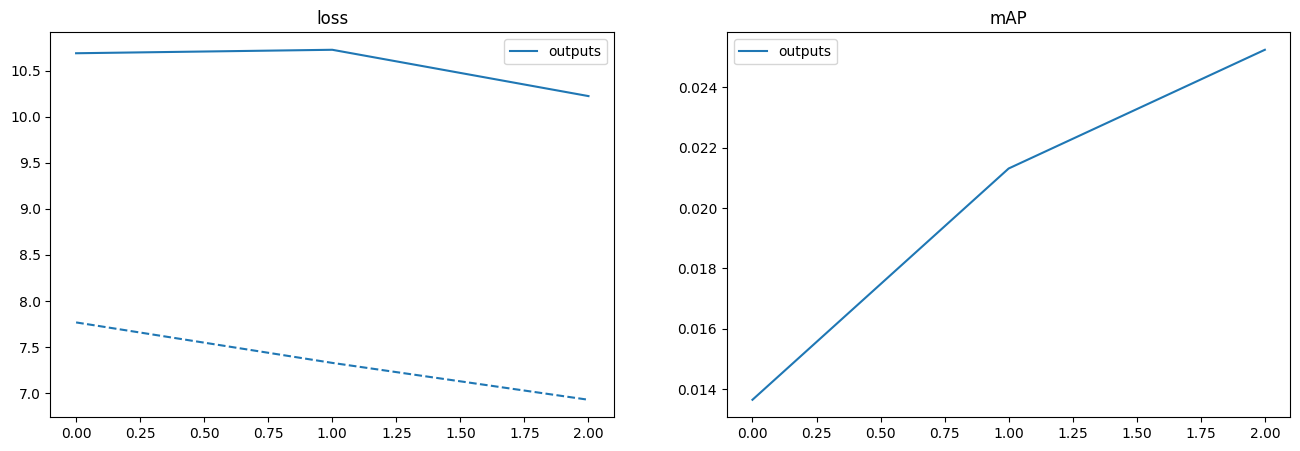

In [99]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

/home/joywu/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com

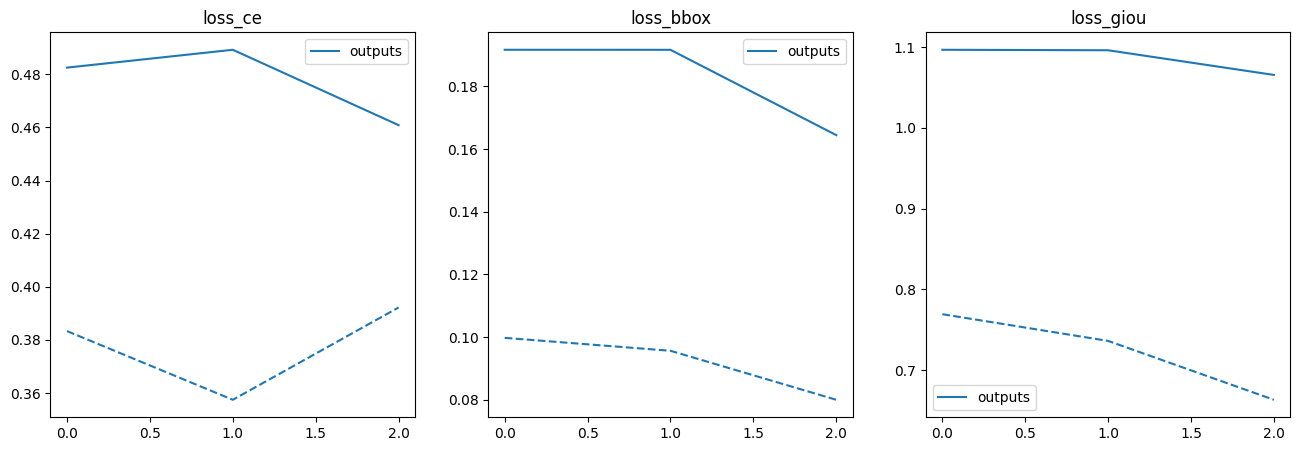

In [100]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

/home/joywu/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


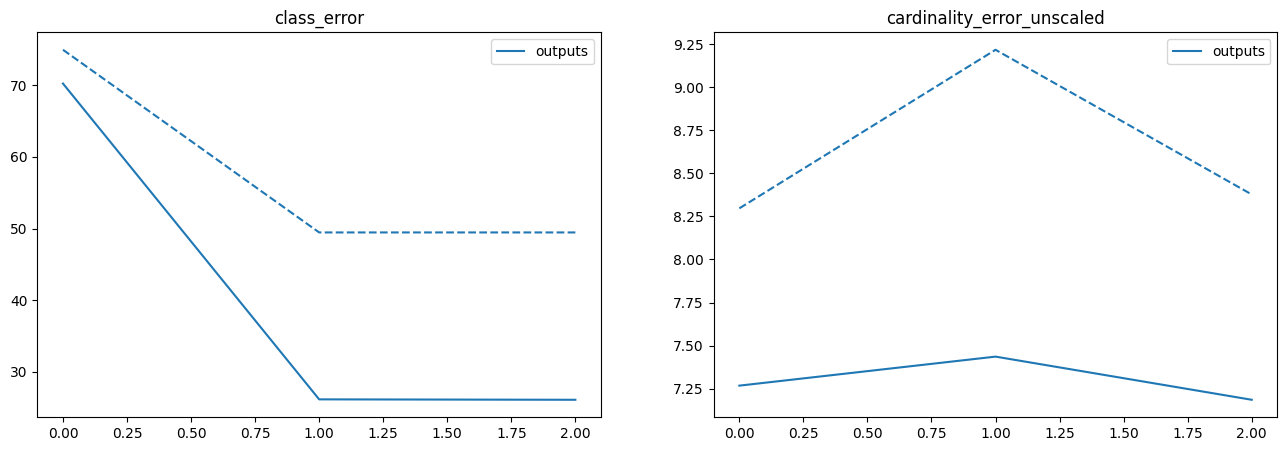

In [101]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

# Visualize Inference

In [103]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();
     

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /home/joywu/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/joywu/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    

def interpolate_show_PET(nda, suv_max, spacing=(1,1), title=None, margin=0, dpi=100, colormap='Greys', OUTPATH=None,show=False):
    ysize = nda.shape[0]
    xsize = nda.shape[1]

    figsize = (1 + margin) * xsize * spacing[0] / dpi, (1 + margin) * ysize * spacing[1] / dpi

    fig = plt.figure(title, figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])
    #hide axis
    ax.axis('off')
    
    extent = (0, xsize * spacing[0], 0, ysize * spacing[1])

    #various papers mentions bicubic interpolation...
    t = ax.imshow(
#         nda, extent=extent, interpolation="hamming", cmap="Greys", origin="upper", vmax=suv_max
#         nda, extent=extent, interpolation="bilinear", cmap="Greys", origin="upper", vmax=suv_max
        nda, extent=extent, interpolation="bicubic", cmap=colormap, origin="upper", vmax=suv_max 
    )

    if title:
        plt.title(title)
    if OUTPATH != None:
        fig.savefig(os.path.join(OUTPATH,'MIP'+'%04d' % (i)+'.png'), dpi = dpi)
    if not show:
        plt.close(fig)


def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def filter_bboxes_from_outputs(outputs, threshold=0.7):
  
    # keep only predictions with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    return probas_to_keep, bboxes_scaled


def run_workflow(my_image, my_model):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(my_image).unsqueeze(0)

    # propagate through the model
    outputs = my_model(img)

    for threshold in [0.9, 0.7]:
    
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=threshold)

        plot_finetuned_results(my_image, probas_to_keep, bboxes_scaled)

## Display a train image

In [106]:
dataDir = '/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/'

In [107]:
mode = 'train'
annFile='{}annotations/detr_{}.json'.format(dataDir,mode)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=2.60s)
creating index...
index created!


In [110]:
catIds = coco.getCatIds(catNms=['tumor']);
imgIds = coco.getImgIds(catIds=catIds );

In [111]:
idx = 0
image_id = imgIds[idx]
print(image_id)

0


In [ ]:
# img_name = '/content/data/custom/train2017/145053828_e0e748717c_b.jpg'
# im = Image.open(img_name)
suv_img = _load_image_npy(coco, img_folder, img_id)
suv_max = 6
im = _suv_to_greyPIL(suv_img, suv_max)

run_workflow(im, model)

## Display a validation image

In [115]:
mode = 'val'
annFile='{}annotations/detr_{}.json'.format(dataDir,mode)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [116]:
catIds = coco.getCatIds(catNms=['tumor']);
imgIds = coco.getImgIds(catIds=catIds );

In [117]:
idx = 0
image_id = imgIds[idx]
print(image_id)

40992


In [ ]:
# img_name = '/content/data/custom/val2017/410488422_5f8991f26e_b.jpg'
# im = Image.open(img_name)
suv_img = _load_image_npy(coco, img_folder, img_id)
suv_max = 6
im = _suv_to_greyPIL(suv_img, suv_max)

run_workflow(im, model)